CS, d = 11, with early stoppping.

In [1]:
import sys
sys.path.append('../')

from NG.generate_ng import *
from computesk import *
import numpy as np
import torch

import numpy as np
import copy
import torch
import torch.optim as optim
import os

from models.UMNN import MonotonicNN
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:

num_features = 156
hidden_layers = [128, 128, 64]
nb_steps = 50

lr = 0.001
num_epochs = 100

In [3]:
testing_samples_path = 'OC/samples/test.txt'
validation_samples_path = 'OC/samples/validation.txt'
training_samples_path = 'OC/samples/train.txt'
save_path = 'OC/OC-saved_models/OC-156d-128_128_64' # Change this!""

In [4]:
test_samples = torch.tensor(np.loadtxt(testing_samples_path)).to(torch.float32)
validation_samples = torch.tensor(np.loadtxt(validation_samples_path)).to(torch.float32)
train_samples = torch.tensor(np.loadtxt(training_samples_path)).to(torch.float32)
print(test_samples.shape, validation_samples.shape, train_samples.shape)


torch.Size([117, 156]) torch.Size([115, 156]) torch.Size([346, 156])


In [5]:
test_samples

tensor([[ 0.4821,  0.4558, -0.5949,  ...,  0.4678,  0.5901,  0.6874],
        [ 2.3441,  0.2051, -0.8867,  ...,  0.1197,  3.4944,  0.7929],
        [-0.4075,  0.3622, -0.1156,  ...,  0.5719,  0.6927,  0.1269],
        ...,
        [-0.1698, -1.3222,  0.3279,  ...,  0.8689,  1.0163,  1.0282],
        [ 0.2314, -0.8070,  1.4503,  ..., -0.2047, -1.1577,  0.4693],
        [ 1.8247,  0.4565, -1.2466,  ...,  0.1009, -1.0593, -0.7562]])

In [6]:
training_sizes = [len(train_samples)]
random_regs = [1, 0.1, 0.01, 0.001, 0]

In [7]:
kths = list(range(num_features))
fixed_map = generate_non_linear_maps(num_features, hidden_layers, nb_steps, 'cpu')

In [8]:
opt_regs = {}
all_test_losses = {}
all_learnt_maps = {}
all_opt_maps = {}
test_no_reg_losses = {}

In [9]:
num_train = training_sizes[0]
X_tr = train_samples

for i in kths:
    kth = i
    print('kth =', kth)
    best_val_overall = float('inf')
    opt_reg = 0
    opt_Sk = None # should this be moved in?
    each_learnt_map = {}
    non_kth = [idx for idx in range(X_tr.shape[1]) if idx != kth]

    for j in tqdm(range(len(random_regs)), desc='Random Regs', leave=False):
        regLambda = random_regs[j]
        Sk = copy.deepcopy(fixed_map)[kth]
        optimizer = optim.Adam(Sk.parameters(), lr=lr)
        n = X_tr.shape[0]
        early_stop_counter = 0
        best_epoch = 0
        best_valL = float('inf')
        for epoch in range(num_epochs):
            zk = X_tr.detach().requires_grad_(True)
            h = zk[:, non_kth]
            x = zk[:, [kth]]

            sk_zi = Sk(x, h)
            jacobian = torch.autograd.grad(sk_zi, x, torch.ones_like(sk_zi), create_graph=True)[0]
            loss = (0.5 * sk_zi**2 - torch.log(jacobian)).sum(axis=0) / n 
            regulariser = torch.sqrt((jacobian**2).sum(axis=0) / n)
            loss += regLambda * regulariser
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validation
            Sk_zi_val, jacobian_val = test_map(validation_samples, non_kth, kth, Sk)
            val_loss = test_losses(Sk_zi_val, jacobian_val)
            print(f'Val {num_train}st λ = {regLambda}, Epoch {epoch}: {val_loss}')

            # Save the smallest validation loss at each loop.
            if val_loss[1] < best_valL:
                best_valL = val_loss[1]
                if val_loss[1] < best_val_overall: # overall for all λ and epoch
                    best_val_overall = val_loss[1]
                    opt_reg = regLambda
                    opt_Sk = Sk
                    
                best_epoch = epoch
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            # Check for early stopping
            if early_stop_counter >= 25:
                print(f'Early stopping at Epoch {epoch} for best epoch {best_epoch}.')
                break

        each_learnt_map.setdefault(regLambda, []).append(Sk)

    # Test the best model
    Sk_zi_test, jacobian_test = test_map(test_samples, non_kth, kth, opt_Sk)

    all_test_losses.setdefault(num_train, []).append(test_losses(Sk_zi_test, jacobian_test))###, kth))
    print(f'Test {num_train}, λ = {opt_reg}: {all_test_losses[num_train]}')

    all_learnt_maps.setdefault(num_train, []).append(each_learnt_map)
    all_opt_maps.setdefault(num_train, []).append(opt_Sk)
    opt_regs.setdefault(num_train, []).append(opt_reg)
    
print('Optimal λ ∀ =', opt_regs)


kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8581042289733887, 1.488386869430542)
Val 346st λ = 1, Epoch 1: (0.6084291934967041, 1.4942587614059448)
Val 346st λ = 1, Epoch 2: (0.47818732261657715, 1.5332202911376953)
Val 346st λ = 1, Epoch 3: (0.4107476472854614, 1.5855927467346191)
Val 346st λ = 1, Epoch 4: (0.3801383376121521, 1.6320260763168335)
Val 346st λ = 1, Epoch 5: (0.36788100004196167, 1.6585208177566528)
Val 346st λ = 1, Epoch 6: (0.3619890511035919, 1.6626060009002686)
Val 346st λ = 1, Epoch 7: (0.35858869552612305, 1.6493699550628662)
Val 346st λ = 1, Epoch 8: (0.3580370545387268, 1.6253979206085205)
Val 346st λ = 1, Epoch 9: (0.36194220185279846, 1.5966376066207886)
Val 346st λ = 1, Epoch 10: (0.3699699342250824, 1.5673022270202637)
Val 346st λ = 1, Epoch 11: (0.3825012147426605, 1.5403755903244019)
Val 346st λ = 1, Epoch 12: (0.3978123664855957, 1.5167126655578613)
Val 346st λ = 1, Epoch 13: (0.4135386645793915, 1.496591567993164)
Val 346st λ = 1, Epoch 14: (0.427270770072937, 1.4795480

Random Regs:  20%|██        | 1/5 [00:21<01:24, 21.21s/it]

Val 346st λ = 1, Epoch 89: (0.5525476336479187, 1.230989933013916)
Early stopping at Epoch 89 for best epoch 64.
Val 346st λ = 0.1, Epoch 0: (1.005542278289795, 1.4836963415145874)
Val 346st λ = 0.1, Epoch 1: (0.9141801595687866, 1.452811598777771)
Val 346st λ = 0.1, Epoch 2: (0.9183192253112793, 1.4336429834365845)
Val 346st λ = 0.1, Epoch 3: (0.9739400744438171, 1.4231640100479126)
Val 346st λ = 0.1, Epoch 4: (1.0647268295288086, 1.42205011844635)
Val 346st λ = 0.1, Epoch 5: (1.1777186393737793, 1.4288244247436523)
Val 346st λ = 0.1, Epoch 6: (1.292803168296814, 1.439297080039978)
Val 346st λ = 0.1, Epoch 7: (1.3847910165786743, 1.445111870765686)
Val 346st λ = 0.1, Epoch 8: (1.4434435367584229, 1.4430756568908691)
Val 346st λ = 0.1, Epoch 9: (1.4881174564361572, 1.43748140335083)
Val 346st λ = 0.1, Epoch 10: (1.5509910583496094, 1.4362748861312866)
Val 346st λ = 0.1, Epoch 11: (1.6760492324829102, 1.448936104774475)
Val 346st λ = 0.1, Epoch 12: (1.9044485092163086, 1.485337495803833

Random Regs:  40%|████      | 2/5 [00:30<00:41, 13.98s/it]

Val 346st λ = 0.1, Epoch 29: (13.161606788635254, 4.336591720581055)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (1.0660144090652466, 1.4870216846466064)
Val 346st λ = 0.01, Epoch 1: (1.0060157775878906, 1.4578882455825806)
Val 346st λ = 0.01, Epoch 2: (1.0373189449310303, 1.4433046579360962)
Val 346st λ = 0.01, Epoch 3: (1.1178759336471558, 1.440294861793518)
Val 346st λ = 0.01, Epoch 4: (1.2308905124664307, 1.447951078414917)
Val 346st λ = 0.01, Epoch 5: (1.3647916316986084, 1.4640706777572632)
Val 346st λ = 0.01, Epoch 6: (1.487424373626709, 1.4797837734222412)
Val 346st λ = 0.01, Epoch 7: (1.5781311988830566, 1.4878511428833008)
Val 346st λ = 0.01, Epoch 8: (1.6448805332183838, 1.4894652366638184)
Val 346st λ = 0.01, Epoch 9: (1.7068499326705933, 1.489884614944458)
Val 346st λ = 0.01, Epoch 10: (1.8015334606170654, 1.4987491369247437)
Val 346st λ = 0.01, Epoch 11: (1.9695708751678467, 1.5268703699111938)
Val 346st λ = 0.01, Epoch 12: (2.247498512268066

Random Regs:  60%|██████    | 3/5 [00:37<00:21, 10.75s/it]

Val 346st λ = 0.01, Epoch 28: (13.271394729614258, 4.659420490264893)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (1.071035385131836, 1.4875389337539673)
Val 346st λ = 0.001, Epoch 1: (1.0147255659103394, 1.458762764930725)
Val 346st λ = 0.001, Epoch 2: (1.0491523742675781, 1.4447829723358154)
Val 346st λ = 0.001, Epoch 3: (1.13233482837677, 1.4425630569458008)
Val 346st λ = 0.001, Epoch 4: (1.2472244501113892, 1.450967788696289)
Val 346st λ = 0.001, Epoch 5: (1.3824620246887207, 1.467828392982483)
Val 346st λ = 0.001, Epoch 6: (1.505952000617981, 1.484036922454834)
Val 346st λ = 0.001, Epoch 7: (1.5974570512771606, 1.4926588535308838)
Val 346st λ = 0.001, Epoch 8: (1.6642955541610718, 1.494611144065857)
Val 346st λ = 0.001, Epoch 9: (1.7269611358642578, 1.4956327676773071)
Val 346st λ = 0.001, Epoch 10: (1.8226230144500732, 1.5052872896194458)
Val 346st λ = 0.001, Epoch 11: (1.9881057739257812, 1.5336599349975586)
Val 346st λ = 0.001, Epoch 12: (2.264105

Random Regs:  80%|████████  | 4/5 [00:43<00:09,  9.11s/it]

Val 346st λ = 0.001, Epoch 28: (17.320571899414062, 5.984014987945557)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (1.0715891122817993, 1.4875767230987549)
Val 346st λ = 0, Epoch 1: (1.0155094861984253, 1.4588245153427124)
Val 346st λ = 0, Epoch 2: (1.0495697259902954, 1.444810152053833)
Val 346st λ = 0, Epoch 3: (1.1331546306610107, 1.442713737487793)
Val 346st λ = 0, Epoch 4: (1.2498507499694824, 1.4516017436981201)
Val 346st λ = 0, Epoch 5: (1.3868179321289062, 1.4688860177993774)
Val 346st λ = 0, Epoch 6: (1.512712836265564, 1.485680341720581)
Val 346st λ = 0, Epoch 7: (1.607203483581543, 1.494946002960205)
Val 346st λ = 0, Epoch 8: (1.6767113208770752, 1.4973379373550415)
Val 346st λ = 0, Epoch 9: (1.7418444156646729, 1.4986498355865479)
Val 346st λ = 0, Epoch 10: (1.8367191553115845, 1.5080581903457642)
Val 346st λ = 0, Epoch 11: (2.004232168197632, 1.5364142656326294)
Val 346st λ = 0, Epoch 12: (2.2784128189086914, 1.5945734977722168)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 28: (17.32339859008789, 5.9822916984558105)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6760702729225159, 1.5054728984832764)
Val 346st λ = 1, Epoch 1: (0.3909212648868561, 1.5296565294265747)
Val 346st λ = 1, Epoch 2: (0.304267555475235, 1.5757783651351929)
Val 346st λ = 1, Epoch 3: (0.2828720808029175, 1.6097387075424194)
Val 346st λ = 1, Epoch 4: (0.2802433967590332, 1.6179914474487305)
Val 346st λ = 1, Epoch 5: (0.28136715292930603, 1.605752944946289)
Val 346st λ = 1, Epoch 6: (0.28334417939186096, 1.582140564918518)
Val 346st λ = 1, Epoch 7: (0.2869164049625397, 1.5543180704116821)
Val 346st λ = 1, Epoch 8: (0.29279690980911255, 1.5267490148544312)
Val 346st λ = 1, Epoch 9: (0.3004947900772095, 1.501606822013855)
Val 346st λ = 1, Epoch 10: (0.3089693784713745, 1.4799797534942627)
Val 346st λ = 1, Epoch 11: (0.3173103332519531, 1.46205472946167)
Val 346st λ = 1, Epoch 12: (0.32339364290237427, 1.447329044342041)
Val 346st λ = 1, Epoch 13: (0.3253505229949951, 1.4351931810379028)
Val 346st λ = 1, Epoch 14: (0.32222437858581543, 1.4249585866

Random Regs:  20%|██        | 1/5 [00:20<01:21, 20.43s/it]

Val 346st λ = 1, Epoch 98: (0.43734562397003174, 1.1606581211090088)
Val 346st λ = 1, Epoch 99: (0.43862149119377136, 1.160692811012268)
Val 346st λ = 0.1, Epoch 0: (1.0164676904678345, 1.4706381559371948)
Val 346st λ = 0.1, Epoch 1: (0.8798205852508545, 1.4314433336257935)
Val 346st λ = 0.1, Epoch 2: (0.8641831278800964, 1.407740592956543)
Val 346st λ = 0.1, Epoch 3: (0.902627170085907, 1.3926987648010254)
Val 346st λ = 0.1, Epoch 4: (0.9470986127853394, 1.380959153175354)
Val 346st λ = 0.1, Epoch 5: (0.9707744717597961, 1.36925208568573)
Val 346st λ = 0.1, Epoch 6: (0.9680507779121399, 1.355787992477417)
Val 346st λ = 0.1, Epoch 7: (0.9516845941543579, 1.3415672779083252)
Val 346st λ = 0.1, Epoch 8: (0.9390743970870972, 1.3277530670166016)
Val 346st λ = 0.1, Epoch 9: (0.9405626058578491, 1.3140853643417358)
Val 346st λ = 0.1, Epoch 10: (0.9633662700653076, 1.3003333806991577)
Val 346st λ = 0.1, Epoch 11: (1.0123416185379028, 1.2873951196670532)
Val 346st λ = 0.1, Epoch 12: (1.0898983

Random Regs:  40%|████      | 2/5 [00:29<00:42, 14.00s/it]

Val 346st λ = 0.1, Epoch 42: (17.022287368774414, 6.893556118011475)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (1.0543928146362305, 1.4732506275177002)
Val 346st λ = 0.01, Epoch 1: (0.9349144101142883, 1.435925841331482)
Val 346st λ = 0.01, Epoch 2: (0.9479283690452576, 1.4174165725708008)
Val 346st λ = 0.01, Epoch 3: (1.009873867034912, 1.4080092906951904)
Val 346st λ = 0.01, Epoch 4: (1.0796818733215332, 1.4015939235687256)
Val 346st λ = 0.01, Epoch 5: (1.1260864734649658, 1.3932851552963257)
Val 346st λ = 0.01, Epoch 6: (1.1361924409866333, 1.3811969757080078)
Val 346st λ = 0.01, Epoch 7: (1.1133580207824707, 1.365419864654541)
Val 346st λ = 0.01, Epoch 8: (1.0833007097244263, 1.3487728834152222)
Val 346st λ = 0.01, Epoch 9: (1.0652283430099487, 1.333073616027832)
Val 346st λ = 0.01, Epoch 10: (1.0735598802566528, 1.319662094116211)
Val 346st λ = 0.01, Epoch 11: (1.1118690967559814, 1.308310627937317)
Val 346st λ = 0.01, Epoch 12: (1.1859179735183716

Random Regs:  60%|██████    | 3/5 [00:38<00:22, 11.45s/it]

Val 346st λ = 0.01, Epoch 38: (15.518619537353516, 6.032566070556641)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.0574061870574951, 1.473392367362976)
Val 346st λ = 0.001, Epoch 1: (0.941067636013031, 1.4364784955978394)
Val 346st λ = 0.001, Epoch 2: (0.9574161767959595, 1.418624758720398)
Val 346st λ = 0.001, Epoch 3: (1.021169900894165, 1.4098109006881714)
Val 346st λ = 0.001, Epoch 4: (1.0932172536849976, 1.403994083404541)
Val 346st λ = 0.001, Epoch 5: (1.1426953077316284, 1.3962750434875488)
Val 346st λ = 0.001, Epoch 6: (1.1539554595947266, 1.3843170404434204)
Val 346st λ = 0.001, Epoch 7: (1.1307278871536255, 1.368297815322876)
Val 346st λ = 0.001, Epoch 8: (1.099786400794983, 1.351456880569458)
Val 346st λ = 0.001, Epoch 9: (1.0792863368988037, 1.3352978229522705)
Val 346st λ = 0.001, Epoch 10: (1.0860145092010498, 1.3216235637664795)
Val 346st λ = 0.001, Epoch 11: (1.1223496198654175, 1.3102402687072754)
Val 346st λ = 0.001, Epoch 12: (1.1953

Random Regs:  80%|████████  | 4/5 [00:46<00:10, 10.08s/it]

Val 346st λ = 0.001, Epoch 37: (21.986770629882812, 7.678872108459473)
Val 346st λ = 0.001, Epoch 38: (15.508100509643555, 6.335093975067139)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.057550072669983, 1.473401427268982)
Val 346st λ = 0, Epoch 1: (0.9417163133621216, 1.4365410804748535)
Val 346st λ = 0, Epoch 2: (0.9584855437278748, 1.418757438659668)
Val 346st λ = 0, Epoch 3: (1.0224521160125732, 1.4100192785263062)
Val 346st λ = 0, Epoch 4: (1.0946320295333862, 1.404231071472168)
Val 346st λ = 0, Epoch 5: (1.1446958780288696, 1.396596074104309)
Val 346st λ = 0, Epoch 6: (1.1564130783081055, 1.3846714496612549)
Val 346st λ = 0, Epoch 7: (1.1337796449661255, 1.3687776327133179)
Val 346st λ = 0, Epoch 8: (1.1026010513305664, 1.3518621921539307)
Val 346st λ = 0, Epoch 9: (1.0814135074615479, 1.3355430364608765)
Val 346st λ = 0, Epoch 10: (1.0875415802001953, 1.3218176364898682)
Val 346st λ = 0, Epoch 11: (1.1236556768417358, 1.3105217218399048)
Val 346st λ

Val 346st λ = 0, Epoch 38: (14.072432518005371, 5.8046979904174805)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8223263025283813, 1.487013578414917)
Val 346st λ = 1, Epoch 1: (0.5266472101211548, 1.4866483211517334)
Val 346st λ = 1, Epoch 2: (0.3753277659416199, 1.5242301225662231)
Val 346st λ = 1, Epoch 3: (0.30107924342155457, 1.584415078163147)
Val 346st λ = 1, Epoch 4: (0.27196022868156433, 1.6433216333389282)
Val 346st λ = 1, Epoch 5: (0.2631147503852844, 1.6776624917984009)
Val 346st λ = 1, Epoch 6: (0.2601154148578644, 1.68242609500885)
Val 346st λ = 1, Epoch 7: (0.2584676742553711, 1.6646931171417236)
Val 346st λ = 1, Epoch 8: (0.2580849230289459, 1.6336919069290161)
Val 346st λ = 1, Epoch 9: (0.25989043712615967, 1.5971170663833618)
Val 346st λ = 1, Epoch 10: (0.26417019963264465, 1.560145616531372)
Val 346st λ = 1, Epoch 11: (0.2700837552547455, 1.5257782936096191)
Val 346st λ = 1, Epoch 12: (0.2765789031982422, 1.495629906654358)
Val 346st λ = 1, Epoch 13: (0.28177061676979065, 1.4697070121765137)
Val 346st λ = 1, Epoch 14: (0.2848406136035919, 1.447907209

Random Regs:  20%|██        | 1/5 [00:19<01:19, 19.97s/it]

Val 346st λ = 1, Epoch 92: (0.42668670415878296, 1.1713731288909912)
Early stopping at Epoch 92 for best epoch 67.
Val 346st λ = 0.1, Epoch 0: (0.9006118774414062, 1.4744020700454712)
Val 346st λ = 0.1, Epoch 1: (0.72920823097229, 1.4380226135253906)
Val 346st λ = 0.1, Epoch 2: (0.6825551390647888, 1.4132736921310425)
Val 346st λ = 0.1, Epoch 3: (0.692328155040741, 1.395185947418213)
Val 346st λ = 0.1, Epoch 4: (0.7254691123962402, 1.3807440996170044)
Val 346st λ = 0.1, Epoch 5: (0.7671970725059509, 1.36807382106781)
Val 346st λ = 0.1, Epoch 6: (0.8139195442199707, 1.3562333583831787)
Val 346st λ = 0.1, Epoch 7: (0.8658329248428345, 1.344143271446228)
Val 346st λ = 0.1, Epoch 8: (0.935366153717041, 1.3333184719085693)
Val 346st λ = 0.1, Epoch 9: (1.0518524646759033, 1.3283724784851074)
Val 346st λ = 0.1, Epoch 10: (1.2608362436294556, 1.3348995447158813)
Val 346st λ = 0.1, Epoch 11: (1.6340038776397705, 1.362821102142334)
Val 346st λ = 0.1, Epoch 12: (2.2173638343811035, 1.420095443725

Random Regs:  40%|████      | 2/5 [00:27<00:37, 12.45s/it]

Val 346st λ = 0.1, Epoch 34: (23.9475154876709, 6.18991231918335)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.977455198764801, 1.481238603591919)
Val 346st λ = 0.01, Epoch 1: (0.8308142423629761, 1.4460792541503906)
Val 346st λ = 0.01, Epoch 2: (0.7902164459228516, 1.42254638671875)
Val 346st λ = 0.01, Epoch 3: (0.7940743565559387, 1.404646396636963)
Val 346st λ = 0.01, Epoch 4: (0.8213396668434143, 1.390364408493042)
Val 346st λ = 0.01, Epoch 5: (0.8613333106040955, 1.3784918785095215)
Val 346st λ = 0.01, Epoch 6: (0.9166907072067261, 1.3688328266143799)
Val 346st λ = 0.01, Epoch 7: (0.9955734014511108, 1.3621031045913696)
Val 346st λ = 0.01, Epoch 8: (1.1162292957305908, 1.361541748046875)
Val 346st λ = 0.01, Epoch 9: (1.3136875629425049, 1.372018575668335)
Val 346st λ = 0.01, Epoch 10: (1.6600273847579956, 1.402432918548584)
Val 346st λ = 0.01, Epoch 11: (2.2627620697021484, 1.46686589717865)
Val 346st λ = 0.01, Epoch 12: (3.252682685852051, 1.583419

Random Regs:  60%|██████    | 3/5 [00:33<00:19,  9.70s/it]

Val 346st λ = 0.01, Epoch 32: (285.1317443847656, 35.688392639160156)
Val 346st λ = 0.01, Epoch 33: (206.6035919189453, 26.57411003112793)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.983092188835144, 1.4820458889007568)
Val 346st λ = 0.001, Epoch 1: (0.8397591710090637, 1.447373628616333)
Val 346st λ = 0.001, Epoch 2: (0.8007367849349976, 1.4241759777069092)
Val 346st λ = 0.001, Epoch 3: (0.8047279119491577, 1.4064924716949463)
Val 346st λ = 0.001, Epoch 4: (0.8308271765708923, 1.3921170234680176)
Val 346st λ = 0.001, Epoch 5: (0.8699594140052795, 1.380197525024414)
Val 346st λ = 0.001, Epoch 6: (0.9260545969009399, 1.3706871271133423)
Val 346st λ = 0.001, Epoch 7: (1.0063996315002441, 1.3643313646316528)
Val 346st λ = 0.001, Epoch 8: (1.1304233074188232, 1.364540934562683)
Val 346st λ = 0.001, Epoch 9: (1.3313443660736084, 1.3761541843414307)
Val 346st λ = 0.001, Epoch 10: (1.6865099668502808, 1.4086993932724)
Val 346st λ = 0.001, Epoch 11: (2.3036904

Random Regs:  80%|████████  | 4/5 [00:40<00:08,  8.56s/it]

Val 346st λ = 0.001, Epoch 32: (640.490234375, 69.3612289428711)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.9837750196456909, 1.4821628332138062)
Val 346st λ = 0, Epoch 1: (0.8409339189529419, 1.4475500583648682)
Val 346st λ = 0, Epoch 2: (0.8022006750106812, 1.424393892288208)
Val 346st λ = 0, Epoch 3: (0.8061102032661438, 1.4067139625549316)
Val 346st λ = 0, Epoch 4: (0.8326742053031921, 1.3923989534378052)
Val 346st λ = 0, Epoch 5: (0.8726248145103455, 1.380623459815979)
Val 346st λ = 0, Epoch 6: (0.9290918111801147, 1.3711652755737305)
Val 346st λ = 0, Epoch 7: (1.0100210905075073, 1.364881157875061)
Val 346st λ = 0, Epoch 8: (1.1349595785140991, 1.3652116060256958)
Val 346st λ = 0, Epoch 9: (1.3371061086654663, 1.3770363330841064)
Val 346st λ = 0, Epoch 10: (1.6980962753295898, 1.4105435609817505)
Val 346st λ = 0, Epoch 11: (2.3214669227600098, 1.4789124727249146)
Val 346st λ = 0, Epoch 12: (3.352346181869507, 1.602121353149414)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 32: (694.8443603515625, 73.75171661376953)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7069006562232971, 1.409715175628662)
Val 346st λ = 1, Epoch 1: (0.5508319735527039, 1.432917594909668)
Val 346st λ = 1, Epoch 2: (0.4312129020690918, 1.4840669631958008)
Val 346st λ = 1, Epoch 3: (0.35003480315208435, 1.5588704347610474)
Val 346st λ = 1, Epoch 4: (0.30771729350090027, 1.644153356552124)
Val 346st λ = 1, Epoch 5: (0.29047390818595886, 1.713839054107666)
Val 346st λ = 1, Epoch 6: (0.2812621593475342, 1.7490040063858032)
Val 346st λ = 1, Epoch 7: (0.27288955450057983, 1.7497515678405762)
Val 346st λ = 1, Epoch 8: (0.2657267451286316, 1.725872278213501)
Val 346st λ = 1, Epoch 9: (0.26344335079193115, 1.6882699728012085)
Val 346st λ = 1, Epoch 10: (0.26864248514175415, 1.6457411050796509)
Val 346st λ = 1, Epoch 11: (0.28105950355529785, 1.604119896888733)
Val 346st λ = 1, Epoch 12: (0.29882916808128357, 1.5673058032989502)
Val 346st λ = 1, Epoch 13: (0.3185659348964691, 1.5368107557296753)
Val 346st λ = 1, Epoch 14: (0.3372288942337036, 1.512832

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.36s/it]

Val 346st λ = 1, Epoch 24: (0.33897075057029724, 1.490441083908081)
Val 346st λ = 1, Epoch 25: (0.3376663029193878, 1.4938297271728516)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7261617183685303, 1.4065107107162476)
Val 346st λ = 0.1, Epoch 1: (0.6174483299255371, 1.413010597229004)
Val 346st λ = 0.1, Epoch 2: (0.5682433843612671, 1.418955683708191)
Val 346st λ = 0.1, Epoch 3: (0.562731146812439, 1.415658950805664)
Val 346st λ = 0.1, Epoch 4: (0.5862072706222534, 1.404808521270752)
Val 346st λ = 0.1, Epoch 5: (0.6298423409461975, 1.3910415172576904)
Val 346st λ = 0.1, Epoch 6: (0.6878129839897156, 1.3787298202514648)
Val 346st λ = 0.1, Epoch 7: (0.7524217367172241, 1.3701772689819336)
Val 346st λ = 0.1, Epoch 8: (0.8138757944107056, 1.3648771047592163)
Val 346st λ = 0.1, Epoch 9: (0.8628932237625122, 1.3611750602722168)
Val 346st λ = 0.1, Epoch 10: (0.8933336138725281, 1.3576016426086426)
Val 346st λ = 0.1, Epoch 11: (0.906469464302063, 1.3538035154342

Random Regs:  40%|████      | 2/5 [00:11<00:17,  5.93s/it]

Val 346st λ = 0.1, Epoch 38: (5.8711652755737305, 3.734900951385498)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7379437685012817, 1.405430555343628)
Val 346st λ = 0.01, Epoch 1: (0.6521338224411011, 1.406800627708435)
Val 346st λ = 0.01, Epoch 2: (0.6274206042289734, 1.405764102935791)
Val 346st λ = 0.01, Epoch 3: (0.6425987482070923, 1.398238182067871)
Val 346st λ = 0.01, Epoch 4: (0.6856043338775635, 1.3878916501998901)
Val 346st λ = 0.01, Epoch 5: (0.748267412185669, 1.378899335861206)
Val 346st λ = 0.01, Epoch 6: (0.8198374509811401, 1.374019980430603)
Val 346st λ = 0.01, Epoch 7: (0.888448178768158, 1.3726909160614014)
Val 346st λ = 0.01, Epoch 8: (0.9435453414916992, 1.3732426166534424)
Val 346st λ = 0.01, Epoch 9: (0.9781955480575562, 1.37281334400177)
Val 346st λ = 0.01, Epoch 10: (0.9938467741012573, 1.370587706565857)
Val 346st λ = 0.01, Epoch 11: (1.0032596588134766, 1.3683565855026245)
Val 346st λ = 0.01, Epoch 12: (1.0255801677703857, 1.3

Random Regs:  60%|██████    | 3/5 [00:17<00:11,  5.98s/it]

Val 346st λ = 0.01, Epoch 36: (8.16943073272705, 5.025547027587891)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.739910900592804, 1.4052839279174805)
Val 346st λ = 0.001, Epoch 1: (0.6567978262901306, 1.406086802482605)
Val 346st λ = 0.001, Epoch 2: (0.6346775889396667, 1.4043529033660889)
Val 346st λ = 0.001, Epoch 3: (0.6523450016975403, 1.3966377973556519)
Val 346st λ = 0.001, Epoch 4: (0.6979058980941772, 1.3867164850234985)
Val 346st λ = 0.001, Epoch 5: (0.761947751045227, 1.3784348964691162)
Val 346st λ = 0.001, Epoch 6: (0.8339807987213135, 1.3743646144866943)
Val 346st λ = 0.001, Epoch 7: (0.9018887877464294, 1.3737348318099976)
Val 346st λ = 0.001, Epoch 8: (0.9549050331115723, 1.374505639076233)
Val 346st λ = 0.001, Epoch 9: (0.9868402481079102, 1.373908519744873)
Val 346st λ = 0.001, Epoch 10: (1.0011740922927856, 1.371686577796936)
Val 346st λ = 0.001, Epoch 11: (1.0123224258422852, 1.3699191808700562)
Val 346st λ = 0.001, Epoch 12: (1.0397

Random Regs:  80%|████████  | 4/5 [00:23<00:05,  5.98s/it]

Val 346st λ = 0.001, Epoch 36: (6.880424499511719, 4.209647178649902)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.7400669455528259, 1.405269742012024)
Val 346st λ = 0, Epoch 1: (0.6572723388671875, 1.406024694442749)
Val 346st λ = 0, Epoch 2: (0.6354784369468689, 1.404231309890747)
Val 346st λ = 0, Epoch 3: (0.653386116027832, 1.3964864015579224)
Val 346st λ = 0, Epoch 4: (0.6990611553192139, 1.386581540107727)
Val 346st λ = 0, Epoch 5: (0.763248085975647, 1.3783565759658813)
Val 346st λ = 0, Epoch 6: (0.8351892828941345, 1.374373197555542)
Val 346st λ = 0, Epoch 7: (0.9028178453445435, 1.3737684488296509)
Val 346st λ = 0, Epoch 8: (0.95556640625, 1.3745301961898804)
Val 346st λ = 0, Epoch 9: (0.9875579476356506, 1.3739311695098877)
Val 346st λ = 0, Epoch 10: (1.0020692348480225, 1.3717315196990967)
Val 346st λ = 0, Epoch 11: (1.0139790773391724, 1.3701956272125244)
Val 346st λ = 0, Epoch 12: (1.0421260595321655, 1.3722001314163208)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 36: (9.46623420715332, 5.758747577667236)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5573126077651978, 1.5590230226516724)
Val 346st λ = 1, Epoch 1: (0.4307108223438263, 1.5853780508041382)
Val 346st λ = 1, Epoch 2: (0.35458648204803467, 1.623936414718628)
Val 346st λ = 1, Epoch 3: (0.3170835077762604, 1.6535342931747437)
Val 346st λ = 1, Epoch 4: (0.3039315342903137, 1.6616337299346924)
Val 346st λ = 1, Epoch 5: (0.30510684847831726, 1.6515231132507324)
Val 346st λ = 1, Epoch 6: (0.3163548409938812, 1.6310416460037231)
Val 346st λ = 1, Epoch 7: (0.3353640139102936, 1.6064544916152954)
Val 346st λ = 1, Epoch 8: (0.3599558174610138, 1.5819425582885742)
Val 346st λ = 1, Epoch 9: (0.3891591429710388, 1.559717059135437)
Val 346st λ = 1, Epoch 10: (0.41818419098854065, 1.5397287607192993)
Val 346st λ = 1, Epoch 11: (0.440647691488266, 1.5214864015579224)
Val 346st λ = 1, Epoch 12: (0.45139455795288086, 1.5041710138320923)
Val 346st λ = 1, Epoch 13: (0.4467998743057251, 1.4867035150527954)
Val 346st λ = 1, Epoch 14: (0.4297408163547516, 1.4693015

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.85s/it]

Val 346st λ = 1, Epoch 60: (0.7944085001945496, 1.3281793594360352)
Val 346st λ = 1, Epoch 61: (0.787322998046875, 1.3265928030014038)
Early stopping at Epoch 61 for best epoch 36.
Val 346st λ = 0.1, Epoch 0: (1.0198698043823242, 1.589284896850586)
Val 346st λ = 0.1, Epoch 1: (1.2403171062469482, 1.6134506464004517)
Val 346st λ = 0.1, Epoch 2: (1.3602077960968018, 1.6209067106246948)
Val 346st λ = 0.1, Epoch 3: (1.368888258934021, 1.6098291873931885)
Val 346st λ = 0.1, Epoch 4: (1.318364143371582, 1.588095784187317)
Val 346st λ = 0.1, Epoch 5: (1.2486414909362793, 1.5624022483825684)
Val 346st λ = 0.1, Epoch 6: (1.1892443895339966, 1.5380040407180786)
Val 346st λ = 0.1, Epoch 7: (1.163477897644043, 1.5200011730194092)
Val 346st λ = 0.1, Epoch 8: (1.1704936027526855, 1.5099153518676758)
Val 346st λ = 0.1, Epoch 9: (1.203939437866211, 1.506972312927246)
Val 346st λ = 0.1, Epoch 10: (1.24593186378479, 1.506922960281372)
Val 346st λ = 0.1, Epoch 11: (1.2816002368927002, 1.504863977432251)


Random Regs:  40%|████      | 2/5 [00:15<00:22,  7.62s/it]

Val 346st λ = 0.1, Epoch 36: (21.735692977905273, 9.404959678649902)
Val 346st λ = 0.1, Epoch 37: (14.580191612243652, 7.024566173553467)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.0783783197402954, 1.600291132926941)
Val 346st λ = 0.01, Epoch 1: (1.420857310295105, 1.6468732357025146)
Val 346st λ = 0.01, Epoch 2: (1.682457447052002, 1.6808898448944092)
Val 346st λ = 0.01, Epoch 3: (1.7777044773101807, 1.6871275901794434)
Val 346st λ = 0.01, Epoch 4: (1.7357184886932373, 1.6696761846542358)
Val 346st λ = 0.01, Epoch 5: (1.6289454698562622, 1.6404626369476318)
Val 346st λ = 0.01, Epoch 6: (1.5057356357574463, 1.608198881149292)
Val 346st λ = 0.01, Epoch 7: (1.4198533296585083, 1.5819973945617676)
Val 346st λ = 0.01, Epoch 8: (1.3824220895767212, 1.566604733467102)
Val 346st λ = 0.01, Epoch 9: (1.3958722352981567, 1.5642362833023071)
Val 346st λ = 0.01, Epoch 10: (1.4452871084213257, 1.5726145505905151)
Val 346st λ = 0.01, Epoch 11: (1.5139259099960327,

Random Regs:  60%|██████    | 3/5 [00:21<00:13,  6.67s/it]

Val 346st λ = 0.01, Epoch 34: (36.039241790771484, 10.998713493347168)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (1.0825603008270264, 1.601085901260376)
Val 346st λ = 0.001, Epoch 1: (1.4384201765060425, 1.650144100189209)
Val 346st λ = 0.001, Epoch 2: (1.7169733047485352, 1.6872198581695557)
Val 346st λ = 0.001, Epoch 3: (1.823958158493042, 1.6958298683166504)
Val 346st λ = 0.001, Epoch 4: (1.7827616930007935, 1.6786679029464722)
Val 346st λ = 0.001, Epoch 5: (1.6688634157180786, 1.6486437320709229)
Val 346st λ = 0.001, Epoch 6: (1.5433751344680786, 1.6160999536514282)
Val 346st λ = 0.001, Epoch 7: (1.4502593278884888, 1.588991403579712)
Val 346st λ = 0.001, Epoch 8: (1.4056396484375, 1.5723209381103516)
Val 346st λ = 0.001, Epoch 9: (1.4176143407821655, 1.5699489116668701)
Val 346st λ = 0.001, Epoch 10: (1.4696334600448608, 1.5797446966171265)
Val 346st λ = 0.001, Epoch 11: (1.5427768230438232, 1.5976922512054443)
Val 346st λ = 0.001, Epoch 12: (1.602

Random Regs:  80%|████████  | 4/5 [00:27<00:06,  6.26s/it]

Val 346st λ = 0.001, Epoch 34: (15.100069999694824, 7.217093467712402)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (1.082920789718628, 1.6011552810668945)
Val 346st λ = 0, Epoch 1: (1.4390496015548706, 1.6502983570098877)
Val 346st λ = 0, Epoch 2: (1.7188445329666138, 1.687653660774231)
Val 346st λ = 0, Epoch 3: (1.825538158416748, 1.6963005065917969)
Val 346st λ = 0, Epoch 4: (1.784056305885315, 1.6791435480117798)
Val 346st λ = 0, Epoch 5: (1.6724823713302612, 1.6494672298431396)
Val 346st λ = 0, Epoch 6: (1.546950340270996, 1.6170146465301514)
Val 346st λ = 0, Epoch 7: (1.4536118507385254, 1.5899248123168945)
Val 346st λ = 0, Epoch 8: (1.4077566862106323, 1.5731714963912964)
Val 346st λ = 0, Epoch 9: (1.422235369682312, 1.571124792098999)
Val 346st λ = 0, Epoch 10: (1.4751060009002686, 1.580979824066162)
Val 346st λ = 0, Epoch 11: (1.5500495433807373, 1.5993741750717163)
Val 346st λ = 0, Epoch 12: (1.6103544235229492, 1.6122714281082153)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 34: (18.132251739501953, 8.404820442199707)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7301637530326843, 1.3924704790115356)
Val 346st λ = 1, Epoch 1: (0.5840678811073303, 1.3914570808410645)
Val 346st λ = 1, Epoch 2: (0.4731864929199219, 1.41825270652771)
Val 346st λ = 1, Epoch 3: (0.3902578353881836, 1.4675945043563843)
Val 346st λ = 1, Epoch 4: (0.33673304319381714, 1.535664677619934)
Val 346st λ = 1, Epoch 5: (0.3123948872089386, 1.61586594581604)
Val 346st λ = 1, Epoch 6: (0.3080591559410095, 1.6932315826416016)
Val 346st λ = 1, Epoch 7: (0.3091970682144165, 1.749267578125)
Val 346st λ = 1, Epoch 8: (0.30630171298980713, 1.7748554944992065)
Val 346st λ = 1, Epoch 9: (0.29792776703834534, 1.772118091583252)
Val 346st λ = 1, Epoch 10: (0.2866097092628479, 1.748416781425476)
Val 346st λ = 1, Epoch 11: (0.2750415802001953, 1.711982250213623)
Val 346st λ = 1, Epoch 12: (0.2653149366378784, 1.6695328950881958)
Val 346st λ = 1, Epoch 13: (0.2597367763519287, 1.6262633800506592)
Val 346st λ = 1, Epoch 14: (0.25890710949897766, 1.585697054862976)

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.43s/it]

Val 346st λ = 1, Epoch 26: (0.2466975450515747, 1.4136571884155273)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.7355314493179321, 1.3913507461547852)
Val 346st λ = 0.1, Epoch 1: (0.6035367846488953, 1.3861929178237915)
Val 346st λ = 0.1, Epoch 2: (0.5140945911407471, 1.3979582786560059)
Val 346st λ = 0.1, Epoch 3: (0.4630381464958191, 1.4117958545684814)
Val 346st λ = 0.1, Epoch 4: (0.4416614770889282, 1.4168857336044312)
Val 346st λ = 0.1, Epoch 5: (0.4381876587867737, 1.4110746383666992)
Val 346st λ = 0.1, Epoch 6: (0.4458063542842865, 1.3973047733306885)
Val 346st λ = 0.1, Epoch 7: (0.4595695734024048, 1.3790626525878906)
Val 346st λ = 0.1, Epoch 8: (0.47722968459129333, 1.359026312828064)
Val 346st λ = 0.1, Epoch 9: (0.49608755111694336, 1.339333176612854)
Val 346st λ = 0.1, Epoch 10: (0.5141266584396362, 1.3203656673431396)
Val 346st λ = 0.1, Epoch 11: (0.5294398665428162, 1.3019940853118896)
Val 346st λ = 0.1, Epoch 12: (0.540850043296814, 1.283707

Random Regs:  40%|████      | 2/5 [00:11<00:18,  6.27s/it]

Val 346st λ = 0.1, Epoch 46: (10.782347679138184, 6.114658355712891)
Early stopping at Epoch 46 for best epoch 21.
Val 346st λ = 0.01, Epoch 0: (0.7381139993667603, 1.391213297843933)
Val 346st λ = 0.01, Epoch 1: (0.6125206351280212, 1.3846125602722168)
Val 346st λ = 0.01, Epoch 2: (0.5334768295288086, 1.3914134502410889)
Val 346st λ = 0.01, Epoch 3: (0.49343135952949524, 1.3972668647766113)
Val 346st λ = 0.01, Epoch 4: (0.48160025477409363, 1.3951159715652466)
Val 346st λ = 0.01, Epoch 5: (0.4864892363548279, 1.3849871158599854)
Val 346st λ = 0.01, Epoch 6: (0.5011506676673889, 1.369894027709961)
Val 346st λ = 0.01, Epoch 7: (0.5217868685722351, 1.3526067733764648)
Val 346st λ = 0.01, Epoch 8: (0.5458865761756897, 1.3350461721420288)
Val 346st λ = 0.01, Epoch 9: (0.5712894797325134, 1.3181893825531006)
Val 346st λ = 0.01, Epoch 10: (0.5940340757369995, 1.301483392715454)
Val 346st λ = 0.01, Epoch 11: (0.6123275756835938, 1.28472101688385)
Val 346st λ = 0.01, Epoch 12: (0.6239129900932

Random Regs:  60%|██████    | 3/5 [00:19<00:13,  6.74s/it]

Val 346st λ = 0.01, Epoch 44: (28.388328552246094, 14.927962303161621)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.001, Epoch 0: (0.738510012626648, 1.3912169933319092)
Val 346st λ = 0.001, Epoch 1: (0.6137043833732605, 1.3844468593597412)
Val 346st λ = 0.001, Epoch 2: (0.5358981490135193, 1.3906731605529785)
Val 346st λ = 0.001, Epoch 3: (0.49718618392944336, 1.3957463502883911)
Val 346st λ = 0.001, Epoch 4: (0.4863974153995514, 1.3930283784866333)
Val 346st λ = 0.001, Epoch 5: (0.4921726584434509, 1.382581114768982)
Val 346st λ = 0.001, Epoch 6: (0.5074270367622375, 1.3674376010894775)
Val 346st λ = 0.001, Epoch 7: (0.5289109945297241, 1.3503594398498535)
Val 346st λ = 0.001, Epoch 8: (0.5539770126342773, 1.333150863647461)
Val 346st λ = 0.001, Epoch 9: (0.5804329514503479, 1.316628098487854)
Val 346st λ = 0.001, Epoch 10: (0.6036857962608337, 1.300075650215149)
Val 346st λ = 0.001, Epoch 11: (0.6225237250328064, 1.2836445569992065)
Val 346st λ = 0.001, Epoch 12: (0

Random Regs:  80%|████████  | 4/5 [00:26<00:06,  6.96s/it]

Val 346st λ = 0.001, Epoch 44: (18.573612213134766, 10.564517974853516)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0, Epoch 0: (0.738518476486206, 1.3912101984024048)
Val 346st λ = 0, Epoch 1: (0.6137956380844116, 1.384427547454834)
Val 346st λ = 0, Epoch 2: (0.5361525416374207, 1.3905831575393677)
Val 346st λ = 0, Epoch 3: (0.49757012724876404, 1.3955498933792114)
Val 346st λ = 0, Epoch 4: (0.4869048595428467, 1.392736792564392)
Val 346st λ = 0, Epoch 5: (0.4927878677845001, 1.382235050201416)
Val 346st λ = 0, Epoch 6: (0.5081740021705627, 1.3670978546142578)
Val 346st λ = 0, Epoch 7: (0.5298542380332947, 1.3500752449035645)
Val 346st λ = 0, Epoch 8: (0.5550937652587891, 1.3329224586486816)
Val 346st λ = 0, Epoch 9: (0.5816933512687683, 1.3164650201797485)
Val 346st λ = 0, Epoch 10: (0.6050084233283997, 1.299922227859497)
Val 346st λ = 0, Epoch 11: (0.6239613890647888, 1.2835396528244019)
Val 346st λ = 0, Epoch 12: (0.6353316307067871, 1.2664834260940552)
Val 346st λ 

Val 346st λ = 0, Epoch 43: (20.697101593017578, 11.403167724609375)
Val 346st λ = 0, Epoch 44: (24.779582977294922, 13.428203582763672)
Early stopping at Epoch 44 for best epoch 19.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7246382236480713, 1.4457902908325195)
Val 346st λ = 1, Epoch 1: (0.5739948153495789, 1.4799758195877075)
Val 346st λ = 1, Epoch 2: (0.4759027659893036, 1.5380072593688965)
Val 346st λ = 1, Epoch 3: (0.41235119104385376, 1.603922724723816)
Val 346st λ = 1, Epoch 4: (0.3775906562805176, 1.660219669342041)
Val 346st λ = 1, Epoch 5: (0.3623296022415161, 1.6919306516647339)
Val 346st λ = 1, Epoch 6: (0.35784924030303955, 1.6972390413284302)
Val 346st λ = 1, Epoch 7: (0.36170271039009094, 1.6829137802124023)
Val 346st λ = 1, Epoch 8: (0.3729300796985626, 1.6570192575454712)
Val 346st λ = 1, Epoch 9: (0.3903806209564209, 1.6263458728790283)
Val 346st λ = 1, Epoch 10: (0.41239607334136963, 1.5958307981491089)
Val 346st λ = 1, Epoch 11: (0.4364967942237854, 1.568145751953125)
Val 346st λ = 1, Epoch 12: (0.45928502082824707, 1.544521689414978)
Val 346st λ = 1, Epoch 13: (0.4788217842578888, 1.5250024795532227)
Val 346st λ = 1, Epoch 14: (0.49373605847358704, 1.509445

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.37s/it]

Val 346st λ = 1, Epoch 24: (0.42512214183807373, 1.4642804861068726)
Val 346st λ = 1, Epoch 25: (0.4222768247127533, 1.4600738286972046)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8352553844451904, 1.4368336200714111)
Val 346st λ = 0.1, Epoch 1: (0.8288396000862122, 1.4307743310928345)
Val 346st λ = 0.1, Epoch 2: (0.8757730722427368, 1.4247465133666992)
Val 346st λ = 0.1, Epoch 3: (0.9584404230117798, 1.420785903930664)
Val 346st λ = 0.1, Epoch 4: (1.0679014921188354, 1.4213080406188965)
Val 346st λ = 0.1, Epoch 5: (1.1809544563293457, 1.4244745969772339)
Val 346st λ = 0.1, Epoch 6: (1.273993730545044, 1.4266002178192139)
Val 346st λ = 0.1, Epoch 7: (1.3363498449325562, 1.424377679824829)
Val 346st λ = 0.1, Epoch 8: (1.3708022832870483, 1.417291283607483)
Val 346st λ = 0.1, Epoch 9: (1.3950529098510742, 1.4087650775909424)
Val 346st λ = 0.1, Epoch 10: (1.4259672164916992, 1.4013060331344604)
Val 346st λ = 0.1, Epoch 11: (1.4897522926330566, 1.3991296291

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.32s/it]

Val 346st λ = 0.1, Epoch 36: (9.672550201416016, 3.12429141998291)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.8990630507469177, 1.437339425086975)
Val 346st λ = 0.01, Epoch 1: (0.9399870038032532, 1.430917739868164)
Val 346st λ = 0.01, Epoch 2: (1.022147536277771, 1.4289729595184326)
Val 346st λ = 0.01, Epoch 3: (1.1335899829864502, 1.432360291481018)
Val 346st λ = 0.01, Epoch 4: (1.253044843673706, 1.4390602111816406)
Val 346st λ = 0.01, Epoch 5: (1.361306071281433, 1.4452768564224243)
Val 346st λ = 0.01, Epoch 6: (1.444808006286621, 1.447757601737976)
Val 346st λ = 0.01, Epoch 7: (1.5007752180099487, 1.4451565742492676)
Val 346st λ = 0.01, Epoch 8: (1.553306221961975, 1.4421894550323486)
Val 346st λ = 0.01, Epoch 9: (1.624954104423523, 1.4434776306152344)
Val 346st λ = 0.01, Epoch 10: (1.73714017868042, 1.45335054397583)
Val 346st λ = 0.01, Epoch 11: (1.88919997215271, 1.472730278968811)
Val 346st λ = 0.01, Epoch 12: (2.052192449569702, 1.4939068555

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.09s/it]

Val 346st λ = 0.01, Epoch 26: (7.537361145019531, 2.446993827819824)
Val 346st λ = 0.01, Epoch 27: (10.131603240966797, 3.026840925216675)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (0.9081178307533264, 1.4376720190048218)
Val 346st λ = 0.001, Epoch 1: (0.9529094696044922, 1.4315156936645508)
Val 346st λ = 0.001, Epoch 2: (1.0381085872650146, 1.4302088022232056)
Val 346st λ = 0.001, Epoch 3: (1.1514347791671753, 1.434338092803955)
Val 346st λ = 0.001, Epoch 4: (1.2719780206680298, 1.441589593887329)
Val 346st λ = 0.001, Epoch 5: (1.3817760944366455, 1.4484055042266846)
Val 346st λ = 0.001, Epoch 6: (1.4636095762252808, 1.4506993293762207)
Val 346st λ = 0.001, Epoch 7: (1.5212876796722412, 1.4487321376800537)
Val 346st λ = 0.001, Epoch 8: (1.576421856880188, 1.446426272392273)
Val 346st λ = 0.001, Epoch 9: (1.6519513130187988, 1.4487366676330566)
Val 346st λ = 0.001, Epoch 10: (1.770166277885437, 1.460357666015625)
Val 346st λ = 0.001, Epoch 11: (1.927429

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.16s/it]

Val 346st λ = 0.001, Epoch 26: (8.820854187011719, 2.7290310859680176)
Val 346st λ = 0.001, Epoch 27: (11.135398864746094, 3.323883056640625)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0, Epoch 0: (0.9088372588157654, 1.43769109249115)
Val 346st λ = 0, Epoch 1: (0.9544290900230408, 1.4315612316131592)
Val 346st λ = 0, Epoch 2: (1.039831280708313, 1.430335521697998)
Val 346st λ = 0, Epoch 3: (1.1535866260528564, 1.43455171585083)
Val 346st λ = 0, Epoch 4: (1.2736722230911255, 1.4417654275894165)
Val 346st λ = 0, Epoch 5: (1.3831336498260498, 1.4485896825790405)
Val 346st λ = 0, Epoch 6: (1.467666506767273, 1.45132315158844)
Val 346st λ = 0, Epoch 7: (1.5259190797805786, 1.4494074583053589)
Val 346st λ = 0, Epoch 8: (1.5824799537658691, 1.4473496675491333)
Val 346st λ = 0, Epoch 9: (1.6604335308074951, 1.4500600099563599)
Val 346st λ = 0, Epoch 10: (1.7773128747940063, 1.4614523649215698)
Val 346st λ = 0, Epoch 11: (1.9301174879074097, 1.4816359281539917)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 26: (9.19204044342041, 2.8387513160705566)
Val 346st λ = 0, Epoch 27: (10.481637954711914, 3.2066049575805664)
Early stopping at Epoch 27 for best epoch 2.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5751544237136841, 1.508664846420288)
Val 346st λ = 1, Epoch 1: (0.4362718164920807, 1.542357087135315)
Val 346st λ = 1, Epoch 2: (0.35307854413986206, 1.5990866422653198)
Val 346st λ = 1, Epoch 3: (0.31451255083084106, 1.6553877592086792)
Val 346st λ = 1, Epoch 4: (0.30292361974716187, 1.6877330541610718)
Val 346st λ = 1, Epoch 5: (0.2987287640571594, 1.6903321743011475)
Val 346st λ = 1, Epoch 6: (0.2970898151397705, 1.6714650392532349)
Val 346st λ = 1, Epoch 7: (0.29934823513031006, 1.6414029598236084)
Val 346st λ = 1, Epoch 8: (0.30751118063926697, 1.608031988143921)
Val 346st λ = 1, Epoch 9: (0.32094448804855347, 1.576284408569336)
Val 346st λ = 1, Epoch 10: (0.33716532588005066, 1.5486488342285156)
Val 346st λ = 1, Epoch 11: (0.3525802791118622, 1.5256187915802002)
Val 346st λ = 1, Epoch 12: (0.3646475672721863, 1.5069091320037842)
Val 346st λ = 1, Epoch 13: (0.3713725805282593, 1.4917263984680176)
Val 346st λ = 1, Epoch 14: (0.37234580516815186, 1.4794

Random Regs:  20%|██        | 1/5 [00:15<01:02, 15.64s/it]

Val 346st λ = 1, Epoch 98: (0.7317247986793518, 1.3002995252609253)
Val 346st λ = 1, Epoch 99: (0.7330784797668457, 1.300432801246643)
Val 346st λ = 0.1, Epoch 0: (0.734817624092102, 1.4886369705200195)
Val 346st λ = 0.1, Epoch 1: (0.7390057444572449, 1.4710203409194946)
Val 346st λ = 0.1, Epoch 2: (0.7742071151733398, 1.4596993923187256)
Val 346st λ = 0.1, Epoch 3: (0.8195102214813232, 1.4518510103225708)
Val 346st λ = 0.1, Epoch 4: (0.8601322174072266, 1.4443737268447876)
Val 346st λ = 0.1, Epoch 5: (0.8892751336097717, 1.435484528541565)
Val 346st λ = 0.1, Epoch 6: (0.9064565300941467, 1.423947811126709)
Val 346st λ = 0.1, Epoch 7: (0.9121321439743042, 1.4093036651611328)
Val 346st λ = 0.1, Epoch 8: (0.9146877527236938, 1.3923346996307373)
Val 346st λ = 0.1, Epoch 9: (0.9214944839477539, 1.374127984046936)
Val 346st λ = 0.1, Epoch 10: (0.9406160116195679, 1.3565009832382202)
Val 346st λ = 0.1, Epoch 11: (0.9744390249252319, 1.3414043188095093)
Val 346st λ = 0.1, Epoch 12: (1.0187987

Random Regs:  40%|████      | 2/5 [00:22<00:30, 10.26s/it]

Val 346st λ = 0.1, Epoch 40: (19.11009979248047, 7.6937994956970215)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.7833872437477112, 1.491294264793396)
Val 346st λ = 0.01, Epoch 1: (0.8186314702033997, 1.476839542388916)
Val 346st λ = 0.01, Epoch 2: (0.8760971426963806, 1.4707502126693726)
Val 346st λ = 0.01, Epoch 3: (0.9316042065620422, 1.4676421880722046)
Val 346st λ = 0.01, Epoch 4: (0.9711410999298096, 1.462846279144287)
Val 346st λ = 0.01, Epoch 5: (0.9951983690261841, 1.4550377130508423)
Val 346st λ = 0.01, Epoch 6: (1.0078450441360474, 1.444003939628601)
Val 346st λ = 0.01, Epoch 7: (1.014878273010254, 1.430457353591919)
Val 346st λ = 0.01, Epoch 8: (1.0242469310760498, 1.415783405303955)
Val 346st λ = 0.01, Epoch 9: (1.0416902303695679, 1.4014815092086792)
Val 346st λ = 0.01, Epoch 10: (1.075334906578064, 1.3901238441467285)
Val 346st λ = 0.01, Epoch 11: (1.1230204105377197, 1.3821077346801758)
Val 346st λ = 0.01, Epoch 12: (1.1763304471969604, 

Random Regs:  60%|██████    | 3/5 [00:28<00:17,  8.60s/it]

Val 346st λ = 0.01, Epoch 40: (30.888980865478516, 12.173046112060547)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.7877135276794434, 1.4916728734970093)
Val 346st λ = 0.001, Epoch 1: (0.8259233236312866, 1.4776548147201538)
Val 346st λ = 0.001, Epoch 2: (0.8860641717910767, 1.4721564054489136)
Val 346st λ = 0.001, Epoch 3: (0.9425151944160461, 1.4695008993148804)
Val 346st λ = 0.001, Epoch 4: (0.9826928377151489, 1.4651455879211426)
Val 346st λ = 0.001, Epoch 5: (1.0068426132202148, 1.4575257301330566)
Val 346st λ = 0.001, Epoch 6: (1.0178930759429932, 1.4463067054748535)
Val 346st λ = 0.001, Epoch 7: (1.02468740940094, 1.432847499847412)
Val 346st λ = 0.001, Epoch 8: (1.0357800722122192, 1.4186592102050781)
Val 346st λ = 0.001, Epoch 9: (1.0559812784194946, 1.4051117897033691)
Val 346st λ = 0.001, Epoch 10: (1.0909374952316284, 1.3945279121398926)
Val 346st λ = 0.001, Epoch 11: (1.1372896432876587, 1.3867260217666626)
Val 346st λ = 0.001, Epoch 12: (

Random Regs:  80%|████████  | 4/5 [00:35<00:07,  7.80s/it]

Val 346st λ = 0.001, Epoch 40: (30.61540985107422, 12.09333610534668)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.7881735563278198, 1.491694688796997)
Val 346st λ = 0, Epoch 1: (0.8267735242843628, 1.4777491092681885)
Val 346st λ = 0, Epoch 2: (0.8871382474899292, 1.4723345041275024)
Val 346st λ = 0, Epoch 3: (0.943440318107605, 1.4697037935256958)
Val 346st λ = 0, Epoch 4: (0.9835901856422424, 1.4653147459030151)
Val 346st λ = 0, Epoch 5: (1.0076086521148682, 1.4576911926269531)
Val 346st λ = 0, Epoch 6: (1.0191611051559448, 1.44668447971344)
Val 346st λ = 0, Epoch 7: (1.0259965658187866, 1.4333794116973877)
Val 346st λ = 0, Epoch 8: (1.037527322769165, 1.41935396194458)
Val 346st λ = 0, Epoch 9: (1.0570378303527832, 1.4056785106658936)
Val 346st λ = 0, Epoch 10: (1.0911595821380615, 1.394938349723816)
Val 346st λ = 0, Epoch 11: (1.137241005897522, 1.387049913406372)
Val 346st λ = 0, Epoch 12: (1.1905077695846558, 1.382120966911316)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 40: (33.42013168334961, 13.185102462768555)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7497045397758484, 1.493686556816101)
Val 346st λ = 1, Epoch 1: (0.5867478847503662, 1.4904557466506958)
Val 346st λ = 1, Epoch 2: (0.46233367919921875, 1.5163195133209229)
Val 346st λ = 1, Epoch 3: (0.3743772506713867, 1.5649571418762207)
Val 346st λ = 1, Epoch 4: (0.3218643069267273, 1.62661874294281)
Val 346st λ = 1, Epoch 5: (0.29600760340690613, 1.6822075843811035)
Val 346st λ = 1, Epoch 6: (0.28234443068504333, 1.713549256324768)
Val 346st λ = 1, Epoch 7: (0.2711740732192993, 1.7170331478118896)
Val 346st λ = 1, Epoch 8: (0.26117223501205444, 1.6987165212631226)
Val 346st λ = 1, Epoch 9: (0.25471457839012146, 1.6669230461120605)
Val 346st λ = 1, Epoch 10: (0.2541321814060211, 1.6292717456817627)
Val 346st λ = 1, Epoch 11: (0.2596145570278168, 1.5910766124725342)
Val 346st λ = 1, Epoch 12: (0.26965346932411194, 1.5555075407028198)
Val 346st λ = 1, Epoch 13: (0.2820395529270172, 1.5243034362792969)
Val 346st λ = 1, Epoch 14: (0.2940676808357239, 1.497588

Random Regs:  20%|██        | 1/5 [00:13<00:54, 13.72s/it]

Val 346st λ = 1, Epoch 69: (0.47346964478492737, 1.2681427001953125)
Early stopping at Epoch 69 for best epoch 44.
Val 346st λ = 0.1, Epoch 0: (0.7866023778915405, 1.4932098388671875)
Val 346st λ = 0.1, Epoch 1: (0.7044281959533691, 1.477135419845581)
Val 346st λ = 0.1, Epoch 2: (0.6825239658355713, 1.4671664237976074)
Val 346st λ = 0.1, Epoch 3: (0.700096070766449, 1.457599401473999)
Val 346st λ = 0.1, Epoch 4: (0.7442345023155212, 1.4499667882919312)
Val 346st λ = 0.1, Epoch 5: (0.8083699345588684, 1.4471824169158936)
Val 346st λ = 0.1, Epoch 6: (0.881425678730011, 1.4482710361480713)
Val 346st λ = 0.1, Epoch 7: (0.9515453577041626, 1.4508202075958252)
Val 346st λ = 0.1, Epoch 8: (1.0075258016586304, 1.450234293937683)
Val 346st λ = 0.1, Epoch 9: (1.0464684963226318, 1.4440205097198486)
Val 346st λ = 0.1, Epoch 10: (1.0798012018203735, 1.4340490102767944)
Val 346st λ = 0.1, Epoch 11: (1.1260195970535278, 1.4250397682189941)
Val 346st λ = 0.1, Epoch 12: (1.2108861207962036, 1.42591261

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.32s/it]

Val 346st λ = 0.1, Epoch 36: (14.652690887451172, 5.810856819152832)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.8204889893531799, 1.4972747564315796)
Val 346st λ = 0.01, Epoch 1: (0.7748812437057495, 1.4821467399597168)
Val 346st λ = 0.01, Epoch 2: (0.7851912975311279, 1.4749642610549927)
Val 346st λ = 0.01, Epoch 3: (0.8296270966529846, 1.4721648693084717)
Val 346st λ = 0.01, Epoch 4: (0.9000657200813293, 1.4760582447052002)
Val 346st λ = 0.01, Epoch 5: (0.9822754263877869, 1.4850565195083618)
Val 346st λ = 0.01, Epoch 6: (1.0605717897415161, 1.4951972961425781)
Val 346st λ = 0.01, Epoch 7: (1.1271661520004272, 1.502227544784546)
Val 346st λ = 0.01, Epoch 8: (1.1844786405563354, 1.504981279373169)
Val 346st λ = 0.01, Epoch 9: (1.2486565113067627, 1.5077712535858154)
Val 346st λ = 0.01, Epoch 10: (1.3391666412353516, 1.5162677764892578)
Val 346st λ = 0.01, Epoch 11: (1.4852277040481567, 1.541792392730713)
Val 346st λ = 0.01, Epoch 12: (1.7097095251083

Random Regs:  60%|██████    | 3/5 [00:27<00:16,  8.21s/it]

Val 346st λ = 0.01, Epoch 27: (18.450603485107422, 6.344435691833496)
Val 346st λ = 0.01, Epoch 28: (20.047077178955078, 6.674848556518555)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.8251302242279053, 1.497950792312622)
Val 346st λ = 0.001, Epoch 1: (0.783762514591217, 1.4832680225372314)
Val 346st λ = 0.001, Epoch 2: (0.7973915338516235, 1.476628303527832)
Val 346st λ = 0.001, Epoch 3: (0.844683825969696, 1.474876880645752)
Val 346st λ = 0.001, Epoch 4: (0.9175119996070862, 1.480087161064148)
Val 346st λ = 0.001, Epoch 5: (1.0006625652313232, 1.4901123046875)
Val 346st λ = 0.001, Epoch 6: (1.079704999923706, 1.5011000633239746)
Val 346st λ = 0.001, Epoch 7: (1.146083116531372, 1.5083386898040771)
Val 346st λ = 0.001, Epoch 8: (1.2060763835906982, 1.5120936632156372)
Val 346st λ = 0.001, Epoch 9: (1.275837779045105, 1.516785740852356)
Val 346st λ = 0.001, Epoch 10: (1.376537799835205, 1.5289686918258667)
Val 346st λ = 0.001, Epoch 11: (1.5380170345306

Random Regs:  80%|████████  | 4/5 [00:32<00:06,  6.85s/it]

Val 346st λ = 0.001, Epoch 28: (20.901721954345703, 6.91511344909668)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.8255559206008911, 1.4979897737503052)
Val 346st λ = 0, Epoch 1: (0.784477174282074, 1.4832803010940552)
Val 346st λ = 0, Epoch 2: (0.7983912825584412, 1.4766887426376343)
Val 346st λ = 0, Epoch 3: (0.8460066318511963, 1.475013256072998)
Val 346st λ = 0, Epoch 4: (0.9191923141479492, 1.480393886566162)
Val 346st λ = 0, Epoch 5: (1.0026100873947144, 1.4905238151550293)
Val 346st λ = 0, Epoch 6: (1.0815623998641968, 1.5015619993209839)
Val 346st λ = 0, Epoch 7: (1.14849054813385, 1.509050726890564)
Val 346st λ = 0, Epoch 8: (1.2090965509414673, 1.513086199760437)
Val 346st λ = 0, Epoch 9: (1.279287576675415, 1.5179760456085205)
Val 346st λ = 0, Epoch 10: (1.380317211151123, 1.5302278995513916)
Val 346st λ = 0, Epoch 11: (1.5422146320343018, 1.5615301132202148)
Val 346st λ = 0, Epoch 12: (1.7846896648406982, 1.6213181018829346)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 28: (18.41485023498535, 6.030970096588135)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5698136687278748, 1.4549684524536133)
Val 346st λ = 1, Epoch 1: (0.4100264012813568, 1.5039399862289429)
Val 346st λ = 1, Epoch 2: (0.323778361082077, 1.569807767868042)
Val 346st λ = 1, Epoch 3: (0.2746663987636566, 1.630894422531128)
Val 346st λ = 1, Epoch 4: (0.24774421751499176, 1.6671878099441528)
Val 346st λ = 1, Epoch 5: (0.2321302592754364, 1.6741443872451782)
Val 346st λ = 1, Epoch 6: (0.22447609901428223, 1.659222960472107)
Val 346st λ = 1, Epoch 7: (0.22512535750865936, 1.632035732269287)
Val 346st λ = 1, Epoch 8: (0.2336207777261734, 1.6001126766204834)
Val 346st λ = 1, Epoch 9: (0.2490413337945938, 1.568518042564392)
Val 346st λ = 1, Epoch 10: (0.2702674865722656, 1.5404964685440063)
Val 346st λ = 1, Epoch 11: (0.294460266828537, 1.5175532102584839)
Val 346st λ = 1, Epoch 12: (0.31639721989631653, 1.4993966817855835)
Val 346st λ = 1, Epoch 13: (0.3294019103050232, 1.4849214553833008)
Val 346st λ = 1, Epoch 14: (0.3291548192501068, 1.47315013408

Random Regs:  20%|██        | 1/5 [00:13<00:52, 13.14s/it]

Val 346st λ = 1, Epoch 76: (0.38851335644721985, 1.2023447751998901)
Early stopping at Epoch 76 for best epoch 51.
Val 346st λ = 0.1, Epoch 0: (0.7187961339950562, 1.413159728050232)
Val 346st λ = 0.1, Epoch 1: (0.6713771820068359, 1.3872085809707642)
Val 346st λ = 0.1, Epoch 2: (0.6693485975265503, 1.36861252784729)
Val 346st λ = 0.1, Epoch 3: (0.6747754812240601, 1.3548474311828613)
Val 346st λ = 0.1, Epoch 4: (0.6745080947875977, 1.3435335159301758)
Val 346st λ = 0.1, Epoch 5: (0.6689074635505676, 1.3333607912063599)
Val 346st λ = 0.1, Epoch 6: (0.6648649573326111, 1.3237947225570679)
Val 346st λ = 0.1, Epoch 7: (0.6698954105377197, 1.315925121307373)
Val 346st λ = 0.1, Epoch 8: (0.6913430094718933, 1.3110988140106201)
Val 346st λ = 0.1, Epoch 9: (0.7353159785270691, 1.312111496925354)
Val 346st λ = 0.1, Epoch 10: (0.8040814399719238, 1.3232578039169312)
Val 346st λ = 0.1, Epoch 11: (0.8929585218429565, 1.3450002670288086)
Val 346st λ = 0.1, Epoch 12: (0.9937052130699158, 1.37233936

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.91s/it]

Val 346st λ = 0.1, Epoch 32: (6.667245864868164, 3.6494717597961426)
Val 346st λ = 0.1, Epoch 33: (7.963024616241455, 4.326132297515869)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.8179052472114563, 1.411542296409607)
Val 346st λ = 0.01, Epoch 1: (0.7671859860420227, 1.3844072818756104)
Val 346st λ = 0.01, Epoch 2: (0.749161422252655, 1.3672828674316406)
Val 346st λ = 0.01, Epoch 3: (0.7386227250099182, 1.354933500289917)
Val 346st λ = 0.01, Epoch 4: (0.7330356240272522, 1.3454030752182007)
Val 346st λ = 0.01, Epoch 5: (0.73231041431427, 1.3376096487045288)
Val 346st λ = 0.01, Epoch 6: (0.742499053478241, 1.332379698753357)
Val 346st λ = 0.01, Epoch 7: (0.7661446928977966, 1.3307271003723145)
Val 346st λ = 0.01, Epoch 8: (0.8085883855819702, 1.335681676864624)
Val 346st λ = 0.01, Epoch 9: (0.8740853071212769, 1.3510044813156128)
Val 346st λ = 0.01, Epoch 10: (0.9632982611656189, 1.3792915344238281)
Val 346st λ = 0.01, Epoch 11: (1.0853123664855957, 1.42

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.41s/it]

Val 346st λ = 0.01, Epoch 32: (12.343816757202148, 6.581825256347656)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.826997697353363, 1.4119290113449097)
Val 346st λ = 0.001, Epoch 1: (0.7767021656036377, 1.384824275970459)
Val 346st λ = 0.001, Epoch 2: (0.7578874230384827, 1.3677215576171875)
Val 346st λ = 0.001, Epoch 3: (0.7462530136108398, 1.355460524559021)
Val 346st λ = 0.001, Epoch 4: (0.7402011752128601, 1.3460333347320557)
Val 346st λ = 0.001, Epoch 5: (0.7397985458374023, 1.338491439819336)
Val 346st λ = 0.001, Epoch 6: (0.7502508759498596, 1.3335942029953003)
Val 346st λ = 0.001, Epoch 7: (0.7748394012451172, 1.3326168060302734)
Val 346st λ = 0.001, Epoch 8: (0.8182650804519653, 1.338441014289856)
Val 346st λ = 0.001, Epoch 9: (0.8854384422302246, 1.355067491531372)
Val 346st λ = 0.001, Epoch 10: (0.9795281291007996, 1.3858906030654907)
Val 346st λ = 0.001, Epoch 11: (1.1076703071594238, 1.4344782829284668)
Val 346st λ = 0.001, Epoch 12: (1.294

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.73s/it]

Val 346st λ = 0.001, Epoch 32: (47.66376876831055, 11.545849800109863)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.8280550837516785, 1.4119678735733032)
Val 346st λ = 0, Epoch 1: (0.7772042155265808, 1.384814739227295)
Val 346st λ = 0, Epoch 2: (0.7595804333686829, 1.3679509162902832)
Val 346st λ = 0, Epoch 3: (0.7482693195343018, 1.3557548522949219)
Val 346st λ = 0, Epoch 4: (0.741741418838501, 1.346315622329712)
Val 346st λ = 0, Epoch 5: (0.7410762906074524, 1.3388057947158813)
Val 346st λ = 0, Epoch 6: (0.7515079975128174, 1.3339457511901855)
Val 346st λ = 0, Epoch 7: (0.7752373218536377, 1.3327282667160034)
Val 346st λ = 0, Epoch 8: (0.8180522322654724, 1.3383183479309082)
Val 346st λ = 0, Epoch 9: (0.8860364556312561, 1.355163335800171)
Val 346st λ = 0, Epoch 10: (0.981195330619812, 1.386339783668518)
Val 346st λ = 0, Epoch 11: (1.112370252609253, 1.4361193180084229)
Val 346st λ = 0, Epoch 12: (1.3008946180343628, 1.511183261871338)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 32: (138.2457733154297, 20.272891998291016)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212)]
kth = 10


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4239513874053955, 1.5387014150619507)
Val 346st λ = 1, Epoch 1: (0.3436928689479828, 1.5992027521133423)
Val 346st λ = 1, Epoch 2: (0.30502772331237793, 1.6526497602462769)
Val 346st λ = 1, Epoch 3: (0.29097533226013184, 1.6719762086868286)
Val 346st λ = 1, Epoch 4: (0.28905317187309265, 1.660400390625)
Val 346st λ = 1, Epoch 5: (0.2970278263092041, 1.631935715675354)
Val 346st λ = 1, Epoch 6: (0.31284692883491516, 1.5977898836135864)
Val 346st λ = 1, Epoch 7: (0.33279120922088623, 1.5648648738861084)
Val 346st λ = 1, Epoch 8: (0.3524473309516907, 1.5366746187210083)
Val 346st λ = 1, Epoch 9: (0.3678261339664459, 1.514237642288208)
Val 346st λ = 1, Epoch 10: (0.3760838210582733, 1.4971650838851929)
Val 346st λ = 1, Epoch 11: (0.3762229084968567, 1.4842454195022583)
Val 346st λ = 1, Epoch 12: (0.3693695068359375, 1.4746778011322021)
Val 346st λ = 1, Epoch 13: (0.35725831985473633, 1.4681212902069092)
Val 346st λ = 1, Epoch 14: (0.34250709414482117, 1.4636148

Random Regs:  20%|██        | 1/5 [00:11<00:47, 11.85s/it]

Val 346st λ = 1, Epoch 72: (0.4042081832885742, 1.223210334777832)
Val 346st λ = 1, Epoch 73: (0.40437212586402893, 1.2223620414733887)
Early stopping at Epoch 73 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (0.6516508460044861, 1.478825569152832)
Val 346st λ = 0.1, Epoch 1: (0.7298842072486877, 1.4714686870574951)
Val 346st λ = 0.1, Epoch 2: (0.7893590927124023, 1.4689816236495972)
Val 346st λ = 0.1, Epoch 3: (0.832482099533081, 1.4671469926834106)
Val 346st λ = 0.1, Epoch 4: (0.8662839531898499, 1.4648464918136597)
Val 346st λ = 0.1, Epoch 5: (0.8987732529640198, 1.463280200958252)
Val 346st λ = 0.1, Epoch 6: (0.9349417090415955, 1.462370753288269)
Val 346st λ = 0.1, Epoch 7: (0.983224630355835, 1.4644572734832764)
Val 346st λ = 0.1, Epoch 8: (1.048235297203064, 1.47062087059021)
Val 346st λ = 0.1, Epoch 9: (1.1285836696624756, 1.48026704788208)
Val 346st λ = 0.1, Epoch 10: (1.2145636081695557, 1.4915364980697632)
Val 346st λ = 0.1, Epoch 11: (1.2903352975845337, 1.4999113082885742

Random Regs:  40%|████      | 2/5 [00:17<00:23,  7.98s/it]

Val 346st λ = 0.1, Epoch 30: (18.434934616088867, 4.927585601806641)
Val 346st λ = 0.1, Epoch 31: (24.524024963378906, 6.029673099517822)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.01, Epoch 0: (0.665934681892395, 1.4792571067810059)
Val 346st λ = 0.01, Epoch 1: (0.7654797434806824, 1.474899172782898)
Val 346st λ = 0.01, Epoch 2: (0.8461419343948364, 1.4771465063095093)
Val 346st λ = 0.01, Epoch 3: (0.9111093878746033, 1.4811652898788452)
Val 346st λ = 0.01, Epoch 4: (0.9611788392066956, 1.4836792945861816)
Val 346st λ = 0.01, Epoch 5: (1.0018247365951538, 1.4846065044403076)
Val 346st λ = 0.01, Epoch 6: (1.0417137145996094, 1.4857661724090576)
Val 346st λ = 0.01, Epoch 7: (1.0889984369277954, 1.4893497228622437)
Val 346st λ = 0.01, Epoch 8: (1.1503971815109253, 1.4972057342529297)
Val 346st λ = 0.01, Epoch 9: (1.232546329498291, 1.5110806226730347)
Val 346st λ = 0.01, Epoch 10: (1.3358047008514404, 1.531411051750183)
Val 346st λ = 0.01, Epoch 11: (1.4476579427719116,

Random Regs:  60%|██████    | 3/5 [00:21<00:12,  6.35s/it]

Val 346st λ = 0.01, Epoch 26: (72.12995147705078, 10.981327056884766)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (0.6672003865242004, 1.479331135749817)
Val 346st λ = 0.001, Epoch 1: (0.7685523629188538, 1.4752964973449707)
Val 346st λ = 0.001, Epoch 2: (0.8511311411857605, 1.4779359102249146)
Val 346st λ = 0.001, Epoch 3: (0.9179651141166687, 1.4824206829071045)
Val 346st λ = 0.001, Epoch 4: (0.9697745442390442, 1.4854609966278076)
Val 346st λ = 0.001, Epoch 5: (1.0122737884521484, 1.4869592189788818)
Val 346st λ = 0.001, Epoch 6: (1.0529779195785522, 1.4884412288665771)
Val 346st λ = 0.001, Epoch 7: (1.100152611732483, 1.4921754598617554)
Val 346st λ = 0.001, Epoch 8: (1.1615417003631592, 1.500209927558899)
Val 346st λ = 0.001, Epoch 9: (1.2435680627822876, 1.51437246799469)
Val 346st λ = 0.001, Epoch 10: (1.3497613668441772, 1.53614342212677)
Val 346st λ = 0.001, Epoch 11: (1.4656203985214233, 1.5620375871658325)
Val 346st λ = 0.001, Epoch 12: (1.5801

Random Regs:  80%|████████  | 4/5 [00:26<00:05,  5.63s/it]

Val 346st λ = 0.001, Epoch 26: (91.62700653076172, 12.986650466918945)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (0.6673926115036011, 1.479336142539978)
Val 346st λ = 0, Epoch 1: (0.7689483165740967, 1.475343108177185)
Val 346st λ = 0, Epoch 2: (0.8516552448272705, 1.4780164957046509)
Val 346st λ = 0, Epoch 3: (0.918634295463562, 1.4825599193572998)
Val 346st λ = 0, Epoch 4: (0.9704805612564087, 1.485642433166504)
Val 346st λ = 0, Epoch 5: (1.0131332874298096, 1.487210750579834)
Val 346st λ = 0, Epoch 6: (1.054152250289917, 1.4888103008270264)
Val 346st λ = 0, Epoch 7: (1.1016477346420288, 1.4926848411560059)
Val 346st λ = 0, Epoch 8: (1.1626173257827759, 1.5006749629974365)
Val 346st λ = 0, Epoch 9: (1.2445807456970215, 1.514908790588379)
Val 346st λ = 0, Epoch 10: (1.3503735065460205, 1.5366103649139404)
Val 346st λ = 0, Epoch 11: (1.4663406610488892, 1.5625494718551636)
Val 346st λ = 0, Epoch 12: (1.5820294618606567, 1.5899051427841187)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 26: (90.42967224121094, 12.826310157775879)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796)]
kth = 11


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8607054948806763, 1.551469087600708)
Val 346st λ = 1, Epoch 1: (0.6326810121536255, 1.5295906066894531)
Val 346st λ = 1, Epoch 2: (0.500596284866333, 1.5405563116073608)
Val 346st λ = 1, Epoch 3: (0.41283348202705383, 1.5716832876205444)
Val 346st λ = 1, Epoch 4: (0.3570423424243927, 1.612433671951294)
Val 346st λ = 1, Epoch 5: (0.32652759552001953, 1.6475757360458374)
Val 346st λ = 1, Epoch 6: (0.31292229890823364, 1.6652110815048218)
Val 346st λ = 1, Epoch 7: (0.30961960554122925, 1.6645152568817139)
Val 346st λ = 1, Epoch 8: (0.31380853056907654, 1.6507519483566284)
Val 346st λ = 1, Epoch 9: (0.3242199718952179, 1.6300855875015259)
Val 346st λ = 1, Epoch 10: (0.3394876718521118, 1.6071728467941284)
Val 346st λ = 1, Epoch 11: (0.3587225377559662, 1.5855354070663452)
Val 346st λ = 1, Epoch 12: (0.37921908497810364, 1.5661077499389648)
Val 346st λ = 1, Epoch 13: (0.39888978004455566, 1.5492775440216064)
Val 346st λ = 1, Epoch 14: (0.41455936431884766, 1.534

Random Regs:  20%|██        | 1/5 [00:09<00:38,  9.59s/it]

Val 346st λ = 1, Epoch 58: (0.7682668566703796, 1.3579243421554565)
Early stopping at Epoch 58 for best epoch 33.
Val 346st λ = 0.1, Epoch 0: (1.056052803993225, 1.5676276683807373)
Val 346st λ = 0.1, Epoch 1: (0.9759915471076965, 1.5366235971450806)
Val 346st λ = 0.1, Epoch 2: (1.0016101598739624, 1.5237476825714111)
Val 346st λ = 0.1, Epoch 3: (1.0740853548049927, 1.5206067562103271)
Val 346st λ = 0.1, Epoch 4: (1.1821531057357788, 1.5248833894729614)
Val 346st λ = 0.1, Epoch 5: (1.3124432563781738, 1.5341386795043945)
Val 346st λ = 0.1, Epoch 6: (1.4541115760803223, 1.5454699993133545)
Val 346st λ = 0.1, Epoch 7: (1.594533085823059, 1.5555994510650635)
Val 346st λ = 0.1, Epoch 8: (1.7279566526412964, 1.5655901432037354)
Val 346st λ = 0.1, Epoch 9: (1.8627371788024902, 1.5792334079742432)
Val 346st λ = 0.1, Epoch 10: (2.0052905082702637, 1.6017134189605713)
Val 346st λ = 0.1, Epoch 11: (2.1415984630584717, 1.6325154304504395)
Val 346st λ = 0.1, Epoch 12: (2.2389135360717773, 1.661271

Random Regs:  40%|████      | 2/5 [00:14<00:20,  6.79s/it]

Val 346st λ = 0.1, Epoch 28: (7.789458751678467, 3.636507034301758)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (1.1895737648010254, 1.589493751525879)
Val 346st λ = 0.01, Epoch 1: (1.13044011592865, 1.5640300512313843)
Val 346st λ = 0.01, Epoch 2: (1.1645636558532715, 1.554632306098938)
Val 346st λ = 0.01, Epoch 3: (1.248793601989746, 1.555264949798584)
Val 346st λ = 0.01, Epoch 4: (1.3732833862304688, 1.5634691715240479)
Val 346st λ = 0.01, Epoch 5: (1.5308303833007812, 1.577541470527649)
Val 346st λ = 0.01, Epoch 6: (1.7243162393569946, 1.5981041193008423)
Val 346st λ = 0.01, Epoch 7: (1.9497307538986206, 1.6244271993637085)
Val 346st λ = 0.01, Epoch 8: (2.1985831260681152, 1.6572972536087036)
Val 346st λ = 0.01, Epoch 9: (2.4627463817596436, 1.6992366313934326)
Val 346st λ = 0.01, Epoch 10: (2.724402666091919, 1.7502855062484741)
Val 346st λ = 0.01, Epoch 11: (2.9332540035247803, 1.8000836372375488)
Val 346st λ = 0.01, Epoch 12: (3.052731990814209, 1.8

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.95s/it]

Val 346st λ = 0.01, Epoch 26: (10.191938400268555, 4.382955074310303)
Val 346st λ = 0.01, Epoch 27: (14.099559783935547, 5.071680068969727)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (1.204616904258728, 1.5921016931533813)
Val 346st λ = 0.001, Epoch 1: (1.1457390785217285, 1.567043423652649)
Val 346st λ = 0.001, Epoch 2: (1.1809852123260498, 1.558144450187683)
Val 346st λ = 0.001, Epoch 3: (1.2670499086380005, 1.5594995021820068)
Val 346st λ = 0.001, Epoch 4: (1.392255187034607, 1.5680627822875977)
Val 346st λ = 0.001, Epoch 5: (1.550932765007019, 1.582314133644104)
Val 346st λ = 0.001, Epoch 6: (1.747653603553772, 1.6033843755722046)
Val 346st λ = 0.001, Epoch 7: (1.977869987487793, 1.6305822134017944)
Val 346st λ = 0.001, Epoch 8: (2.237215280532837, 1.665248155593872)
Val 346st λ = 0.001, Epoch 9: (2.5171844959259033, 1.7099688053131104)
Val 346st λ = 0.001, Epoch 10: (2.7954447269439697, 1.764526128768921)
Val 346st λ = 0.001, Epoch 11: (3.0165047645

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.53s/it]

Val 346st λ = 0.001, Epoch 27: (15.904901504516602, 5.8160176277160645)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0, Epoch 0: (1.205786108970642, 1.592294692993164)
Val 346st λ = 0, Epoch 1: (1.1474566459655762, 1.5673902034759521)
Val 346st λ = 0, Epoch 2: (1.1826171875, 1.558493733406067)
Val 346st λ = 0, Epoch 3: (1.2685524225234985, 1.5597597360610962)
Val 346st λ = 0, Epoch 4: (1.3948333263397217, 1.5684504508972168)
Val 346st λ = 0, Epoch 5: (1.5538363456726074, 1.5826623439788818)
Val 346st λ = 0, Epoch 6: (1.7511881589889526, 1.603529930114746)
Val 346st λ = 0, Epoch 7: (1.9822300672531128, 1.630796194076538)
Val 346st λ = 0, Epoch 8: (2.2435739040374756, 1.6659135818481445)
Val 346st λ = 0, Epoch 9: (2.5265913009643555, 1.7111973762512207)
Val 346st λ = 0, Epoch 10: (2.8062758445739746, 1.7660008668899536)
Val 346st λ = 0, Epoch 11: (3.0258820056915283, 1.8168292045593262)
Val 346st λ = 0, Epoch 12: (3.152573823928833, 1.851354718208313)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 26: (10.983773231506348, 4.605989456176758)
Val 346st λ = 0, Epoch 27: (15.65584945678711, 5.715678691864014)
Early stopping at Epoch 27 for best epoch 2.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605)]
kth = 12


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7354637384414673, 1.465325951576233)
Val 346st λ = 1, Epoch 1: (0.5919197201728821, 1.4665653705596924)
Val 346st λ = 1, Epoch 2: (0.47189009189605713, 1.4928898811340332)
Val 346st λ = 1, Epoch 3: (0.3793390095233917, 1.5426321029663086)
Val 346st λ = 1, Epoch 4: (0.31516215205192566, 1.6082080602645874)
Val 346st λ = 1, Epoch 5: (0.2778620421886444, 1.668797254562378)
Val 346st λ = 1, Epoch 6: (0.25850167870521545, 1.702913522720337)
Val 346st λ = 1, Epoch 7: (0.2487904131412506, 1.707014799118042)
Val 346st λ = 1, Epoch 8: (0.2458357959985733, 1.688547968864441)
Val 346st λ = 1, Epoch 9: (0.24954462051391602, 1.6568043231964111)
Val 346st λ = 1, Epoch 10: (0.25983479619026184, 1.619580626487732)
Val 346st λ = 1, Epoch 11: (0.2749398648738861, 1.582288146018982)
Val 346st λ = 1, Epoch 12: (0.29237961769104004, 1.548120379447937)
Val 346st λ = 1, Epoch 13: (0.3096463680267334, 1.517979621887207)
Val 346st λ = 1, Epoch 14: (0.32497984170913696, 1.4920551776

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.36s/it]

Val 346st λ = 1, Epoch 68: (0.5309117436408997, 1.2453100681304932)
Val 346st λ = 1, Epoch 69: (0.5309295654296875, 1.2451353073120117)
Early stopping at Epoch 69 for best epoch 44.
Val 346st λ = 0.1, Epoch 0: (0.762834370136261, 1.4633924961090088)
Val 346st λ = 0.1, Epoch 1: (0.6851233839988708, 1.4520424604415894)
Val 346st λ = 0.1, Epoch 2: (0.6615943312644958, 1.4437839984893799)
Val 346st λ = 0.1, Epoch 3: (0.6738670468330383, 1.4350290298461914)
Val 346st λ = 0.1, Epoch 4: (0.7098899483680725, 1.4268033504486084)
Val 346st λ = 0.1, Epoch 5: (0.7616744041442871, 1.420619249343872)
Val 346st λ = 0.1, Epoch 6: (0.8246365189552307, 1.4171830415725708)
Val 346st λ = 0.1, Epoch 7: (0.8889899253845215, 1.4145487546920776)
Val 346st λ = 0.1, Epoch 8: (0.9438369870185852, 1.408843755722046)
Val 346st λ = 0.1, Epoch 9: (0.9772271513938904, 1.3955940008163452)
Val 346st λ = 0.1, Epoch 10: (0.9876513481140137, 1.3732680082321167)
Val 346st λ = 0.1, Epoch 11: (0.987518846988678, 1.3441047668

Random Regs:  40%|████      | 2/5 [00:17<00:25,  8.52s/it]

Val 346st λ = 0.1, Epoch 38: (27.198959350585938, 8.038932800292969)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7890265583992004, 1.4651261568069458)
Val 346st λ = 0.01, Epoch 1: (0.7518187761306763, 1.4536628723144531)
Val 346st λ = 0.01, Epoch 2: (0.7623873353004456, 1.446235179901123)
Val 346st λ = 0.01, Epoch 3: (0.8025270104408264, 1.4420959949493408)
Val 346st λ = 0.01, Epoch 4: (0.8603817820549011, 1.4415806531906128)
Val 346st λ = 0.01, Epoch 5: (0.9289484620094299, 1.4443340301513672)
Val 346st λ = 0.01, Epoch 6: (0.9940692782402039, 1.4462430477142334)
Val 346st λ = 0.01, Epoch 7: (1.0405713319778442, 1.4416322708129883)
Val 346st λ = 0.01, Epoch 8: (1.065759539604187, 1.428593635559082)
Val 346st λ = 0.01, Epoch 9: (1.0777084827423096, 1.4083104133605957)
Val 346st λ = 0.01, Epoch 10: (1.1067192554473877, 1.3889409303665161)
Val 346st λ = 0.01, Epoch 11: (1.1821892261505127, 1.3800153732299805)
Val 346st λ = 0.01, Epoch 12: (1.3405431509017

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.35s/it]

Val 346st λ = 0.01, Epoch 36: (102.20423889160156, 20.10194969177246)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.7928919792175293, 1.465488076210022)
Val 346st λ = 0.001, Epoch 1: (0.7599291801452637, 1.454203486442566)
Val 346st λ = 0.001, Epoch 2: (0.7741699814796448, 1.4472453594207764)
Val 346st λ = 0.001, Epoch 3: (0.8173431754112244, 1.4439901113510132)
Val 346st λ = 0.001, Epoch 4: (0.8772109150886536, 1.4443085193634033)
Val 346st λ = 0.001, Epoch 5: (0.9462031722068787, 1.4476516246795654)
Val 346st λ = 0.001, Epoch 6: (1.0082300901412964, 1.4490978717803955)
Val 346st λ = 0.001, Epoch 7: (1.0518776178359985, 1.443800449371338)
Val 346st λ = 0.001, Epoch 8: (1.0771303176879883, 1.4307560920715332)
Val 346st λ = 0.001, Epoch 9: (1.0934759378433228, 1.4115554094314575)
Val 346st λ = 0.001, Epoch 10: (1.1309987306594849, 1.394667148590088)
Val 346st λ = 0.001, Epoch 11: (1.2173703908920288, 1.3892896175384521)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.87s/it]

Val 346st λ = 0.001, Epoch 36: (92.59599304199219, 18.126089096069336)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.7932146787643433, 1.4655123949050903)
Val 346st λ = 0, Epoch 1: (0.7607901692390442, 1.454259991645813)
Val 346st λ = 0, Epoch 2: (0.7753238677978516, 1.4473469257354736)
Val 346st λ = 0, Epoch 3: (0.8188344836235046, 1.4442042112350464)
Val 346st λ = 0, Epoch 4: (0.8789470195770264, 1.4447202682495117)
Val 346st λ = 0, Epoch 5: (0.9480109214782715, 1.4480961561203003)
Val 346st λ = 0, Epoch 6: (1.0103998184204102, 1.4495906829833984)
Val 346st λ = 0, Epoch 7: (1.0538617372512817, 1.444278359413147)
Val 346st λ = 0, Epoch 8: (1.0788007974624634, 1.4311257600784302)
Val 346st λ = 0, Epoch 9: (1.0950379371643066, 1.411765217781067)
Val 346st λ = 0, Epoch 10: (1.1330158710479736, 1.395037055015564)
Val 346st λ = 0, Epoch 11: (1.220388412475586, 1.39010488986969)
Val 346st λ = 0, Epoch 12: (1.390834927558899, 1.4070353507995605)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 36: (143.2486114501953, 27.537206649780273)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348)]
kth = 13


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4560873508453369, 1.3851960897445679)
Val 346st λ = 1, Epoch 1: (0.3439682126045227, 1.443906307220459)
Val 346st λ = 1, Epoch 2: (0.28980934619903564, 1.5246431827545166)
Val 346st λ = 1, Epoch 3: (0.2738613188266754, 1.6081690788269043)
Val 346st λ = 1, Epoch 4: (0.2750195562839508, 1.6718659400939941)
Val 346st λ = 1, Epoch 5: (0.27570217847824097, 1.7023204565048218)
Val 346st λ = 1, Epoch 6: (0.270911306142807, 1.7021373510360718)
Val 346st λ = 1, Epoch 7: (0.26265108585357666, 1.6804581880569458)
Val 346st λ = 1, Epoch 8: (0.25445154309272766, 1.646533727645874)
Val 346st λ = 1, Epoch 9: (0.25010648369789124, 1.6081562042236328)
Val 346st λ = 1, Epoch 10: (0.2501903772354126, 1.57041335105896)
Val 346st λ = 1, Epoch 11: (0.2549552917480469, 1.5366171598434448)
Val 346st λ = 1, Epoch 12: (0.2624952495098114, 1.5082848072052002)
Val 346st λ = 1, Epoch 13: (0.2702411413192749, 1.4857134819030762)
Val 346st λ = 1, Epoch 14: (0.2760225236415863, 1.46848940

Random Regs:  20%|██        | 1/5 [00:04<00:16,  4.19s/it]

Val 346st λ = 1, Epoch 24: (0.22972066700458527, 1.45138418674469)
Val 346st λ = 1, Epoch 25: (0.22664952278137207, 1.4473702907562256)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.507469117641449, 1.369684100151062)
Val 346st λ = 0.1, Epoch 1: (0.4722358286380768, 1.3737777471542358)
Val 346st λ = 0.1, Epoch 2: (0.48865583539009094, 1.3696792125701904)
Val 346st λ = 0.1, Epoch 3: (0.5350654721260071, 1.3622750043869019)
Val 346st λ = 0.1, Epoch 4: (0.6025948524475098, 1.357487440109253)
Val 346st λ = 0.1, Epoch 5: (0.6797651052474976, 1.3584481477737427)
Val 346st λ = 0.1, Epoch 6: (0.7464221119880676, 1.3629112243652344)
Val 346st λ = 0.1, Epoch 7: (0.7809643745422363, 1.364640235900879)
Val 346st λ = 0.1, Epoch 8: (0.7802794575691223, 1.3608124256134033)
Val 346st λ = 0.1, Epoch 9: (0.7634755969047546, 1.3538016080856323)
Val 346st λ = 0.1, Epoch 10: (0.7519571185112, 1.3461987972259521)
Val 346st λ = 0.1, Epoch 11: (0.7660654187202454, 1.3404374122619

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.36s/it]

Val 346st λ = 0.1, Epoch 36: (9.363290786743164, 4.229010581970215)
Val 346st λ = 0.1, Epoch 37: (12.058063507080078, 5.131389141082764)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.5407565832138062, 1.364230751991272)
Val 346st λ = 0.01, Epoch 1: (0.5320477485656738, 1.3616713285446167)
Val 346st λ = 0.01, Epoch 2: (0.5720359086990356, 1.3570388555526733)
Val 346st λ = 0.01, Epoch 3: (0.6409882307052612, 1.3556634187698364)
Val 346st λ = 0.01, Epoch 4: (0.7246372103691101, 1.3612931966781616)
Val 346st λ = 0.01, Epoch 5: (0.8005390763282776, 1.371267318725586)
Val 346st λ = 0.01, Epoch 6: (0.8483730554580688, 1.379150390625)
Val 346st λ = 0.01, Epoch 7: (0.8615697622299194, 1.3805534839630127)
Val 346st λ = 0.01, Epoch 8: (0.8606818914413452, 1.3782954216003418)
Val 346st λ = 0.01, Epoch 9: (0.8713131546974182, 1.3769996166229248)
Val 346st λ = 0.01, Epoch 10: (0.9120980501174927, 1.3798884153366089)
Val 346st λ = 0.01, Epoch 11: (0.9930965304374695, 1

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.04s/it]

Val 346st λ = 0.01, Epoch 28: (6.386361598968506, 3.4007656574249268)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.5445026159286499, 1.3636997938156128)
Val 346st λ = 0.001, Epoch 1: (0.5391504168510437, 1.360693335533142)
Val 346st λ = 0.001, Epoch 2: (0.5815386176109314, 1.3562872409820557)
Val 346st λ = 0.001, Epoch 3: (0.652446985244751, 1.355790138244629)
Val 346st λ = 0.001, Epoch 4: (0.7365045547485352, 1.3623420000076294)
Val 346st λ = 0.001, Epoch 5: (0.8105558156967163, 1.3727730512619019)
Val 346st λ = 0.001, Epoch 6: (0.8549573421478271, 1.3804999589920044)
Val 346st λ = 0.001, Epoch 7: (0.8674575686454773, 1.38200843334198)
Val 346st λ = 0.001, Epoch 8: (0.8701851963996887, 1.380602240562439)
Val 346st λ = 0.001, Epoch 9: (0.8860933184623718, 1.3804569244384766)
Val 346st λ = 0.001, Epoch 10: (0.933623194694519, 1.3850624561309814)
Val 346st λ = 0.001, Epoch 11: (1.0205211639404297, 1.3977516889572144)
Val 346st λ = 0.001, Epoch 12: (1.1379

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.18s/it]

Val 346st λ = 0.001, Epoch 28: (5.867288589477539, 3.1646804809570312)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.5453022122383118, 1.3635988235473633)
Val 346st λ = 0, Epoch 1: (0.5398732423782349, 1.3605719804763794)
Val 346st λ = 0, Epoch 2: (0.5823251605033875, 1.3562067747116089)
Val 346st λ = 0, Epoch 3: (0.6535671353340149, 1.355857491493225)
Val 346st λ = 0, Epoch 4: (0.7377731204032898, 1.3625319004058838)
Val 346st λ = 0, Epoch 5: (0.8119949102401733, 1.373057246208191)
Val 346st λ = 0, Epoch 6: (0.8565465807914734, 1.3808166980743408)
Val 346st λ = 0, Epoch 7: (0.8684430122375488, 1.3821742534637451)
Val 346st λ = 0, Epoch 8: (0.8708583116531372, 1.3807388544082642)
Val 346st λ = 0, Epoch 9: (0.887287974357605, 1.380752444267273)
Val 346st λ = 0, Epoch 10: (0.9351065158843994, 1.3853607177734375)
Val 346st λ = 0, Epoch 11: (1.0233094692230225, 1.398462176322937)
Val 346st λ = 0, Epoch 12: (1.141038417816162, 1.4209520816802979)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 27: (4.458795547485352, 2.6193487644195557)
Val 346st λ = 0, Epoch 28: (5.655471324920654, 3.0968074798583984)
Early stopping at Epoch 28 for best epoch 3.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539)]
kth = 14


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.38090914487838745, 1.457993745803833)
Val 346st λ = 1, Epoch 1: (0.2958962917327881, 1.497925877571106)
Val 346st λ = 1, Epoch 2: (0.2566695511341095, 1.5504341125488281)
Val 346st λ = 1, Epoch 3: (0.241934135556221, 1.5990303754806519)
Val 346st λ = 1, Epoch 4: (0.24060621857643127, 1.6273770332336426)
Val 346st λ = 1, Epoch 5: (0.2426043599843979, 1.6311631202697754)
Val 346st λ = 1, Epoch 6: (0.24500608444213867, 1.616355299949646)
Val 346st λ = 1, Epoch 7: (0.24798616766929626, 1.590848684310913)
Val 346st λ = 1, Epoch 8: (0.2518375515937805, 1.5615339279174805)
Val 346st λ = 1, Epoch 9: (0.2570371925830841, 1.532705307006836)
Val 346st λ = 1, Epoch 10: (0.2630065381526947, 1.5071501731872559)
Val 346st λ = 1, Epoch 11: (0.2690577805042267, 1.4854520559310913)
Val 346st λ = 1, Epoch 12: (0.27462247014045715, 1.4677917957305908)
Val 346st λ = 1, Epoch 13: (0.2785480320453644, 1.4537416696548462)
Val 346st λ = 1, Epoch 14: (0.2798706889152527, 1.442613720

Random Regs:  20%|██        | 1/5 [00:17<01:08, 17.13s/it]

Val 346st λ = 1, Epoch 78: (0.325397789478302, 1.124608039855957)
Early stopping at Epoch 78 for best epoch 53.
Val 346st λ = 0.1, Epoch 0: (0.4898771345615387, 1.4096336364746094)
Val 346st λ = 0.1, Epoch 1: (0.47897687554359436, 1.3846180438995361)
Val 346st λ = 0.1, Epoch 2: (0.5015820860862732, 1.365776538848877)
Val 346st λ = 0.1, Epoch 3: (0.5355313420295715, 1.3509776592254639)
Val 346st λ = 0.1, Epoch 4: (0.5734492540359497, 1.3395642042160034)
Val 346st λ = 0.1, Epoch 5: (0.6101100444793701, 1.3304862976074219)
Val 346st λ = 0.1, Epoch 6: (0.641435980796814, 1.322431206703186)
Val 346st λ = 0.1, Epoch 7: (0.6667226552963257, 1.3143253326416016)
Val 346st λ = 0.1, Epoch 8: (0.6874338984489441, 1.3057997226715088)
Val 346st λ = 0.1, Epoch 9: (0.7062157392501831, 1.2963340282440186)
Val 346st λ = 0.1, Epoch 10: (0.7290143966674805, 1.28616201877594)
Val 346st λ = 0.1, Epoch 11: (0.7620087265968323, 1.2763893604278564)
Val 346st λ = 0.1, Epoch 12: (0.8087100386619568, 1.2682038545

Random Regs:  40%|████      | 2/5 [00:24<00:34, 11.45s/it]

Val 346st λ = 0.1, Epoch 40: (7.236673355102539, 3.175769805908203)
Val 346st λ = 0.1, Epoch 41: (9.474462509155273, 4.113972187042236)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5061279535293579, 1.4085017442703247)
Val 346st λ = 0.01, Epoch 1: (0.5041996240615845, 1.3829076290130615)
Val 346st λ = 0.01, Epoch 2: (0.5339935421943665, 1.3643205165863037)
Val 346st λ = 0.01, Epoch 3: (0.5748663544654846, 1.3509095907211304)
Val 346st λ = 0.01, Epoch 4: (0.6208189129829407, 1.3417785167694092)
Val 346st λ = 0.01, Epoch 5: (0.6669293642044067, 1.3356335163116455)
Val 346st λ = 0.01, Epoch 6: (0.7076945900917053, 1.3305331468582153)
Val 346st λ = 0.01, Epoch 7: (0.7403287887573242, 1.3249808549880981)
Val 346st λ = 0.01, Epoch 8: (0.7651575803756714, 1.3183584213256836)
Val 346st λ = 0.01, Epoch 9: (0.7862126231193542, 1.310939073562622)
Val 346st λ = 0.01, Epoch 10: (0.8099476099014282, 1.3032581806182861)
Val 346st λ = 0.01, Epoch 11: (0.846497833728790

Random Regs:  60%|██████    | 3/5 [00:31<00:18,  9.22s/it]

Val 346st λ = 0.01, Epoch 37: (14.08868408203125, 5.7685322761535645)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.5073992013931274, 1.4083820581436157)
Val 346st λ = 0.001, Epoch 1: (0.5065502524375916, 1.3827625513076782)
Val 346st λ = 0.001, Epoch 2: (0.5371158719062805, 1.3642359972000122)
Val 346st λ = 0.001, Epoch 3: (0.5789721012115479, 1.351016879081726)
Val 346st λ = 0.001, Epoch 4: (0.6259342432022095, 1.342170000076294)
Val 346st λ = 0.001, Epoch 5: (0.6730616688728333, 1.3363853693008423)
Val 346st λ = 0.001, Epoch 6: (0.7148557901382446, 1.3317116498947144)
Val 346st λ = 0.001, Epoch 7: (0.748023509979248, 1.3265491724014282)
Val 346st λ = 0.001, Epoch 8: (0.7728792428970337, 1.3201743364334106)
Val 346st λ = 0.001, Epoch 9: (0.794466495513916, 1.3129761219024658)
Val 346st λ = 0.001, Epoch 10: (0.8186118006706238, 1.3055459260940552)
Val 346st λ = 0.001, Epoch 11: (0.85579913854599, 1.299920678138733)
Val 346st λ = 0.001, Epoch 12: (0.912

Random Regs:  80%|████████  | 4/5 [00:37<00:08,  8.08s/it]

Val 346st λ = 0.001, Epoch 36: (11.253486633300781, 4.663933753967285)
Val 346st λ = 0.001, Epoch 37: (13.906281471252441, 5.650928974151611)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.5074762105941772, 1.408374547958374)
Val 346st λ = 0, Epoch 1: (0.5066661834716797, 1.382746696472168)
Val 346st λ = 0, Epoch 2: (0.5372607707977295, 1.364216923713684)
Val 346st λ = 0, Epoch 3: (0.5793287754058838, 1.351017713546753)
Val 346st λ = 0, Epoch 4: (0.6265358328819275, 1.3422123193740845)
Val 346st λ = 0, Epoch 5: (0.6737459897994995, 1.3364330530166626)
Val 346st λ = 0, Epoch 6: (0.7154989838600159, 1.331763744354248)
Val 346st λ = 0, Epoch 7: (0.7489124536514282, 1.3265807628631592)
Val 346st λ = 0, Epoch 8: (0.773769736289978, 1.320122480392456)
Val 346st λ = 0, Epoch 9: (0.7954803109169006, 1.312877893447876)
Val 346st λ = 0, Epoch 10: (0.8199770450592041, 1.3054550886154175)
Val 346st λ = 0, Epoch 11: (0.857167661190033, 1.2999001741409302)
Val 346st λ = 0

Val 346st λ = 0, Epoch 36: (14.50955867767334, 5.786349773406982)
Val 346st λ = 0, Epoch 37: (17.366422653198242, 6.835641384124756)
Early stopping at Epoch 37 for best epoch 12.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364)]
kth = 15


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6226401925086975, 1.402070164680481)
Val 346st λ = 1, Epoch 1: (0.4663965404033661, 1.4142260551452637)
Val 346st λ = 1, Epoch 2: (0.3701064884662628, 1.4566857814788818)
Val 346st λ = 1, Epoch 3: (0.3112426698207855, 1.5178346633911133)
Val 346st λ = 1, Epoch 4: (0.28886786103248596, 1.5833536386489868)
Val 346st λ = 1, Epoch 5: (0.2868858277797699, 1.6299031972885132)
Val 346st λ = 1, Epoch 6: (0.28831666707992554, 1.6461366415023804)
Val 346st λ = 1, Epoch 7: (0.2861952483654022, 1.6354900598526)
Val 346st λ = 1, Epoch 8: (0.2806801199913025, 1.60677170753479)
Val 346st λ = 1, Epoch 9: (0.2737489938735962, 1.5682311058044434)
Val 346st λ = 1, Epoch 10: (0.26756319403648376, 1.5264620780944824)
Val 346st λ = 1, Epoch 11: (0.2634798288345337, 1.4857046604156494)
Val 346st λ = 1, Epoch 12: (0.2627289593219757, 1.448771357536316)
Val 346st λ = 1, Epoch 13: (0.2646811008453369, 1.416446328163147)
Val 346st λ = 1, Epoch 14: (0.2680102586746216, 1.3887026309967

Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.86s/it]

Val 346st λ = 1, Epoch 98: (0.566114068031311, 1.1685694456100464)
Val 346st λ = 1, Epoch 99: (0.5660905838012695, 1.1685618162155151)
Early stopping at Epoch 99 for best epoch 74.
Val 346st λ = 0.1, Epoch 0: (0.6605480909347534, 1.388867974281311)
Val 346st λ = 0.1, Epoch 1: (0.552647054195404, 1.3671088218688965)
Val 346st λ = 0.1, Epoch 2: (0.5015426278114319, 1.349303126335144)
Val 346st λ = 0.1, Epoch 3: (0.47758135199546814, 1.3285325765609741)
Val 346st λ = 0.1, Epoch 4: (0.47089672088623047, 1.3038028478622437)
Val 346st λ = 0.1, Epoch 5: (0.47753867506980896, 1.276132345199585)
Val 346st λ = 0.1, Epoch 6: (0.4932466447353363, 1.247771143913269)
Val 346st λ = 0.1, Epoch 7: (0.5163376927375793, 1.2199342250823975)
Val 346st λ = 0.1, Epoch 8: (0.5461375713348389, 1.1937587261199951)
Val 346st λ = 0.1, Epoch 9: (0.5823959708213806, 1.1695599555969238)
Val 346st λ = 0.1, Epoch 10: (0.6242073774337769, 1.1472676992416382)
Val 346st λ = 0.1, Epoch 11: (0.6703919172286987, 1.125500679

Random Regs:  40%|████      | 2/5 [00:24<00:33, 11.15s/it]

Val 346st λ = 0.1, Epoch 40: (29.77257537841797, 5.532413482666016)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.6767878532409668, 1.3875082731246948)
Val 346st λ = 0.01, Epoch 1: (0.5832520127296448, 1.3611829280853271)
Val 346st λ = 0.01, Epoch 2: (0.5420159101486206, 1.339159369468689)
Val 346st λ = 0.01, Epoch 3: (0.523578405380249, 1.3156691789627075)
Val 346st λ = 0.01, Epoch 4: (0.521342396736145, 1.2906742095947266)
Val 346st λ = 0.01, Epoch 5: (0.5314280986785889, 1.2653359174728394)
Val 346st λ = 0.01, Epoch 6: (0.5498718619346619, 1.2406549453735352)
Val 346st λ = 0.01, Epoch 7: (0.5770283937454224, 1.217567801475525)
Val 346st λ = 0.01, Epoch 8: (0.6132789850234985, 1.197217345237732)
Val 346st λ = 0.01, Epoch 9: (0.6581979990005493, 1.1793859004974365)
Val 346st λ = 0.01, Epoch 10: (0.7124302983283997, 1.1635799407958984)
Val 346st λ = 0.01, Epoch 11: (0.7768266797065735, 1.1492270231246948)
Val 346st λ = 0.01, Epoch 12: (0.8551743030548096

Random Regs:  60%|██████    | 3/5 [00:30<00:18,  9.11s/it]

Val 346st λ = 0.01, Epoch 38: (80.25492858886719, 12.135052680969238)
Val 346st λ = 0.01, Epoch 39: (53.32987594604492, 10.222573280334473)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.6786720156669617, 1.3872910737991333)
Val 346st λ = 0.001, Epoch 1: (0.5867190957069397, 1.360641598701477)
Val 346st λ = 0.001, Epoch 2: (0.5464562773704529, 1.33832848072052)
Val 346st λ = 0.001, Epoch 3: (0.5289337038993835, 1.314740777015686)
Val 346st λ = 0.001, Epoch 4: (0.5274366140365601, 1.2898977994918823)
Val 346st λ = 0.001, Epoch 5: (0.5377153754234314, 1.2648844718933105)
Val 346st λ = 0.001, Epoch 6: (0.556327223777771, 1.240596055984497)
Val 346st λ = 0.001, Epoch 7: (0.5836545825004578, 1.2179884910583496)
Val 346st λ = 0.001, Epoch 8: (0.6204490661621094, 1.1981890201568604)
Val 346st λ = 0.001, Epoch 9: (0.6664759516716003, 1.1811124086380005)
Val 346st λ = 0.001, Epoch 10: (0.7226955890655518, 1.1662309169769287)
Val 346st λ = 0.001, Epoch 11: (0.7905

Random Regs:  80%|████████  | 4/5 [00:37<00:08,  8.09s/it]

Val 346st λ = 0.001, Epoch 38: (57.684513092041016, 9.504228591918945)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.6788484454154968, 1.38727605342865)
Val 346st λ = 0, Epoch 1: (0.5869596600532532, 1.360584020614624)
Val 346st λ = 0, Epoch 2: (0.5467908978462219, 1.338254451751709)
Val 346st λ = 0, Epoch 3: (0.5292171835899353, 1.314633846282959)
Val 346st λ = 0, Epoch 4: (0.5278525948524475, 1.2897918224334717)
Val 346st λ = 0, Epoch 5: (0.538291335105896, 1.264794111251831)
Val 346st λ = 0, Epoch 6: (0.5568267107009888, 1.2404985427856445)
Val 346st λ = 0, Epoch 7: (0.5842394828796387, 1.2179502248764038)
Val 346st λ = 0, Epoch 8: (0.6210716962814331, 1.1981635093688965)
Val 346st λ = 0, Epoch 9: (0.6671026349067688, 1.1810661554336548)
Val 346st λ = 0, Epoch 10: (0.7234987020492554, 1.1663148403167725)
Val 346st λ = 0, Epoch 11: (0.7910983562469482, 1.1529792547225952)
Val 346st λ = 0, Epoch 12: (0.8743136525154114, 1.1413172483444214)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 38: (62.44487762451172, 9.990069389343262)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764)]
kth = 16


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.2569148540496826, 1.542668104171753)
Val 346st λ = 1, Epoch 1: (1.4415793418884277, 1.502976894378662)
Val 346st λ = 1, Epoch 2: (0.9396626949310303, 1.5168296098709106)
Val 346st λ = 1, Epoch 3: (0.630334198474884, 1.5588113069534302)
Val 346st λ = 1, Epoch 4: (0.4642498791217804, 1.6081653833389282)
Val 346st λ = 1, Epoch 5: (0.39564013481140137, 1.6430974006652832)
Val 346st λ = 1, Epoch 6: (0.3722912073135376, 1.6540333032608032)
Val 346st λ = 1, Epoch 7: (0.37076646089553833, 1.6443488597869873)
Val 346st λ = 1, Epoch 8: (0.3833714723587036, 1.6212934255599976)
Val 346st λ = 1, Epoch 9: (0.4073880612850189, 1.591657280921936)
Val 346st λ = 1, Epoch 10: (0.4420345425605774, 1.5606775283813477)
Val 346st λ = 1, Epoch 11: (0.485739529132843, 1.5316925048828125)
Val 346st λ = 1, Epoch 12: (0.5332552194595337, 1.5063843727111816)
Val 346st λ = 1, Epoch 13: (0.5776285529136658, 1.484887957572937)
Val 346st λ = 1, Epoch 14: (0.6154022216796875, 1.467226982116

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.96s/it]

Val 346st λ = 1, Epoch 56: (2.064335584640503, 1.4131207466125488)
Early stopping at Epoch 56 for best epoch 31.
Val 346st λ = 0.1, Epoch 0: (2.5883424282073975, 1.545495629310608)
Val 346st λ = 0.1, Epoch 1: (2.1695282459259033, 1.483832836151123)
Val 346st λ = 0.1, Epoch 2: (2.0043718814849854, 1.4459518194198608)
Val 346st λ = 0.1, Epoch 3: (1.9509923458099365, 1.4181064367294312)
Val 346st λ = 0.1, Epoch 4: (1.963314175605774, 1.3975123167037964)
Val 346st λ = 0.1, Epoch 5: (2.0000691413879395, 1.3826905488967896)
Val 346st λ = 0.1, Epoch 6: (2.020643711090088, 1.3694716691970825)
Val 346st λ = 0.1, Epoch 7: (1.984562635421753, 1.3529291152954102)
Val 346st λ = 0.1, Epoch 8: (1.8900610208511353, 1.3317534923553467)
Val 346st λ = 0.1, Epoch 9: (1.7873737812042236, 1.310111165046692)
Val 346st λ = 0.1, Epoch 10: (1.737856388092041, 1.2940502166748047)
Val 346st λ = 0.1, Epoch 11: (1.803187370300293, 1.2894401550292969)
Val 346st λ = 0.1, Epoch 12: (2.0454909801483154, 1.3018106222152

Random Regs:  40%|████      | 2/5 [00:16<00:23,  8.00s/it]

Val 346st λ = 0.1, Epoch 35: (116.86048126220703, 15.057417869567871)
Val 346st λ = 0.1, Epoch 36: (105.08621215820312, 14.09351921081543)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (2.788532257080078, 1.5565874576568604)
Val 346st λ = 0.01, Epoch 1: (2.4849977493286133, 1.49857497215271)
Val 346st λ = 0.01, Epoch 2: (2.3835461139678955, 1.463922142982483)
Val 346st λ = 0.01, Epoch 3: (2.3617208003997803, 1.4401423931121826)
Val 346st λ = 0.01, Epoch 4: (2.3605635166168213, 1.4222489595413208)
Val 346st λ = 0.01, Epoch 5: (2.358879804611206, 1.4079129695892334)
Val 346st λ = 0.01, Epoch 6: (2.3082516193389893, 1.391446828842163)
Val 346st λ = 0.01, Epoch 7: (2.1945364475250244, 1.3692817687988281)
Val 346st λ = 0.01, Epoch 8: (2.0472841262817383, 1.3437081575393677)
Val 346st λ = 0.01, Epoch 9: (1.9304938316345215, 1.3221492767333984)
Val 346st λ = 0.01, Epoch 10: (1.9012507200241089, 1.3099346160888672)
Val 346st λ = 0.01, Epoch 11: (2.006173610687256, 

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.30s/it]

Val 346st λ = 0.01, Epoch 35: (73.63471984863281, 11.183175086975098)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (2.8397607803344727, 1.5596650838851929)
Val 346st λ = 0.001, Epoch 1: (2.532546281814575, 1.5009468793869019)
Val 346st λ = 0.001, Epoch 2: (2.4218075275421143, 1.4656708240509033)
Val 346st λ = 0.001, Epoch 3: (2.391005039215088, 1.4415159225463867)
Val 346st λ = 0.001, Epoch 4: (2.385723352432251, 1.4236959218978882)
Val 346st λ = 0.001, Epoch 5: (2.3775291442871094, 1.409067153930664)
Val 346st λ = 0.001, Epoch 6: (2.3225884437561035, 1.392494559288025)
Val 346st λ = 0.001, Epoch 7: (2.210289716720581, 1.3708425760269165)
Val 346st λ = 0.001, Epoch 8: (2.070356845855713, 1.3464471101760864)
Val 346st λ = 0.001, Epoch 9: (1.9641743898391724, 1.3261439800262451)
Val 346st λ = 0.001, Epoch 10: (1.9404629468917847, 1.3145478963851929)
Val 346st λ = 0.001, Epoch 11: (2.0529820919036865, 1.318017840385437)
Val 346st λ = 0.001, Epoch 12: (2.3426

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.99s/it]

Val 346st λ = 0.001, Epoch 34: (82.3852767944336, 11.929285049438477)
Val 346st λ = 0.001, Epoch 35: (63.69329071044922, 9.659156799316406)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (2.842703342437744, 1.5599043369293213)
Val 346st λ = 0, Epoch 1: (2.537896156311035, 1.5013659000396729)
Val 346st λ = 0, Epoch 2: (2.428307294845581, 1.4661771059036255)
Val 346st λ = 0, Epoch 3: (2.3967225551605225, 1.44199538230896)
Val 346st λ = 0, Epoch 4: (2.3904707431793213, 1.4241427183151245)
Val 346st λ = 0, Epoch 5: (2.3820042610168457, 1.4094812870025635)
Val 346st λ = 0, Epoch 6: (2.327190637588501, 1.392929196357727)
Val 346st λ = 0, Epoch 7: (2.2131621837615967, 1.3711051940917969)
Val 346st λ = 0, Epoch 8: (2.07381272315979, 1.346848964691162)
Val 346st λ = 0, Epoch 9: (1.9678471088409424, 1.326643466949463)
Val 346st λ = 0, Epoch 10: (1.9461222887039185, 1.315317988395691)
Val 346st λ = 0, Epoch 11: (2.063037395477295, 1.3193330764770508)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 34: (106.3192138671875, 14.993415832519531)
Val 346st λ = 0, Epoch 35: (78.57939910888672, 11.671463966369629)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805)]
kth = 17


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4628553092479706, 1.322651743888855)
Val 346st λ = 1, Epoch 1: (0.28250300884246826, 1.3775948286056519)
Val 346st λ = 1, Epoch 2: (0.23509134352207184, 1.45759117603302)
Val 346st λ = 1, Epoch 3: (0.23028047382831573, 1.5445760488510132)
Val 346st λ = 1, Epoch 4: (0.2394309788942337, 1.6181910037994385)
Val 346st λ = 1, Epoch 5: (0.24367459118366241, 1.6609511375427246)
Val 346st λ = 1, Epoch 6: (0.2375236451625824, 1.6701312065124512)
Val 346st λ = 1, Epoch 7: (0.22469079494476318, 1.654374361038208)
Val 346st λ = 1, Epoch 8: (0.2102665901184082, 1.6238666772842407)
Val 346st λ = 1, Epoch 9: (0.19919662177562714, 1.5872188806533813)
Val 346st λ = 1, Epoch 10: (0.19402621686458588, 1.5505080223083496)
Val 346st λ = 1, Epoch 11: (0.1955709606409073, 1.517176628112793)
Val 346st λ = 1, Epoch 12: (0.20273253321647644, 1.488925814628601)
Val 346st λ = 1, Epoch 13: (0.21412792801856995, 1.4667311906814575)
Val 346st λ = 1, Epoch 14: (0.22679944336414337, 1.4503

Random Regs:  20%|██        | 1/5 [00:04<00:16,  4.23s/it]

Val 346st λ = 1, Epoch 24: (0.19475117325782776, 1.4463486671447754)
Val 346st λ = 1, Epoch 25: (0.19768375158309937, 1.4459291696548462)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5037012100219727, 1.293250322341919)
Val 346st λ = 0.1, Epoch 1: (0.3773896396160126, 1.2818704843521118)
Val 346st λ = 0.1, Epoch 2: (0.36471620202064514, 1.2665842771530151)
Val 346st λ = 0.1, Epoch 3: (0.3823479413986206, 1.2466003894805908)
Val 346st λ = 0.1, Epoch 4: (0.41279473900794983, 1.2267930507659912)
Val 346st λ = 0.1, Epoch 5: (0.44700887799263, 1.211202621459961)
Val 346st λ = 0.1, Epoch 6: (0.4789997637271881, 1.2018932104110718)
Val 346st λ = 0.1, Epoch 7: (0.5055704116821289, 1.1985834836959839)
Val 346st λ = 0.1, Epoch 8: (0.5268738269805908, 1.1997501850128174)
Val 346st λ = 0.1, Epoch 9: (0.5492344498634338, 1.2033573389053345)
Val 346st λ = 0.1, Epoch 10: (0.5820875763893127, 1.2070703506469727)
Val 346st λ = 0.1, Epoch 11: (0.6341058015823364, 1.2107301

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.96s/it]

Val 346st λ = 0.1, Epoch 32: (8.711694717407227, 3.767163038253784)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.537625253200531, 1.2798278331756592)
Val 346st λ = 0.01, Epoch 1: (0.42369163036346436, 1.256798505783081)
Val 346st λ = 0.01, Epoch 2: (0.4161931276321411, 1.2364842891693115)
Val 346st λ = 0.01, Epoch 3: (0.4387786388397217, 1.2178306579589844)
Val 346st λ = 0.01, Epoch 4: (0.4720152020454407, 1.203808307647705)
Val 346st λ = 0.01, Epoch 5: (0.506397545337677, 1.1960242986679077)
Val 346st λ = 0.01, Epoch 6: (0.5386035442352295, 1.1945996284484863)
Val 346st λ = 0.01, Epoch 7: (0.5704421401023865, 1.197503924369812)
Val 346st λ = 0.01, Epoch 8: (0.6075367331504822, 1.2034133672714233)
Val 346st λ = 0.01, Epoch 9: (0.6591103076934814, 1.211213231086731)
Val 346st λ = 0.01, Epoch 10: (0.7335483431816101, 1.2216362953186035)
Val 346st λ = 0.01, Epoch 11: (0.8319618701934814, 1.2373472452163696)
Val 346st λ = 0.01, Epoch 12: (0.941274106502533, 

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.04s/it]

Val 346st λ = 0.01, Epoch 30: (15.597232818603516, 5.092000484466553)
Val 346st λ = 0.01, Epoch 31: (42.2398681640625, 8.529820442199707)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.5420598983764648, 1.2783275842666626)
Val 346st λ = 0.001, Epoch 1: (0.42880386114120483, 1.2542332410812378)
Val 346st λ = 0.001, Epoch 2: (0.42106929421424866, 1.2338387966156006)
Val 346st λ = 0.001, Epoch 3: (0.44361960887908936, 1.2156482934951782)
Val 346st λ = 0.001, Epoch 4: (0.4769185185432434, 1.2022427320480347)
Val 346st λ = 0.001, Epoch 5: (0.5116062164306641, 1.1951172351837158)
Val 346st λ = 0.001, Epoch 6: (0.544819176197052, 1.1941713094711304)
Val 346st λ = 0.001, Epoch 7: (0.5782646536827087, 1.197713851928711)
Val 346st λ = 0.001, Epoch 8: (0.618110179901123, 1.204350233078003)
Val 346st λ = 0.001, Epoch 9: (0.6728137731552124, 1.2129288911819458)
Val 346st λ = 0.001, Epoch 10: (0.7506672143936157, 1.224589467048645)
Val 346st λ = 0.001, Epoch 11: (0.851

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.13s/it]

Val 346st λ = 0.001, Epoch 30: (8.522530555725098, 4.351467609405518)
Val 346st λ = 0.001, Epoch 31: (24.370859146118164, 6.913908958435059)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.5424453020095825, 1.2782646417617798)
Val 346st λ = 0, Epoch 1: (0.4293482303619385, 1.254036545753479)
Val 346st λ = 0, Epoch 2: (0.42168182134628296, 1.233599066734314)
Val 346st λ = 0, Epoch 3: (0.44451063871383667, 1.2153974771499634)
Val 346st λ = 0, Epoch 4: (0.47784292697906494, 1.202063798904419)
Val 346st λ = 0, Epoch 5: (0.5124388337135315, 1.1950634717941284)
Val 346st λ = 0, Epoch 6: (0.5454995632171631, 1.194210171699524)
Val 346st λ = 0, Epoch 7: (0.5788975358009338, 1.1977375745773315)
Val 346st λ = 0, Epoch 8: (0.6189999580383301, 1.2042518854141235)
Val 346st λ = 0, Epoch 9: (0.6740056872367859, 1.2128736972808838)
Val 346st λ = 0, Epoch 10: (0.7519599199295044, 1.2246793508529663)
Val 346st λ = 0, Epoch 11: (0.8530027270317078, 1.2418529987335205)
Val 346st

Val 346st λ = 0, Epoch 30: (15.779296875, 5.269063472747803)
Val 346st λ = 0, Epoch 31: (60.896324157714844, 10.54719352722168)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 0.001: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502)]
kth = 18


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6293238997459412, 1.5315433740615845)
Val 346st λ = 1, Epoch 1: (0.5049123764038086, 1.5544428825378418)
Val 346st λ = 1, Epoch 2: (0.4101141393184662, 1.591860055923462)
Val 346st λ = 1, Epoch 3: (0.3428535759449005, 1.633991003036499)
Val 346st λ = 1, Epoch 4: (0.3021639287471771, 1.6659953594207764)
Val 346st λ = 1, Epoch 5: (0.28266268968582153, 1.678174376487732)
Val 346st λ = 1, Epoch 6: (0.2771477997303009, 1.6716378927230835)
Val 346st λ = 1, Epoch 7: (0.2808222472667694, 1.6524044275283813)
Val 346st λ = 1, Epoch 8: (0.2910490334033966, 1.6266944408416748)
Val 346st λ = 1, Epoch 9: (0.305259644985199, 1.5990432500839233)
Val 346st λ = 1, Epoch 10: (0.3205474317073822, 1.5726078748703003)
Val 346st λ = 1, Epoch 11: (0.33403903245925903, 1.5487216711044312)
Val 346st λ = 1, Epoch 12: (0.3436763286590576, 1.527936577796936)
Val 346st λ = 1, Epoch 13: (0.3490930497646332, 1.5103799104690552)
Val 346st λ = 1, Epoch 14: (0.34972113370895386, 1.4955123662

Random Regs:  20%|██        | 1/5 [00:14<00:56, 14.12s/it]

Val 346st λ = 1, Epoch 88: (0.735942006111145, 1.310518503189087)
Early stopping at Epoch 88 for best epoch 63.
Val 346st λ = 0.1, Epoch 0: (0.8507041931152344, 1.5228607654571533)
Val 346st λ = 0.1, Epoch 1: (0.897542417049408, 1.5169520378112793)
Val 346st λ = 0.1, Epoch 2: (0.9305894374847412, 1.5110762119293213)
Val 346st λ = 0.1, Epoch 3: (0.9561828970909119, 1.504422903060913)
Val 346st λ = 0.1, Epoch 4: (0.9777599573135376, 1.4972002506256104)
Val 346st λ = 0.1, Epoch 5: (1.0055299997329712, 1.4913697242736816)
Val 346st λ = 0.1, Epoch 6: (1.0393446683883667, 1.486602783203125)
Val 346st λ = 0.1, Epoch 7: (1.0829418897628784, 1.48477041721344)
Val 346st λ = 0.1, Epoch 8: (1.1343780755996704, 1.4862695932388306)
Val 346st λ = 0.1, Epoch 9: (1.2014933824539185, 1.4927140474319458)
Val 346st λ = 0.1, Epoch 10: (1.2800686359405518, 1.5024157762527466)
Val 346st λ = 0.1, Epoch 11: (1.3801941871643066, 1.5167655944824219)
Val 346st λ = 0.1, Epoch 12: (1.522718906402588, 1.542142748832

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.00s/it]

Val 346st λ = 0.1, Epoch 32: (21.315526962280273, 7.835996627807617)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.899232804775238, 1.5316057205200195)
Val 346st λ = 0.01, Epoch 1: (0.9849512577056885, 1.5358409881591797)
Val 346st λ = 0.01, Epoch 2: (1.043057918548584, 1.5376684665679932)
Val 346st λ = 0.01, Epoch 3: (1.0772356986999512, 1.5352197885513306)
Val 346st λ = 0.01, Epoch 4: (1.1039565801620483, 1.530571460723877)
Val 346st λ = 0.01, Epoch 5: (1.1280264854431152, 1.5255905389785767)
Val 346st λ = 0.01, Epoch 6: (1.1608353853225708, 1.5224647521972656)
Val 346st λ = 0.01, Epoch 7: (1.209939956665039, 1.5241714715957642)
Val 346st λ = 0.01, Epoch 8: (1.27704656124115, 1.5323026180267334)
Val 346st λ = 0.01, Epoch 9: (1.365634799003601, 1.548376202583313)
Val 346st λ = 0.01, Epoch 10: (1.4739776849746704, 1.570981502532959)
Val 346st λ = 0.01, Epoch 11: (1.5986783504486084, 1.597619891166687)
Val 346st λ = 0.01, Epoch 12: (1.7538633346557617, 1.6

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.32s/it]

Val 346st λ = 0.01, Epoch 30: (40.16167068481445, 11.750059127807617)
Val 346st λ = 0.01, Epoch 31: (54.8088493347168, 15.231003761291504)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.9024662375450134, 1.5323015451431274)
Val 346st λ = 0.001, Epoch 1: (0.9910075068473816, 1.5374431610107422)
Val 346st λ = 0.001, Epoch 2: (1.0514860153198242, 1.540140151977539)
Val 346st λ = 0.001, Epoch 3: (1.0879666805267334, 1.5384678840637207)
Val 346st λ = 0.001, Epoch 4: (1.115786075592041, 1.5343811511993408)
Val 346st λ = 0.001, Epoch 5: (1.1406927108764648, 1.5298413038253784)
Val 346st λ = 0.001, Epoch 6: (1.175297498703003, 1.527373194694519)
Val 346st λ = 0.001, Epoch 7: (1.2250659465789795, 1.5296037197113037)
Val 346st λ = 0.001, Epoch 8: (1.2920303344726562, 1.5379643440246582)
Val 346st λ = 0.001, Epoch 9: (1.3809144496917725, 1.5543920993804932)
Val 346st λ = 0.001, Epoch 10: (1.4917700290679932, 1.5779856443405151)
Val 346st λ = 0.001, Epoch 11: (1.6220

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.63s/it]

Val 346st λ = 0.001, Epoch 30: (43.47880554199219, 12.413637161254883)
Val 346st λ = 0.001, Epoch 31: (59.66914367675781, 16.14573860168457)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.9028670787811279, 1.5323890447616577)
Val 346st λ = 0, Epoch 1: (0.9918181896209717, 1.5376373529434204)
Val 346st λ = 0, Epoch 2: (1.0524375438690186, 1.5403872728347778)
Val 346st λ = 0, Epoch 3: (1.089256763458252, 1.538846492767334)
Val 346st λ = 0, Epoch 4: (1.1175966262817383, 1.5349558591842651)
Val 346st λ = 0, Epoch 5: (1.1424304246902466, 1.5304104089736938)
Val 346st λ = 0, Epoch 6: (1.1764932870864868, 1.5278387069702148)
Val 346st λ = 0, Epoch 7: (1.225310206413269, 1.529924988746643)
Val 346st λ = 0, Epoch 8: (1.2914490699768066, 1.538102626800537)
Val 346st λ = 0, Epoch 9: (1.38016939163208, 1.5544854402542114)
Val 346st λ = 0, Epoch 10: (1.4899842739105225, 1.5780655145645142)
Val 346st λ = 0, Epoch 11: (1.6204560995101929, 1.6069228649139404)
Val 346st λ = 0

Val 346st λ = 0, Epoch 30: (43.44544219970703, 12.402841567993164)
Val 346st λ = 0, Epoch 31: (53.764427185058594, 14.71507740020752)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732)]
kth = 19


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7653962969779968, 1.442394733428955)
Val 346st λ = 1, Epoch 1: (0.6198689341545105, 1.4698693752288818)
Val 346st λ = 1, Epoch 2: (0.5088644623756409, 1.5143404006958008)
Val 346st λ = 1, Epoch 3: (0.4235292077064514, 1.568639874458313)
Val 346st λ = 1, Epoch 4: (0.363587886095047, 1.622488260269165)
Val 346st λ = 1, Epoch 5: (0.329937219619751, 1.6618343591690063)
Val 346st λ = 1, Epoch 6: (0.3150634169578552, 1.6786329746246338)
Val 346st λ = 1, Epoch 7: (0.3132018446922302, 1.6747716665267944)
Val 346st λ = 1, Epoch 8: (0.32181304693222046, 1.6564154624938965)
Val 346st λ = 1, Epoch 9: (0.3395209312438965, 1.6302015781402588)
Val 346st λ = 1, Epoch 10: (0.3631138801574707, 1.6012024879455566)
Val 346st λ = 1, Epoch 11: (0.3896077275276184, 1.5729514360427856)
Val 346st λ = 1, Epoch 12: (0.4167177975177765, 1.5475995540618896)
Val 346st λ = 1, Epoch 13: (0.44268035888671875, 1.5261485576629639)
Val 346st λ = 1, Epoch 14: (0.46562105417251587, 1.5086600780

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.28s/it]

Val 346st λ = 1, Epoch 24: (0.5513039827346802, 1.462422251701355)
Val 346st λ = 1, Epoch 25: (0.5663906335830688, 1.454180359840393)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.883425235748291, 1.4331727027893066)
Val 346st λ = 0.1, Epoch 1: (0.8923102617263794, 1.4292864799499512)
Val 346st λ = 0.1, Epoch 2: (0.9463374614715576, 1.4272754192352295)
Val 346st λ = 0.1, Epoch 3: (1.0248401165008545, 1.4282180070877075)
Val 346st λ = 0.1, Epoch 4: (1.1164577007293701, 1.4329397678375244)
Val 346st λ = 0.1, Epoch 5: (1.2041654586791992, 1.4388818740844727)
Val 346st λ = 0.1, Epoch 6: (1.2821431159973145, 1.44404935836792)
Val 346st λ = 0.1, Epoch 7: (1.3590819835662842, 1.4485934972763062)
Val 346st λ = 0.1, Epoch 8: (1.4560030698776245, 1.4553074836730957)
Val 346st λ = 0.1, Epoch 9: (1.60013747215271, 1.4681506156921387)
Val 346st λ = 0.1, Epoch 10: (1.8113504648208618, 1.490957260131836)
Val 346st λ = 0.1, Epoch 11: (2.090935707092285, 1.5251562595367432

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.41s/it]

Val 346st λ = 0.1, Epoch 26: (8.49238395690918, 3.0252175331115723)
Val 346st λ = 0.1, Epoch 27: (11.178759574890137, 3.800769805908203)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (0.9826820492744446, 1.4356344938278198)
Val 346st λ = 0.01, Epoch 1: (1.0376050472259521, 1.4348571300506592)
Val 346st λ = 0.01, Epoch 2: (1.1074613332748413, 1.4373983144760132)
Val 346st λ = 0.01, Epoch 3: (1.1841766834259033, 1.4427295923233032)
Val 346st λ = 0.01, Epoch 4: (1.2616453170776367, 1.449662208557129)
Val 346st λ = 0.01, Epoch 5: (1.338735818862915, 1.456882357597351)
Val 346st λ = 0.01, Epoch 6: (1.4305483102798462, 1.4663105010986328)
Val 346st λ = 0.01, Epoch 7: (1.5516586303710938, 1.4804021120071411)
Val 346st λ = 0.01, Epoch 8: (1.7168482542037964, 1.501708984375)
Val 346st λ = 0.01, Epoch 9: (1.9427915811538696, 1.532982587814331)
Val 346st λ = 0.01, Epoch 10: (2.2325687408447266, 1.5746153593063354)
Val 346st λ = 0.01, Epoch 11: (2.58496356010437, 1.6251

Random Regs:  60%|██████    | 3/5 [00:13<00:08,  4.42s/it]

Val 346st λ = 0.01, Epoch 26: (13.040098190307617, 4.083491802215576)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (0.9918394684791565, 1.4362297058105469)
Val 346st λ = 0.001, Epoch 1: (1.0513691902160645, 1.436002254486084)
Val 346st λ = 0.001, Epoch 2: (1.1232280731201172, 1.4390850067138672)
Val 346st λ = 0.001, Epoch 3: (1.1984851360321045, 1.4445244073867798)
Val 346st λ = 0.001, Epoch 4: (1.2745987176895142, 1.4514108896255493)
Val 346st λ = 0.001, Epoch 5: (1.3527531623840332, 1.4589916467666626)
Val 346st λ = 0.001, Epoch 6: (1.447646141052246, 1.4692035913467407)
Val 346st λ = 0.001, Epoch 7: (1.5715131759643555, 1.48406982421875)
Val 346st λ = 0.001, Epoch 8: (1.7421798706054688, 1.5066877603530884)
Val 346st λ = 0.001, Epoch 9: (1.9769548177719116, 1.5399366617202759)
Val 346st λ = 0.001, Epoch 10: (2.2789559364318848, 1.5838154554367065)
Val 346st λ = 0.001, Epoch 11: (2.6424243450164795, 1.6363252401351929)
Val 346st λ = 0.001, Epoch 12: (3.0

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.38s/it]

Val 346st λ = 0.001, Epoch 26: (13.981583595275879, 4.280770778656006)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (0.993878185749054, 1.4363720417022705)
Val 346st λ = 0, Epoch 1: (1.053101897239685, 1.436147689819336)
Val 346st λ = 0, Epoch 2: (1.1245964765548706, 1.4392521381378174)
Val 346st λ = 0, Epoch 3: (1.200026273727417, 1.444765329360962)
Val 346st λ = 0, Epoch 4: (1.2772732973098755, 1.4518728256225586)
Val 346st λ = 0, Epoch 5: (1.356331706047058, 1.459635853767395)
Val 346st λ = 0, Epoch 6: (1.452229380607605, 1.4700578451156616)
Val 346st λ = 0, Epoch 7: (1.575870394706726, 1.484912395477295)
Val 346st λ = 0, Epoch 8: (1.74619722366333, 1.5074474811553955)
Val 346st λ = 0, Epoch 9: (1.9783951044082642, 1.5402874946594238)
Val 346st λ = 0, Epoch 10: (2.280507802963257, 1.5841587781906128)
Val 346st λ = 0, Epoch 11: (2.64536714553833, 1.636460304260254)
Val 346st λ = 0, Epoch 12: (3.0818352699279785, 1.7032607793807983)
Val 346st λ = 0, Epoch 13:

Val 346st λ = 0, Epoch 26: (13.517447471618652, 4.2160773277282715)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521)]
kth = 20


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6192575693130493, 1.4260797500610352)
Val 346st λ = 1, Epoch 1: (0.46964940428733826, 1.452520728111267)
Val 346st λ = 1, Epoch 2: (0.37239310145378113, 1.4970970153808594)
Val 346st λ = 1, Epoch 3: (0.31153759360313416, 1.5525782108306885)
Val 346st λ = 1, Epoch 4: (0.2774505317211151, 1.608353614807129)
Val 346st λ = 1, Epoch 5: (0.26044031977653503, 1.648728609085083)
Val 346st λ = 1, Epoch 6: (0.25139567255973816, 1.665239930152893)
Val 346st λ = 1, Epoch 7: (0.24576497077941895, 1.6605644226074219)
Val 346st λ = 1, Epoch 8: (0.24292105436325073, 1.64132821559906)
Val 346st λ = 1, Epoch 9: (0.24393697082996368, 1.61427640914917)
Val 346st λ = 1, Epoch 10: (0.24918967485427856, 1.584293246269226)
Val 346st λ = 1, Epoch 11: (0.25815731287002563, 1.5548536777496338)
Val 346st λ = 1, Epoch 12: (0.2694994807243347, 1.5276825428009033)
Val 346st λ = 1, Epoch 13: (0.2816362679004669, 1.503611445426941)
Val 346st λ = 1, Epoch 14: (0.29278650879859924, 1.4826292

Random Regs:  20%|██        | 1/5 [00:13<00:54, 13.52s/it]

Val 346st λ = 1, Epoch 82: (0.44694504141807556, 1.172084927558899)
Val 346st λ = 1, Epoch 83: (0.4448331296443939, 1.172044277191162)
Early stopping at Epoch 83 for best epoch 58.
Val 346st λ = 0.1, Epoch 0: (0.6874629855155945, 1.411353588104248)
Val 346st λ = 0.1, Epoch 1: (0.6319159865379333, 1.397446870803833)
Val 346st λ = 0.1, Epoch 2: (0.6306985020637512, 1.3812364339828491)
Val 346st λ = 0.1, Epoch 3: (0.6559984683990479, 1.3632566928863525)
Val 346st λ = 0.1, Epoch 4: (0.6947726607322693, 1.3456276655197144)
Val 346st λ = 0.1, Epoch 5: (0.7337531447410583, 1.3291007280349731)
Val 346st λ = 0.1, Epoch 6: (0.7629923224449158, 1.3128236532211304)
Val 346st λ = 0.1, Epoch 7: (0.7731926441192627, 1.294966697692871)
Val 346st λ = 0.1, Epoch 8: (0.7658720016479492, 1.2748769521713257)
Val 346st λ = 0.1, Epoch 9: (0.7510555982589722, 1.2539465427398682)
Val 346st λ = 0.1, Epoch 10: (0.75126051902771, 1.2356281280517578)
Val 346st λ = 0.1, Epoch 11: (0.7853209376335144, 1.222175002098

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.40s/it]

Val 346st λ = 0.1, Epoch 36: (8.159055709838867, 4.1095380783081055)
Val 346st λ = 0.1, Epoch 37: (10.752547264099121, 5.212107181549072)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.73479825258255, 1.4066411256790161)
Val 346st λ = 0.01, Epoch 1: (0.710856020450592, 1.3885215520858765)
Val 346st λ = 0.01, Epoch 2: (0.728216290473938, 1.371937870979309)
Val 346st λ = 0.01, Epoch 3: (0.7614638209342957, 1.3561745882034302)
Val 346st λ = 0.01, Epoch 4: (0.7951115369796753, 1.3407869338989258)
Val 346st λ = 0.01, Epoch 5: (0.8193185925483704, 1.3254590034484863)
Val 346st λ = 0.01, Epoch 6: (0.8293808102607727, 1.3087611198425293)
Val 346st λ = 0.01, Epoch 7: (0.8288091421127319, 1.2907383441925049)
Val 346st λ = 0.01, Epoch 8: (0.8266010284423828, 1.2728004455566406)
Val 346st λ = 0.01, Epoch 9: (0.8356744050979614, 1.2578336000442505)
Val 346st λ = 0.01, Epoch 10: (0.869168221950531, 1.2482835054397583)
Val 346st λ = 0.01, Epoch 11: (0.9418115019798279, 

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.96s/it]

Val 346st λ = 0.01, Epoch 34: (7.129798889160156, 4.122579574584961)
Val 346st λ = 0.01, Epoch 35: (8.63304328918457, 4.925020217895508)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.740199089050293, 1.406338095664978)
Val 346st λ = 0.001, Epoch 1: (0.7194027900695801, 1.3880847692489624)
Val 346st λ = 0.001, Epoch 2: (0.7381899356842041, 1.3716572523117065)
Val 346st λ = 0.001, Epoch 3: (0.7716809511184692, 1.3561561107635498)
Val 346st λ = 0.001, Epoch 4: (0.8037071228027344, 1.340865135192871)
Val 346st λ = 0.001, Epoch 5: (0.825673520565033, 1.325431227684021)
Val 346st λ = 0.001, Epoch 6: (0.8347997665405273, 1.3088575601577759)
Val 346st λ = 0.001, Epoch 7: (0.83402019739151, 1.2909966707229614)
Val 346st λ = 0.001, Epoch 8: (0.8324315547943115, 1.273579478263855)
Val 346st λ = 0.001, Epoch 9: (0.8418378233909607, 1.259010672569275)
Val 346st λ = 0.001, Epoch 10: (0.8761215209960938, 1.2500739097595215)
Val 346st λ = 0.001, Epoch 11: (0.9482507109

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.28s/it]

Val 346st λ = 0.001, Epoch 34: (9.585227966308594, 5.3134026527404785)
Val 346st λ = 0.001, Epoch 35: (12.596208572387695, 6.7464118003845215)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.7411645650863647, 1.406286597251892)
Val 346st λ = 0, Epoch 1: (0.7206464409828186, 1.388047456741333)
Val 346st λ = 0, Epoch 2: (0.7397605776786804, 1.371665358543396)
Val 346st λ = 0, Epoch 3: (0.7731200456619263, 1.356160283088684)
Val 346st λ = 0, Epoch 4: (0.8051695823669434, 1.3409103155136108)
Val 346st λ = 0, Epoch 5: (0.8271108269691467, 1.3255237340927124)
Val 346st λ = 0, Epoch 6: (0.8354862928390503, 1.3088475465774536)
Val 346st λ = 0, Epoch 7: (0.8342497944831848, 1.2909401655197144)
Val 346st λ = 0, Epoch 8: (0.8323965072631836, 1.2734661102294922)
Val 346st λ = 0, Epoch 9: (0.8423370122909546, 1.2590237855911255)
Val 346st λ = 0, Epoch 10: (0.877239465713501, 1.25025475025177)
Val 346st λ = 0, Epoch 11: (0.9497054219245911, 1.2515976428985596)
Val 346st λ 

Val 346st λ = 0, Epoch 34: (9.645941734313965, 5.335744380950928)
Val 346st λ = 0, Epoch 35: (15.183382034301758, 8.066507339477539)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (3.1065800189971924, 1.5359070301055908)
Val 346st λ = 1, Epoch 1: (1.4083791971206665, 1.4010032415390015)
Val 346st λ = 1, Epoch 2: (0.7273741960525513, 1.3757749795913696)
Val 346st λ = 1, Epoch 3: (0.45853275060653687, 1.4030327796936035)
Val 346st λ = 1, Epoch 4: (0.35824236273765564, 1.459794521331787)
Val 346st λ = 1, Epoch 5: (0.3245752453804016, 1.5284122228622437)
Val 346st λ = 1, Epoch 6: (0.31942033767700195, 1.590139627456665)
Val 346st λ = 1, Epoch 7: (0.32256314158439636, 1.6296076774597168)
Val 346st λ = 1, Epoch 8: (0.3252343237400055, 1.643949031829834)
Val 346st λ = 1, Epoch 9: (0.3248075842857361, 1.6377309560775757)
Val 346st λ = 1, Epoch 10: (0.3220822215080261, 1.6175569295883179)
Val 346st λ = 1, Epoch 11: (0.31800612807273865, 1.5894179344177246)
Val 346st λ = 1, Epoch 12: (0.31331589818000793, 1.557830572128296)
Val 346st λ = 1, Epoch 13: (0.30851972103118896, 1.5263015031814575)
Val 346st λ = 1, Epoch 14: (0.30427196621894836, 1.4966

Random Regs:  20%|██        | 1/5 [00:05<00:20,  5.05s/it]

Val 346st λ = 1, Epoch 26: (0.2837044894695282, 1.379908561706543)
Val 346st λ = 1, Epoch 27: (0.2825809121131897, 1.3805665969848633)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.1, Epoch 0: (3.354393482208252, 1.5521554946899414)
Val 346st λ = 0.1, Epoch 1: (1.7601454257965088, 1.4066288471221924)
Val 346st λ = 0.1, Epoch 2: (1.0600489377975464, 1.3421438932418823)
Val 346st λ = 0.1, Epoch 3: (0.7701032161712646, 1.3111282587051392)
Val 346st λ = 0.1, Epoch 4: (0.6354045271873474, 1.28887140750885)
Val 346st λ = 0.1, Epoch 5: (0.5883749723434448, 1.2707383632659912)
Val 346st λ = 0.1, Epoch 6: (0.5859904885292053, 1.2546923160552979)
Val 346st λ = 0.1, Epoch 7: (0.6051905751228333, 1.2401909828186035)
Val 346st λ = 0.1, Epoch 8: (0.63918137550354, 1.2284115552902222)
Val 346st λ = 0.1, Epoch 9: (0.6794528365135193, 1.2193130254745483)
Val 346st λ = 0.1, Epoch 10: (0.7170134782791138, 1.2119848728179932)
Val 346st λ = 0.1, Epoch 11: (0.7473241090774536, 1.2054741382598

Random Regs:  40%|████      | 2/5 [00:12<00:20,  6.72s/it]

Val 346st λ = 0.1, Epoch 46: (20.13811683654785, 7.070743083953857)
Early stopping at Epoch 46 for best epoch 21.
Val 346st λ = 0.01, Epoch 0: (3.536133050918579, 1.5661988258361816)
Val 346st λ = 0.01, Epoch 1: (1.9863982200622559, 1.419738531112671)
Val 346st λ = 0.01, Epoch 2: (1.271440029144287, 1.3482376337051392)
Val 346st λ = 0.01, Epoch 3: (0.9279137849807739, 1.3074195384979248)
Val 346st λ = 0.01, Epoch 4: (0.7624689340591431, 1.2798830270767212)
Val 346st λ = 0.01, Epoch 5: (0.6988239884376526, 1.2599198818206787)
Val 346st λ = 0.01, Epoch 6: (0.688248336315155, 1.2447013854980469)
Val 346st λ = 0.01, Epoch 7: (0.7073625922203064, 1.2339216470718384)
Val 346st λ = 0.01, Epoch 8: (0.7419872283935547, 1.227099061012268)
Val 346st λ = 0.01, Epoch 9: (0.7805192470550537, 1.2222617864608765)
Val 346st λ = 0.01, Epoch 10: (0.8171401619911194, 1.2182931900024414)
Val 346st λ = 0.01, Epoch 11: (0.8479755520820618, 1.214017629623413)
Val 346st λ = 0.01, Epoch 12: (0.875774621963501, 

Random Regs:  60%|██████    | 3/5 [00:20<00:14,  7.09s/it]

Val 346st λ = 0.01, Epoch 44: (35.26355743408203, 12.513945579528809)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.001, Epoch 0: (3.5561108589172363, 1.5678023099899292)
Val 346st λ = 0.001, Epoch 1: (2.0065901279449463, 1.420921802520752)
Val 346st λ = 0.001, Epoch 2: (1.28611421585083, 1.3484485149383545)
Val 346st λ = 0.001, Epoch 3: (0.9377262592315674, 1.3069019317626953)
Val 346st λ = 0.001, Epoch 4: (0.7711228132247925, 1.2790989875793457)
Val 346st λ = 0.001, Epoch 5: (0.7073168754577637, 1.2590932846069336)
Val 346st λ = 0.001, Epoch 6: (0.6972584128379822, 1.244258999824524)
Val 346st λ = 0.001, Epoch 7: (0.7168706059455872, 1.2340470552444458)
Val 346st λ = 0.001, Epoch 8: (0.7521096467971802, 1.2277324199676514)
Val 346st λ = 0.001, Epoch 9: (0.791149377822876, 1.223394513130188)
Val 346st λ = 0.001, Epoch 10: (0.828508198261261, 1.219951868057251)
Val 346st λ = 0.001, Epoch 11: (0.8607797622680664, 1.2163679599761963)
Val 346st λ = 0.001, Epoch 12: (0.8904

Random Regs:  80%|████████  | 4/5 [00:28<00:07,  7.27s/it]

Val 346st λ = 0.001, Epoch 44: (39.317474365234375, 14.426005363464355)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0, Epoch 0: (3.5592751502990723, 1.5680557489395142)
Val 346st λ = 0, Epoch 1: (2.009330987930298, 1.4210718870162964)
Val 346st λ = 0, Epoch 2: (1.2888154983520508, 1.348535418510437)
Val 346st λ = 0, Epoch 3: (0.9398972988128662, 1.3069243431091309)
Val 346st λ = 0, Epoch 4: (0.7727400064468384, 1.2790741920471191)
Val 346st λ = 0, Epoch 5: (0.70834881067276, 1.259014368057251)
Val 346st λ = 0, Epoch 6: (0.6982371211051941, 1.244228720664978)
Val 346st λ = 0, Epoch 7: (0.7177622318267822, 1.2340843677520752)
Val 346st λ = 0, Epoch 8: (0.7528948187828064, 1.2278203964233398)
Val 346st λ = 0, Epoch 9: (0.7920007109642029, 1.2235490083694458)
Val 346st λ = 0, Epoch 10: (0.829688549041748, 1.2201601266860962)
Val 346st λ = 0, Epoch 11: (0.8625943660736084, 1.2166943550109863)
Val 346st λ = 0, Epoch 12: (0.8930445313453674, 1.2126973867416382)
Val 346st λ = 0

Val 346st λ = 0, Epoch 43: (39.70521926879883, 14.031304359436035)
Val 346st λ = 0, Epoch 44: (51.132835388183594, 18.45689582824707)
Early stopping at Epoch 44 for best epoch 19.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167)]
kth = 22


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5883249640464783, 1.441443920135498)
Val 346st λ = 1, Epoch 1: (0.4826538562774658, 1.4793211221694946)
Val 346st λ = 1, Epoch 2: (0.40231478214263916, 1.5263209342956543)
Val 346st λ = 1, Epoch 3: (0.3430838882923126, 1.5785554647445679)
Val 346st λ = 1, Epoch 4: (0.30390623211860657, 1.6295264959335327)
Val 346st λ = 1, Epoch 5: (0.28041529655456543, 1.666460394859314)
Val 346st λ = 1, Epoch 6: (0.2652353048324585, 1.6825675964355469)
Val 346st λ = 1, Epoch 7: (0.25499653816223145, 1.6795151233673096)
Val 346st λ = 1, Epoch 8: (0.24892951548099518, 1.6628316640853882)
Val 346st λ = 1, Epoch 9: (0.247144415974617, 1.638210415840149)
Val 346st λ = 1, Epoch 10: (0.24905428290367126, 1.6101305484771729)
Val 346st λ = 1, Epoch 11: (0.25403985381126404, 1.5818144083023071)
Val 346st λ = 1, Epoch 12: (0.2604587972164154, 1.555220603942871)
Val 346st λ = 1, Epoch 13: (0.26651373505592346, 1.5314600467681885)
Val 346st λ = 1, Epoch 14: (0.2712951898574829, 1.51079

Random Regs:  20%|██        | 1/5 [00:12<00:49, 12.32s/it]

Val 346st λ = 1, Epoch 72: (0.602226197719574, 1.2817131280899048)
Early stopping at Epoch 72 for best epoch 47.
Val 346st λ = 0.1, Epoch 0: (0.6606678366661072, 1.41841459274292)
Val 346st λ = 0.1, Epoch 1: (0.655988872051239, 1.4122425317764282)
Val 346st λ = 0.1, Epoch 2: (0.677817702293396, 1.400532841682434)
Val 346st λ = 0.1, Epoch 3: (0.7138375639915466, 1.3872935771942139)
Val 346st λ = 0.1, Epoch 4: (0.753610372543335, 1.3747351169586182)
Val 346st λ = 0.1, Epoch 5: (0.791037380695343, 1.3640609979629517)
Val 346st λ = 0.1, Epoch 6: (0.8205119371414185, 1.35374116897583)
Val 346st λ = 0.1, Epoch 7: (0.8426485061645508, 1.343496561050415)
Val 346st λ = 0.1, Epoch 8: (0.8661813735961914, 1.3339042663574219)
Val 346st λ = 0.1, Epoch 9: (0.8975144028663635, 1.3252359628677368)
Val 346st λ = 0.1, Epoch 10: (0.9446004033088684, 1.3189953565597534)
Val 346st λ = 0.1, Epoch 11: (1.015648603439331, 1.3178789615631104)
Val 346st λ = 0.1, Epoch 12: (1.1125766038894653, 1.3254225254058838

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.02s/it]

Val 346st λ = 0.1, Epoch 36: (16.398786544799805, 7.182433128356934)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.7109454870223999, 1.4112067222595215)
Val 346st λ = 0.01, Epoch 1: (0.7293080687522888, 1.4019826650619507)
Val 346st λ = 0.01, Epoch 2: (0.7647053599357605, 1.391583800315857)
Val 346st λ = 0.01, Epoch 3: (0.8051472306251526, 1.3818057775497437)
Val 346st λ = 0.01, Epoch 4: (0.8477556109428406, 1.373408317565918)
Val 346st λ = 0.01, Epoch 5: (0.8875170350074768, 1.3657634258270264)
Val 346st λ = 0.01, Epoch 6: (0.9244248270988464, 1.358429193496704)
Val 346st λ = 0.01, Epoch 7: (0.9638653993606567, 1.351783275604248)
Val 346st λ = 0.01, Epoch 8: (1.0114309787750244, 1.3472704887390137)
Val 346st λ = 0.01, Epoch 9: (1.0714770555496216, 1.3457590341567993)
Val 346st λ = 0.01, Epoch 10: (1.1498754024505615, 1.349123239517212)
Val 346st λ = 0.01, Epoch 11: (1.2508041858673096, 1.3602980375289917)
Val 346st λ = 0.01, Epoch 12: (1.377675056457519

Random Regs:  60%|██████    | 3/5 [00:24<00:15,  7.58s/it]

Val 346st λ = 0.01, Epoch 34: (23.85900115966797, 9.460875511169434)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.7157424092292786, 1.4106671810150146)
Val 346st λ = 0.001, Epoch 1: (0.7369027137756348, 1.4012571573257446)
Val 346st λ = 0.001, Epoch 2: (0.7739225625991821, 1.3911442756652832)
Val 346st λ = 0.001, Epoch 3: (0.8151161074638367, 1.381783366203308)
Val 346st λ = 0.001, Epoch 4: (0.8578348159790039, 1.3739042282104492)
Val 346st λ = 0.001, Epoch 5: (0.8972134590148926, 1.3665313720703125)
Val 346st λ = 0.001, Epoch 6: (0.9348583221435547, 1.3595325946807861)
Val 346st λ = 0.001, Epoch 7: (0.9768258929252625, 1.353460669517517)
Val 346st λ = 0.001, Epoch 8: (1.0276908874511719, 1.3497145175933838)
Val 346st λ = 0.001, Epoch 9: (1.0911237001419067, 1.3490889072418213)
Val 346st λ = 0.001, Epoch 10: (1.1739988327026367, 1.3537853956222534)
Val 346st λ = 0.001, Epoch 11: (1.2758244276046753, 1.365797758102417)
Val 346st λ = 0.001, Epoch 12: (1.4

Random Regs:  80%|████████  | 4/5 [00:31<00:07,  7.07s/it]

Val 346st λ = 0.001, Epoch 34: (30.903072357177734, 11.161041259765625)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.7161477208137512, 1.4106287956237793)
Val 346st λ = 0, Epoch 1: (0.737529456615448, 1.401192545890808)
Val 346st λ = 0, Epoch 2: (0.7746790647506714, 1.3910856246948242)
Val 346st λ = 0, Epoch 3: (0.8158614635467529, 1.3817416429519653)
Val 346st λ = 0, Epoch 4: (0.8586242198944092, 1.3738672733306885)
Val 346st λ = 0, Epoch 5: (0.8981097936630249, 1.3664865493774414)
Val 346st λ = 0, Epoch 6: (0.9363568425178528, 1.3595811128616333)
Val 346st λ = 0, Epoch 7: (0.978471040725708, 1.3535553216934204)
Val 346st λ = 0, Epoch 8: (1.0294454097747803, 1.349884033203125)
Val 346st λ = 0, Epoch 9: (1.093187928199768, 1.3493366241455078)
Val 346st λ = 0, Epoch 10: (1.1769659519195557, 1.3541542291641235)
Val 346st λ = 0, Epoch 11: (1.2794864177703857, 1.3662856817245483)
Val 346st λ = 0, Epoch 12: (1.4062273502349854, 1.3886936902999878)
Val 346st λ = 

Val 346st λ = 0, Epoch 33: (20.403291702270508, 7.864986896514893)
Val 346st λ = 0, Epoch 34: (28.979942321777344, 10.380181312561035)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3169368803501129, 1.5863999128341675)
Val 346st λ = 1, Epoch 1: (0.2780851721763611, 1.60865318775177)
Val 346st λ = 1, Epoch 2: (0.2730931043624878, 1.6009728908538818)
Val 346st λ = 1, Epoch 3: (0.28459471464157104, 1.5766209363937378)
Val 346st λ = 1, Epoch 4: (0.3045617640018463, 1.5475724935531616)
Val 346st λ = 1, Epoch 5: (0.3277912735939026, 1.5204188823699951)
Val 346st λ = 1, Epoch 6: (0.35063284635543823, 1.4982644319534302)
Val 346st λ = 1, Epoch 7: (0.3694060444831848, 1.4814385175704956)
Val 346st λ = 1, Epoch 8: (0.38215887546539307, 1.4690203666687012)
Val 346st λ = 1, Epoch 9: (0.39144596457481384, 1.4596091508865356)
Val 346st λ = 1, Epoch 10: (0.4019511044025421, 1.4513640403747559)
Val 346st λ = 1, Epoch 11: (0.4189121127128601, 1.442018747329712)
Val 346st λ = 1, Epoch 12: (0.4463254511356354, 1.430076241493225)
Val 346st λ = 1, Epoch 13: (0.48448219895362854, 1.4157068729400635)
Val 346st λ = 1, Epoch 14: (0.528655469417572, 1.40103101

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.29s/it]

Val 346st λ = 1, Epoch 68: (1.0505763292312622, 1.3078263998031616)
Early stopping at Epoch 68 for best epoch 43.
Val 346st λ = 0.1, Epoch 0: (0.5424193143844604, 1.5088523626327515)
Val 346st λ = 0.1, Epoch 1: (0.6901451349258423, 1.4942998886108398)
Val 346st λ = 0.1, Epoch 2: (0.8521145582199097, 1.4960857629776)
Val 346st λ = 0.1, Epoch 3: (1.007528305053711, 1.5041253566741943)
Val 346st λ = 0.1, Epoch 4: (1.1429280042648315, 1.511018991470337)
Val 346st λ = 0.1, Epoch 5: (1.254614233970642, 1.51319420337677)
Val 346st λ = 0.1, Epoch 6: (1.3535162210464478, 1.5117908716201782)
Val 346st λ = 0.1, Epoch 7: (1.4501752853393555, 1.508238673210144)
Val 346st λ = 0.1, Epoch 8: (1.5655546188354492, 1.5070338249206543)
Val 346st λ = 0.1, Epoch 9: (1.7144420146942139, 1.5127006769180298)
Val 346st λ = 0.1, Epoch 10: (1.9211978912353516, 1.5309069156646729)
Val 346st λ = 0.1, Epoch 11: (2.210066318511963, 1.567908525466919)
Val 346st λ = 0.1, Epoch 12: (2.6133921146392822, 1.631911516189575

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.32s/it]

Val 346st λ = 0.1, Epoch 26: (23.88367462158203, 5.432785987854004)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.01, Epoch 0: (0.5470870733261108, 1.509529948234558)
Val 346st λ = 0.01, Epoch 1: (0.7069118022918701, 1.4970951080322266)
Val 346st λ = 0.01, Epoch 2: (0.8922697305679321, 1.5039838552474976)
Val 346st λ = 0.01, Epoch 3: (1.086569905281067, 1.5213305950164795)
Val 346st λ = 0.01, Epoch 4: (1.267759919166565, 1.5401157140731812)
Val 346st λ = 0.01, Epoch 5: (1.4267562627792358, 1.5542641878128052)
Val 346st λ = 0.01, Epoch 6: (1.576563835144043, 1.5642967224121094)
Val 346st λ = 0.01, Epoch 7: (1.7195461988449097, 1.570346713066101)
Val 346st λ = 0.01, Epoch 8: (1.8760652542114258, 1.575879454612732)
Val 346st λ = 0.01, Epoch 9: (2.0688223838806152, 1.5876295566558838)
Val 346st λ = 0.01, Epoch 10: (2.325242757797241, 1.61271333694458)
Val 346st λ = 0.01, Epoch 11: (2.6809823513031006, 1.6592563390731812)
Val 346st λ = 0.01, Epoch 12: (3.1779568195343018, 1.7

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.15s/it]

Val 346st λ = 0.01, Epoch 26: (56.020015716552734, 10.477869987487793)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (0.5473776459693909, 1.5095555782318115)
Val 346st λ = 0.001, Epoch 1: (0.7082580327987671, 1.497350811958313)
Val 346st λ = 0.001, Epoch 2: (0.8961278200149536, 1.5047945976257324)
Val 346st λ = 0.001, Epoch 3: (1.0940862894058228, 1.5230368375778198)
Val 346st λ = 0.001, Epoch 4: (1.278442621231079, 1.5428184270858765)
Val 346st λ = 0.001, Epoch 5: (1.4404287338256836, 1.5580167770385742)
Val 346st λ = 0.001, Epoch 6: (1.5936259031295776, 1.5690535306930542)
Val 346st λ = 0.001, Epoch 7: (1.739345669746399, 1.5756374597549438)
Val 346st λ = 0.001, Epoch 8: (1.9013625383377075, 1.5821751356124878)
Val 346st λ = 0.001, Epoch 9: (2.101139545440674, 1.594920039176941)
Val 346st λ = 0.001, Epoch 10: (2.3657519817352295, 1.6211490631103516)
Val 346st λ = 0.001, Epoch 11: (2.7298779487609863, 1.669093132019043)
Val 346st λ = 0.001, Epoch 12: (3.24

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.51s/it]

Val 346st λ = 0.001, Epoch 25: (47.7568359375, 9.516450881958008)
Val 346st λ = 0.001, Epoch 26: (61.81757736206055, 11.280375480651855)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (0.5474361181259155, 1.5095676183700562)
Val 346st λ = 0, Epoch 1: (0.7084209322929382, 1.4973841905593872)
Val 346st λ = 0, Epoch 2: (0.8963033556938171, 1.5048341751098633)
Val 346st λ = 0, Epoch 3: (1.0943671464920044, 1.5231128931045532)
Val 346st λ = 0, Epoch 4: (1.2791424989700317, 1.5430326461791992)
Val 346st λ = 0, Epoch 5: (1.4413518905639648, 1.5583014488220215)
Val 346st λ = 0, Epoch 6: (1.5950061082839966, 1.5694621801376343)
Val 346st λ = 0, Epoch 7: (1.740807294845581, 1.576075553894043)
Val 346st λ = 0, Epoch 8: (1.9026952981948853, 1.5826525688171387)
Val 346st λ = 0, Epoch 9: (2.102956533432007, 1.5954469442367554)
Val 346st λ = 0, Epoch 10: (2.3675878047943115, 1.6217169761657715)
Val 346st λ = 0, Epoch 11: (2.7316813468933105, 1.669505000114441)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 25: (48.717430114746094, 9.668437957763672)
Val 346st λ = 0, Epoch 26: (62.90434265136719, 11.436670303344727)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9996492266654968, 1.3808091878890991)
Val 346st λ = 1, Epoch 1: (0.6364495158195496, 1.3676655292510986)
Val 346st λ = 1, Epoch 2: (0.4662500321865082, 1.4041948318481445)
Val 346st λ = 1, Epoch 3: (0.3744524121284485, 1.4676852226257324)
Val 346st λ = 1, Epoch 4: (0.3265061676502228, 1.5445524454116821)
Val 346st λ = 1, Epoch 5: (0.3072240352630615, 1.6190534830093384)
Val 346st λ = 1, Epoch 6: (0.30243980884552, 1.6719388961791992)
Val 346st λ = 1, Epoch 7: (0.3007393181324005, 1.6944708824157715)
Val 346st λ = 1, Epoch 8: (0.298227459192276, 1.6903232336044312)
Val 346st λ = 1, Epoch 9: (0.29506683349609375, 1.6672765016555786)
Val 346st λ = 1, Epoch 10: (0.29260188341140747, 1.632973551750183)
Val 346st λ = 1, Epoch 11: (0.29302793741226196, 1.5942960977554321)
Val 346st λ = 1, Epoch 12: (0.29716065526008606, 1.555923581123352)
Val 346st λ = 1, Epoch 13: (0.3048632740974426, 1.5206845998764038)
Val 346st λ = 1, Epoch 14: (0.3145410418510437, 1.490153193

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.60s/it]

Val 346st λ = 1, Epoch 26: (0.35707026720046997, 1.4055376052856445)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.0099611282348633, 1.377709984779358)
Val 346st λ = 0.1, Epoch 1: (0.6892334222793579, 1.3487095832824707)
Val 346st λ = 0.1, Epoch 2: (0.5810559391975403, 1.3449597358703613)
Val 346st λ = 0.1, Epoch 3: (0.5530381798744202, 1.337705135345459)
Val 346st λ = 0.1, Epoch 4: (0.5627038478851318, 1.322914719581604)
Val 346st λ = 0.1, Epoch 5: (0.5934898853302002, 1.3033188581466675)
Val 346st λ = 0.1, Epoch 6: (0.6395887136459351, 1.2831965684890747)
Val 346st λ = 0.1, Epoch 7: (0.6965808868408203, 1.2653945684432983)
Val 346st λ = 0.1, Epoch 8: (0.7567052841186523, 1.2510579824447632)
Val 346st λ = 0.1, Epoch 9: (0.813482940196991, 1.2401149272918701)
Val 346st λ = 0.1, Epoch 10: (0.8558506965637207, 1.2303400039672852)
Val 346st λ = 0.1, Epoch 11: (0.8823992013931274, 1.2201517820358276)
Val 346st λ = 0.1, Epoch 12: (0.9012705683708191, 1.21049106

Random Regs:  40%|████      | 2/5 [00:12<00:18,  6.28s/it]

Val 346st λ = 0.1, Epoch 41: (14.777366638183594, 5.952421188354492)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (1.0247151851654053, 1.3775964975357056)
Val 346st λ = 0.01, Epoch 1: (0.7237070202827454, 1.3421430587768555)
Val 346st λ = 0.01, Epoch 2: (0.636457085609436, 1.3289828300476074)
Val 346st λ = 0.01, Epoch 3: (0.6247106790542603, 1.3143483400344849)
Val 346st λ = 0.01, Epoch 4: (0.6502792239189148, 1.2965519428253174)
Val 346st λ = 0.01, Epoch 5: (0.6995265483856201, 1.278415560722351)
Val 346st λ = 0.01, Epoch 6: (0.7630249857902527, 1.2634543180465698)
Val 346st λ = 0.01, Epoch 7: (0.8310783505439758, 1.2526264190673828)
Val 346st λ = 0.01, Epoch 8: (0.8936594724655151, 1.2450367212295532)
Val 346st λ = 0.01, Epoch 9: (0.9392756819725037, 1.237069010734558)
Val 346st λ = 0.01, Epoch 10: (0.971574604511261, 1.2283680438995361)
Val 346st λ = 0.01, Epoch 11: (0.9998509287834167, 1.220089077949524)
Val 346st λ = 0.01, Epoch 12: (1.036744475364685

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.29s/it]

Val 346st λ = 0.01, Epoch 38: (22.631147384643555, 8.884700775146484)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.0259244441986084, 1.3775196075439453)
Val 346st λ = 0.001, Epoch 1: (0.7276384234428406, 1.3414543867111206)
Val 346st λ = 0.001, Epoch 2: (0.6428189873695374, 1.327526569366455)
Val 346st λ = 0.001, Epoch 3: (0.6329808235168457, 1.312364101409912)
Val 346st λ = 0.001, Epoch 4: (0.6603788137435913, 1.294402837753296)
Val 346st λ = 0.001, Epoch 5: (0.7111125588417053, 1.2765065431594849)
Val 346st λ = 0.001, Epoch 6: (0.7756325602531433, 1.262099027633667)
Val 346st λ = 0.001, Epoch 7: (0.8451563119888306, 1.2521049976348877)
Val 346st λ = 0.001, Epoch 8: (0.906688392162323, 1.244767189025879)
Val 346st λ = 0.001, Epoch 9: (0.9506093263626099, 1.2367314100265503)
Val 346st λ = 0.001, Epoch 10: (0.9817113876342773, 1.2279764413833618)
Val 346st λ = 0.001, Epoch 11: (1.010917067527771, 1.220011830329895)
Val 346st λ = 0.001, Epoch 12: (1.0508

Random Regs:  80%|████████  | 4/5 [00:24<00:06,  6.25s/it]

Val 346st λ = 0.001, Epoch 38: (18.293861389160156, 7.110268592834473)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.0259876251220703, 1.3774867057800293)
Val 346st λ = 0, Epoch 1: (0.7281090021133423, 1.3413989543914795)
Val 346st λ = 0, Epoch 2: (0.6436030268669128, 1.3273991346359253)
Val 346st λ = 0, Epoch 3: (0.6339428424835205, 1.3121612071990967)
Val 346st λ = 0, Epoch 4: (0.6614265441894531, 1.2941728830337524)
Val 346st λ = 0, Epoch 5: (0.7123202681541443, 1.276300072669983)
Val 346st λ = 0, Epoch 6: (0.7769136428833008, 1.2620044946670532)
Val 346st λ = 0, Epoch 7: (0.8465757966041565, 1.2520856857299805)
Val 346st λ = 0, Epoch 8: (0.9081355333328247, 1.244781732559204)
Val 346st λ = 0, Epoch 9: (0.9522663354873657, 1.2367432117462158)
Val 346st λ = 0, Epoch 10: (0.9839805364608765, 1.2281562089920044)
Val 346st λ = 0, Epoch 11: (1.01338791847229, 1.2202560901641846)
Val 346st λ = 0, Epoch 12: (1.0544761419296265, 1.214234709739685)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (17.884841918945312, 6.984061241149902)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4872199594974518, 1.4676100015640259)
Val 346st λ = 1, Epoch 1: (0.3870666027069092, 1.495198369026184)
Val 346st λ = 1, Epoch 2: (0.3154476583003998, 1.542252779006958)
Val 346st λ = 1, Epoch 3: (0.2680991590023041, 1.6002000570297241)
Val 346st λ = 1, Epoch 4: (0.24228399991989136, 1.652198076248169)
Val 346st λ = 1, Epoch 5: (0.23057860136032104, 1.6801549196243286)
Val 346st λ = 1, Epoch 6: (0.22602340579032898, 1.681575059890747)
Val 346st λ = 1, Epoch 7: (0.22652454674243927, 1.6636735200881958)
Val 346st λ = 1, Epoch 8: (0.23169712722301483, 1.6353483200073242)
Val 346st λ = 1, Epoch 9: (0.24077190458774567, 1.6033689975738525)
Val 346st λ = 1, Epoch 10: (0.25206494331359863, 1.5720226764678955)
Val 346st λ = 1, Epoch 11: (0.262966513633728, 1.543790578842163)
Val 346st λ = 1, Epoch 12: (0.2724490463733673, 1.5195214748382568)
Val 346st λ = 1, Epoch 13: (0.278514564037323, 1.4991246461868286)
Val 346st λ = 1, Epoch 14: (0.2806459367275238, 1.48258483

Random Regs:  20%|██        | 1/5 [00:10<00:42, 10.61s/it]

Val 346st λ = 1, Epoch 62: (0.6070942282676697, 1.3115226030349731)
Val 346st λ = 1, Epoch 63: (0.6108706593513489, 1.3114933967590332)
Early stopping at Epoch 63 for best epoch 38.
Val 346st λ = 0.1, Epoch 0: (0.6409522891044617, 1.46007239818573)
Val 346st λ = 0.1, Epoch 1: (0.6780226230621338, 1.457725167274475)
Val 346st λ = 0.1, Epoch 2: (0.7248609662055969, 1.4576917886734009)
Val 346st λ = 0.1, Epoch 3: (0.772847592830658, 1.4581079483032227)
Val 346st λ = 0.1, Epoch 4: (0.8178610801696777, 1.4573694467544556)
Val 346st λ = 0.1, Epoch 5: (0.8656622767448425, 1.4563677310943604)
Val 346st λ = 0.1, Epoch 6: (0.9159679412841797, 1.4542458057403564)
Val 346st λ = 0.1, Epoch 7: (0.9841145277023315, 1.4548450708389282)
Val 346st λ = 0.1, Epoch 8: (1.0862324237823486, 1.4612557888031006)
Val 346st λ = 0.1, Epoch 9: (1.2424392700195312, 1.4782519340515137)
Val 346st λ = 0.1, Epoch 10: (1.4719346761703491, 1.50960373878479)
Val 346st λ = 0.1, Epoch 11: (1.7679802179336548, 1.554578304290

Random Regs:  40%|████      | 2/5 [00:15<00:22,  7.49s/it]

Val 346st λ = 0.1, Epoch 30: (18.66108512878418, 5.608030796051025)
Val 346st λ = 0.1, Epoch 31: (14.257000923156738, 4.7567925453186035)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.01, Epoch 0: (0.7264175415039062, 1.4705861806869507)
Val 346st λ = 0.01, Epoch 1: (0.7984699010848999, 1.476137638092041)
Val 346st λ = 0.01, Epoch 2: (0.8468273878097534, 1.4783523082733154)
Val 346st λ = 0.01, Epoch 3: (0.882178544998169, 1.477699637413025)
Val 346st λ = 0.01, Epoch 4: (0.9201053380966187, 1.4763067960739136)
Val 346st λ = 0.01, Epoch 5: (0.9793151021003723, 1.4777069091796875)
Val 346st λ = 0.01, Epoch 6: (1.066038966178894, 1.4830620288848877)
Val 346st λ = 0.01, Epoch 7: (1.1736608743667603, 1.491869330406189)
Val 346st λ = 0.01, Epoch 8: (1.3165051937103271, 1.507158875465393)
Val 346st λ = 0.01, Epoch 9: (1.5266293287277222, 1.534134864807129)
Val 346st λ = 0.01, Epoch 10: (1.8431652784347534, 1.578414797782898)
Val 346st λ = 0.01, Epoch 11: (2.3089759349823, 1.6483

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.03s/it]

Val 346st λ = 0.01, Epoch 24: (6.457768440246582, 2.6846132278442383)
Val 346st λ = 0.01, Epoch 25: (7.927541255950928, 3.175590753555298)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.7328113317489624, 1.471603274345398)
Val 346st λ = 0.001, Epoch 1: (0.8101434111595154, 1.4783635139465332)
Val 346st λ = 0.001, Epoch 2: (0.8611933588981628, 1.481204867362976)
Val 346st λ = 0.001, Epoch 3: (0.8976998329162598, 1.480842113494873)
Val 346st λ = 0.001, Epoch 4: (0.935215413570404, 1.4793994426727295)
Val 346st λ = 0.001, Epoch 5: (0.9907746315002441, 1.48015558719635)
Val 346st λ = 0.001, Epoch 6: (1.0762501955032349, 1.4853557348251343)
Val 346st λ = 0.001, Epoch 7: (1.1842319965362549, 1.4944859743118286)
Val 346st λ = 0.001, Epoch 8: (1.3337517976760864, 1.511152744293213)
Val 346st λ = 0.001, Epoch 9: (1.5626980066299438, 1.54120671749115)
Val 346st λ = 0.001, Epoch 10: (1.8932583332061768, 1.5875855684280396)
Val 346st λ = 0.001, Epoch 11: (2.387975454

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.44s/it]

Val 346st λ = 0.001, Epoch 24: (14.252573013305664, 4.541725158691406)
Val 346st λ = 0.001, Epoch 25: (37.06391143798828, 7.611013412475586)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.7333757281303406, 1.4716801643371582)
Val 346st λ = 0, Epoch 1: (0.8110770583152771, 1.4785218238830566)
Val 346st λ = 0, Epoch 2: (0.8621505498886108, 1.4813823699951172)
Val 346st λ = 0, Epoch 3: (0.8986541628837585, 1.481009840965271)
Val 346st λ = 0, Epoch 4: (0.9353954195976257, 1.4794117212295532)
Val 346st λ = 0, Epoch 5: (0.9899126887321472, 1.4799755811691284)
Val 346st λ = 0, Epoch 6: (1.0752067565917969, 1.4851512908935547)
Val 346st λ = 0, Epoch 7: (1.1851578950881958, 1.4945591688156128)
Val 346st λ = 0, Epoch 8: (1.3381831645965576, 1.511810064315796)
Val 346st λ = 0, Epoch 9: (1.569922685623169, 1.542284369468689)
Val 346st λ = 0, Epoch 10: (1.8988022804260254, 1.588563323020935)
Val 346st λ = 0, Epoch 11: (2.3661673069000244, 1.65812349319458)
Val 346st λ = 0

Val 346st λ = 0, Epoch 24: (15.502988815307617, 4.790167331695557)
Val 346st λ = 0, Epoch 25: (38.90500259399414, 7.7666707038879395)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0317678451538086, 1.4795852899551392)
Val 346st λ = 1, Epoch 1: (0.7594380974769592, 1.4725303649902344)
Val 346st λ = 1, Epoch 2: (0.6044948697090149, 1.5019282102584839)
Val 346st λ = 1, Epoch 3: (0.49659010767936707, 1.555392861366272)
Val 346st λ = 1, Epoch 4: (0.42466145753860474, 1.6143735647201538)
Val 346st λ = 1, Epoch 5: (0.387424111366272, 1.654784917831421)
Val 346st λ = 1, Epoch 6: (0.37246719002723694, 1.667626976966858)
Val 346st λ = 1, Epoch 7: (0.3687572181224823, 1.6576834917068481)
Val 346st λ = 1, Epoch 8: (0.3723432421684265, 1.6337110996246338)
Val 346st λ = 1, Epoch 9: (0.38202717900276184, 1.6036723852157593)
Val 346st λ = 1, Epoch 10: (0.39703062176704407, 1.5732872486114502)
Val 346st λ = 1, Epoch 11: (0.41538727283477783, 1.5461559295654297)
Val 346st λ = 1, Epoch 12: (0.4348782002925873, 1.5238263607025146)
Val 346st λ = 1, Epoch 13: (0.4528524875640869, 1.5067541599273682)
Val 346st λ = 1, Epoch 14: (0.4671986699104309, 1.494399

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.84s/it]

Val 346st λ = 1, Epoch 26: (0.41301241517066956, 1.5043407678604126)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.1745977401733398, 1.4799054861068726)
Val 346st λ = 0.1, Epoch 1: (1.0392452478408813, 1.4501491785049438)
Val 346st λ = 0.1, Epoch 2: (1.0194091796875, 1.4366976022720337)
Val 346st λ = 0.1, Epoch 3: (1.0399430990219116, 1.4313030242919922)
Val 346st λ = 0.1, Epoch 4: (1.080582857131958, 1.4321726560592651)
Val 346st λ = 0.1, Epoch 5: (1.1300958395004272, 1.4377832412719727)
Val 346st λ = 0.1, Epoch 6: (1.1839492321014404, 1.4473822116851807)
Val 346st λ = 0.1, Epoch 7: (1.2394819259643555, 1.4604572057724)
Val 346st λ = 0.1, Epoch 8: (1.2954943180084229, 1.4761793613433838)
Val 346st λ = 0.1, Epoch 9: (1.354411005973816, 1.494997501373291)
Val 346st λ = 0.1, Epoch 10: (1.4255788326263428, 1.5198779106140137)
Val 346st λ = 0.1, Epoch 11: (1.5303640365600586, 1.5577808618545532)
Val 346st λ = 0.1, Epoch 12: (1.6835966110229492, 1.6138926744461

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.35s/it]

Val 346st λ = 0.1, Epoch 27: (16.84457778930664, 5.7039103507995605)
Val 346st λ = 0.1, Epoch 28: (21.582937240600586, 6.610507965087891)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (1.2434991598129272, 1.4869052171707153)
Val 346st λ = 0.01, Epoch 1: (1.1322731971740723, 1.4599498510360718)
Val 346st λ = 0.01, Epoch 2: (1.1238478422164917, 1.44856858253479)
Val 346st λ = 0.01, Epoch 3: (1.1543574333190918, 1.4464266300201416)
Val 346st λ = 0.01, Epoch 4: (1.2036731243133545, 1.45150887966156)
Val 346st λ = 0.01, Epoch 5: (1.2620991468429565, 1.4617711305618286)
Val 346st λ = 0.01, Epoch 6: (1.3258088827133179, 1.476545810699463)
Val 346st λ = 0.01, Epoch 7: (1.391545295715332, 1.4953340291976929)
Val 346st λ = 0.01, Epoch 8: (1.4608489274978638, 1.5179463624954224)
Val 346st λ = 0.01, Epoch 9: (1.5410947799682617, 1.5464012622833252)
Val 346st λ = 0.01, Epoch 10: (1.6426162719726562, 1.5843408107757568)
Val 346st λ = 0.01, Epoch 11: (1.7820760011672974, 1

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.29s/it]

Val 346st λ = 0.01, Epoch 27: (28.84038543701172, 8.359427452087402)
Val 346st λ = 0.01, Epoch 28: (61.83195877075195, 13.919210433959961)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (1.2492750883102417, 1.4876148700714111)
Val 346st λ = 0.001, Epoch 1: (1.139946699142456, 1.4610309600830078)
Val 346st λ = 0.001, Epoch 2: (1.1328097581863403, 1.4499826431274414)
Val 346st λ = 0.001, Epoch 3: (1.1647502183914185, 1.448266625404358)
Val 346st λ = 0.001, Epoch 4: (1.2151565551757812, 1.4537909030914307)
Val 346st λ = 0.001, Epoch 5: (1.273719072341919, 1.464354157447815)
Val 346st λ = 0.001, Epoch 6: (1.3373513221740723, 1.47945237159729)
Val 346st λ = 0.001, Epoch 7: (1.4040457010269165, 1.498642086982727)
Val 346st λ = 0.001, Epoch 8: (1.4738847017288208, 1.5214550495147705)
Val 346st λ = 0.001, Epoch 9: (1.5579115152359009, 1.5511096715927124)
Val 346st λ = 0.001, Epoch 10: (1.6623162031173706, 1.590317726135254)
Val 346st λ = 0.001, Epoch 11: (1.80486798

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.16s/it]

Val 346st λ = 0.001, Epoch 28: (31.6042423248291, 8.622354507446289)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (1.2503201961517334, 1.4877487421035767)
Val 346st λ = 0, Epoch 1: (1.1412478685379028, 1.461221694946289)
Val 346st λ = 0, Epoch 2: (1.1343566179275513, 1.4502079486846924)
Val 346st λ = 0, Epoch 3: (1.1664515733718872, 1.4485217332839966)
Val 346st λ = 0, Epoch 4: (1.2171040773391724, 1.4541065692901611)
Val 346st λ = 0, Epoch 5: (1.275949478149414, 1.4647489786148071)
Val 346st λ = 0, Epoch 6: (1.3400545120239258, 1.4800405502319336)
Val 346st λ = 0, Epoch 7: (1.4067010879516602, 1.4993443489074707)
Val 346st λ = 0, Epoch 8: (1.4766559600830078, 1.5223764181137085)
Val 346st λ = 0, Epoch 9: (1.5600117444992065, 1.552027702331543)
Val 346st λ = 0, Epoch 10: (1.6664857864379883, 1.5919114351272583)
Val 346st λ = 0, Epoch 11: (1.8115379810333252, 1.6485899686813354)
Val 346st λ = 0, Epoch 12: (2.0086774826049805, 1.727820873260498)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 28: (27.52992820739746, 8.1030855178833)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4858514666557312, 1.4488486051559448)
Val 346st λ = 1, Epoch 1: (0.35799112915992737, 1.47630774974823)
Val 346st λ = 1, Epoch 2: (0.2950091063976288, 1.5232148170471191)
Val 346st λ = 1, Epoch 3: (0.264652818441391, 1.5787900686264038)
Val 346st λ = 1, Epoch 4: (0.2574617266654968, 1.629199743270874)
Val 346st λ = 1, Epoch 5: (0.2615716755390167, 1.6611573696136475)
Val 346st λ = 1, Epoch 6: (0.26639288663864136, 1.6705330610275269)
Val 346st λ = 1, Epoch 7: (0.2681983709335327, 1.6613233089447021)
Val 346st λ = 1, Epoch 8: (0.26727229356765747, 1.640053391456604)
Val 346st λ = 1, Epoch 9: (0.2657952606678009, 1.6128218173980713)
Val 346st λ = 1, Epoch 10: (0.2659333348274231, 1.5841938257217407)
Val 346st λ = 1, Epoch 11: (0.26902666687965393, 1.5571250915527344)
Val 346st λ = 1, Epoch 12: (0.27487632632255554, 1.5329406261444092)
Val 346st λ = 1, Epoch 13: (0.28217706084251404, 1.5120936632156372)
Val 346st λ = 1, Epoch 14: (0.2906900942325592, 1.4948297

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.08s/it]

Val 346st λ = 1, Epoch 67: (1.0134507417678833, 1.3913490772247314)
Early stopping at Epoch 67 for best epoch 42.
Val 346st λ = 0.1, Epoch 0: (0.5666617751121521, 1.431139588356018)
Val 346st λ = 0.1, Epoch 1: (0.508053719997406, 1.4173572063446045)
Val 346st λ = 0.1, Epoch 2: (0.5097540616989136, 1.4071059226989746)
Val 346st λ = 0.1, Epoch 3: (0.5370615720748901, 1.398471474647522)
Val 346st λ = 0.1, Epoch 4: (0.5815582871437073, 1.391892910003662)
Val 346st λ = 0.1, Epoch 5: (0.6417618989944458, 1.3885829448699951)
Val 346st λ = 0.1, Epoch 6: (0.7153578996658325, 1.3899251222610474)
Val 346st λ = 0.1, Epoch 7: (0.7958722710609436, 1.3954548835754395)
Val 346st λ = 0.1, Epoch 8: (0.8761880397796631, 1.402988076210022)
Val 346st λ = 0.1, Epoch 9: (0.9549767971038818, 1.4114599227905273)
Val 346st λ = 0.1, Epoch 10: (1.0367847681045532, 1.4212043285369873)
Val 346st λ = 0.1, Epoch 11: (1.1329513788223267, 1.435106635093689)
Val 346st λ = 0.1, Epoch 12: (1.2617186307907104, 1.4595466852

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.97s/it]

Val 346st λ = 0.1, Epoch 30: (29.207056045532227, 5.729165554046631)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (0.593648374080658, 1.429077386856079)
Val 346st λ = 0.01, Epoch 1: (0.548932671546936, 1.4126826524734497)
Val 346st λ = 0.01, Epoch 2: (0.5627208948135376, 1.402318000793457)
Val 346st λ = 0.01, Epoch 3: (0.6026380658149719, 1.395579218864441)
Val 346st λ = 0.01, Epoch 4: (0.6604465246200562, 1.3930381536483765)
Val 346st λ = 0.01, Epoch 5: (0.7351062893867493, 1.3960599899291992)
Val 346st λ = 0.01, Epoch 6: (0.8203130960464478, 1.4041739702224731)
Val 346st λ = 0.01, Epoch 7: (0.9106260538101196, 1.4155458211898804)
Val 346st λ = 0.01, Epoch 8: (1.002248764038086, 1.4286030530929565)
Val 346st λ = 0.01, Epoch 9: (1.0942084789276123, 1.442627191543579)
Val 346st λ = 0.01, Epoch 10: (1.1976253986358643, 1.4601606130599976)
Val 346st λ = 0.01, Epoch 11: (1.3293299674987793, 1.4861019849777222)
Val 346st λ = 0.01, Epoch 12: (1.5085004568099976, 

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.13s/it]

Val 346st λ = 0.01, Epoch 29: (83.49234771728516, 12.933831214904785)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (0.5989945530891418, 1.4287002086639404)
Val 346st λ = 0.001, Epoch 1: (0.5548408031463623, 1.4122117757797241)
Val 346st λ = 0.001, Epoch 2: (0.5694751739501953, 1.401978611946106)
Val 346st λ = 0.001, Epoch 3: (0.6101789474487305, 1.3955044746398926)
Val 346st λ = 0.001, Epoch 4: (0.668862521648407, 1.3934582471847534)
Val 346st λ = 0.001, Epoch 5: (0.7440681457519531, 1.3969112634658813)
Val 346st λ = 0.001, Epoch 6: (0.8301286101341248, 1.4055943489074707)
Val 346st λ = 0.001, Epoch 7: (0.921408474445343, 1.4173450469970703)
Val 346st λ = 0.001, Epoch 8: (1.0136780738830566, 1.4307098388671875)
Val 346st λ = 0.001, Epoch 9: (1.1077649593353271, 1.4454079866409302)
Val 346st λ = 0.001, Epoch 10: (1.214632272720337, 1.463871717453003)
Val 346st λ = 0.001, Epoch 11: (1.3517506122589111, 1.4914071559906006)
Val 346st λ = 0.001, Epoch 12: (1.53

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.41s/it]

Val 346st λ = 0.001, Epoch 28: (91.26268005371094, 13.92222785949707)
Val 346st λ = 0.001, Epoch 29: (87.49088287353516, 13.235837936401367)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0, Epoch 0: (0.5992401242256165, 1.428694725036621)
Val 346st λ = 0, Epoch 1: (0.5553702116012573, 1.4121888875961304)
Val 346st λ = 0, Epoch 2: (0.5701298117637634, 1.40195631980896)
Val 346st λ = 0, Epoch 3: (0.6109259724617004, 1.395512580871582)
Val 346st λ = 0, Epoch 4: (0.6697679162025452, 1.3935421705245972)
Val 346st λ = 0, Epoch 5: (0.7453778386116028, 1.397106647491455)
Val 346st λ = 0, Epoch 6: (0.8320947885513306, 1.4059584140777588)
Val 346st λ = 0, Epoch 7: (0.9235089421272278, 1.417803168296814)
Val 346st λ = 0, Epoch 8: (1.0166078805923462, 1.4314342737197876)
Val 346st λ = 0, Epoch 9: (1.111075758934021, 1.4462734460830688)
Val 346st λ = 0, Epoch 10: (1.2184799909591675, 1.4648792743682861)
Val 346st λ = 0, Epoch 11: (1.3556503057479858, 1.4924770593643188)
Val 346st λ = 0

Val 346st λ = 0, Epoch 29: (100.33699798583984, 14.896628379821777)
Early stopping at Epoch 29 for best epoch 4.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6202345490455627, 1.3884899616241455)
Val 346st λ = 1, Epoch 1: (0.5131618976593018, 1.4112056493759155)
Val 346st λ = 1, Epoch 2: (0.43252992630004883, 1.4519919157028198)
Val 346st λ = 1, Epoch 3: (0.37858742475509644, 1.5057798624038696)
Val 346st λ = 1, Epoch 4: (0.35159701108932495, 1.5651644468307495)
Val 346st λ = 1, Epoch 5: (0.3443632423877716, 1.6157885789871216)
Val 346st λ = 1, Epoch 6: (0.3458620011806488, 1.6444032192230225)
Val 346st λ = 1, Epoch 7: (0.34780991077423096, 1.6491109132766724)
Val 346st λ = 1, Epoch 8: (0.34817224740982056, 1.635473370552063)
Val 346st λ = 1, Epoch 9: (0.34715354442596436, 1.610585331916809)
Val 346st λ = 1, Epoch 10: (0.3462640345096588, 1.580359935760498)
Val 346st λ = 1, Epoch 11: (0.3459157943725586, 1.5488790273666382)
Val 346st λ = 1, Epoch 12: (0.346502423286438, 1.5187962055206299)
Val 346st λ = 1, Epoch 13: (0.34775468707084656, 1.4914848804473877)
Val 346st λ = 1, Epoch 14: (0.3490507900714874, 1.46727

Random Regs:  20%|██        | 1/5 [00:13<00:53, 13.35s/it]

Val 346st λ = 1, Epoch 77: (0.9343849420547485, 1.205687403678894)
Val 346st λ = 1, Epoch 78: (0.959935188293457, 1.2093082666397095)
Early stopping at Epoch 78 for best epoch 53.
Val 346st λ = 0.1, Epoch 0: (0.6906329989433289, 1.376936674118042)
Val 346st λ = 0.1, Epoch 1: (0.6687665581703186, 1.3698810338974)
Val 346st λ = 0.1, Epoch 2: (0.6748517751693726, 1.3621188402175903)
Val 346st λ = 0.1, Epoch 3: (0.700765073299408, 1.3528467416763306)
Val 346st λ = 0.1, Epoch 4: (0.738961935043335, 1.3428658246994019)
Val 346st λ = 0.1, Epoch 5: (0.7825376391410828, 1.3332927227020264)
Val 346st λ = 0.1, Epoch 6: (0.8255273103713989, 1.3234628438949585)
Val 346st λ = 0.1, Epoch 7: (0.8628864288330078, 1.3120806217193604)
Val 346st λ = 0.1, Epoch 8: (0.8939748406410217, 1.298703670501709)
Val 346st λ = 0.1, Epoch 9: (0.9200186133384705, 1.2829022407531738)
Val 346st λ = 0.1, Epoch 10: (0.9460769891738892, 1.265749454498291)
Val 346st λ = 0.1, Epoch 11: (0.9823930859565735, 1.2500189542770386

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.26s/it]

Val 346st λ = 0.1, Epoch 38: (9.594908714294434, 4.0832414627075195)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7269884347915649, 1.376942753791809)
Val 346st λ = 0.01, Epoch 1: (0.7325886487960815, 1.3693549633026123)
Val 346st λ = 0.01, Epoch 2: (0.75825035572052, 1.3624544143676758)
Val 346st λ = 0.01, Epoch 3: (0.7973071932792664, 1.3561221361160278)
Val 346st λ = 0.01, Epoch 4: (0.843362033367157, 1.350450873374939)
Val 346st λ = 0.01, Epoch 5: (0.8911486864089966, 1.34487783908844)
Val 346st λ = 0.01, Epoch 6: (0.9356646537780762, 1.3379179239273071)
Val 346st λ = 0.01, Epoch 7: (0.9737150073051453, 1.3286679983139038)
Val 346st λ = 0.01, Epoch 8: (1.0109798908233643, 1.3178972005844116)
Val 346st λ = 0.01, Epoch 9: (1.0468857288360596, 1.305639624595642)
Val 346st λ = 0.01, Epoch 10: (1.0947673320770264, 1.2950842380523682)
Val 346st λ = 0.01, Epoch 11: (1.1644436120986938, 1.2898240089416504)
Val 346st λ = 0.01, Epoch 12: (1.2658617496490479, 

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.81s/it]

Val 346st λ = 0.01, Epoch 36: (12.849630355834961, 5.75387716293335)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.7301623821258545, 1.377020239830017)
Val 346st λ = 0.001, Epoch 1: (0.7381991147994995, 1.369518518447876)
Val 346st λ = 0.001, Epoch 2: (0.7655313014984131, 1.3628312349319458)
Val 346st λ = 0.001, Epoch 3: (0.8055093288421631, 1.356797456741333)
Val 346st λ = 0.001, Epoch 4: (0.8526730537414551, 1.3516204357147217)
Val 346st λ = 0.001, Epoch 5: (0.9010681509971619, 1.346414566040039)
Val 346st λ = 0.001, Epoch 6: (0.9460812211036682, 1.3398003578186035)
Val 346st λ = 0.001, Epoch 7: (0.9848423004150391, 1.3309335708618164)
Val 346st λ = 0.001, Epoch 8: (1.0220723152160645, 1.3203904628753662)
Val 346st λ = 0.001, Epoch 9: (1.058045744895935, 1.3083205223083496)
Val 346st λ = 0.001, Epoch 10: (1.1069203615188599, 1.298186182975769)
Val 346st λ = 0.001, Epoch 11: (1.1793922185897827, 1.2939358949661255)
Val 346st λ = 0.001, Epoch 12: (1.285

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.19s/it]

Val 346st λ = 0.001, Epoch 35: (14.808947563171387, 6.378769397735596)
Val 346st λ = 0.001, Epoch 36: (13.848572731018066, 6.163110256195068)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.7306276559829712, 1.377068042755127)
Val 346st λ = 0, Epoch 1: (0.7389926910400391, 1.3695826530456543)
Val 346st λ = 0, Epoch 2: (0.7665598392486572, 1.3629311323165894)
Val 346st λ = 0, Epoch 3: (0.8066510558128357, 1.356948733329773)
Val 346st λ = 0, Epoch 4: (0.8539321422576904, 1.3518245220184326)
Val 346st λ = 0, Epoch 5: (0.9025889039039612, 1.346695899963379)
Val 346st λ = 0, Epoch 6: (0.9478443264961243, 1.3402009010314941)
Val 346st λ = 0, Epoch 7: (0.9866319298744202, 1.3313887119293213)
Val 346st λ = 0, Epoch 8: (1.0238313674926758, 1.3208924531936646)
Val 346st λ = 0, Epoch 9: (1.0594297647476196, 1.3087362051010132)
Val 346st λ = 0, Epoch 10: (1.1080448627471924, 1.2985390424728394)
Val 346st λ = 0, Epoch 11: (1.180765151977539, 1.2943096160888672)
Val 346st 

Val 346st λ = 0, Epoch 36: (15.882561683654785, 6.646551609039307)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4839654564857483, 1.5305999517440796)
Val 346st λ = 1, Epoch 1: (0.3780130445957184, 1.577527403831482)
Val 346st λ = 1, Epoch 2: (0.32132869958877563, 1.6220617294311523)
Val 346st λ = 1, Epoch 3: (0.29531875252723694, 1.6401691436767578)
Val 346st λ = 1, Epoch 4: (0.28452229499816895, 1.6319794654846191)
Val 346st λ = 1, Epoch 5: (0.28292617201805115, 1.6079925298690796)
Val 346st λ = 1, Epoch 6: (0.2876301109790802, 1.5775974988937378)
Val 346st λ = 1, Epoch 7: (0.2958155870437622, 1.5470689535140991)
Val 346st λ = 1, Epoch 8: (0.30532482266426086, 1.5192538499832153)
Val 346st λ = 1, Epoch 9: (0.31331005692481995, 1.494965672492981)
Val 346st λ = 1, Epoch 10: (0.31792914867401123, 1.473921775817871)
Val 346st λ = 1, Epoch 11: (0.31839901208877563, 1.455657720565796)
Val 346st λ = 1, Epoch 12: (0.31489038467407227, 1.4397735595703125)
Val 346st λ = 1, Epoch 13: (0.30883923172950745, 1.4263852834701538)
Val 346st λ = 1, Epoch 14: (0.30291178822517395, 1.4

Random Regs:  20%|██        | 1/5 [00:10<00:41, 10.44s/it]

Val 346st λ = 1, Epoch 59: (0.5879665613174438, 1.2340189218521118)
Val 346st λ = 1, Epoch 60: (0.5851070284843445, 1.2338476181030273)
Early stopping at Epoch 60 for best epoch 35.
Val 346st λ = 0.1, Epoch 0: (0.7722841501235962, 1.4838550090789795)
Val 346st λ = 0.1, Epoch 1: (0.8438889980316162, 1.4667953252792358)
Val 346st λ = 0.1, Epoch 2: (0.8794656991958618, 1.450506329536438)
Val 346st λ = 0.1, Epoch 3: (0.8876261711120605, 1.4318547248840332)
Val 346st λ = 0.1, Epoch 4: (0.8757771253585815, 1.4102356433868408)
Val 346st λ = 0.1, Epoch 5: (0.8552789092063904, 1.3870505094528198)
Val 346st λ = 0.1, Epoch 6: (0.8348388075828552, 1.3636078834533691)
Val 346st λ = 0.1, Epoch 7: (0.8229526281356812, 1.3414909839630127)
Val 346st λ = 0.1, Epoch 8: (0.8275635242462158, 1.3225836753845215)
Val 346st λ = 0.1, Epoch 9: (0.8524763584136963, 1.3088477849960327)
Val 346st λ = 0.1, Epoch 10: (0.8990986347198486, 1.30202317237854)
Val 346st λ = 0.1, Epoch 11: (0.9610012769699097, 1.301460862

Random Regs:  40%|████      | 2/5 [00:16<00:24,  8.14s/it]

Val 346st λ = 0.1, Epoch 37: (14.64819049835205, 5.7736687660217285)
Val 346st λ = 0.1, Epoch 38: (19.117177963256836, 7.73089599609375)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7978931069374084, 1.4877580404281616)
Val 346st λ = 0.01, Epoch 1: (0.9014909267425537, 1.477826714515686)
Val 346st λ = 0.01, Epoch 2: (0.9646470546722412, 1.4689399003982544)
Val 346st λ = 0.01, Epoch 3: (0.9910591840744019, 1.4554474353790283)
Val 346st λ = 0.01, Epoch 4: (0.9897825717926025, 1.4363914728164673)
Val 346st λ = 0.01, Epoch 5: (0.9712234139442444, 1.4137775897979736)
Val 346st λ = 0.01, Epoch 6: (0.9468851685523987, 1.3901939392089844)
Val 346st λ = 0.01, Epoch 7: (0.926362931728363, 1.3676626682281494)
Val 346st λ = 0.01, Epoch 8: (0.9175434708595276, 1.3477226495742798)
Val 346st λ = 0.01, Epoch 9: (0.9297881722450256, 1.3340239524841309)
Val 346st λ = 0.01, Epoch 10: (0.9703564643859863, 1.3291724920272827)
Val 346st λ = 0.01, Epoch 11: (1.043695211410522

Random Regs:  60%|██████    | 3/5 [00:22<00:14,  7.13s/it]

Val 346st λ = 0.01, Epoch 34: (33.987091064453125, 11.037396430969238)
Val 346st λ = 0.01, Epoch 35: (37.557952880859375, 11.954522132873535)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.8000035881996155, 1.488110899925232)
Val 346st λ = 0.001, Epoch 1: (0.9064559936523438, 1.4788780212402344)
Val 346st λ = 0.001, Epoch 2: (0.9718406796455383, 1.4706472158432007)
Val 346st λ = 0.001, Epoch 3: (1.000311017036438, 1.4577484130859375)
Val 346st λ = 0.001, Epoch 4: (1.0004764795303345, 1.43914794921875)
Val 346st λ = 0.001, Epoch 5: (0.9829615950584412, 1.4167804718017578)
Val 346st λ = 0.001, Epoch 6: (0.9590190649032593, 1.3933796882629395)
Val 346st λ = 0.001, Epoch 7: (0.9380678534507751, 1.3708049058914185)
Val 346st λ = 0.001, Epoch 8: (0.9282175898551941, 1.350765585899353)
Val 346st λ = 0.001, Epoch 9: (0.9392306804656982, 1.336983323097229)
Val 346st λ = 0.001, Epoch 10: (0.9786483645439148, 1.3322343826293945)
Val 346st λ = 0.001, Epoch 11: (1.05

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.77s/it]

Val 346st λ = 0.001, Epoch 35: (40.932613372802734, 12.636067390441895)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.8002499341964722, 1.4881569147109985)
Val 346st λ = 0, Epoch 1: (0.9071474671363831, 1.479022741317749)
Val 346st λ = 0, Epoch 2: (0.9727818369865417, 1.470848798751831)
Val 346st λ = 0, Epoch 3: (1.001267671585083, 1.4579360485076904)
Val 346st λ = 0, Epoch 4: (1.001570224761963, 1.439374327659607)
Val 346st λ = 0, Epoch 5: (0.9841333031654358, 1.4170136451721191)
Val 346st λ = 0, Epoch 6: (0.9598497152328491, 1.3935328722000122)
Val 346st λ = 0, Epoch 7: (0.9383615255355835, 1.3708479404449463)
Val 346st λ = 0, Epoch 8: (0.9280404448509216, 1.3507436513900757)
Val 346st λ = 0, Epoch 9: (0.9387060403823853, 1.3369494676589966)
Val 346st λ = 0, Epoch 10: (0.9776329398155212, 1.3321219682693481)
Val 346st λ = 0, Epoch 11: (1.0494155883789062, 1.3387377262115479)
Val 346st λ = 0, Epoch 12: (1.152492880821228, 1.3563352823257446)
Val 346st λ = 

Val 346st λ = 0, Epoch 34: (34.670413970947266, 11.0670747756958)
Val 346st λ = 0, Epoch 35: (45.613040924072266, 13.656623840332031)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5515058040618896, 1.398453950881958)
Val 346st λ = 1, Epoch 1: (0.4428447484970093, 1.426640510559082)
Val 346st λ = 1, Epoch 2: (0.360627144575119, 1.4749536514282227)
Val 346st λ = 1, Epoch 3: (0.3015175759792328, 1.5401735305786133)
Val 346st λ = 1, Epoch 4: (0.2642243504524231, 1.6126152276992798)
Val 346st λ = 1, Epoch 5: (0.2449219524860382, 1.6721205711364746)
Val 346st λ = 1, Epoch 6: (0.23408083617687225, 1.7018457651138306)
Val 346st λ = 1, Epoch 7: (0.22670869529247284, 1.7015202045440674)
Val 346st λ = 1, Epoch 8: (0.22246351838111877, 1.6797114610671997)
Val 346st λ = 1, Epoch 9: (0.22275185585021973, 1.6461939811706543)
Val 346st λ = 1, Epoch 10: (0.227488175034523, 1.6087491512298584)
Val 346st λ = 1, Epoch 11: (0.23552197217941284, 1.5722988843917847)
Val 346st λ = 1, Epoch 12: (0.24527893960475922, 1.5398869514465332)
Val 346st λ = 1, Epoch 13: (0.254634827375412, 1.5127360820770264)
Val 346st λ = 1, Epoch 14: (0.2616703510284424, 1.4909989

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.28s/it]

Val 346st λ = 1, Epoch 24: (0.2184477299451828, 1.443611979484558)
Val 346st λ = 1, Epoch 25: (0.22276346385478973, 1.437657356262207)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5971487164497375, 1.3892154693603516)
Val 346st λ = 0.1, Epoch 1: (0.5621510148048401, 1.3864558935165405)
Val 346st λ = 0.1, Epoch 2: (0.5642254948616028, 1.3810676336288452)
Val 346st λ = 0.1, Epoch 3: (0.5857132077217102, 1.3735883235931396)
Val 346st λ = 0.1, Epoch 4: (0.61750727891922, 1.36577570438385)
Val 346st λ = 0.1, Epoch 5: (0.6528940796852112, 1.3589996099472046)
Val 346st λ = 0.1, Epoch 6: (0.6852899193763733, 1.353726863861084)
Val 346st λ = 0.1, Epoch 7: (0.7082472443580627, 1.3487434387207031)
Val 346st λ = 0.1, Epoch 8: (0.7208263874053955, 1.3432201147079468)
Val 346st λ = 0.1, Epoch 9: (0.7273095846176147, 1.3369884490966797)
Val 346st λ = 0.1, Epoch 10: (0.7391846179962158, 1.3314366340637207)
Val 346st λ = 0.1, Epoch 11: (0.7702857851982117, 1.3285884857177

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.41s/it]

Val 346st λ = 0.1, Epoch 36: (12.859101295471191, 5.726562976837158)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.6337635517120361, 1.3861095905303955)
Val 346st λ = 0.01, Epoch 1: (0.6279405951499939, 1.3792864084243774)
Val 346st λ = 0.01, Epoch 2: (0.6471361517906189, 1.3727799654006958)
Val 346st λ = 0.01, Epoch 3: (0.679298996925354, 1.3675483465194702)
Val 346st λ = 0.01, Epoch 4: (0.7162201404571533, 1.3643814325332642)
Val 346st λ = 0.01, Epoch 5: (0.7495105862617493, 1.3621423244476318)
Val 346st λ = 0.01, Epoch 6: (0.7754444479942322, 1.3600571155548096)
Val 346st λ = 0.01, Epoch 7: (0.7944931387901306, 1.357115626335144)
Val 346st λ = 0.01, Epoch 8: (0.813565731048584, 1.3543767929077148)
Val 346st λ = 0.01, Epoch 9: (0.841864287853241, 1.3536958694458008)
Val 346st λ = 0.01, Epoch 10: (0.8938692808151245, 1.35838782787323)
Val 346st λ = 0.01, Epoch 11: (0.9837737679481506, 1.3735448122024536)
Val 346st λ = 0.01, Epoch 12: (1.1217976808547974

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.56s/it]

Val 346st λ = 0.01, Epoch 34: (28.716129302978516, 8.179763793945312)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.6386727690696716, 1.385735034942627)
Val 346st λ = 0.001, Epoch 1: (0.6354998350143433, 1.3787477016448975)
Val 346st λ = 0.001, Epoch 2: (0.6564017534255981, 1.3724936246871948)
Val 346st λ = 0.001, Epoch 3: (0.6894815564155579, 1.367735743522644)
Val 346st λ = 0.001, Epoch 4: (0.7265992760658264, 1.365087866783142)
Val 346st λ = 0.001, Epoch 5: (0.7592413425445557, 1.3631761074066162)
Val 346st λ = 0.001, Epoch 6: (0.7852199673652649, 1.361409068107605)
Val 346st λ = 0.001, Epoch 7: (0.8050127029418945, 1.3587690591812134)
Val 346st λ = 0.001, Epoch 8: (0.826911985874176, 1.3568174839019775)
Val 346st λ = 0.001, Epoch 9: (0.8606922030448914, 1.3578271865844727)
Val 346st λ = 0.001, Epoch 10: (0.9200415015220642, 1.3652633428573608)
Val 346st λ = 0.001, Epoch 11: (1.019357442855835, 1.3841133117675781)
Val 346st λ = 0.001, Epoch 12: (1.167

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.61s/it]

Val 346st λ = 0.001, Epoch 32: (39.540016174316406, 9.311431884765625)
Val 346st λ = 0.001, Epoch 33: (45.975135803222656, 10.871800422668457)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.6392154097557068, 1.385730504989624)
Val 346st λ = 0, Epoch 1: (0.6365705728530884, 1.3787415027618408)
Val 346st λ = 0, Epoch 2: (0.6577876210212708, 1.3725030422210693)
Val 346st λ = 0, Epoch 3: (0.6906605362892151, 1.3677924871444702)
Val 346st λ = 0, Epoch 4: (0.7272400856018066, 1.365141749382019)
Val 346st λ = 0, Epoch 5: (0.7596395611763, 1.3632042407989502)
Val 346st λ = 0, Epoch 6: (0.7857673168182373, 1.3615049123764038)
Val 346st λ = 0, Epoch 7: (0.8059395551681519, 1.3589609861373901)
Val 346st λ = 0, Epoch 8: (0.8281682133674622, 1.3570882081985474)
Val 346st λ = 0, Epoch 9: (0.862167239189148, 1.3581041097640991)
Val 346st λ = 0, Epoch 10: (0.9211529493331909, 1.3655059337615967)
Val 346st λ = 0, Epoch 11: (1.020835280418396, 1.3846231698989868)
Val 346st λ =

Val 346st λ = 0, Epoch 32: (39.64639663696289, 9.187543869018555)
Val 346st λ = 0, Epoch 33: (50.79269027709961, 11.601465225219727)
Early stopping at Epoch 33 for best epoch 8.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.007774829864502, 1.4521348476409912)
Val 346st λ = 1, Epoch 1: (1.653645396232605, 1.4606364965438843)
Val 346st λ = 1, Epoch 2: (1.3814339637756348, 1.4940193891525269)
Val 346st λ = 1, Epoch 3: (1.14130437374115, 1.5397326946258545)
Val 346st λ = 1, Epoch 4: (0.9550465941429138, 1.5924161672592163)
Val 346st λ = 1, Epoch 5: (0.8272433280944824, 1.6407674551010132)
Val 346st λ = 1, Epoch 6: (0.7577142715454102, 1.6737310886383057)
Val 346st λ = 1, Epoch 7: (0.727668046951294, 1.6872074604034424)
Val 346st λ = 1, Epoch 8: (0.7240744233131409, 1.6837525367736816)
Val 346st λ = 1, Epoch 9: (0.7390425801277161, 1.6680231094360352)
Val 346st λ = 1, Epoch 10: (0.7680612206459045, 1.644943356513977)
Val 346st λ = 1, Epoch 11: (0.8084892630577087, 1.618401050567627)
Val 346st λ = 1, Epoch 12: (0.8576156497001648, 1.5917692184448242)
Val 346st λ = 1, Epoch 13: (0.9071092009544373, 1.566293478012085)
Val 346st λ = 1, Epoch 14: (0.9569494128227234, 1.5433241128921509

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.52s/it]

Val 346st λ = 1, Epoch 24: (1.2162690162658691, 1.4548327922821045)
Val 346st λ = 1, Epoch 25: (1.2125014066696167, 1.4531875848770142)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (2.21838116645813, 1.444474220275879)
Val 346st λ = 0.1, Epoch 1: (2.0755515098571777, 1.423893690109253)
Val 346st λ = 0.1, Epoch 2: (2.017291307449341, 1.409522294998169)
Val 346st λ = 0.1, Epoch 3: (2.0165743827819824, 1.3967399597167969)
Val 346st λ = 0.1, Epoch 4: (2.074354887008667, 1.3858489990234375)
Val 346st λ = 0.1, Epoch 5: (2.173442840576172, 1.3771036863327026)
Val 346st λ = 0.1, Epoch 6: (2.3063948154449463, 1.3718503713607788)
Val 346st λ = 0.1, Epoch 7: (2.4478719234466553, 1.369488000869751)
Val 346st λ = 0.1, Epoch 8: (2.5748350620269775, 1.3689897060394287)
Val 346st λ = 0.1, Epoch 9: (2.6720001697540283, 1.368580937385559)
Val 346st λ = 0.1, Epoch 10: (2.7420809268951416, 1.3682972192764282)
Val 346st λ = 0.1, Epoch 11: (2.801894426345825, 1.36911141872406)
Va

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]

Val 346st λ = 0.1, Epoch 34: (6.548094749450684, 2.3944849967956543)
Val 346st λ = 0.1, Epoch 35: (8.655586242675781, 2.9552369117736816)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (2.3045361042022705, 1.4457443952560425)
Val 346st λ = 0.01, Epoch 1: (2.213505506515503, 1.4230543375015259)
Val 346st λ = 0.01, Epoch 2: (2.195523977279663, 1.408082127571106)
Val 346st λ = 0.01, Epoch 3: (2.2327094078063965, 1.396500587463379)
Val 346st λ = 0.01, Epoch 4: (2.325810432434082, 1.38917875289917)
Val 346st λ = 0.01, Epoch 5: (2.464627981185913, 1.3864593505859375)
Val 346st λ = 0.01, Epoch 6: (2.628190755844116, 1.3878765106201172)
Val 346st λ = 0.01, Epoch 7: (2.7822396755218506, 1.3908543586730957)
Val 346st λ = 0.01, Epoch 8: (2.9106650352478027, 1.394310474395752)
Val 346st λ = 0.01, Epoch 9: (3.0085573196411133, 1.3971374034881592)
Val 346st λ = 0.01, Epoch 10: (3.0945496559143066, 1.4005029201507568)
Val 346st λ = 0.01, Epoch 11: (3.1862406730651855, 1.40

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.34s/it]

Val 346st λ = 0.01, Epoch 30: (7.232469081878662, 2.6753482818603516)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (2.315110206604004, 1.44606614112854)
Val 346st λ = 0.001, Epoch 1: (2.228888750076294, 1.423283576965332)
Val 346st λ = 0.001, Epoch 2: (2.2146801948547363, 1.4083341360092163)
Val 346st λ = 0.001, Epoch 3: (2.2548019886016846, 1.396894931793213)
Val 346st λ = 0.001, Epoch 4: (2.352167844772339, 1.3901069164276123)
Val 346st λ = 0.001, Epoch 5: (2.495020866394043, 1.38797926902771)
Val 346st λ = 0.001, Epoch 6: (2.6633737087249756, 1.3901844024658203)
Val 346st λ = 0.001, Epoch 7: (2.819220781326294, 1.3937331438064575)
Val 346st λ = 0.001, Epoch 8: (2.9495224952697754, 1.397722840309143)
Val 346st λ = 0.001, Epoch 9: (3.046630859375, 1.400712490081787)
Val 346st λ = 0.001, Epoch 10: (3.132321834564209, 1.404192566871643)
Val 346st λ = 0.001, Epoch 11: (3.2271296977996826, 1.4104105234146118)
Val 346st λ = 0.001, Epoch 12: (3.382910966873169,

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.22s/it]

Val 346st λ = 0.001, Epoch 30: (7.414583683013916, 2.7429165840148926)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (2.315476655960083, 1.446060299873352)
Val 346st λ = 0, Epoch 1: (2.2301831245422363, 1.4232755899429321)
Val 346st λ = 0, Epoch 2: (2.216646432876587, 1.408320426940918)
Val 346st λ = 0, Epoch 3: (2.2573094367980957, 1.396932601928711)
Val 346st λ = 0, Epoch 4: (2.3559024333953857, 1.390254259109497)
Val 346st λ = 0, Epoch 5: (2.49994158744812, 1.3882555961608887)
Val 346st λ = 0, Epoch 6: (2.668379545211792, 1.3905353546142578)
Val 346st λ = 0, Epoch 7: (2.823981523513794, 1.3940937519073486)
Val 346st λ = 0, Epoch 8: (2.952988862991333, 1.3980004787445068)
Val 346st λ = 0, Epoch 9: (3.048428773880005, 1.40091872215271)
Val 346st λ = 0, Epoch 10: (3.1341629028320312, 1.4042905569076538)
Val 346st λ = 0, Epoch 11: (3.2302541732788086, 1.410559058189392)
Val 346st λ = 0, Epoch 12: (3.3897056579589844, 1.4251705408096313)
Val 346st λ = 0, Epoch 13

Val 346st λ = 0, Epoch 29: (8.851292610168457, 3.195152759552002)
Val 346st λ = 0, Epoch 30: (7.5940070152282715, 2.7841615676879883)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.60685014724731

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.650068759918213, 1.5645197629928589)
Val 346st λ = 1, Epoch 1: (0.7947947382926941, 1.4932012557983398)
Val 346st λ = 1, Epoch 2: (0.4910389482975006, 1.4983556270599365)
Val 346st λ = 1, Epoch 3: (0.37853869795799255, 1.535605549812317)
Val 346st λ = 1, Epoch 4: (0.33302903175354004, 1.581023931503296)
Val 346st λ = 1, Epoch 5: (0.3177686631679535, 1.617639422416687)
Val 346st λ = 1, Epoch 6: (0.31499749422073364, 1.636727213859558)
Val 346st λ = 1, Epoch 7: (0.3171946108341217, 1.638735055923462)
Val 346st λ = 1, Epoch 8: (0.3214389681816101, 1.627652645111084)
Val 346st λ = 1, Epoch 9: (0.3277133107185364, 1.6080322265625)
Val 346st λ = 1, Epoch 10: (0.33712175488471985, 1.5837589502334595)
Val 346st λ = 1, Epoch 11: (0.35003334283828735, 1.5581954717636108)
Val 346st λ = 1, Epoch 12: (0.3659009337425232, 1.5333716869354248)
Val 346st λ = 1, Epoch 13: (0.383979856967926, 1.51079261302948)
Val 346st λ = 1, Epoch 14: (0.4024953842163086, 1.490990161895752)

Random Regs:  20%|██        | 1/5 [00:15<01:03, 15.76s/it]

Val 346st λ = 1, Epoch 98: (0.3672375977039337, 1.1364109516143799)
Val 346st λ = 1, Epoch 99: (0.36350512504577637, 1.1356487274169922)
Val 346st λ = 0.1, Epoch 0: (1.9632213115692139, 1.5959991216659546)
Val 346st λ = 0.1, Epoch 1: (1.2666115760803223, 1.5063589811325073)
Val 346st λ = 0.1, Epoch 2: (1.1218717098236084, 1.474311113357544)
Val 346st λ = 0.1, Epoch 3: (1.1457568407058716, 1.4638705253601074)
Val 346st λ = 0.1, Epoch 4: (1.2379493713378906, 1.4642266035079956)
Val 346st λ = 0.1, Epoch 5: (1.3579342365264893, 1.4711872339248657)
Val 346st λ = 0.1, Epoch 6: (1.4808858633041382, 1.4817699193954468)
Val 346st λ = 0.1, Epoch 7: (1.5740034580230713, 1.488572359085083)
Val 346st λ = 0.1, Epoch 8: (1.6139737367630005, 1.4863793849945068)
Val 346st λ = 0.1, Epoch 9: (1.6161746978759766, 1.476930022239685)
Val 346st λ = 0.1, Epoch 10: (1.6059346199035645, 1.4649808406829834)
Val 346st λ = 0.1, Epoch 11: (1.6157881021499634, 1.4567713737487793)
Val 346st λ = 0.1, Epoch 12: (1.6720

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.06s/it]

Val 346st λ = 0.1, Epoch 36: (46.41505813598633, 7.686645984649658)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (2.0516397953033447, 1.6104228496551514)
Val 346st λ = 0.01, Epoch 1: (1.4106590747833252, 1.5276566743850708)
Val 346st λ = 0.01, Epoch 2: (1.3076595067977905, 1.5011613368988037)
Val 346st λ = 0.01, Epoch 3: (1.3648030757904053, 1.4967149496078491)
Val 346st λ = 0.01, Epoch 4: (1.4797978401184082, 1.502837896347046)
Val 346st λ = 0.01, Epoch 5: (1.6216961145401, 1.51663076877594)
Val 346st λ = 0.01, Epoch 6: (1.7640494108200073, 1.5335371494293213)
Val 346st λ = 0.01, Epoch 7: (1.8733729124069214, 1.5458582639694214)
Val 346st λ = 0.01, Epoch 8: (1.9254552125930786, 1.5479668378829956)
Val 346st λ = 0.01, Epoch 9: (1.9315882921218872, 1.5423338413238525)
Val 346st λ = 0.01, Epoch 10: (1.9312913417816162, 1.5355783700942993)
Val 346st λ = 0.01, Epoch 11: (1.9628393650054932, 1.5352215766906738)
Val 346st λ = 0.01, Epoch 12: (2.0518858432769775,

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.75s/it]

Val 346st λ = 0.01, Epoch 27: (22.334922790527344, 5.050622463226318)
Val 346st λ = 0.01, Epoch 28: (30.16754150390625, 6.277756690979004)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (2.0591351985931396, 1.611706256866455)
Val 346st λ = 0.001, Epoch 1: (1.424944519996643, 1.5299514532089233)
Val 346st λ = 0.001, Epoch 2: (1.3273361921310425, 1.504373550415039)
Val 346st λ = 0.001, Epoch 3: (1.3919754028320312, 1.5011940002441406)
Val 346st λ = 0.001, Epoch 4: (1.5126827955245972, 1.508487582206726)
Val 346st λ = 0.001, Epoch 5: (1.6590341329574585, 1.5232932567596436)
Val 346st λ = 0.001, Epoch 6: (1.803475022315979, 1.5409705638885498)
Val 346st λ = 0.001, Epoch 7: (1.9135584831237793, 1.5537705421447754)
Val 346st λ = 0.001, Epoch 8: (1.9653416872024536, 1.556139588356018)
Val 346st λ = 0.001, Epoch 9: (1.9715054035186768, 1.550842523574829)
Val 346st λ = 0.001, Epoch 10: (1.9687049388885498, 1.5438330173492432)
Val 346st λ = 0.001, Epoch 11: (2.0001704

Random Regs:  80%|████████  | 4/5 [00:31<00:06,  6.72s/it]

Val 346st λ = 0.001, Epoch 28: (30.52263641357422, 6.252328395843506)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (2.060192108154297, 1.6119264364242554)
Val 346st λ = 0, Epoch 1: (1.426664113998413, 1.5302523374557495)
Val 346st λ = 0, Epoch 2: (1.3297876119613647, 1.5047887563705444)
Val 346st λ = 0, Epoch 3: (1.395660638809204, 1.501818299293518)
Val 346st λ = 0, Epoch 4: (1.5166224241256714, 1.509193778038025)
Val 346st λ = 0, Epoch 5: (1.6642588376998901, 1.5242316722869873)
Val 346st λ = 0, Epoch 6: (1.808198094367981, 1.541847825050354)
Val 346st λ = 0, Epoch 7: (1.9162994623184204, 1.5542763471603394)
Val 346st λ = 0, Epoch 8: (1.9660824537277222, 1.5562524795532227)
Val 346st λ = 0, Epoch 9: (1.9746018648147583, 1.551231861114502)
Val 346st λ = 0, Epoch 10: (1.9745252132415771, 1.5447624921798706)
Val 346st λ = 0, Epoch 11: (2.0116045475006104, 1.5457113981246948)
Val 346st λ = 0, Epoch 12: (2.1035892963409424, 1.559085488319397)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 27: (24.123289108276367, 5.372872352600098)
Val 346st λ = 0, Epoch 28: (31.218730926513672, 6.3315653800964355)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.1209182739257812, 1.5045350790023804)
Val 346st λ = 1, Epoch 1: (0.8083654046058655, 1.5218316316604614)
Val 346st λ = 1, Epoch 2: (0.6269953846931458, 1.5683125257492065)
Val 346st λ = 1, Epoch 3: (0.5156204700469971, 1.6187974214553833)
Val 346st λ = 1, Epoch 4: (0.4514935612678528, 1.6549516916275024)
Val 346st λ = 1, Epoch 5: (0.41832485795021057, 1.6687055826187134)
Val 346st λ = 1, Epoch 6: (0.4035373032093048, 1.6608779430389404)
Val 346st λ = 1, Epoch 7: (0.400263249874115, 1.6369773149490356)
Val 346st λ = 1, Epoch 8: (0.40596452355384827, 1.6036505699157715)
Val 346st λ = 1, Epoch 9: (0.4193752408027649, 1.5663994550704956)
Val 346st λ = 1, Epoch 10: (0.4391442537307739, 1.5291939973831177)
Val 346st λ = 1, Epoch 11: (0.46375808119773865, 1.4948147535324097)
Val 346st λ = 1, Epoch 12: (0.4906776249408722, 1.4648813009262085)
Val 346st λ = 1, Epoch 13: (0.5158918499946594, 1.4397164583206177)
Val 346st λ = 1, Epoch 14: (0.5363922119140625, 1.418852

Random Regs:  20%|██        | 1/5 [00:10<00:40, 10.20s/it]

Val 346st λ = 1, Epoch 58: (1.2257847785949707, 1.3228057622909546)
Early stopping at Epoch 58 for best epoch 33.
Val 346st λ = 0.1, Epoch 0: (1.2665376663208008, 1.4755704402923584)
Val 346st λ = 0.1, Epoch 1: (1.1143635511398315, 1.4319454431533813)
Val 346st λ = 0.1, Epoch 2: (1.0593836307525635, 1.3950469493865967)
Val 346st λ = 0.1, Epoch 3: (1.0534290075302124, 1.3587597608566284)
Val 346st λ = 0.1, Epoch 4: (1.075783133506775, 1.3226356506347656)
Val 346st λ = 0.1, Epoch 5: (1.1142170429229736, 1.2867311239242554)
Val 346st λ = 0.1, Epoch 6: (1.1568354368209839, 1.2506972551345825)
Val 346st λ = 0.1, Epoch 7: (1.189177393913269, 1.2119849920272827)
Val 346st λ = 0.1, Epoch 8: (1.1992377042770386, 1.1679894924163818)
Val 346st λ = 0.1, Epoch 9: (1.1849316358566284, 1.119352102279663)
Val 346st λ = 0.1, Epoch 10: (1.15348219871521, 1.0683088302612305)
Val 346st λ = 0.1, Epoch 11: (1.1221671104431152, 1.0189862251281738)
Val 346st λ = 0.1, Epoch 12: (1.1050879955291748, 0.975062608

Random Regs:  40%|████      | 2/5 [00:18<00:26,  8.81s/it]

Val 346st λ = 0.1, Epoch 44: (32.0115966796875, 6.155566215515137)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.01, Epoch 0: (1.3339043855667114, 1.4735569953918457)
Val 346st λ = 0.01, Epoch 1: (1.206269383430481, 1.4260319471359253)
Val 346st λ = 0.01, Epoch 2: (1.1708292961120605, 1.3873687982559204)
Val 346st λ = 0.01, Epoch 3: (1.1785650253295898, 1.350748062133789)
Val 346st λ = 0.01, Epoch 4: (1.2079533338546753, 1.314942479133606)
Val 346st λ = 0.01, Epoch 5: (1.2501965761184692, 1.280011534690857)
Val 346st λ = 0.01, Epoch 6: (1.288818120956421, 1.2431496381759644)
Val 346st λ = 0.01, Epoch 7: (1.3104064464569092, 1.20140540599823)
Val 346st λ = 0.01, Epoch 8: (1.3078364133834839, 1.1536059379577637)
Val 346st λ = 0.01, Epoch 9: (1.2845121622085571, 1.1020989418029785)
Val 346st λ = 0.01, Epoch 10: (1.2495497465133667, 1.0498127937316895)
Val 346st λ = 0.01, Epoch 11: (1.218037486076355, 1.0003069639205933)
Val 346st λ = 0.01, Epoch 12: (1.1988385915756226, 0.

Random Regs:  60%|██████    | 3/5 [00:25<00:16,  8.14s/it]

Val 346st λ = 0.01, Epoch 40: (30.382442474365234, 7.842332363128662)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (1.3392354249954224, 1.473475694656372)
Val 346st λ = 0.001, Epoch 1: (1.2142808437347412, 1.4257174730300903)
Val 346st λ = 0.001, Epoch 2: (1.181941032409668, 1.3870294094085693)
Val 346st λ = 0.001, Epoch 3: (1.1925809383392334, 1.350688099861145)
Val 346st λ = 0.001, Epoch 4: (1.2246801853179932, 1.3152625560760498)
Val 346st λ = 0.001, Epoch 5: (1.2675269842147827, 1.280600666999817)
Val 346st λ = 0.001, Epoch 6: (1.3035757541656494, 1.243342399597168)
Val 346st λ = 0.001, Epoch 7: (1.322117567062378, 1.201059341430664)
Val 346st λ = 0.001, Epoch 8: (1.3176394701004028, 1.1528962850570679)
Val 346st λ = 0.001, Epoch 9: (1.2945481538772583, 1.1014546155929565)
Val 346st λ = 0.001, Epoch 10: (1.2596535682678223, 1.0490541458129883)
Val 346st λ = 0.001, Epoch 11: (1.22861909866333, 0.9997251629829407)
Val 346st λ = 0.001, Epoch 12: (1.20895

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.60s/it]

Val 346st λ = 0.001, Epoch 40: (19.43010711669922, 6.45973014831543)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (1.3410624265670776, 1.4735338687896729)
Val 346st λ = 0, Epoch 1: (1.216040015220642, 1.425715446472168)
Val 346st λ = 0, Epoch 2: (1.1836869716644287, 1.3870259523391724)
Val 346st λ = 0, Epoch 3: (1.1942349672317505, 1.350662350654602)
Val 346st λ = 0, Epoch 4: (1.2263237237930298, 1.3152210712432861)
Val 346st λ = 0, Epoch 5: (1.2687262296676636, 1.280457615852356)
Val 346st λ = 0, Epoch 6: (1.3049770593643188, 1.2431678771972656)
Val 346st λ = 0, Epoch 7: (1.3237028121948242, 1.2008910179138184)
Val 346st λ = 0, Epoch 8: (1.319664478302002, 1.152825951576233)
Val 346st λ = 0, Epoch 9: (1.29714834690094, 1.1014807224273682)
Val 346st λ = 0, Epoch 10: (1.2625882625579834, 1.0491116046905518)
Val 346st λ = 0, Epoch 11: (1.231510877609253, 0.9997538924217224)
Val 346st λ = 0, Epoch 12: (1.211891531944275, 0.9559376835823059)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 40: (54.03606033325195, 11.134174346923828)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3609173893928528, 1.441758632659912)
Val 346st λ = 1, Epoch 1: (0.29103365540504456, 1.4835432767868042)
Val 346st λ = 1, Epoch 2: (0.24726499617099762, 1.5325415134429932)
Val 346st λ = 1, Epoch 3: (0.22479170560836792, 1.5788488388061523)
Val 346st λ = 1, Epoch 4: (0.21591071784496307, 1.6083033084869385)
Val 346st λ = 1, Epoch 5: (0.2101874053478241, 1.614504098892212)
Val 346st λ = 1, Epoch 6: (0.20426923036575317, 1.6015843152999878)
Val 346st λ = 1, Epoch 7: (0.19854725897312164, 1.576440691947937)
Val 346st λ = 1, Epoch 8: (0.19395311176776886, 1.5451105833053589)
Val 346st λ = 1, Epoch 9: (0.19133129715919495, 1.5119407176971436)
Val 346st λ = 1, Epoch 10: (0.19080643355846405, 1.4790560007095337)
Val 346st λ = 1, Epoch 11: (0.1914927214384079, 1.4477972984313965)
Val 346st λ = 1, Epoch 12: (0.1931418627500534, 1.418554425239563)
Val 346st λ = 1, Epoch 13: (0.19554567337036133, 1.3916733264923096)
Val 346st λ = 1, Epoch 14: (0.1989014595746994, 1.36

Random Regs:  20%|██        | 1/5 [00:15<01:03, 15.77s/it]

Val 346st λ = 1, Epoch 99: (0.33834052085876465, 1.1317052841186523)
Val 346st λ = 0.1, Epoch 0: (0.4662317931652069, 1.3899693489074707)
Val 346st λ = 0.1, Epoch 1: (0.48406490683555603, 1.36466646194458)
Val 346st λ = 0.1, Epoch 2: (0.5164867639541626, 1.3409593105316162)
Val 346st λ = 0.1, Epoch 3: (0.561015248298645, 1.3197838068008423)
Val 346st λ = 0.1, Epoch 4: (0.6177013516426086, 1.3023631572723389)
Val 346st λ = 0.1, Epoch 5: (0.6898897886276245, 1.290195107460022)
Val 346st λ = 0.1, Epoch 6: (0.7783745527267456, 1.282206654548645)
Val 346st λ = 0.1, Epoch 7: (0.8897561430931091, 1.2778452634811401)
Val 346st λ = 0.1, Epoch 8: (1.0454368591308594, 1.280041217803955)
Val 346st λ = 0.1, Epoch 9: (1.272377848625183, 1.2925959825515747)
Val 346st λ = 0.1, Epoch 10: (1.5947765111923218, 1.3209514617919922)
Val 346st λ = 0.1, Epoch 11: (2.0052125453948975, 1.3677207231521606)
Val 346st λ = 0.1, Epoch 12: (2.3703112602233887, 1.4156090021133423)
Val 346st λ = 0.1, Epoch 13: (2.56898

Random Regs:  40%|████      | 2/5 [00:21<00:29,  9.84s/it]

Val 346st λ = 0.1, Epoch 32: (26.07320785522461, 5.321248531341553)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.4922586679458618, 1.3863552808761597)
Val 346st λ = 0.01, Epoch 1: (0.5294836163520813, 1.360836386680603)
Val 346st λ = 0.01, Epoch 2: (0.5796891450881958, 1.339591383934021)
Val 346st λ = 0.01, Epoch 3: (0.6421437859535217, 1.3229683637619019)
Val 346st λ = 0.01, Epoch 4: (0.7187174558639526, 1.3124263286590576)
Val 346st λ = 0.01, Epoch 5: (0.8139598965644836, 1.3070650100708008)
Val 346st λ = 0.01, Epoch 6: (0.9354516267776489, 1.306505560874939)
Val 346st λ = 0.01, Epoch 7: (1.1028965711593628, 1.3123782873153687)
Val 346st λ = 0.01, Epoch 8: (1.3478487730026245, 1.329758644104004)
Val 346st λ = 0.01, Epoch 9: (1.7088687419891357, 1.3653929233551025)
Val 346st λ = 0.01, Epoch 10: (2.2416179180145264, 1.4297349452972412)
Val 346st λ = 0.01, Epoch 11: (2.970460891723633, 1.529557704925537)
Val 346st λ = 0.01, Epoch 12: (3.693075180053711, 1

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.76s/it]

Val 346st λ = 0.01, Epoch 30: (110.212646484375, 14.94394302368164)
Val 346st λ = 0.01, Epoch 31: (196.17236328125, 24.88874626159668)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.49530184268951416, 1.3861650228500366)
Val 346st λ = 0.001, Epoch 1: (0.5346731543540955, 1.3607940673828125)
Val 346st λ = 0.001, Epoch 2: (0.5865976214408875, 1.3398315906524658)
Val 346st λ = 0.001, Epoch 3: (0.6514182090759277, 1.3238509893417358)
Val 346st λ = 0.001, Epoch 4: (0.7309446334838867, 1.3141229152679443)
Val 346st λ = 0.001, Epoch 5: (0.8297134041786194, 1.3097169399261475)
Val 346st λ = 0.001, Epoch 6: (0.9558635950088501, 1.3100532293319702)
Val 346st λ = 0.001, Epoch 7: (1.1281952857971191, 1.316779613494873)
Val 346st λ = 0.001, Epoch 8: (1.382488489151001, 1.3355211019515991)
Val 346st λ = 0.001, Epoch 9: (1.7618975639343262, 1.3737536668777466)
Val 346st λ = 0.001, Epoch 10: (2.322878360748291, 1.4418784379959106)
Val 346st λ = 0.001, Epoch 11: (3.087401

Random Regs:  80%|████████  | 4/5 [00:31<00:06,  6.67s/it]

Val 346st λ = 0.001, Epoch 30: (132.2830810546875, 17.151973724365234)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.49553826451301575, 1.3861362934112549)
Val 346st λ = 0, Epoch 1: (0.5351567268371582, 1.3607841730117798)
Val 346st λ = 0, Epoch 2: (0.5872698426246643, 1.3398476839065552)
Val 346st λ = 0, Epoch 3: (0.6520436406135559, 1.323861837387085)
Val 346st λ = 0, Epoch 4: (0.7319551110267639, 1.3142669200897217)
Val 346st λ = 0, Epoch 5: (0.8312320709228516, 1.3100090026855469)
Val 346st λ = 0, Epoch 6: (0.9576969146728516, 1.310476541519165)
Val 346st λ = 0, Epoch 7: (1.1299173831939697, 1.3172169923782349)
Val 346st λ = 0, Epoch 8: (1.383691430091858, 1.335915207862854)
Val 346st λ = 0, Epoch 9: (1.7638390064239502, 1.3741772174835205)
Val 346st λ = 0, Epoch 10: (2.3324975967407227, 1.443454384803772)
Val 346st λ = 0, Epoch 11: (3.113093137741089, 1.5507563352584839)
Val 346st λ = 0, Epoch 12: (3.91733455657959, 1.674407958984375)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 30: (128.49508666992188, 16.744504928588867)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.597041666507721, 1.3881458044052124)
Val 346st λ = 1, Epoch 1: (0.42810213565826416, 1.4194997549057007)
Val 346st λ = 1, Epoch 2: (0.3430391848087311, 1.481366515159607)
Val 346st λ = 1, Epoch 3: (0.29996007680892944, 1.5580788850784302)
Val 346st λ = 1, Epoch 4: (0.28168317675590515, 1.6249738931655884)
Val 346st λ = 1, Epoch 5: (0.2732827365398407, 1.6602267026901245)
Val 346st λ = 1, Epoch 6: (0.2657966613769531, 1.6625456809997559)
Val 346st λ = 1, Epoch 7: (0.2603110671043396, 1.642095923423767)
Val 346st λ = 1, Epoch 8: (0.2596648931503296, 1.6094789505004883)
Val 346st λ = 1, Epoch 9: (0.2655315399169922, 1.5728760957717896)
Val 346st λ = 1, Epoch 10: (0.2774040699005127, 1.5377525091171265)
Val 346st λ = 1, Epoch 11: (0.29436248540878296, 1.507261037826538)
Val 346st λ = 1, Epoch 12: (0.3145903944969177, 1.4825698137283325)
Val 346st λ = 1, Epoch 13: (0.33560308814048767, 1.463468074798584)
Val 346st λ = 1, Epoch 14: (0.35431385040283203, 1.4488960

Random Regs:  20%|██        | 1/5 [00:14<00:57, 14.41s/it]

Val 346st λ = 1, Epoch 87: (0.39883697032928467, 1.1381312608718872)
Early stopping at Epoch 87 for best epoch 62.
Val 346st λ = 0.1, Epoch 0: (0.689738392829895, 1.369385004043579)
Val 346st λ = 0.1, Epoch 1: (0.6245082020759583, 1.3517762422561646)
Val 346st λ = 0.1, Epoch 2: (0.6282373070716858, 1.3375779390335083)
Val 346st λ = 0.1, Epoch 3: (0.6593543887138367, 1.3240551948547363)
Val 346st λ = 0.1, Epoch 4: (0.7079352736473083, 1.312638521194458)
Val 346st λ = 0.1, Epoch 5: (0.7634779214859009, 1.303513526916504)
Val 346st λ = 0.1, Epoch 6: (0.8162071108818054, 1.2964286804199219)
Val 346st λ = 0.1, Epoch 7: (0.8552619218826294, 1.288508415222168)
Val 346st λ = 0.1, Epoch 8: (0.882043719291687, 1.2787467241287231)
Val 346st λ = 0.1, Epoch 9: (0.9085698127746582, 1.2681525945663452)
Val 346st λ = 0.1, Epoch 10: (0.9499287009239197, 1.2582951784133911)
Val 346st λ = 0.1, Epoch 11: (1.0233149528503418, 1.2521246671676636)
Val 346st λ = 0.1, Epoch 12: (1.1364846229553223, 1.252485871

Random Regs:  40%|████      | 2/5 [00:21<00:29,  9.82s/it]

Val 346st λ = 0.1, Epoch 40: (18.373153686523438, 6.794569492340088)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.7475056648254395, 1.366854190826416)
Val 346st λ = 0.01, Epoch 1: (0.7042877078056335, 1.3459641933441162)
Val 346st λ = 0.01, Epoch 2: (0.7215257883071899, 1.3317800760269165)
Val 346st λ = 0.01, Epoch 3: (0.7631470561027527, 1.3215453624725342)
Val 346st λ = 0.01, Epoch 4: (0.8191059231758118, 1.3148272037506104)
Val 346st λ = 0.01, Epoch 5: (0.8774095773696899, 1.310455083847046)
Val 346st λ = 0.01, Epoch 6: (0.9280729293823242, 1.3066567182540894)
Val 346st λ = 0.01, Epoch 7: (0.9675191640853882, 1.3015990257263184)
Val 346st λ = 0.01, Epoch 8: (1.0038247108459473, 1.2955549955368042)
Val 346st λ = 0.01, Epoch 9: (1.0485398769378662, 1.2905746698379517)
Val 346st λ = 0.01, Epoch 10: (1.1179217100143433, 1.289170265197754)
Val 346st λ = 0.01, Epoch 11: (1.2248034477233887, 1.2937020063400269)
Val 346st λ = 0.01, Epoch 12: (1.3752678632736

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.99s/it]

Val 346st λ = 0.01, Epoch 34: (44.261512756347656, 11.226570129394531)
Val 346st λ = 0.01, Epoch 35: (59.43495178222656, 14.899866104125977)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.7545292377471924, 1.366987943649292)
Val 346st λ = 0.001, Epoch 1: (0.7138177752494812, 1.346050500869751)
Val 346st λ = 0.001, Epoch 2: (0.7331936955451965, 1.3321242332458496)
Val 346st λ = 0.001, Epoch 3: (0.7757713198661804, 1.3223134279251099)
Val 346st λ = 0.001, Epoch 4: (0.8322532773017883, 1.3161180019378662)
Val 346st λ = 0.001, Epoch 5: (0.8898382782936096, 1.312055230140686)
Val 346st λ = 0.001, Epoch 6: (0.9395735263824463, 1.308531641960144)
Val 346st λ = 0.001, Epoch 7: (0.9790088534355164, 1.3037331104278564)
Val 346st λ = 0.001, Epoch 8: (1.0178217887878418, 1.2985773086547852)
Val 346st λ = 0.001, Epoch 9: (1.0649970769882202, 1.2944515943527222)
Val 346st λ = 0.001, Epoch 10: (1.1362595558166504, 1.2938346862792969)
Val 346st λ = 0.001, Epoch 11: (1.2

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.06s/it]

Val 346st λ = 0.001, Epoch 34: (60.12055587768555, 13.230124473571777)
Val 346st λ = 0.001, Epoch 35: (67.57332611083984, 14.704546928405762)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.755056619644165, 1.3670157194137573)
Val 346st λ = 0, Epoch 1: (0.7146651744842529, 1.3460625410079956)
Val 346st λ = 0, Epoch 2: (0.7341123223304749, 1.3321173191070557)
Val 346st λ = 0, Epoch 3: (0.7764490246772766, 1.3222945928573608)
Val 346st λ = 0, Epoch 4: (0.8325154185295105, 1.316067099571228)
Val 346st λ = 0, Epoch 5: (0.8901302218437195, 1.3119878768920898)
Val 346st λ = 0, Epoch 6: (0.9399639368057251, 1.3084827661514282)
Val 346st λ = 0, Epoch 7: (0.9798007607460022, 1.3038185834884644)
Val 346st λ = 0, Epoch 8: (1.0192229747772217, 1.2988437414169312)
Val 346st λ = 0, Epoch 9: (1.066724181175232, 1.294818639755249)
Val 346st λ = 0, Epoch 10: (1.139418601989746, 1.2945053577423096)
Val 346st λ = 0, Epoch 11: (1.2471238374710083, 1.2996596097946167)
Val 346st λ

Val 346st λ = 0, Epoch 34: (88.80436706542969, 17.888626098632812)
Val 346st λ = 0, Epoch 35: (60.49467849731445, 13.486368179321289)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5743680000305176, 1.4199707508087158)
Val 346st λ = 1, Epoch 1: (0.36573314666748047, 1.456353783607483)
Val 346st λ = 1, Epoch 2: (0.3088788688182831, 1.5084524154663086)
Val 346st λ = 1, Epoch 3: (0.29775136709213257, 1.54326331615448)
Val 346st λ = 1, Epoch 4: (0.30492478609085083, 1.554190754890442)
Val 346st λ = 1, Epoch 5: (0.3181653618812561, 1.5467181205749512)
Val 346st λ = 1, Epoch 6: (0.33256205916404724, 1.5281391143798828)
Val 346st λ = 1, Epoch 7: (0.3474562168121338, 1.5044530630111694)
Val 346st λ = 1, Epoch 8: (0.36267003417015076, 1.4794814586639404)
Val 346st λ = 1, Epoch 9: (0.3774760365486145, 1.4559354782104492)
Val 346st λ = 1, Epoch 10: (0.3914180099964142, 1.4351418018341064)
Val 346st λ = 1, Epoch 11: (0.4035854637622833, 1.417930245399475)
Val 346st λ = 1, Epoch 12: (0.4131002724170685, 1.4044326543807983)
Val 346st λ = 1, Epoch 13: (0.4194699227809906, 1.3943133354187012)
Val 346st λ = 1, Epoch 14: (0.4217188358306885, 1.38693904

Random Regs:  20%|██        | 1/5 [00:13<00:52, 13.00s/it]

Val 346st λ = 1, Epoch 80: (0.3924505114555359, 1.1069023609161377)
Val 346st λ = 1, Epoch 81: (0.38820603489875793, 1.103370189666748)
Early stopping at Epoch 81 for best epoch 56.
Val 346st λ = 0.1, Epoch 0: (0.7757377624511719, 1.3713785409927368)
Val 346st λ = 0.1, Epoch 1: (0.656934380531311, 1.3296517133712769)
Val 346st λ = 0.1, Epoch 2: (0.6850550770759583, 1.3091239929199219)
Val 346st λ = 0.1, Epoch 3: (0.7517000436782837, 1.3000187873840332)
Val 346st λ = 0.1, Epoch 4: (0.8324751257896423, 1.299106240272522)
Val 346st λ = 0.1, Epoch 5: (0.9198340773582458, 1.3048627376556396)
Val 346st λ = 0.1, Epoch 6: (1.0021408796310425, 1.3144820928573608)
Val 346st λ = 0.1, Epoch 7: (1.0706818103790283, 1.3237295150756836)
Val 346st λ = 0.1, Epoch 8: (1.1160380840301514, 1.3281869888305664)
Val 346st λ = 0.1, Epoch 9: (1.138476014137268, 1.3267632722854614)
Val 346st λ = 0.1, Epoch 10: (1.1476833820343018, 1.3213684558868408)
Val 346st λ = 0.1, Epoch 11: (1.1558016538619995, 1.314392089

Random Regs:  40%|████      | 2/5 [00:20<00:29,  9.78s/it]

Val 346st λ = 0.1, Epoch 46: (20.808834075927734, 6.58146858215332)
Early stopping at Epoch 46 for best epoch 21.
Val 346st λ = 0.01, Epoch 0: (0.7873568534851074, 1.3707513809204102)
Val 346st λ = 0.01, Epoch 1: (0.6753718256950378, 1.3288781642913818)
Val 346st λ = 0.01, Epoch 2: (0.7106552124023438, 1.3089326620101929)
Val 346st λ = 0.01, Epoch 3: (0.7877082228660583, 1.3018865585327148)
Val 346st λ = 0.01, Epoch 4: (0.8834505081176758, 1.3052541017532349)
Val 346st λ = 0.01, Epoch 5: (0.9919773936271667, 1.3182222843170166)
Val 346st λ = 0.01, Epoch 6: (1.1022777557373047, 1.337680459022522)
Val 346st λ = 0.01, Epoch 7: (1.2021360397338867, 1.35792076587677)
Val 346st λ = 0.01, Epoch 8: (1.277882695198059, 1.372328519821167)
Val 346st λ = 0.01, Epoch 9: (1.3219162225723267, 1.3771964311599731)
Val 346st λ = 0.01, Epoch 10: (1.3360966444015503, 1.3727799654006958)
Val 346st λ = 0.01, Epoch 11: (1.3355740308761597, 1.3631782531738281)
Val 346st λ = 0.01, Epoch 12: (1.3370715379714966

Random Regs:  60%|██████    | 3/5 [00:25<00:14,  7.46s/it]

Val 346st λ = 0.01, Epoch 28: (5.434619426727295, 2.092167854309082)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.7880011796951294, 1.3707127571105957)
Val 346st λ = 0.001, Epoch 1: (0.6768182516098022, 1.3288887739181519)
Val 346st λ = 0.001, Epoch 2: (0.7130225300788879, 1.309133768081665)
Val 346st λ = 0.001, Epoch 3: (0.7911857962608337, 1.3023583889007568)
Val 346st λ = 0.001, Epoch 4: (0.888288140296936, 1.306175708770752)
Val 346st λ = 0.001, Epoch 5: (0.9991949200630188, 1.3199881315231323)
Val 346st λ = 0.001, Epoch 6: (1.1136014461517334, 1.3408195972442627)
Val 346st λ = 0.001, Epoch 7: (1.2176975011825562, 1.3626066446304321)
Val 346st λ = 0.001, Epoch 8: (1.2974934577941895, 1.378516435623169)
Val 346st λ = 0.001, Epoch 9: (1.3441449403762817, 1.3842240571975708)
Val 346st λ = 0.001, Epoch 10: (1.3595070838928223, 1.3800303936004639)
Val 346st λ = 0.001, Epoch 11: (1.3567272424697876, 1.3697470426559448)
Val 346st λ = 0.001, Epoch 12: (1.35

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.61s/it]

Val 346st λ = 0.001, Epoch 27: (5.0242919921875, 1.9434475898742676)
Val 346st λ = 0.001, Epoch 28: (5.671860694885254, 2.1443004608154297)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.7879941463470459, 1.3707069158554077)
Val 346st λ = 0, Epoch 1: (0.6769465804100037, 1.3288871049880981)
Val 346st λ = 0, Epoch 2: (0.7132824063301086, 1.309145212173462)
Val 346st λ = 0, Epoch 3: (0.7915950417518616, 1.3023983240127563)
Val 346st λ = 0, Epoch 4: (0.8889306783676147, 1.306290626525879)
Val 346st λ = 0, Epoch 5: (1.0002305507659912, 1.320225477218628)
Val 346st λ = 0, Epoch 6: (1.1152386665344238, 1.3412386178970337)
Val 346st λ = 0, Epoch 7: (1.220166802406311, 1.3633025884628296)
Val 346st λ = 0, Epoch 8: (1.3005391359329224, 1.3794487714767456)
Val 346st λ = 0, Epoch 9: (1.3474225997924805, 1.3852425813674927)
Val 346st λ = 0, Epoch 10: (1.3628504276275635, 1.381052851676941)
Val 346st λ = 0, Epoch 11: (1.3602596521377563, 1.370762586593628)
Val 346st λ = 0

Val 346st λ = 0, Epoch 28: (5.5104594230651855, 2.122602701187134)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6171121597290039, 1.4515628814697266)
Val 346st λ = 1, Epoch 1: (0.4750685393810272, 1.4751337766647339)
Val 346st λ = 1, Epoch 2: (0.3815179467201233, 1.5182069540023804)
Val 346st λ = 1, Epoch 3: (0.32163286209106445, 1.570494294166565)
Val 346st λ = 1, Epoch 4: (0.2872604727745056, 1.61771559715271)
Val 346st λ = 1, Epoch 5: (0.2694884240627289, 1.644191861152649)
Val 346st λ = 1, Epoch 6: (0.2616080343723297, 1.6474534273147583)
Val 346st λ = 1, Epoch 7: (0.2615357041358948, 1.63356614112854)
Val 346st λ = 1, Epoch 8: (0.2677699327468872, 1.6099913120269775)
Val 346st λ = 1, Epoch 9: (0.2792893350124359, 1.5829704999923706)
Val 346st λ = 1, Epoch 10: (0.29384860396385193, 1.556331753730774)
Val 346st λ = 1, Epoch 11: (0.30997854471206665, 1.5319907665252686)
Val 346st λ = 1, Epoch 12: (0.32556188106536865, 1.5104786157608032)
Val 346st λ = 1, Epoch 13: (0.3386303186416626, 1.4914156198501587)
Val 346st λ = 1, Epoch 14: (0.3476857542991638, 1.47438204288

Random Regs:  20%|██        | 1/5 [00:15<01:00, 15.00s/it]

Val 346st λ = 1, Epoch 88: (0.6164793372154236, 1.2826091051101685)
Val 346st λ = 1, Epoch 89: (0.6167290806770325, 1.282206654548645)
Early stopping at Epoch 89 for best epoch 64.
Val 346st λ = 0.1, Epoch 0: (0.7531402111053467, 1.440909743309021)
Val 346st λ = 0.1, Epoch 1: (0.7749847173690796, 1.4289195537567139)
Val 346st λ = 0.1, Epoch 2: (0.8395793437957764, 1.4209986925125122)
Val 346st λ = 0.1, Epoch 3: (0.9196075797080994, 1.4161694049835205)
Val 346st λ = 0.1, Epoch 4: (1.0004611015319824, 1.4128755331039429)
Val 346st λ = 0.1, Epoch 5: (1.0628385543823242, 1.4059563875198364)
Val 346st λ = 0.1, Epoch 6: (1.101115107536316, 1.3930072784423828)
Val 346st λ = 0.1, Epoch 7: (1.1455861330032349, 1.379795789718628)
Val 346st λ = 0.1, Epoch 8: (1.2173830270767212, 1.3719960451126099)
Val 346st λ = 0.1, Epoch 9: (1.328986406326294, 1.372810959815979)
Val 346st λ = 0.1, Epoch 10: (1.4370957612991333, 1.3718472719192505)
Val 346st λ = 0.1, Epoch 11: (1.5194852352142334, 1.363270401954

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.13s/it]

Val 346st λ = 0.1, Epoch 38: (20.599090576171875, 7.71141242980957)
Val 346st λ = 0.1, Epoch 39: (21.132055282592773, 7.709251403808594)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.8889681100845337, 1.451069712638855)
Val 346st λ = 0.01, Epoch 1: (0.9416615962982178, 1.442778468132019)
Val 346st λ = 0.01, Epoch 2: (0.9975846409797668, 1.4361885786056519)
Val 346st λ = 0.01, Epoch 3: (1.0532646179199219, 1.429512858390808)
Val 346st λ = 0.01, Epoch 4: (1.1165615320205688, 1.4238996505737305)
Val 346st λ = 0.01, Epoch 5: (1.1860626935958862, 1.4188371896743774)
Val 346st λ = 0.01, Epoch 6: (1.270034670829773, 1.4166685342788696)
Val 346st λ = 0.01, Epoch 7: (1.369489073753357, 1.417526125907898)
Val 346st λ = 0.01, Epoch 8: (1.4768266677856445, 1.419456124305725)
Val 346st λ = 0.01, Epoch 9: (1.5726039409637451, 1.41572904586792)
Val 346st λ = 0.01, Epoch 10: (1.6913528442382812, 1.4165937900543213)
Val 346st λ = 0.01, Epoch 11: (1.8608344793319702, 1.43

Random Regs:  60%|██████    | 3/5 [00:27<00:16,  8.16s/it]

Val 346st λ = 0.01, Epoch 34: (24.427236557006836, 8.988072395324707)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.9015704989433289, 1.4524990320205688)
Val 346st λ = 0.001, Epoch 1: (0.9558449983596802, 1.4445929527282715)
Val 346st λ = 0.001, Epoch 2: (1.0101444721221924, 1.4378058910369873)
Val 346st λ = 0.001, Epoch 3: (1.063555359840393, 1.430869460105896)
Val 346st λ = 0.001, Epoch 4: (1.126552939414978, 1.4253798723220825)
Val 346st λ = 0.001, Epoch 5: (1.1979230642318726, 1.4209926128387451)
Val 346st λ = 0.001, Epoch 6: (1.2865632772445679, 1.4200706481933594)
Val 346st λ = 0.001, Epoch 7: (1.3919405937194824, 1.4225877523422241)
Val 346st λ = 0.001, Epoch 8: (1.5048648118972778, 1.426163911819458)
Val 346st λ = 0.001, Epoch 9: (1.597975254058838, 1.4219691753387451)
Val 346st λ = 0.001, Epoch 10: (1.7172187566757202, 1.4232227802276611)
Val 346st λ = 0.001, Epoch 11: (1.893764853477478, 1.444195032119751)
Val 346st λ = 0.001, Epoch 12: (2.0391

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.08s/it]

Val 346st λ = 0.001, Epoch 31: (18.14933204650879, 6.3867692947387695)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.9026414155960083, 1.452593445777893)
Val 346st λ = 0, Epoch 1: (0.957542896270752, 1.444759488105774)
Val 346st λ = 0, Epoch 2: (1.011609435081482, 1.437958002090454)
Val 346st λ = 0, Epoch 3: (1.065511703491211, 1.4311456680297852)
Val 346st λ = 0, Epoch 4: (1.128196358680725, 1.425623893737793)
Val 346st λ = 0, Epoch 5: (1.198882818222046, 1.421152114868164)
Val 346st λ = 0, Epoch 6: (1.2874923944473267, 1.42025625705719)
Val 346st λ = 0, Epoch 7: (1.3933148384094238, 1.4229316711425781)
Val 346st λ = 0, Epoch 8: (1.5088083744049072, 1.427228569984436)
Val 346st λ = 0, Epoch 9: (1.6054211854934692, 1.4239697456359863)
Val 346st λ = 0, Epoch 10: (1.72560453414917, 1.4255702495574951)
Val 346st λ = 0, Epoch 11: (1.9015164375305176, 1.4467418193817139)
Val 346st λ = 0, Epoch 12: (2.0439720153808594, 1.4542744159698486)
Val 346st λ = 0, Epoch 13

Val 346st λ = 0, Epoch 30: (12.867589950561523, 4.886625289916992)
Val 346st λ = 0, Epoch 31: (12.880434036254883, 5.032965183258057)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.075272560119629, 1.5089654922485352)
Val 346st λ = 1, Epoch 1: (0.7987452745437622, 1.4935293197631836)
Val 346st λ = 1, Epoch 2: (0.5993975400924683, 1.5157673358917236)
Val 346st λ = 1, Epoch 3: (0.46111103892326355, 1.564705491065979)
Val 346st λ = 1, Epoch 4: (0.37201711535453796, 1.628232479095459)
Val 346st λ = 1, Epoch 5: (0.3212554156780243, 1.6855435371398926)
Val 346st λ = 1, Epoch 6: (0.29431653022766113, 1.7185523509979248)
Val 346st λ = 1, Epoch 7: (0.27937039732933044, 1.723907232284546)
Val 346st λ = 1, Epoch 8: (0.27209019660949707, 1.707718849182129)
Val 346st λ = 1, Epoch 9: (0.2725244164466858, 1.67837393283844)
Val 346st λ = 1, Epoch 10: (0.28029900789260864, 1.6431657075881958)
Val 346st λ = 1, Epoch 11: (0.29475170373916626, 1.6076658964157104)
Val 346st λ = 1, Epoch 12: (0.31364285945892334, 1.5753084421157837)
Val 346st λ = 1, Epoch 13: (0.3343643248081207, 1.547622561454773)
Val 346st λ = 1, Epoch 14: (0.35414209961891174, 1.5250052

Random Regs:  20%|██        | 1/5 [00:12<00:49, 12.31s/it]

Val 346st λ = 1, Epoch 74: (0.8523910045623779, 1.353469967842102)
Early stopping at Epoch 74 for best epoch 49.
Val 346st λ = 0.1, Epoch 0: (1.1160732507705688, 1.5083297491073608)
Val 346st λ = 0.1, Epoch 1: (0.9309147596359253, 1.4807186126708984)
Val 346st λ = 0.1, Epoch 2: (0.8369986414909363, 1.463684320449829)
Val 346st λ = 0.1, Epoch 3: (0.806745171546936, 1.450202226638794)
Val 346st λ = 0.1, Epoch 4: (0.8157311081886292, 1.4382508993148804)
Val 346st λ = 0.1, Epoch 5: (0.8491286635398865, 1.4290300607681274)
Val 346st λ = 0.1, Epoch 6: (0.895574152469635, 1.422206997871399)
Val 346st λ = 0.1, Epoch 7: (0.945184051990509, 1.4173564910888672)
Val 346st λ = 0.1, Epoch 8: (0.9905292987823486, 1.4131420850753784)
Val 346st λ = 0.1, Epoch 9: (1.0258276462554932, 1.4080592393875122)
Val 346st λ = 0.1, Epoch 10: (1.0501021146774292, 1.401733636856079)
Val 346st λ = 0.1, Epoch 11: (1.0711853504180908, 1.395509123802185)
Val 346st λ = 0.1, Epoch 12: (1.1046791076660156, 1.3914579153060

Random Regs:  40%|████      | 2/5 [00:19<00:28,  9.44s/it]

Val 346st λ = 0.1, Epoch 36: (9.892189025878906, 4.651432037353516)
Val 346st λ = 0.1, Epoch 37: (13.82190227508545, 6.119320869445801)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.150436520576477, 1.510982632637024)
Val 346st λ = 0.01, Epoch 1: (1.0053311586380005, 1.4828400611877441)
Val 346st λ = 0.01, Epoch 2: (0.9439066648483276, 1.4649425745010376)
Val 346st λ = 0.01, Epoch 3: (0.9354633688926697, 1.4522590637207031)
Val 346st λ = 0.01, Epoch 4: (0.9607260823249817, 1.444119930267334)
Val 346st λ = 0.01, Epoch 5: (1.0040947198867798, 1.4396556615829468)
Val 346st λ = 0.01, Epoch 6: (1.0553760528564453, 1.43757164478302)
Val 346st λ = 0.01, Epoch 7: (1.1007376909255981, 1.435234546661377)
Val 346st λ = 0.01, Epoch 8: (1.1338454484939575, 1.4311801195144653)
Val 346st λ = 0.01, Epoch 9: (1.1578117609024048, 1.4259324073791504)
Val 346st λ = 0.01, Epoch 10: (1.1848028898239136, 1.4215912818908691)
Val 346st λ = 0.01, Epoch 11: (1.234339714050293, 1.4

Random Regs:  60%|██████    | 3/5 [00:27<00:17,  8.72s/it]

Val 346st λ = 0.01, Epoch 35: (16.213598251342773, 6.793831825256348)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.155346393585205, 1.5113632678985596)
Val 346st λ = 0.001, Epoch 1: (1.014217734336853, 1.483238697052002)
Val 346st λ = 0.001, Epoch 2: (0.9557823538780212, 1.4653691053390503)
Val 346st λ = 0.001, Epoch 3: (0.9486092329025269, 1.452812671661377)
Val 346st λ = 0.001, Epoch 4: (0.9752448201179504, 1.445141077041626)
Val 346st λ = 0.001, Epoch 5: (1.0202966928482056, 1.4413800239562988)
Val 346st λ = 0.001, Epoch 6: (1.070717453956604, 1.4395380020141602)
Val 346st λ = 0.001, Epoch 7: (1.1145743131637573, 1.4370595216751099)
Val 346st λ = 0.001, Epoch 8: (1.1476322412490845, 1.4331440925598145)
Val 346st λ = 0.001, Epoch 9: (1.1730724573135376, 1.428318738937378)
Val 346st λ = 0.001, Epoch 10: (1.2055162191390991, 1.4249589443206787)
Val 346st λ = 0.001, Epoch 11: (1.2645153999328613, 1.4271085262298584)
Val 346st λ = 0.001, Epoch 12: (1.366

Random Regs:  80%|████████  | 4/5 [00:34<00:08,  8.02s/it]

Val 346st λ = 0.001, Epoch 35: (21.80304527282715, 8.476242065429688)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.1557468175888062, 1.5114063024520874)
Val 346st λ = 0, Epoch 1: (1.015371561050415, 1.4833329916000366)
Val 346st λ = 0, Epoch 2: (0.9574509859085083, 1.4655014276504517)
Val 346st λ = 0, Epoch 3: (0.950768768787384, 1.452979326248169)
Val 346st λ = 0, Epoch 4: (0.9776282906532288, 1.4453492164611816)
Val 346st λ = 0, Epoch 5: (1.0225329399108887, 1.4416013956069946)
Val 346st λ = 0, Epoch 6: (1.072356939315796, 1.4397410154342651)
Val 346st λ = 0, Epoch 7: (1.1161359548568726, 1.437300682067871)
Val 346st λ = 0, Epoch 8: (1.1492254734039307, 1.433439016342163)
Val 346st λ = 0, Epoch 9: (1.1750463247299194, 1.428626298904419)
Val 346st λ = 0, Epoch 10: (1.208024024963379, 1.4253196716308594)
Val 346st λ = 0, Epoch 11: (1.2684376239776611, 1.427747368812561)
Val 346st λ = 0, Epoch 12: (1.3734221458435059, 1.438845157623291)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 35: (21.88603401184082, 9.134864807128906)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.42718029022216797, 1.3794430494308472)
Val 346st λ = 1, Epoch 1: (0.34109240770339966, 1.4294800758361816)
Val 346st λ = 1, Epoch 2: (0.28518787026405334, 1.4926202297210693)
Val 346st λ = 1, Epoch 3: (0.25196507573127747, 1.5594252347946167)
Val 346st λ = 1, Epoch 4: (0.23599140346050262, 1.6171081066131592)
Val 346st λ = 1, Epoch 5: (0.22840027511119843, 1.652180790901184)
Val 346st λ = 1, Epoch 6: (0.2217591404914856, 1.6601545810699463)
Val 346st λ = 1, Epoch 7: (0.2145092636346817, 1.645884394645691)
Val 346st λ = 1, Epoch 8: (0.20722945034503937, 1.6164571046829224)
Val 346st λ = 1, Epoch 9: (0.20006267726421356, 1.5779633522033691)
Val 346st λ = 1, Epoch 10: (0.19405058026313782, 1.535498023033142)
Val 346st λ = 1, Epoch 11: (0.1893461048603058, 1.492690086364746)
Val 346st λ = 1, Epoch 12: (0.18514108657836914, 1.452169418334961)
Val 346st λ = 1, Epoch 13: (0.18115317821502686, 1.4149317741394043)
Val 346st λ = 1, Epoch 14: (0.1755787432193756, 1.38

Random Regs:  20%|██        | 1/5 [00:15<01:01, 15.49s/it]

Val 346st λ = 1, Epoch 80: (0.17131875455379486, 1.051202416419983)
Early stopping at Epoch 80 for best epoch 55.
Val 346st λ = 0.1, Epoch 0: (0.46544092893600464, 1.3519455194473267)
Val 346st λ = 0.1, Epoch 1: (0.4359447658061981, 1.3413697481155396)
Val 346st λ = 0.1, Epoch 2: (0.4344884753227234, 1.3192274570465088)
Val 346st λ = 0.1, Epoch 3: (0.4482065439224243, 1.289465308189392)
Val 346st λ = 0.1, Epoch 4: (0.4726533889770508, 1.2563462257385254)
Val 346st λ = 0.1, Epoch 5: (0.49955058097839355, 1.2220168113708496)
Val 346st λ = 0.1, Epoch 6: (0.5185714364051819, 1.1870266199111938)
Val 346st λ = 0.1, Epoch 7: (0.5259611010551453, 1.1509052515029907)
Val 346st λ = 0.1, Epoch 8: (0.523791491985321, 1.1124176979064941)
Val 346st λ = 0.1, Epoch 9: (0.521314799785614, 1.0710617303848267)
Val 346st λ = 0.1, Epoch 10: (0.5281826257705688, 1.025949239730835)
Val 346st λ = 0.1, Epoch 11: (0.5568698644638062, 0.9797711372375488)
Val 346st λ = 0.1, Epoch 12: (0.6120254993438721, 0.937904

Random Regs:  40%|████      | 2/5 [00:22<00:32, 10.70s/it]

Val 346st λ = 0.1, Epoch 40: (42.01775360107422, 6.860849857330322)
Val 346st λ = 0.1, Epoch 41: (29.009307861328125, 5.0499701499938965)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.49667853116989136, 1.33937406539917)
Val 346st λ = 0.01, Epoch 1: (0.4871724247932434, 1.3198723793029785)
Val 346st λ = 0.01, Epoch 2: (0.49761390686035156, 1.2944560050964355)
Val 346st λ = 0.01, Epoch 3: (0.5179009437561035, 1.2660555839538574)
Val 346st λ = 0.01, Epoch 4: (0.5408228039741516, 1.236390233039856)
Val 346st λ = 0.01, Epoch 5: (0.5588021278381348, 1.2055515050888062)
Val 346st λ = 0.01, Epoch 6: (0.568497359752655, 1.17270028591156)
Val 346st λ = 0.01, Epoch 7: (0.5723476409912109, 1.1369915008544922)
Val 346st λ = 0.01, Epoch 8: (0.5784726738929749, 1.097800850868225)
Val 346st λ = 0.01, Epoch 9: (0.594137966632843, 1.0554778575897217)
Val 346st λ = 0.01, Epoch 10: (0.6272780299186707, 1.0133683681488037)
Val 346st λ = 0.01, Epoch 11: (0.6776735782623291, 

Random Regs:  60%|██████    | 3/5 [00:30<00:18,  9.09s/it]

Val 346st λ = 0.01, Epoch 38: (46.307456970214844, 8.071673393249512)
Val 346st λ = 0.01, Epoch 39: (49.5652961730957, 8.616782188415527)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.5003959536552429, 1.3382835388183594)
Val 346st λ = 0.001, Epoch 1: (0.4930025637149811, 1.3180032968521118)
Val 346st λ = 0.001, Epoch 2: (0.5042911767959595, 1.2925018072128296)
Val 346st λ = 0.001, Epoch 3: (0.524535596370697, 1.2643399238586426)
Val 346st λ = 0.001, Epoch 4: (0.5469188094139099, 1.2350677251815796)
Val 346st λ = 0.001, Epoch 5: (0.5639687776565552, 1.2044867277145386)
Val 346st λ = 0.001, Epoch 6: (0.5734307765960693, 1.1716663837432861)
Val 346st λ = 0.001, Epoch 7: (0.577533483505249, 1.135769248008728)
Val 346st λ = 0.001, Epoch 8: (0.5860502123832703, 1.0966315269470215)
Val 346st λ = 0.001, Epoch 9: (0.6044927835464478, 1.0545395612716675)
Val 346st λ = 0.001, Epoch 10: (0.639011561870575, 1.0130752325057983)
Val 346st λ = 0.001, Epoch 11: (0.6889

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.81s/it]

Val 346st λ = 0.001, Epoch 38: (49.40867233276367, 8.537529945373535)
Val 346st λ = 0.001, Epoch 39: (54.8326301574707, 9.3798189163208)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.5008366107940674, 1.3381742238998413)
Val 346st λ = 0, Epoch 1: (0.4937397539615631, 1.3177640438079834)
Val 346st λ = 0, Epoch 2: (0.5051327347755432, 1.2922438383102417)
Val 346st λ = 0, Epoch 3: (0.5253351926803589, 1.2641319036483765)
Val 346st λ = 0, Epoch 4: (0.5472071170806885, 1.23489511013031)
Val 346st λ = 0, Epoch 5: (0.5638353228569031, 1.204350233078003)
Val 346st λ = 0, Epoch 6: (0.573643684387207, 1.171570062637329)
Val 346st λ = 0, Epoch 7: (0.5789448618888855, 1.1358146667480469)
Val 346st λ = 0, Epoch 8: (0.5880054831504822, 1.0967228412628174)
Val 346st λ = 0, Epoch 9: (0.6065611839294434, 1.0547361373901367)
Val 346st λ = 0, Epoch 10: (0.6407963633537292, 1.0133044719696045)
Val 346st λ = 0, Epoch 11: (0.6904296875, 0.9754583239555359)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 38: (49.66537094116211, 8.433127403259277)
Val 346st λ = 0, Epoch 39: (63.13576889038086, 10.410127639770508)
Early stopping at Epoch 39 for best epoch 14.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8421462774276733, 1.5546015501022339)
Val 346st λ = 1, Epoch 1: (0.6606367826461792, 1.5327242612838745)
Val 346st λ = 1, Epoch 2: (0.5226336121559143, 1.5506941080093384)
Val 346st λ = 1, Epoch 3: (0.42508190870285034, 1.5985695123672485)
Val 346st λ = 1, Epoch 4: (0.3648361265659332, 1.6636940240859985)
Val 346st λ = 1, Epoch 5: (0.33216342329978943, 1.7226005792617798)
Val 346st λ = 1, Epoch 6: (0.31325763463974, 1.7555317878723145)
Val 346st λ = 1, Epoch 7: (0.3007543683052063, 1.7602070569992065)
Val 346st λ = 1, Epoch 8: (0.29417526721954346, 1.7434301376342773)
Val 346st λ = 1, Epoch 9: (0.29474741220474243, 1.71395742893219)
Val 346st λ = 1, Epoch 10: (0.3035399913787842, 1.679192066192627)
Val 346st λ = 1, Epoch 11: (0.31922852993011475, 1.6449120044708252)
Val 346st λ = 1, Epoch 12: (0.3389766216278076, 1.6141101121902466)
Val 346st λ = 1, Epoch 13: (0.3600132167339325, 1.587951898574829)
Val 346st λ = 1, Epoch 14: (0.37954556941986084, 1.56659889

Random Regs:  20%|██        | 1/5 [00:14<00:57, 14.38s/it]

Val 346st λ = 1, Epoch 72: (0.6163811683654785, 1.256893515586853)
Early stopping at Epoch 72 for best epoch 47.
Val 346st λ = 0.1, Epoch 0: (0.8604695796966553, 1.555698037147522)
Val 346st λ = 0.1, Epoch 1: (0.7373144030570984, 1.5292253494262695)
Val 346st λ = 0.1, Epoch 2: (0.6963486671447754, 1.5199182033538818)
Val 346st λ = 0.1, Epoch 3: (0.7038597464561462, 1.5137724876403809)
Val 346st λ = 0.1, Epoch 4: (0.7379217743873596, 1.5094648599624634)
Val 346st λ = 0.1, Epoch 5: (0.7849286794662476, 1.507502794265747)
Val 346st λ = 0.1, Epoch 6: (0.836275041103363, 1.508175015449524)
Val 346st λ = 0.1, Epoch 7: (0.8815476298332214, 1.508658528327942)
Val 346st λ = 0.1, Epoch 8: (0.9131212830543518, 1.5057933330535889)
Val 346st λ = 0.1, Epoch 9: (0.9279541373252869, 1.4971381425857544)
Val 346st λ = 0.1, Epoch 10: (0.9280213117599487, 1.4825999736785889)
Val 346st λ = 0.1, Epoch 11: (0.9209461212158203, 1.4648106098175049)
Val 346st λ = 0.1, Epoch 12: (0.9171891808509827, 1.4468876123

Random Regs:  40%|████      | 2/5 [00:23<00:34, 11.48s/it]

Val 346st λ = 0.1, Epoch 39: (12.741147994995117, 6.370066165924072)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.8755320906639099, 1.558192253112793)
Val 346st λ = 0.01, Epoch 1: (0.7893337607383728, 1.533816933631897)
Val 346st λ = 0.01, Epoch 2: (0.7819748520851135, 1.525566816329956)
Val 346st λ = 0.01, Epoch 3: (0.8134812116622925, 1.5232738256454468)
Val 346st λ = 0.01, Epoch 4: (0.8636476993560791, 1.5253602266311646)
Val 346st λ = 0.01, Epoch 5: (0.9175382852554321, 1.5297064781188965)
Val 346st λ = 0.01, Epoch 6: (0.9639636874198914, 1.5330755710601807)
Val 346st λ = 0.01, Epoch 7: (0.9963513612747192, 1.5321788787841797)
Val 346st λ = 0.01, Epoch 8: (1.0126457214355469, 1.5250128507614136)
Val 346st λ = 0.01, Epoch 9: (1.0144902467727661, 1.5113511085510254)
Val 346st λ = 0.01, Epoch 10: (1.0139479637145996, 1.495408296585083)
Val 346st λ = 0.01, Epoch 11: (1.026240348815918, 1.482454538345337)
Val 346st λ = 0.01, Epoch 12: (1.0657124519348145

Random Regs:  60%|██████    | 3/5 [00:31<00:19,  9.71s/it]

Val 346st λ = 0.01, Epoch 37: (18.306819915771484, 8.692264556884766)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.8776811361312866, 1.55857253074646)
Val 346st λ = 0.001, Epoch 1: (0.7958308458328247, 1.534633994102478)
Val 346st λ = 0.001, Epoch 2: (0.7915984988212585, 1.5266913175582886)
Val 346st λ = 0.001, Epoch 3: (0.8254677653312683, 1.525049090385437)
Val 346st λ = 0.001, Epoch 4: (0.8766891360282898, 1.5277518033981323)
Val 346st λ = 0.001, Epoch 5: (0.9301407337188721, 1.5323854684829712)
Val 346st λ = 0.001, Epoch 6: (0.9752418994903564, 1.5356343984603882)
Val 346st λ = 0.001, Epoch 7: (1.0059046745300293, 1.5340708494186401)
Val 346st λ = 0.001, Epoch 8: (1.0207716226577759, 1.5262904167175293)
Val 346st λ = 0.001, Epoch 9: (1.022840142250061, 1.5126376152038574)
Val 346st λ = 0.001, Epoch 10: (1.0242983102798462, 1.4971904754638672)
Val 346st λ = 0.001, Epoch 11: (1.0411491394042969, 1.4857062101364136)
Val 346st λ = 0.001, Epoch 12: (1.0

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.69s/it]

Val 346st λ = 0.001, Epoch 36: (46.975914001464844, 13.873832702636719)
Val 346st λ = 0.001, Epoch 37: (48.986488342285156, 15.557982444763184)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.8779610395431519, 1.5586415529251099)
Val 346st λ = 0, Epoch 1: (0.796714186668396, 1.534771203994751)
Val 346st λ = 0, Epoch 2: (0.7927721738815308, 1.5268464088439941)
Val 346st λ = 0, Epoch 3: (0.8269174695014954, 1.5252772569656372)
Val 346st λ = 0, Epoch 4: (0.8787341117858887, 1.5281994342803955)
Val 346st λ = 0, Epoch 5: (0.9331216216087341, 1.5331220626831055)
Val 346st λ = 0, Epoch 6: (0.9786761999130249, 1.53661048412323)
Val 346st λ = 0, Epoch 7: (1.0090947151184082, 1.535057783126831)
Val 346st λ = 0, Epoch 8: (1.023706078529358, 1.5271615982055664)
Val 346st λ = 0, Epoch 9: (1.02499520778656, 1.513196349143982)
Val 346st λ = 0, Epoch 10: (1.0264824628829956, 1.4977314472198486)
Val 346st λ = 0, Epoch 11: (1.043472170829773, 1.4864051342010498)
Val 346st λ = 

Val 346st λ = 0, Epoch 36: (18.667890548706055, 8.674857139587402)
Val 346st λ = 0, Epoch 37: (21.956071853637695, 10.007686614990234)
Early stopping at Epoch 37 for best epoch 12.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.18767428398

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.652405858039856, 1.3864612579345703)
Val 346st λ = 1, Epoch 1: (0.47030627727508545, 1.394673228263855)
Val 346st λ = 1, Epoch 2: (0.3574405014514923, 1.4366123676300049)
Val 346st λ = 1, Epoch 3: (0.28963056206703186, 1.4996910095214844)
Val 346st λ = 1, Epoch 4: (0.2571474015712738, 1.5714634656906128)
Val 346st λ = 1, Epoch 5: (0.24612541496753693, 1.6337600946426392)
Val 346st λ = 1, Epoch 6: (0.24150420725345612, 1.671338677406311)
Val 346st λ = 1, Epoch 7: (0.2367771714925766, 1.68107271194458)
Val 346st λ = 1, Epoch 8: (0.23109571635723114, 1.6680546998977661)
Val 346st λ = 1, Epoch 9: (0.22548934817314148, 1.639741063117981)
Val 346st λ = 1, Epoch 10: (0.22116655111312866, 1.6032428741455078)
Val 346st λ = 1, Epoch 11: (0.22021682560443878, 1.564208745956421)
Val 346st λ = 1, Epoch 12: (0.22235046327114105, 1.526402235031128)
Val 346st λ = 1, Epoch 13: (0.22682207822799683, 1.4921334981918335)
Val 346st λ = 1, Epoch 14: (0.2322215884923935, 1.462533

Random Regs:  20%|██        | 1/5 [00:17<01:09, 17.38s/it]

Val 346st λ = 1, Epoch 96: (0.24256089329719543, 1.078801155090332)
Val 346st λ = 1, Epoch 97: (0.2421523630619049, 1.079153299331665)
Early stopping at Epoch 97 for best epoch 72.
Val 346st λ = 0.1, Epoch 0: (0.6875860691070557, 1.3844119310379028)
Val 346st λ = 0.1, Epoch 1: (0.5426141619682312, 1.3685880899429321)
Val 346st λ = 0.1, Epoch 2: (0.4710732400417328, 1.3611618280410767)
Val 346st λ = 0.1, Epoch 3: (0.4409767687320709, 1.3514751195907593)
Val 346st λ = 0.1, Epoch 4: (0.43933555483818054, 1.337592363357544)
Val 346st λ = 0.1, Epoch 5: (0.45977911353111267, 1.3213889598846436)
Val 346st λ = 0.1, Epoch 6: (0.4986499845981598, 1.3059664964675903)
Val 346st λ = 0.1, Epoch 7: (0.5578770041465759, 1.2955811023712158)
Val 346st λ = 0.1, Epoch 8: (0.6471266150474548, 1.2933405637741089)
Val 346st λ = 0.1, Epoch 9: (0.7548903226852417, 1.294461727142334)
Val 346st λ = 0.1, Epoch 10: (0.8255626559257507, 1.2872339487075806)
Val 346st λ = 0.1, Epoch 11: (0.7992347478866577, 1.2610466

Random Regs:  40%|████      | 2/5 [00:25<00:35, 11.82s/it]

Val 346st λ = 0.1, Epoch 45: (12.54656982421875, 5.461662292480469)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.7129729390144348, 1.3857516050338745)
Val 346st λ = 0.01, Epoch 1: (0.5812065005302429, 1.3650720119476318)
Val 346st λ = 0.01, Epoch 2: (0.5223683714866638, 1.3523551225662231)
Val 346st λ = 0.01, Epoch 3: (0.5047188997268677, 1.3393628597259521)
Val 346st λ = 0.01, Epoch 4: (0.5178428292274475, 1.3260619640350342)
Val 346st λ = 0.01, Epoch 5: (0.5569424629211426, 1.3151538372039795)
Val 346st λ = 0.01, Epoch 6: (0.6219511032104492, 1.3103997707366943)
Val 346st λ = 0.01, Epoch 7: (0.7201293706893921, 1.3152430057525635)
Val 346st λ = 0.01, Epoch 8: (0.835383951663971, 1.3236624002456665)
Val 346st λ = 0.01, Epoch 9: (0.911902904510498, 1.322721004486084)
Val 346st λ = 0.01, Epoch 10: (0.898044764995575, 1.3010822534561157)
Val 346st λ = 0.01, Epoch 11: (0.8335099816322327, 1.262694001197815)
Val 346st λ = 0.01, Epoch 12: (0.7886641621589661

Random Regs:  60%|██████    | 3/5 [00:33<00:19,  9.97s/it]

Val 346st λ = 0.01, Epoch 42: (15.996302604675293, 6.94318962097168)
Val 346st λ = 0.01, Epoch 43: (23.080692291259766, 10.402870178222656)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.001, Epoch 0: (0.7160484194755554, 1.3859055042266846)
Val 346st λ = 0.001, Epoch 1: (0.585544764995575, 1.3648649454116821)
Val 346st λ = 0.001, Epoch 2: (0.5279113054275513, 1.3518168926239014)
Val 346st λ = 0.001, Epoch 3: (0.511573851108551, 1.3386787176132202)
Val 346st λ = 0.001, Epoch 4: (0.5265131592750549, 1.325643539428711)
Val 346st λ = 0.001, Epoch 5: (0.5678998231887817, 1.3154605627059937)
Val 346st λ = 0.001, Epoch 6: (0.6363438367843628, 1.3121246099472046)
Val 346st λ = 0.001, Epoch 7: (0.7388642430305481, 1.3186436891555786)
Val 346st λ = 0.001, Epoch 8: (0.8551685214042664, 1.3279392719268799)
Val 346st λ = 0.001, Epoch 9: (0.9273844957351685, 1.3265025615692139)
Val 346st λ = 0.001, Epoch 10: (0.905569851398468, 1.3032300472259521)
Val 346st λ = 0.001, Epoch 11: (0.83

Random Regs:  80%|████████  | 4/5 [00:40<00:08,  8.97s/it]

Val 346st λ = 0.001, Epoch 43: (18.470569610595703, 7.920205593109131)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0, Epoch 0: (0.716495931148529, 1.3859434127807617)
Val 346st λ = 0, Epoch 1: (0.5860883593559265, 1.3648533821105957)
Val 346st λ = 0, Epoch 2: (0.5285725593566895, 1.351760745048523)
Val 346st λ = 0, Epoch 3: (0.5123131275177002, 1.3386188745498657)
Val 346st λ = 0, Epoch 4: (0.5274315476417542, 1.325588345527649)
Val 346st λ = 0, Epoch 5: (0.5689049959182739, 1.3154451847076416)
Val 346st λ = 0, Epoch 6: (0.6375421285629272, 1.312208890914917)
Val 346st λ = 0, Epoch 7: (0.739820659160614, 1.3187217712402344)
Val 346st λ = 0, Epoch 8: (0.8551305532455444, 1.3278950452804565)
Val 346st λ = 0, Epoch 9: (0.9263296127319336, 1.3262948989868164)
Val 346st λ = 0, Epoch 10: (0.905227541923523, 1.3031107187271118)
Val 346st λ = 0, Epoch 11: (0.8403012752532959, 1.2639989852905273)
Val 346st λ = 0, Epoch 12: (0.7998769283294678, 1.2244665622711182)
Val 346st λ = 0

Val 346st λ = 0, Epoch 42: (16.502717971801758, 7.07474422454834)
Val 346st λ = 0, Epoch 43: (22.136474609375, 9.635398864746094)
Early stopping at Epoch 43 for best epoch 18.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145,

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.49562570452690125, 1.3950773477554321)
Val 346st λ = 1, Epoch 1: (0.3761242628097534, 1.442179560661316)
Val 346st λ = 1, Epoch 2: (0.2967614531517029, 1.5054419040679932)
Val 346st λ = 1, Epoch 3: (0.2519851326942444, 1.575368881225586)
Val 346st λ = 1, Epoch 4: (0.22964532673358917, 1.634631872177124)
Val 346st λ = 1, Epoch 5: (0.21687959134578705, 1.6674777269363403)
Val 346st λ = 1, Epoch 6: (0.2071494609117508, 1.672505259513855)
Val 346st λ = 1, Epoch 7: (0.2002553790807724, 1.6574068069458008)
Val 346st λ = 1, Epoch 8: (0.1978885382413864, 1.6307837963104248)
Val 346st λ = 1, Epoch 9: (0.20044822990894318, 1.5992361307144165)
Val 346st λ = 1, Epoch 10: (0.20745867490768433, 1.5676947832107544)
Val 346st λ = 1, Epoch 11: (0.21763315796852112, 1.5389258861541748)
Val 346st λ = 1, Epoch 12: (0.22890633344650269, 1.5142513513565063)
Val 346st λ = 1, Epoch 13: (0.23937471210956573, 1.4939930438995361)
Val 346st λ = 1, Epoch 14: (0.2479993999004364, 1.4779

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.29s/it]

Val 346st λ = 1, Epoch 24: (0.24233466386795044, 1.4273062944412231)
Val 346st λ = 1, Epoch 25: (0.252808541059494, 1.4203829765319824)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5827022194862366, 1.3710410594940186)
Val 346st λ = 0.1, Epoch 1: (0.5703692436218262, 1.3641947507858276)
Val 346st λ = 0.1, Epoch 2: (0.5874657034873962, 1.354737401008606)
Val 346st λ = 0.1, Epoch 3: (0.6157987117767334, 1.3461565971374512)
Val 346st λ = 0.1, Epoch 4: (0.6436001658439636, 1.3394498825073242)
Val 346st λ = 0.1, Epoch 5: (0.6635595560073853, 1.3341151475906372)
Val 346st λ = 0.1, Epoch 6: (0.6746582984924316, 1.32918381690979)
Val 346st λ = 0.1, Epoch 7: (0.6830983757972717, 1.3251186609268188)
Val 346st λ = 0.1, Epoch 8: (0.6983466744422913, 1.322562575340271)
Val 346st λ = 0.1, Epoch 9: (0.7319920063018799, 1.3230854272842407)
Val 346st λ = 0.1, Epoch 10: (0.7947723865509033, 1.3301163911819458)
Val 346st λ = 0.1, Epoch 11: (0.8938876986503601, 1.34766125679

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.15s/it]

Val 346st λ = 0.1, Epoch 32: (11.49477767944336, 4.676041126251221)
Val 346st λ = 0.1, Epoch 33: (14.721323013305664, 6.450734615325928)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.6569345593452454, 1.3655691146850586)
Val 346st λ = 0.01, Epoch 1: (0.6689139604568481, 1.3583455085754395)
Val 346st λ = 0.01, Epoch 2: (0.6904283761978149, 1.3520636558532715)
Val 346st λ = 0.01, Epoch 3: (0.7111966609954834, 1.3471897840499878)
Val 346st λ = 0.01, Epoch 4: (0.7291260957717896, 1.3431499004364014)
Val 346st λ = 0.01, Epoch 5: (0.7437554001808167, 1.3397332429885864)
Val 346st λ = 0.01, Epoch 6: (0.7613831758499146, 1.3381383419036865)
Val 346st λ = 0.01, Epoch 7: (0.7870874404907227, 1.3394590616226196)
Val 346st λ = 0.01, Epoch 8: (0.8260522484779358, 1.344697117805481)
Val 346st λ = 0.01, Epoch 9: (0.8863925337791443, 1.356357455253601)
Val 346st λ = 0.01, Epoch 10: (0.9787451028823853, 1.3786176443099976)
Val 346st λ = 0.01, Epoch 11: (1.1109521389007568

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.36s/it]

Val 346st λ = 0.01, Epoch 31: (15.749367713928223, 6.849912643432617)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.6652111411094666, 1.3653883934020996)
Val 346st λ = 0.001, Epoch 1: (0.679245114326477, 1.358408808708191)
Val 346st λ = 0.001, Epoch 2: (0.6997018456459045, 1.352338433265686)
Val 346st λ = 0.001, Epoch 3: (0.7194390296936035, 1.3476401567459106)
Val 346st λ = 0.001, Epoch 4: (0.7368911504745483, 1.343897819519043)
Val 346st λ = 0.001, Epoch 5: (0.7519170641899109, 1.340877652168274)
Val 346st λ = 0.001, Epoch 6: (0.7700884342193604, 1.3397020101547241)
Val 346st λ = 0.001, Epoch 7: (0.7980141043663025, 1.3417348861694336)
Val 346st λ = 0.001, Epoch 8: (0.8393348455429077, 1.347893238067627)
Val 346st λ = 0.001, Epoch 9: (0.9010831117630005, 1.3605891466140747)
Val 346st λ = 0.001, Epoch 10: (0.9936929941177368, 1.383710503578186)
Val 346st λ = 0.001, Epoch 11: (1.1266034841537476, 1.420387864112854)
Val 346st λ = 0.001, Epoch 12: (1.30976

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.71s/it]

Val 346st λ = 0.001, Epoch 31: (22.868778228759766, 8.803362846374512)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.6659975647926331, 1.3653860092163086)
Val 346st λ = 0, Epoch 1: (0.6806069612503052, 1.3584034442901611)
Val 346st λ = 0, Epoch 2: (0.7014329433441162, 1.3524315357208252)
Val 346st λ = 0, Epoch 3: (0.7213269472122192, 1.3478074073791504)
Val 346st λ = 0, Epoch 4: (0.7384935617446899, 1.344052791595459)
Val 346st λ = 0, Epoch 5: (0.7529810070991516, 1.3408875465393066)
Val 346st λ = 0, Epoch 6: (0.7717342972755432, 1.339805245399475)
Val 346st λ = 0, Epoch 7: (0.8002970814704895, 1.3419564962387085)
Val 346st λ = 0, Epoch 8: (0.8431401252746582, 1.348495364189148)
Val 346st λ = 0, Epoch 9: (0.9058207869529724, 1.3615316152572632)
Val 346st λ = 0, Epoch 10: (0.9983237385749817, 1.3848204612731934)
Val 346st λ = 0, Epoch 11: (1.130569338798523, 1.421603798866272)
Val 346st λ = 0, Epoch 12: (1.3126981258392334, 1.473902702331543)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 31: (18.331178665161133, 7.579827785491943)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9086954593658447, 1.4637936353683472)
Val 346st λ = 1, Epoch 1: (0.7294469475746155, 1.4688169956207275)
Val 346st λ = 1, Epoch 2: (0.5861380696296692, 1.49944007396698)
Val 346st λ = 1, Epoch 3: (0.4776689112186432, 1.5512107610702515)
Val 346st λ = 1, Epoch 4: (0.39865124225616455, 1.6148157119750977)
Val 346st λ = 1, Epoch 5: (0.3479278087615967, 1.6738924980163574)
Val 346st λ = 1, Epoch 6: (0.31858038902282715, 1.7100532054901123)
Val 346st λ = 1, Epoch 7: (0.3025544583797455, 1.7184569835662842)
Val 346st λ = 1, Epoch 8: (0.29525813460350037, 1.7043484449386597)
Val 346st λ = 1, Epoch 9: (0.2955250144004822, 1.6758325099945068)
Val 346st λ = 1, Epoch 10: (0.30169713497161865, 1.640030026435852)
Val 346st λ = 1, Epoch 11: (0.31202343106269836, 1.6025519371032715)
Val 346st λ = 1, Epoch 12: (0.32468488812446594, 1.5667287111282349)
Val 346st λ = 1, Epoch 13: (0.33763614296913147, 1.5348279476165771)
Val 346st λ = 1, Epoch 14: (0.34868767857551575, 1.507

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.59s/it]

Val 346st λ = 1, Epoch 71: (0.6011806726455688, 1.2874417304992676)
Early stopping at Epoch 71 for best epoch 46.
Val 346st λ = 0.1, Epoch 0: (0.9513240456581116, 1.463191032409668)
Val 346st λ = 0.1, Epoch 1: (0.8594440221786499, 1.4551091194152832)
Val 346st λ = 0.1, Epoch 2: (0.8345423340797424, 1.4487608671188354)
Val 346st λ = 0.1, Epoch 3: (0.849754810333252, 1.4403252601623535)
Val 346st λ = 0.1, Epoch 4: (0.886258602142334, 1.431079387664795)
Val 346st λ = 0.1, Epoch 5: (0.9304913878440857, 1.4215642213821411)
Val 346st λ = 0.1, Epoch 6: (0.9740445017814636, 1.4121037721633911)
Val 346st λ = 0.1, Epoch 7: (1.0043655633926392, 1.400641918182373)
Val 346st λ = 0.1, Epoch 8: (1.011659860610962, 1.3852436542510986)
Val 346st λ = 0.1, Epoch 9: (0.9972721338272095, 1.366053819656372)
Val 346st λ = 0.1, Epoch 10: (0.9711636900901794, 1.3461580276489258)
Val 346st λ = 0.1, Epoch 11: (0.9569813013076782, 1.3307931423187256)
Val 346st λ = 0.1, Epoch 12: (0.9825748205184937, 1.32368957996

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.18s/it]

Val 346st λ = 0.1, Epoch 36: (11.311835289001465, 4.369974613189697)
Val 346st λ = 0.1, Epoch 37: (13.604926109313965, 4.922997951507568)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.9840261340141296, 1.4648174047470093)
Val 346st λ = 0.01, Epoch 1: (0.9385535717010498, 1.4553742408752441)
Val 346st λ = 0.01, Epoch 2: (0.9505663514137268, 1.4489359855651855)
Val 346st λ = 0.01, Epoch 3: (0.9897552728652954, 1.443739891052246)
Val 346st λ = 0.01, Epoch 4: (1.0403990745544434, 1.4396167993545532)
Val 346st λ = 0.01, Epoch 5: (1.0894702672958374, 1.4354074001312256)
Val 346st λ = 0.01, Epoch 6: (1.1197779178619385, 1.427055835723877)
Val 346st λ = 0.01, Epoch 7: (1.1235119104385376, 1.4126553535461426)
Val 346st λ = 0.01, Epoch 8: (1.1061131954193115, 1.3932647705078125)
Val 346st λ = 0.01, Epoch 9: (1.0843806266784668, 1.373984932899475)
Val 346st λ = 0.01, Epoch 10: (1.081066370010376, 1.3602190017700195)
Val 346st λ = 0.01, Epoch 11: (1.1242517232894897

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.89s/it]

Val 346st λ = 0.01, Epoch 36: (31.267215728759766, 10.189780235290527)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.9886596202850342, 1.4651225805282593)
Val 346st λ = 0.001, Epoch 1: (0.9482441544532776, 1.455762267112732)
Val 346st λ = 0.001, Epoch 2: (0.963857889175415, 1.4496545791625977)
Val 346st λ = 0.001, Epoch 3: (1.0063592195510864, 1.44523024559021)
Val 346st λ = 0.001, Epoch 4: (1.058166742324829, 1.441723346710205)
Val 346st λ = 0.001, Epoch 5: (1.1065765619277954, 1.4378180503845215)
Val 346st λ = 0.001, Epoch 6: (1.1333197355270386, 1.4289546012878418)
Val 346st λ = 0.001, Epoch 7: (1.133610725402832, 1.4138575792312622)
Val 346st λ = 0.001, Epoch 8: (1.1153481006622314, 1.3944653272628784)
Val 346st λ = 0.001, Epoch 9: (1.0967347621917725, 1.3758978843688965)
Val 346st λ = 0.001, Epoch 10: (1.1006544828414917, 1.3636425733566284)
Val 346st λ = 0.001, Epoch 11: (1.1538395881652832, 1.3628045320510864)
Val 346st λ = 0.001, Epoch 12: (1.27

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.28s/it]

Val 346st λ = 0.001, Epoch 36: (18.543323516845703, 6.9188008308410645)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.9892672896385193, 1.465174913406372)
Val 346st λ = 0, Epoch 1: (0.949349045753479, 1.4558452367782593)
Val 346st λ = 0, Epoch 2: (0.9649822115898132, 1.4497735500335693)
Val 346st λ = 0, Epoch 3: (1.0073869228363037, 1.4453340768814087)
Val 346st λ = 0, Epoch 4: (1.0586129426956177, 1.4417134523391724)
Val 346st λ = 0, Epoch 5: (1.1066265106201172, 1.4377527236938477)
Val 346st λ = 0, Epoch 6: (1.1339153051376343, 1.4289798736572266)
Val 346st λ = 0, Epoch 7: (1.1348704099655151, 1.4140253067016602)
Val 346st λ = 0, Epoch 8: (1.1174352169036865, 1.3947734832763672)
Val 346st λ = 0, Epoch 9: (1.0999186038970947, 1.3764034509658813)
Val 346st λ = 0, Epoch 10: (1.1043815612792969, 1.3642163276672363)
Val 346st λ = 0, Epoch 11: (1.1574831008911133, 1.363503098487854)
Val 346st λ = 0, Epoch 12: (1.274426817893982, 1.3796212673187256)
Val 346st λ 

Val 346st λ = 0, Epoch 36: (17.93480110168457, 6.824490070343018)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6778771281242371, 1.4562745094299316)
Val 346st λ = 1, Epoch 1: (0.47629231214523315, 1.4792472124099731)
Val 346st λ = 1, Epoch 2: (0.3677826225757599, 1.528621792793274)
Val 346st λ = 1, Epoch 3: (0.3165746331214905, 1.580676555633545)
Val 346st λ = 1, Epoch 4: (0.2962341904640198, 1.6126461029052734)
Val 346st λ = 1, Epoch 5: (0.2874950170516968, 1.6173955202102661)
Val 346st λ = 1, Epoch 6: (0.284789115190506, 1.6012849807739258)
Val 346st λ = 1, Epoch 7: (0.29012855887413025, 1.5734959840774536)
Val 346st λ = 1, Epoch 8: (0.3051954209804535, 1.5420645475387573)
Val 346st λ = 1, Epoch 9: (0.32873451709747314, 1.512095332145691)
Val 346st λ = 1, Epoch 10: (0.35718485713005066, 1.4864023923873901)
Val 346st λ = 1, Epoch 11: (0.38508519530296326, 1.4655582904815674)
Val 346st λ = 1, Epoch 12: (0.40758123993873596, 1.4490342140197754)
Val 346st λ = 1, Epoch 13: (0.42006751894950867, 1.4356426000595093)
Val 346st λ = 1, Epoch 14: (0.4179892838001251, 1.42405

Random Regs:  20%|██        | 1/5 [00:13<00:54, 13.64s/it]

Val 346st λ = 1, Epoch 75: (0.5393717288970947, 1.2012271881103516)
Val 346st λ = 1, Epoch 76: (0.538275420665741, 1.2013835906982422)
Early stopping at Epoch 76 for best epoch 51.
Val 346st λ = 0.1, Epoch 0: (0.8799578547477722, 1.4260631799697876)
Val 346st λ = 0.1, Epoch 1: (0.8341662883758545, 1.3884358406066895)
Val 346st λ = 0.1, Epoch 2: (0.8272438049316406, 1.360875129699707)
Val 346st λ = 0.1, Epoch 3: (0.8311859369277954, 1.3400686979293823)
Val 346st λ = 0.1, Epoch 4: (0.8285966515541077, 1.3228687047958374)
Val 346st λ = 0.1, Epoch 5: (0.8221085667610168, 1.3084279298782349)
Val 346st λ = 0.1, Epoch 6: (0.8205751180648804, 1.2960872650146484)
Val 346st λ = 0.1, Epoch 7: (0.8348512649536133, 1.286362648010254)
Val 346st λ = 0.1, Epoch 8: (0.8764667510986328, 1.2809698581695557)
Val 346st λ = 0.1, Epoch 9: (0.9510641694068909, 1.280745029449463)
Val 346st λ = 0.1, Epoch 10: (1.048640489578247, 1.281640887260437)
Val 346st λ = 0.1, Epoch 11: (1.1562879085540771, 1.278703689575

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.46s/it]

Val 346st λ = 0.1, Epoch 38: (30.77234649658203, 8.609268188476562)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.9528734087944031, 1.4320751428604126)
Val 346st λ = 0.01, Epoch 1: (0.93687504529953, 1.3984273672103882)
Val 346st λ = 0.01, Epoch 2: (0.9429280161857605, 1.3758337497711182)
Val 346st λ = 0.01, Epoch 3: (0.9447033405303955, 1.3590779304504395)
Val 346st λ = 0.01, Epoch 4: (0.929257869720459, 1.3435938358306885)
Val 346st λ = 0.01, Epoch 5: (0.9104757905006409, 1.3298996686935425)
Val 346st λ = 0.01, Epoch 6: (0.9109639525413513, 1.321207880973816)
Val 346st λ = 0.01, Epoch 7: (0.9431109428405762, 1.319780707359314)
Val 346st λ = 0.01, Epoch 8: (1.0137684345245361, 1.3274732828140259)
Val 346st λ = 0.01, Epoch 9: (1.1163285970687866, 1.342126727104187)
Val 346st λ = 0.01, Epoch 10: (1.238085389137268, 1.3577196598052979)
Val 346st λ = 0.01, Epoch 11: (1.358770489692688, 1.3632017374038696)
Val 346st λ = 0.01, Epoch 12: (1.4834519624710083, 1

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.85s/it]

Val 346st λ = 0.01, Epoch 31: (28.703298568725586, 8.114496231079102)
Val 346st λ = 0.01, Epoch 32: (41.08580780029297, 11.66474437713623)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.9598404765129089, 1.4329211711883545)
Val 346st λ = 0.001, Epoch 1: (0.9467030167579651, 1.3998092412948608)
Val 346st λ = 0.001, Epoch 2: (0.9549033641815186, 1.3779369592666626)
Val 346st λ = 0.001, Epoch 3: (0.9573229551315308, 1.3616580963134766)
Val 346st λ = 0.001, Epoch 4: (0.9408630728721619, 1.3462849855422974)
Val 346st λ = 0.001, Epoch 5: (0.9218589663505554, 1.332887053489685)
Val 346st λ = 0.001, Epoch 6: (0.9229745864868164, 1.3246678113937378)
Val 346st λ = 0.001, Epoch 7: (0.9560359716415405, 1.3238850831985474)
Val 346st λ = 0.001, Epoch 8: (1.0290920734405518, 1.3327854871749878)
Val 346st λ = 0.001, Epoch 9: (1.13581383228302, 1.349303126335144)
Val 346st λ = 0.001, Epoch 10: (1.262736201286316, 1.367124319076538)
Val 346st λ = 0.001, Epoch 11: (1.393017

Random Regs:  80%|████████  | 4/5 [00:31<00:07,  7.07s/it]

Val 346st λ = 0.001, Epoch 32: (41.602291107177734, 11.464517593383789)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.960382342338562, 1.4329752922058105)
Val 346st λ = 0, Epoch 1: (0.9475268125534058, 1.3999167680740356)
Val 346st λ = 0, Epoch 2: (0.9557653665542603, 1.3780666589736938)
Val 346st λ = 0, Epoch 3: (0.9582670331001282, 1.361794352531433)
Val 346st λ = 0, Epoch 4: (0.9419710636138916, 1.3464716672897339)
Val 346st λ = 0, Epoch 5: (0.9232927560806274, 1.3331890106201172)
Val 346st λ = 0, Epoch 6: (0.9241400361061096, 1.3249311447143555)
Val 346st λ = 0, Epoch 7: (0.9571315050125122, 1.3241980075836182)
Val 346st λ = 0, Epoch 8: (1.0302891731262207, 1.3331708908081055)
Val 346st λ = 0, Epoch 9: (1.1372766494750977, 1.3499958515167236)
Val 346st λ = 0, Epoch 10: (1.2654074430465698, 1.368485689163208)
Val 346st λ = 0, Epoch 11: (1.3942643404006958, 1.3769136667251587)
Val 346st λ = 0, Epoch 12: (1.5219701528549194, 1.3748294115066528)
Val 346st λ 

Val 346st λ = 0, Epoch 32: (40.68344497680664, 11.296771049499512)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4776626229286194, 1.3879314661026)
Val 346st λ = 1, Epoch 1: (0.39222654700279236, 1.4394809007644653)
Val 346st λ = 1, Epoch 2: (0.3392367959022522, 1.5044212341308594)
Val 346st λ = 1, Epoch 3: (0.3080717921257019, 1.5703587532043457)
Val 346st λ = 1, Epoch 4: (0.29076963663101196, 1.6219499111175537)
Val 346st λ = 1, Epoch 5: (0.2789457440376282, 1.6486074924468994)
Val 346st λ = 1, Epoch 6: (0.2694108188152313, 1.650853157043457)
Val 346st λ = 1, Epoch 7: (0.2619161903858185, 1.6356027126312256)
Val 346st λ = 1, Epoch 8: (0.25810354948043823, 1.6107250452041626)
Val 346st λ = 1, Epoch 9: (0.25907739996910095, 1.582410454750061)
Val 346st λ = 1, Epoch 10: (0.2648850977420807, 1.554903507232666)
Val 346st λ = 1, Epoch 11: (0.2745518684387207, 1.5304656028747559)
Val 346st λ = 1, Epoch 12: (0.28570231795310974, 1.509661316871643)
Val 346st λ = 1, Epoch 13: (0.29685601592063904, 1.4931771755218506)
Val 346st λ = 1, Epoch 14: (0.30608925223350525, 1.48060166

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.55s/it]

Val 346st λ = 1, Epoch 24: (0.301205575466156, 1.454022765159607)
Val 346st λ = 1, Epoch 25: (0.31068888306617737, 1.4447212219238281)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.571466863155365, 1.352699875831604)
Val 346st λ = 0.1, Epoch 1: (0.5765863656997681, 1.3407926559448242)
Val 346st λ = 0.1, Epoch 2: (0.6099609732627869, 1.3286458253860474)
Val 346st λ = 0.1, Epoch 3: (0.662912130355835, 1.3194698095321655)
Val 346st λ = 0.1, Epoch 4: (0.7240447998046875, 1.3136792182922363)
Val 346st λ = 0.1, Epoch 5: (0.783649206161499, 1.3104009628295898)
Val 346st λ = 0.1, Epoch 6: (0.8356586694717407, 1.3084533214569092)
Val 346st λ = 0.1, Epoch 7: (0.8818811178207397, 1.307479977607727)
Val 346st λ = 0.1, Epoch 8: (0.9324901700019836, 1.3087605237960815)
Val 346st λ = 0.1, Epoch 9: (1.0023081302642822, 1.3144227266311646)
Val 346st λ = 0.1, Epoch 10: (1.1092143058776855, 1.3286718130111694)
Val 346st λ = 0.1, Epoch 11: (1.266664743423462, 1.35599613189697

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.44s/it]

Val 346st λ = 0.1, Epoch 32: (11.14378547668457, 5.013854503631592)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.6314948797225952, 1.3453385829925537)
Val 346st λ = 0.01, Epoch 1: (0.6620873808860779, 1.3323218822479248)
Val 346st λ = 0.01, Epoch 2: (0.7058249711990356, 1.322995662689209)
Val 346st λ = 0.01, Epoch 3: (0.7575916647911072, 1.3166612386703491)
Val 346st λ = 0.01, Epoch 4: (0.8133547902107239, 1.3133213520050049)
Val 346st λ = 0.01, Epoch 5: (0.8736031651496887, 1.312933087348938)
Val 346st λ = 0.01, Epoch 6: (0.9391840696334839, 1.315211296081543)
Val 346st λ = 0.01, Epoch 7: (1.015294075012207, 1.321834921836853)
Val 346st λ = 0.01, Epoch 8: (1.1120737791061401, 1.3349560499191284)
Val 346st λ = 0.01, Epoch 9: (1.237098217010498, 1.356906533241272)
Val 346st λ = 0.01, Epoch 10: (1.4060804843902588, 1.391235113143921)
Val 346st λ = 0.01, Epoch 11: (1.635209560394287, 1.4424422979354858)
Val 346st λ = 0.01, Epoch 12: (1.9313724040985107, 1.5

Random Regs:  60%|██████    | 3/5 [00:17<00:12,  6.00s/it]

Val 346st λ = 0.01, Epoch 29: (28.892040252685547, 7.546437740325928)
Val 346st λ = 0.01, Epoch 30: (40.019287109375, 10.02660083770752)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.6366232633590698, 1.3451353311538696)
Val 346st λ = 0.001, Epoch 1: (0.6706010103225708, 1.332351565361023)
Val 346st λ = 0.001, Epoch 2: (0.7144804000854492, 1.323236346244812)
Val 346st λ = 0.001, Epoch 3: (0.765291154384613, 1.3170738220214844)
Val 346st λ = 0.001, Epoch 4: (0.8199255466461182, 1.3137928247451782)
Val 346st λ = 0.001, Epoch 5: (0.8792580962181091, 1.3133281469345093)
Val 346st λ = 0.001, Epoch 6: (0.9456897974014282, 1.3158180713653564)
Val 346st λ = 0.001, Epoch 7: (1.025045394897461, 1.3230295181274414)
Val 346st λ = 0.001, Epoch 8: (1.1263197660446167, 1.337284803390503)
Val 346st λ = 0.001, Epoch 9: (1.2552261352539062, 1.3603898286819458)
Val 346st λ = 0.001, Epoch 10: (1.4279382228851318, 1.3958606719970703)
Val 346st λ = 0.001, Epoch 11: (1.6568808

Random Regs:  80%|████████  | 4/5 [00:26<00:07,  7.27s/it]

Val 346st λ = 0.001, Epoch 30: (232.53744506835938, 30.696081161499023)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.6371552348136902, 1.3450819253921509)
Val 346st λ = 0, Epoch 1: (0.6712232232093811, 1.33234703540802)
Val 346st λ = 0, Epoch 2: (0.7147658467292786, 1.3231332302093506)
Val 346st λ = 0, Epoch 3: (0.7658815383911133, 1.317091941833496)
Val 346st λ = 0, Epoch 4: (0.8198130130767822, 1.3136180639266968)
Val 346st λ = 0, Epoch 5: (0.8792884945869446, 1.3131266832351685)
Val 346st λ = 0, Epoch 6: (0.945930540561676, 1.315593957901001)
Val 346st λ = 0, Epoch 7: (1.0258800983428955, 1.3229118585586548)
Val 346st λ = 0, Epoch 8: (1.1267611980438232, 1.3370479345321655)
Val 346st λ = 0, Epoch 9: (1.2558690309524536, 1.3602348566055298)
Val 346st λ = 0, Epoch 10: (1.428020715713501, 1.3957027196884155)
Val 346st λ = 0, Epoch 11: (1.658529281616211, 1.4475260972976685)
Val 346st λ = 0, Epoch 12: (1.9586057662963867, 1.5196064710617065)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 30: (52.68412399291992, 11.105597496032715)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.5000617504119873, 1.5411237478256226)
Val 346st λ = 1, Epoch 1: (1.5293447971343994, 1.4857996702194214)
Val 346st λ = 1, Epoch 2: (0.9814137816429138, 1.471234917640686)
Val 346st λ = 1, Epoch 3: (0.6739019751548767, 1.4705616235733032)
Val 346st λ = 1, Epoch 4: (0.5189342498779297, 1.470727801322937)
Val 346st λ = 1, Epoch 5: (0.4369667172431946, 1.4632415771484375)
Val 346st λ = 1, Epoch 6: (0.39412522315979004, 1.4463856220245361)
Val 346st λ = 1, Epoch 7: (0.37343499064445496, 1.420947790145874)
Val 346st λ = 1, Epoch 8: (0.3622567653656006, 1.388063669204712)
Val 346st λ = 1, Epoch 9: (0.35768991708755493, 1.349839448928833)
Val 346st λ = 1, Epoch 10: (0.35936662554740906, 1.3084771633148193)
Val 346st λ = 1, Epoch 11: (0.3649327754974365, 1.2659803628921509)
Val 346st λ = 1, Epoch 12: (0.3739053010940552, 1.2253074645996094)
Val 346st λ = 1, Epoch 13: (0.3845975399017334, 1.190279245376587)
Val 346st λ = 1, Epoch 14: (0.39184248447418213, 1.164533853

Random Regs:  20%|██        | 1/5 [00:15<01:01, 15.40s/it]

Val 346st λ = 1, Epoch 75: (0.50428706407547, 1.054648995399475)
Val 346st λ = 1, Epoch 76: (0.537304699420929, 1.0581449270248413)
Early stopping at Epoch 76 for best epoch 51.
Val 346st λ = 0.1, Epoch 0: (3.0168395042419434, 1.5201082229614258)
Val 346st λ = 0.1, Epoch 1: (2.355884075164795, 1.409684181213379)
Val 346st λ = 0.1, Epoch 2: (1.9465255737304688, 1.321629524230957)
Val 346st λ = 0.1, Epoch 3: (1.6844960451126099, 1.2423638105392456)
Val 346st λ = 0.1, Epoch 4: (1.50943124294281, 1.1658798456192017)
Val 346st λ = 0.1, Epoch 5: (1.3884741067886353, 1.0924626588821411)
Val 346st λ = 0.1, Epoch 6: (1.2964715957641602, 1.0235601663589478)
Val 346st λ = 0.1, Epoch 7: (1.2150524854660034, 0.9608649015426636)
Val 346st λ = 0.1, Epoch 8: (1.1264930963516235, 0.9042515754699707)
Val 346st λ = 0.1, Epoch 9: (1.0345872640609741, 0.8547673225402832)
Val 346st λ = 0.1, Epoch 10: (0.94548100233078, 0.8112143874168396)
Val 346st λ = 0.1, Epoch 11: (0.8733802437782288, 0.7747026085853577)

Random Regs:  40%|████      | 2/5 [00:24<00:35, 11.81s/it]

Val 346st λ = 0.1, Epoch 47: (6.105129241943359, 1.8537341356277466)
Val 346st λ = 0.1, Epoch 48: (5.851721286773682, 1.7589884996414185)
Early stopping at Epoch 48 for best epoch 23.
Val 346st λ = 0.01, Epoch 0: (3.0689492225646973, 1.521632432937622)
Val 346st λ = 0.01, Epoch 1: (2.4520103931427, 1.411134123802185)
Val 346st λ = 0.01, Epoch 2: (2.085555076599121, 1.3234291076660156)
Val 346st λ = 0.01, Epoch 3: (1.8511064052581787, 1.2437282800674438)
Val 346st λ = 0.01, Epoch 4: (1.6918668746948242, 1.1672015190124512)
Val 346st λ = 0.01, Epoch 5: (1.579380750656128, 1.0947396755218506)
Val 346st λ = 0.01, Epoch 6: (1.4834791421890259, 1.0273891687393188)
Val 346st λ = 0.01, Epoch 7: (1.3893623352050781, 0.9669358134269714)
Val 346st λ = 0.01, Epoch 8: (1.2827441692352295, 0.9136719703674316)
Val 346st λ = 0.01, Epoch 9: (1.178544521331787, 0.8682860136032104)
Val 346st λ = 0.01, Epoch 10: (1.084999442100525, 0.8285011053085327)
Val 346st λ = 0.01, Epoch 11: (1.0222829580307007, 0.7

Random Regs:  60%|██████    | 3/5 [00:33<00:21, 10.61s/it]

Val 346st λ = 0.01, Epoch 42: (11.26937484741211, 3.101088047027588)
Val 346st λ = 0.01, Epoch 43: (13.903812408447266, 3.789416551589966)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.001, Epoch 0: (3.0754473209381104, 1.5218310356140137)
Val 346st λ = 0.001, Epoch 1: (2.462751865386963, 1.411365032196045)
Val 346st λ = 0.001, Epoch 2: (2.101039409637451, 1.323821783065796)
Val 346st λ = 0.001, Epoch 3: (1.8699709177017212, 1.244221806526184)
Val 346st λ = 0.001, Epoch 4: (1.7132467031478882, 1.1678129434585571)
Val 346st λ = 0.001, Epoch 5: (1.6013394594192505, 1.0954704284667969)
Val 346st λ = 0.001, Epoch 6: (1.5053545236587524, 1.0283139944076538)
Val 346st λ = 0.001, Epoch 7: (1.41133451461792, 0.9683358669281006)
Val 346st λ = 0.001, Epoch 8: (1.3020626306533813, 0.9154111742973328)
Val 346st λ = 0.001, Epoch 9: (1.1944127082824707, 0.8703669905662537)
Val 346st λ = 0.001, Epoch 10: (1.1002942323684692, 0.8311355113983154)
Val 346st λ = 0.001, Epoch 11: (1.038363

Random Regs:  80%|████████  | 4/5 [00:43<00:10, 10.10s/it]

Val 346st λ = 0.001, Epoch 43: (20.148155212402344, 5.103415012359619)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0, Epoch 0: (3.0764694213867188, 1.521909475326538)
Val 346st λ = 0, Epoch 1: (2.4641828536987305, 1.4114453792572021)
Val 346st λ = 0, Epoch 2: (2.102931261062622, 1.3238980770111084)
Val 346st λ = 0, Epoch 3: (1.8721721172332764, 1.244290828704834)
Val 346st λ = 0, Epoch 4: (1.7156476974487305, 1.1678907871246338)
Val 346st λ = 0, Epoch 5: (1.6039884090423584, 1.0955913066864014)
Val 346st λ = 0, Epoch 6: (1.507840633392334, 1.0284620523452759)
Val 346st λ = 0, Epoch 7: (1.4136914014816284, 0.9685242176055908)
Val 346st λ = 0, Epoch 8: (1.3044475317001343, 0.9156867861747742)
Val 346st λ = 0, Epoch 9: (1.196781873703003, 0.8707317113876343)
Val 346st λ = 0, Epoch 10: (1.1025372743606567, 0.8315413594245911)
Val 346st λ = 0, Epoch 11: (1.040580153465271, 0.7992453575134277)
Val 346st λ = 0, Epoch 12: (0.996619701385498, 0.7724198698997498)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 42: (15.483597755432129, 4.208641529083252)
Val 346st λ = 0, Epoch 43: (24.745037078857422, 5.838510990142822)
Early stopping at Epoch 43 for best epoch 18.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.43794137239456177, 1.46523916721344)
Val 346st λ = 1, Epoch 1: (0.3464074432849884, 1.5150710344314575)
Val 346st λ = 1, Epoch 2: (0.2854442298412323, 1.5766363143920898)
Val 346st λ = 1, Epoch 3: (0.24987570941448212, 1.632086157798767)
Val 346st λ = 1, Epoch 4: (0.23091532289981842, 1.661690354347229)
Val 346st λ = 1, Epoch 5: (0.22125664353370667, 1.6630573272705078)
Val 346st λ = 1, Epoch 6: (0.2196471095085144, 1.6451607942581177)
Val 346st λ = 1, Epoch 7: (0.22510269284248352, 1.6174180507659912)
Val 346st λ = 1, Epoch 8: (0.23511958122253418, 1.5864951610565186)
Val 346st λ = 1, Epoch 9: (0.24772056937217712, 1.556765079498291)
Val 346st λ = 1, Epoch 10: (0.2605339288711548, 1.5302748680114746)
Val 346st λ = 1, Epoch 11: (0.2716391980648041, 1.5077481269836426)
Val 346st λ = 1, Epoch 12: (0.27981552481651306, 1.489176630973816)
Val 346st λ = 1, Epoch 13: (0.28435730934143066, 1.474350094795227)
Val 346st λ = 1, Epoch 14: (0.2853100299835205, 1.462879

Random Regs:  20%|██        | 1/5 [00:18<01:12, 18.21s/it]

Val 346st λ = 1, Epoch 93: (0.44302499294281006, 1.2738984823226929)
Early stopping at Epoch 93 for best epoch 68.
Val 346st λ = 0.1, Epoch 0: (0.6207471489906311, 1.423876404762268)
Val 346st λ = 0.1, Epoch 1: (0.6613475680351257, 1.4180114269256592)
Val 346st λ = 0.1, Epoch 2: (0.6913487911224365, 1.4146544933319092)
Val 346st λ = 0.1, Epoch 3: (0.7167375087738037, 1.411942720413208)
Val 346st λ = 0.1, Epoch 4: (0.7418323159217834, 1.4099189043045044)
Val 346st λ = 0.1, Epoch 5: (0.7705474495887756, 1.4086432456970215)
Val 346st λ = 0.1, Epoch 6: (0.8097661137580872, 1.4102897644042969)
Val 346st λ = 0.1, Epoch 7: (0.8641507029533386, 1.4166356325149536)
Val 346st λ = 0.1, Epoch 8: (0.9377497434616089, 1.429972767829895)
Val 346st λ = 0.1, Epoch 9: (1.0285476446151733, 1.450012445449829)
Val 346st λ = 0.1, Epoch 10: (1.1348429918289185, 1.474372148513794)
Val 346st λ = 0.1, Epoch 11: (1.265101671218872, 1.5057518482208252)
Val 346st λ = 0.1, Epoch 12: (1.4579254388809204, 1.556177258

Random Regs:  40%|████      | 2/5 [00:24<00:33, 11.10s/it]

Val 346st λ = 0.1, Epoch 29: (7.928182125091553, 3.9666850566864014)
Val 346st λ = 0.1, Epoch 30: (8.292342185974121, 4.194056987762451)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (0.6539133787155151, 1.4241834878921509)
Val 346st λ = 0.01, Epoch 1: (0.7203487157821655, 1.422593116760254)
Val 346st λ = 0.01, Epoch 2: (0.7678419351577759, 1.4237631559371948)
Val 346st λ = 0.01, Epoch 3: (0.8001668453216553, 1.424627423286438)
Val 346st λ = 0.01, Epoch 4: (0.8263281583786011, 1.425126314163208)
Val 346st λ = 0.01, Epoch 5: (0.854641854763031, 1.4267053604125977)
Val 346st λ = 0.01, Epoch 6: (0.891208291053772, 1.4306548833847046)
Val 346st λ = 0.01, Epoch 7: (0.9461233019828796, 1.4404493570327759)
Val 346st λ = 0.01, Epoch 8: (1.0267002582550049, 1.4594714641571045)
Val 346st λ = 0.01, Epoch 9: (1.1378147602081299, 1.4898930788040161)
Val 346st λ = 0.01, Epoch 10: (1.2745691537857056, 1.5283231735229492)
Val 346st λ = 0.01, Epoch 11: (1.4297001361846924, 1

Random Regs:  60%|██████    | 3/5 [00:29<00:17,  8.51s/it]

Val 346st λ = 0.01, Epoch 25: (13.179702758789062, 5.506705284118652)
Val 346st λ = 0.01, Epoch 26: (13.987251281738281, 5.598636150360107)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (0.6566613912582397, 1.4243124723434448)
Val 346st λ = 0.001, Epoch 1: (0.7258914113044739, 1.423187017440796)
Val 346st λ = 0.001, Epoch 2: (0.7755593061447144, 1.4249893426895142)
Val 346st λ = 0.001, Epoch 3: (0.8088386058807373, 1.426297664642334)
Val 346st λ = 0.001, Epoch 4: (0.8345887064933777, 1.4269165992736816)
Val 346st λ = 0.001, Epoch 5: (0.8621994256973267, 1.4285211563110352)
Val 346st λ = 0.001, Epoch 6: (0.8987316489219666, 1.4325995445251465)
Val 346st λ = 0.001, Epoch 7: (0.9540845155715942, 1.4427121877670288)
Val 346st λ = 0.001, Epoch 8: (1.0352187156677246, 1.4621586799621582)
Val 346st λ = 0.001, Epoch 9: (1.1476861238479614, 1.4933290481567383)
Val 346st λ = 0.001, Epoch 10: (1.2862683534622192, 1.5328806638717651)
Val 346st λ = 0.001, Epoch 11: (1.4

Random Regs:  80%|████████  | 4/5 [00:35<00:07,  7.36s/it]

Val 346st λ = 0.001, Epoch 26: (22.738317489624023, 6.667051315307617)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (0.6568557024002075, 1.4243285655975342)
Val 346st λ = 0, Epoch 1: (0.7264696359634399, 1.4232572317123413)
Val 346st λ = 0, Epoch 2: (0.7766464948654175, 1.425177812576294)
Val 346st λ = 0, Epoch 3: (0.8103253841400146, 1.4265937805175781)
Val 346st λ = 0, Epoch 4: (0.8365271687507629, 1.427406907081604)
Val 346st λ = 0, Epoch 5: (0.8640819191932678, 1.4290943145751953)
Val 346st λ = 0, Epoch 6: (0.9001321196556091, 1.433159351348877)
Val 346st λ = 0, Epoch 7: (0.9548987746238708, 1.4432071447372437)
Val 346st λ = 0, Epoch 8: (1.0362776517868042, 1.462756633758545)
Val 346st λ = 0, Epoch 9: (1.1500991582870483, 1.494511365890503)
Val 346st λ = 0, Epoch 10: (1.2921861410140991, 1.5355253219604492)
Val 346st λ = 0, Epoch 11: (1.4513427019119263, 1.579219937324524)
Val 346st λ = 0, Epoch 12: (1.644156813621521, 1.6327217817306519)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 26: (21.964263916015625, 6.490862846374512)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7865875959396362, 1.4302195310592651)
Val 346st λ = 1, Epoch 1: (0.5313364863395691, 1.4384899139404297)
Val 346st λ = 1, Epoch 2: (0.37815362215042114, 1.478996753692627)
Val 346st λ = 1, Epoch 3: (0.29065343737602234, 1.5375832319259644)
Val 346st λ = 1, Epoch 4: (0.24944588541984558, 1.5937349796295166)
Val 346st λ = 1, Epoch 5: (0.23274634778499603, 1.6267359256744385)
Val 346st λ = 1, Epoch 6: (0.22602678835391998, 1.6307939291000366)
Val 346st λ = 1, Epoch 7: (0.22489336133003235, 1.6125134229660034)
Val 346st λ = 1, Epoch 8: (0.2293323576450348, 1.580897331237793)
Val 346st λ = 1, Epoch 9: (0.2395070493221283, 1.5439026355743408)
Val 346st λ = 1, Epoch 10: (0.25433585047721863, 1.506727933883667)
Val 346st λ = 1, Epoch 11: (0.27206358313560486, 1.4725308418273926)
Val 346st λ = 1, Epoch 12: (0.2903023958206177, 1.442826747894287)
Val 346st λ = 1, Epoch 13: (0.3055199682712555, 1.417554259300232)
Val 346st λ = 1, Epoch 14: (0.31501179933547974, 1.3963

Random Regs:  20%|██        | 1/5 [00:16<01:04, 16.07s/it]

Val 346st λ = 1, Epoch 73: (0.4608505368232727, 1.15569269657135)
Early stopping at Epoch 73 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (0.9181854724884033, 1.4268840551376343)
Val 346st λ = 0.1, Epoch 1: (0.79128497838974, 1.401821255683899)
Val 346st λ = 0.1, Epoch 2: (0.7456165552139282, 1.3820793628692627)
Val 346st λ = 0.1, Epoch 3: (0.7515036463737488, 1.3662651777267456)
Val 346st λ = 0.1, Epoch 4: (0.7958036661148071, 1.355748176574707)
Val 346st λ = 0.1, Epoch 5: (0.8719188570976257, 1.3519542217254639)
Val 346st λ = 0.1, Epoch 6: (0.9647942185401917, 1.3527560234069824)
Val 346st λ = 0.1, Epoch 7: (1.057020664215088, 1.3547338247299194)
Val 346st λ = 0.1, Epoch 8: (1.1356046199798584, 1.353287935256958)
Val 346st λ = 0.1, Epoch 9: (1.201315999031067, 1.3472810983657837)
Val 346st λ = 0.1, Epoch 10: (1.282731056213379, 1.342380404472351)
Val 346st λ = 0.1, Epoch 11: (1.4252910614013672, 1.3477864265441895)
Val 346st λ = 0.1, Epoch 12: (1.663968801498413, 1.3711297512054443

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.87s/it]

Val 346st λ = 0.1, Epoch 35: (23.480741500854492, 7.672974109649658)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.9814096093177795, 1.431936502456665)
Val 346st λ = 0.01, Epoch 1: (0.8878914713859558, 1.40796959400177)
Val 346st λ = 0.01, Epoch 2: (0.8609263896942139, 1.3905524015426636)
Val 346st λ = 0.01, Epoch 3: (0.8822499513626099, 1.379883050918579)
Val 346st λ = 0.01, Epoch 4: (0.9368987679481506, 1.375353455543518)
Val 346st λ = 0.01, Epoch 5: (1.0161505937576294, 1.3768302202224731)
Val 346st λ = 0.01, Epoch 6: (1.1099129915237427, 1.3823531866073608)
Val 346st λ = 0.01, Epoch 7: (1.20294988155365, 1.3883857727050781)
Val 346st λ = 0.01, Epoch 8: (1.2927871942520142, 1.3934532403945923)
Val 346st λ = 0.01, Epoch 9: (1.3953765630722046, 1.3991596698760986)
Val 346st λ = 0.01, Epoch 10: (1.539905309677124, 1.4117811918258667)
Val 346st λ = 0.01, Epoch 11: (1.7683502435684204, 1.440225601196289)
Val 346st λ = 0.01, Epoch 12: (2.10560941696167, 1.4

Random Regs:  60%|██████    | 3/5 [00:28<00:16,  8.49s/it]

Val 346st λ = 0.01, Epoch 28: (26.624237060546875, 8.057878494262695)
Val 346st λ = 0.01, Epoch 29: (31.577234268188477, 9.491878509521484)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (0.9934917688369751, 1.4328840970993042)
Val 346st λ = 0.001, Epoch 1: (0.9019228219985962, 1.409091591835022)
Val 346st λ = 0.001, Epoch 2: (0.8750569820404053, 1.391912579536438)
Val 346st λ = 0.001, Epoch 3: (0.8962189555168152, 1.3816041946411133)
Val 346st λ = 0.001, Epoch 4: (0.9508713483810425, 1.3775438070297241)
Val 346st λ = 0.001, Epoch 5: (1.0296573638916016, 1.379473090171814)
Val 346st λ = 0.001, Epoch 6: (1.123497724533081, 1.3855253458023071)
Val 346st λ = 0.001, Epoch 7: (1.2184146642684937, 1.3926982879638672)
Val 346st λ = 0.001, Epoch 8: (1.3109712600708008, 1.39896559715271)
Val 346st λ = 0.001, Epoch 9: (1.4180419445037842, 1.4067041873931885)
Val 346st λ = 0.001, Epoch 10: (1.5722203254699707, 1.4225932359695435)
Val 346st λ = 0.001, Epoch 11: (1.81134

Random Regs:  80%|████████  | 4/5 [00:35<00:07,  7.57s/it]

Val 346st λ = 0.001, Epoch 29: (37.534053802490234, 10.606732368469238)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0, Epoch 0: (0.9946047067642212, 1.4329644441604614)
Val 346st λ = 0, Epoch 1: (0.9031606912612915, 1.4092047214508057)
Val 346st λ = 0, Epoch 2: (0.876578688621521, 1.3920663595199585)
Val 346st λ = 0, Epoch 3: (0.897628664970398, 1.38176429271698)
Val 346st λ = 0, Epoch 4: (0.9519718289375305, 1.3776901960372925)
Val 346st λ = 0, Epoch 5: (1.030547857284546, 1.379598617553711)
Val 346st λ = 0, Epoch 6: (1.1231589317321777, 1.385633111000061)
Val 346st λ = 0, Epoch 7: (1.2175735235214233, 1.3928039073944092)
Val 346st λ = 0, Epoch 8: (1.3107528686523438, 1.399387001991272)
Val 346st λ = 0, Epoch 9: (1.4188082218170166, 1.4073100090026855)
Val 346st λ = 0, Epoch 10: (1.5743740797042847, 1.42363440990448)
Val 346st λ = 0, Epoch 11: (1.8135443925857544, 1.4555089473724365)
Val 346st λ = 0, Epoch 12: (2.160386323928833, 1.5063285827636719)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 29: (38.980342864990234, 10.870482444763184)
Early stopping at Epoch 29 for best epoch 4.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9448432326316833, 1.3674222230911255)
Val 346st λ = 1, Epoch 1: (0.5873656868934631, 1.3870576620101929)
Val 346st λ = 1, Epoch 2: (0.3923709988594055, 1.4389573335647583)
Val 346st λ = 1, Epoch 3: (0.2963396906852722, 1.5068190097808838)
Val 346st λ = 1, Epoch 4: (0.26022592186927795, 1.5686262845993042)
Val 346st λ = 1, Epoch 5: (0.2493939846754074, 1.6055738925933838)
Val 346st λ = 1, Epoch 6: (0.24528223276138306, 1.6133912801742554)
Val 346st λ = 1, Epoch 7: (0.24200795590877533, 1.5976557731628418)
Val 346st λ = 1, Epoch 8: (0.23944537341594696, 1.566537857055664)
Val 346st λ = 1, Epoch 9: (0.2391316145658493, 1.527565360069275)
Val 346st λ = 1, Epoch 10: (0.24198533594608307, 1.486647367477417)
Val 346st λ = 1, Epoch 11: (0.24804909527301788, 1.4475176334381104)
Val 346st λ = 1, Epoch 12: (0.2567664682865143, 1.412317156791687)
Val 346st λ = 1, Epoch 13: (0.26649242639541626, 1.3815973997116089)
Val 346st λ = 1, Epoch 14: (0.27500051259994507, 1.3552

Random Regs:  20%|██        | 1/5 [00:17<01:09, 17.41s/it]

Val 346st λ = 1, Epoch 79: (0.3372626006603241, 1.110909342765808)
Early stopping at Epoch 79 for best epoch 54.
Val 346st λ = 0.1, Epoch 0: (1.0462160110473633, 1.3471671342849731)
Val 346st λ = 0.1, Epoch 1: (0.7875294089317322, 1.3178496360778809)
Val 346st λ = 0.1, Epoch 2: (0.6405273079872131, 1.2912712097167969)
Val 346st λ = 0.1, Epoch 3: (0.5814082622528076, 1.266008734703064)
Val 346st λ = 0.1, Epoch 4: (0.5716344118118286, 1.2410489320755005)
Val 346st λ = 0.1, Epoch 5: (0.594982385635376, 1.21907639503479)
Val 346st λ = 0.1, Epoch 6: (0.6398362517356873, 1.202052116394043)
Val 346st λ = 0.1, Epoch 7: (0.6940543055534363, 1.1904324293136597)
Val 346st λ = 0.1, Epoch 8: (0.7433310151100159, 1.181445837020874)
Val 346st λ = 0.1, Epoch 9: (0.7754991054534912, 1.1708282232284546)
Val 346st λ = 0.1, Epoch 10: (0.7875844240188599, 1.1557884216308594)
Val 346st λ = 0.1, Epoch 11: (0.790267288684845, 1.1372020244598389)
Val 346st λ = 0.1, Epoch 12: (0.8013880252838135, 1.117689728736

Random Regs:  40%|████      | 2/5 [00:25<00:36, 12.19s/it]

Val 346st λ = 0.1, Epoch 39: (8.78598403930664, 3.9471609592437744)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.0844171047210693, 1.3454616069793701)
Val 346st λ = 0.01, Epoch 1: (0.8547621369361877, 1.3120899200439453)
Val 346st λ = 0.01, Epoch 2: (0.7149811387062073, 1.2810207605361938)
Val 346st λ = 0.01, Epoch 3: (0.6580266952514648, 1.2544113397598267)
Val 346st λ = 0.01, Epoch 4: (0.6548212766647339, 1.2322351932525635)
Val 346st λ = 0.01, Epoch 5: (0.6879497766494751, 1.2161647081375122)
Val 346st λ = 0.01, Epoch 6: (0.743189811706543, 1.2067155838012695)
Val 346st λ = 0.01, Epoch 7: (0.8085639476776123, 1.202850341796875)
Val 346st λ = 0.01, Epoch 8: (0.8673528432846069, 1.2004680633544922)
Val 346st λ = 0.01, Epoch 9: (0.9066633582115173, 1.194303274154663)
Val 346st λ = 0.01, Epoch 10: (0.9238094091415405, 1.1814378499984741)
Val 346st λ = 0.01, Epoch 11: (0.9372671246528625, 1.1655662059783936)
Val 346st λ = 0.01, Epoch 12: (0.97026246786117

Random Regs:  60%|██████    | 3/5 [00:35<00:21, 10.87s/it]

Val 346st λ = 0.01, Epoch 38: (17.454509735107422, 6.894962310791016)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.0888245105743408, 1.345359444618225)
Val 346st λ = 0.001, Epoch 1: (0.86192387342453, 1.311668038368225)
Val 346st λ = 0.001, Epoch 2: (0.7225568294525146, 1.2803126573562622)
Val 346st λ = 0.001, Epoch 3: (0.6656481027603149, 1.2537282705307007)
Val 346st λ = 0.001, Epoch 4: (0.6630311608314514, 1.2319220304489136)
Val 346st λ = 0.001, Epoch 5: (0.6973438858985901, 1.2164968252182007)
Val 346st λ = 0.001, Epoch 6: (0.7538576126098633, 1.2077864408493042)
Val 346st λ = 0.001, Epoch 7: (0.8203483819961548, 1.20463228225708)
Val 346st λ = 0.001, Epoch 8: (0.8798481225967407, 1.2027771472930908)
Val 346st λ = 0.001, Epoch 9: (0.9191293120384216, 1.1967138051986694)
Val 346st λ = 0.001, Epoch 10: (0.9374746084213257, 1.184301733970642)
Val 346st λ = 0.001, Epoch 11: (0.9530165791511536, 1.1691118478775024)
Val 346st λ = 0.001, Epoch 12: (0.988

Random Regs:  80%|████████  | 4/5 [00:44<00:10, 10.37s/it]

Val 346st λ = 0.001, Epoch 38: (17.455299377441406, 6.67727518081665)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.090245008468628, 1.3453811407089233)
Val 346st λ = 0, Epoch 1: (0.8631675839424133, 1.3116031885147095)
Val 346st λ = 0, Epoch 2: (0.7236703038215637, 1.2802022695541382)
Val 346st λ = 0, Epoch 3: (0.6666620969772339, 1.2535969018936157)
Val 346st λ = 0, Epoch 4: (0.6639025211334229, 1.2318142652511597)
Val 346st λ = 0, Epoch 5: (0.6983845233917236, 1.2164984941482544)
Val 346st λ = 0, Epoch 6: (0.755168616771698, 1.2079154253005981)
Val 346st λ = 0, Epoch 7: (0.8221109509468079, 1.2049517631530762)
Val 346st λ = 0, Epoch 8: (0.8824448585510254, 1.203323245048523)
Val 346st λ = 0, Epoch 9: (0.9228577613830566, 1.19757878780365)
Val 346st λ = 0, Epoch 10: (0.9412157535552979, 1.1851811408996582)
Val 346st λ = 0, Epoch 11: (0.9570127725601196, 1.1700663566589355)
Val 346st λ = 0, Epoch 12: (0.9932443499565125, 1.1571556329727173)
Val 346st λ = 0

Val 346st λ = 0, Epoch 37: (17.358182907104492, 6.449062824249268)
Val 346st λ = 0, Epoch 38: (15.548966407775879, 5.893413543701172)
Early stopping at Epoch 38 for best epoch 13.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5141212344169617, 1.4679821729660034)
Val 346st λ = 1, Epoch 1: (0.39866772294044495, 1.5089915990829468)
Val 346st λ = 1, Epoch 2: (0.3266160190105438, 1.5659133195877075)
Val 346st λ = 1, Epoch 3: (0.28715193271636963, 1.626019835472107)
Val 346st λ = 1, Epoch 4: (0.26876503229141235, 1.670930027961731)
Val 346st λ = 1, Epoch 5: (0.2601449191570282, 1.6897192001342773)
Val 346st λ = 1, Epoch 6: (0.2567998468875885, 1.6853736639022827)
Val 346st λ = 1, Epoch 7: (0.2586625814437866, 1.666093111038208)
Val 346st λ = 1, Epoch 8: (0.26561835408210754, 1.6392689943313599)
Val 346st λ = 1, Epoch 9: (0.27732306718826294, 1.6102166175842285)
Val 346st λ = 1, Epoch 10: (0.29242366552352905, 1.5824302434921265)
Val 346st λ = 1, Epoch 11: (0.30943575501441956, 1.557785153388977)
Val 346st λ = 1, Epoch 12: (0.32616883516311646, 1.5367988348007202)
Val 346st λ = 1, Epoch 13: (0.3411836326122284, 1.5194278955459595)
Val 346st λ = 1, Epoch 14: (0.3524213135242462, 1.5052

Random Regs:  20%|██        | 1/5 [00:22<01:29, 22.37s/it]

Val 346st λ = 1, Epoch 99: (0.6199356913566589, 1.2407337427139282)
Val 346st λ = 0.1, Epoch 0: (0.6603562831878662, 1.4460890293121338)
Val 346st λ = 0.1, Epoch 1: (0.6953380703926086, 1.4391525983810425)
Val 346st λ = 0.1, Epoch 2: (0.7518960237503052, 1.4356380701065063)
Val 346st λ = 0.1, Epoch 3: (0.8048009872436523, 1.4346586465835571)
Val 346st λ = 0.1, Epoch 4: (0.8400322794914246, 1.4322412014007568)
Val 346st λ = 0.1, Epoch 5: (0.8643065690994263, 1.4275587797164917)
Val 346st λ = 0.1, Epoch 6: (0.8824102878570557, 1.4207401275634766)
Val 346st λ = 0.1, Epoch 7: (0.9118653535842896, 1.4148939847946167)
Val 346st λ = 0.1, Epoch 8: (0.9578693509101868, 1.4121724367141724)
Val 346st λ = 0.1, Epoch 9: (1.0223296880722046, 1.4144314527511597)
Val 346st λ = 0.1, Epoch 10: (1.1004921197891235, 1.421285629272461)
Val 346st λ = 0.1, Epoch 11: (1.1860315799713135, 1.4303221702575684)
Val 346st λ = 0.1, Epoch 12: (1.2960988283157349, 1.444190502166748)
Val 346st λ = 0.1, Epoch 13: (1.48

Random Regs:  40%|████      | 2/5 [00:29<00:39, 13.14s/it]

Val 346st λ = 0.1, Epoch 33: (27.560972213745117, 7.689645290374756)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.7516849637031555, 1.4499553442001343)
Val 346st λ = 0.01, Epoch 1: (0.8142327666282654, 1.4488235712051392)
Val 346st λ = 0.01, Epoch 2: (0.8611948490142822, 1.4481427669525146)
Val 346st λ = 0.01, Epoch 3: (0.8930277228355408, 1.4462376832962036)
Val 346st λ = 0.01, Epoch 4: (0.9192715287208557, 1.4432169198989868)
Val 346st λ = 0.01, Epoch 5: (0.9497389793395996, 1.4405046701431274)
Val 346st λ = 0.01, Epoch 6: (0.9922849535942078, 1.4396119117736816)
Val 346st λ = 0.01, Epoch 7: (1.0512686967849731, 1.442347526550293)
Val 346st λ = 0.01, Epoch 8: (1.1224169731140137, 1.4493366479873657)
Val 346st λ = 0.01, Epoch 9: (1.2011367082595825, 1.4600504636764526)
Val 346st λ = 0.01, Epoch 10: (1.2794612646102905, 1.4718213081359863)
Val 346st λ = 0.01, Epoch 11: (1.3711678981781006, 1.4865819215774536)
Val 346st λ = 0.01, Epoch 12: (1.540870428085

Random Regs:  60%|██████    | 3/5 [00:35<00:20, 10.01s/it]

Val 346st λ = 0.01, Epoch 31: (68.03264617919922, 14.664390563964844)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.7609496116638184, 1.4507455825805664)
Val 346st λ = 0.001, Epoch 1: (0.8258069157600403, 1.4502607583999634)
Val 346st λ = 0.001, Epoch 2: (0.8716951608657837, 1.4495747089385986)
Val 346st λ = 0.001, Epoch 3: (0.9024561643600464, 1.447597622871399)
Val 346st λ = 0.001, Epoch 4: (0.9280948638916016, 1.4445756673812866)
Val 346st λ = 0.001, Epoch 5: (0.9597247242927551, 1.4422608613967896)
Val 346st λ = 0.001, Epoch 6: (1.002981424331665, 1.4415987730026245)
Val 346st λ = 0.001, Epoch 7: (1.0634056329727173, 1.444801926612854)
Val 346st λ = 0.001, Epoch 8: (1.137114405632019, 1.4526838064193726)
Val 346st λ = 0.001, Epoch 9: (1.2148319482803345, 1.4635518789291382)
Val 346st λ = 0.001, Epoch 10: (1.2904423475265503, 1.475214958190918)
Val 346st λ = 0.001, Epoch 11: (1.3789297342300415, 1.489831566810608)
Val 346st λ = 0.001, Epoch 12: (1.544

Random Regs:  80%|████████  | 4/5 [00:41<00:08,  8.31s/it]

Val 346st λ = 0.001, Epoch 30: (44.803924560546875, 10.466021537780762)
Val 346st λ = 0.001, Epoch 31: (89.81159210205078, 18.5532283782959)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.7617915272712708, 1.4508075714111328)
Val 346st λ = 0, Epoch 1: (0.8273515701293945, 1.4504953622817993)
Val 346st λ = 0, Epoch 2: (0.8727709650993347, 1.4497618675231934)
Val 346st λ = 0, Epoch 3: (0.9028699994087219, 1.447646141052246)
Val 346st λ = 0, Epoch 4: (0.9289963841438293, 1.4446836709976196)
Val 346st λ = 0, Epoch 5: (0.9609116315841675, 1.4423588514328003)
Val 346st λ = 0, Epoch 6: (1.0048960447311401, 1.4418513774871826)
Val 346st λ = 0, Epoch 7: (1.0643306970596313, 1.4447518587112427)
Val 346st λ = 0, Epoch 8: (1.1371146440505981, 1.4522433280944824)
Val 346st λ = 0, Epoch 9: (1.2147397994995117, 1.4629184007644653)
Val 346st λ = 0, Epoch 10: (1.2883737087249756, 1.4740571975708008)
Val 346st λ = 0, Epoch 11: (1.3739978075027466, 1.488172173500061)
Val 346st 

Val 346st λ = 0, Epoch 31: (86.94699096679688, 18.207670211791992)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.1043365001678467, 1.48212468624115)
Val 346st λ = 1, Epoch 1: (0.9085553884506226, 1.488647222518921)
Val 346st λ = 1, Epoch 2: (0.747513473033905, 1.5176830291748047)
Val 346st λ = 1, Epoch 3: (0.6163898706436157, 1.565340280532837)
Val 346st λ = 1, Epoch 4: (0.5135703682899475, 1.6245006322860718)
Val 346st λ = 1, Epoch 5: (0.4458433985710144, 1.679166555404663)
Val 346st λ = 1, Epoch 6: (0.4082566499710083, 1.7122511863708496)
Val 346st λ = 1, Epoch 7: (0.3903351128101349, 1.7187774181365967)
Val 346st λ = 1, Epoch 8: (0.3859008252620697, 1.7042968273162842)
Val 346st λ = 1, Epoch 9: (0.39309993386268616, 1.6768996715545654)
Val 346st λ = 1, Epoch 10: (0.40983322262763977, 1.6435878276824951)
Val 346st λ = 1, Epoch 11: (0.43262970447540283, 1.6095811128616333)
Val 346st λ = 1, Epoch 12: (0.4588261544704437, 1.5781464576721191)
Val 346st λ = 1, Epoch 13: (0.48602917790412903, 1.5511131286621094)
Val 346st λ = 1, Epoch 14: (0.51188725233078, 1.529002785682

Random Regs:  20%|██        | 1/5 [00:13<00:53, 13.32s/it]

Val 346st λ = 1, Epoch 80: (1.387068510055542, 1.3370583057403564)
Val 346st λ = 1, Epoch 81: (1.3857557773590088, 1.336326241493225)
Early stopping at Epoch 81 for best epoch 56.
Val 346st λ = 0.1, Epoch 0: (1.1383693218231201, 1.4784835577011108)
Val 346st λ = 0.1, Epoch 1: (1.026434063911438, 1.469094157218933)
Val 346st λ = 0.1, Epoch 2: (0.9899358153343201, 1.4609742164611816)
Val 346st λ = 0.1, Epoch 3: (1.0001349449157715, 1.450091004371643)
Val 346st λ = 0.1, Epoch 4: (1.0394718647003174, 1.437631368637085)
Val 346st λ = 0.1, Epoch 5: (1.0956699848175049, 1.4255956411361694)
Val 346st λ = 0.1, Epoch 6: (1.1599334478378296, 1.415257215499878)
Val 346st λ = 0.1, Epoch 7: (1.2209001779556274, 1.4059315919876099)
Val 346st λ = 0.1, Epoch 8: (1.2672849893569946, 1.3961429595947266)
Val 346st λ = 0.1, Epoch 9: (1.2917568683624268, 1.3845241069793701)
Val 346st λ = 0.1, Epoch 10: (1.2959858179092407, 1.3711838722229004)
Val 346st λ = 0.1, Epoch 11: (1.2864549160003662, 1.3568952083587

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.57s/it]

Val 346st λ = 0.1, Epoch 38: (12.646330833435059, 5.7015156745910645)
Val 346st λ = 0.1, Epoch 39: (16.868253707885742, 7.119518280029297)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.1678797006607056, 1.4779329299926758)
Val 346st λ = 0.01, Epoch 1: (1.100135326385498, 1.465116262435913)
Val 346st λ = 0.01, Epoch 2: (1.1010290384292603, 1.4542279243469238)
Val 346st λ = 0.01, Epoch 3: (1.1381487846374512, 1.4434009790420532)
Val 346st λ = 0.01, Epoch 4: (1.1957392692565918, 1.433729648590088)
Val 346st λ = 0.01, Epoch 5: (1.2642039060592651, 1.426384449005127)
Val 346st λ = 0.01, Epoch 6: (1.327250361442566, 1.4197026491165161)
Val 346st λ = 0.01, Epoch 7: (1.3712835311889648, 1.4113023281097412)
Val 346st λ = 0.01, Epoch 8: (1.392372965812683, 1.4010353088378906)
Val 346st λ = 0.01, Epoch 9: (1.3965133428573608, 1.3891594409942627)
Val 346st λ = 0.01, Epoch 10: (1.391249179840088, 1.3765486478805542)
Val 346st λ = 0.01, Epoch 11: (1.3966243267059326, 

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.14s/it]

Val 346st λ = 0.01, Epoch 36: (18.25864601135254, 8.453047752380371)
Val 346st λ = 0.01, Epoch 37: (27.732248306274414, 11.243268966674805)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.1717896461486816, 1.4779210090637207)
Val 346st λ = 0.001, Epoch 1: (1.1087617874145508, 1.4648317098617554)
Val 346st λ = 0.001, Epoch 2: (1.1130131483078003, 1.4538205862045288)
Val 346st λ = 0.001, Epoch 3: (1.1530120372772217, 1.443219542503357)
Val 346st λ = 0.001, Epoch 4: (1.21272873878479, 1.4340336322784424)
Val 346st λ = 0.001, Epoch 5: (1.2819777727127075, 1.4272358417510986)
Val 346st λ = 0.001, Epoch 6: (1.3440836668014526, 1.420891523361206)
Val 346st λ = 0.001, Epoch 7: (1.3841278553009033, 1.412363886833191)
Val 346st λ = 0.001, Epoch 8: (1.4019209146499634, 1.4020271301269531)
Val 346st λ = 0.001, Epoch 9: (1.4053231477737427, 1.39030921459198)
Val 346st λ = 0.001, Epoch 10: (1.402344822883606, 1.3783080577850342)
Val 346st λ = 0.001, Epoch 11: (1.412434

Random Regs:  80%|████████  | 4/5 [00:33<00:07,  7.69s/it]

Val 346st λ = 0.001, Epoch 36: (13.601968765258789, 7.164954662322998)
Val 346st λ = 0.001, Epoch 37: (14.600183486938477, 7.752060413360596)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.172068476676941, 1.477908968925476)
Val 346st λ = 0, Epoch 1: (1.109639286994934, 1.464814305305481)
Val 346st λ = 0, Epoch 2: (1.1144658327102661, 1.453811526298523)
Val 346st λ = 0, Epoch 3: (1.1548689603805542, 1.443259358406067)
Val 346st λ = 0, Epoch 4: (1.2144557237625122, 1.434116244316101)
Val 346st λ = 0, Epoch 5: (1.2834233045578003, 1.4273792505264282)
Val 346st λ = 0, Epoch 6: (1.3448433876037598, 1.4209595918655396)
Val 346st λ = 0, Epoch 7: (1.3848216533660889, 1.4124473333358765)
Val 346st λ = 0, Epoch 8: (1.4023898839950562, 1.4021193981170654)
Val 346st λ = 0, Epoch 9: (1.4060367345809937, 1.3904353380203247)
Val 346st λ = 0, Epoch 10: (1.4033221006393433, 1.378523588180542)
Val 346st λ = 0, Epoch 11: (1.4143232107162476, 1.3692905902862549)
Val 346st λ = 

Val 346st λ = 0, Epoch 36: (15.053054809570312, 7.429147243499756)
Val 346st λ = 0, Epoch 37: (23.534217834472656, 10.39381217956543)
Early stopping at Epoch 37 for best epoch 12.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5114434957504272, 1.3639006614685059)
Val 346st λ = 1, Epoch 1: (0.3823395371437073, 1.3842846155166626)
Val 346st λ = 1, Epoch 2: (0.3139803409576416, 1.4299342632293701)
Val 346st λ = 1, Epoch 3: (0.2805410623550415, 1.4938411712646484)
Val 346st λ = 1, Epoch 4: (0.27287355065345764, 1.566245198249817)
Val 346st λ = 1, Epoch 5: (0.2772934138774872, 1.6309603452682495)
Val 346st λ = 1, Epoch 6: (0.2804025411605835, 1.6710352897644043)
Val 346st λ = 1, Epoch 7: (0.2769821286201477, 1.6824928522109985)
Val 346st λ = 1, Epoch 8: (0.2678738832473755, 1.6710010766983032)
Val 346st λ = 1, Epoch 9: (0.255636602640152, 1.6447899341583252)
Val 346st λ = 1, Epoch 10: (0.24364906549453735, 1.6111750602722168)
Val 346st λ = 1, Epoch 11: (0.23459692299365997, 1.575818657875061)
Val 346st λ = 1, Epoch 12: (0.2292015105485916, 1.5422958135604858)
Val 346st λ = 1, Epoch 13: (0.2267308086156845, 1.512597680091858)
Val 346st λ = 1, Epoch 14: (0.22627627849578857, 1.48734152

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.60s/it]

Val 346st λ = 1, Epoch 24: (0.18924371898174286, 1.4086921215057373)
Val 346st λ = 1, Epoch 25: (0.19074174761772156, 1.4060457944869995)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5427544116973877, 1.3567047119140625)
Val 346st λ = 0.1, Epoch 1: (0.4546986520290375, 1.3508049249649048)
Val 346st λ = 0.1, Epoch 2: (0.4299670457839966, 1.3461278676986694)
Val 346st λ = 0.1, Epoch 3: (0.43221986293792725, 1.3365334272384644)
Val 346st λ = 0.1, Epoch 4: (0.44965383410453796, 1.3225557804107666)
Val 346st λ = 0.1, Epoch 5: (0.47643327713012695, 1.3066062927246094)
Val 346st λ = 0.1, Epoch 6: (0.5091269016265869, 1.2911118268966675)
Val 346st λ = 0.1, Epoch 7: (0.5426275134086609, 1.2773874998092651)
Val 346st λ = 0.1, Epoch 8: (0.5697536468505859, 1.264965295791626)
Val 346st λ = 0.1, Epoch 9: (0.5848585963249207, 1.2522975206375122)
Val 346st λ = 0.1, Epoch 10: (0.5871666073799133, 1.2390501499176025)
Val 346st λ = 0.1, Epoch 11: (0.5832934975624084, 1.225

Random Regs:  40%|████      | 2/5 [00:12<00:19,  6.39s/it]

Val 346st λ = 0.1, Epoch 44: (19.207433700561523, 7.567983150482178)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.01, Epoch 0: (0.5646282434463501, 1.3538724184036255)
Val 346st λ = 0.01, Epoch 1: (0.4930800795555115, 1.3410226106643677)
Val 346st λ = 0.01, Epoch 2: (0.48123088479042053, 1.3304675817489624)
Val 346st λ = 0.01, Epoch 3: (0.49454358220100403, 1.3179911375045776)
Val 346st λ = 0.01, Epoch 4: (0.5231797099113464, 1.304720163345337)
Val 346st λ = 0.01, Epoch 5: (0.5605959296226501, 1.2924607992172241)
Val 346st λ = 0.01, Epoch 6: (0.5996805429458618, 1.2821241617202759)
Val 346st λ = 0.01, Epoch 7: (0.6326295733451843, 1.2732484340667725)
Val 346st λ = 0.01, Epoch 8: (0.6536900997161865, 1.2643980979919434)
Val 346st λ = 0.01, Epoch 9: (0.6622922420501709, 1.2543388605117798)
Val 346st λ = 0.01, Epoch 10: (0.6661388278007507, 1.2433786392211914)
Val 346st λ = 0.01, Epoch 11: (0.6754967570304871, 1.232216477394104)
Val 346st λ = 0.01, Epoch 12: (0.7035900950

Random Regs:  60%|██████    | 3/5 [00:19<00:13,  6.58s/it]

Val 346st λ = 0.01, Epoch 38: (15.91751766204834, 6.355647087097168)
Val 346st λ = 0.01, Epoch 39: (21.599842071533203, 7.73741340637207)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.5678160786628723, 1.3535747528076172)
Val 346st λ = 0.001, Epoch 1: (0.49778467416763306, 1.3400754928588867)
Val 346st λ = 0.001, Epoch 2: (0.4873238801956177, 1.3291287422180176)
Val 346st λ = 0.001, Epoch 3: (0.5019739866256714, 1.316518783569336)
Val 346st λ = 0.001, Epoch 4: (0.531955361366272, 1.3035372495651245)
Val 346st λ = 0.001, Epoch 5: (0.5702351927757263, 1.2917828559875488)
Val 346st λ = 0.001, Epoch 6: (0.6095135807991028, 1.2819585800170898)
Val 346st λ = 0.001, Epoch 7: (0.6423625349998474, 1.2735708951950073)
Val 346st λ = 0.001, Epoch 8: (0.6632633209228516, 1.2650853395462036)
Val 346st λ = 0.001, Epoch 9: (0.6720116138458252, 1.2553240060806274)
Val 346st λ = 0.001, Epoch 10: (0.6767683029174805, 1.2445342540740967)
Val 346st λ = 0.001, Epoch 11: (0.6

Random Regs:  80%|████████  | 4/5 [00:25<00:06,  6.66s/it]

Val 346st λ = 0.001, Epoch 38: (21.843021392822266, 7.545559883117676)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.5681226253509521, 1.3535106182098389)
Val 346st λ = 0, Epoch 1: (0.4982489347457886, 1.3399490118026733)
Val 346st λ = 0, Epoch 2: (0.48790863156318665, 1.328939437866211)
Val 346st λ = 0, Epoch 3: (0.5026342272758484, 1.3163042068481445)
Val 346st λ = 0, Epoch 4: (0.5327205061912537, 1.3033576011657715)
Val 346st λ = 0, Epoch 5: (0.5712708234786987, 1.29165518283844)
Val 346st λ = 0, Epoch 6: (0.6108409762382507, 1.281914234161377)
Val 346st λ = 0, Epoch 7: (0.6437764167785645, 1.2735897302627563)
Val 346st λ = 0, Epoch 8: (0.6644700169563293, 1.2651045322418213)
Val 346st λ = 0, Epoch 9: (0.6731007695198059, 1.2553277015686035)
Val 346st λ = 0, Epoch 10: (0.6778573989868164, 1.2445694208145142)
Val 346st λ = 0, Epoch 11: (0.6891470551490784, 1.233760952949524)
Val 346st λ = 0, Epoch 12: (0.7216882109642029, 1.224772572517395)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (19.990110397338867, 7.191993713378906)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.9316831827163696, 1.6270759105682373)
Val 346st λ = 1, Epoch 1: (1.5539671182632446, 1.5752379894256592)
Val 346st λ = 1, Epoch 2: (1.267942190170288, 1.563410758972168)
Val 346st λ = 1, Epoch 3: (1.0271278619766235, 1.5771484375)
Val 346st λ = 1, Epoch 4: (0.8423401117324829, 1.6098304986953735)
Val 346st λ = 1, Epoch 5: (0.7114022374153137, 1.651772379875183)
Val 346st λ = 1, Epoch 6: (0.6305617690086365, 1.6891134977340698)
Val 346st λ = 1, Epoch 7: (0.5885380506515503, 1.711144208908081)
Val 346st λ = 1, Epoch 8: (0.5746002197265625, 1.7152690887451172)
Val 346st λ = 1, Epoch 9: (0.5821342468261719, 1.704612374305725)
Val 346st λ = 1, Epoch 10: (0.6052156090736389, 1.684069037437439)
Val 346st λ = 1, Epoch 11: (0.6408066749572754, 1.6587728261947632)
Val 346st λ = 1, Epoch 12: (0.6867091655731201, 1.6329474449157715)
Val 346st λ = 1, Epoch 13: (0.7396195530891418, 1.6088413000106812)
Val 346st λ = 1, Epoch 14: (0.7947004437446594, 1.5876067876815796)
Va

Random Regs:  20%|██        | 1/5 [00:12<00:49, 12.43s/it]

Val 346st λ = 1, Epoch 72: (1.914941668510437, 1.4106954336166382)
Early stopping at Epoch 72 for best epoch 47.
Val 346st λ = 0.1, Epoch 0: (2.0575315952301025, 1.6402207612991333)
Val 346st λ = 0.1, Epoch 1: (1.8453391790390015, 1.591762661933899)
Val 346st λ = 0.1, Epoch 2: (1.7620136737823486, 1.569521427154541)
Val 346st λ = 0.1, Epoch 3: (1.759070873260498, 1.5597755908966064)
Val 346st λ = 0.1, Epoch 4: (1.8186641931533813, 1.5573805570602417)
Val 346st λ = 0.1, Epoch 5: (1.920548439025879, 1.5605055093765259)
Val 346st λ = 0.1, Epoch 6: (2.0441174507141113, 1.5672136545181274)
Val 346st λ = 0.1, Epoch 7: (2.1764626502990723, 1.5755568742752075)
Val 346st λ = 0.1, Epoch 8: (2.308922290802002, 1.5831962823867798)
Val 346st λ = 0.1, Epoch 9: (2.4208438396453857, 1.5864362716674805)
Val 346st λ = 0.1, Epoch 10: (2.500614881515503, 1.5831270217895508)
Val 346st λ = 0.1, Epoch 11: (2.5627706050872803, 1.57496178150177)
Val 346st λ = 0.1, Epoch 12: (2.623304843902588, 1.56555426120758

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.25s/it]

Val 346st λ = 0.1, Epoch 28: (13.33786678314209, 4.1544647216796875)
Val 346st λ = 0.1, Epoch 29: (15.988635063171387, 4.891262054443359)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (2.141261339187622, 1.65274977684021)
Val 346st λ = 0.01, Epoch 1: (1.9998544454574585, 1.6103593111038208)
Val 346st λ = 0.01, Epoch 2: (1.9733425378799438, 1.5923218727111816)
Val 346st λ = 0.01, Epoch 3: (2.022184133529663, 1.5886889696121216)
Val 346st λ = 0.01, Epoch 4: (2.120732069015503, 1.593953013420105)
Val 346st λ = 0.01, Epoch 5: (2.24104642868042, 1.6034631729125977)
Val 346st λ = 0.01, Epoch 6: (2.374114990234375, 1.6146055459976196)
Val 346st λ = 0.01, Epoch 7: (2.497387409210205, 1.6238144636154175)
Val 346st λ = 0.01, Epoch 8: (2.6009814739227295, 1.628312349319458)
Val 346st λ = 0.01, Epoch 9: (2.6839284896850586, 1.6278715133666992)
Val 346st λ = 0.01, Epoch 10: (2.7574214935302734, 1.6243314743041992)
Val 346st λ = 0.01, Epoch 11: (2.8611857891082764, 1.6243

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.82s/it]

Val 346st λ = 0.01, Epoch 28: (26.926477432250977, 8.328190803527832)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (2.15193772315979, 1.6543220281600952)
Val 346st λ = 0.001, Epoch 1: (2.017545461654663, 1.612756371498108)
Val 346st λ = 0.001, Epoch 2: (1.9975148439407349, 1.5954577922821045)
Val 346st λ = 0.001, Epoch 3: (2.050126075744629, 1.5924855470657349)
Val 346st λ = 0.001, Epoch 4: (2.1507556438446045, 1.5983010530471802)
Val 346st λ = 0.001, Epoch 5: (2.2724759578704834, 1.6083652973175049)
Val 346st λ = 0.001, Epoch 6: (2.406857490539551, 1.619926929473877)
Val 346st λ = 0.001, Epoch 7: (2.5317318439483643, 1.629552960395813)
Val 346st λ = 0.001, Epoch 8: (2.640200614929199, 1.6351640224456787)
Val 346st λ = 0.001, Epoch 9: (2.7258763313293457, 1.6352715492248535)
Val 346st λ = 0.001, Epoch 10: (2.8011465072631836, 1.6321907043457031)
Val 346st λ = 0.001, Epoch 11: (2.9104061126708984, 1.633040189743042)
Val 346st λ = 0.001, Epoch 12: (3.0729036

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.18s/it]

Val 346st λ = 0.001, Epoch 28: (24.196226119995117, 7.7621750831604)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (2.154094696044922, 1.6546767950057983)
Val 346st λ = 0, Epoch 1: (2.019991874694824, 1.6131103038787842)
Val 346st λ = 0, Epoch 2: (2.000370502471924, 1.5958837270736694)
Val 346st λ = 0, Epoch 3: (2.0536792278289795, 1.5930453538894653)
Val 346st λ = 0, Epoch 4: (2.1551973819732666, 1.5990040302276611)
Val 346st λ = 0, Epoch 5: (2.2778327465057373, 1.6092339754104614)
Val 346st λ = 0, Epoch 6: (2.412233352661133, 1.6207572221755981)
Val 346st λ = 0, Epoch 7: (2.536371946334839, 1.6302306652069092)
Val 346st λ = 0, Epoch 8: (2.6430225372314453, 1.6354179382324219)
Val 346st λ = 0, Epoch 9: (2.7299013137817383, 1.6356489658355713)
Val 346st λ = 0, Epoch 10: (2.8080880641937256, 1.6328942775726318)
Val 346st λ = 0, Epoch 11: (2.9182183742523193, 1.6338962316513062)
Val 346st λ = 0, Epoch 12: (3.0869126319885254, 1.6455632448196411)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 28: (27.74875259399414, 8.694104194641113)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3894509971141815, 1.3809943199157715)
Val 346st λ = 1, Epoch 1: (0.30915120244026184, 1.4178485870361328)
Val 346st λ = 1, Epoch 2: (0.2543334364891052, 1.4740523099899292)
Val 346st λ = 1, Epoch 3: (0.22246648371219635, 1.5426326990127563)
Val 346st λ = 1, Epoch 4: (0.21057894825935364, 1.6075968742370605)
Val 346st λ = 1, Epoch 5: (0.20646663010120392, 1.6481163501739502)
Val 346st λ = 1, Epoch 6: (0.2021946907043457, 1.657963514328003)
Val 346st λ = 1, Epoch 7: (0.19705016911029816, 1.6441950798034668)
Val 346st λ = 1, Epoch 8: (0.1930575668811798, 1.6158456802368164)
Val 346st λ = 1, Epoch 9: (0.19237126410007477, 1.5807803869247437)
Val 346st λ = 1, Epoch 10: (0.19530536234378815, 1.5445700883865356)
Val 346st λ = 1, Epoch 11: (0.2013043612241745, 1.5107133388519287)
Val 346st λ = 1, Epoch 12: (0.20898601412773132, 1.4803882837295532)
Val 346st λ = 1, Epoch 13: (0.21726806461811066, 1.4541312456130981)
Val 346st λ = 1, Epoch 14: (0.22541242837905884, 1

Random Regs:  20%|██        | 1/5 [00:15<01:01, 15.36s/it]

Val 346st λ = 1, Epoch 90: (0.6454731822013855, 1.2081992626190186)
Early stopping at Epoch 90 for best epoch 65.
Val 346st λ = 0.1, Epoch 0: (0.43890318274497986, 1.3606818914413452)
Val 346st λ = 0.1, Epoch 1: (0.4146350622177124, 1.3532003164291382)
Val 346st λ = 0.1, Epoch 2: (0.4168299734592438, 1.3411247730255127)
Val 346st λ = 0.1, Epoch 3: (0.43703827261924744, 1.325082778930664)
Val 346st λ = 0.1, Epoch 4: (0.4722194969654083, 1.3075186014175415)
Val 346st λ = 0.1, Epoch 5: (0.52005934715271, 1.2911115884780884)
Val 346st λ = 0.1, Epoch 6: (0.5795969367027283, 1.278118371963501)
Val 346st λ = 0.1, Epoch 7: (0.6401192545890808, 1.2678375244140625)
Val 346st λ = 0.1, Epoch 8: (0.6920303106307983, 1.2581291198730469)
Val 346st λ = 0.1, Epoch 9: (0.7316291928291321, 1.2469953298568726)
Val 346st λ = 0.1, Epoch 10: (0.7734325528144836, 1.2371594905853271)
Val 346st λ = 0.1, Epoch 11: (0.8378190994262695, 1.2314198017120361)
Val 346st λ = 0.1, Epoch 12: (0.9551358819007874, 1.235579

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.16s/it]

Val 346st λ = 0.1, Epoch 36: (12.637580871582031, 4.628475666046143)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.46139317750930786, 1.3562527894973755)
Val 346st λ = 0.01, Epoch 1: (0.45602455735206604, 1.3430893421173096)
Val 346st λ = 0.01, Epoch 2: (0.47316157817840576, 1.328594446182251)
Val 346st λ = 0.01, Epoch 3: (0.5069341063499451, 1.3137180805206299)
Val 346st λ = 0.01, Epoch 4: (0.554466724395752, 1.3002874851226807)
Val 346st λ = 0.01, Epoch 5: (0.6130193471908569, 1.2901195287704468)
Val 346st λ = 0.01, Epoch 6: (0.675196647644043, 1.2827708721160889)
Val 346st λ = 0.01, Epoch 7: (0.7326251864433289, 1.2761482000350952)
Val 346st λ = 0.01, Epoch 8: (0.7795681953430176, 1.2679680585861206)
Val 346st λ = 0.01, Epoch 9: (0.826808750629425, 1.2601004838943481)
Val 346st λ = 0.01, Epoch 10: (0.8914360404014587, 1.256424903869629)
Val 346st λ = 0.01, Epoch 11: (0.9996172189712524, 1.2624189853668213)
Val 346st λ = 0.01, Epoch 12: (1.188282012939

Random Regs:  60%|██████    | 3/5 [00:28<00:16,  8.38s/it]

Val 346st λ = 0.01, Epoch 34: (26.30475425720215, 8.212908744812012)
Val 346st λ = 0.01, Epoch 35: (32.226463317871094, 9.205570220947266)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.46379178762435913, 1.355862021446228)
Val 346st λ = 0.001, Epoch 1: (0.4604479670524597, 1.3423182964324951)
Val 346st λ = 0.001, Epoch 2: (0.47902166843414307, 1.3277711868286133)
Val 346st λ = 0.001, Epoch 3: (0.5141305923461914, 1.3132325410842896)
Val 346st λ = 0.001, Epoch 4: (0.5630026459693909, 1.3003798723220825)
Val 346st λ = 0.001, Epoch 5: (0.6221407055854797, 1.2908947467803955)
Val 346st λ = 0.001, Epoch 6: (0.6844319701194763, 1.2839945554733276)
Val 346st λ = 0.001, Epoch 7: (0.7414361834526062, 1.2774266004562378)
Val 346st λ = 0.001, Epoch 8: (0.7891339659690857, 1.2694610357284546)
Val 346st λ = 0.001, Epoch 9: (0.837873101234436, 1.2620861530303955)
Val 346st λ = 0.001, Epoch 10: (0.9051429629325867, 1.2590385675430298)
Val 346st λ = 0.001, Epoch 11: (1

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.50s/it]

Val 346st λ = 0.001, Epoch 34: (24.36387825012207, 7.923291206359863)
Val 346st λ = 0.001, Epoch 35: (17.27889633178711, 6.243876934051514)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.4642665386199951, 1.3557714223861694)
Val 346st λ = 0, Epoch 1: (0.46101251244544983, 1.342207670211792)
Val 346st λ = 0, Epoch 2: (0.4796770215034485, 1.3276418447494507)
Val 346st λ = 0, Epoch 3: (0.5147660374641418, 1.313098669052124)
Val 346st λ = 0, Epoch 4: (0.5635073781013489, 1.3002163171768188)
Val 346st λ = 0, Epoch 5: (0.6227872371673584, 1.2907500267028809)
Val 346st λ = 0, Epoch 6: (0.6852716207504272, 1.283942699432373)
Val 346st λ = 0, Epoch 7: (0.7421632409095764, 1.2773996591567993)
Val 346st λ = 0, Epoch 8: (0.7899044752120972, 1.2694084644317627)
Val 346st λ = 0, Epoch 9: (0.8389920592308044, 1.2621464729309082)
Val 346st λ = 0, Epoch 10: (0.9067686200141907, 1.2592729330062866)
Val 346st λ = 0, Epoch 11: (1.0202689170837402, 1.2669957876205444)
Val 346st 

Val 346st λ = 0, Epoch 34: (25.30661964416504, 7.952423572540283)
Val 346st λ = 0, Epoch 35: (19.352001190185547, 6.889264106750488)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.609883725643158, 1.4858912229537964)
Val 346st λ = 1, Epoch 1: (0.45930153131484985, 1.5378988981246948)
Val 346st λ = 1, Epoch 2: (0.3672565519809723, 1.599021077156067)
Val 346st λ = 1, Epoch 3: (0.31708651781082153, 1.6445320844650269)
Val 346st λ = 1, Epoch 4: (0.2937505841255188, 1.661895751953125)
Val 346st λ = 1, Epoch 5: (0.2873935103416443, 1.6543523073196411)
Val 346st λ = 1, Epoch 6: (0.29257747530937195, 1.6306110620498657)
Val 346st λ = 1, Epoch 7: (0.3076959252357483, 1.5992799997329712)
Val 346st λ = 1, Epoch 8: (0.33205828070640564, 1.566552996635437)
Val 346st λ = 1, Epoch 9: (0.36478832364082336, 1.5361700057983398)
Val 346st λ = 1, Epoch 10: (0.4035520553588867, 1.510170340538025)
Val 346st λ = 1, Epoch 11: (0.446224182844162, 1.489120602607727)
Val 346st λ = 1, Epoch 12: (0.48742038011550903, 1.472535490989685)
Val 346st λ = 1, Epoch 13: (0.5234419107437134, 1.4598596096038818)
Val 346st λ = 1, Epoch 14: (0.5489748120307922, 1.4502376317

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.63s/it]

Val 346st λ = 1, Epoch 68: (1.2015827894210815, 1.3160741329193115)
Val 346st λ = 1, Epoch 69: (1.2157902717590332, 1.3169528245925903)
Early stopping at Epoch 69 for best epoch 44.
Val 346st λ = 0.1, Epoch 0: (0.9246518015861511, 1.4517875909805298)
Val 346st λ = 0.1, Epoch 1: (1.0444800853729248, 1.4564359188079834)
Val 346st λ = 0.1, Epoch 2: (1.2410138845443726, 1.4742580652236938)
Val 346st λ = 0.1, Epoch 3: (1.4928476810455322, 1.497658610343933)
Val 346st λ = 0.1, Epoch 4: (1.6846129894256592, 1.5119664669036865)
Val 346st λ = 0.1, Epoch 5: (1.8396855592727661, 1.522317886352539)
Val 346st λ = 0.1, Epoch 6: (1.9947837591171265, 1.5343308448791504)
Val 346st λ = 0.1, Epoch 7: (2.2046959400177, 1.5547112226486206)
Val 346st λ = 0.1, Epoch 8: (2.4814581871032715, 1.5856965780258179)
Val 346st λ = 0.1, Epoch 9: (2.7724573612213135, 1.6212220191955566)
Val 346st λ = 0.1, Epoch 10: (3.045222282409668, 1.6570152044296265)
Val 346st λ = 0.1, Epoch 11: (3.379892349243164, 1.7020512819290

Random Regs:  40%|████      | 2/5 [00:17<00:23,  7.92s/it]

Val 346st λ = 0.1, Epoch 24: (14.851837158203125, 3.572819709777832)
Val 346st λ = 0.1, Epoch 25: (19.460004806518555, 4.391582489013672)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.01, Epoch 0: (0.9749228358268738, 1.4545044898986816)
Val 346st λ = 0.01, Epoch 1: (1.1738581657409668, 1.470565676689148)
Val 346st λ = 0.01, Epoch 2: (1.5254199504852295, 1.5108089447021484)
Val 346st λ = 0.01, Epoch 3: (1.9800424575805664, 1.5603382587432861)
Val 346st λ = 0.01, Epoch 4: (2.299333333969116, 1.592177152633667)
Val 346st λ = 0.01, Epoch 5: (2.445657253265381, 1.6048879623413086)
Val 346st λ = 0.01, Epoch 6: (2.571011543273926, 1.6163305044174194)
Val 346st λ = 0.01, Epoch 7: (2.7180159091949463, 1.632934331893921)
Val 346st λ = 0.01, Epoch 8: (3.058445930480957, 1.6761579513549805)
Val 346st λ = 0.01, Epoch 9: (3.5914463996887207, 1.7463124990463257)
Val 346st λ = 0.01, Epoch 10: (4.226293563842773, 1.8322813510894775)
Val 346st λ = 0.01, Epoch 11: (5.0526227951049805, 1.9

Random Regs:  60%|██████    | 3/5 [00:21<00:12,  6.36s/it]

Val 346st λ = 0.01, Epoch 24: (14.979188919067383, 3.8002490997314453)
Val 346st λ = 0.01, Epoch 25: (16.61996078491211, 4.489914417266846)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.9800528883934021, 1.454782485961914)
Val 346st λ = 0.001, Epoch 1: (1.1863304376602173, 1.4719188213348389)
Val 346st λ = 0.001, Epoch 2: (1.5559561252593994, 1.5147532224655151)
Val 346st λ = 0.001, Epoch 3: (2.039947032928467, 1.5680267810821533)
Val 346st λ = 0.001, Epoch 4: (2.383577823638916, 1.6029313802719116)
Val 346st λ = 0.001, Epoch 5: (2.5266566276550293, 1.6156866550445557)
Val 346st λ = 0.001, Epoch 6: (2.6461093425750732, 1.6267632246017456)
Val 346st λ = 0.001, Epoch 7: (2.8012375831604004, 1.6447960138320923)
Val 346st λ = 0.001, Epoch 8: (3.149125099182129, 1.6893326044082642)
Val 346st λ = 0.001, Epoch 9: (3.721345901489258, 1.7641395330429077)
Val 346st λ = 0.001, Epoch 10: (4.43218994140625, 1.8589153289794922)
Val 346st λ = 0.001, Epoch 11: (5.349690

Random Regs:  80%|████████  | 4/5 [00:26<00:05,  5.67s/it]

Val 346st λ = 0.001, Epoch 24: (25.912227630615234, 4.9968485832214355)
Val 346st λ = 0.001, Epoch 25: (24.060054779052734, 5.0626301765441895)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.9803822040557861, 1.4548090696334839)
Val 346st λ = 0, Epoch 1: (1.187631368637085, 1.4720755815505981)
Val 346st λ = 0, Epoch 2: (1.5589535236358643, 1.5151342153549194)
Val 346st λ = 0, Epoch 3: (2.0471794605255127, 1.5689364671707153)
Val 346st λ = 0, Epoch 4: (2.3958795070648193, 1.604475736618042)
Val 346st λ = 0, Epoch 5: (2.5418338775634766, 1.6177517175674438)
Val 346st λ = 0, Epoch 6: (2.6610963344573975, 1.6288752555847168)
Val 346st λ = 0, Epoch 7: (2.8014442920684814, 1.6450531482696533)
Val 346st λ = 0, Epoch 8: (3.144423723220825, 1.688811182975769)
Val 346st λ = 0, Epoch 9: (3.7089486122131348, 1.7626452445983887)
Val 346st λ = 0, Epoch 10: (4.4126129150390625, 1.8565956354141235)
Val 346st λ = 0, Epoch 11: (5.33633279800415, 1.9761930704116821)
Val 346st λ

Val 346st λ = 0, Epoch 24: (37.564998626708984, 6.373995780944824)
Val 346st λ = 0, Epoch 25: (38.117034912109375, 6.360684871673584)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6178901195526123, 1.5333268642425537)
Val 346st λ = 1, Epoch 1: (0.45855244994163513, 1.545520305633545)
Val 346st λ = 1, Epoch 2: (0.36132365465164185, 1.574128270149231)
Val 346st λ = 1, Epoch 3: (0.30898070335388184, 1.6033834218978882)
Val 346st λ = 1, Epoch 4: (0.2854830324649811, 1.6168475151062012)
Val 346st λ = 1, Epoch 5: (0.27330833673477173, 1.6114557981491089)
Val 346st λ = 1, Epoch 6: (0.2670469582080841, 1.5930516719818115)
Val 346st λ = 1, Epoch 7: (0.2672293186187744, 1.5687576532363892)
Val 346st λ = 1, Epoch 8: (0.27312150597572327, 1.5434616804122925)
Val 346st λ = 1, Epoch 9: (0.2833605706691742, 1.520164966583252)
Val 346st λ = 1, Epoch 10: (0.29402485489845276, 1.4997553825378418)
Val 346st λ = 1, Epoch 11: (0.3020574152469635, 1.4821321964263916)
Val 346st λ = 1, Epoch 12: (0.3053812086582184, 1.4663978815078735)
Val 346st λ = 1, Epoch 13: (0.3025854825973511, 1.4514801502227783)
Val 346st λ = 1, Epoch 14: (0.2945772707462311, 1.43698

Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.90s/it]

Val 346st λ = 1, Epoch 98: (0.47014135122299194, 1.2019984722137451)
Early stopping at Epoch 98 for best epoch 73.
Val 346st λ = 0.1, Epoch 0: (0.9026416540145874, 1.5211578607559204)
Val 346st λ = 0.1, Epoch 1: (0.9303402304649353, 1.4951286315917969)
Val 346st λ = 0.1, Epoch 2: (0.9586682915687561, 1.4725104570388794)
Val 346st λ = 0.1, Epoch 3: (0.9769643545150757, 1.449835181236267)
Val 346st λ = 0.1, Epoch 4: (0.9859402775764465, 1.4264640808105469)
Val 346st λ = 0.1, Epoch 5: (0.9827213287353516, 1.4011534452438354)
Val 346st λ = 0.1, Epoch 6: (0.9689798355102539, 1.374075174331665)
Val 346st λ = 0.1, Epoch 7: (0.9555399417877197, 1.3480010032653809)
Val 346st λ = 0.1, Epoch 8: (0.9501115083694458, 1.325372576713562)
Val 346st λ = 0.1, Epoch 9: (0.9561509490013123, 1.3087522983551025)
Val 346st λ = 0.1, Epoch 10: (0.9699689149856567, 1.2973928451538086)
Val 346st λ = 0.1, Epoch 11: (0.9688915610313416, 1.2756049633026123)
Val 346st λ = 0.1, Epoch 12: (0.9858417510986328, 1.254410

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.71s/it]

Val 346st λ = 0.1, Epoch 36: (13.273337364196777, 4.933671951293945)
Val 346st λ = 0.1, Epoch 37: (12.341711044311523, 4.550023555755615)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.9489990472793579, 1.5280894041061401)
Val 346st λ = 0.01, Epoch 1: (1.012695550918579, 1.5085769891738892)
Val 346st λ = 0.01, Epoch 2: (1.0725046396255493, 1.4931211471557617)
Val 346st λ = 0.01, Epoch 3: (1.115272879600525, 1.477109670639038)
Val 346st λ = 0.01, Epoch 4: (1.1357060670852661, 1.4583913087844849)
Val 346st λ = 0.01, Epoch 5: (1.1321039199829102, 1.4350343942642212)
Val 346st λ = 0.01, Epoch 6: (1.1121947765350342, 1.4078636169433594)
Val 346st λ = 0.01, Epoch 7: (1.0879707336425781, 1.3796074390411377)
Val 346st λ = 0.01, Epoch 8: (1.0734541416168213, 1.3546442985534668)
Val 346st λ = 0.01, Epoch 9: (1.0776891708374023, 1.3371086120605469)
Val 346st λ = 0.01, Epoch 10: (1.099066972732544, 1.3297431468963623)
Val 346st λ = 0.01, Epoch 11: (1.1147960424423218

Random Regs:  60%|██████    | 3/5 [00:29<00:17,  8.84s/it]

Val 346st λ = 0.01, Epoch 38: (24.310283660888672, 9.613200187683105)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.9530269503593445, 1.5287268161773682)
Val 346st λ = 0.001, Epoch 1: (1.0217676162719727, 1.510180115699768)
Val 346st λ = 0.001, Epoch 2: (1.0850623846054077, 1.495553970336914)
Val 346st λ = 0.001, Epoch 3: (1.1317474842071533, 1.480523705482483)
Val 346st λ = 0.001, Epoch 4: (1.1552681922912598, 1.4627759456634521)
Val 346st λ = 0.001, Epoch 5: (1.152518630027771, 1.4400066137313843)
Val 346st λ = 0.001, Epoch 6: (1.131119728088379, 1.4128464460372925)
Val 346st λ = 0.001, Epoch 7: (1.1048768758773804, 1.3844259977340698)
Val 346st λ = 0.001, Epoch 8: (1.087689757347107, 1.3588618040084839)
Val 346st λ = 0.001, Epoch 9: (1.0902230739593506, 1.3408199548721313)
Val 346st λ = 0.001, Epoch 10: (1.1111981868743896, 1.332901120185852)
Val 346st λ = 0.001, Epoch 11: (1.1309711933135986, 1.323063611984253)
Val 346st λ = 0.001, Epoch 12: (1.1298

Random Regs:  80%|████████  | 4/5 [00:36<00:08,  8.15s/it]

Val 346st λ = 0.001, Epoch 38: (23.77528953552246, 9.251399040222168)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.9533234238624573, 1.5287775993347168)
Val 346st λ = 0, Epoch 1: (1.0224553346633911, 1.510292410850525)
Val 346st λ = 0, Epoch 2: (1.0861696004867554, 1.4957661628723145)
Val 346st λ = 0, Epoch 3: (1.1331079006195068, 1.4808448553085327)
Val 346st λ = 0, Epoch 4: (1.1571779251098633, 1.4632482528686523)
Val 346st λ = 0, Epoch 5: (1.154160976409912, 1.4404568672180176)
Val 346st λ = 0, Epoch 6: (1.1330697536468506, 1.4133392572402954)
Val 346st λ = 0, Epoch 7: (1.1080282926559448, 1.3851622343063354)
Val 346st λ = 0, Epoch 8: (1.0903129577636719, 1.3593934774398804)
Val 346st λ = 0, Epoch 9: (1.0925902128219604, 1.341242790222168)
Val 346st λ = 0, Epoch 10: (1.1140260696411133, 1.3337864875793457)
Val 346st λ = 0, Epoch 11: (1.1344748735427856, 1.324676752090454)
Val 346st λ = 0, Epoch 12: (1.1308281421661377, 1.2960931062698364)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (27.99609375, 10.781755447387695)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.8058

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3255803883075714, 1.4348896741867065)
Val 346st λ = 1, Epoch 1: (0.26498958468437195, 1.4994467496871948)
Val 346st λ = 1, Epoch 2: (0.22653312981128693, 1.5724695920944214)
Val 346st λ = 1, Epoch 3: (0.2057032734155655, 1.6348514556884766)
Val 346st λ = 1, Epoch 4: (0.19315797090530396, 1.6641435623168945)
Val 346st λ = 1, Epoch 5: (0.1837809830904007, 1.6614497900009155)
Val 346st λ = 1, Epoch 6: (0.1785956621170044, 1.6383681297302246)
Val 346st λ = 1, Epoch 7: (0.17861308157444, 1.6059889793395996)
Val 346st λ = 1, Epoch 8: (0.18286417424678802, 1.571541428565979)
Val 346st λ = 1, Epoch 9: (0.1895534247159958, 1.5389057397842407)
Val 346st λ = 1, Epoch 10: (0.1967247724533081, 1.5103965997695923)
Val 346st λ = 1, Epoch 11: (0.2031877636909485, 1.486885666847229)
Val 346st λ = 1, Epoch 12: (0.20832611620426178, 1.4682691097259521)
Val 346st λ = 1, Epoch 13: (0.211753249168396, 1.454176664352417)
Val 346st λ = 1, Epoch 14: (0.21367309987545013, 1.44399952

Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.97s/it]

Val 346st λ = 1, Epoch 98: (0.43486857414245605, 1.197828769683838)
Val 346st λ = 1, Epoch 99: (0.43500837683677673, 1.197711706161499)
Val 346st λ = 0.1, Epoch 0: (0.4582773447036743, 1.3690329790115356)
Val 346st λ = 0.1, Epoch 1: (0.47135215997695923, 1.3552833795547485)
Val 346st λ = 0.1, Epoch 2: (0.47497105598449707, 1.3435262441635132)
Val 346st λ = 0.1, Epoch 3: (0.4783388376235962, 1.3312714099884033)
Val 346st λ = 0.1, Epoch 4: (0.48930028080940247, 1.318317174911499)
Val 346st λ = 0.1, Epoch 5: (0.5106592774391174, 1.3048287630081177)
Val 346st λ = 0.1, Epoch 6: (0.5421957969665527, 1.2915571928024292)
Val 346st λ = 0.1, Epoch 7: (0.5861822366714478, 1.2797545194625854)
Val 346st λ = 0.1, Epoch 8: (0.6419267058372498, 1.2693486213684082)
Val 346st λ = 0.1, Epoch 9: (0.7036954760551453, 1.259365439414978)
Val 346st λ = 0.1, Epoch 10: (0.7591853141784668, 1.2466944456100464)
Val 346st λ = 0.1, Epoch 11: (0.8332065343856812, 1.2367631196975708)
Val 346st λ = 0.1, Epoch 12: (0.9

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.85s/it]

Val 346st λ = 0.1, Epoch 36: (7.544802188873291, 4.307862758636475)
Val 346st λ = 0.1, Epoch 37: (11.352799415588379, 6.094634056091309)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.49789732694625854, 1.3663440942764282)
Val 346st λ = 0.01, Epoch 1: (0.540827751159668, 1.3533759117126465)
Val 346st λ = 0.01, Epoch 2: (0.5503780245780945, 1.3419182300567627)
Val 346st λ = 0.01, Epoch 3: (0.545924961566925, 1.329882025718689)
Val 346st λ = 0.01, Epoch 4: (0.5451902151107788, 1.318002700805664)
Val 346st λ = 0.01, Epoch 5: (0.5553739070892334, 1.3053791522979736)
Val 346st λ = 0.01, Epoch 6: (0.5857030749320984, 1.2942767143249512)
Val 346st λ = 0.01, Epoch 7: (0.6427644491195679, 1.2866685390472412)
Val 346st λ = 0.01, Epoch 8: (0.730424165725708, 1.2835586071014404)
Val 346st λ = 0.01, Epoch 9: (0.8336105346679688, 1.281808853149414)
Val 346st λ = 0.01, Epoch 10: (0.9081062078475952, 1.2757095098495483)
Val 346st λ = 0.01, Epoch 11: (0.9151799082756042, 

Random Regs:  60%|██████    | 3/5 [00:29<00:17,  8.83s/it]

Val 346st λ = 0.01, Epoch 36: (18.232053756713867, 8.013832092285156)
Val 346st λ = 0.01, Epoch 37: (21.079240798950195, 9.238019943237305)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.5015454292297363, 1.3662877082824707)
Val 346st λ = 0.001, Epoch 1: (0.5477201342582703, 1.3535950183868408)
Val 346st λ = 0.001, Epoch 2: (0.5584321618080139, 1.3421211242675781)
Val 346st λ = 0.001, Epoch 3: (0.5536739826202393, 1.33004629611969)
Val 346st λ = 0.001, Epoch 4: (0.5508959293365479, 1.317920446395874)
Val 346st λ = 0.001, Epoch 5: (0.5594460964202881, 1.3053909540176392)
Val 346st λ = 0.001, Epoch 6: (0.5888818502426147, 1.2944867610931396)
Val 346st λ = 0.001, Epoch 7: (0.6480238437652588, 1.2877668142318726)
Val 346st λ = 0.001, Epoch 8: (0.7426298260688782, 1.2860722541809082)
Val 346st λ = 0.001, Epoch 9: (0.8620542883872986, 1.2870099544525146)
Val 346st λ = 0.001, Epoch 10: (0.9435410499572754, 1.2819774150848389)
Val 346st λ = 0.001, Epoch 11: (0.9

Random Regs:  80%|████████  | 4/5 [00:36<00:08,  8.01s/it]

Val 346st λ = 0.001, Epoch 36: (20.112268447875977, 8.443839073181152)
Val 346st λ = 0.001, Epoch 37: (29.299625396728516, 11.033016204833984)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.5018545985221863, 1.3662843704223633)
Val 346st λ = 0, Epoch 1: (0.5486811399459839, 1.3536181449890137)
Val 346st λ = 0, Epoch 2: (0.5598047971725464, 1.3421924114227295)
Val 346st λ = 0, Epoch 3: (0.5549059510231018, 1.330099105834961)
Val 346st λ = 0, Epoch 4: (0.5518584251403809, 1.318077564239502)
Val 346st λ = 0, Epoch 5: (0.5603534579277039, 1.3056355714797974)
Val 346st λ = 0, Epoch 6: (0.59012770652771, 1.2948404550552368)
Val 346st λ = 0, Epoch 7: (0.6499704122543335, 1.2881665229797363)
Val 346st λ = 0, Epoch 8: (0.7458400726318359, 1.2866710424423218)
Val 346st λ = 0, Epoch 9: (0.8652780055999756, 1.2874802350997925)
Val 346st λ = 0, Epoch 10: (0.942291796207428, 1.281839370727539)
Val 346st λ = 0, Epoch 11: (0.9348750114440918, 1.2613475322723389)
Val 346st λ

Val 346st λ = 0, Epoch 36: (25.549907684326172, 8.64778995513916)
Val 346st λ = 0, Epoch 37: (47.29629898071289, 13.368534088134766)
Early stopping at Epoch 37 for best epoch 12.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.7348254919052124, 1.4099931716918945)
Val 346st λ = 1, Epoch 1: (1.067617654800415, 1.3355101346969604)
Val 346st λ = 1, Epoch 2: (0.7135542631149292, 1.321526288986206)
Val 346st λ = 1, Epoch 3: (0.5191157460212708, 1.3461472988128662)
Val 346st λ = 1, Epoch 4: (0.4143102467060089, 1.3977563381195068)
Val 346st λ = 1, Epoch 5: (0.36575403809547424, 1.4670442342758179)
Val 346st λ = 1, Epoch 6: (0.35146182775497437, 1.541351079940796)
Val 346st λ = 1, Epoch 7: (0.35245323181152344, 1.6028026342391968)
Val 346st λ = 1, Epoch 8: (0.35343462228775024, 1.6393415927886963)
Val 346st λ = 1, Epoch 9: (0.3485006093978882, 1.6488322019577026)
Val 346st λ = 1, Epoch 10: (0.33796072006225586, 1.6360809803009033)
Val 346st λ = 1, Epoch 11: (0.3248139023780823, 1.6085325479507446)
Val 346st λ = 1, Epoch 12: (0.31117042899131775, 1.5724679231643677)
Val 346st λ = 1, Epoch 13: (0.30043190717697144, 1.5334210395812988)
Val 346st λ = 1, Epoch 14: (0.294525146484375, 1.49508

Random Regs:  20%|██        | 1/5 [00:15<01:02, 15.66s/it]

Val 346st λ = 1, Epoch 90: (0.3568417727947235, 1.1409491300582886)
Val 346st λ = 1, Epoch 91: (0.3576169013977051, 1.1410977840423584)
Early stopping at Epoch 91 for best epoch 66.
Val 346st λ = 0.1, Epoch 0: (1.7778770923614502, 1.412570834159851)
Val 346st λ = 0.1, Epoch 1: (1.1438804864883423, 1.332854151725769)
Val 346st λ = 0.1, Epoch 2: (0.8251424431800842, 1.3001654148101807)
Val 346st λ = 0.1, Epoch 3: (0.6656328439712524, 1.2873404026031494)
Val 346st λ = 0.1, Epoch 4: (0.5959306359291077, 1.2800379991531372)
Val 346st λ = 0.1, Epoch 5: (0.5735124945640564, 1.2705265283584595)
Val 346st λ = 0.1, Epoch 6: (0.5782065987586975, 1.2570213079452515)
Val 346st λ = 0.1, Epoch 7: (0.5995827317237854, 1.2404911518096924)
Val 346st λ = 0.1, Epoch 8: (0.6322689652442932, 1.22262442111969)
Val 346st λ = 0.1, Epoch 9: (0.6723999381065369, 1.205322027206421)
Val 346st λ = 0.1, Epoch 10: (0.7174019813537598, 1.1901799440383911)
Val 346st λ = 0.1, Epoch 11: (0.76251620054245, 1.1773281097412

Random Regs:  40%|████      | 2/5 [00:23<00:33, 11.08s/it]

Val 346st λ = 0.1, Epoch 45: (18.710485458374023, 7.901141166687012)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (1.7978571653366089, 1.4141825437545776)
Val 346st λ = 0.01, Epoch 1: (1.1857622861862183, 1.333351969718933)
Val 346st λ = 0.01, Epoch 2: (0.8818027973175049, 1.2955738306045532)
Val 346st λ = 0.01, Epoch 3: (0.731536865234375, 1.2754905223846436)
Val 346st λ = 0.01, Epoch 4: (0.6690670847892761, 1.2616064548492432)
Val 346st λ = 0.01, Epoch 5: (0.6564432382583618, 1.248342514038086)
Val 346st λ = 0.01, Epoch 6: (0.6721004843711853, 1.233651041984558)
Val 346st λ = 0.01, Epoch 7: (0.7089685797691345, 1.2188493013381958)
Val 346st λ = 0.01, Epoch 8: (0.7604426741600037, 1.2057586908340454)
Val 346st λ = 0.01, Epoch 9: (0.8206242918968201, 1.1960862874984741)
Val 346st λ = 0.01, Epoch 10: (0.8826457858085632, 1.189444899559021)
Val 346st λ = 0.01, Epoch 11: (0.9366635680198669, 1.1848657131195068)
Val 346st λ = 0.01, Epoch 12: (0.972927510738372

Random Regs:  60%|██████    | 3/5 [00:30<00:18,  9.34s/it]

Val 346st λ = 0.01, Epoch 42: (47.94163131713867, 14.006827354431152)
Val 346st λ = 0.01, Epoch 43: (63.579490661621094, 19.295385360717773)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.001, Epoch 0: (1.7999788522720337, 1.4143058061599731)
Val 346st λ = 0.001, Epoch 1: (1.1913220882415771, 1.3334094285964966)
Val 346st λ = 0.001, Epoch 2: (0.8888140916824341, 1.2951841354370117)
Val 346st λ = 0.001, Epoch 3: (0.7399962544441223, 1.2745517492294312)
Val 346st λ = 0.001, Epoch 4: (0.6780025362968445, 1.260056972503662)
Val 346st λ = 0.001, Epoch 5: (0.6657492518424988, 1.246371865272522)
Val 346st λ = 0.001, Epoch 6: (0.6825264692306519, 1.2316515445709229)
Val 346st λ = 0.001, Epoch 7: (0.721042811870575, 1.2172529697418213)
Val 346st λ = 0.001, Epoch 8: (0.7744113206863403, 1.2048494815826416)
Val 346st λ = 0.001, Epoch 9: (0.8365499377250671, 1.1960759162902832)
Val 346st λ = 0.001, Epoch 10: (0.8998730182647705, 1.190606951713562)
Val 346st λ = 0.001, Epoch 11: (0.9

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.58s/it]

Val 346st λ = 0.001, Epoch 42: (49.67331314086914, 14.191051483154297)
Val 346st λ = 0.001, Epoch 43: (57.07707595825195, 16.842525482177734)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0, Epoch 0: (1.8004392385482788, 1.4143407344818115)
Val 346st λ = 0, Epoch 1: (1.1919872760772705, 1.3334134817123413)
Val 346st λ = 0, Epoch 2: (0.889435887336731, 1.295109748840332)
Val 346st λ = 0, Epoch 3: (0.7408881187438965, 1.2744226455688477)
Val 346st λ = 0, Epoch 4: (0.6791107654571533, 1.2598563432693481)
Val 346st λ = 0, Epoch 5: (0.6670628190040588, 1.2461309432983398)
Val 346st λ = 0, Epoch 6: (0.6840280294418335, 1.2314139604568481)
Val 346st λ = 0, Epoch 7: (0.722915768623352, 1.2170823812484741)
Val 346st λ = 0, Epoch 8: (0.7767107486724854, 1.2047865390777588)
Val 346st λ = 0, Epoch 9: (0.8392127156257629, 1.1961179971694946)
Val 346st λ = 0, Epoch 10: (0.9024888873100281, 1.190691351890564)
Val 346st λ = 0, Epoch 11: (0.9566877484321594, 1.187024712562561)
Val 346st λ

Val 346st λ = 0, Epoch 42: (55.511287689208984, 16.030412673950195)
Early stopping at Epoch 42 for best epoch 17.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.324908584356308, 1.520921230316162)
Val 346st λ = 1, Epoch 1: (0.2735248804092407, 1.5677372217178345)
Val 346st λ = 1, Epoch 2: (0.24461588263511658, 1.6082507371902466)
Val 346st λ = 1, Epoch 3: (0.23159252107143402, 1.62969970703125)
Val 346st λ = 1, Epoch 4: (0.22758781909942627, 1.6304088830947876)
Val 346st λ = 1, Epoch 5: (0.2292921394109726, 1.6163502931594849)
Val 346st λ = 1, Epoch 6: (0.23504716157913208, 1.594794750213623)
Val 346st λ = 1, Epoch 7: (0.24383898079395294, 1.5704437494277954)
Val 346st λ = 1, Epoch 8: (0.25412648916244507, 1.5464481115341187)
Val 346st λ = 1, Epoch 9: (0.2639869749546051, 1.5242743492126465)
Val 346st λ = 1, Epoch 10: (0.2722395658493042, 1.5047752857208252)
Val 346st λ = 1, Epoch 11: (0.27846837043762207, 1.4881751537322998)
Val 346st λ = 1, Epoch 12: (0.2822061777114868, 1.474100947380066)
Val 346st λ = 1, Epoch 13: (0.28412100672721863, 1.4622962474822998)
Val 346st λ = 1, Epoch 14: (0.2851583659648895, 1.451995

Random Regs:  20%|██        | 1/5 [00:08<00:32,  8.16s/it]

Val 346st λ = 1, Epoch 48: (0.6469366550445557, 1.3654519319534302)
Early stopping at Epoch 48 for best epoch 23.
Val 346st λ = 0.1, Epoch 0: (0.4713873267173767, 1.4502906799316406)
Val 346st λ = 0.1, Epoch 1: (0.5407514572143555, 1.430872917175293)
Val 346st λ = 0.1, Epoch 2: (0.6059342622756958, 1.419203519821167)
Val 346st λ = 0.1, Epoch 3: (0.660789430141449, 1.4122447967529297)
Val 346st λ = 0.1, Epoch 4: (0.7001757621765137, 1.406656265258789)
Val 346st λ = 0.1, Epoch 5: (0.7224777340888977, 1.3993306159973145)
Val 346st λ = 0.1, Epoch 6: (0.731992244720459, 1.3896983861923218)
Val 346st λ = 0.1, Epoch 7: (0.7356150150299072, 1.3787028789520264)
Val 346st λ = 0.1, Epoch 8: (0.7401591539382935, 1.3676581382751465)
Val 346st λ = 0.1, Epoch 9: (0.7521694898605347, 1.3576598167419434)
Val 346st λ = 0.1, Epoch 10: (0.7768966555595398, 1.3495008945465088)
Val 346st λ = 0.1, Epoch 11: (0.817234456539154, 1.3447272777557373)
Val 346st λ = 0.1, Epoch 12: (0.8773758411407471, 1.3460618257

Random Regs:  40%|████      | 2/5 [00:14<00:21,  7.00s/it]

Val 346st λ = 0.1, Epoch 36: (14.359991073608398, 6.595546722412109)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.47753116488456726, 1.449440836906433)
Val 346st λ = 0.01, Epoch 1: (0.5568482279777527, 1.4307587146759033)
Val 346st λ = 0.01, Epoch 2: (0.6347969174385071, 1.421810269355774)
Val 346st λ = 0.01, Epoch 3: (0.7055234313011169, 1.4192748069763184)
Val 346st λ = 0.01, Epoch 4: (0.7626866698265076, 1.4190096855163574)
Val 346st λ = 0.01, Epoch 5: (0.8014154434204102, 1.4170268774032593)
Val 346st λ = 0.01, Epoch 6: (0.8207100033760071, 1.4107191562652588)
Val 346st λ = 0.01, Epoch 7: (0.82582026720047, 1.400657057762146)
Val 346st λ = 0.01, Epoch 8: (0.8269524574279785, 1.3897409439086914)
Val 346st λ = 0.01, Epoch 9: (0.8311544060707092, 1.3793416023254395)
Val 346st λ = 0.01, Epoch 10: (0.8457328677177429, 1.3710029125213623)
Val 346st λ = 0.01, Epoch 11: (0.8775126934051514, 1.3674999475479126)
Val 346st λ = 0.01, Epoch 12: (0.93302577733993

Random Regs:  60%|██████    | 3/5 [00:20<00:13,  6.61s/it]

Val 346st λ = 0.01, Epoch 36: (35.26964569091797, 13.184161186218262)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.4780186116695404, 1.4493623971939087)
Val 346st λ = 0.001, Epoch 1: (0.5581710934638977, 1.430755853652954)
Val 346st λ = 0.001, Epoch 2: (0.6373122334480286, 1.4220918416976929)
Val 346st λ = 0.001, Epoch 3: (0.7093117237091064, 1.4199327230453491)
Val 346st λ = 0.001, Epoch 4: (0.7685984969139099, 1.420296549797058)
Val 346st λ = 0.001, Epoch 5: (0.8089710474014282, 1.4189507961273193)
Val 346st λ = 0.001, Epoch 6: (0.8294746279716492, 1.4131461381912231)
Val 346st λ = 0.001, Epoch 7: (0.8356022834777832, 1.4034717082977295)
Val 346st λ = 0.001, Epoch 8: (0.8368080854415894, 1.3926262855529785)
Val 346st λ = 0.001, Epoch 9: (0.8411290049552917, 1.3823472261428833)
Val 346st λ = 0.001, Epoch 10: (0.8555228114128113, 1.3742185831069946)
Val 346st λ = 0.001, Epoch 11: (0.8876132965087891, 1.3711196184158325)
Val 346st λ = 0.001, Epoch 12: (

Random Regs:  80%|████████  | 4/5 [00:26<00:06,  6.44s/it]

Val 346st λ = 0.001, Epoch 36: (39.0848388671875, 14.538997650146484)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.4780484437942505, 1.4493563175201416)
Val 346st λ = 0, Epoch 1: (0.5583438873291016, 1.4307494163513184)
Val 346st λ = 0, Epoch 2: (0.6375815868377686, 1.422121524810791)
Val 346st λ = 0, Epoch 3: (0.7097201943397522, 1.4199864864349365)
Val 346st λ = 0, Epoch 4: (0.7691262364387512, 1.4203946590423584)
Val 346st λ = 0, Epoch 5: (0.8098493218421936, 1.4191083908081055)
Val 346st λ = 0, Epoch 6: (0.8309627771377563, 1.4134269952774048)
Val 346st λ = 0, Epoch 7: (0.837257444858551, 1.4038169384002686)
Val 346st λ = 0, Epoch 8: (0.8386783599853516, 1.393028974533081)
Val 346st λ = 0, Epoch 9: (0.8429476022720337, 1.3827794790267944)
Val 346st λ = 0, Epoch 10: (0.8572114706039429, 1.3746763467788696)
Val 346st λ = 0, Epoch 11: (0.8887352347373962, 1.371503472328186)
Val 346st λ = 0, Epoch 12: (0.9439639449119568, 1.3763314485549927)
Val 346st λ = 

Val 346st λ = 0, Epoch 36: (38.11490249633789, 14.06110954284668)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5215766429901123, 1.5304696559906006)
Val 346st λ = 1, Epoch 1: (0.3752911686897278, 1.5720103979110718)
Val 346st λ = 1, Epoch 2: (0.3127581775188446, 1.6073622703552246)
Val 346st λ = 1, Epoch 3: (0.2898789942264557, 1.6153004169464111)
Val 346st λ = 1, Epoch 4: (0.2833901643753052, 1.5997819900512695)
Val 346st λ = 1, Epoch 5: (0.2852102518081665, 1.571424126625061)
Val 346st λ = 1, Epoch 6: (0.2930743396282196, 1.538442850112915)
Val 346st λ = 1, Epoch 7: (0.3066428303718567, 1.5063272714614868)
Val 346st λ = 1, Epoch 8: (0.32358425855636597, 1.4778343439102173)
Val 346st λ = 1, Epoch 9: (0.34018152952194214, 1.4539211988449097)
Val 346st λ = 1, Epoch 10: (0.35373392701148987, 1.434510588645935)
Val 346st λ = 1, Epoch 11: (0.3629237711429596, 1.4194072484970093)
Val 346st λ = 1, Epoch 12: (0.3695986866950989, 1.4083279371261597)
Val 346st λ = 1, Epoch 13: (0.3767613172531128, 1.400890827178955)
Val 346st λ = 1, Epoch 14: (0.38814911246299744, 1.39605474

Random Regs:  20%|██        | 1/5 [00:09<00:38,  9.52s/it]

Val 346st λ = 1, Epoch 56: (0.8301197290420532, 1.28945791721344)
Early stopping at Epoch 56 for best epoch 31.
Val 346st λ = 0.1, Epoch 0: (0.8945298790931702, 1.4780715703964233)
Val 346st λ = 0.1, Epoch 1: (0.9609167575836182, 1.4462449550628662)
Val 346st λ = 0.1, Epoch 2: (0.989155113697052, 1.4157081842422485)
Val 346st λ = 0.1, Epoch 3: (0.9789470434188843, 1.384867787361145)
Val 346st λ = 0.1, Epoch 4: (0.9341939091682434, 1.3524287939071655)
Val 346st λ = 0.1, Epoch 5: (0.8775805830955505, 1.3218508958816528)
Val 346st λ = 0.1, Epoch 6: (0.8310171961784363, 1.2961817979812622)
Val 346st λ = 0.1, Epoch 7: (0.8059528470039368, 1.2753798961639404)
Val 346st λ = 0.1, Epoch 8: (0.8118503093719482, 1.258533239364624)
Val 346st λ = 0.1, Epoch 9: (0.8533502221107483, 1.2453227043151855)
Val 346st λ = 0.1, Epoch 10: (0.931571900844574, 1.2367759943008423)
Val 346st λ = 0.1, Epoch 11: (1.048431634902954, 1.2358105182647705)
Val 346st λ = 0.1, Epoch 12: (1.1711722612380981, 1.23870122432

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.82s/it]

Val 346st λ = 0.1, Epoch 38: (18.46640396118164, 6.0016770362854)
Val 346st λ = 0.1, Epoch 39: (20.632221221923828, 6.582101821899414)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.9325487017631531, 1.483588457107544)
Val 346st λ = 0.01, Epoch 1: (1.0362682342529297, 1.4578022956848145)
Val 346st λ = 0.01, Epoch 2: (1.10112464427948, 1.433772087097168)
Val 346st λ = 0.01, Epoch 3: (1.116487979888916, 1.4072082042694092)
Val 346st λ = 0.01, Epoch 4: (1.0866202116012573, 1.375960350036621)
Val 346st λ = 0.01, Epoch 5: (1.0288701057434082, 1.343238115310669)
Val 346st λ = 0.01, Epoch 6: (0.9669498205184937, 1.3130335807800293)
Val 346st λ = 0.01, Epoch 7: (0.9186745882034302, 1.2879763841629028)
Val 346st λ = 0.01, Epoch 8: (0.8991339802742004, 1.2683296203613281)
Val 346st λ = 0.01, Epoch 9: (0.9162468314170837, 1.2541013956069946)
Val 346st λ = 0.01, Epoch 10: (0.9751037955284119, 1.245874047279358)
Val 346st λ = 0.01, Epoch 11: (1.0786978006362915, 1.245

Random Regs:  60%|██████    | 3/5 [00:22<00:14,  7.05s/it]

Val 346st λ = 0.01, Epoch 36: (30.91559410095215, 9.181818008422852)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.9361192584037781, 1.4841119050979614)
Val 346st λ = 0.001, Epoch 1: (1.0443198680877686, 1.4590970277786255)
Val 346st λ = 0.001, Epoch 2: (1.1134402751922607, 1.4358936548233032)
Val 346st λ = 0.001, Epoch 3: (1.131666898727417, 1.4098529815673828)
Val 346st λ = 0.001, Epoch 4: (1.104061484336853, 1.3789927959442139)
Val 346st λ = 0.001, Epoch 5: (1.045980453491211, 1.3460688591003418)
Val 346st λ = 0.001, Epoch 6: (0.9835391044616699, 1.3156434297561646)
Val 346st λ = 0.001, Epoch 7: (0.9348731637001038, 1.2903587818145752)
Val 346st λ = 0.001, Epoch 8: (0.9140930771827698, 1.2705631256103516)
Val 346st λ = 0.001, Epoch 9: (0.9297008514404297, 1.2563093900680542)
Val 346st λ = 0.001, Epoch 10: (0.9865236878395081, 1.2481689453125)
Val 346st λ = 0.001, Epoch 11: (1.0885568857192993, 1.2478020191192627)
Val 346st λ = 0.001, Epoch 12: (1.236

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.74s/it]

Val 346st λ = 0.001, Epoch 36: (39.98016357421875, 11.284634590148926)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.9365582466125488, 1.484187364578247)
Val 346st λ = 0, Epoch 1: (1.0449538230895996, 1.459201455116272)
Val 346st λ = 0, Epoch 2: (1.1145468950271606, 1.4360835552215576)
Val 346st λ = 0, Epoch 3: (1.1331443786621094, 1.4100573062896729)
Val 346st λ = 0, Epoch 4: (1.106034278869629, 1.3792649507522583)
Val 346st λ = 0, Epoch 5: (1.0473817586898804, 1.3462296724319458)
Val 346st λ = 0, Epoch 6: (0.9848330020904541, 1.315802812576294)
Val 346st λ = 0, Epoch 7: (0.9360765218734741, 1.2905340194702148)
Val 346st λ = 0, Epoch 8: (0.9150839447975159, 1.2707487344741821)
Val 346st λ = 0, Epoch 9: (0.9301089644432068, 1.2564725875854492)
Val 346st λ = 0, Epoch 10: (0.9855857491493225, 1.248151183128357)
Val 346st λ = 0, Epoch 11: (1.0861952304840088, 1.247591495513916)
Val 346st λ = 0, Epoch 12: (1.2321597337722778, 1.257491111755371)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 36: (35.30376052856445, 9.98861026763916)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7994341850280762, 1.3659875392913818)
Val 346st λ = 1, Epoch 1: (0.5442764759063721, 1.3651639223098755)
Val 346st λ = 1, Epoch 2: (0.4023747146129608, 1.411885380744934)
Val 346st λ = 1, Epoch 3: (0.33233147859573364, 1.4894195795059204)
Val 346st λ = 1, Epoch 4: (0.30653369426727295, 1.5792877674102783)
Val 346st λ = 1, Epoch 5: (0.30249932408332825, 1.6570309400558472)
Val 346st λ = 1, Epoch 6: (0.3028947114944458, 1.7034400701522827)
Val 346st λ = 1, Epoch 7: (0.3009011149406433, 1.7159675359725952)
Val 346st λ = 1, Epoch 8: (0.29642289876937866, 1.702116847038269)
Val 346st λ = 1, Epoch 9: (0.2917231321334839, 1.671701192855835)
Val 346st λ = 1, Epoch 10: (0.2886294424533844, 1.632941484451294)
Val 346st λ = 1, Epoch 11: (0.28903988003730774, 1.5921112298965454)
Val 346st λ = 1, Epoch 12: (0.2939387261867523, 1.5535069704055786)
Val 346st λ = 1, Epoch 13: (0.302254319190979, 1.5193766355514526)
Val 346st λ = 1, Epoch 14: (0.31244203448295593, 1.4907014

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.71s/it]

Val 346st λ = 1, Epoch 26: (0.2480260282754898, 1.4175270795822144)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.8136913776397705, 1.3641999959945679)
Val 346st λ = 0.1, Epoch 1: (0.6035329103469849, 1.3497869968414307)
Val 346st λ = 0.1, Epoch 2: (0.5207152366638184, 1.3528786897659302)
Val 346st λ = 0.1, Epoch 3: (0.5035465955734253, 1.3520456552505493)
Val 346st λ = 0.1, Epoch 4: (0.5214322209358215, 1.3441091775894165)
Val 346st λ = 0.1, Epoch 5: (0.5614379644393921, 1.3327218294143677)
Val 346st λ = 0.1, Epoch 6: (0.6157755851745605, 1.3215999603271484)
Val 346st λ = 0.1, Epoch 7: (0.6739648580551147, 1.3121875524520874)
Val 346st λ = 0.1, Epoch 8: (0.7271950244903564, 1.3038456439971924)
Val 346st λ = 0.1, Epoch 9: (0.7642640471458435, 1.294385313987732)
Val 346st λ = 0.1, Epoch 10: (0.7767143249511719, 1.2815035581588745)
Val 346st λ = 0.1, Epoch 11: (0.7636580467224121, 1.2645337581634521)
Val 346st λ = 0.1, Epoch 12: (0.7279165983200073, 1.243420

Random Regs:  40%|████      | 2/5 [00:12<00:19,  6.57s/it]

Val 346st λ = 0.1, Epoch 46: (14.942569732666016, 5.878775119781494)
Early stopping at Epoch 46 for best epoch 21.
Val 346st λ = 0.01, Epoch 0: (0.826146125793457, 1.3644760847091675)
Val 346st λ = 0.01, Epoch 1: (0.642000138759613, 1.3462247848510742)
Val 346st λ = 0.01, Epoch 2: (0.5811464786529541, 1.341738224029541)
Val 346st λ = 0.01, Epoch 3: (0.5830053091049194, 1.3359043598175049)
Val 346st λ = 0.01, Epoch 4: (0.6203929781913757, 1.3279200792312622)
Val 346st λ = 0.01, Epoch 5: (0.6794344186782837, 1.320525050163269)
Val 346st λ = 0.01, Epoch 6: (0.7481592297554016, 1.3153129816055298)
Val 346st λ = 0.01, Epoch 7: (0.812980055809021, 1.3110696077346802)
Val 346st λ = 0.01, Epoch 8: (0.8589425683021545, 1.3050572872161865)
Val 346st λ = 0.01, Epoch 9: (0.8749365210533142, 1.2942885160446167)
Val 346st λ = 0.01, Epoch 10: (0.8590832948684692, 1.2773103713989258)
Val 346st λ = 0.01, Epoch 11: (0.8185701966285706, 1.2550947666168213)
Val 346st λ = 0.01, Epoch 12: (0.768888354301452

Random Regs:  60%|██████    | 3/5 [00:19<00:13,  6.84s/it]

Val 346st λ = 0.01, Epoch 42: (55.15957260131836, 11.697693824768066)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (0.8277128338813782, 1.3644767999649048)
Val 346st λ = 0.001, Epoch 1: (0.6471046209335327, 1.3459542989730835)
Val 346st λ = 0.001, Epoch 2: (0.5892452001571655, 1.340940237045288)
Val 346st λ = 0.001, Epoch 3: (0.5932316780090332, 1.3348877429962158)
Val 346st λ = 0.001, Epoch 4: (0.6322712898254395, 1.327118992805481)
Val 346st λ = 0.001, Epoch 5: (0.6935642957687378, 1.32046639919281)
Val 346st λ = 0.001, Epoch 6: (0.7632467746734619, 1.315937876701355)
Val 346st λ = 0.001, Epoch 7: (0.8275894522666931, 1.312072992324829)
Val 346st λ = 0.001, Epoch 8: (0.8712671995162964, 1.3060266971588135)
Val 346st λ = 0.001, Epoch 9: (0.8843129277229309, 1.2948836088180542)
Val 346st λ = 0.001, Epoch 10: (0.8673256039619446, 1.2777729034423828)
Val 346st λ = 0.001, Epoch 11: (0.8254775404930115, 1.2551422119140625)
Val 346st λ = 0.001, Epoch 12: (0.77

Random Regs:  80%|████████  | 4/5 [00:27<00:07,  7.03s/it]

Val 346st λ = 0.001, Epoch 42: (54.10157775878906, 12.157697677612305)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.8278958797454834, 1.3644770383834839)
Val 346st λ = 0, Epoch 1: (0.6476669311523438, 1.3459433317184448)
Val 346st λ = 0, Epoch 2: (0.5900478363037109, 1.3408435583114624)
Val 346st λ = 0, Epoch 3: (0.5943434834480286, 1.3347587585449219)
Val 346st λ = 0, Epoch 4: (0.6336289644241333, 1.3269978761672974)
Val 346st λ = 0, Epoch 5: (0.6950772404670715, 1.3204078674316406)
Val 346st λ = 0, Epoch 6: (0.7648181915283203, 1.3159456253051758)
Val 346st λ = 0, Epoch 7: (0.8291820883750916, 1.3121366500854492)
Val 346st λ = 0, Epoch 8: (0.8727226853370667, 1.306092619895935)
Val 346st λ = 0, Epoch 9: (0.8852736949920654, 1.294885516166687)
Val 346st λ = 0, Epoch 10: (0.8677448034286499, 1.2776820659637451)
Val 346st λ = 0, Epoch 11: (0.8256243467330933, 1.2550358772277832)
Val 346st λ = 0, Epoch 12: (0.775762140750885, 1.230207920074463)
Val 346st λ =

Val 346st λ = 0, Epoch 41: (48.04330825805664, 11.610345840454102)
Val 346st λ = 0, Epoch 42: (68.3370361328125, 15.097021102905273)
Early stopping at Epoch 42 for best epoch 17.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.60685014724731

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8405423760414124, 1.4746028184890747)
Val 346st λ = 1, Epoch 1: (0.6348052620887756, 1.4816594123840332)
Val 346st λ = 1, Epoch 2: (0.490094929933548, 1.5103318691253662)
Val 346st λ = 1, Epoch 3: (0.3885679244995117, 1.5555607080459595)
Val 346st λ = 1, Epoch 4: (0.3203187882900238, 1.6099876165390015)
Val 346st λ = 1, Epoch 5: (0.27956902980804443, 1.659022331237793)
Val 346st λ = 1, Epoch 6: (0.2579534351825714, 1.6873077154159546)
Val 346st λ = 1, Epoch 7: (0.2480848729610443, 1.6918598413467407)
Val 346st λ = 1, Epoch 8: (0.24618197977542877, 1.6778146028518677)
Val 346st λ = 1, Epoch 9: (0.25112783908843994, 1.652548909187317)
Val 346st λ = 1, Epoch 10: (0.26199373602867126, 1.6223149299621582)
Val 346st λ = 1, Epoch 11: (0.27701956033706665, 1.5916223526000977)
Val 346st λ = 1, Epoch 12: (0.29415225982666016, 1.5630030632019043)
Val 346st λ = 1, Epoch 13: (0.31162935495376587, 1.5377861261367798)
Val 346st λ = 1, Epoch 14: (0.32689085602760315, 1.516

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.17s/it]

Val 346st λ = 1, Epoch 66: (0.8353806734085083, 1.4138168096542358)
Early stopping at Epoch 66 for best epoch 41.
Val 346st λ = 0.1, Epoch 0: (0.9179628491401672, 1.4730150699615479)
Val 346st λ = 0.1, Epoch 1: (0.8346921801567078, 1.4623445272445679)
Val 346st λ = 0.1, Epoch 2: (0.8236469030380249, 1.452750563621521)
Val 346st λ = 0.1, Epoch 3: (0.8564184904098511, 1.4432765245437622)
Val 346st λ = 0.1, Epoch 4: (0.9217544794082642, 1.437266230583191)
Val 346st λ = 0.1, Epoch 5: (1.0061217546463013, 1.4359842538833618)
Val 346st λ = 0.1, Epoch 6: (1.0859893560409546, 1.4370309114456177)
Val 346st λ = 0.1, Epoch 7: (1.1493093967437744, 1.4381636381149292)
Val 346st λ = 0.1, Epoch 8: (1.1909326314926147, 1.437150001525879)
Val 346st λ = 0.1, Epoch 9: (1.2153027057647705, 1.434015154838562)
Val 346st λ = 0.1, Epoch 10: (1.2527995109558105, 1.4351692199707031)
Val 346st λ = 0.1, Epoch 11: (1.3357778787612915, 1.449196696281433)
Val 346st λ = 0.1, Epoch 12: (1.4934630393981934, 1.486455559

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.10s/it]

Val 346st λ = 0.1, Epoch 34: (36.093849182128906, 11.479551315307617)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.9769873023033142, 1.476060390472412)
Val 346st λ = 0.01, Epoch 1: (0.9416484832763672, 1.4661263227462769)
Val 346st λ = 0.01, Epoch 2: (0.969142735004425, 1.4595874547958374)
Val 346st λ = 0.01, Epoch 3: (1.032660722732544, 1.457180142402649)
Val 346st λ = 0.01, Epoch 4: (1.1144688129425049, 1.4594273567199707)
Val 346st λ = 0.01, Epoch 5: (1.1956006288528442, 1.4646474123001099)
Val 346st λ = 0.01, Epoch 6: (1.2664185762405396, 1.4703545570373535)
Val 346st λ = 0.01, Epoch 7: (1.3256707191467285, 1.475703477859497)
Val 346st λ = 0.01, Epoch 8: (1.3808467388153076, 1.4817368984222412)
Val 346st λ = 0.01, Epoch 9: (1.4498951435089111, 1.4923816919326782)
Val 346st λ = 0.01, Epoch 10: (1.5613913536071777, 1.517617106437683)
Val 346st λ = 0.01, Epoch 11: (1.7475306987762451, 1.5690550804138184)
Val 346st λ = 0.01, Epoch 12: (2.0096445083618164

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.64s/it]

Val 346st λ = 0.01, Epoch 28: (112.45831298828125, 23.20935821533203)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.9848413467407227, 1.4765195846557617)
Val 346st λ = 0.001, Epoch 1: (0.9544063210487366, 1.466894268989563)
Val 346st λ = 0.001, Epoch 2: (0.9853053092956543, 1.460861086845398)
Val 346st λ = 0.001, Epoch 3: (1.0502839088439941, 1.459105372428894)
Val 346st λ = 0.001, Epoch 4: (1.1330132484436035, 1.462138056755066)
Val 346st λ = 0.001, Epoch 5: (1.214233636856079, 1.4679557085037231)
Val 346st λ = 0.001, Epoch 6: (1.2847347259521484, 1.4742356538772583)
Val 346st λ = 0.001, Epoch 7: (1.3434208631515503, 1.4799174070358276)
Val 346st λ = 0.001, Epoch 8: (1.3993881940841675, 1.486453652381897)
Val 346st λ = 0.001, Epoch 9: (1.4760233163833618, 1.499428391456604)
Val 346st λ = 0.001, Epoch 10: (1.6004118919372559, 1.528805136680603)
Val 346st λ = 0.001, Epoch 11: (1.7983770370483398, 1.584850788116455)
Val 346st λ = 0.001, Epoch 12: (2.068172

Random Regs:  80%|████████  | 4/5 [00:26<00:05,  5.98s/it]

Val 346st λ = 0.001, Epoch 28: (139.55950927734375, 27.479476928710938)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.9858340620994568, 1.4765921831130981)
Val 346st λ = 0, Epoch 1: (0.9561737775802612, 1.4670581817626953)
Val 346st λ = 0, Epoch 2: (0.9877419471740723, 1.4611713886260986)
Val 346st λ = 0, Epoch 3: (1.0532779693603516, 1.4595707654953003)
Val 346st λ = 0, Epoch 4: (1.1364996433258057, 1.4628198146820068)
Val 346st λ = 0, Epoch 5: (1.217969298362732, 1.4688749313354492)
Val 346st λ = 0, Epoch 6: (1.2884302139282227, 1.4752222299575806)
Val 346st λ = 0, Epoch 7: (1.3466023206710815, 1.4808608293533325)
Val 346st λ = 0, Epoch 8: (1.4021910429000854, 1.4873077869415283)
Val 346st λ = 0, Epoch 9: (1.4788005352020264, 1.5003646612167358)
Val 346st λ = 0, Epoch 10: (1.6040419340133667, 1.53010094165802)
Val 346st λ = 0, Epoch 11: (1.8030421733856201, 1.5866097211837769)
Val 346st λ = 0, Epoch 12: (2.0742599964141846, 1.6741797924041748)
Val 346st λ 

Val 346st λ = 0, Epoch 28: (142.5084228515625, 27.97659683227539)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.862304151058197, 1.4166473150253296)
Val 346st λ = 1, Epoch 1: (0.5125734806060791, 1.4220819473266602)
Val 346st λ = 1, Epoch 2: (0.36899861693382263, 1.4648014307022095)
Val 346st λ = 1, Epoch 3: (0.302240252494812, 1.524941325187683)
Val 346st λ = 1, Epoch 4: (0.2729533016681671, 1.5855810642242432)
Val 346st λ = 1, Epoch 5: (0.26316943764686584, 1.6289161443710327)
Val 346st λ = 1, Epoch 6: (0.26098906993865967, 1.647539734840393)
Val 346st λ = 1, Epoch 7: (0.2610414922237396, 1.6441047191619873)
Val 346st λ = 1, Epoch 8: (0.2618209719657898, 1.625109314918518)
Val 346st λ = 1, Epoch 9: (0.26366180181503296, 1.59721040725708)
Val 346st λ = 1, Epoch 10: (0.2675381600856781, 1.565593957901001)
Val 346st λ = 1, Epoch 11: (0.273097962141037, 1.5336692333221436)
Val 346st λ = 1, Epoch 12: (0.28019171953201294, 1.5039035081863403)
Val 346st λ = 1, Epoch 13: (0.2879670560359955, 1.4775584936141968)
Val 346st λ = 1, Epoch 14: (0.2951270043849945, 1.454781889915

Random Regs:  20%|██        | 1/5 [00:13<00:54, 13.67s/it]

Val 346st λ = 1, Epoch 78: (0.6096290349960327, 1.261470079421997)
Early stopping at Epoch 78 for best epoch 53.
Val 346st λ = 0.1, Epoch 0: (0.9594693779945374, 1.4037988185882568)
Val 346st λ = 0.1, Epoch 1: (0.6827358603477478, 1.3684868812561035)
Val 346st λ = 0.1, Epoch 2: (0.6122695207595825, 1.3493884801864624)
Val 346st λ = 0.1, Epoch 3: (0.6110647916793823, 1.3355631828308105)
Val 346st λ = 0.1, Epoch 4: (0.6380536556243896, 1.3238047361373901)
Val 346st λ = 0.1, Epoch 5: (0.6798964738845825, 1.3140109777450562)
Val 346st λ = 0.1, Epoch 6: (0.7294385433197021, 1.3062877655029297)
Val 346st λ = 0.1, Epoch 7: (0.7804425358772278, 1.3001021146774292)
Val 346st λ = 0.1, Epoch 8: (0.8315143585205078, 1.295114517211914)
Val 346st λ = 0.1, Epoch 9: (0.8824211359024048, 1.29071843624115)
Val 346st λ = 0.1, Epoch 10: (0.9353235960006714, 1.286633849143982)
Val 346st λ = 0.1, Epoch 11: (0.994344174861908, 1.2832051515579224)
Val 346st λ = 0.1, Epoch 12: (1.0716285705566406, 1.2821557521

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.44s/it]

Val 346st λ = 0.1, Epoch 36: (13.821450233459473, 5.172394752502441)
Val 346st λ = 0.1, Epoch 37: (17.3537540435791, 6.349856853485107)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.9954707026481628, 1.4023215770721436)
Val 346st λ = 0.01, Epoch 1: (0.7319958806037903, 1.3632776737213135)
Val 346st λ = 0.01, Epoch 2: (0.6729224920272827, 1.3424241542816162)
Val 346st λ = 0.01, Epoch 3: (0.6816381216049194, 1.329312801361084)
Val 346st λ = 0.01, Epoch 4: (0.71697598695755, 1.3200252056121826)
Val 346st λ = 0.01, Epoch 5: (0.7638518810272217, 1.3134675025939941)
Val 346st λ = 0.01, Epoch 6: (0.8187788128852844, 1.30959153175354)
Val 346st λ = 0.01, Epoch 7: (0.8782778382301331, 1.3077905178070068)
Val 346st λ = 0.01, Epoch 8: (0.9406617879867554, 1.3069196939468384)
Val 346st λ = 0.01, Epoch 9: (1.0073200464248657, 1.3073203563690186)
Val 346st λ = 0.01, Epoch 10: (1.0834648609161377, 1.309147834777832)
Val 346st λ = 0.01, Epoch 11: (1.175653100013733, 1.3

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.70s/it]

Val 346st λ = 0.01, Epoch 32: (19.3695011138916, 5.73285436630249)
Val 346st λ = 0.01, Epoch 33: (25.326623916625977, 7.158816814422607)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.9991068243980408, 1.402219295501709)
Val 346st λ = 0.001, Epoch 1: (0.737202525138855, 1.3629865646362305)
Val 346st λ = 0.001, Epoch 2: (0.6791445016860962, 1.3420283794403076)
Val 346st λ = 0.001, Epoch 3: (0.6890013813972473, 1.3290643692016602)
Val 346st λ = 0.001, Epoch 4: (0.7252917885780334, 1.3200066089630127)
Val 346st λ = 0.001, Epoch 5: (0.7728560566902161, 1.3137767314910889)
Val 346st λ = 0.001, Epoch 6: (0.8281893134117126, 1.3102680444717407)
Val 346st λ = 0.001, Epoch 7: (0.8884232044219971, 1.3089103698730469)
Val 346st λ = 0.001, Epoch 8: (0.9513029456138611, 1.3084708452224731)
Val 346st λ = 0.001, Epoch 9: (1.019140362739563, 1.3093664646148682)
Val 346st λ = 0.001, Epoch 10: (1.0974440574645996, 1.3118772506713867)
Val 346st λ = 0.001, Epoch 11: (1.19420

Random Regs:  80%|████████  | 4/5 [00:31<00:06,  6.90s/it]

Val 346st λ = 0.001, Epoch 32: (21.879684448242188, 6.053088188171387)
Val 346st λ = 0.001, Epoch 33: (29.365734100341797, 8.073945045471191)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.9994363784790039, 1.4022127389907837)
Val 346st λ = 0, Epoch 1: (0.7376957535743713, 1.3629636764526367)
Val 346st λ = 0, Epoch 2: (0.679767370223999, 1.341997742652893)
Val 346st λ = 0, Epoch 3: (0.6897519826889038, 1.3290547132492065)
Val 346st λ = 0, Epoch 4: (0.7262718081474304, 1.3200647830963135)
Val 346st λ = 0, Epoch 5: (0.7742137908935547, 1.313910961151123)
Val 346st λ = 0, Epoch 6: (0.8299605846405029, 1.310476303100586)
Val 346st λ = 0, Epoch 7: (0.8906811475753784, 1.3092091083526611)
Val 346st λ = 0, Epoch 8: (0.9539861679077148, 1.308837652206421)
Val 346st λ = 0, Epoch 9: (1.021952748298645, 1.3097296953201294)
Val 346st λ = 0, Epoch 10: (1.100296974182129, 1.312117576599121)
Val 346st λ = 0, Epoch 11: (1.19729745388031, 1.3172904253005981)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 32: (23.30194854736328, 6.47635555267334)
Val 346st λ = 0, Epoch 33: (29.67982292175293, 8.165375709533691)
Early stopping at Epoch 33 for best epoch 8.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.18767428398

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6157560348510742, 1.377991795539856)
Val 346st λ = 1, Epoch 1: (0.5049692392349243, 1.4258356094360352)
Val 346st λ = 1, Epoch 2: (0.4285629391670227, 1.489770531654358)
Val 346st λ = 1, Epoch 3: (0.38166725635528564, 1.5586683750152588)
Val 346st λ = 1, Epoch 4: (0.35768356919288635, 1.6134124994277954)
Val 346st λ = 1, Epoch 5: (0.3452782928943634, 1.6403899192810059)
Val 346st λ = 1, Epoch 6: (0.3386041224002838, 1.6406985521316528)
Val 346st λ = 1, Epoch 7: (0.3369515538215637, 1.6223335266113281)
Val 346st λ = 1, Epoch 8: (0.34172728657722473, 1.5935219526290894)
Val 346st λ = 1, Epoch 9: (0.3530385196208954, 1.5610078573226929)
Val 346st λ = 1, Epoch 10: (0.36855173110961914, 1.5289894342422485)
Val 346st λ = 1, Epoch 11: (0.3873468339443207, 1.4999845027923584)
Val 346st λ = 1, Epoch 12: (0.4072713851928711, 1.4753602743148804)
Val 346st λ = 1, Epoch 13: (0.42520496249198914, 1.455235481262207)
Val 346st λ = 1, Epoch 14: (0.439869225025177, 1.4394280

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.37s/it]

Val 346st λ = 1, Epoch 24: (0.447261244058609, 1.4075864553451538)
Val 346st λ = 1, Epoch 25: (0.4506007730960846, 1.402315378189087)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7565680742263794, 1.346640944480896)
Val 346st λ = 0.1, Epoch 1: (0.7710287570953369, 1.3385157585144043)
Val 346st λ = 0.1, Epoch 2: (0.8090684413909912, 1.330199956893921)
Val 346st λ = 0.1, Epoch 3: (0.8692840933799744, 1.3244186639785767)
Val 346st λ = 0.1, Epoch 4: (0.9514332413673401, 1.3228271007537842)
Val 346st λ = 0.1, Epoch 5: (1.0497229099273682, 1.3261698484420776)
Val 346st λ = 0.1, Epoch 6: (1.152018666267395, 1.3337616920471191)
Val 346st λ = 0.1, Epoch 7: (1.2400853633880615, 1.3416810035705566)
Val 346st λ = 0.1, Epoch 8: (1.3007160425186157, 1.3461658954620361)
Val 346st λ = 0.1, Epoch 9: (1.3411418199539185, 1.347718358039856)
Val 346st λ = 0.1, Epoch 10: (1.3799649477005005, 1.350271224975586)
Val 346st λ = 0.1, Epoch 11: (1.4350041151046753, 1.35780906677246

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.82s/it]

Val 346st λ = 0.1, Epoch 28: (6.640536785125732, 3.205733060836792)
Val 346st λ = 0.1, Epoch 29: (8.0386381149292, 3.6892099380493164)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (0.7808254361152649, 1.3447015285491943)
Val 346st λ = 0.01, Epoch 1: (0.8215352892875671, 1.3358373641967773)
Val 346st λ = 0.01, Epoch 2: (0.8856850266456604, 1.3297908306121826)
Val 346st λ = 0.01, Epoch 3: (0.9734458327293396, 1.3290693759918213)
Val 346st λ = 0.01, Epoch 4: (1.079206109046936, 1.333725929260254)
Val 346st λ = 0.01, Epoch 5: (1.1972367763519287, 1.3446029424667358)
Val 346st λ = 0.01, Epoch 6: (1.3128999471664429, 1.358787178993225)
Val 346st λ = 0.01, Epoch 7: (1.4072046279907227, 1.3712129592895508)
Val 346st λ = 0.01, Epoch 8: (1.473719596862793, 1.3798694610595703)
Val 346st λ = 0.01, Epoch 9: (1.5273305177688599, 1.3870700597763062)
Val 346st λ = 0.01, Epoch 10: (1.5909897089004517, 1.3978111743927002)
Val 346st λ = 0.01, Epoch 11: (1.683333158493042, 1.4

Random Regs:  60%|██████    | 3/5 [00:14<00:09,  4.83s/it]

Val 346st λ = 0.01, Epoch 28: (12.895156860351562, 5.261947154998779)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.7835992574691772, 1.3445801734924316)
Val 346st λ = 0.001, Epoch 1: (0.8269503712654114, 1.3356808423995972)
Val 346st λ = 0.001, Epoch 2: (0.8932798504829407, 1.329866886138916)
Val 346st λ = 0.001, Epoch 3: (0.9831652045249939, 1.3295860290527344)
Val 346st λ = 0.001, Epoch 4: (1.0913166999816895, 1.3349307775497437)
Val 346st λ = 0.001, Epoch 5: (1.2106424570083618, 1.3463488817214966)
Val 346st λ = 0.001, Epoch 6: (1.327366828918457, 1.3611218929290771)
Val 346st λ = 0.001, Epoch 7: (1.4212777614593506, 1.3738750219345093)
Val 346st λ = 0.001, Epoch 8: (1.488809585571289, 1.3830913305282593)
Val 346st λ = 0.001, Epoch 9: (1.544100284576416, 1.3909122943878174)
Val 346st λ = 0.001, Epoch 10: (1.6126784086227417, 1.403281807899475)
Val 346st λ = 0.001, Epoch 11: (1.7101845741271973, 1.424755573272705)
Val 346st λ = 0.001, Epoch 12: (1.843

Random Regs:  80%|████████  | 4/5 [00:19<00:04,  4.88s/it]

Val 346st λ = 0.001, Epoch 28: (13.540596961975098, 5.371189594268799)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.7836362719535828, 1.344565987586975)
Val 346st λ = 0, Epoch 1: (0.8272697329521179, 1.3356660604476929)
Val 346st λ = 0, Epoch 2: (0.8937391638755798, 1.3298616409301758)
Val 346st λ = 0, Epoch 3: (0.9839156866073608, 1.329641580581665)
Val 346st λ = 0, Epoch 4: (1.0923106670379639, 1.335078239440918)
Val 346st λ = 0, Epoch 5: (1.211896538734436, 1.3465641736984253)
Val 346st λ = 0, Epoch 6: (1.329471230506897, 1.361497402191162)
Val 346st λ = 0, Epoch 7: (1.4243100881576538, 1.374430775642395)
Val 346st λ = 0, Epoch 8: (1.4920122623443604, 1.3836190700531006)
Val 346st λ = 0, Epoch 9: (1.5473283529281616, 1.3914210796356201)
Val 346st λ = 0, Epoch 10: (1.6151639223098755, 1.403573751449585)
Val 346st λ = 0, Epoch 11: (1.711570143699646, 1.4248155355453491)
Val 346st λ = 0, Epoch 12: (1.843729019165039, 1.4588193893432617)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 28: (9.739776611328125, 4.166284561157227)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3802175223827362, 1.4683283567428589)
Val 346st λ = 1, Epoch 1: (0.30718040466308594, 1.5262393951416016)
Val 346st λ = 1, Epoch 2: (0.2612225115299225, 1.596696376800537)
Val 346st λ = 1, Epoch 3: (0.23848876357078552, 1.6538723707199097)
Val 346st λ = 1, Epoch 4: (0.2284669429063797, 1.675100326538086)
Val 346st λ = 1, Epoch 5: (0.2256302833557129, 1.6648304462432861)
Val 346st λ = 1, Epoch 6: (0.22949953377246857, 1.6367884874343872)
Val 346st λ = 1, Epoch 7: (0.2390592098236084, 1.602005124092102)
Val 346st λ = 1, Epoch 8: (0.2526121437549591, 1.5673959255218506)
Val 346st λ = 1, Epoch 9: (0.26736631989479065, 1.5371414422988892)
Val 346st λ = 1, Epoch 10: (0.2812642455101013, 1.5126361846923828)
Val 346st λ = 1, Epoch 11: (0.292401522397995, 1.4942513704299927)
Val 346st λ = 1, Epoch 12: (0.2996695935726166, 1.4815582036972046)
Val 346st λ = 1, Epoch 13: (0.30320876836776733, 1.473771572113037)
Val 346st λ = 1, Epoch 14: (0.3038524091243744, 1.47012615

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.03s/it]

Val 346st λ = 1, Epoch 66: (0.8265211582183838, 1.3887999057769775)
Early stopping at Epoch 66 for best epoch 41.
Val 346st λ = 0.1, Epoch 0: (0.536787748336792, 1.4103924036026)
Val 346st λ = 0.1, Epoch 1: (0.5707283616065979, 1.397414207458496)
Val 346st λ = 0.1, Epoch 2: (0.5890026092529297, 1.3872339725494385)
Val 346st λ = 0.1, Epoch 3: (0.5994888544082642, 1.377600908279419)
Val 346st λ = 0.1, Epoch 4: (0.6104722023010254, 1.3682047128677368)
Val 346st λ = 0.1, Epoch 5: (0.6292015910148621, 1.3600950241088867)
Val 346st λ = 0.1, Epoch 6: (0.6594646573066711, 1.3543806076049805)
Val 346st λ = 0.1, Epoch 7: (0.7036156058311462, 1.352418303489685)
Val 346st λ = 0.1, Epoch 8: (0.7584863901138306, 1.3546403646469116)
Val 346st λ = 0.1, Epoch 9: (0.8155065774917603, 1.3598788976669312)
Val 346st λ = 0.1, Epoch 10: (0.8666560053825378, 1.3656048774719238)
Val 346st λ = 0.1, Epoch 11: (0.9169906377792358, 1.3718512058258057)
Val 346st λ = 0.1, Epoch 12: (0.9809624552726746, 1.38169705867

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.75s/it]

Val 346st λ = 0.1, Epoch 32: (14.110496520996094, 6.404572486877441)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.5554184317588806, 1.40974760055542)
Val 346st λ = 0.01, Epoch 1: (0.6146581172943115, 1.3986897468566895)
Val 346st λ = 0.01, Epoch 2: (0.6528470516204834, 1.3914759159088135)
Val 346st λ = 0.01, Epoch 3: (0.6732780337333679, 1.3843390941619873)
Val 346st λ = 0.01, Epoch 4: (0.6842248439788818, 1.3763012886047363)
Val 346st λ = 0.01, Epoch 5: (0.6948553323745728, 1.3684535026550293)
Val 346st λ = 0.01, Epoch 6: (0.7136570811271667, 1.3628864288330078)
Val 346st λ = 0.01, Epoch 7: (0.7476630806922913, 1.3611239194869995)
Val 346st λ = 0.01, Epoch 8: (0.8000659942626953, 1.3649076223373413)
Val 346st λ = 0.01, Epoch 9: (0.872948944568634, 1.3758652210235596)
Val 346st λ = 0.01, Epoch 10: (0.9595452547073364, 1.3927217721939087)
Val 346st λ = 0.01, Epoch 11: (1.0488566160202026, 1.4116140604019165)
Val 346st λ = 0.01, Epoch 12: (1.13403344154357

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.76s/it]

Val 346st λ = 0.01, Epoch 32: (22.756792068481445, 7.967308521270752)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.5571613907814026, 1.409751057624817)
Val 346st λ = 0.001, Epoch 1: (0.6188598871231079, 1.3989826440811157)
Val 346st λ = 0.001, Epoch 2: (0.6589648723602295, 1.392203450202942)
Val 346st λ = 0.001, Epoch 3: (0.6807143092155457, 1.385312795639038)
Val 346st λ = 0.001, Epoch 4: (0.6925239562988281, 1.377449631690979)
Val 346st λ = 0.001, Epoch 5: (0.702844500541687, 1.369684100151062)
Val 346st λ = 0.001, Epoch 6: (0.7208425998687744, 1.364000678062439)
Val 346st λ = 0.001, Epoch 7: (0.7536759972572327, 1.362176537513733)
Val 346st λ = 0.001, Epoch 8: (0.8052766919136047, 1.365849494934082)
Val 346st λ = 0.001, Epoch 9: (0.8777964115142822, 1.376833438873291)
Val 346st λ = 0.001, Epoch 10: (0.9666097164154053, 1.3945990800857544)
Val 346st λ = 0.001, Epoch 11: (1.0597151517868042, 1.4149459600448608)
Val 346st λ = 0.001, Epoch 12: (1.1496148

Random Regs:  80%|████████  | 4/5 [00:27<00:06,  6.28s/it]

Val 346st λ = 0.001, Epoch 32: (25.92478370666504, 8.670526504516602)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.5574089288711548, 1.409762978553772)
Val 346st λ = 0, Epoch 1: (0.619387149810791, 1.39905846118927)
Val 346st λ = 0, Epoch 2: (0.6598473787307739, 1.3923393487930298)
Val 346st λ = 0, Epoch 3: (0.6817634105682373, 1.3855067491531372)
Val 346st λ = 0, Epoch 4: (0.6933494210243225, 1.3776780366897583)
Val 346st λ = 0, Epoch 5: (0.70350182056427, 1.3699085712432861)
Val 346st λ = 0, Epoch 6: (0.7215260863304138, 1.3642758131027222)
Val 346st λ = 0, Epoch 7: (0.7547357082366943, 1.3625633716583252)
Val 346st λ = 0, Epoch 8: (0.806971549987793, 1.3664277791976929)
Val 346st λ = 0, Epoch 9: (0.8796775341033936, 1.377520203590393)
Val 346st λ = 0, Epoch 10: (0.968573808670044, 1.395326018333435)
Val 346st λ = 0, Epoch 11: (1.0612742900848389, 1.4155579805374146)
Val 346st λ = 0, Epoch 12: (1.1494380235671997, 1.434985876083374)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 32: (26.553974151611328, 8.986200332641602)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.39668697118759155, 1.4198634624481201)
Val 346st λ = 1, Epoch 1: (0.32564249634742737, 1.442478060722351)
Val 346st λ = 1, Epoch 2: (0.27411678433418274, 1.4790360927581787)
Val 346st λ = 1, Epoch 3: (0.23923484981060028, 1.5262340307235718)
Val 346st λ = 1, Epoch 4: (0.21907386183738708, 1.577726125717163)
Val 346st λ = 1, Epoch 5: (0.20866239070892334, 1.622347354888916)
Val 346st λ = 1, Epoch 6: (0.20172376930713654, 1.6480005979537964)
Val 346st λ = 1, Epoch 7: (0.19548338651657104, 1.651517629623413)
Val 346st λ = 1, Epoch 8: (0.1905936449766159, 1.6372401714324951)
Val 346st λ = 1, Epoch 9: (0.18840590119361877, 1.6113214492797852)
Val 346st λ = 1, Epoch 10: (0.18902499973773956, 1.5792967081069946)
Val 346st λ = 1, Epoch 11: (0.19227856397628784, 1.545758843421936)
Val 346st λ = 1, Epoch 12: (0.19736160337924957, 1.51323664188385)
Val 346st λ = 1, Epoch 13: (0.20289358496665955, 1.4829334020614624)
Val 346st λ = 1, Epoch 14: (0.20827624201774597, 1.4

Random Regs:  20%|██        | 1/5 [00:15<01:02, 15.66s/it]

Val 346st λ = 1, Epoch 98: (0.3276052474975586, 1.1186813116073608)
Val 346st λ = 1, Epoch 99: (0.32726046442985535, 1.1186785697937012)
Val 346st λ = 0.1, Epoch 0: (0.43585583567619324, 1.4025304317474365)
Val 346st λ = 0.1, Epoch 1: (0.41666966676712036, 1.389303207397461)
Val 346st λ = 0.1, Epoch 2: (0.4185599982738495, 1.374108910560608)
Val 346st λ = 0.1, Epoch 3: (0.43257424235343933, 1.3571192026138306)
Val 346st λ = 0.1, Epoch 4: (0.45446082949638367, 1.3394502401351929)
Val 346st λ = 0.1, Epoch 5: (0.4804436266422272, 1.322000503540039)
Val 346st λ = 0.1, Epoch 6: (0.5074118375778198, 1.3054031133651733)
Val 346st λ = 0.1, Epoch 7: (0.5332784056663513, 1.289311170578003)
Val 346st λ = 0.1, Epoch 8: (0.5564993023872375, 1.2728782892227173)
Val 346st λ = 0.1, Epoch 9: (0.5805103182792664, 1.2561495304107666)
Val 346st λ = 0.1, Epoch 10: (0.6107926368713379, 1.2394412755966187)
Val 346st λ = 0.1, Epoch 11: (0.6548452973365784, 1.2244340181350708)
Val 346st λ = 0.1, Epoch 12: (0.7

Random Regs:  40%|████      | 2/5 [00:22<00:30, 10.30s/it]

Val 346st λ = 0.1, Epoch 38: (6.894582748413086, 3.5627663135528564)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.4635832607746124, 1.3983943462371826)
Val 346st λ = 0.01, Epoch 1: (0.4630846083164215, 1.3812435865402222)
Val 346st λ = 0.01, Epoch 2: (0.4762968420982361, 1.365108847618103)
Val 346st λ = 0.01, Epoch 3: (0.497287392616272, 1.3496379852294922)
Val 346st λ = 0.01, Epoch 4: (0.522301435470581, 1.3348125219345093)
Val 346st λ = 0.01, Epoch 5: (0.5489217638969421, 1.3207018375396729)
Val 346st λ = 0.01, Epoch 6: (0.5763662457466125, 1.3074113130569458)
Val 346st λ = 0.01, Epoch 7: (0.6038475632667542, 1.294114589691162)
Val 346st λ = 0.01, Epoch 8: (0.6341835260391235, 1.281130075454712)
Val 346st λ = 0.01, Epoch 9: (0.6722051501274109, 1.2692588567733765)
Val 346st λ = 0.01, Epoch 10: (0.7245731949806213, 1.260221242904663)
Val 346st λ = 0.01, Epoch 11: (0.7970242500305176, 1.2558772563934326)
Val 346st λ = 0.01, Epoch 12: (0.8917754888534546

Random Regs:  60%|██████    | 3/5 [00:28<00:16,  8.47s/it]

Val 346st λ = 0.01, Epoch 36: (12.880123138427734, 6.367085933685303)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.4663139283657074, 1.398159384727478)
Val 346st λ = 0.001, Epoch 1: (0.46812671422958374, 1.380875825881958)
Val 346st λ = 0.001, Epoch 2: (0.48262733221054077, 1.364789605140686)
Val 346st λ = 0.001, Epoch 3: (0.5043928623199463, 1.349543809890747)
Val 346st λ = 0.001, Epoch 4: (0.5291724801063538, 1.334898591041565)
Val 346st λ = 0.001, Epoch 5: (0.5552883148193359, 1.3208794593811035)
Val 346st λ = 0.001, Epoch 6: (0.5828251242637634, 1.3077811002731323)
Val 346st λ = 0.001, Epoch 7: (0.6110186576843262, 1.294846534729004)
Val 346st λ = 0.001, Epoch 8: (0.6423360109329224, 1.2823134660720825)
Val 346st λ = 0.001, Epoch 9: (0.6821345686912537, 1.2712146043777466)
Val 346st λ = 0.001, Epoch 10: (0.7370992302894592, 1.2632802724838257)
Val 346st λ = 0.001, Epoch 11: (0.8127351403236389, 1.2602728605270386)
Val 346st λ = 0.001, Epoch 12: (0.

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.59s/it]

Val 346st λ = 0.001, Epoch 36: (11.087705612182617, 5.55728006362915)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.4665501117706299, 1.3981430530548096)
Val 346st λ = 0, Epoch 1: (0.46869009733200073, 1.3808280229568481)
Val 346st λ = 0, Epoch 2: (0.4832645356655121, 1.3647328615188599)
Val 346st λ = 0, Epoch 3: (0.505082905292511, 1.349503755569458)
Val 346st λ = 0, Epoch 4: (0.5299780964851379, 1.3348928689956665)
Val 346st λ = 0, Epoch 5: (0.556088924407959, 1.3208855390548706)
Val 346st λ = 0, Epoch 6: (0.5835803747177124, 1.3077837228775024)
Val 346st λ = 0, Epoch 7: (0.6118181943893433, 1.2948566675186157)
Val 346st λ = 0, Epoch 8: (0.6432026624679565, 1.2823792695999146)
Val 346st λ = 0, Epoch 9: (0.683090090751648, 1.271441102027893)
Val 346st λ = 0, Epoch 10: (0.7381085753440857, 1.2636480331420898)
Val 346st λ = 0, Epoch 11: (0.8131341338157654, 1.2605799436569214)
Val 346st λ = 0, Epoch 12: (0.910072386264801, 1.2633856534957886)
Val 346st λ = 0

Val 346st λ = 0, Epoch 36: (10.469404220581055, 5.371616840362549)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.2552076578140259, 1.4372626543045044)
Val 346st λ = 1, Epoch 1: (0.6751908659934998, 1.4147529602050781)
Val 346st λ = 1, Epoch 2: (0.44863972067832947, 1.438400149345398)
Val 346st λ = 1, Epoch 3: (0.34389621019363403, 1.4828009605407715)
Val 346st λ = 1, Epoch 4: (0.2951979637145996, 1.5343725681304932)
Val 346st λ = 1, Epoch 5: (0.27743420004844666, 1.5773468017578125)
Val 346st λ = 1, Epoch 6: (0.27577027678489685, 1.6012524366378784)
Val 346st λ = 1, Epoch 7: (0.2796289622783661, 1.6056997776031494)
Val 346st λ = 1, Epoch 8: (0.28394365310668945, 1.594909429550171)
Val 346st λ = 1, Epoch 9: (0.2869810163974762, 1.5740282535552979)
Val 346st λ = 1, Epoch 10: (0.2887612283229828, 1.5479154586791992)
Val 346st λ = 1, Epoch 11: (0.2898477017879486, 1.5201647281646729)
Val 346st λ = 1, Epoch 12: (0.29095444083213806, 1.4932310581207275)
Val 346st λ = 1, Epoch 13: (0.29140084981918335, 1.4683762788772583)
Val 346st λ = 1, Epoch 14: (0.29094403982162476, 1.44

Random Regs:  20%|██        | 1/5 [00:15<01:02, 15.60s/it]

Val 346st λ = 1, Epoch 92: (0.34053540229797363, 1.1193010807037354)
Val 346st λ = 1, Epoch 93: (0.3404332101345062, 1.11922025680542)
Early stopping at Epoch 93 for best epoch 68.
Val 346st λ = 0.1, Epoch 0: (1.453292965888977, 1.4237538576126099)
Val 346st λ = 0.1, Epoch 1: (0.9637092351913452, 1.357265830039978)
Val 346st λ = 0.1, Epoch 2: (0.808052122592926, 1.321445345878601)
Val 346st λ = 0.1, Epoch 3: (0.7527707815170288, 1.2948107719421387)
Val 346st λ = 0.1, Epoch 4: (0.7477160096168518, 1.2731292247772217)
Val 346st λ = 0.1, Epoch 5: (0.7777950763702393, 1.2574024200439453)
Val 346st λ = 0.1, Epoch 6: (0.8262733221054077, 1.2466422319412231)
Val 346st λ = 0.1, Epoch 7: (0.8807525634765625, 1.239542841911316)
Val 346st λ = 0.1, Epoch 8: (0.9303935170173645, 1.23363196849823)
Val 346st λ = 0.1, Epoch 9: (0.970233678817749, 1.2271701097488403)
Val 346st λ = 0.1, Epoch 10: (1.0057320594787598, 1.219719409942627)
Val 346st λ = 0.1, Epoch 11: (1.0524243116378784, 1.2120640277862549

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.12s/it]

Val 346st λ = 0.1, Epoch 36: (46.40303421020508, 8.125831604003906)
Val 346st λ = 0.1, Epoch 37: (41.89219665527344, 7.139193058013916)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.495062232017517, 1.4252433776855469)
Val 346st λ = 0.01, Epoch 1: (1.0293405055999756, 1.3580776453018188)
Val 346st λ = 0.01, Epoch 2: (0.8920502662658691, 1.322303056716919)
Val 346st λ = 0.01, Epoch 3: (0.8442351818084717, 1.2951050996780396)
Val 346st λ = 0.01, Epoch 4: (0.8539975881576538, 1.2754571437835693)
Val 346st λ = 0.01, Epoch 5: (0.9023962020874023, 1.2639927864074707)
Val 346st λ = 0.01, Epoch 6: (0.9692886471748352, 1.2590630054473877)
Val 346st λ = 0.01, Epoch 7: (1.0392438173294067, 1.2575193643569946)
Val 346st λ = 0.01, Epoch 8: (1.1006205081939697, 1.255495309829712)
Val 346st λ = 0.01, Epoch 9: (1.1541557312011719, 1.2519768476486206)
Val 346st λ = 0.01, Epoch 10: (1.2096365690231323, 1.247815728187561)
Val 346st λ = 0.01, Epoch 11: (1.297793984413147, 1

Random Regs:  60%|██████    | 3/5 [00:27<00:16,  8.28s/it]

Val 346st λ = 0.01, Epoch 36: (113.326171875, 15.759167671203613)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.4986977577209473, 1.4254194498062134)
Val 346st λ = 0.001, Epoch 1: (1.0354013442993164, 1.3582442998886108)
Val 346st λ = 0.001, Epoch 2: (0.899476945400238, 1.3224918842315674)
Val 346st λ = 0.001, Epoch 3: (0.8527609705924988, 1.2953979969024658)
Val 346st λ = 0.001, Epoch 4: (0.8645483255386353, 1.2760882377624512)
Val 346st λ = 0.001, Epoch 5: (0.9152058362960815, 1.2652184963226318)
Val 346st λ = 0.001, Epoch 6: (0.98365718126297, 1.2608340978622437)
Val 346st λ = 0.001, Epoch 7: (1.0550825595855713, 1.2597124576568604)
Val 346st λ = 0.001, Epoch 8: (1.1187623739242554, 1.2580796480178833)
Val 346st λ = 0.001, Epoch 9: (1.1739368438720703, 1.2547270059585571)
Val 346st λ = 0.001, Epoch 10: (1.2335363626480103, 1.2509692907333374)
Val 346st λ = 0.001, Epoch 11: (1.3260165452957153, 1.2503798007965088)
Val 346st λ = 0.001, Epoch 12: (1.484

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.51s/it]

Val 346st λ = 0.001, Epoch 36: (79.16120147705078, 11.333639144897461)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.4990836381912231, 1.4254475831985474)
Val 346st λ = 0, Epoch 1: (1.0358816385269165, 1.3582568168640137)
Val 346st λ = 0, Epoch 2: (0.9001537561416626, 1.3225239515304565)
Val 346st λ = 0, Epoch 3: (0.8536384701728821, 1.2954241037368774)
Val 346st λ = 0, Epoch 4: (0.8658889532089233, 1.2761578559875488)
Val 346st λ = 0, Epoch 5: (0.9174495339393616, 1.26545250415802)
Val 346st λ = 0, Epoch 6: (0.9863297939300537, 1.2611870765686035)
Val 346st λ = 0, Epoch 7: (1.058013677597046, 1.2601821422576904)
Val 346st λ = 0, Epoch 8: (1.121512770652771, 1.258557915687561)
Val 346st λ = 0, Epoch 9: (1.1765419244766235, 1.255198359489441)
Val 346st λ = 0, Epoch 10: (1.2361658811569214, 1.251531720161438)
Val 346st λ = 0, Epoch 11: (1.3292912244796753, 1.2511056661605835)
Val 346st λ = 0, Epoch 12: (1.4901702404022217, 1.258879542350769)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 36: (83.58573913574219, 11.809571266174316)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.048736572265625, 1.466780424118042)
Val 346st λ = 1, Epoch 1: (0.7974243760108948, 1.444653034210205)
Val 346st λ = 1, Epoch 2: (0.6090248227119446, 1.458290934562683)
Val 346st λ = 1, Epoch 3: (0.4762466847896576, 1.5016406774520874)
Val 346st λ = 1, Epoch 4: (0.39039182662963867, 1.5671610832214355)
Val 346st λ = 1, Epoch 5: (0.3446386754512787, 1.6380243301391602)
Val 346st λ = 1, Epoch 6: (0.3230089545249939, 1.691465139389038)
Val 346st λ = 1, Epoch 7: (0.3114576041698456, 1.7150897979736328)
Val 346st λ = 1, Epoch 8: (0.3057444393634796, 1.710990309715271)
Val 346st λ = 1, Epoch 9: (0.30612653493881226, 1.6869831085205078)
Val 346st λ = 1, Epoch 10: (0.31426671147346497, 1.6515415906906128)
Val 346st λ = 1, Epoch 11: (0.33202314376831055, 1.6120163202285767)
Val 346st λ = 1, Epoch 12: (0.359197735786438, 1.5732367038726807)
Val 346st λ = 1, Epoch 13: (0.39360228180885315, 1.5384446382522583)
Val 346st λ = 1, Epoch 14: (0.43136468529701233, 1.508926630

Random Regs:  20%|██        | 1/5 [00:13<00:55, 13.83s/it]

Val 346st λ = 1, Epoch 84: (0.7811113595962524, 1.2743076086044312)
Early stopping at Epoch 84 for best epoch 59.
Val 346st λ = 0.1, Epoch 0: (1.1022826433181763, 1.4703290462493896)
Val 346st λ = 0.1, Epoch 1: (0.9252631068229675, 1.4419242143630981)
Val 346st λ = 0.1, Epoch 2: (0.8325245380401611, 1.4305135011672974)
Val 346st λ = 0.1, Epoch 3: (0.8059889078140259, 1.4233863353729248)
Val 346st λ = 0.1, Epoch 4: (0.8282297849655151, 1.4163135290145874)
Val 346st λ = 0.1, Epoch 5: (0.892030656337738, 1.4103392362594604)
Val 346st λ = 0.1, Epoch 6: (0.9956331849098206, 1.4086278676986694)
Val 346st λ = 0.1, Epoch 7: (1.1348761320114136, 1.4127827882766724)
Val 346st λ = 0.1, Epoch 8: (1.306782603263855, 1.423447847366333)
Val 346st λ = 0.1, Epoch 9: (1.4872323274612427, 1.4366239309310913)
Val 346st λ = 0.1, Epoch 10: (1.6620218753814697, 1.4490681886672974)
Val 346st λ = 0.1, Epoch 11: (1.8199087381362915, 1.457310676574707)
Val 346st λ = 0.1, Epoch 12: (1.9567877054214478, 1.46034729

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.85s/it]

Val 346st λ = 0.1, Epoch 30: (10.16729736328125, 3.9429898262023926)
Val 346st λ = 0.1, Epoch 31: (10.830121994018555, 4.182345867156982)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.01, Epoch 0: (1.1329480409622192, 1.4740983247756958)
Val 346st λ = 0.01, Epoch 1: (0.9897899031639099, 1.4459306001663208)
Val 346st λ = 0.01, Epoch 2: (0.9283283948898315, 1.4324219226837158)
Val 346st λ = 0.01, Epoch 3: (0.9298565983772278, 1.42445707321167)
Val 346st λ = 0.01, Epoch 4: (0.982823371887207, 1.4203695058822632)
Val 346st λ = 0.01, Epoch 5: (1.0787944793701172, 1.421191930770874)
Val 346st λ = 0.01, Epoch 6: (1.2140430212020874, 1.4289692640304565)
Val 346st λ = 0.01, Epoch 7: (1.383005976676941, 1.4435511827468872)
Val 346st λ = 0.01, Epoch 8: (1.5765539407730103, 1.46333909034729)
Val 346st λ = 0.01, Epoch 9: (1.7772632837295532, 1.4842016696929932)
Val 346st λ = 0.01, Epoch 10: (1.970530390739441, 1.5019117593765259)
Val 346st λ = 0.01, Epoch 11: (2.157350540161133, 1.51

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.13s/it]

Val 346st λ = 0.01, Epoch 28: (15.315672874450684, 5.373161315917969)
Val 346st λ = 0.01, Epoch 29: (18.230018615722656, 6.754240036010742)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (1.1363917589187622, 1.4745440483093262)
Val 346st λ = 0.001, Epoch 1: (0.9971336722373962, 1.4465512037277222)
Val 346st λ = 0.001, Epoch 2: (0.9396923184394836, 1.4331101179122925)
Val 346st λ = 0.001, Epoch 3: (0.9451202750205994, 1.425367832183838)
Val 346st λ = 0.001, Epoch 4: (1.0007609128952026, 1.4216657876968384)
Val 346st λ = 0.001, Epoch 5: (1.0995060205459595, 1.4233014583587646)
Val 346st λ = 0.001, Epoch 6: (1.2368990182876587, 1.4320223331451416)
Val 346st λ = 0.001, Epoch 7: (1.4066545963287354, 1.4473432302474976)
Val 346st λ = 0.001, Epoch 8: (1.6012986898422241, 1.4676426649093628)
Val 346st λ = 0.001, Epoch 9: (1.8038058280944824, 1.4889891147613525)
Val 346st λ = 0.001, Epoch 10: (1.9986991882324219, 1.507194995880127)
Val 346st λ = 0.001, Epoch 11: (2.1

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.31s/it]

Val 346st λ = 0.001, Epoch 28: (47.377159118652344, 12.080004692077637)
Val 346st λ = 0.001, Epoch 29: (32.716068267822266, 8.83838176727295)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0, Epoch 0: (1.136906623840332, 1.474616527557373)
Val 346st λ = 0, Epoch 1: (0.9984683990478516, 1.4466837644577026)
Val 346st λ = 0, Epoch 2: (0.9401693344116211, 1.433102011680603)
Val 346st λ = 0, Epoch 3: (0.9455718994140625, 1.4253207445144653)
Val 346st λ = 0, Epoch 4: (1.0016682147979736, 1.4217039346694946)
Val 346st λ = 0, Epoch 5: (1.1005510091781616, 1.4233816862106323)
Val 346st λ = 0, Epoch 6: (1.238650918006897, 1.4322725534439087)
Val 346st λ = 0, Epoch 7: (1.4089570045471191, 1.4478095769882202)
Val 346st λ = 0, Epoch 8: (1.6041162014007568, 1.468403935432434)
Val 346st λ = 0, Epoch 9: (1.806836485862732, 1.4899665117263794)
Val 346st λ = 0, Epoch 10: (2.004047393798828, 1.5085937976837158)
Val 346st λ = 0, Epoch 11: (2.197606086730957, 1.5246654748916626)
Val 346st λ = 0

Val 346st λ = 0, Epoch 28: (35.66756820678711, 10.59928035736084)
Val 346st λ = 0, Epoch 29: (55.334144592285156, 12.105964660644531)
Early stopping at Epoch 29 for best epoch 4.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.2360634803771973, 1.59397292137146)
Val 346st λ = 1, Epoch 1: (0.8663851022720337, 1.5517942905426025)
Val 346st λ = 1, Epoch 2: (0.6325898766517639, 1.5648871660232544)
Val 346st λ = 1, Epoch 3: (0.49773454666137695, 1.6065260171890259)
Val 346st λ = 1, Epoch 4: (0.4358764886856079, 1.6444066762924194)
Val 346st λ = 1, Epoch 5: (0.4117698669433594, 1.6584646701812744)
Val 346st λ = 1, Epoch 6: (0.4034433662891388, 1.6493194103240967)
Val 346st λ = 1, Epoch 7: (0.40400055050849915, 1.6255292892456055)
Val 346st λ = 1, Epoch 8: (0.41360747814178467, 1.5958518981933594)
Val 346st λ = 1, Epoch 9: (0.43270373344421387, 1.566252589225769)
Val 346st λ = 1, Epoch 10: (0.4612475037574768, 1.5402863025665283)
Val 346st λ = 1, Epoch 11: (0.4969351589679718, 1.519350290298462)
Val 346st λ = 1, Epoch 12: (0.5347898602485657, 1.5031614303588867)
Val 346st λ = 1, Epoch 13: (0.570654571056366, 1.4910844564437866)
Val 346st λ = 1, Epoch 14: (0.5992593765258789, 1.481628656

Random Regs:  20%|██        | 1/5 [00:13<00:54, 13.72s/it]

Val 346st λ = 1, Epoch 82: (0.8103758096694946, 1.2818787097930908)
Val 346st λ = 1, Epoch 83: (0.8122360110282898, 1.2819887399673462)
Early stopping at Epoch 83 for best epoch 58.
Val 346st λ = 0.1, Epoch 0: (1.5233335494995117, 1.6281911134719849)
Val 346st λ = 0.1, Epoch 1: (1.372524380683899, 1.5775383710861206)
Val 346st λ = 0.1, Epoch 2: (1.3099169731140137, 1.549823522567749)
Val 346st λ = 0.1, Epoch 3: (1.2993664741516113, 1.534696340560913)
Val 346st λ = 0.1, Epoch 4: (1.326099157333374, 1.527416706085205)
Val 346st λ = 0.1, Epoch 5: (1.3862190246582031, 1.526033639907837)
Val 346st λ = 0.1, Epoch 6: (1.472142219543457, 1.527297019958496)
Val 346st λ = 0.1, Epoch 7: (1.5914922952651978, 1.5317473411560059)
Val 346st λ = 0.1, Epoch 8: (1.7544692754745483, 1.5401508808135986)
Val 346st λ = 0.1, Epoch 9: (1.9792203903198242, 1.5548158884048462)
Val 346st λ = 0.1, Epoch 10: (2.290354013442993, 1.5799751281738281)
Val 346st λ = 0.1, Epoch 11: (2.7016427516937256, 1.618319511413574

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.77s/it]

Val 346st λ = 0.1, Epoch 30: (17.717308044433594, 4.8940348625183105)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (1.613216757774353, 1.6459697484970093)
Val 346st λ = 0.01, Epoch 1: (1.5191192626953125, 1.6065642833709717)
Val 346st λ = 0.01, Epoch 2: (1.4960310459136963, 1.5871403217315674)
Val 346st λ = 0.01, Epoch 3: (1.5074524879455566, 1.5773752927780151)
Val 346st λ = 0.01, Epoch 4: (1.544751763343811, 1.5737675428390503)
Val 346st λ = 0.01, Epoch 5: (1.6032583713531494, 1.572823405265808)
Val 346st λ = 0.01, Epoch 6: (1.6841118335723877, 1.5735126733779907)
Val 346st λ = 0.01, Epoch 7: (1.8093634843826294, 1.5788503885269165)
Val 346st λ = 0.01, Epoch 8: (2.0053229331970215, 1.5921101570129395)
Val 346st λ = 0.01, Epoch 9: (2.3071916103363037, 1.618446707725525)
Val 346st λ = 0.01, Epoch 10: (2.7565975189208984, 1.6638522148132324)
Val 346st λ = 0.01, Epoch 11: (3.350555896759033, 1.727531909942627)
Val 346st λ = 0.01, Epoch 12: (3.9853405952453613

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.11s/it]

Val 346st λ = 0.01, Epoch 30: (28.205018997192383, 7.20344877243042)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (1.6216970682144165, 1.647702693939209)
Val 346st λ = 0.001, Epoch 1: (1.5339773893356323, 1.609710693359375)
Val 346st λ = 0.001, Epoch 2: (1.5156153440475464, 1.5913852453231812)
Val 346st λ = 0.001, Epoch 3: (1.5314185619354248, 1.5827659368515015)
Val 346st λ = 0.001, Epoch 4: (1.5713893175125122, 1.5799976587295532)
Val 346st λ = 0.001, Epoch 5: (1.6286962032318115, 1.5790609121322632)
Val 346st λ = 0.001, Epoch 6: (1.7048499584197998, 1.5789779424667358)
Val 346st λ = 0.001, Epoch 7: (1.8257607221603394, 1.58342707157135)
Val 346st λ = 0.001, Epoch 8: (2.0192456245422363, 1.596233606338501)
Val 346st λ = 0.001, Epoch 9: (2.328312397003174, 1.623440146446228)
Val 346st λ = 0.001, Epoch 10: (2.7968087196350098, 1.6709922552108765)
Val 346st λ = 0.001, Epoch 11: (3.435364246368408, 1.740026831626892)
Val 346st λ = 0.001, Epoch 12: (4.1205782

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.44s/it]

Val 346st λ = 0.001, Epoch 30: (30.85279655456543, 7.810245990753174)
Val 346st λ = 0.001, Epoch 31: (28.11631965637207, 7.271667003631592)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (1.6224331855773926, 1.6478532552719116)
Val 346st λ = 0, Epoch 1: (1.535892367362976, 1.6101155281066895)
Val 346st λ = 0, Epoch 2: (1.5182747840881348, 1.5919673442840576)
Val 346st λ = 0, Epoch 3: (1.5347925424575806, 1.583500623703003)
Val 346st λ = 0, Epoch 4: (1.5759336948394775, 1.5809732675552368)
Val 346st λ = 0, Epoch 5: (1.633603811264038, 1.5801215171813965)
Val 346st λ = 0, Epoch 6: (1.708131194114685, 1.5796592235565186)
Val 346st λ = 0, Epoch 7: (1.8266834020614624, 1.5835967063903809)
Val 346st λ = 0, Epoch 8: (2.0160293579101562, 1.5956794023513794)
Val 346st λ = 0, Epoch 9: (2.3192622661590576, 1.6221035718917847)
Val 346st λ = 0, Epoch 10: (2.7849819660186768, 1.66950261592865)
Val 346st λ = 0, Epoch 11: (3.425482749938965, 1.7391630411148071)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 30: (20.282419204711914, 5.608720302581787)
Val 346st λ = 0, Epoch 31: (32.1275634765625, 8.308018684387207)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6079056262969971, 1.4702197313308716)
Val 346st λ = 1, Epoch 1: (0.4260130524635315, 1.4909045696258545)
Val 346st λ = 1, Epoch 2: (0.3375811278820038, 1.5470308065414429)
Val 346st λ = 1, Epoch 3: (0.2995525598526001, 1.6131492853164673)
Val 346st λ = 1, Epoch 4: (0.2861664295196533, 1.6598525047302246)
Val 346st λ = 1, Epoch 5: (0.2774379253387451, 1.6735612154006958)
Val 346st λ = 1, Epoch 6: (0.26915839314460754, 1.6602150201797485)
Val 346st λ = 1, Epoch 7: (0.26358669996261597, 1.6306687593460083)
Val 346st λ = 1, Epoch 8: (0.2641623318195343, 1.5943962335586548)
Val 346st λ = 1, Epoch 9: (0.27208736538887024, 1.5580650568008423)
Val 346st λ = 1, Epoch 10: (0.2854023873806, 1.525455355644226)
Val 346st λ = 1, Epoch 11: (0.3009811341762543, 1.4981310367584229)
Val 346st λ = 1, Epoch 12: (0.31564611196517944, 1.4758867025375366)
Val 346st λ = 1, Epoch 13: (0.3262057602405548, 1.4577864408493042)
Val 346st λ = 1, Epoch 14: (0.3312160074710846, 1.44311833

Random Regs:  20%|██        | 1/5 [00:16<01:06, 16.62s/it]

Val 346st λ = 1, Epoch 98: (0.441020131111145, 1.1546396017074585)
Val 346st λ = 1, Epoch 99: (0.4408262372016907, 1.1545743942260742)
Val 346st λ = 0.1, Epoch 0: (0.8574026226997375, 1.468630313873291)
Val 346st λ = 0.1, Epoch 1: (0.8770534992218018, 1.450310230255127)
Val 346st λ = 0.1, Epoch 2: (0.9336528778076172, 1.4387290477752686)
Val 346st λ = 0.1, Epoch 3: (0.9999018907546997, 1.4290722608566284)
Val 346st λ = 0.1, Epoch 4: (1.0661729574203491, 1.4189101457595825)
Val 346st λ = 0.1, Epoch 5: (1.1332435607910156, 1.4078243970870972)
Val 346st λ = 0.1, Epoch 6: (1.2099578380584717, 1.3972020149230957)
Val 346st λ = 0.1, Epoch 7: (1.3011466264724731, 1.3876276016235352)
Val 346st λ = 0.1, Epoch 8: (1.4209461212158203, 1.3810187578201294)
Val 346st λ = 0.1, Epoch 9: (1.5814378261566162, 1.3801692724227905)
Val 346st λ = 0.1, Epoch 10: (1.7815059423446655, 1.3857051134109497)
Val 346st λ = 0.1, Epoch 11: (2.0113964080810547, 1.3971537351608276)
Val 346st λ = 0.1, Epoch 12: (2.28586

Random Regs:  40%|████      | 2/5 [00:22<00:30, 10.30s/it]

Val 346st λ = 0.1, Epoch 34: (39.552181243896484, 7.292054176330566)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.9800430536270142, 1.4846869707107544)
Val 346st λ = 0.01, Epoch 1: (1.0404391288757324, 1.4726552963256836)
Val 346st λ = 0.01, Epoch 2: (1.1098182201385498, 1.4633455276489258)
Val 346st λ = 0.01, Epoch 3: (1.1689468622207642, 1.4524739980697632)
Val 346st λ = 0.01, Epoch 4: (1.2234469652175903, 1.4407373666763306)
Val 346st λ = 0.01, Epoch 5: (1.288848638534546, 1.4301987886428833)
Val 346st λ = 0.01, Epoch 6: (1.3745110034942627, 1.4221844673156738)
Val 346st λ = 0.01, Epoch 7: (1.4933758974075317, 1.4187684059143066)
Val 346st λ = 0.01, Epoch 8: (1.6511770486831665, 1.4209098815917969)
Val 346st λ = 0.01, Epoch 9: (1.8534324169158936, 1.4306625127792358)
Val 346st λ = 0.01, Epoch 10: (2.0913166999816895, 1.4473059177398682)
Val 346st λ = 0.01, Epoch 11: (2.3563435077667236, 1.4684085845947266)
Val 346st λ = 0.01, Epoch 12: (2.662627220153

Random Regs:  60%|██████    | 3/5 [00:28<00:16,  8.18s/it]

Val 346st λ = 0.01, Epoch 32: (90.15888214111328, 15.575722694396973)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.9918742775917053, 1.4866137504577637)
Val 346st λ = 0.001, Epoch 1: (1.0562735795974731, 1.4754539728164673)
Val 346st λ = 0.001, Epoch 2: (1.1263136863708496, 1.4663512706756592)
Val 346st λ = 0.001, Epoch 3: (1.1874809265136719, 1.4557605981826782)
Val 346st λ = 0.001, Epoch 4: (1.2415388822555542, 1.443939208984375)
Val 346st λ = 0.001, Epoch 5: (1.305614709854126, 1.4332623481750488)
Val 346st λ = 0.001, Epoch 6: (1.3881062269210815, 1.425044059753418)
Val 346st λ = 0.001, Epoch 7: (1.5063501596450806, 1.4217578172683716)
Val 346st λ = 0.001, Epoch 8: (1.662968397140503, 1.4241492748260498)
Val 346st λ = 0.001, Epoch 9: (1.8653758764266968, 1.434393048286438)
Val 346st λ = 0.001, Epoch 10: (2.106884479522705, 1.4521218538284302)
Val 346st λ = 0.001, Epoch 11: (2.376232862472534, 1.4748554229736328)
Val 346st λ = 0.001, Epoch 12: (2.6854

Random Regs:  80%|████████  | 4/5 [00:33<00:07,  7.12s/it]

Val 346st λ = 0.001, Epoch 32: (91.60106658935547, 16.05010223388672)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.9928165078163147, 1.48678457736969)
Val 346st λ = 0, Epoch 1: (1.0576586723327637, 1.475702166557312)
Val 346st λ = 0, Epoch 2: (1.1278307437896729, 1.4666223526000977)
Val 346st λ = 0, Epoch 3: (1.1887171268463135, 1.4560045003890991)
Val 346st λ = 0, Epoch 4: (1.2432141304016113, 1.4442499876022339)
Val 346st λ = 0, Epoch 5: (1.307735800743103, 1.4336984157562256)
Val 346st λ = 0, Epoch 6: (1.3919026851654053, 1.425695776939392)
Val 346st λ = 0, Epoch 7: (1.509724497795105, 1.4222540855407715)
Val 346st λ = 0, Epoch 8: (1.666387915611267, 1.4246152639389038)
Val 346st λ = 0, Epoch 9: (1.8694489002227783, 1.4349877834320068)
Val 346st λ = 0, Epoch 10: (2.1114447116851807, 1.452864408493042)
Val 346st λ = 0, Epoch 11: (2.3770675659179688, 1.4752469062805176)
Val 346st λ = 0, Epoch 12: (2.690444231033325, 1.507173776626587)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 32: (84.75520324707031, 15.453840255737305)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0436726808547974, 1.501798152923584)
Val 346st λ = 1, Epoch 1: (0.7597982883453369, 1.5119562149047852)
Val 346st λ = 1, Epoch 2: (0.5738703608512878, 1.5501430034637451)
Val 346st λ = 1, Epoch 3: (0.46077999472618103, 1.5987763404846191)
Val 346st λ = 1, Epoch 4: (0.40182992815971375, 1.6363897323608398)
Val 346st λ = 1, Epoch 5: (0.3763236999511719, 1.6505413055419922)
Val 346st λ = 1, Epoch 6: (0.3704766035079956, 1.642890214920044)
Val 346st λ = 1, Epoch 7: (0.3806270956993103, 1.6214489936828613)
Val 346st λ = 1, Epoch 8: (0.40490642189979553, 1.5935419797897339)
Val 346st λ = 1, Epoch 9: (0.4411311447620392, 1.5640835762023926)
Val 346st λ = 1, Epoch 10: (0.4865938425064087, 1.5365022420883179)
Val 346st λ = 1, Epoch 11: (0.536945641040802, 1.5125505924224854)
Val 346st λ = 1, Epoch 12: (0.585902988910675, 1.4923347234725952)
Val 346st λ = 1, Epoch 13: (0.627784013748169, 1.475192904472351)
Val 346st λ = 1, Epoch 14: (0.6577183604240417, 1.46053111553

Random Regs:  20%|██        | 1/5 [00:15<01:00, 15.10s/it]

Val 346st λ = 1, Epoch 88: (1.0834804773330688, 1.3089627027511597)
Val 346st λ = 1, Epoch 89: (1.0863975286483765, 1.3089596033096313)
Early stopping at Epoch 89 for best epoch 64.
Val 346st λ = 0.1, Epoch 0: (1.4477617740631104, 1.516248106956482)
Val 346st λ = 0.1, Epoch 1: (1.4761570692062378, 1.5059155225753784)
Val 346st λ = 0.1, Epoch 2: (1.5393459796905518, 1.5029793977737427)
Val 346st λ = 0.1, Epoch 3: (1.6198683977127075, 1.5049066543579102)
Val 346st λ = 0.1, Epoch 4: (1.7281705141067505, 1.5134907960891724)
Val 346st λ = 0.1, Epoch 5: (1.8633671998977661, 1.5272866487503052)
Val 346st λ = 0.1, Epoch 6: (2.0174667835235596, 1.5436499118804932)
Val 346st λ = 0.1, Epoch 7: (2.183483362197876, 1.5606839656829834)
Val 346st λ = 0.1, Epoch 8: (2.3720545768737793, 1.5794391632080078)
Val 346st λ = 0.1, Epoch 9: (2.619196891784668, 1.6045032739639282)
Val 346st λ = 0.1, Epoch 10: (2.965851306915283, 1.6409928798675537)
Val 346st λ = 0.1, Epoch 11: (3.427773952484131, 1.69190204143

Random Regs:  40%|████      | 2/5 [00:20<00:27,  9.11s/it]

Val 346st λ = 0.1, Epoch 26: (16.887691497802734, 4.264371871948242)
Val 346st λ = 0.1, Epoch 27: (17.514467239379883, 4.378555774688721)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (1.5852785110473633, 1.5324022769927979)
Val 346st λ = 0.01, Epoch 1: (1.7107388973236084, 1.5363579988479614)
Val 346st λ = 0.01, Epoch 2: (1.8358479738235474, 1.544968843460083)
Val 346st λ = 0.01, Epoch 3: (1.9509397745132446, 1.556302785873413)
Val 346st λ = 0.01, Epoch 4: (2.0940093994140625, 1.5743728876113892)
Val 346st λ = 0.01, Epoch 5: (2.2506396770477295, 1.5961493253707886)
Val 346st λ = 0.01, Epoch 6: (2.404082775115967, 1.6175740957260132)
Val 346st λ = 0.01, Epoch 7: (2.5700180530548096, 1.640068769454956)
Val 346st λ = 0.01, Epoch 8: (2.768867254257202, 1.6646506786346436)
Val 346st λ = 0.01, Epoch 9: (3.056854009628296, 1.6989833116531372)
Val 346st λ = 0.01, Epoch 10: (3.498433828353882, 1.7524744272232056)
Val 346st λ = 0.01, Epoch 11: (4.164107799530029, 1.8

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.04s/it]

Val 346st λ = 0.01, Epoch 24: (17.81283950805664, 4.311764717102051)
Val 346st λ = 0.01, Epoch 25: (28.781333923339844, 6.320140838623047)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (1.6000226736068726, 1.534206748008728)
Val 346st λ = 0.001, Epoch 1: (1.733793020248413, 1.5395838022232056)
Val 346st λ = 0.001, Epoch 2: (1.8639745712280273, 1.5494062900543213)
Val 346st λ = 0.001, Epoch 3: (1.9812217950820923, 1.5615516901016235)
Val 346st λ = 0.001, Epoch 4: (2.1281371116638184, 1.5807965993881226)
Val 346st λ = 0.001, Epoch 5: (2.2823972702026367, 1.603089451789856)
Val 346st λ = 0.001, Epoch 6: (2.4316842555999756, 1.6247122287750244)
Val 346st λ = 0.001, Epoch 7: (2.5925824642181396, 1.6470743417739868)
Val 346st λ = 0.001, Epoch 8: (2.7854068279266357, 1.6711794137954712)
Val 346st λ = 0.001, Epoch 9: (3.071617603302002, 1.7057751417160034)
Val 346st λ = 0.001, Epoch 10: (3.5197627544403076, 1.7605844736099243)
Val 346st λ = 0.001, Epoch 11: (4.1939

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.06s/it]

Val 346st λ = 0.001, Epoch 24: (17.67851448059082, 4.3752288818359375)
Val 346st λ = 0.001, Epoch 25: (27.55767059326172, 6.255117893218994)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (1.6015207767486572, 1.5343904495239258)
Val 346st λ = 0, Epoch 1: (1.7359613180160522, 1.5398753881454468)
Val 346st λ = 0, Epoch 2: (1.8674479722976685, 1.5499420166015625)
Val 346st λ = 0, Epoch 3: (1.9867442846298218, 1.5624595880508423)
Val 346st λ = 0, Epoch 4: (2.1355175971984863, 1.5820256471633911)
Val 346st λ = 0, Epoch 5: (2.2904882431030273, 1.6045132875442505)
Val 346st λ = 0, Epoch 6: (2.439979314804077, 1.6262625455856323)
Val 346st λ = 0, Epoch 7: (2.599632740020752, 1.64853036403656)
Val 346st λ = 0, Epoch 8: (2.7928967475891113, 1.67280912399292)
Val 346st λ = 0, Epoch 9: (3.080765962600708, 1.707796573638916)
Val 346st λ = 0, Epoch 10: (3.5320682525634766, 1.7631157636642456)
Val 346st λ = 0, Epoch 11: (4.225998401641846, 1.8473793268203735)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 24: (17.394554138183594, 4.319681644439697)
Val 346st λ = 0, Epoch 25: (26.002885818481445, 5.996804237365723)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.38913312554359436, 1.495366096496582)
Val 346st λ = 1, Epoch 1: (0.32308757305145264, 1.539245843887329)
Val 346st λ = 1, Epoch 2: (0.28145676851272583, 1.5818202495574951)
Val 346st λ = 1, Epoch 3: (0.2617310881614685, 1.6087541580200195)
Val 346st λ = 1, Epoch 4: (0.2569449543952942, 1.6135571002960205)
Val 346st λ = 1, Epoch 5: (0.26154157519340515, 1.601111888885498)
Val 346st λ = 1, Epoch 6: (0.27306485176086426, 1.579030156135559)
Val 346st λ = 1, Epoch 7: (0.2878422141075134, 1.5531209707260132)
Val 346st λ = 1, Epoch 8: (0.30351707339286804, 1.5271868705749512)
Val 346st λ = 1, Epoch 9: (0.31769683957099915, 1.5032814741134644)
Val 346st λ = 1, Epoch 10: (0.32804352045059204, 1.4820280075073242)
Val 346st λ = 1, Epoch 11: (0.33329346776008606, 1.4633280038833618)
Val 346st λ = 1, Epoch 12: (0.33317452669143677, 1.4471195936203003)
Val 346st λ = 1, Epoch 13: (0.3291783332824707, 1.4334853887557983)
Val 346st λ = 1, Epoch 14: (0.32479119300842285, 1.4

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.13s/it]

Val 346st λ = 1, Epoch 64: (0.6233978271484375, 1.277466893196106)
Early stopping at Epoch 64 for best epoch 39.
Val 346st λ = 0.1, Epoch 0: (0.6129959225654602, 1.435611367225647)
Val 346st λ = 0.1, Epoch 1: (0.7508394122123718, 1.4261115789413452)
Val 346st λ = 0.1, Epoch 2: (0.8756220936775208, 1.4242316484451294)
Val 346st λ = 0.1, Epoch 3: (0.966035783290863, 1.4220335483551025)
Val 346st λ = 0.1, Epoch 4: (1.0272586345672607, 1.4170019626617432)
Val 346st λ = 0.1, Epoch 5: (1.0744460821151733, 1.410229206085205)
Val 346st λ = 0.1, Epoch 6: (1.1229692697525024, 1.403791069984436)
Val 346st λ = 0.1, Epoch 7: (1.1913858652114868, 1.3991824388504028)
Val 346st λ = 0.1, Epoch 8: (1.3035366535186768, 1.399259328842163)
Val 346st λ = 0.1, Epoch 9: (1.4667900800704956, 1.405679702758789)
Val 346st λ = 0.1, Epoch 10: (1.6774541139602661, 1.4193066358566284)
Val 346st λ = 0.1, Epoch 11: (1.9114925861358643, 1.438089370727539)
Val 346st λ = 0.1, Epoch 12: (2.116797924041748, 1.4550395011901

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.93s/it]

Val 346st λ = 0.1, Epoch 32: (14.162497520446777, 5.064135551452637)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.6216557621955872, 1.435817837715149)
Val 346st λ = 0.01, Epoch 1: (0.783103883266449, 1.4295086860656738)
Val 346st λ = 0.01, Epoch 2: (0.947996199131012, 1.4341351985931396)
Val 346st λ = 0.01, Epoch 3: (1.0838592052459717, 1.440050482749939)
Val 346st λ = 0.01, Epoch 4: (1.183158278465271, 1.441428542137146)
Val 346st λ = 0.01, Epoch 5: (1.2512165307998657, 1.438129186630249)
Val 346st λ = 0.01, Epoch 6: (1.3073973655700684, 1.4329973459243774)
Val 346st λ = 0.01, Epoch 7: (1.3736598491668701, 1.4289072751998901)
Val 346st λ = 0.01, Epoch 8: (1.4742186069488525, 1.4291987419128418)
Val 346st λ = 0.01, Epoch 9: (1.62977135181427, 1.4371415376663208)
Val 346st λ = 0.01, Epoch 10: (1.8553506135940552, 1.4560850858688354)
Val 346st λ = 0.01, Epoch 11: (2.1448776721954346, 1.4879870414733887)
Val 346st λ = 0.01, Epoch 12: (2.507290840148926, 1.5

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.86s/it]

Val 346st λ = 0.01, Epoch 32: (22.219331741333008, 8.163105010986328)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.6222645044326782, 1.4358394145965576)
Val 346st λ = 0.001, Epoch 1: (0.7858618497848511, 1.4298474788665771)
Val 346st λ = 0.001, Epoch 2: (0.9546589255332947, 1.4351649284362793)
Val 346st λ = 0.001, Epoch 3: (1.0951697826385498, 1.4420117139816284)
Val 346st λ = 0.001, Epoch 4: (1.2004276514053345, 1.444391131401062)
Val 346st λ = 0.001, Epoch 5: (1.2719675302505493, 1.441669225692749)
Val 346st λ = 0.001, Epoch 6: (1.3300971984863281, 1.436798334121704)
Val 346st λ = 0.001, Epoch 7: (1.3954559564590454, 1.4326716661453247)
Val 346st λ = 0.001, Epoch 8: (1.4942914247512817, 1.4327681064605713)
Val 346st λ = 0.001, Epoch 9: (1.6498889923095703, 1.440818428993225)
Val 346st λ = 0.001, Epoch 10: (1.8762471675872803, 1.46009361743927)
Val 346st λ = 0.001, Epoch 11: (2.1668779850006104, 1.492380142211914)
Val 346st λ = 0.001, Epoch 12: (2.5438

Random Regs:  80%|████████  | 4/5 [00:27<00:06,  6.04s/it]

Val 346st λ = 0.001, Epoch 26: (9.084768295288086, 3.518686294555664)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (0.6223074793815613, 1.4358433485031128)
Val 346st λ = 0, Epoch 1: (0.7861680388450623, 1.4298969507217407)
Val 346st λ = 0, Epoch 2: (0.9554700255393982, 1.4353059530258179)
Val 346st λ = 0, Epoch 3: (1.096326231956482, 1.4422328472137451)
Val 346st λ = 0, Epoch 4: (1.201808214187622, 1.4446643590927124)
Val 346st λ = 0, Epoch 5: (1.2736201286315918, 1.441997766494751)
Val 346st λ = 0, Epoch 6: (1.3313244581222534, 1.4370778799057007)
Val 346st λ = 0, Epoch 7: (1.39718759059906, 1.4330424070358276)
Val 346st λ = 0, Epoch 8: (1.4946995973587036, 1.4330275058746338)
Val 346st λ = 0, Epoch 9: (1.6495459079742432, 1.441062331199646)
Val 346st λ = 0, Epoch 10: (1.8730016946792603, 1.460017204284668)
Val 346st λ = 0, Epoch 11: (2.161696672439575, 1.4921873807907104)
Val 346st λ = 0, Epoch 12: (2.5369937419891357, 1.539496660232544)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 26: (9.846674919128418, 3.708709716796875)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7350344061851501, 1.43301260471344)
Val 346st λ = 1, Epoch 1: (0.5677434206008911, 1.4557451009750366)
Val 346st λ = 1, Epoch 2: (0.442708283662796, 1.5052165985107422)
Val 346st λ = 1, Epoch 3: (0.3624783456325531, 1.5739659070968628)
Val 346st λ = 1, Epoch 4: (0.32298800349235535, 1.6382778882980347)
Val 346st λ = 1, Epoch 5: (0.3079155683517456, 1.6730358600616455)
Val 346st λ = 1, Epoch 6: (0.30415618419647217, 1.67448091506958)
Val 346st λ = 1, Epoch 7: (0.30878520011901855, 1.6521722078323364)
Val 346st λ = 1, Epoch 8: (0.3222629427909851, 1.617177128791809)
Val 346st λ = 1, Epoch 9: (0.3444024622440338, 1.578687310218811)
Val 346st λ = 1, Epoch 10: (0.3728422224521637, 1.542527198791504)
Val 346st λ = 1, Epoch 11: (0.40540915727615356, 1.511628270149231)
Val 346st λ = 1, Epoch 12: (0.4382489323616028, 1.4867273569107056)
Val 346st λ = 1, Epoch 13: (0.46816080808639526, 1.4677420854568481)
Val 346st λ = 1, Epoch 14: (0.49338385462760925, 1.45376503467

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.60s/it]

Val 346st λ = 1, Epoch 24: (0.6021490693092346, 1.4556608200073242)
Val 346st λ = 1, Epoch 25: (0.6188805103302002, 1.4490711688995361)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8369681239128113, 1.4223332405090332)
Val 346st λ = 0.1, Epoch 1: (0.8116705417633057, 1.4120478630065918)
Val 346st λ = 0.1, Epoch 2: (0.831393837928772, 1.402854323387146)
Val 346st λ = 0.1, Epoch 3: (0.8867462277412415, 1.3949110507965088)
Val 346st λ = 0.1, Epoch 4: (0.9649147391319275, 1.388457179069519)
Val 346st λ = 0.1, Epoch 5: (1.0584444999694824, 1.3840723037719727)
Val 346st λ = 0.1, Epoch 6: (1.163326382637024, 1.3807785511016846)
Val 346st λ = 0.1, Epoch 7: (1.2674111127853394, 1.377322793006897)
Val 346st λ = 0.1, Epoch 8: (1.3609528541564941, 1.371863603591919)
Val 346st λ = 0.1, Epoch 9: (1.437304139137268, 1.363168478012085)
Val 346st λ = 0.1, Epoch 10: (1.5017650127410889, 1.351056456565857)
Val 346st λ = 0.1, Epoch 11: (1.5591702461242676, 1.336763858795166)

Random Regs:  40%|████      | 2/5 [00:11<00:17,  6.00s/it]

Val 346st λ = 0.1, Epoch 40: (21.27216911315918, 7.212682723999023)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.8936224579811096, 1.4230471849441528)
Val 346st λ = 0.01, Epoch 1: (0.906998336315155, 1.4128972291946411)
Val 346st λ = 0.01, Epoch 2: (0.9527154564857483, 1.405873417854309)
Val 346st λ = 0.01, Epoch 3: (1.0205343961715698, 1.400879979133606)
Val 346st λ = 0.01, Epoch 4: (1.1020463705062866, 1.3976846933364868)
Val 346st λ = 0.01, Epoch 5: (1.198625087738037, 1.3957940340042114)
Val 346st λ = 0.01, Epoch 6: (1.3003195524215698, 1.3937397003173828)
Val 346st λ = 0.01, Epoch 7: (1.4041424989700317, 1.392100214958191)
Val 346st λ = 0.01, Epoch 8: (1.5010480880737305, 1.389231562614441)
Val 346st λ = 0.01, Epoch 9: (1.5890706777572632, 1.3837635517120361)
Val 346st λ = 0.01, Epoch 10: (1.6730848550796509, 1.376860499382019)
Val 346st λ = 0.01, Epoch 11: (1.7473340034484863, 1.3675709962844849)
Val 346st λ = 0.01, Epoch 12: (1.8037172555923462, 

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.49s/it]

Val 346st λ = 0.01, Epoch 40: (19.677412033081055, 7.404170989990234)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.9040908217430115, 1.4232732057571411)
Val 346st λ = 0.001, Epoch 1: (0.9194319248199463, 1.4132179021835327)
Val 346st λ = 0.001, Epoch 2: (0.9657856225967407, 1.406416654586792)
Val 346st λ = 0.001, Epoch 3: (1.0326018333435059, 1.4015434980392456)
Val 346st λ = 0.001, Epoch 4: (1.1149743795394897, 1.398675799369812)
Val 346st λ = 0.001, Epoch 5: (1.2122235298156738, 1.3970333337783813)
Val 346st λ = 0.001, Epoch 6: (1.3158612251281738, 1.3956276178359985)
Val 346st λ = 0.001, Epoch 7: (1.4195642471313477, 1.3943910598754883)
Val 346st λ = 0.001, Epoch 8: (1.5173982381820679, 1.3920866250991821)
Val 346st λ = 0.001, Epoch 9: (1.6069566011428833, 1.3873485326766968)
Val 346st λ = 0.001, Epoch 10: (1.6915355920791626, 1.3809822797775269)
Val 346st λ = 0.001, Epoch 11: (1.766182541847229, 1.372035264968872)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:25<00:06,  6.67s/it]

Val 346st λ = 0.001, Epoch 40: (23.410415649414062, 9.201930046081543)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.9052367210388184, 1.4233375787734985)
Val 346st λ = 0, Epoch 1: (0.9207474589347839, 1.4132952690124512)
Val 346st λ = 0, Epoch 2: (0.9673846364021301, 1.406548261642456)
Val 346st λ = 0, Epoch 3: (1.0342439413070679, 1.4016743898391724)
Val 346st λ = 0, Epoch 4: (1.1168879270553589, 1.3988059759140015)
Val 346st λ = 0, Epoch 5: (1.2149202823638916, 1.3973004817962646)
Val 346st λ = 0, Epoch 6: (1.3180887699127197, 1.3959280252456665)
Val 346st λ = 0, Epoch 7: (1.4228065013885498, 1.394814372062683)
Val 346st λ = 0, Epoch 8: (1.5197768211364746, 1.3923876285552979)
Val 346st λ = 0, Epoch 9: (1.60834801197052, 1.387541651725769)
Val 346st λ = 0, Epoch 10: (1.6903427839279175, 1.3809154033660889)
Val 346st λ = 0, Epoch 11: (1.7626655101776123, 1.3718973398208618)
Val 346st λ = 0, Epoch 12: (1.8181768655776978, 1.3592685461044312)
Val 346st λ = 

Val 346st λ = 0, Epoch 40: (20.914003372192383, 8.077171325683594)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8178500533103943, 1.4706488847732544)
Val 346st λ = 1, Epoch 1: (0.6040301322937012, 1.4777144193649292)
Val 346st λ = 1, Epoch 2: (0.4688868522644043, 1.5117039680480957)
Val 346st λ = 1, Epoch 3: (0.38072481751441956, 1.55927574634552)
Val 346st λ = 1, Epoch 4: (0.327284038066864, 1.6081743240356445)
Val 346st λ = 1, Epoch 5: (0.3008595407009125, 1.6435736417770386)
Val 346st λ = 1, Epoch 6: (0.29070621728897095, 1.6574764251708984)
Val 346st λ = 1, Epoch 7: (0.29032769799232483, 1.652349591255188)
Val 346st λ = 1, Epoch 8: (0.29738524556159973, 1.634424090385437)
Val 346st λ = 1, Epoch 9: (0.3105582594871521, 1.6095417737960815)
Val 346st λ = 1, Epoch 10: (0.3284684121608734, 1.5828009843826294)
Val 346st λ = 1, Epoch 11: (0.3500933349132538, 1.557320475578308)
Val 346st λ = 1, Epoch 12: (0.3739362359046936, 1.5349352359771729)
Val 346st λ = 1, Epoch 13: (0.3974357545375824, 1.516204595565796)
Val 346st λ = 1, Epoch 14: (0.4190141260623932, 1.50085926055

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.48s/it]

Val 346st λ = 1, Epoch 68: (0.6564267873764038, 1.3196823596954346)
Val 346st λ = 1, Epoch 69: (0.6554847955703735, 1.3192113637924194)
Early stopping at Epoch 69 for best epoch 44.
Val 346st λ = 0.1, Epoch 0: (1.000816822052002, 1.4731957912445068)
Val 346st λ = 0.1, Epoch 1: (0.9826439619064331, 1.4597938060760498)
Val 346st λ = 0.1, Epoch 2: (1.0418646335601807, 1.4571665525436401)
Val 346st λ = 0.1, Epoch 3: (1.1582731008529663, 1.4636099338531494)
Val 346st λ = 0.1, Epoch 4: (1.3168981075286865, 1.479163646697998)
Val 346st λ = 0.1, Epoch 5: (1.509185791015625, 1.503400206565857)
Val 346st λ = 0.1, Epoch 6: (1.7265701293945312, 1.5342390537261963)
Val 346st λ = 0.1, Epoch 7: (1.9395321607589722, 1.5647224187850952)
Val 346st λ = 0.1, Epoch 8: (2.1435954570770264, 1.5922967195510864)
Val 346st λ = 0.1, Epoch 9: (2.3510921001434326, 1.620363712310791)
Val 346st λ = 0.1, Epoch 10: (2.6125988960266113, 1.6633137464523315)
Val 346st λ = 0.1, Epoch 11: (3.0288894176483154, 1.74540674686

Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.56s/it]

Val 346st λ = 0.1, Epoch 26: (23.392845153808594, 5.6974406242370605)
Val 346st λ = 0.1, Epoch 27: (16.25642204284668, 4.692543983459473)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (1.091257929801941, 1.482470989227295)
Val 346st λ = 0.01, Epoch 1: (1.128342866897583, 1.4758867025375366)
Val 346st λ = 0.01, Epoch 2: (1.235825538635254, 1.482515573501587)
Val 346st λ = 0.01, Epoch 3: (1.3935790061950684, 1.499852180480957)
Val 346st λ = 0.01, Epoch 4: (1.5852774381637573, 1.5255177021026611)
Val 346st λ = 0.01, Epoch 5: (1.8071022033691406, 1.5582841634750366)
Val 346st λ = 0.01, Epoch 6: (2.04835844039917, 1.595405101776123)
Val 346st λ = 0.01, Epoch 7: (2.299954414367676, 1.6339493989944458)
Val 346st λ = 0.01, Epoch 8: (2.5832443237304688, 1.6790132522583008)
Val 346st λ = 0.01, Epoch 9: (2.9313104152679443, 1.740048885345459)
Val 346st λ = 0.01, Epoch 10: (3.413273811340332, 1.8360717296600342)
Val 346st λ = 0.01, Epoch 11: (4.156589984893799, 1.992727

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.16s/it]

Val 346st λ = 0.01, Epoch 26: (25.585535049438477, 6.448249816894531)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (1.1000410318374634, 1.4835972785949707)
Val 346st λ = 0.001, Epoch 1: (1.1452531814575195, 1.4783127307891846)
Val 346st λ = 0.001, Epoch 2: (1.2587021589279175, 1.4862914085388184)
Val 346st λ = 0.001, Epoch 3: (1.4203808307647705, 1.5047473907470703)
Val 346st λ = 0.001, Epoch 4: (1.6144917011260986, 1.531102180480957)
Val 346st λ = 0.001, Epoch 5: (1.8347721099853516, 1.5638923645019531)
Val 346st λ = 0.001, Epoch 6: (2.0756783485412598, 1.6013462543487549)
Val 346st λ = 0.001, Epoch 7: (2.3312630653381348, 1.641198754310608)
Val 346st λ = 0.001, Epoch 8: (2.6182830333709717, 1.6875460147857666)
Val 346st λ = 0.001, Epoch 9: (2.9787871837615967, 1.751935362815857)
Val 346st λ = 0.001, Epoch 10: (3.480909824371338, 1.8527101278305054)
Val 346st λ = 0.001, Epoch 11: (4.239505767822266, 2.012178421020508)
Val 346st λ = 0.001, Epoch 12: (5.247

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.53s/it]

Val 346st λ = 0.001, Epoch 26: (30.338054656982422, 7.236307621002197)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (1.100862741470337, 1.4837239980697632)
Val 346st λ = 0, Epoch 1: (1.146947979927063, 1.4785914421081543)
Val 346st λ = 0, Epoch 2: (1.2610297203063965, 1.4867233037948608)
Val 346st λ = 0, Epoch 3: (1.4230390787124634, 1.505279302597046)
Val 346st λ = 0, Epoch 4: (1.6172717809677124, 1.5317188501358032)
Val 346st λ = 0, Epoch 5: (1.8378320932388306, 1.5645126104354858)
Val 346st λ = 0, Epoch 6: (2.079756259918213, 1.6021308898925781)
Val 346st λ = 0, Epoch 7: (2.3358845710754395, 1.6421126127243042)
Val 346st λ = 0, Epoch 8: (2.625455379486084, 1.6889041662216187)
Val 346st λ = 0, Epoch 9: (2.9901552200317383, 1.7539575099945068)
Val 346st λ = 0, Epoch 10: (3.4986724853515625, 1.8558344841003418)
Val 346st λ = 0, Epoch 11: (4.259795665740967, 2.016368865966797)
Val 346st λ = 0, Epoch 12: (5.2996721267700195, 2.223468780517578)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 26: (39.636741638183594, 8.948101043701172)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8651654720306396, 1.516335129737854)
Val 346st λ = 1, Epoch 1: (0.6710894703865051, 1.5237548351287842)
Val 346st λ = 1, Epoch 2: (0.5436519980430603, 1.556371808052063)
Val 346st λ = 1, Epoch 3: (0.4578554332256317, 1.6014426946640015)
Val 346st λ = 1, Epoch 4: (0.40632393956184387, 1.6457734107971191)
Val 346st λ = 1, Epoch 5: (0.3822079300880432, 1.675397276878357)
Val 346st λ = 1, Epoch 6: (0.3764997720718384, 1.6847386360168457)
Val 346st λ = 1, Epoch 7: (0.3835587501525879, 1.6771876811981201)
Val 346st λ = 1, Epoch 8: (0.40052732825279236, 1.658624529838562)
Val 346st λ = 1, Epoch 9: (0.42581361532211304, 1.6346889734268188)
Val 346st λ = 1, Epoch 10: (0.4572199881076813, 1.609601616859436)
Val 346st λ = 1, Epoch 11: (0.4919236898422241, 1.5857888460159302)
Val 346st λ = 1, Epoch 12: (0.5269861221313477, 1.5646982192993164)
Val 346st λ = 1, Epoch 13: (0.5597898364067078, 1.5466392040252686)
Val 346st λ = 1, Epoch 14: (0.5881964564323425, 1.5313776731

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.47s/it]

Val 346st λ = 1, Epoch 64: (0.9332709312438965, 1.353366732597351)
Val 346st λ = 1, Epoch 65: (0.9335721731185913, 1.3536549806594849)
Early stopping at Epoch 65 for best epoch 40.
Val 346st λ = 0.1, Epoch 0: (1.1076204776763916, 1.51893949508667)
Val 346st λ = 0.1, Epoch 1: (1.1417754888534546, 1.504815697669983)
Val 346st λ = 0.1, Epoch 2: (1.2324575185775757, 1.5012623071670532)
Val 346st λ = 0.1, Epoch 3: (1.3536806106567383, 1.5034711360931396)
Val 346st λ = 0.1, Epoch 4: (1.4927765130996704, 1.5091179609298706)
Val 346st λ = 0.1, Epoch 5: (1.6227284669876099, 1.5140968561172485)
Val 346st λ = 0.1, Epoch 6: (1.7169703245162964, 1.5137794017791748)
Val 346st λ = 0.1, Epoch 7: (1.7595503330230713, 1.5053843259811401)
Val 346st λ = 0.1, Epoch 8: (1.7574230432510376, 1.4891388416290283)
Val 346st λ = 0.1, Epoch 9: (1.731930136680603, 1.4676787853240967)
Val 346st λ = 0.1, Epoch 10: (1.7144298553466797, 1.445963978767395)
Val 346st λ = 0.1, Epoch 11: (1.7461514472961426, 1.432336688041

Random Regs:  40%|████      | 2/5 [00:17<00:25,  8.41s/it]

Val 346st λ = 0.1, Epoch 36: (17.83324432373047, 5.675662517547607)
Val 346st λ = 0.1, Epoch 37: (24.654409408569336, 7.673690319061279)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.171897053718567, 1.5237089395523071)
Val 346st λ = 0.01, Epoch 1: (1.2558341026306152, 1.5151630640029907)
Val 346st λ = 0.01, Epoch 2: (1.386665940284729, 1.5179617404937744)
Val 346st λ = 0.01, Epoch 3: (1.541797399520874, 1.527000069618225)
Val 346st λ = 0.01, Epoch 4: (1.7061991691589355, 1.5391608476638794)
Val 346st λ = 0.01, Epoch 5: (1.8504585027694702, 1.548828363418579)
Val 346st λ = 0.01, Epoch 6: (1.9459916353225708, 1.550529956817627)
Val 346st λ = 0.01, Epoch 7: (1.9818590879440308, 1.542115330696106)
Val 346st λ = 0.01, Epoch 8: (1.962506651878357, 1.5241361856460571)
Val 346st λ = 0.01, Epoch 9: (1.9263889789581299, 1.5026583671569824)
Val 346st λ = 0.01, Epoch 10: (1.9093197584152222, 1.4835481643676758)
Val 346st λ = 0.01, Epoch 11: (1.9456753730773926, 1.4

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.37s/it]

Val 346st λ = 0.01, Epoch 36: (39.57822036743164, 12.101055145263672)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.1768730878829956, 1.5241732597351074)
Val 346st λ = 0.001, Epoch 1: (1.2664390802383423, 1.5164544582366943)
Val 346st λ = 0.001, Epoch 2: (1.403867483139038, 1.520466685295105)
Val 346st λ = 0.001, Epoch 3: (1.5638445615768433, 1.5305821895599365)
Val 346st λ = 0.001, Epoch 4: (1.7333359718322754, 1.5440260171890259)
Val 346st λ = 0.001, Epoch 5: (1.8789644241333008, 1.554305076599121)
Val 346st λ = 0.001, Epoch 6: (1.9732942581176758, 1.5560699701309204)
Val 346st λ = 0.001, Epoch 7: (2.009024143218994, 1.5479077100753784)
Val 346st λ = 0.001, Epoch 8: (1.987585425376892, 1.5298490524291992)
Val 346st λ = 0.001, Epoch 9: (1.9497135877609253, 1.5082433223724365)
Val 346st λ = 0.001, Epoch 10: (1.9310234785079956, 1.4889756441116333)
Val 346st λ = 0.001, Epoch 11: (1.9679075479507446, 1.4796671867370605)
Val 346st λ = 0.001, Epoch 12: (2.0

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.96s/it]

Val 346st λ = 0.001, Epoch 35: (38.40178298950195, 11.850975036621094)
Val 346st λ = 0.001, Epoch 36: (34.61439895629883, 10.627513885498047)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.177320122718811, 1.5242178440093994)
Val 346st λ = 0, Epoch 1: (1.2674200534820557, 1.516563057899475)
Val 346st λ = 0, Epoch 2: (1.405013084411621, 1.5205756425857544)
Val 346st λ = 0, Epoch 3: (1.564520001411438, 1.5305812358856201)
Val 346st λ = 0, Epoch 4: (1.733609676361084, 1.5439703464508057)
Val 346st λ = 0, Epoch 5: (1.8797924518585205, 1.554296851158142)
Val 346st λ = 0, Epoch 6: (1.9761165380477905, 1.5564186573028564)
Val 346st λ = 0, Epoch 7: (2.013200283050537, 1.5485949516296387)
Val 346st λ = 0, Epoch 8: (1.994340419769287, 1.5310125350952148)
Val 346st λ = 0, Epoch 9: (1.9557766914367676, 1.5092214345932007)
Val 346st λ = 0, Epoch 10: (1.9382250308990479, 1.4901039600372314)
Val 346st λ = 0, Epoch 11: (1.9721840620040894, 1.4801872968673706)
Val 346st λ = 

Val 346st λ = 0, Epoch 36: (36.829627990722656, 11.277957916259766)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0020455121994019, 1.4494410753250122)
Val 346st λ = 1, Epoch 1: (0.6303834915161133, 1.4297513961791992)
Val 346st λ = 1, Epoch 2: (0.4692058861255646, 1.4517381191253662)
Val 346st λ = 1, Epoch 3: (0.3777271509170532, 1.4994990825653076)
Val 346st λ = 1, Epoch 4: (0.3244505524635315, 1.5620999336242676)
Val 346st λ = 1, Epoch 5: (0.2983648180961609, 1.6239691972732544)
Val 346st λ = 1, Epoch 6: (0.28992602229118347, 1.6662508249282837)
Val 346st λ = 1, Epoch 7: (0.2862522304058075, 1.6821355819702148)
Val 346st λ = 1, Epoch 8: (0.28316259384155273, 1.6756671667099)
Val 346st λ = 1, Epoch 9: (0.2810019850730896, 1.6542344093322754)
Val 346st λ = 1, Epoch 10: (0.2806051969528198, 1.6246192455291748)
Val 346st λ = 1, Epoch 11: (0.2825903594493866, 1.592160940170288)
Val 346st λ = 1, Epoch 12: (0.28629347681999207, 1.560503363609314)
Val 346st λ = 1, Epoch 13: (0.29104897379875183, 1.5315507650375366)
Val 346st λ = 1, Epoch 14: (0.29605382680892944, 1.50620472

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.53s/it]

Val 346st λ = 1, Epoch 74: (0.42111465334892273, 1.1914145946502686)
Val 346st λ = 1, Epoch 75: (0.4197240173816681, 1.1916859149932861)
Early stopping at Epoch 75 for best epoch 50.
Val 346st λ = 0.1, Epoch 0: (1.0563710927963257, 1.445194959640503)
Val 346st λ = 0.1, Epoch 1: (0.7350447773933411, 1.40472412109375)
Val 346st λ = 0.1, Epoch 2: (0.6307294368743896, 1.3863133192062378)
Val 346st λ = 0.1, Epoch 3: (0.5948126316070557, 1.372245192527771)
Val 346st λ = 0.1, Epoch 4: (0.5898251533508301, 1.3585286140441895)
Val 346st λ = 0.1, Epoch 5: (0.6016656756401062, 1.3443794250488281)
Val 346st λ = 0.1, Epoch 6: (0.6223406791687012, 1.3298308849334717)
Val 346st λ = 0.1, Epoch 7: (0.6484830975532532, 1.3156530857086182)
Val 346st λ = 0.1, Epoch 8: (0.6767447590827942, 1.3021494150161743)
Val 346st λ = 0.1, Epoch 9: (0.7016186714172363, 1.2887639999389648)
Val 346st λ = 0.1, Epoch 10: (0.7182438969612122, 1.2752116918563843)
Val 346st λ = 0.1, Epoch 11: (0.724765419960022, 1.2606209516

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.60s/it]

Val 346st λ = 0.1, Epoch 44: (10.634751319885254, 4.6377692222595215)
Val 346st λ = 0.1, Epoch 45: (11.723372459411621, 5.101665019989014)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (1.0931923389434814, 1.4454340934753418)
Val 346st λ = 0.01, Epoch 1: (0.7831509709358215, 1.3997008800506592)
Val 346st λ = 0.01, Epoch 2: (0.6906845569610596, 1.3767343759536743)
Val 346st λ = 0.01, Epoch 3: (0.6649722456932068, 1.3598254919052124)
Val 346st λ = 0.01, Epoch 4: (0.6689354777336121, 1.3451019525527954)
Val 346st λ = 0.01, Epoch 5: (0.6880432963371277, 1.331610918045044)
Val 346st λ = 0.01, Epoch 6: (0.7143887877464294, 1.318894863128662)
Val 346st λ = 0.01, Epoch 7: (0.7439327836036682, 1.3073217868804932)
Val 346st λ = 0.01, Epoch 8: (0.7716450095176697, 1.2962874174118042)
Val 346st λ = 0.01, Epoch 9: (0.7923370003700256, 1.284751534461975)
Val 346st λ = 0.01, Epoch 10: (0.8040374517440796, 1.2718982696533203)
Val 346st λ = 0.01, Epoch 11: (0.80875182151794

Random Regs:  60%|██████    | 3/5 [00:27<00:17,  8.57s/it]

Val 346st λ = 0.01, Epoch 40: (12.734025001525879, 5.530175685882568)
Val 346st λ = 0.01, Epoch 41: (12.833202362060547, 5.710214614868164)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (1.0976427793502808, 1.4454847574234009)
Val 346st λ = 0.001, Epoch 1: (0.7886735200881958, 1.39919114112854)
Val 346st λ = 0.001, Epoch 2: (0.6977962851524353, 1.3759880065917969)
Val 346st λ = 0.001, Epoch 3: (0.6728066802024841, 1.3588365316390991)
Val 346st λ = 0.001, Epoch 4: (0.6776515245437622, 1.3441411256790161)
Val 346st λ = 0.001, Epoch 5: (0.6974549889564514, 1.3308407068252563)
Val 346st λ = 0.001, Epoch 6: (0.7243764400482178, 1.318405270576477)
Val 346st λ = 0.001, Epoch 7: (0.7541176676750183, 1.3071635961532593)
Val 346st λ = 0.001, Epoch 8: (0.7814235687255859, 1.2963166236877441)
Val 346st λ = 0.001, Epoch 9: (0.8014483451843262, 1.2847908735275269)
Val 346st λ = 0.001, Epoch 10: (0.813352108001709, 1.2720600366592407)
Val 346st λ = 0.001, Epoch 11: (0.81

Random Regs:  80%|████████  | 4/5 [00:34<00:08,  8.03s/it]

Val 346st λ = 0.001, Epoch 40: (9.829771995544434, 4.220284461975098)
Val 346st λ = 0.001, Epoch 41: (12.781004905700684, 5.259217739105225)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0, Epoch 0: (1.0982366800308228, 1.44548761844635)
Val 346st λ = 0, Epoch 1: (0.7893385291099548, 1.39910089969635)
Val 346st λ = 0, Epoch 2: (0.698550283908844, 1.3758559226989746)
Val 346st λ = 0, Epoch 3: (0.6736660599708557, 1.35871160030365)
Val 346st λ = 0, Epoch 4: (0.6786542534828186, 1.3440481424331665)
Val 346st λ = 0, Epoch 5: (0.69841468334198, 1.3307557106018066)
Val 346st λ = 0, Epoch 6: (0.7253018021583557, 1.3183579444885254)
Val 346st λ = 0, Epoch 7: (0.7551493048667908, 1.307165503501892)
Val 346st λ = 0, Epoch 8: (0.7823577523231506, 1.2963500022888184)
Val 346st λ = 0, Epoch 9: (0.8021201491355896, 1.284821629524231)
Val 346st λ = 0, Epoch 10: (0.8139102458953857, 1.2720777988433838)
Val 346st λ = 0, Epoch 11: (0.8187119364738464, 1.2573391199111938)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 40: (13.893742561340332, 6.235934257507324)
Val 346st λ = 0, Epoch 41: (25.397886276245117, 10.197460174560547)
Early stopping at Epoch 41 for best epoch 16.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5944275856018066, 1.2448930740356445)
Val 346st λ = 1, Epoch 1: (0.4780445396900177, 1.2847720384597778)
Val 346st λ = 1, Epoch 2: (0.3860960006713867, 1.3445380926132202)
Val 346st λ = 1, Epoch 3: (0.31815198063850403, 1.42172110080719)
Val 346st λ = 1, Epoch 4: (0.2750523090362549, 1.5096162557601929)
Val 346st λ = 1, Epoch 5: (0.25240424275398254, 1.59108567237854)
Val 346st λ = 1, Epoch 6: (0.24025225639343262, 1.6451902389526367)
Val 346st λ = 1, Epoch 7: (0.23149505257606506, 1.6648063659667969)
Val 346st λ = 1, Epoch 8: (0.2244943082332611, 1.655173420906067)
Val 346st λ = 1, Epoch 9: (0.2202237993478775, 1.6257438659667969)
Val 346st λ = 1, Epoch 10: (0.2192934900522232, 1.585314393043518)
Val 346st λ = 1, Epoch 11: (0.22190238535404205, 1.540719747543335)
Val 346st λ = 1, Epoch 12: (0.22815340757369995, 1.496946096420288)
Val 346st λ = 1, Epoch 13: (0.23706379532814026, 1.457020878791809)
Val 346st λ = 1, Epoch 14: (0.24717725813388824, 1.422646164

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.39s/it]

Val 346st λ = 1, Epoch 24: (0.26642701029777527, 1.329420566558838)
Val 346st λ = 1, Epoch 25: (0.2638140916824341, 1.3272426128387451)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6295894384384155, 1.233040452003479)
Val 346st λ = 0.1, Epoch 1: (0.5561850070953369, 1.2428228855133057)
Val 346st λ = 0.1, Epoch 2: (0.5113409757614136, 1.2488079071044922)
Val 346st λ = 0.1, Epoch 3: (0.49100378155708313, 1.2468867301940918)
Val 346st λ = 0.1, Epoch 4: (0.4942602813243866, 1.236629605293274)
Val 346st λ = 0.1, Epoch 5: (0.5199228525161743, 1.2208614349365234)
Val 346st λ = 0.1, Epoch 6: (0.5663982629776001, 1.2038429975509644)
Val 346st λ = 0.1, Epoch 7: (0.6340730786323547, 1.190123438835144)
Val 346st λ = 0.1, Epoch 8: (0.7206835746765137, 1.182383418083191)
Val 346st λ = 0.1, Epoch 9: (0.8172522187232971, 1.1795567274093628)
Val 346st λ = 0.1, Epoch 10: (0.9029234051704407, 1.176751732826233)
Val 346st λ = 0.1, Epoch 11: (0.965307891368866, 1.170209050178

Random Regs:  40%|████      | 2/5 [00:11<00:17,  5.94s/it]

Val 346st λ = 0.1, Epoch 40: (9.535460472106934, 3.629225969314575)
Val 346st λ = 0.1, Epoch 41: (9.694891929626465, 3.652287006378174)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.6476399302482605, 1.228649616241455)
Val 346st λ = 0.01, Epoch 1: (0.5905270576477051, 1.231202483177185)
Val 346st λ = 0.01, Epoch 2: (0.5594943165779114, 1.2299861907958984)
Val 346st λ = 0.01, Epoch 3: (0.5533803105354309, 1.2232588529586792)
Val 346st λ = 0.01, Epoch 4: (0.5725317001342773, 1.2120988368988037)
Val 346st λ = 0.01, Epoch 5: (0.6147313117980957, 1.1999232769012451)
Val 346st λ = 0.01, Epoch 6: (0.6804497241973877, 1.1910686492919922)
Val 346st λ = 0.01, Epoch 7: (0.7707170844078064, 1.188789963722229)
Val 346st λ = 0.01, Epoch 8: (0.8814128637313843, 1.192444086074829)
Val 346st λ = 0.01, Epoch 9: (0.9980062246322632, 1.198472261428833)
Val 346st λ = 0.01, Epoch 10: (1.1062321662902832, 1.2020543813705444)
Val 346st λ = 0.01, Epoch 11: (1.1900464296340942, 1

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.27s/it]

Val 346st λ = 0.01, Epoch 38: (27.34189224243164, 6.8583760261535645)
Val 346st λ = 0.01, Epoch 39: (34.99892807006836, 8.522215843200684)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.6499893665313721, 1.228164553642273)
Val 346st λ = 0.001, Epoch 1: (0.5946476459503174, 1.230019211769104)
Val 346st λ = 0.001, Epoch 2: (0.5652866363525391, 1.2281816005706787)
Val 346st λ = 0.001, Epoch 3: (0.5607838034629822, 1.2211419343948364)
Val 346st λ = 0.001, Epoch 4: (0.5817888975143433, 1.2101484537124634)
Val 346st λ = 0.001, Epoch 5: (0.6258307695388794, 1.1985974311828613)
Val 346st λ = 0.001, Epoch 6: (0.6944231390953064, 1.190933346748352)
Val 346st λ = 0.001, Epoch 7: (0.7882327437400818, 1.1900825500488281)
Val 346st λ = 0.001, Epoch 8: (0.9021115899085999, 1.1949831247329712)
Val 346st λ = 0.001, Epoch 9: (1.023101568222046, 1.20224130153656)
Val 346st λ = 0.001, Epoch 10: (1.1345113515853882, 1.2063573598861694)
Val 346st λ = 0.001, Epoch 11: (1.22360

Random Regs:  80%|████████  | 4/5 [00:24<00:06,  6.40s/it]

Val 346st λ = 0.001, Epoch 38: (31.536911010742188, 8.15282917022705)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.650240421295166, 1.228126883506775)
Val 346st λ = 0, Epoch 1: (0.5950911641120911, 1.2298996448516846)
Val 346st λ = 0, Epoch 2: (0.5659406781196594, 1.2279826402664185)
Val 346st λ = 0, Epoch 3: (0.5615522861480713, 1.2209653854370117)
Val 346st λ = 0, Epoch 4: (0.582588791847229, 1.2100569009780884)
Val 346st λ = 0, Epoch 5: (0.6267473101615906, 1.1986114978790283)
Val 346st λ = 0, Epoch 6: (0.6955553889274597, 1.191020131111145)
Val 346st λ = 0, Epoch 7: (0.7893955111503601, 1.1902631521224976)
Val 346st λ = 0, Epoch 8: (0.9034402370452881, 1.1953611373901367)
Val 346st λ = 0, Epoch 9: (1.023747205734253, 1.20258629322052)
Val 346st λ = 0, Epoch 10: (1.1336194276809692, 1.2064872980117798)
Val 346st λ = 0, Epoch 11: (1.220567226409912, 1.2035777568817139)
Val 346st λ = 0, Epoch 12: (1.2904088497161865, 1.1961853504180908)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 38: (24.57710838317871, 6.9360456466674805)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0853145122528076, 1.4780627489089966)
Val 346st λ = 1, Epoch 1: (0.8252226114273071, 1.4793959856033325)
Val 346st λ = 1, Epoch 2: (0.637010931968689, 1.5157157182693481)
Val 346st λ = 1, Epoch 3: (0.5138049125671387, 1.5738322734832764)
Val 346st λ = 1, Epoch 4: (0.4361715316772461, 1.6340012550354004)
Val 346st λ = 1, Epoch 5: (0.3952754735946655, 1.674896001815796)
Val 346st λ = 1, Epoch 6: (0.37560194730758667, 1.687279462814331)
Val 346st λ = 1, Epoch 7: (0.3687710464000702, 1.6756383180618286)
Val 346st λ = 1, Epoch 8: (0.372434139251709, 1.648760437965393)
Val 346st λ = 1, Epoch 9: (0.3854358196258545, 1.6147480010986328)
Val 346st λ = 1, Epoch 10: (0.4050247371196747, 1.5794034004211426)
Val 346st λ = 1, Epoch 11: (0.42750874161720276, 1.5463676452636719)
Val 346st λ = 1, Epoch 12: (0.4492989182472229, 1.5175899267196655)
Val 346st λ = 1, Epoch 13: (0.4653598368167877, 1.4928644895553589)
Val 346st λ = 1, Epoch 14: (0.4739939570426941, 1.47225737571

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.66s/it]

Val 346st λ = 1, Epoch 70: (0.8117039203643799, 1.312927484512329)
Early stopping at Epoch 70 for best epoch 45.
Val 346st λ = 0.1, Epoch 0: (1.1593453884124756, 1.4752659797668457)
Val 346st λ = 0.1, Epoch 1: (1.0303276777267456, 1.4524238109588623)
Val 346st λ = 0.1, Epoch 2: (0.9895906448364258, 1.4370613098144531)
Val 346st λ = 0.1, Epoch 3: (0.9973946213722229, 1.4236623048782349)
Val 346st λ = 0.1, Epoch 4: (1.0359625816345215, 1.4131947755813599)
Val 346st λ = 0.1, Epoch 5: (1.0905805826187134, 1.4059795141220093)
Val 346st λ = 0.1, Epoch 6: (1.143722414970398, 1.400756597518921)
Val 346st λ = 0.1, Epoch 7: (1.1813668012619019, 1.395117998123169)
Val 346st λ = 0.1, Epoch 8: (1.1908135414123535, 1.3859518766403198)
Val 346st λ = 0.1, Epoch 9: (1.1721348762512207, 1.3719704151153564)
Val 346st λ = 0.1, Epoch 10: (1.1486300230026245, 1.3567930459976196)
Val 346st λ = 0.1, Epoch 11: (1.142234206199646, 1.344071626663208)
Val 346st λ = 0.1, Epoch 12: (1.1771280765533447, 1.3378338813

Random Regs:  40%|████      | 2/5 [00:18<00:25,  8.55s/it]

Val 346st λ = 0.1, Epoch 36: (32.77281951904297, 7.8376336097717285)
Val 346st λ = 0.1, Epoch 37: (41.22704315185547, 9.490543365478516)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.213226318359375, 1.478056788444519)
Val 346st λ = 0.01, Epoch 1: (1.1279878616333008, 1.4542090892791748)
Val 346st λ = 0.01, Epoch 2: (1.11537766456604, 1.4393229484558105)
Val 346st λ = 0.01, Epoch 3: (1.1400490999221802, 1.429537057876587)
Val 346st λ = 0.01, Epoch 4: (1.1833575963974, 1.4238213300704956)
Val 346st λ = 0.01, Epoch 5: (1.2306021451950073, 1.4211832284927368)
Val 346st λ = 0.01, Epoch 6: (1.2640345096588135, 1.4185688495635986)
Val 346st λ = 0.01, Epoch 7: (1.2781875133514404, 1.4132800102233887)
Val 346st λ = 0.01, Epoch 8: (1.2724833488464355, 1.4048101902008057)
Val 346st λ = 0.01, Epoch 9: (1.2622045278549194, 1.3949404954910278)
Val 346st λ = 0.01, Epoch 10: (1.2742904424667358, 1.3888462781906128)
Val 346st λ = 0.01, Epoch 11: (1.330522060394287, 1.39

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.44s/it]

Val 346st λ = 0.01, Epoch 34: (39.950439453125, 9.23318099975586)
Val 346st λ = 0.01, Epoch 35: (79.35404968261719, 15.329702377319336)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.2189043760299683, 1.478323221206665)
Val 346st λ = 0.001, Epoch 1: (1.1392195224761963, 1.4546552896499634)
Val 346st λ = 0.001, Epoch 2: (1.1288355588912964, 1.439969778060913)
Val 346st λ = 0.001, Epoch 3: (1.1544654369354248, 1.430517315864563)
Val 346st λ = 0.001, Epoch 4: (1.1969773769378662, 1.425103783607483)
Val 346st λ = 0.001, Epoch 5: (1.2420488595962524, 1.4226477146148682)
Val 346st λ = 0.001, Epoch 6: (1.2729679346084595, 1.420036792755127)
Val 346st λ = 0.001, Epoch 7: (1.284393548965454, 1.4147151708602905)
Val 346st λ = 0.001, Epoch 8: (1.2780224084854126, 1.406395673751831)
Val 346st λ = 0.001, Epoch 9: (1.2703622579574585, 1.3971710205078125)
Val 346st λ = 0.001, Epoch 10: (1.286568522453308, 1.392243504524231)
Val 346st λ = 0.001, Epoch 11: (1.34800672531

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.86s/it]

Val 346st λ = 0.001, Epoch 34: (56.15460205078125, 11.633610725402832)
Val 346st λ = 0.001, Epoch 35: (64.67373657226562, 12.541509628295898)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.219784140586853, 1.4783875942230225)
Val 346st λ = 0, Epoch 1: (1.1406521797180176, 1.4547628164291382)
Val 346st λ = 0, Epoch 2: (1.1304588317871094, 1.440129041671753)
Val 346st λ = 0, Epoch 3: (1.156644344329834, 1.430769920349121)
Val 346st λ = 0, Epoch 4: (1.1995056867599487, 1.4254552125930786)
Val 346st λ = 0, Epoch 5: (1.2443360090255737, 1.4230012893676758)
Val 346st λ = 0, Epoch 6: (1.2748256921768188, 1.4203667640686035)
Val 346st λ = 0, Epoch 7: (1.2866166830062866, 1.4151091575622559)
Val 346st λ = 0, Epoch 8: (1.2812532186508179, 1.406962275505066)
Val 346st λ = 0, Epoch 9: (1.2745310068130493, 1.398031234741211)
Val 346st λ = 0, Epoch 10: (1.291153073310852, 1.393208384513855)
Val 346st λ = 0, Epoch 11: (1.3537137508392334, 1.3981401920318604)
Val 346st λ = 

Val 346st λ = 0, Epoch 34: (87.12841796875, 15.572155952453613)
Val 346st λ = 0, Epoch 35: (101.5984115600586, 18.00985336303711)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4078008234500885, 1.4546641111373901)
Val 346st λ = 1, Epoch 1: (0.32069045305252075, 1.527390956878662)
Val 346st λ = 1, Epoch 2: (0.27723824977874756, 1.608804702758789)
Val 346st λ = 1, Epoch 3: (0.25767746567726135, 1.6696263551712036)
Val 346st λ = 1, Epoch 4: (0.243258997797966, 1.692198634147644)
Val 346st λ = 1, Epoch 5: (0.22892998158931732, 1.6819180250167847)
Val 346st λ = 1, Epoch 6: (0.21644124388694763, 1.6512373685836792)
Val 346st λ = 1, Epoch 7: (0.20891068875789642, 1.611104130744934)
Val 346st λ = 1, Epoch 8: (0.20685958862304688, 1.5691114664077759)
Val 346st λ = 1, Epoch 9: (0.20817460119724274, 1.5296357870101929)
Val 346st λ = 1, Epoch 10: (0.21070967614650726, 1.4950977563858032)
Val 346st λ = 1, Epoch 11: (0.21251504123210907, 1.46622896194458)
Val 346st λ = 1, Epoch 12: (0.21186187863349915, 1.4424484968185425)
Val 346st λ = 1, Epoch 13: (0.20853161811828613, 1.4233518838882446)
Val 346st λ = 1, Epoch 14: (0.2030630111694336, 1.408

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.52s/it]

Val 346st λ = 1, Epoch 70: (0.4189762771129608, 1.1812785863876343)
Val 346st λ = 1, Epoch 71: (0.4185320734977722, 1.1826331615447998)
Early stopping at Epoch 71 for best epoch 46.
Val 346st λ = 0.1, Epoch 0: (0.5516242384910583, 1.397715449333191)
Val 346st λ = 0.1, Epoch 1: (0.5685679316520691, 1.3798848390579224)
Val 346st λ = 0.1, Epoch 2: (0.587347686290741, 1.3616329431533813)
Val 346st λ = 0.1, Epoch 3: (0.5967422127723694, 1.342172384262085)
Val 346st λ = 0.1, Epoch 4: (0.596098780632019, 1.3213597536087036)
Val 346st λ = 0.1, Epoch 5: (0.5879966616630554, 1.2980283498764038)
Val 346st λ = 0.1, Epoch 6: (0.5815452933311462, 1.2718654870986938)
Val 346st λ = 0.1, Epoch 7: (0.5854785442352295, 1.243726134300232)
Val 346st λ = 0.1, Epoch 8: (0.6009249091148376, 1.2150503396987915)
Val 346st λ = 0.1, Epoch 9: (0.6257872581481934, 1.1877124309539795)
Val 346st λ = 0.1, Epoch 10: (0.6551105380058289, 1.164236068725586)
Val 346st λ = 0.1, Epoch 11: (0.6988937854766846, 1.147611618041

Random Regs:  40%|████      | 2/5 [00:17<00:25,  8.37s/it]

Val 346st λ = 0.1, Epoch 36: (11.864439010620117, 4.906639575958252)
Val 346st λ = 0.1, Epoch 37: (16.520658493041992, 6.3137898445129395)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.6237617135047913, 1.3925280570983887)
Val 346st λ = 0.01, Epoch 1: (0.6498057842254639, 1.3773622512817383)
Val 346st λ = 0.01, Epoch 2: (0.6560952663421631, 1.362483024597168)
Val 346st λ = 0.01, Epoch 3: (0.6539591550827026, 1.3454195261001587)
Val 346st λ = 0.01, Epoch 4: (0.6530519723892212, 1.3265959024429321)
Val 346st λ = 0.01, Epoch 5: (0.6562228202819824, 1.3055802583694458)
Val 346st λ = 0.01, Epoch 6: (0.6631703972816467, 1.282606840133667)
Val 346st λ = 0.01, Epoch 7: (0.6736904978752136, 1.258036494255066)
Val 346st λ = 0.01, Epoch 8: (0.688224196434021, 1.2329130172729492)
Val 346st λ = 0.01, Epoch 9: (0.7061945199966431, 1.2076963186264038)
Val 346st λ = 0.01, Epoch 10: (0.7292869687080383, 1.185203194618225)
Val 346st λ = 0.01, Epoch 11: (0.7769292593002319

Random Regs:  60%|██████    | 3/5 [00:24<00:15,  7.58s/it]

Val 346st λ = 0.01, Epoch 36: (22.562355041503906, 9.419599533081055)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.6304762959480286, 1.392749309539795)
Val 346st λ = 0.001, Epoch 1: (0.6590600609779358, 1.378000020980835)
Val 346st λ = 0.001, Epoch 2: (0.6656159162521362, 1.3633153438568115)
Val 346st λ = 0.001, Epoch 3: (0.6626516580581665, 1.3463435173034668)
Val 346st λ = 0.001, Epoch 4: (0.6607746481895447, 1.3276840448379517)
Val 346st λ = 0.001, Epoch 5: (0.6626737117767334, 1.3068815469741821)
Val 346st λ = 0.001, Epoch 6: (0.6695537567138672, 1.2840845584869385)
Val 346st λ = 0.001, Epoch 7: (0.6808627843856812, 1.2597424983978271)
Val 346st λ = 0.001, Epoch 8: (0.6968209147453308, 1.2350456714630127)
Val 346st λ = 0.001, Epoch 9: (0.7147948741912842, 1.21014404296875)
Val 346st λ = 0.001, Epoch 10: (0.7375467419624329, 1.1877843141555786)
Val 346st λ = 0.001, Epoch 11: (0.7820571064949036, 1.1737083196640015)
Val 346st λ = 0.001, Epoch 12: (0.

Random Regs:  80%|████████  | 4/5 [00:30<00:07,  7.02s/it]

Val 346st λ = 0.001, Epoch 36: (24.003929138183594, 10.228190422058105)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.6311586499214172, 1.392727017402649)
Val 346st λ = 0, Epoch 1: (0.6601265072822571, 1.37799870967865)
Val 346st λ = 0, Epoch 2: (0.6668345928192139, 1.3634066581726074)
Val 346st λ = 0, Epoch 3: (0.6637364029884338, 1.346496343612671)
Val 346st λ = 0, Epoch 4: (0.6614696383476257, 1.32792329788208)
Val 346st λ = 0, Epoch 5: (0.6630075573921204, 1.3071322441101074)
Val 346st λ = 0, Epoch 6: (0.6701155304908752, 1.284403681755066)
Val 346st λ = 0, Epoch 7: (0.6818647384643555, 1.260101318359375)
Val 346st λ = 0, Epoch 8: (0.697668194770813, 1.2353585958480835)
Val 346st λ = 0, Epoch 9: (0.7154814600944519, 1.210361361503601)
Val 346st λ = 0, Epoch 10: (0.7374057769775391, 1.1877797842025757)
Val 346st λ = 0, Epoch 11: (0.7818872332572937, 1.1735162734985352)
Val 346st λ = 0, Epoch 12: (0.8783959150314331, 1.175949215888977)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 36: (26.016172409057617, 10.624639511108398)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.565528154373169, 1.4231481552124023)
Val 346st λ = 1, Epoch 1: (0.4344364106655121, 1.4502465724945068)
Val 346st λ = 1, Epoch 2: (0.3431738615036011, 1.5028735399246216)
Val 346st λ = 1, Epoch 3: (0.2902457118034363, 1.5730973482131958)
Val 346st λ = 1, Epoch 4: (0.26757973432540894, 1.6411491632461548)
Val 346st λ = 1, Epoch 5: (0.2584085166454315, 1.6808396577835083)
Val 346st λ = 1, Epoch 6: (0.2517856955528259, 1.6868431568145752)
Val 346st λ = 1, Epoch 7: (0.24670784175395966, 1.668088674545288)
Val 346st λ = 1, Epoch 8: (0.24535886943340302, 1.635722279548645)
Val 346st λ = 1, Epoch 9: (0.24961890280246735, 1.598505973815918)
Val 346st λ = 1, Epoch 10: (0.25938573479652405, 1.5621557235717773)
Val 346st λ = 1, Epoch 11: (0.2725294530391693, 1.5298640727996826)
Val 346st λ = 1, Epoch 12: (0.2860044836997986, 1.502732753753662)
Val 346st λ = 1, Epoch 13: (0.2974874675273895, 1.4807255268096924)
Val 346st λ = 1, Epoch 14: (0.30514973402023315, 1.4633531

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.71s/it]

Val 346st λ = 1, Epoch 70: (0.45497915148735046, 1.249365210533142)
Early stopping at Epoch 70 for best epoch 45.
Val 346st λ = 0.1, Epoch 0: (0.6252933740615845, 1.4119720458984375)
Val 346st λ = 0.1, Epoch 1: (0.5806413292884827, 1.4011778831481934)
Val 346st λ = 0.1, Epoch 2: (0.5818195939064026, 1.388614296913147)
Val 346st λ = 0.1, Epoch 3: (0.6125083565711975, 1.3762362003326416)
Val 346st λ = 0.1, Epoch 4: (0.6625344753265381, 1.3665961027145386)
Val 346st λ = 0.1, Epoch 5: (0.721213161945343, 1.3603566884994507)
Val 346st λ = 0.1, Epoch 6: (0.7744429111480713, 1.3556509017944336)
Val 346st λ = 0.1, Epoch 7: (0.8132429122924805, 1.3494412899017334)
Val 346st λ = 0.1, Epoch 8: (0.8391677141189575, 1.3414698839187622)
Val 346st λ = 0.1, Epoch 9: (0.8636515140533447, 1.3337993621826172)
Val 346st λ = 0.1, Epoch 10: (0.9139226078987122, 1.3310222625732422)
Val 346st λ = 0.1, Epoch 11: (1.0237562656402588, 1.3396422863006592)
Val 346st λ = 0.1, Epoch 12: (1.2289656400680542, 1.366057

Random Regs:  40%|████      | 2/5 [00:17<00:25,  8.45s/it]

Val 346st λ = 0.1, Epoch 34: (9.057421684265137, 3.8997445106506348)
Val 346st λ = 0.1, Epoch 35: (12.309005737304688, 4.9078874588012695)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.6712221503257751, 1.4105281829833984)
Val 346st λ = 0.01, Epoch 1: (0.6583986878395081, 1.397330641746521)
Val 346st λ = 0.01, Epoch 2: (0.6801730990409851, 1.3864778280258179)
Val 346st λ = 0.01, Epoch 3: (0.7216783761978149, 1.3784856796264648)
Val 346st λ = 0.01, Epoch 4: (0.7732434868812561, 1.3732830286026)
Val 346st λ = 0.01, Epoch 5: (0.8275341391563416, 1.369862675666809)
Val 346st λ = 0.01, Epoch 6: (0.8778797388076782, 1.3662805557250977)
Val 346st λ = 0.01, Epoch 7: (0.9250292778015137, 1.3627314567565918)
Val 346st λ = 0.01, Epoch 8: (0.976610541343689, 1.3605680465698242)
Val 346st λ = 0.01, Epoch 9: (1.057807445526123, 1.3652576208114624)
Val 346st λ = 0.01, Epoch 10: (1.2076228857040405, 1.3842194080352783)
Val 346st λ = 0.01, Epoch 11: (1.4722440242767334, 

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.19s/it]

Val 346st λ = 0.01, Epoch 32: (16.59131622314453, 5.805150508880615)
Val 346st λ = 0.01, Epoch 33: (12.788931846618652, 4.91295862197876)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.677222728729248, 1.4105677604675293)
Val 346st λ = 0.001, Epoch 1: (0.6683472394943237, 1.397519826889038)
Val 346st λ = 0.001, Epoch 2: (0.6914052367210388, 1.3869493007659912)
Val 346st λ = 0.001, Epoch 3: (0.7330278754234314, 1.3792638778686523)
Val 346st λ = 0.001, Epoch 4: (0.7841458320617676, 1.374279499053955)
Val 346st λ = 0.001, Epoch 5: (0.8381734490394592, 1.370865821838379)
Val 346st λ = 0.001, Epoch 6: (0.8887811303138733, 1.3673996925354004)
Val 346st λ = 0.001, Epoch 7: (0.9370560050010681, 1.364249587059021)
Val 346st λ = 0.001, Epoch 8: (0.9940633773803711, 1.3634458780288696)
Val 346st λ = 0.001, Epoch 9: (1.0825942754745483, 1.3699265718460083)
Val 346st λ = 0.001, Epoch 10: (1.2437517642974854, 1.391247034072876)
Val 346st λ = 0.001, Epoch 11: (1.5260843

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.67s/it]

Val 346st λ = 0.001, Epoch 32: (17.841856002807617, 6.146853446960449)
Val 346st λ = 0.001, Epoch 33: (14.577191352844238, 5.420807361602783)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.6778523325920105, 1.4105749130249023)
Val 346st λ = 0, Epoch 1: (0.6692225933074951, 1.3975311517715454)
Val 346st λ = 0, Epoch 2: (0.6924383640289307, 1.3869798183441162)
Val 346st λ = 0, Epoch 3: (0.7338821291923523, 1.3792866468429565)
Val 346st λ = 0, Epoch 4: (0.7846727967262268, 1.374249815940857)
Val 346st λ = 0, Epoch 5: (0.837843656539917, 1.3707042932510376)
Val 346st λ = 0, Epoch 6: (0.8882707953453064, 1.3672224283218384)
Val 346st λ = 0, Epoch 7: (0.9366693496704102, 1.3641431331634521)
Val 346st λ = 0, Epoch 8: (0.9932460784912109, 1.3632795810699463)
Val 346st λ = 0, Epoch 9: (1.0803707838058472, 1.3695675134658813)
Val 346st λ = 0, Epoch 10: (1.242411732673645, 1.3912129402160645)
Val 346st λ = 0, Epoch 11: (1.5268405675888062, 1.4341365098953247)
Val 346st 

Val 346st λ = 0, Epoch 32: (17.087125778198242, 5.94084358215332)
Val 346st λ = 0, Epoch 33: (15.722577095031738, 5.667516231536865)
Early stopping at Epoch 33 for best epoch 8.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145,

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4348926544189453, 1.4675790071487427)
Val 346st λ = 1, Epoch 1: (0.34116971492767334, 1.517645001411438)
Val 346st λ = 1, Epoch 2: (0.2855154275894165, 1.5797218084335327)
Val 346st λ = 1, Epoch 3: (0.2557636797428131, 1.634598731994629)
Val 346st λ = 1, Epoch 4: (0.24200817942619324, 1.6643123626708984)
Val 346st λ = 1, Epoch 5: (0.23658287525177002, 1.668123483657837)
Val 346st λ = 1, Epoch 6: (0.23619121313095093, 1.654209852218628)
Val 346st λ = 1, Epoch 7: (0.24035611748695374, 1.6310081481933594)
Val 346st λ = 1, Epoch 8: (0.24801163375377655, 1.6046812534332275)
Val 346st λ = 1, Epoch 9: (0.25780633091926575, 1.5792654752731323)
Val 346st λ = 1, Epoch 10: (0.2678643465042114, 1.556602120399475)
Val 346st λ = 1, Epoch 11: (0.27671533823013306, 1.5373170375823975)
Val 346st λ = 1, Epoch 12: (0.28308039903640747, 1.5212817192077637)
Val 346st λ = 1, Epoch 13: (0.285819947719574, 1.5079659223556519)
Val 346st λ = 1, Epoch 14: (0.2849351465702057, 1.49727

Random Regs:  20%|██        | 1/5 [00:10<00:42, 10.66s/it]

Val 346st λ = 1, Epoch 62: (0.9246813654899597, 1.2901439666748047)
Val 346st λ = 1, Epoch 63: (0.9154975414276123, 1.2890726327896118)
Early stopping at Epoch 63 for best epoch 38.
Val 346st λ = 0.1, Epoch 0: (0.6316776275634766, 1.4246445894241333)
Val 346st λ = 0.1, Epoch 1: (0.646697461605072, 1.4071029424667358)
Val 346st λ = 0.1, Epoch 2: (0.6557619571685791, 1.3940309286117554)
Val 346st λ = 0.1, Epoch 3: (0.6627799868583679, 1.383669376373291)
Val 346st λ = 0.1, Epoch 4: (0.6718320250511169, 1.3749653100967407)
Val 346st λ = 0.1, Epoch 5: (0.6845980882644653, 1.366777777671814)
Val 346st λ = 0.1, Epoch 6: (0.7025987505912781, 1.3590569496154785)
Val 346st λ = 0.1, Epoch 7: (0.7252151370048523, 1.3518778085708618)
Val 346st λ = 0.1, Epoch 8: (0.7550485730171204, 1.3460630178451538)
Val 346st λ = 0.1, Epoch 9: (0.7903327941894531, 1.3411837816238403)
Val 346st λ = 0.1, Epoch 10: (0.8269001841545105, 1.3368685245513916)
Val 346st λ = 0.1, Epoch 11: (0.8664997220039368, 1.333685874

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.19s/it]

Val 346st λ = 0.1, Epoch 36: (14.2409029006958, 5.914554595947266)
Val 346st λ = 0.1, Epoch 37: (12.799756050109863, 5.467463493347168)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.6940397024154663, 1.430681824684143)
Val 346st λ = 0.01, Epoch 1: (0.7302137613296509, 1.4149020910263062)
Val 346st λ = 0.01, Epoch 2: (0.7397000789642334, 1.401126742362976)
Val 346st λ = 0.01, Epoch 3: (0.7379989624023438, 1.389151930809021)
Val 346st λ = 0.01, Epoch 4: (0.7365360260009766, 1.3792874813079834)
Val 346st λ = 0.01, Epoch 5: (0.7438084483146667, 1.3714674711227417)
Val 346st λ = 0.01, Epoch 6: (0.7619501352310181, 1.364776372909546)
Val 346st λ = 0.01, Epoch 7: (0.7919430136680603, 1.3601372241973877)
Val 346st λ = 0.01, Epoch 8: (0.8327344655990601, 1.358058214187622)
Val 346st λ = 0.01, Epoch 9: (0.8799294829368591, 1.3582463264465332)
Val 346st λ = 0.01, Epoch 10: (0.9280316233634949, 1.359606385231018)
Val 346st λ = 0.01, Epoch 11: (0.9765405058860779, 1.

Random Regs:  60%|██████    | 3/5 [00:22<00:14,  7.05s/it]

Val 346st λ = 0.01, Epoch 32: (13.894412994384766, 5.6397247314453125)
Val 346st λ = 0.01, Epoch 33: (14.192245483398438, 5.786253452301025)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.6996442079544067, 1.4313726425170898)
Val 346st λ = 0.001, Epoch 1: (0.7388581037521362, 1.4160629510879517)
Val 346st λ = 0.001, Epoch 2: (0.7497144341468811, 1.4022630453109741)
Val 346st λ = 0.001, Epoch 3: (0.7478762269020081, 1.390086054801941)
Val 346st λ = 0.001, Epoch 4: (0.745366096496582, 1.3799889087677002)
Val 346st λ = 0.001, Epoch 5: (0.7515994310379028, 1.372183918952942)
Val 346st λ = 0.001, Epoch 6: (0.7690092325210571, 1.3656761646270752)
Val 346st λ = 0.001, Epoch 7: (0.7997145652770996, 1.361358642578125)
Val 346st λ = 0.001, Epoch 8: (0.8422935009002686, 1.35990309715271)
Val 346st λ = 0.001, Epoch 9: (0.8922480344772339, 1.3608158826828003)
Val 346st λ = 0.001, Epoch 10: (0.9421192407608032, 1.362889051437378)
Val 346st λ = 0.001, Epoch 11: (0.98972

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.57s/it]

Val 346st λ = 0.001, Epoch 32: (10.987716674804688, 4.712360382080078)
Val 346st λ = 0.001, Epoch 33: (15.829936027526855, 6.3640522956848145)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.7001168131828308, 1.4314303398132324)
Val 346st λ = 0, Epoch 1: (0.739848792552948, 1.4162237644195557)
Val 346st λ = 0, Epoch 2: (0.7507112622261047, 1.402441382408142)
Val 346st λ = 0, Epoch 3: (0.7488693594932556, 1.3902678489685059)
Val 346st λ = 0, Epoch 4: (0.7460469603538513, 1.3801202774047852)
Val 346st λ = 0, Epoch 5: (0.751910924911499, 1.3721853494644165)
Val 346st λ = 0, Epoch 6: (0.7688232064247131, 1.3656302690505981)
Val 346st λ = 0, Epoch 7: (0.7990062832832336, 1.361315131187439)
Val 346st λ = 0, Epoch 8: (0.8416765332221985, 1.3598836660385132)
Val 346st λ = 0, Epoch 9: (0.8930914998054504, 1.361137866973877)
Val 346st λ = 0, Epoch 10: (0.9441803693771362, 1.363544225692749)
Val 346st λ = 0, Epoch 11: (0.9921219348907471, 1.366547703742981)
Val 346st λ =

Val 346st λ = 0, Epoch 32: (19.448543548583984, 7.620391368865967)
Val 346st λ = 0, Epoch 33: (18.093095779418945, 7.090504169464111)
Early stopping at Epoch 33 for best epoch 8.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6678013801574707, 1.377285361289978)
Val 346st λ = 1, Epoch 1: (0.5231871008872986, 1.40488862991333)
Val 346st λ = 1, Epoch 2: (0.4177011549472809, 1.4538202285766602)
Val 346st λ = 1, Epoch 3: (0.3420763313770294, 1.519369125366211)
Val 346st λ = 1, Epoch 4: (0.2966702878475189, 1.5914134979248047)
Val 346st λ = 1, Epoch 5: (0.2743613123893738, 1.6489213705062866)
Val 346st λ = 1, Epoch 6: (0.26285406947135925, 1.6757980585098267)
Val 346st λ = 1, Epoch 7: (0.25559571385383606, 1.673060655593872)
Val 346st λ = 1, Epoch 8: (0.2520291209220886, 1.6493592262268066)
Val 346st λ = 1, Epoch 9: (0.2538077235221863, 1.6139843463897705)
Val 346st λ = 1, Epoch 10: (0.2626904547214508, 1.5748095512390137)
Val 346st λ = 1, Epoch 11: (0.27846333384513855, 1.536622166633606)
Val 346st λ = 1, Epoch 12: (0.2992451786994934, 1.502191424369812)
Val 346st λ = 1, Epoch 13: (0.3224988281726837, 1.472578525543213)
Val 346st λ = 1, Epoch 14: (0.3450457453727722, 1.4477690458297

Random Regs:  20%|██        | 1/5 [00:16<01:06, 16.51s/it]

Val 346st λ = 1, Epoch 98: (0.4723379909992218, 1.155430793762207)
Val 346st λ = 1, Epoch 99: (0.4717172086238861, 1.1555330753326416)
Val 346st λ = 0.1, Epoch 0: (0.7191848158836365, 1.3716402053833008)
Val 346st λ = 0.1, Epoch 1: (0.6567419171333313, 1.370228886604309)
Val 346st λ = 0.1, Epoch 2: (0.6535478234291077, 1.3634146451950073)
Val 346st λ = 0.1, Epoch 3: (0.6962195038795471, 1.3536195755004883)
Val 346st λ = 0.1, Epoch 4: (0.7858715653419495, 1.3460693359375)
Val 346st λ = 0.1, Epoch 5: (0.9296275973320007, 1.3451439142227173)
Val 346st λ = 0.1, Epoch 6: (1.1586772203445435, 1.3561235666275024)
Val 346st λ = 0.1, Epoch 7: (1.4890482425689697, 1.3793333768844604)
Val 346st λ = 0.1, Epoch 8: (1.9217346906661987, 1.4126390218734741)
Val 346st λ = 0.1, Epoch 9: (2.460212230682373, 1.45527982711792)
Val 346st λ = 0.1, Epoch 10: (3.1865079402923584, 1.516384243965149)
Val 346st λ = 0.1, Epoch 11: (4.287346839904785, 1.6172465085983276)
Val 346st λ = 0.1, Epoch 12: (6.041057586669

Random Regs:  40%|████      | 2/5 [00:21<00:29,  9.93s/it]

Val 346st λ = 0.1, Epoch 29: (40.43693161010742, 7.334187984466553)
Val 346st λ = 0.1, Epoch 30: (25.318510055541992, 5.341153621673584)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (0.7529756426811218, 1.369317889213562)
Val 346st λ = 0.01, Epoch 1: (0.7341720461845398, 1.3625354766845703)
Val 346st λ = 0.01, Epoch 2: (0.772025465965271, 1.355271339416504)
Val 346st λ = 0.01, Epoch 3: (0.8592122197151184, 1.3508518934249878)
Val 346st λ = 0.01, Epoch 4: (1.0098642110824585, 1.3545503616333008)
Val 346st λ = 0.01, Epoch 5: (1.2454895973205566, 1.3698745965957642)
Val 346st λ = 0.01, Epoch 6: (1.5917433500289917, 1.3978160619735718)
Val 346st λ = 0.01, Epoch 7: (2.071049928665161, 1.4385942220687866)
Val 346st λ = 0.01, Epoch 8: (2.741111993789673, 1.4969595670700073)
Val 346st λ = 0.01, Epoch 9: (3.7464113235473633, 1.5897568464279175)
Val 346st λ = 0.01, Epoch 10: (5.334779262542725, 1.7455730438232422)
Val 346st λ = 0.01, Epoch 11: (8.114514350891113, 2.0

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.68s/it]

Val 346st λ = 0.01, Epoch 28: (151.16297912597656, 20.91584014892578)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.7578148245811462, 1.3690434694290161)
Val 346st λ = 0.001, Epoch 1: (0.7433638572692871, 1.3618851900100708)
Val 346st λ = 0.001, Epoch 2: (0.7854190468788147, 1.3549988269805908)
Val 346st λ = 0.001, Epoch 3: (0.876646876335144, 1.3513332605361938)
Val 346st λ = 0.001, Epoch 4: (1.0324716567993164, 1.3561363220214844)
Val 346st λ = 0.001, Epoch 5: (1.2729793787002563, 1.3723870515823364)
Val 346st λ = 0.001, Epoch 6: (1.6293495893478394, 1.401612401008606)
Val 346st λ = 0.001, Epoch 7: (2.1192188262939453, 1.4436321258544922)
Val 346st λ = 0.001, Epoch 8: (2.813115358352661, 1.504740834236145)
Val 346st λ = 0.001, Epoch 9: (3.8735179901123047, 1.603503704071045)
Val 346st λ = 0.001, Epoch 10: (5.591546535491943, 1.773616909980774)
Val 346st λ = 0.001, Epoch 11: (8.577463150024414, 2.0838699340820312)
Val 346st λ = 0.001, Epoch 12: (13.4044

Random Regs:  80%|████████  | 4/5 [00:31<00:06,  6.56s/it]

Val 346st λ = 0.001, Epoch 28: (118.60816192626953, 17.345870971679688)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.7583931088447571, 1.3689976930618286)
Val 346st λ = 0, Epoch 1: (0.74439537525177, 1.361814260482788)
Val 346st λ = 0, Epoch 2: (0.7870752215385437, 1.3549683094024658)
Val 346st λ = 0, Epoch 3: (0.8790268898010254, 1.3513973951339722)
Val 346st λ = 0, Epoch 4: (1.0350664854049683, 1.3562595844268799)
Val 346st λ = 0, Epoch 5: (1.2755030393600464, 1.3725700378417969)
Val 346st λ = 0, Epoch 6: (1.6330252885818481, 1.4019819498062134)
Val 346st λ = 0, Epoch 7: (2.1228065490722656, 1.4440468549728394)
Val 346st λ = 0, Epoch 8: (2.8241124153137207, 1.506079912185669)
Val 346st λ = 0, Epoch 9: (3.899052143096924, 1.6064895391464233)
Val 346st λ = 0, Epoch 10: (5.629153251647949, 1.7779462337493896)
Val 346st λ = 0, Epoch 11: (8.651204109191895, 2.091689348220825)
Val 346st λ = 0, Epoch 12: (13.572370529174805, 2.6176869869232178)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 28: (113.44131469726562, 16.822654724121094)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.098171353340149, 1.379400610923767)
Val 346st λ = 1, Epoch 1: (0.6300415396690369, 1.37215256690979)
Val 346st λ = 1, Epoch 2: (0.42033398151397705, 1.4100548028945923)
Val 346st λ = 1, Epoch 3: (0.3252430558204651, 1.4744247198104858)
Val 346st λ = 1, Epoch 4: (0.29074668884277344, 1.5523338317871094)
Val 346st λ = 1, Epoch 5: (0.28451451659202576, 1.6260697841644287)
Val 346st λ = 1, Epoch 6: (0.2837120294570923, 1.674891471862793)
Val 346st λ = 1, Epoch 7: (0.27767205238342285, 1.6916810274124146)
Val 346st λ = 1, Epoch 8: (0.26650723814964294, 1.6815561056137085)
Val 346st λ = 1, Epoch 9: (0.25406622886657715, 1.653379201889038)
Val 346st λ = 1, Epoch 10: (0.24321196973323822, 1.6155340671539307)
Val 346st λ = 1, Epoch 11: (0.23659150302410126, 1.5745975971221924)
Val 346st λ = 1, Epoch 12: (0.2352670133113861, 1.5350559949874878)
Val 346st λ = 1, Epoch 13: (0.23913829028606415, 1.499616026878357)
Val 346st λ = 1, Epoch 14: (0.24673067033290863, 1.46942

Random Regs:  20%|██        | 1/5 [00:13<00:53, 13.46s/it]

Val 346st λ = 1, Epoch 80: (0.40808990597724915, 1.1172945499420166)
Val 346st λ = 1, Epoch 81: (0.40723875164985657, 1.1171441078186035)
Early stopping at Epoch 81 for best epoch 56.
Val 346st λ = 0.1, Epoch 0: (1.1218035221099854, 1.374049186706543)
Val 346st λ = 0.1, Epoch 1: (0.6930881142616272, 1.346395492553711)
Val 346st λ = 0.1, Epoch 2: (0.5218620896339417, 1.3378686904907227)
Val 346st λ = 0.1, Epoch 3: (0.46204090118408203, 1.3276762962341309)
Val 346st λ = 0.1, Epoch 4: (0.4471818804740906, 1.3107683658599854)
Val 346st λ = 0.1, Epoch 5: (0.45403921604156494, 1.289197325706482)
Val 346st λ = 0.1, Epoch 6: (0.47386735677719116, 1.2662914991378784)
Val 346st λ = 0.1, Epoch 7: (0.5005200505256653, 1.2442673444747925)
Val 346st λ = 0.1, Epoch 8: (0.5289561748504639, 1.2247943878173828)
Val 346st λ = 0.1, Epoch 9: (0.5520282983779907, 1.206845998764038)
Val 346st λ = 0.1, Epoch 10: (0.5648472905158997, 1.189158320426941)
Val 346st λ = 0.1, Epoch 11: (0.5652207136154175, 1.170831

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.25s/it]

Val 346st λ = 0.1, Epoch 46: (7.863610744476318, 3.4613749980926514)
Val 346st λ = 0.1, Epoch 47: (10.580718994140625, 4.189861297607422)
Early stopping at Epoch 47 for best epoch 22.
Val 346st λ = 0.01, Epoch 0: (1.139841914176941, 1.3724607229232788)
Val 346st λ = 0.01, Epoch 1: (0.7310348153114319, 1.3386762142181396)
Val 346st λ = 0.01, Epoch 2: (0.5728532075881958, 1.321481704711914)
Val 346st λ = 0.01, Epoch 3: (0.5179639458656311, 1.3041155338287354)
Val 346st λ = 0.01, Epoch 4: (0.510447084903717, 1.284312129020691)
Val 346st λ = 0.01, Epoch 5: (0.525220513343811, 1.2635862827301025)
Val 346st λ = 0.01, Epoch 6: (0.5515120625495911, 1.2440983057022095)
Val 346st λ = 0.01, Epoch 7: (0.58116215467453, 1.2267775535583496)
Val 346st λ = 0.01, Epoch 8: (0.606946587562561, 1.2112492322921753)
Val 346st λ = 0.01, Epoch 9: (0.622657299041748, 1.195685625076294)
Val 346st λ = 0.01, Epoch 10: (0.6257579326629639, 1.1788225173950195)
Val 346st λ = 0.01, Epoch 11: (0.6187136173248291, 1.16

Random Regs:  60%|██████    | 3/5 [00:29<00:18,  9.34s/it]

Val 346st λ = 0.01, Epoch 45: (27.389223098754883, 8.9067964553833)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0.001, Epoch 0: (1.1413573026657104, 1.372230052947998)
Val 346st λ = 0.001, Epoch 1: (0.7361268401145935, 1.3379415273666382)
Val 346st λ = 0.001, Epoch 2: (0.5788586139678955, 1.3199869394302368)
Val 346st λ = 0.001, Epoch 3: (0.5246932506561279, 1.302129864692688)
Val 346st λ = 0.001, Epoch 4: (0.5177575945854187, 1.2822332382202148)
Val 346st λ = 0.001, Epoch 5: (0.5332146883010864, 1.2617453336715698)
Val 346st λ = 0.001, Epoch 6: (0.5598822832107544, 1.242704153060913)
Val 346st λ = 0.001, Epoch 7: (0.589838981628418, 1.2259236574172974)
Val 346st λ = 0.001, Epoch 8: (0.6154766082763672, 1.2107475996017456)
Val 346st λ = 0.001, Epoch 9: (0.6306155323982239, 1.195390224456787)
Val 346st λ = 0.001, Epoch 10: (0.6328597068786621, 1.178412914276123)
Val 346st λ = 0.001, Epoch 11: (0.6253540515899658, 1.1597747802734375)
Val 346st λ = 0.001, Epoch 12: (0.6143

Random Regs:  80%|████████  | 4/5 [00:37<00:08,  8.80s/it]

Val 346st λ = 0.001, Epoch 44: (26.21066665649414, 8.248478889465332)
Val 346st λ = 0.001, Epoch 45: (25.0079288482666, 7.632833957672119)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0, Epoch 0: (1.1415224075317383, 1.3721979856491089)
Val 346st λ = 0, Epoch 1: (0.7364836931228638, 1.337859034538269)
Val 346st λ = 0, Epoch 2: (0.5795548558235168, 1.3198332786560059)
Val 346st λ = 0, Epoch 3: (0.5254302620887756, 1.301885724067688)
Val 346st λ = 0, Epoch 4: (0.5185877084732056, 1.2819682359695435)
Val 346st λ = 0, Epoch 5: (0.5341077446937561, 1.2615166902542114)
Val 346st λ = 0, Epoch 6: (0.5607600808143616, 1.2425258159637451)
Val 346st λ = 0, Epoch 7: (0.5906661748886108, 1.2258355617523193)
Val 346st λ = 0, Epoch 8: (0.6161962747573853, 1.2107089757919312)
Val 346st λ = 0, Epoch 9: (0.6311767101287842, 1.1953758001327515)
Val 346st λ = 0, Epoch 10: (0.6331911087036133, 1.178391695022583)
Val 346st λ = 0, Epoch 11: (0.6257002353668213, 1.1597973108291626)
Val 346st λ 

Val 346st λ = 0, Epoch 44: (14.827638626098633, 5.93945837020874)
Val 346st λ = 0, Epoch 45: (30.578624725341797, 9.226966857910156)
Early stopping at Epoch 45 for best epoch 20.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.60685014724731

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.6024402379989624, 1.5304591655731201)
Val 346st λ = 1, Epoch 1: (1.3161426782608032, 1.5131347179412842)
Val 346st λ = 1, Epoch 2: (1.0977187156677246, 1.5155863761901855)
Val 346st λ = 1, Epoch 3: (0.9163079261779785, 1.5308552980422974)
Val 346st λ = 1, Epoch 4: (0.7728502750396729, 1.5577619075775146)
Val 346st λ = 1, Epoch 5: (0.6627606749534607, 1.588384747505188)
Val 346st λ = 1, Epoch 6: (0.587795615196228, 1.6121903657913208)
Val 346st λ = 1, Epoch 7: (0.5399689674377441, 1.6207361221313477)
Val 346st λ = 1, Epoch 8: (0.5122073292732239, 1.613107681274414)
Val 346st λ = 1, Epoch 9: (0.498635858297348, 1.5925675630569458)
Val 346st λ = 1, Epoch 10: (0.4972664415836334, 1.5641578435897827)
Val 346st λ = 1, Epoch 11: (0.5053899884223938, 1.532218098640442)
Val 346st λ = 1, Epoch 12: (0.5198789834976196, 1.4995648860931396)
Val 346st λ = 1, Epoch 13: (0.5395574569702148, 1.4683136940002441)
Val 346st λ = 1, Epoch 14: (0.5619630217552185, 1.4390020370483

Random Regs:  20%|██        | 1/5 [00:10<00:40, 10.21s/it]

Val 346st λ = 1, Epoch 58: (1.117186427116394, 1.2674652338027954)
Val 346st λ = 1, Epoch 59: (1.114863395690918, 1.2677792310714722)
Early stopping at Epoch 59 for best epoch 34.
Val 346st λ = 0.1, Epoch 0: (1.7851287126541138, 1.538386344909668)
Val 346st λ = 0.1, Epoch 1: (1.6873375177383423, 1.5150554180145264)
Val 346st λ = 0.1, Epoch 2: (1.65934157371521, 1.4972232580184937)
Val 346st λ = 0.1, Epoch 3: (1.6742901802062988, 1.4805598258972168)
Val 346st λ = 0.1, Epoch 4: (1.7327946424484253, 1.4658534526824951)
Val 346st λ = 0.1, Epoch 5: (1.8175275325775146, 1.451579213142395)
Val 346st λ = 0.1, Epoch 6: (1.9294642210006714, 1.4390778541564941)
Val 346st λ = 0.1, Epoch 7: (2.0689456462860107, 1.4301793575286865)
Val 346st λ = 0.1, Epoch 8: (2.2128841876983643, 1.4217877388000488)
Val 346st λ = 0.1, Epoch 9: (2.3448195457458496, 1.4118245840072632)
Val 346st λ = 0.1, Epoch 10: (2.459441900253296, 1.3992646932601929)
Val 346st λ = 0.1, Epoch 11: (2.549098014831543, 1.38273048400878

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.31s/it]

Val 346st λ = 0.1, Epoch 38: (31.453947067260742, 8.11267375946045)
Val 346st λ = 0.1, Epoch 39: (35.817508697509766, 9.047385215759277)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.853397011756897, 1.5439835786819458)
Val 346st λ = 0.01, Epoch 1: (1.8092900514602661, 1.5243197679519653)
Val 346st λ = 0.01, Epoch 2: (1.824743628501892, 1.509696125984192)
Val 346st λ = 0.01, Epoch 3: (1.8842893838882446, 1.4978272914886475)
Val 346st λ = 0.01, Epoch 4: (1.9781733751296997, 1.4880619049072266)
Val 346st λ = 0.01, Epoch 5: (2.0963973999023438, 1.4799821376800537)
Val 346st λ = 0.01, Epoch 6: (2.2313597202301025, 1.4736062288284302)
Val 346st λ = 0.01, Epoch 7: (2.3777053356170654, 1.4692209959030151)
Val 346st λ = 0.01, Epoch 8: (2.519958972930908, 1.465307354927063)
Val 346st λ = 0.01, Epoch 9: (2.6424031257629395, 1.4587284326553345)
Val 346st λ = 0.01, Epoch 10: (2.751368522644043, 1.450667142868042)
Val 346st λ = 0.01, Epoch 11: (2.836998701095581, 1.4

Random Regs:  60%|██████    | 3/5 [00:23<00:15,  7.55s/it]

Val 346st λ = 0.01, Epoch 38: (63.75068664550781, 17.1781063079834)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.8573659658432007, 1.5443549156188965)
Val 346st λ = 0.001, Epoch 1: (1.8177924156188965, 1.5249817371368408)
Val 346st λ = 0.001, Epoch 2: (1.8400516510009766, 1.5111908912658691)
Val 346st λ = 0.001, Epoch 3: (1.90482759475708, 1.4999291896820068)
Val 346st λ = 0.001, Epoch 4: (2.0036187171936035, 1.490950584411621)
Val 346st λ = 0.001, Epoch 5: (2.12693452835083, 1.4838701486587524)
Val 346st λ = 0.001, Epoch 6: (2.267163038253784, 1.4787040948867798)
Val 346st λ = 0.001, Epoch 7: (2.41573429107666, 1.4751715660095215)
Val 346st λ = 0.001, Epoch 8: (2.5555338859558105, 1.4714465141296387)
Val 346st λ = 0.001, Epoch 9: (2.673255443572998, 1.4648003578186035)
Val 346st λ = 0.001, Epoch 10: (2.7770652770996094, 1.4566348791122437)
Val 346st λ = 0.001, Epoch 11: (2.8631553649902344, 1.4454866647720337)
Val 346st λ = 0.001, Epoch 12: (2.9454286

Random Regs:  80%|████████  | 4/5 [00:30<00:07,  7.28s/it]

Val 346st λ = 0.001, Epoch 38: (54.7015266418457, 15.103282928466797)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.858072280883789, 1.5444321632385254)
Val 346st λ = 0, Epoch 1: (1.819045066833496, 1.525102138519287)
Val 346st λ = 0, Epoch 2: (1.8420169353485107, 1.5113945007324219)
Val 346st λ = 0, Epoch 3: (1.9075071811676025, 1.5002108812332153)
Val 346st λ = 0, Epoch 4: (2.007200241088867, 1.4913725852966309)
Val 346st λ = 0, Epoch 5: (2.131340980529785, 1.4844313859939575)
Val 346st λ = 0, Epoch 6: (2.270909070968628, 1.4791609048843384)
Val 346st λ = 0, Epoch 7: (2.419492721557617, 1.475658655166626)
Val 346st λ = 0, Epoch 8: (2.5611910820007324, 1.4723033905029297)
Val 346st λ = 0, Epoch 9: (2.679645299911499, 1.465795636177063)
Val 346st λ = 0, Epoch 10: (2.784055471420288, 1.4578078985214233)
Val 346st λ = 0, Epoch 11: (2.871225595474243, 1.4470648765563965)
Val 346st λ = 0, Epoch 12: (2.9552347660064697, 1.4355928897857666)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 38: (62.607513427734375, 17.733238220214844)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.41863253712654114, 1.279406189918518)
Val 346st λ = 1, Epoch 1: (0.3347456157207489, 1.314770221710205)
Val 346st λ = 1, Epoch 2: (0.27501577138900757, 1.370870590209961)
Val 346st λ = 1, Epoch 3: (0.23660439252853394, 1.4455432891845703)
Val 346st λ = 1, Epoch 4: (0.21823211014270782, 1.5325796604156494)
Val 346st λ = 1, Epoch 5: (0.2116384208202362, 1.6166273355484009)
Val 346st λ = 1, Epoch 6: (0.2051510512828827, 1.6759424209594727)
Val 346st λ = 1, Epoch 7: (0.19491347670555115, 1.699729561805725)
Val 346st λ = 1, Epoch 8: (0.18183806538581848, 1.6908109188079834)
Val 346st λ = 1, Epoch 9: (0.16890831291675568, 1.6582982540130615)
Val 346st λ = 1, Epoch 10: (0.15882787108421326, 1.6120939254760742)
Val 346st λ = 1, Epoch 11: (0.15233208239078522, 1.5597089529037476)
Val 346st λ = 1, Epoch 12: (0.14958912134170532, 1.5068117380142212)
Val 346st λ = 1, Epoch 13: (0.14965012669563293, 1.45701003074646)
Val 346st λ = 1, Epoch 14: (0.15148064494132996, 1.41

Random Regs:  20%|██        | 1/5 [00:16<01:05, 16.25s/it]

Val 346st λ = 1, Epoch 94: (0.16978929936885834, 1.0403410196304321)
Val 346st λ = 1, Epoch 95: (0.1695737987756729, 1.0402841567993164)
Early stopping at Epoch 95 for best epoch 70.
Val 346st λ = 0.1, Epoch 0: (0.426924467086792, 1.2735720872879028)
Val 346st λ = 0.1, Epoch 1: (0.35696133971214294, 1.290493130683899)
Val 346st λ = 0.1, Epoch 2: (0.31567397713661194, 1.3036713600158691)
Val 346st λ = 0.1, Epoch 3: (0.29558366537094116, 1.3043221235275269)
Val 346st λ = 0.1, Epoch 4: (0.2912219166755676, 1.292189121246338)
Val 346st λ = 0.1, Epoch 5: (0.29863113164901733, 1.2702473402023315)
Val 346st λ = 0.1, Epoch 6: (0.31619760394096375, 1.2430362701416016)
Val 346st λ = 0.1, Epoch 7: (0.3448309600353241, 1.2142473459243774)
Val 346st λ = 0.1, Epoch 8: (0.38515353202819824, 1.1857576370239258)
Val 346st λ = 0.1, Epoch 9: (0.43787869811058044, 1.158194899559021)
Val 346st λ = 0.1, Epoch 10: (0.4994664788246155, 1.1314870119094849)
Val 346st λ = 0.1, Epoch 11: (0.5697512030601501, 1.10

Random Regs:  40%|████      | 2/5 [00:24<00:35, 11.70s/it]

Val 346st λ = 0.1, Epoch 48: (12.903889656066895, 4.963720798492432)
Early stopping at Epoch 48 for best epoch 23.
Val 346st λ = 0.01, Epoch 0: (0.4323264956474304, 1.2712658643722534)
Val 346st λ = 0.01, Epoch 1: (0.3717537820339203, 1.281031608581543)
Val 346st λ = 0.01, Epoch 2: (0.3407001793384552, 1.283779501914978)
Val 346st λ = 0.01, Epoch 3: (0.33028438687324524, 1.2757742404937744)
Val 346st λ = 0.01, Epoch 4: (0.3355543315410614, 1.2587069272994995)
Val 346st λ = 0.01, Epoch 5: (0.35416778922080994, 1.2362223863601685)
Val 346st λ = 0.01, Epoch 6: (0.3864053785800934, 1.21237313747406)
Val 346st λ = 0.01, Epoch 7: (0.4328746199607849, 1.189009189605713)
Val 346st λ = 0.01, Epoch 8: (0.49292147159576416, 1.1667076349258423)
Val 346st λ = 0.01, Epoch 9: (0.5646060109138489, 1.1451406478881836)
Val 346st λ = 0.01, Epoch 10: (0.6483035087585449, 1.1244248151779175)
Val 346st λ = 0.01, Epoch 11: (0.7431925535202026, 1.104361891746521)
Val 346st λ = 0.01, Epoch 12: (0.8539040088653

Random Regs:  60%|██████    | 3/5 [00:31<00:19,  9.58s/it]

Val 346st λ = 0.01, Epoch 40: (31.625898361206055, 8.10905647277832)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.4331014156341553, 1.2710062265396118)
Val 346st λ = 0.001, Epoch 1: (0.3735944926738739, 1.28000807762146)
Val 346st λ = 0.001, Epoch 2: (0.3437395691871643, 1.281818151473999)
Val 346st λ = 0.001, Epoch 3: (0.33443066477775574, 1.2731050252914429)
Val 346st λ = 0.001, Epoch 4: (0.34092867374420166, 1.2557388544082642)
Val 346st λ = 0.001, Epoch 5: (0.3612436056137085, 1.2333886623382568)
Val 346st λ = 0.001, Epoch 6: (0.39549341797828674, 1.210023283958435)
Val 346st λ = 0.001, Epoch 7: (0.44400063157081604, 1.1873527765274048)
Val 346st λ = 0.001, Epoch 8: (0.5060067176818848, 1.1657750606536865)
Val 346st λ = 0.001, Epoch 9: (0.5802055597305298, 1.145119309425354)
Val 346st λ = 0.001, Epoch 10: (0.6680646538734436, 1.1251658201217651)
Val 346st λ = 0.001, Epoch 11: (0.7699592709541321, 1.106490969657898)
Val 346st λ = 0.001, Epoch 12: (0

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.55s/it]

Val 346st λ = 0.001, Epoch 38: (41.57218551635742, 10.141395568847656)
Val 346st λ = 0.001, Epoch 39: (29.648935317993164, 7.811415195465088)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.4332212209701538, 1.2709742784500122)
Val 346st λ = 0, Epoch 1: (0.3738758862018585, 1.279869794845581)
Val 346st λ = 0, Epoch 2: (0.344155490398407, 1.281550407409668)
Val 346st λ = 0, Epoch 3: (0.3349442183971405, 1.272787094116211)
Val 346st λ = 0, Epoch 4: (0.34157827496528625, 1.2554103136062622)
Val 346st λ = 0, Epoch 5: (0.36207228899002075, 1.2330888509750366)
Val 346st λ = 0, Epoch 6: (0.3963739275932312, 1.2097676992416382)
Val 346st λ = 0, Epoch 7: (0.44502297043800354, 1.1871418952941895)
Val 346st λ = 0, Epoch 8: (0.5069544911384583, 1.1655685901641846)
Val 346st λ = 0, Epoch 9: (0.5814589262008667, 1.1449779272079468)
Val 346st λ = 0, Epoch 10: (0.6701744198799133, 1.1252014636993408)
Val 346st λ = 0, Epoch 11: (0.7724454998970032, 1.1065890789031982)
Val 346

Val 346st λ = 0, Epoch 38: (42.47824478149414, 10.265344619750977)
Val 346st λ = 0, Epoch 39: (32.385040283203125, 8.4234037399292)
Early stopping at Epoch 39 for best epoch 14.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9342761635780334, 1.4245474338531494)
Val 346st λ = 1, Epoch 1: (0.6560682654380798, 1.433051347732544)
Val 346st λ = 1, Epoch 2: (0.4751764237880707, 1.4673725366592407)
Val 346st λ = 1, Epoch 3: (0.3681660592556, 1.5196558237075806)
Val 346st λ = 1, Epoch 4: (0.31853798031806946, 1.5759364366531372)
Val 346st λ = 1, Epoch 5: (0.30341997742652893, 1.615614414215088)
Val 346st λ = 1, Epoch 6: (0.2987896800041199, 1.6286495923995972)
Val 346st λ = 1, Epoch 7: (0.2940025329589844, 1.617876648902893)
Val 346st λ = 1, Epoch 8: (0.2882862687110901, 1.5910223722457886)
Val 346st λ = 1, Epoch 9: (0.28431349992752075, 1.5558186769485474)
Val 346st λ = 1, Epoch 10: (0.28395572304725647, 1.5181876420974731)
Val 346st λ = 1, Epoch 11: (0.28795668482780457, 1.4821257591247559)
Val 346st λ = 1, Epoch 12: (0.29544922709465027, 1.4497469663619995)
Val 346st λ = 1, Epoch 13: (0.30403098464012146, 1.4218240976333618)
Val 346st λ = 1, Epoch 14: (0.3107725977897644, 1.3980833

Random Regs:  20%|██        | 1/5 [00:16<01:05, 16.33s/it]

Val 346st λ = 1, Epoch 94: (0.6480351090431213, 1.1513476371765137)
Val 346st λ = 1, Epoch 95: (0.6498958468437195, 1.151581883430481)
Early stopping at Epoch 95 for best epoch 70.
Val 346st λ = 0.1, Epoch 0: (1.054709792137146, 1.4096115827560425)
Val 346st λ = 0.1, Epoch 1: (0.8943089246749878, 1.3823401927947998)
Val 346st λ = 0.1, Epoch 2: (0.8042516112327576, 1.35793936252594)
Val 346st λ = 0.1, Epoch 3: (0.7475516200065613, 1.331884503364563)
Val 346st λ = 0.1, Epoch 4: (0.7233869433403015, 1.3055305480957031)
Val 346st λ = 0.1, Epoch 5: (0.7217918038368225, 1.2789623737335205)
Val 346st λ = 0.1, Epoch 6: (0.7367128729820251, 1.2538120746612549)
Val 346st λ = 0.1, Epoch 7: (0.7593725323677063, 1.230019211769104)
Val 346st λ = 0.1, Epoch 8: (0.7864953279495239, 1.208188772201538)
Val 346st λ = 0.1, Epoch 9: (0.8101524114608765, 1.1871089935302734)
Val 346st λ = 0.1, Epoch 10: (0.8350956439971924, 1.1679826974868774)
Val 346st λ = 0.1, Epoch 11: (0.8667338490486145, 1.1519547700881

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.72s/it]

Val 346st λ = 0.1, Epoch 38: (21.612083435058594, 4.738671779632568)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.1014628410339355, 1.408962368965149)
Val 346st λ = 0.01, Epoch 1: (0.9717769622802734, 1.380277156829834)
Val 346st λ = 0.01, Epoch 2: (0.8998340964317322, 1.3550323247909546)
Val 346st λ = 0.01, Epoch 3: (0.8525205254554749, 1.3291428089141846)
Val 346st λ = 0.01, Epoch 4: (0.8293623924255371, 1.3038151264190674)
Val 346st λ = 0.01, Epoch 5: (0.8268118500709534, 1.2798364162445068)
Val 346st λ = 0.01, Epoch 6: (0.8380708694458008, 1.256861686706543)
Val 346st λ = 0.01, Epoch 7: (0.85704505443573, 1.235256552696228)
Val 346st λ = 0.01, Epoch 8: (0.8774183988571167, 1.2147655487060547)
Val 346st λ = 0.01, Epoch 9: (0.899529218673706, 1.1952396631240845)
Val 346st λ = 0.01, Epoch 10: (0.9351719617843628, 1.1797783374786377)
Val 346st λ = 0.01, Epoch 11: (1.0048972368240356, 1.1731566190719604)
Val 346st λ = 0.01, Epoch 12: (1.1206451654434204,

Random Regs:  60%|██████    | 3/5 [00:29<00:17,  8.81s/it]

Val 346st λ = 0.01, Epoch 36: (55.906898498535156, 9.581323623657227)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.1166174411773682, 1.40895676612854)
Val 346st λ = 0.001, Epoch 1: (0.9854724407196045, 1.3799989223480225)
Val 346st λ = 0.001, Epoch 2: (0.9122160077095032, 1.354760766029358)
Val 346st λ = 0.001, Epoch 3: (0.8627204895019531, 1.3287768363952637)
Val 346st λ = 0.001, Epoch 4: (0.8382807374000549, 1.303524136543274)
Val 346st λ = 0.001, Epoch 5: (0.8350221514701843, 1.2796367406845093)
Val 346st λ = 0.001, Epoch 6: (0.8453413844108582, 1.2567187547683716)
Val 346st λ = 0.001, Epoch 7: (0.8641216158866882, 1.23539400100708)
Val 346st λ = 0.001, Epoch 8: (0.884175717830658, 1.215094804763794)
Val 346st λ = 0.001, Epoch 9: (0.907611608505249, 1.196131706237793)
Val 346st λ = 0.001, Epoch 10: (0.9459823966026306, 1.181586503982544)
Val 346st λ = 0.001, Epoch 11: (1.021793007850647, 1.1766185760498047)
Val 346st λ = 0.001, Epoch 12: (1.14467525

Random Regs:  80%|████████  | 4/5 [00:36<00:07,  7.92s/it]

Val 346st λ = 0.001, Epoch 35: (44.868919372558594, 8.29631233215332)
Val 346st λ = 0.001, Epoch 36: (72.3713607788086, 12.257991790771484)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.1170929670333862, 1.408966302871704)
Val 346st λ = 0, Epoch 1: (0.9863079786300659, 1.3799933195114136)
Val 346st λ = 0, Epoch 2: (0.9133778214454651, 1.3547773361206055)
Val 346st λ = 0, Epoch 3: (0.8641003966331482, 1.328814148902893)
Val 346st λ = 0, Epoch 4: (0.8396684527397156, 1.3035815954208374)
Val 346st λ = 0, Epoch 5: (0.8364244103431702, 1.2797303199768066)
Val 346st λ = 0, Epoch 6: (0.8467450141906738, 1.256832480430603)
Val 346st λ = 0, Epoch 7: (0.8654724955558777, 1.2355544567108154)
Val 346st λ = 0, Epoch 8: (0.8851382732391357, 1.215214729309082)
Val 346st λ = 0, Epoch 9: (0.9078585505485535, 1.1961514949798584)
Val 346st λ = 0, Epoch 10: (0.9458791613578796, 1.181555151939392)
Val 346st λ = 0, Epoch 11: (1.0221543312072754, 1.1767191886901855)
Val 346st λ =

Val 346st λ = 0, Epoch 36: (47.9735221862793, 8.622607231140137)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.2196415662765503, 1.5312637090682983)
Val 346st λ = 1, Epoch 1: (0.922427773475647, 1.526059627532959)
Val 346st λ = 1, Epoch 2: (0.741073727607727, 1.5574272871017456)
Val 346st λ = 1, Epoch 3: (0.6163142323493958, 1.6047135591506958)
Val 346st λ = 1, Epoch 4: (0.535437285900116, 1.651780366897583)
Val 346st λ = 1, Epoch 5: (0.49213680624961853, 1.6824649572372437)
Val 346st λ = 1, Epoch 6: (0.4753451347351074, 1.691332459449768)
Val 346st λ = 1, Epoch 7: (0.4765848219394684, 1.6824384927749634)
Val 346st λ = 1, Epoch 8: (0.4902748167514801, 1.661935806274414)
Val 346st λ = 1, Epoch 9: (0.5130345225334167, 1.6358118057250977)
Val 346st λ = 1, Epoch 10: (0.5411204099655151, 1.60834801197052)
Val 346st λ = 1, Epoch 11: (0.5716228485107422, 1.5819188356399536)
Val 346st λ = 1, Epoch 12: (0.6019763946533203, 1.558167815208435)
Val 346st λ = 1, Epoch 13: (0.6301116347312927, 1.537651777267456)
Val 346st λ = 1, Epoch 14: (0.6543517708778381, 1.5201337337493896)


Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.50s/it]

Val 346st λ = 1, Epoch 71: (1.068503499031067, 1.2836805582046509)
Val 346st λ = 1, Epoch 72: (1.067642092704773, 1.2835041284561157)
Early stopping at Epoch 72 for best epoch 47.
Val 346st λ = 0.1, Epoch 0: (1.3942688703536987, 1.5336172580718994)
Val 346st λ = 0.1, Epoch 1: (1.3034443855285645, 1.5041238069534302)
Val 346st λ = 0.1, Epoch 2: (1.3429780006408691, 1.492574691772461)
Val 346st λ = 0.1, Epoch 3: (1.44399893283844, 1.489288091659546)
Val 346st λ = 0.1, Epoch 4: (1.5851558446884155, 1.4939807653427124)
Val 346st λ = 0.1, Epoch 5: (1.7458912134170532, 1.5062235593795776)
Val 346st λ = 0.1, Epoch 6: (1.8952248096466064, 1.5213489532470703)
Val 346st λ = 0.1, Epoch 7: (2.012861967086792, 1.533211350440979)
Val 346st λ = 0.1, Epoch 8: (2.0900301933288574, 1.5383350849151611)
Val 346st λ = 0.1, Epoch 9: (2.144848585128784, 1.539663314819336)
Val 346st λ = 0.1, Epoch 10: (2.2131495475769043, 1.543383240699768)
Val 346st λ = 0.1, Epoch 11: (2.33215069770813, 1.5557801723480225)
V

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.10s/it]

Val 346st λ = 0.1, Epoch 28: (7.576757907867432, 2.895807981491089)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (1.4941611289978027, 1.541151523590088)
Val 346st λ = 0.01, Epoch 1: (1.451938271522522, 1.5133836269378662)
Val 346st λ = 0.01, Epoch 2: (1.5279061794281006, 1.506110668182373)
Val 346st λ = 0.01, Epoch 3: (1.6593819856643677, 1.5108805894851685)
Val 346st λ = 0.01, Epoch 4: (1.8215495347976685, 1.5251353979110718)
Val 346st λ = 0.01, Epoch 5: (1.9841573238372803, 1.5446103811264038)
Val 346st λ = 0.01, Epoch 6: (2.1292128562927246, 1.564232349395752)
Val 346st λ = 0.01, Epoch 7: (2.2491440773010254, 1.5800085067749023)
Val 346st λ = 0.01, Epoch 8: (2.357286214828491, 1.5932273864746094)
Val 346st λ = 0.01, Epoch 9: (2.482393980026245, 1.6097583770751953)
Val 346st λ = 0.01, Epoch 10: (2.6568663120269775, 1.637034296989441)
Val 346st λ = 0.01, Epoch 11: (2.9026987552642822, 1.6809890270233154)
Val 346st λ = 0.01, Epoch 12: (3.21884822845459, 1.7

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.68s/it]

Val 346st λ = 0.01, Epoch 26: (9.556344032287598, 3.3636319637298584)
Val 346st λ = 0.01, Epoch 27: (11.652107238769531, 4.113710403442383)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (1.5039103031158447, 1.542141318321228)
Val 346st λ = 0.001, Epoch 1: (1.4664521217346191, 1.5147653818130493)
Val 346st λ = 0.001, Epoch 2: (1.5460922718048096, 1.5079914331436157)
Val 346st λ = 0.001, Epoch 3: (1.6808665990829468, 1.5136667490005493)
Val 346st λ = 0.001, Epoch 4: (1.8456910848617554, 1.528949499130249)
Val 346st λ = 0.001, Epoch 5: (2.0091652870178223, 1.5491141080856323)
Val 346st λ = 0.001, Epoch 6: (2.1547012329101562, 1.56912100315094)
Val 346st λ = 0.001, Epoch 7: (2.277588129043579, 1.5855324268341064)
Val 346st λ = 0.001, Epoch 8: (2.39174747467041, 1.5999281406402588)
Val 346st λ = 0.001, Epoch 9: (2.524474620819092, 1.6182403564453125)
Val 346st λ = 0.001, Epoch 10: (2.707381248474121, 1.6476560831069946)
Val 346st λ = 0.001, Epoch 11: (2.96355271

Random Regs:  80%|████████  | 4/5 [00:27<00:05,  5.99s/it]

Val 346st λ = 0.001, Epoch 26: (10.116193771362305, 3.505974054336548)
Val 346st λ = 0.001, Epoch 27: (12.45637035369873, 4.331650257110596)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0, Epoch 0: (1.5047707557678223, 1.542213797569275)
Val 346st λ = 0, Epoch 1: (1.4681496620178223, 1.5149176120758057)
Val 346st λ = 0, Epoch 2: (1.5484143495559692, 1.5082534551620483)
Val 346st λ = 0, Epoch 3: (1.6837188005447388, 1.5140742063522339)
Val 346st λ = 0, Epoch 4: (1.8482940196990967, 1.529420256614685)
Val 346st λ = 0, Epoch 5: (2.011096715927124, 1.549480676651001)
Val 346st λ = 0, Epoch 6: (2.156489372253418, 1.5694379806518555)
Val 346st λ = 0, Epoch 7: (2.2800371646881104, 1.5860477685928345)
Val 346st λ = 0, Epoch 8: (2.3962669372558594, 1.6008809804916382)
Val 346st λ = 0, Epoch 9: (2.530707597732544, 1.6195842027664185)
Val 346st λ = 0, Epoch 10: (2.7145440578460693, 1.649258017539978)
Val 346st λ = 0, Epoch 11: (2.971090078353882, 1.6961513757705688)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 26: (10.195621490478516, 3.5343551635742188)
Val 346st λ = 0, Epoch 27: (12.534355163574219, 4.356717109680176)
Early stopping at Epoch 27 for best epoch 2.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.5214264392852783, 1.523851990699768)
Val 346st λ = 1, Epoch 1: (1.096649408340454, 1.4810625314712524)
Val 346st λ = 1, Epoch 2: (0.8834766149520874, 1.4830161333084106)
Val 346st λ = 1, Epoch 3: (0.7392042875289917, 1.504891037940979)
Val 346st λ = 1, Epoch 4: (0.6328199505805969, 1.5391285419464111)
Val 346st λ = 1, Epoch 5: (0.5547407269477844, 1.5788389444351196)
Val 346st λ = 1, Epoch 6: (0.5012864470481873, 1.6134159564971924)
Val 346st λ = 1, Epoch 7: (0.46961069107055664, 1.6345510482788086)
Val 346st λ = 1, Epoch 8: (0.45452195405960083, 1.6398838758468628)
Val 346st λ = 1, Epoch 9: (0.45104196667671204, 1.6318230628967285)
Val 346st λ = 1, Epoch 10: (0.455885648727417, 1.6143654584884644)
Val 346st λ = 1, Epoch 11: (0.46699827909469604, 1.5916231870651245)
Val 346st λ = 1, Epoch 12: (0.48256099224090576, 1.5668202638626099)
Val 346st λ = 1, Epoch 13: (0.5001506209373474, 1.5417804718017578)
Val 346st λ = 1, Epoch 14: (0.5180578827857971, 1.5176950

Random Regs:  20%|██        | 1/5 [00:17<01:08, 17.05s/it]

Val 346st λ = 1, Epoch 98: (0.7406888008117676, 1.1988234519958496)
Val 346st λ = 1, Epoch 99: (0.7399909496307373, 1.1987701654434204)
Val 346st λ = 0.1, Epoch 0: (1.6212528944015503, 1.527140498161316)
Val 346st λ = 0.1, Epoch 1: (1.3415411710739136, 1.474665880203247)
Val 346st λ = 0.1, Epoch 2: (1.2796670198440552, 1.4497767686843872)
Val 346st λ = 0.1, Epoch 3: (1.2943623065948486, 1.4316227436065674)
Val 346st λ = 0.1, Epoch 4: (1.352534532546997, 1.416530966758728)
Val 346st λ = 0.1, Epoch 5: (1.4423606395721436, 1.4046310186386108)
Val 346st λ = 0.1, Epoch 6: (1.5477219820022583, 1.3953561782836914)
Val 346st λ = 0.1, Epoch 7: (1.6540980339050293, 1.386610507965088)
Val 346st λ = 0.1, Epoch 8: (1.73128342628479, 1.3731876611709595)
Val 346st λ = 0.1, Epoch 9: (1.7742174863815308, 1.354055404663086)
Val 346st λ = 0.1, Epoch 10: (1.7863622903823853, 1.3296723365783691)
Val 346st λ = 0.1, Epoch 11: (1.7745636701583862, 1.3020944595336914)
Val 346st λ = 0.1, Epoch 12: (1.7595106363

Random Regs:  40%|████      | 2/5 [00:24<00:34, 11.60s/it]

Val 346st λ = 0.1, Epoch 44: (14.985541343688965, 5.8044538497924805)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.01, Epoch 0: (1.6847991943359375, 1.532363772392273)
Val 346st λ = 0.01, Epoch 1: (1.4528145790100098, 1.480381965637207)
Val 346st λ = 0.01, Epoch 2: (1.4329512119293213, 1.4564522504806519)
Val 346st λ = 0.01, Epoch 3: (1.4841245412826538, 1.4412537813186646)
Val 346st λ = 0.01, Epoch 4: (1.575285792350769, 1.431069254875183)
Val 346st λ = 0.01, Epoch 5: (1.6886436939239502, 1.4247956275939941)
Val 346st λ = 0.01, Epoch 6: (1.8093279600143433, 1.4200962781906128)
Val 346st λ = 0.01, Epoch 7: (1.9019854068756104, 1.410170078277588)
Val 346st λ = 0.01, Epoch 8: (1.958848237991333, 1.3936582803726196)
Val 346st λ = 0.01, Epoch 9: (1.9893405437469482, 1.3724186420440674)
Val 346st λ = 0.01, Epoch 10: (2.000608205795288, 1.3484457731246948)
Val 346st λ = 0.01, Epoch 11: (2.014613389968872, 1.3266088962554932)
Val 346st λ = 0.01, Epoch 12: (2.053344249725342, 

Random Regs:  60%|██████    | 3/5 [00:31<00:18,  9.43s/it]

Val 346st λ = 0.01, Epoch 38: (29.61766815185547, 8.196686744689941)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.6899715662002563, 1.5327719449996948)
Val 346st λ = 0.001, Epoch 1: (1.46481192111969, 1.481247901916504)
Val 346st λ = 0.001, Epoch 2: (1.4484350681304932, 1.4573698043823242)
Val 346st λ = 0.001, Epoch 3: (1.5034655332565308, 1.4425318241119385)
Val 346st λ = 0.001, Epoch 4: (1.5976828336715698, 1.4330768585205078)
Val 346st λ = 0.001, Epoch 5: (1.7144768238067627, 1.4276517629623413)
Val 346st λ = 0.001, Epoch 6: (1.8353525400161743, 1.4230937957763672)
Val 346st λ = 0.001, Epoch 7: (1.926369071006775, 1.41303288936615)
Val 346st λ = 0.001, Epoch 8: (1.981522560119629, 1.3962054252624512)
Val 346st λ = 0.001, Epoch 9: (2.0120317935943604, 1.375089406967163)
Val 346st λ = 0.001, Epoch 10: (2.022782802581787, 1.3513636589050293)
Val 346st λ = 0.001, Epoch 11: (2.0382015705108643, 1.3301143646240234)
Val 346st λ = 0.001, Epoch 12: (2.081418

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.40s/it]

Val 346st λ = 0.001, Epoch 37: (27.714813232421875, 7.859117031097412)
Val 346st λ = 0.001, Epoch 38: (60.8238639831543, 13.170182228088379)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.6906431913375854, 1.5328476428985596)
Val 346st λ = 0, Epoch 1: (1.4657261371612549, 1.4812864065170288)
Val 346st λ = 0, Epoch 2: (1.4499391317367554, 1.457442045211792)
Val 346st λ = 0, Epoch 3: (1.505523443222046, 1.4427030086517334)
Val 346st λ = 0, Epoch 4: (1.600217580795288, 1.433362364768982)
Val 346st λ = 0, Epoch 5: (1.7164329290390015, 1.4278727769851685)
Val 346st λ = 0, Epoch 6: (1.8368539810180664, 1.4232532978057861)
Val 346st λ = 0, Epoch 7: (1.9275966882705688, 1.4130703210830688)
Val 346st λ = 0, Epoch 8: (1.9831812381744385, 1.3962504863739014)
Val 346st λ = 0, Epoch 9: (2.0135858058929443, 1.3750746250152588)
Val 346st λ = 0, Epoch 10: (2.024909257888794, 1.351331114768982)
Val 346st λ = 0, Epoch 11: (2.040682554244995, 1.3301621675491333)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (76.03401947021484, 14.940007209777832)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7387869358062744, 1.455894112586975)
Val 346st λ = 1, Epoch 1: (0.5921812057495117, 1.4536300897598267)
Val 346st λ = 1, Epoch 2: (0.47977572679519653, 1.4797414541244507)
Val 346st λ = 1, Epoch 3: (0.39467769861221313, 1.5279499292373657)
Val 346st λ = 1, Epoch 4: (0.33716270327568054, 1.592965006828308)
Val 346st λ = 1, Epoch 5: (0.30560237169265747, 1.663291573524475)
Val 346st λ = 1, Epoch 6: (0.2901158034801483, 1.7204644680023193)
Val 346st λ = 1, Epoch 7: (0.27928316593170166, 1.7513444423675537)
Val 346st λ = 1, Epoch 8: (0.2694278955459595, 1.755479097366333)
Val 346st λ = 1, Epoch 9: (0.26108238101005554, 1.7389371395111084)
Val 346st λ = 1, Epoch 10: (0.2570376396179199, 1.7094495296478271)
Val 346st λ = 1, Epoch 11: (0.2589302957057953, 1.6738286018371582)
Val 346st λ = 1, Epoch 12: (0.26685649156570435, 1.6372867822647095)
Val 346st λ = 1, Epoch 13: (0.27986663579940796, 1.6033294200897217)
Val 346st λ = 1, Epoch 14: (0.29567357897758484, 1.573

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.77s/it]

Val 346st λ = 1, Epoch 26: (0.30485302209854126, 1.4999120235443115)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.7553965449333191, 1.4562815427780151)
Val 346st λ = 0.1, Epoch 1: (0.642270565032959, 1.4478579759597778)
Val 346st λ = 0.1, Epoch 2: (0.580322265625, 1.451537847518921)
Val 346st λ = 0.1, Epoch 3: (0.5608401298522949, 1.4547128677368164)
Val 346st λ = 0.1, Epoch 4: (0.575202226638794, 1.4529544115066528)
Val 346st λ = 0.1, Epoch 5: (0.6154566407203674, 1.4477792978286743)
Val 346st λ = 0.1, Epoch 6: (0.6756603121757507, 1.443329930305481)
Val 346st λ = 0.1, Epoch 7: (0.7498642802238464, 1.4430358409881592)
Val 346st λ = 0.1, Epoch 8: (0.8297713994979858, 1.4477788209915161)
Val 346st λ = 0.1, Epoch 9: (0.906972348690033, 1.4564452171325684)
Val 346st λ = 0.1, Epoch 10: (0.9697933793067932, 1.465021014213562)
Val 346st λ = 0.1, Epoch 11: (1.0120339393615723, 1.470103144645691)
Val 346st λ = 0.1, Epoch 12: (1.0346629619598389, 1.470865249633789

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]

Val 346st λ = 0.1, Epoch 32: (7.066248416900635, 3.6829993724823)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.7645679116249084, 1.457076907157898)
Val 346st λ = 0.01, Epoch 1: (0.6686258316040039, 1.4470852613449097)
Val 346st λ = 0.01, Epoch 2: (0.6284884214401245, 1.446371078491211)
Val 346st λ = 0.01, Epoch 3: (0.6330077648162842, 1.445862889289856)
Val 346st λ = 0.01, Epoch 4: (0.6716744899749756, 1.4444106817245483)
Val 346st λ = 0.01, Epoch 5: (0.7360876202583313, 1.4447202682495117)
Val 346st λ = 0.01, Epoch 6: (0.8184453248977661, 1.450293779373169)
Val 346st λ = 0.01, Epoch 7: (0.9116142988204956, 1.4624707698822021)
Val 346st λ = 0.01, Epoch 8: (1.0049296617507935, 1.479327917098999)
Val 346st λ = 0.01, Epoch 9: (1.0841561555862427, 1.4955185651779175)
Val 346st λ = 0.01, Epoch 10: (1.1408205032348633, 1.5065785646438599)
Val 346st λ = 0.01, Epoch 11: (1.1772135496139526, 1.511945366859436)
Val 346st λ = 0.01, Epoch 12: (1.2056819200515747, 1.

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.25s/it]

Val 346st λ = 0.01, Epoch 28: (6.896921157836914, 3.664724588394165)
Val 346st λ = 0.01, Epoch 29: (8.7997407913208, 4.544856071472168)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (0.7656452655792236, 1.4571431875228882)
Val 346st λ = 0.001, Epoch 1: (0.6717546582221985, 1.4470603466033936)
Val 346st λ = 0.001, Epoch 2: (0.6340895295143127, 1.4460254907608032)
Val 346st λ = 0.001, Epoch 3: (0.6411307454109192, 1.4453575611114502)
Val 346st λ = 0.001, Epoch 4: (0.6825558543205261, 1.4442206621170044)
Val 346st λ = 0.001, Epoch 5: (0.749630868434906, 1.4453833103179932)
Val 346st λ = 0.001, Epoch 6: (0.8346207141876221, 1.4522418975830078)
Val 346st λ = 0.001, Epoch 7: (0.9295933246612549, 1.4657942056655884)
Val 346st λ = 0.001, Epoch 8: (1.0233557224273682, 1.4835525751113892)
Val 346st λ = 0.001, Epoch 9: (1.1018563508987427, 1.499949336051941)
Val 346st λ = 0.001, Epoch 10: (1.1575065851211548, 1.5108510255813599)
Val 346st λ = 0.001, Epoch 11: (1.19183

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.26s/it]

Val 346st λ = 0.001, Epoch 28: (7.463730335235596, 3.912726640701294)
Val 346st λ = 0.001, Epoch 29: (9.508881568908691, 4.849648952484131)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0, Epoch 0: (0.7658020257949829, 1.4571505784988403)
Val 346st λ = 0, Epoch 1: (0.6721266508102417, 1.4470579624176025)
Val 346st λ = 0, Epoch 2: (0.6347455978393555, 1.445997714996338)
Val 346st λ = 0, Epoch 3: (0.6419995427131653, 1.445342779159546)
Val 346st λ = 0, Epoch 4: (0.6835762858390808, 1.4442368745803833)
Val 346st λ = 0, Epoch 5: (0.7510022521018982, 1.4455351829528809)
Val 346st λ = 0, Epoch 6: (0.8361793160438538, 1.4525322914123535)
Val 346st λ = 0, Epoch 7: (0.931286096572876, 1.4661635160446167)
Val 346st λ = 0, Epoch 8: (1.0252940654754639, 1.4840593338012695)
Val 346st λ = 0, Epoch 9: (1.10410737991333, 1.5005770921707153)
Val 346st λ = 0, Epoch 10: (1.1604833602905273, 1.5117195844650269)
Val 346st λ = 0, Epoch 11: (1.1956233978271484, 1.5166139602661133)
Val 346st λ = 

Val 346st λ = 0, Epoch 28: (7.559788227081299, 3.954277515411377)
Val 346st λ = 0, Epoch 29: (9.57818603515625, 4.870708465576172)
Early stopping at Epoch 29 for best epoch 4.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145,

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.1830717325210571, 1.5521671772003174)
Val 346st λ = 1, Epoch 1: (0.6804746389389038, 1.522160291671753)
Val 346st λ = 1, Epoch 2: (0.48257383704185486, 1.541081428527832)
Val 346st λ = 1, Epoch 3: (0.3769329786300659, 1.5800632238388062)
Val 346st λ = 1, Epoch 4: (0.3197895586490631, 1.6220287084579468)
Val 346st λ = 1, Epoch 5: (0.2939770221710205, 1.6513922214508057)
Val 346st λ = 1, Epoch 6: (0.286419153213501, 1.6619584560394287)
Val 346st λ = 1, Epoch 7: (0.2891111373901367, 1.656192660331726)
Val 346st λ = 1, Epoch 8: (0.2988400161266327, 1.639879584312439)
Val 346st λ = 1, Epoch 9: (0.31374597549438477, 1.6181467771530151)
Val 346st λ = 1, Epoch 10: (0.33284565806388855, 1.5951400995254517)
Val 346st λ = 1, Epoch 11: (0.3543991446495056, 1.5733294486999512)
Val 346st λ = 1, Epoch 12: (0.37530994415283203, 1.5536953210830688)
Val 346st λ = 1, Epoch 13: (0.39199844002723694, 1.5366789102554321)
Val 346st λ = 1, Epoch 14: (0.4039728343486786, 1.52204620

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.67s/it]

Val 346st λ = 1, Epoch 72: (0.796032726764679, 1.317433476448059)
Val 346st λ = 1, Epoch 73: (0.7995429635047913, 1.3182562589645386)
Early stopping at Epoch 73 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (1.314577341079712, 1.5441021919250488)
Val 346st λ = 0.1, Epoch 1: (0.9699798822402954, 1.4869661331176758)
Val 346st λ = 0.1, Epoch 2: (0.8994547724723816, 1.461666464805603)
Val 346st λ = 0.1, Epoch 3: (0.897616982460022, 1.4464799165725708)
Val 346st λ = 0.1, Epoch 4: (0.9183428287506104, 1.4355343580245972)
Val 346st λ = 0.1, Epoch 5: (0.9462724328041077, 1.42716383934021)
Val 346st λ = 0.1, Epoch 6: (0.9712483286857605, 1.419908881187439)
Val 346st λ = 0.1, Epoch 7: (0.9835174083709717, 1.4117790460586548)
Val 346st λ = 0.1, Epoch 8: (0.9811726808547974, 1.4018383026123047)
Val 346st λ = 0.1, Epoch 9: (0.9704025983810425, 1.3908092975616455)
Val 346st λ = 0.1, Epoch 10: (0.9643380641937256, 1.379883050918579)
Val 346st λ = 0.1, Epoch 11: (0.973547101020813, 1.3708091974258423

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.64s/it]

Val 346st λ = 0.1, Epoch 42: (30.50670051574707, 10.95176887512207)
Val 346st λ = 0.1, Epoch 43: (29.825830459594727, 10.91464614868164)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (1.3992836475372314, 1.5503084659576416)
Val 346st λ = 0.01, Epoch 1: (1.0650017261505127, 1.492173671722412)
Val 346st λ = 0.01, Epoch 2: (1.0050917863845825, 1.4675500392913818)
Val 346st λ = 0.01, Epoch 3: (1.010557770729065, 1.4542416334152222)
Val 346st λ = 0.01, Epoch 4: (1.0337414741516113, 1.4460722208023071)
Val 346st λ = 0.01, Epoch 5: (1.066162347793579, 1.4411695003509521)
Val 346st λ = 0.01, Epoch 6: (1.0914167165756226, 1.4370403289794922)
Val 346st λ = 0.01, Epoch 7: (1.101671576499939, 1.4316612482070923)
Val 346st λ = 0.01, Epoch 8: (1.0972031354904175, 1.4242087602615356)
Val 346st λ = 0.01, Epoch 9: (1.0883139371871948, 1.41607666015625)
Val 346st λ = 0.01, Epoch 10: (1.0867804288864136, 1.408936619758606)
Val 346st λ = 0.01, Epoch 11: (1.1045029163360596, 1.

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.17s/it]

Val 346st λ = 0.01, Epoch 36: (22.547101974487305, 8.133197784423828)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.406177043914795, 1.5509765148162842)
Val 346st λ = 0.001, Epoch 1: (1.0743321180343628, 1.4929726123809814)
Val 346st λ = 0.001, Epoch 2: (1.0162099599838257, 1.4686087369918823)
Val 346st λ = 0.001, Epoch 3: (1.0224971771240234, 1.4557173252105713)
Val 346st λ = 0.001, Epoch 4: (1.0467541217803955, 1.448159098625183)
Val 346st λ = 0.001, Epoch 5: (1.0787103176116943, 1.4435151815414429)
Val 346st λ = 0.001, Epoch 6: (1.103416085243225, 1.4395266771316528)
Val 346st λ = 0.001, Epoch 7: (1.1130256652832031, 1.434234380722046)
Val 346st λ = 0.001, Epoch 8: (1.1079233884811401, 1.4267115592956543)
Val 346st λ = 0.001, Epoch 9: (1.100341558456421, 1.4190075397491455)
Val 346st λ = 0.001, Epoch 10: (1.0999423265457153, 1.4123039245605469)
Val 346st λ = 0.001, Epoch 11: (1.1194307804107666, 1.4090195894241333)
Val 346st λ = 0.001, Epoch 12: (1.1

Random Regs:  80%|████████  | 4/5 [00:33<00:07,  7.47s/it]

Val 346st λ = 0.001, Epoch 36: (21.556062698364258, 7.345393180847168)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.4067203998565674, 1.5510166883468628)
Val 346st λ = 0, Epoch 1: (1.0750693082809448, 1.4930222034454346)
Val 346st λ = 0, Epoch 2: (1.0170865058898926, 1.4686691761016846)
Val 346st λ = 0, Epoch 3: (1.023546576499939, 1.455811858177185)
Val 346st λ = 0, Epoch 4: (1.0478531122207642, 1.4482930898666382)
Val 346st λ = 0, Epoch 5: (1.0803313255310059, 1.4438084363937378)
Val 346st λ = 0, Epoch 6: (1.1049195528030396, 1.439916729927063)
Val 346st λ = 0, Epoch 7: (1.1143347024917603, 1.4346565008163452)
Val 346st λ = 0, Epoch 8: (1.107925534248352, 1.4269118309020996)
Val 346st λ = 0, Epoch 9: (1.0985575914382935, 1.418875813484192)
Val 346st λ = 0, Epoch 10: (1.098507285118103, 1.4123519659042358)
Val 346st λ = 0, Epoch 11: (1.1185425519943237, 1.409358263015747)
Val 346st λ = 0, Epoch 12: (1.1645876169204712, 1.4116047620773315)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 36: (20.78790283203125, 7.057639122009277)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5785967707633972, 1.470980167388916)
Val 346st λ = 1, Epoch 1: (0.4321460723876953, 1.4898285865783691)
Val 346st λ = 1, Epoch 2: (0.34584760665893555, 1.5348896980285645)
Val 346st λ = 1, Epoch 3: (0.29686060547828674, 1.594749093055725)
Val 346st λ = 1, Epoch 4: (0.2731701731681824, 1.6522899866104126)
Val 346st λ = 1, Epoch 5: (0.2621902525424957, 1.6878588199615479)
Val 346st λ = 1, Epoch 6: (0.2555719316005707, 1.6951913833618164)
Val 346st λ = 1, Epoch 7: (0.25241604447364807, 1.6800708770751953)
Val 346st λ = 1, Epoch 8: (0.2548728585243225, 1.651425838470459)
Val 346st λ = 1, Epoch 9: (0.26565301418304443, 1.6171894073486328)
Val 346st λ = 1, Epoch 10: (0.2858765721321106, 1.582761526107788)
Val 346st λ = 1, Epoch 11: (0.31364941596984863, 1.5511606931686401)
Val 346st λ = 1, Epoch 12: (0.34455350041389465, 1.5235919952392578)
Val 346st λ = 1, Epoch 13: (0.3738190829753876, 1.4997626543045044)
Val 346st λ = 1, Epoch 14: (0.3987562358379364, 1.479662

Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.97s/it]

Val 346st λ = 1, Epoch 98: (0.9366631507873535, 1.2897855043411255)
Val 346st λ = 1, Epoch 99: (0.9365124702453613, 1.28945791721344)
Val 346st λ = 0.1, Epoch 0: (0.7406046390533447, 1.4732028245925903)
Val 346st λ = 0.1, Epoch 1: (0.7278316020965576, 1.463719367980957)
Val 346st λ = 0.1, Epoch 2: (0.7660553455352783, 1.4582412242889404)
Val 346st λ = 0.1, Epoch 3: (0.8225913643836975, 1.4539724588394165)
Val 346st λ = 0.1, Epoch 4: (0.8757786750793457, 1.448115348815918)
Val 346st λ = 0.1, Epoch 5: (0.9120258688926697, 1.4387834072113037)
Val 346st λ = 0.1, Epoch 6: (0.9397022724151611, 1.4268711805343628)
Val 346st λ = 0.1, Epoch 7: (0.9659039974212646, 1.4141900539398193)
Val 346st λ = 0.1, Epoch 8: (1.0128778219223022, 1.4042448997497559)
Val 346st λ = 0.1, Epoch 9: (1.1056315898895264, 1.4030461311340332)
Val 346st λ = 0.1, Epoch 10: (1.2759373188018799, 1.4175704717636108)
Val 346st λ = 0.1, Epoch 11: (1.5644587278366089, 1.4537891149520874)
Val 346st λ = 0.1, Epoch 12: (1.937163

Random Regs:  40%|████      | 2/5 [00:22<00:31, 10.50s/it]

Val 346st λ = 0.1, Epoch 34: (100.13839721679688, 15.459121704101562)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.9071216583251953, 1.4899446964263916)
Val 346st λ = 0.01, Epoch 1: (0.9213467836380005, 1.484072208404541)
Val 346st λ = 0.01, Epoch 2: (0.9345992803573608, 1.477459192276001)
Val 346st λ = 0.01, Epoch 3: (0.9462444186210632, 1.4695245027542114)
Val 346st λ = 0.01, Epoch 4: (0.9556734561920166, 1.4594155550003052)
Val 346st λ = 0.01, Epoch 5: (0.9706794023513794, 1.448872447013855)
Val 346st λ = 0.01, Epoch 6: (1.0049333572387695, 1.4406927824020386)
Val 346st λ = 0.01, Epoch 7: (1.0674618482589722, 1.437679409980774)
Val 346st λ = 0.01, Epoch 8: (1.1742639541625977, 1.4434154033660889)
Val 346st λ = 0.01, Epoch 9: (1.3252092599868774, 1.45943284034729)
Val 346st λ = 0.01, Epoch 10: (1.5429929494857788, 1.4894158840179443)
Val 346st λ = 0.01, Epoch 11: (1.8661746978759766, 1.5388435125350952)
Val 346st λ = 0.01, Epoch 12: (2.2942681312561035

Random Regs:  60%|██████    | 3/5 [00:28<00:16,  8.39s/it]

Val 346st λ = 0.01, Epoch 32: (9.570826530456543, 5.627817153930664)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.9237266182899475, 1.4919925928115845)
Val 346st λ = 0.001, Epoch 1: (0.9397942423820496, 1.486550211906433)
Val 346st λ = 0.001, Epoch 2: (0.9485571980476379, 1.4795047044754028)
Val 346st λ = 0.001, Epoch 3: (0.9537450075149536, 1.470762848854065)
Val 346st λ = 0.001, Epoch 4: (0.958982527256012, 1.4602245092391968)
Val 346st λ = 0.001, Epoch 5: (0.9736547470092773, 1.449815273284912)
Val 346st λ = 0.001, Epoch 6: (1.0059384107589722, 1.4416048526763916)
Val 346st λ = 0.001, Epoch 7: (1.0683627128601074, 1.4390716552734375)
Val 346st λ = 0.001, Epoch 8: (1.1722161769866943, 1.4452787637710571)
Val 346st λ = 0.001, Epoch 9: (1.318654179573059, 1.4616162776947021)
Val 346st λ = 0.001, Epoch 10: (1.5262974500656128, 1.4912997484207153)
Val 346st λ = 0.001, Epoch 11: (1.8488601446151733, 1.5424046516418457)
Val 346st λ = 0.001, Epoch 12: (2.300

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.30s/it]

Val 346st λ = 0.001, Epoch 32: (52.80403137207031, 11.62022590637207)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.9252194762229919, 1.492185115814209)
Val 346st λ = 0, Epoch 1: (0.942326545715332, 1.4869108200073242)
Val 346st λ = 0, Epoch 2: (0.9500063061714172, 1.479776382446289)
Val 346st λ = 0, Epoch 3: (0.9534198641777039, 1.470848560333252)
Val 346st λ = 0, Epoch 4: (0.9558579921722412, 1.4599372148513794)
Val 346st λ = 0, Epoch 5: (0.9677795171737671, 1.4490976333618164)
Val 346st λ = 0, Epoch 6: (1.0003410577774048, 1.4409880638122559)
Val 346st λ = 0, Epoch 7: (1.0622172355651855, 1.438470482826233)
Val 346st λ = 0, Epoch 8: (1.1689033508300781, 1.4450792074203491)
Val 346st λ = 0, Epoch 9: (1.3175756931304932, 1.4618839025497437)
Val 346st λ = 0, Epoch 10: (1.5255863666534424, 1.4916950464248657)
Val 346st λ = 0, Epoch 11: (1.838927984237671, 1.5414913892745972)
Val 346st λ = 0, Epoch 12: (2.2650699615478516, 1.6130690574645996)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 32: (56.35249710083008, 11.417974472045898)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.117447853088379, 1.4056546688079834)
Val 346st λ = 1, Epoch 1: (0.8161188960075378, 1.387338399887085)
Val 346st λ = 1, Epoch 2: (0.6156938672065735, 1.403432846069336)
Val 346st λ = 1, Epoch 3: (0.48142585158348083, 1.444565773010254)
Val 346st λ = 1, Epoch 4: (0.4040622115135193, 1.5064448118209839)
Val 346st λ = 1, Epoch 5: (0.3708357512950897, 1.5777791738510132)
Val 346st λ = 1, Epoch 6: (0.3595726191997528, 1.638770341873169)
Val 346st λ = 1, Epoch 7: (0.3506762981414795, 1.6738767623901367)
Val 346st λ = 1, Epoch 8: (0.33748653531074524, 1.680616021156311)
Val 346st λ = 1, Epoch 9: (0.32052022218704224, 1.66478431224823)
Val 346st λ = 1, Epoch 10: (0.30319488048553467, 1.6344472169876099)
Val 346st λ = 1, Epoch 11: (0.28880631923675537, 1.5966508388519287)
Val 346st λ = 1, Epoch 12: (0.27882304787635803, 1.5565968751907349)
Val 346st λ = 1, Epoch 13: (0.27469053864479065, 1.5179598331451416)
Val 346st λ = 1, Epoch 14: (0.2763703167438507, 1.482971072

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.73s/it]

Val 346st λ = 1, Epoch 74: (0.4932185709476471, 1.202106237411499)
Early stopping at Epoch 74 for best epoch 49.
Val 346st λ = 0.1, Epoch 0: (1.1397833824157715, 1.401086449623108)
Val 346st λ = 0.1, Epoch 1: (0.8921599984169006, 1.3710769414901733)
Val 346st λ = 0.1, Epoch 2: (0.7479804158210754, 1.3559373617172241)
Val 346st λ = 0.1, Epoch 3: (0.6697934865951538, 1.3417121171951294)
Val 346st λ = 0.1, Epoch 4: (0.6345283389091492, 1.3225891590118408)
Val 346st λ = 0.1, Epoch 5: (0.625910758972168, 1.297976016998291)
Val 346st λ = 0.1, Epoch 6: (0.635750949382782, 1.2694182395935059)
Val 346st λ = 0.1, Epoch 7: (0.6566221117973328, 1.2388999462127686)
Val 346st λ = 0.1, Epoch 8: (0.6823516488075256, 1.208595633506775)
Val 346st λ = 0.1, Epoch 9: (0.7095850110054016, 1.1803081035614014)
Val 346st λ = 0.1, Epoch 10: (0.7275441288948059, 1.1535582542419434)
Val 346st λ = 0.1, Epoch 11: (0.7341345548629761, 1.127951979637146)
Val 346st λ = 0.1, Epoch 12: (0.7409741282463074, 1.10477459430

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.33s/it]

Val 346st λ = 0.1, Epoch 40: (16.051265716552734, 5.142450332641602)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (1.1562703847885132, 1.4005963802337646)
Val 346st λ = 0.01, Epoch 1: (0.9324575662612915, 1.367114543914795)
Val 346st λ = 0.01, Epoch 2: (0.8115401864051819, 1.3453823328018188)
Val 346st λ = 0.01, Epoch 3: (0.7499366402626038, 1.323600172996521)
Val 346st λ = 0.01, Epoch 4: (0.7264655232429504, 1.299103021621704)
Val 346st λ = 0.01, Epoch 5: (0.7291136384010315, 1.27232825756073)
Val 346st λ = 0.01, Epoch 6: (0.7454982399940491, 1.2438243627548218)
Val 346st λ = 0.01, Epoch 7: (0.7679985165596008, 1.2157162427902222)
Val 346st λ = 0.01, Epoch 8: (0.7918655276298523, 1.1894415616989136)
Val 346st λ = 0.01, Epoch 9: (0.8060702085494995, 1.1638609170913696)
Val 346st λ = 0.01, Epoch 10: (0.8094320893287659, 1.1381248235702515)
Val 346st λ = 0.01, Epoch 11: (0.8152819275856018, 1.114332675933838)
Val 346st λ = 0.01, Epoch 12: (0.8426679372787476

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.16s/it]

Val 346st λ = 0.01, Epoch 38: (28.28948402404785, 8.512999534606934)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.158623218536377, 1.4005470275878906)
Val 346st λ = 0.001, Epoch 1: (0.9376057982444763, 1.3666359186172485)
Val 346st λ = 0.001, Epoch 2: (0.8196278810501099, 1.3442317247390747)
Val 346st λ = 0.001, Epoch 3: (0.7593337893486023, 1.321858286857605)
Val 346st λ = 0.001, Epoch 4: (0.7364551424980164, 1.2969807386398315)
Val 346st λ = 0.001, Epoch 5: (0.7398212552070618, 1.2701002359390259)
Val 346st λ = 0.001, Epoch 6: (0.7567571401596069, 1.241798758506775)
Val 346st λ = 0.001, Epoch 7: (0.7786138653755188, 1.214097499847412)
Val 346st λ = 0.001, Epoch 8: (0.8009763360023499, 1.1879918575286865)
Val 346st λ = 0.001, Epoch 9: (0.8132984042167664, 1.1624135971069336)
Val 346st λ = 0.001, Epoch 10: (0.8159804344177246, 1.136597752571106)
Val 346st λ = 0.001, Epoch 11: (0.8233488202095032, 1.1128960847854614)
Val 346st λ = 0.001, Epoch 12: (0.85

Random Regs:  80%|████████  | 4/5 [00:33<00:07,  7.56s/it]

Val 346st λ = 0.001, Epoch 38: (24.68349266052246, 7.469329357147217)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.1589950323104858, 1.4005582332611084)
Val 346st λ = 0, Epoch 1: (0.938226580619812, 1.3665785789489746)
Val 346st λ = 0, Epoch 2: (0.8205133676528931, 1.3440988063812256)
Val 346st λ = 0, Epoch 3: (0.7604445815086365, 1.3216267824172974)
Val 346st λ = 0, Epoch 4: (0.737765908241272, 1.2966862916946411)
Val 346st λ = 0, Epoch 5: (0.7409286499023438, 1.269762635231018)
Val 346st λ = 0, Epoch 6: (0.7576435804367065, 1.24148428440094)
Val 346st λ = 0, Epoch 7: (0.7792448401451111, 1.2138421535491943)
Val 346st λ = 0, Epoch 8: (0.8011279106140137, 1.187695026397705)
Val 346st λ = 0, Epoch 9: (0.813506543636322, 1.162153720855713)
Val 346st λ = 0, Epoch 10: (0.8163883090019226, 1.1364293098449707)
Val 346st λ = 0, Epoch 11: (0.824350893497467, 1.1128191947937012)
Val 346st λ = 0, Epoch 12: (0.8568022847175598, 1.0954930782318115)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 38: (24.145296096801758, 7.389740943908691)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.39578375220298767, 1.4719083309173584)
Val 346st λ = 1, Epoch 1: (0.3076138198375702, 1.515563726425171)
Val 346st λ = 1, Epoch 2: (0.25074437260627747, 1.5730786323547363)
Val 346st λ = 1, Epoch 3: (0.2209695279598236, 1.630997657775879)
Val 346st λ = 1, Epoch 4: (0.20771424472332, 1.668418288230896)
Val 346st λ = 1, Epoch 5: (0.20016607642173767, 1.6767131090164185)
Val 346st λ = 1, Epoch 6: (0.19458667933940887, 1.6617834568023682)
Val 346st λ = 1, Epoch 7: (0.19194889068603516, 1.6331778764724731)
Val 346st λ = 1, Epoch 8: (0.1931786984205246, 1.5989419221878052)
Val 346st λ = 1, Epoch 9: (0.19788964092731476, 1.564211368560791)
Val 346st λ = 1, Epoch 10: (0.20482006669044495, 1.5319617986679077)
Val 346st λ = 1, Epoch 11: (0.21209166944026947, 1.5037481784820557)
Val 346st λ = 1, Epoch 12: (0.21869786083698273, 1.479860544204712)
Val 346st λ = 1, Epoch 13: (0.22368234395980835, 1.4600340127944946)
Val 346st λ = 1, Epoch 14: (0.22685398161411285, 1.4436

Random Regs:  20%|██        | 1/5 [00:14<00:56, 14.05s/it]

Val 346st λ = 1, Epoch 82: (0.42190462350845337, 1.2206735610961914)
Early stopping at Epoch 82 for best epoch 57.
Val 346st λ = 0.1, Epoch 0: (0.5294719338417053, 1.4381301403045654)
Val 346st λ = 0.1, Epoch 1: (0.5406434535980225, 1.4262036085128784)
Val 346st λ = 0.1, Epoch 2: (0.5508024096488953, 1.414862871170044)
Val 346st λ = 0.1, Epoch 3: (0.5573304891586304, 1.402917742729187)
Val 346st λ = 0.1, Epoch 4: (0.5625877976417542, 1.390299916267395)
Val 346st λ = 0.1, Epoch 5: (0.5719299912452698, 1.3777077198028564)
Val 346st λ = 0.1, Epoch 6: (0.5902508497238159, 1.3670827150344849)
Val 346st λ = 0.1, Epoch 7: (0.6182674169540405, 1.3587661981582642)
Val 346st λ = 0.1, Epoch 8: (0.6542060375213623, 1.3515921831130981)
Val 346st λ = 0.1, Epoch 9: (0.6919131278991699, 1.3431144952774048)
Val 346st λ = 0.1, Epoch 10: (0.7287417054176331, 1.332640528678894)
Val 346st λ = 0.1, Epoch 11: (0.7720582485198975, 1.322609543800354)
Val 346st λ = 0.1, Epoch 12: (0.8335290551185608, 1.31806683

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.58s/it]

Val 346st λ = 0.1, Epoch 36: (16.38223648071289, 7.421753883361816)
Val 346st λ = 0.1, Epoch 37: (10.72303295135498, 5.0087971687316895)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.5735176801681519, 1.4397414922714233)
Val 346st λ = 0.01, Epoch 1: (0.6053095459938049, 1.4326622486114502)
Val 346st λ = 0.01, Epoch 2: (0.6184462904930115, 1.4244203567504883)
Val 346st λ = 0.01, Epoch 3: (0.6209766864776611, 1.414336919784546)
Val 346st λ = 0.01, Epoch 4: (0.6206418871879578, 1.40288245677948)
Val 346st λ = 0.01, Epoch 5: (0.6269808411598206, 1.3927937746047974)
Val 346st λ = 0.01, Epoch 6: (0.6496051549911499, 1.387284517288208)
Val 346st λ = 0.01, Epoch 7: (0.7008045315742493, 1.3899164199829102)
Val 346st λ = 0.01, Epoch 8: (0.7905732989311218, 1.4001619815826416)
Val 346st λ = 0.01, Epoch 9: (0.8861991763114929, 1.4087437391281128)
Val 346st λ = 0.01, Epoch 10: (0.9297705888748169, 1.404973030090332)
Val 346st λ = 0.01, Epoch 11: (0.9328702688217163, 

Random Regs:  60%|██████    | 3/5 [00:27<00:16,  8.24s/it]

Val 346st λ = 0.01, Epoch 36: (24.672679901123047, 8.470866203308105)
Val 346st λ = 0.01, Epoch 37: (38.10780715942383, 11.849691390991211)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.5764531493186951, 1.4399789571762085)
Val 346st λ = 0.001, Epoch 1: (0.6116947531700134, 1.4336268901824951)
Val 346st λ = 0.001, Epoch 2: (0.6267209053039551, 1.4261287450790405)
Val 346st λ = 0.001, Epoch 3: (0.6290397047996521, 1.4162949323654175)
Val 346st λ = 0.001, Epoch 4: (0.6273956894874573, 1.4047973155975342)
Val 346st λ = 0.001, Epoch 5: (0.6327255368232727, 1.3947279453277588)
Val 346st λ = 0.001, Epoch 6: (0.6550807356834412, 1.38943612575531)
Val 346st λ = 0.001, Epoch 7: (0.7080540060997009, 1.392797589302063)
Val 346st λ = 0.001, Epoch 8: (0.8054782152175903, 1.4052150249481201)
Val 346st λ = 0.001, Epoch 9: (0.9166304469108582, 1.41725492477417)
Val 346st λ = 0.001, Epoch 10: (0.9632887244224548, 1.4143686294555664)
Val 346st λ = 0.001, Epoch 11: (0.962

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.15s/it]

Val 346st λ = 0.001, Epoch 30: (7.551723480224609, 3.992262840270996)
Val 346st λ = 0.001, Epoch 31: (8.369283676147461, 4.205881118774414)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.5767683982849121, 1.4400193691253662)
Val 346st λ = 0, Epoch 1: (0.6122905611991882, 1.433705449104309)
Val 346st λ = 0, Epoch 2: (0.6275641918182373, 1.4262529611587524)
Val 346st λ = 0, Epoch 3: (0.6302511692047119, 1.4164985418319702)
Val 346st λ = 0, Epoch 4: (0.6286768317222595, 1.4050546884536743)
Val 346st λ = 0, Epoch 5: (0.633784294128418, 1.3950456380844116)
Val 346st λ = 0, Epoch 6: (0.6557826995849609, 1.3897284269332886)
Val 346st λ = 0, Epoch 7: (0.7104533910751343, 1.3935625553131104)
Val 346st λ = 0, Epoch 8: (0.8124211430549622, 1.4066929817199707)
Val 346st λ = 0, Epoch 9: (0.9278232455253601, 1.419140100479126)
Val 346st λ = 0, Epoch 10: (0.9771583080291748, 1.4169447422027588)
Val 346st λ = 0, Epoch 11: (0.9710078835487366, 1.402269959449768)
Val 346st λ =

Val 346st λ = 0, Epoch 30: (7.668707847595215, 4.068874359130859)
Val 346st λ = 0, Epoch 31: (8.187633514404297, 4.155092716217041)
Early stopping at Epoch 31 for best epoch 6.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.18767428398

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6223885416984558, 1.354346513748169)
Val 346st λ = 1, Epoch 1: (0.4359336793422699, 1.3774762153625488)
Val 346st λ = 1, Epoch 2: (0.3418499231338501, 1.4422030448913574)
Val 346st λ = 1, Epoch 3: (0.2944488525390625, 1.5300403833389282)
Val 346st λ = 1, Epoch 4: (0.2766355872154236, 1.6172398328781128)
Val 346st λ = 1, Epoch 5: (0.2669868767261505, 1.6756727695465088)
Val 346st λ = 1, Epoch 6: (0.2546361982822418, 1.695660948753357)
Val 346st λ = 1, Epoch 7: (0.2415618747472763, 1.6843029260635376)
Val 346st λ = 1, Epoch 8: (0.23257970809936523, 1.6531490087509155)
Val 346st λ = 1, Epoch 9: (0.23282472789287567, 1.6132028102874756)
Val 346st λ = 1, Epoch 10: (0.2451784461736679, 1.5724616050720215)
Val 346st λ = 1, Epoch 11: (0.2691023349761963, 1.5358130931854248)
Val 346st λ = 1, Epoch 12: (0.303992360830307, 1.5057017803192139)
Val 346st λ = 1, Epoch 13: (0.3453501760959625, 1.482356309890747)
Val 346st λ = 1, Epoch 14: (0.3873208165168762, 1.4650112390

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.65s/it]

Val 346st λ = 1, Epoch 25: (0.3536723256111145, 1.4091520309448242)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6597544550895691, 1.3513193130493164)
Val 346st λ = 0.1, Epoch 1: (0.5379675030708313, 1.3450610637664795)
Val 346st λ = 0.1, Epoch 2: (0.5174760222434998, 1.3409796953201294)
Val 346st λ = 0.1, Epoch 3: (0.5368407368659973, 1.3325376510620117)
Val 346st λ = 0.1, Epoch 4: (0.5775343775749207, 1.3236052989959717)
Val 346st λ = 0.1, Epoch 5: (0.6330517530441284, 1.318405032157898)
Val 346st λ = 0.1, Epoch 6: (0.6931727528572083, 1.316577672958374)
Val 346st λ = 0.1, Epoch 7: (0.7484292387962341, 1.316378116607666)
Val 346st λ = 0.1, Epoch 8: (0.7894809246063232, 1.3151363134384155)
Val 346st λ = 0.1, Epoch 9: (0.818439781665802, 1.3125274181365967)
Val 346st λ = 0.1, Epoch 10: (0.8407602310180664, 1.308861494064331)
Val 346st λ = 0.1, Epoch 11: (0.8787786960601807, 1.308064341545105)
Val 346st λ = 0.1, Epoch 12: (0.9772151708602905, 1.31705200672

Random Regs:  40%|████      | 2/5 [00:11<00:16,  5.66s/it]

Val 346st λ = 0.1, Epoch 36: (13.624374389648438, 4.628693103790283)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.6905720829963684, 1.350547194480896)
Val 346st λ = 0.01, Epoch 1: (0.5959542393684387, 1.3374953269958496)
Val 346st λ = 0.01, Epoch 2: (0.5976741909980774, 1.3292733430862427)
Val 346st λ = 0.01, Epoch 3: (0.6335504055023193, 1.3224108219146729)
Val 346st λ = 0.01, Epoch 4: (0.6868401765823364, 1.319726586341858)
Val 346st λ = 0.01, Epoch 5: (0.7440198659896851, 1.3201369047164917)
Val 346st λ = 0.01, Epoch 6: (0.7925805449485779, 1.320788860321045)
Val 346st λ = 0.01, Epoch 7: (0.8274882435798645, 1.319522738456726)
Val 346st λ = 0.01, Epoch 8: (0.851793646812439, 1.3168166875839233)
Val 346st λ = 0.01, Epoch 9: (0.8809419274330139, 1.3154031038284302)
Val 346st λ = 0.01, Epoch 10: (0.9315441846847534, 1.3189418315887451)
Val 346st λ = 0.01, Epoch 11: (1.0531957149505615, 1.3369063138961792)
Val 346st λ = 0.01, Epoch 12: (1.376035332679748

Random Regs:  60%|██████    | 3/5 [00:17<00:11,  5.91s/it]

Val 346st λ = 0.01, Epoch 34: (21.43855857849121, 6.323689937591553)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.6947025060653687, 1.3505138158798218)
Val 346st λ = 0.001, Epoch 1: (0.6034471392631531, 1.3369354009628296)
Val 346st λ = 0.001, Epoch 2: (0.6076314449310303, 1.328561544418335)
Val 346st λ = 0.001, Epoch 3: (0.6446002721786499, 1.3220175504684448)
Val 346st λ = 0.001, Epoch 4: (0.6982176899909973, 1.319898247718811)
Val 346st λ = 0.001, Epoch 5: (0.7536678314208984, 1.32039213180542)
Val 346st λ = 0.001, Epoch 6: (0.7998791933059692, 1.3208574056625366)
Val 346st λ = 0.001, Epoch 7: (0.8326553702354431, 1.3193556070327759)
Val 346st λ = 0.001, Epoch 8: (0.8572314381599426, 1.3168808221817017)
Val 346st λ = 0.001, Epoch 9: (0.887092649936676, 1.31587553024292)
Val 346st λ = 0.001, Epoch 10: (0.9451781511306763, 1.3212634325027466)
Val 346st λ = 0.001, Epoch 11: (1.082296371459961, 1.343047022819519)
Val 346st λ = 0.001, Epoch 12: (1.4389222

Random Regs:  80%|████████  | 4/5 [00:23<00:05,  5.93s/it]

Val 346st λ = 0.001, Epoch 34: (15.798444747924805, 6.047250747680664)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.6952383518218994, 1.3505412340164185)
Val 346st λ = 0, Epoch 1: (0.6040598154067993, 1.3369144201278687)
Val 346st λ = 0, Epoch 2: (0.6082435846328735, 1.3285348415374756)
Val 346st λ = 0, Epoch 3: (0.6451765894889832, 1.3220583200454712)
Val 346st λ = 0, Epoch 4: (0.6987141966819763, 1.319948673248291)
Val 346st λ = 0, Epoch 5: (0.7536429762840271, 1.3203593492507935)
Val 346st λ = 0, Epoch 6: (0.7997083067893982, 1.320783257484436)
Val 346st λ = 0, Epoch 7: (0.831635594367981, 1.3190839290618896)
Val 346st λ = 0, Epoch 8: (0.856762707233429, 1.3168041706085205)
Val 346st λ = 0, Epoch 9: (0.8876636028289795, 1.3159775733947754)
Val 346st λ = 0, Epoch 10: (0.9460906982421875, 1.3214750289916992)
Val 346st λ = 0, Epoch 11: (1.0833301544189453, 1.3433635234832764)
Val 346st λ = 0, Epoch 12: (1.437831163406372, 1.4017242193222046)
Val 346st λ = 0

Val 346st λ = 0, Epoch 34: (47.612178802490234, 10.733405113220215)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6285098195075989, 1.4294352531433105)
Val 346st λ = 1, Epoch 1: (0.49991801381111145, 1.4355043172836304)
Val 346st λ = 1, Epoch 2: (0.4056679606437683, 1.4643512964248657)
Val 346st λ = 1, Epoch 3: (0.33917513489723206, 1.512502670288086)
Val 346st λ = 1, Epoch 4: (0.29844942688941956, 1.5741937160491943)
Val 346st λ = 1, Epoch 5: (0.2773345112800598, 1.6368439197540283)
Val 346st λ = 1, Epoch 6: (0.26368919014930725, 1.68260657787323)
Val 346st λ = 1, Epoch 7: (0.2512367367744446, 1.702358603477478)
Val 346st λ = 1, Epoch 8: (0.23975157737731934, 1.698980450630188)
Val 346st λ = 1, Epoch 9: (0.2319795936346054, 1.679763913154602)
Val 346st λ = 1, Epoch 10: (0.23011577129364014, 1.6519852876663208)
Val 346st λ = 1, Epoch 11: (0.2348151057958603, 1.6214536428451538)
Val 346st λ = 1, Epoch 12: (0.24522989988327026, 1.5917891263961792)
Val 346st λ = 1, Epoch 13: (0.25951799750328064, 1.5652220249176025)
Val 346st λ = 1, Epoch 14: (0.27574580907821655, 1.54264

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.76s/it]

Val 346st λ = 1, Epoch 24: (0.3689459264278412, 1.46099853515625)
Val 346st λ = 1, Epoch 25: (0.37860774993896484, 1.4551372528076172)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6531705260276794, 1.4256757497787476)
Val 346st λ = 0.1, Epoch 1: (0.5750095248222351, 1.4178688526153564)
Val 346st λ = 0.1, Epoch 2: (0.546890139579773, 1.4138000011444092)
Val 346st λ = 0.1, Epoch 3: (0.5473601222038269, 1.4078763723373413)
Val 346st λ = 0.1, Epoch 4: (0.5667843818664551, 1.401007890701294)
Val 346st λ = 0.1, Epoch 5: (0.6002245545387268, 1.395701289176941)
Val 346st λ = 0.1, Epoch 6: (0.6432880759239197, 1.3925079107284546)
Val 346st λ = 0.1, Epoch 7: (0.6897006034851074, 1.3908694982528687)
Val 346st λ = 0.1, Epoch 8: (0.7272707223892212, 1.387749433517456)
Val 346st λ = 0.1, Epoch 9: (0.7475473880767822, 1.3812587261199951)
Val 346st λ = 0.1, Epoch 10: (0.7524625062942505, 1.3713366985321045)
Val 346st λ = 0.1, Epoch 11: (0.7538400292396545, 1.359954714775

Random Regs:  40%|████      | 2/5 [00:11<00:18,  6.03s/it]

Val 346st λ = 0.1, Epoch 38: (19.54774284362793, 8.137761116027832)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.6710264682769775, 1.4256099462509155)
Val 346st λ = 0.01, Epoch 1: (0.6184262633323669, 1.4149882793426514)
Val 346st λ = 0.01, Epoch 2: (0.6144916415214539, 1.408501386642456)
Val 346st λ = 0.01, Epoch 3: (0.6364045739173889, 1.4037964344024658)
Val 346st λ = 0.01, Epoch 4: (0.6757239103317261, 1.401985764503479)
Val 346st λ = 0.01, Epoch 5: (0.7247701287269592, 1.402753472328186)
Val 346st λ = 0.01, Epoch 6: (0.7731700539588928, 1.4041506052017212)
Val 346st λ = 0.01, Epoch 7: (0.80476313829422, 1.4021379947662354)
Val 346st λ = 0.01, Epoch 8: (0.8166900873184204, 1.3953535556793213)
Val 346st λ = 0.01, Epoch 9: (0.8191612958908081, 1.3856428861618042)
Val 346st λ = 0.01, Epoch 10: (0.8293059468269348, 1.376543402671814)
Val 346st λ = 0.01, Epoch 11: (0.8592932224273682, 1.3707554340362549)
Val 346st λ = 0.01, Epoch 12: (0.9240798354148865,

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.21s/it]

Val 346st λ = 0.01, Epoch 36: (58.349609375, 16.062057495117188)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.6733237504959106, 1.4256633520126343)
Val 346st λ = 0.001, Epoch 1: (0.6235688924789429, 1.4148613214492798)
Val 346st λ = 0.001, Epoch 2: (0.622410774230957, 1.4084187746047974)
Val 346st λ = 0.001, Epoch 3: (0.6467437744140625, 1.4041467905044556)
Val 346st λ = 0.001, Epoch 4: (0.6872115135192871, 1.4026257991790771)
Val 346st λ = 0.001, Epoch 5: (0.7366206049919128, 1.403751015663147)
Val 346st λ = 0.001, Epoch 6: (0.7826048731803894, 1.4048759937286377)
Val 346st λ = 0.001, Epoch 7: (0.8108408451080322, 1.4022122621536255)
Val 346st λ = 0.001, Epoch 8: (0.8203568458557129, 1.394945740699768)
Val 346st λ = 0.001, Epoch 9: (0.824057400226593, 1.385545253753662)
Val 346st λ = 0.001, Epoch 10: (0.8366065621376038, 1.3770142793655396)
Val 346st λ = 0.001, Epoch 11: (0.8720716834068298, 1.3726181983947754)
Val 346st λ = 0.001, Epoch 12: (0.943335

Random Regs:  80%|████████  | 4/5 [00:24<00:06,  6.36s/it]

Val 346st λ = 0.001, Epoch 36: (140.78399658203125, 29.58197021484375)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.6736258268356323, 1.4256846904754639)
Val 346st λ = 0, Epoch 1: (0.6242669820785522, 1.4148918390274048)
Val 346st λ = 0, Epoch 2: (0.6234386563301086, 1.4085054397583008)
Val 346st λ = 0, Epoch 3: (0.6480703353881836, 1.4042987823486328)
Val 346st λ = 0, Epoch 4: (0.6892226934432983, 1.4030119180679321)
Val 346st λ = 0, Epoch 5: (0.7388944029808044, 1.404240369796753)
Val 346st λ = 0, Epoch 6: (0.784660816192627, 1.4053436517715454)
Val 346st λ = 0, Epoch 7: (0.811452329158783, 1.4023674726486206)
Val 346st λ = 0, Epoch 8: (0.8200358748435974, 1.3948544263839722)
Val 346st λ = 0, Epoch 9: (0.8233751058578491, 1.3853696584701538)
Val 346st λ = 0, Epoch 10: (0.8359355926513672, 1.3767578601837158)
Val 346st λ = 0, Epoch 11: (0.8726274967193604, 1.3726475238800049)
Val 346st λ = 0, Epoch 12: (0.9446703791618347, 1.3774455785751343)
Val 346st λ 

Val 346st λ = 0, Epoch 36: (148.2438201904297, 30.132246017456055)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.1844990253448486, 1.598091721534729)
Val 346st λ = 1, Epoch 1: (0.8025840520858765, 1.5880838632583618)
Val 346st λ = 1, Epoch 2: (0.5821940898895264, 1.6098521947860718)
Val 346st λ = 1, Epoch 3: (0.46686458587646484, 1.644578456878662)
Val 346st λ = 1, Epoch 4: (0.42047083377838135, 1.6702526807785034)
Val 346st λ = 1, Epoch 5: (0.4126399755477905, 1.6767737865447998)
Val 346st λ = 1, Epoch 6: (0.4306938350200653, 1.6683357954025269)
Val 346st λ = 1, Epoch 7: (0.47006064653396606, 1.6524906158447266)
Val 346st λ = 1, Epoch 8: (0.5268493294715881, 1.6350609064102173)
Val 346st λ = 1, Epoch 9: (0.5977782607078552, 1.6202954053878784)
Val 346st λ = 1, Epoch 10: (0.6757774949073792, 1.6097489595413208)
Val 346st λ = 1, Epoch 11: (0.7528581023216248, 1.603305697441101)
Val 346st λ = 1, Epoch 12: (0.8235665559768677, 1.600107192993164)
Val 346st λ = 1, Epoch 13: (0.8826385140419006, 1.5991034507751465)
Val 346st λ = 1, Epoch 14: (0.9275766611099243, 1.599435329

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.78s/it]

Val 346st λ = 1, Epoch 26: (1.987004041671753, 1.6759053468704224)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (2.3636436462402344, 1.7236984968185425)
Val 346st λ = 0.1, Epoch 1: (2.8438243865966797, 1.7819523811340332)
Val 346st λ = 0.1, Epoch 2: (3.219226837158203, 1.8249953985214233)
Val 346st λ = 0.1, Epoch 3: (3.493173837661743, 1.852189302444458)
Val 346st λ = 0.1, Epoch 4: (3.7065365314483643, 1.868148684501648)
Val 346st λ = 0.1, Epoch 5: (3.880171537399292, 1.8774964809417725)
Val 346st λ = 0.1, Epoch 6: (4.064271450042725, 1.888064980506897)
Val 346st λ = 0.1, Epoch 7: (4.280017852783203, 1.9048631191253662)
Val 346st λ = 0.1, Epoch 8: (4.448086738586426, 1.920253038406372)
Val 346st λ = 0.1, Epoch 9: (4.49035120010376, 1.926109790802002)
Val 346st λ = 0.1, Epoch 10: (4.428523540496826, 1.925993800163269)
Val 346st λ = 0.1, Epoch 11: (4.488489627838135, 1.9514131546020508)
Val 346st λ = 0.1, Epoch 12: (4.7804412841796875, 2.018710136413574)
Val 3

Random Regs:  40%|████      | 2/5 [00:09<00:13,  4.59s/it]

Val 346st λ = 0.1, Epoch 24: (18.704191207885742, 5.498522758483887)
Val 346st λ = 0.1, Epoch 25: (17.80378532409668, 5.0796003341674805)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.01, Epoch 0: (2.5893993377685547, 1.756364345550537)
Val 346st λ = 0.01, Epoch 1: (3.3277933597564697, 1.8559223413467407)
Val 346st λ = 0.01, Epoch 2: (3.900468587875366, 1.930514931678772)
Val 346st λ = 0.01, Epoch 3: (4.254497051239014, 1.970615029335022)
Val 346st λ = 0.01, Epoch 4: (4.463865756988525, 1.987220048904419)
Val 346st λ = 0.01, Epoch 5: (4.603829860687256, 1.991697907447815)
Val 346st λ = 0.01, Epoch 6: (4.7885894775390625, 2.0026142597198486)
Val 346st λ = 0.01, Epoch 7: (5.083411693572998, 2.0324807167053223)
Val 346st λ = 0.01, Epoch 8: (5.468027114868164, 2.0804412364959717)
Val 346st λ = 0.01, Epoch 9: (5.815254211425781, 2.1302497386932373)
Val 346st λ = 0.01, Epoch 10: (5.860531806945801, 2.1474127769470215)
Val 346st λ = 0.01, Epoch 11: (5.672203540802002, 2.1407389

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.57s/it]

Val 346st λ = 0.01, Epoch 24: (14.409677505493164, 5.189916610717773)
Val 346st λ = 0.01, Epoch 25: (14.96658992767334, 5.183617115020752)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (2.6079421043395996, 1.7590290307998657)
Val 346st λ = 0.001, Epoch 1: (3.3694424629211426, 1.8624763488769531)
Val 346st λ = 0.001, Epoch 2: (3.959348678588867, 1.9398400783538818)
Val 346st λ = 0.001, Epoch 3: (4.326164245605469, 1.9818925857543945)
Val 346st λ = 0.001, Epoch 4: (4.543046951293945, 1.9998960494995117)
Val 346st λ = 0.001, Epoch 5: (4.689038276672363, 2.0056567192077637)
Val 346st λ = 0.001, Epoch 6: (4.875943183898926, 2.0171329975128174)
Val 346st λ = 0.001, Epoch 7: (5.1689348220825195, 2.0470151901245117)
Val 346st λ = 0.001, Epoch 8: (5.550073623657227, 2.0950164794921875)
Val 346st λ = 0.001, Epoch 9: (5.915006160736084, 2.1476149559020996)
Val 346st λ = 0.001, Epoch 10: (6.002574920654297, 2.1702277660369873)
Val 346st λ = 0.001, Epoch 11: (5.81301546

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.60s/it]

Val 346st λ = 0.001, Epoch 24: (19.423885345458984, 6.451442241668701)
Val 346st λ = 0.001, Epoch 25: (17.673227310180664, 5.727021217346191)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (2.6091814041137695, 1.7592194080352783)
Val 346st λ = 0, Epoch 1: (3.3739917278289795, 1.8631744384765625)
Val 346st λ = 0, Epoch 2: (3.9692935943603516, 1.9414350986480713)
Val 346st λ = 0, Epoch 3: (4.337219715118408, 1.9836657047271729)
Val 346st λ = 0, Epoch 4: (4.552850246429443, 2.0014429092407227)
Val 346st λ = 0, Epoch 5: (4.690714359283447, 2.006186008453369)
Val 346st λ = 0, Epoch 6: (4.873685359954834, 2.0170578956604004)
Val 346st λ = 0, Epoch 7: (5.164218425750732, 2.046854019165039)
Val 346st λ = 0, Epoch 8: (5.5485663414001465, 2.0954747200012207)
Val 346st λ = 0, Epoch 9: (5.906802177429199, 2.147517442703247)
Val 346st λ = 0, Epoch 10: (5.974360466003418, 2.1679484844207764)
Val 346st λ = 0, Epoch 11: (5.779716968536377, 2.160269021987915)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 24: (19.48482322692871, 6.795172214508057)
Val 346st λ = 0, Epoch 25: (17.13934326171875, 5.988941669464111)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5158208608627319, 1.423169493675232)
Val 346st λ = 1, Epoch 1: (0.407349556684494, 1.4528324604034424)
Val 346st λ = 1, Epoch 2: (0.3314110338687897, 1.4997097253799438)
Val 346st λ = 1, Epoch 3: (0.28187400102615356, 1.5576738119125366)
Val 346st λ = 1, Epoch 4: (0.2540628910064697, 1.6165140867233276)
Val 346st λ = 1, Epoch 5: (0.23892034590244293, 1.6597630977630615)
Val 346st λ = 1, Epoch 6: (0.22839580476284027, 1.6778391599655151)
Val 346st λ = 1, Epoch 7: (0.22060281038284302, 1.6726710796356201)
Val 346st λ = 1, Epoch 8: (0.21708571910858154, 1.651290774345398)
Val 346st λ = 1, Epoch 9: (0.21942739188671112, 1.621239423751831)
Val 346st λ = 1, Epoch 10: (0.22733764350414276, 1.5884641408920288)
Val 346st λ = 1, Epoch 11: (0.23989640176296234, 1.556984543800354)
Val 346st λ = 1, Epoch 12: (0.2550465762615204, 1.5290470123291016)
Val 346st λ = 1, Epoch 13: (0.270236074924469, 1.5057005882263184)
Val 346st λ = 1, Epoch 14: (0.28396859765052795, 1.48693

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.69s/it]

Val 346st λ = 1, Epoch 24: (0.3801191449165344, 1.4343855381011963)
Val 346st λ = 1, Epoch 25: (0.4002586007118225, 1.4259312152862549)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5782694220542908, 1.4106085300445557)
Val 346st λ = 0.1, Epoch 1: (0.5504148006439209, 1.4041187763214111)
Val 346st λ = 0.1, Epoch 2: (0.5562032461166382, 1.395576000213623)
Val 346st λ = 0.1, Epoch 3: (0.5818830132484436, 1.3875089883804321)
Val 346st λ = 0.1, Epoch 4: (0.6192860007286072, 1.38237464427948)
Val 346st λ = 0.1, Epoch 5: (0.6596131920814514, 1.3799251317977905)
Val 346st λ = 0.1, Epoch 6: (0.6958956718444824, 1.3784918785095215)
Val 346st λ = 0.1, Epoch 7: (0.726868212223053, 1.3763782978057861)
Val 346st λ = 0.1, Epoch 8: (0.7589836716651917, 1.373888373374939)
Val 346st λ = 0.1, Epoch 9: (0.8067466616630554, 1.373955249786377)
Val 346st λ = 0.1, Epoch 10: (0.8936168551445007, 1.3813921213150024)
Val 346st λ = 0.1, Epoch 11: (1.0512484312057495, 1.4023882150650

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]

Val 346st λ = 0.1, Epoch 32: (9.180278778076172, 4.256877422332764)
Val 346st λ = 0.1, Epoch 33: (11.83114242553711, 5.253389835357666)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.6181145906448364, 1.4085097312927246)
Val 346st λ = 0.01, Epoch 1: (0.6160032153129578, 1.400584101676941)
Val 346st λ = 0.01, Epoch 2: (0.6354268193244934, 1.3945127725601196)
Val 346st λ = 0.01, Epoch 3: (0.6657120585441589, 1.3909934759140015)
Val 346st λ = 0.01, Epoch 4: (0.7003148198127747, 1.3900723457336426)
Val 346st λ = 0.01, Epoch 5: (0.7335824370384216, 1.390127420425415)
Val 346st λ = 0.01, Epoch 6: (0.7660495042800903, 1.39031183719635)
Val 346st λ = 0.01, Epoch 7: (0.8029323220252991, 1.3910108804702759)
Val 346st λ = 0.01, Epoch 8: (0.8566819429397583, 1.3948136568069458)
Val 346st λ = 0.01, Epoch 9: (0.948309063911438, 1.4070451259613037)
Val 346st λ = 0.01, Epoch 10: (1.1074196100234985, 1.4337276220321655)
Val 346st λ = 0.01, Epoch 11: (1.3681864738464355, 1.

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.28s/it]

Val 346st λ = 0.01, Epoch 28: (11.781425476074219, 4.742555141448975)
Val 346st λ = 0.01, Epoch 29: (13.513788223266602, 5.421833515167236)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (0.6237146854400635, 1.408413290977478)
Val 346st λ = 0.001, Epoch 1: (0.6235418319702148, 1.4007478952407837)
Val 346st λ = 0.001, Epoch 2: (0.6432932019233704, 1.394944429397583)
Val 346st λ = 0.001, Epoch 3: (0.6731085777282715, 1.3917462825775146)
Val 346st λ = 0.001, Epoch 4: (0.7065520286560059, 1.390934944152832)
Val 346st λ = 0.001, Epoch 5: (0.7388870716094971, 1.3910431861877441)
Val 346st λ = 0.001, Epoch 6: (0.7711474895477295, 1.3914015293121338)
Val 346st λ = 0.001, Epoch 7: (0.8091590404510498, 1.3925349712371826)
Val 346st λ = 0.001, Epoch 8: (0.865802526473999, 1.3973431587219238)
Val 346st λ = 0.001, Epoch 9: (0.9621757864952087, 1.411150574684143)
Val 346st λ = 0.001, Epoch 10: (1.1271799802780151, 1.4396775960922241)
Val 346st λ = 0.001, Epoch 11: (1.3980

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.29s/it]

Val 346st λ = 0.001, Epoch 28: (12.682697296142578, 5.005438327789307)
Val 346st λ = 0.001, Epoch 29: (14.15329647064209, 5.616177558898926)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0, Epoch 0: (0.6241040229797363, 1.4084433317184448)
Val 346st λ = 0, Epoch 1: (0.6244136691093445, 1.40081787109375)
Val 346st λ = 0, Epoch 2: (0.6444671750068665, 1.3950986862182617)
Val 346st λ = 0, Epoch 3: (0.6741887331008911, 1.3919297456741333)
Val 346st λ = 0, Epoch 4: (0.7075451016426086, 1.3911422491073608)
Val 346st λ = 0, Epoch 5: (0.7395673394203186, 1.3911970853805542)
Val 346st λ = 0, Epoch 6: (0.7717381119728088, 1.3915177583694458)
Val 346st λ = 0, Epoch 7: (0.8098123669624329, 1.3926668167114258)
Val 346st λ = 0, Epoch 8: (0.8671491146087646, 1.397635579109192)
Val 346st λ = 0, Epoch 9: (0.9645801782608032, 1.4116582870483398)
Val 346st λ = 0, Epoch 10: (1.1312222480773926, 1.4404700994491577)
Val 346st λ = 0, Epoch 11: (1.4035348892211914, 1.4900699853897095)
Val 346st λ

Val 346st λ = 0, Epoch 28: (14.034294128417969, 5.3438944816589355)
Val 346st λ = 0, Epoch 29: (15.25456714630127, 5.898670196533203)
Early stopping at Epoch 29 for best epoch 4.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.60685014724731

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6799003481864929, 1.4374366998672485)
Val 346st λ = 1, Epoch 1: (0.47525522112846375, 1.447891116142273)
Val 346st λ = 1, Epoch 2: (0.3833095133304596, 1.4941800832748413)
Val 346st λ = 1, Epoch 3: (0.33828142285346985, 1.5576010942459106)
Val 346st λ = 1, Epoch 4: (0.32549265027046204, 1.6202572584152222)
Val 346st λ = 1, Epoch 5: (0.32266268134117126, 1.660459280014038)
Val 346st λ = 1, Epoch 6: (0.31782615184783936, 1.6713734865188599)
Val 346st λ = 1, Epoch 7: (0.3092551529407501, 1.658520221710205)
Val 346st λ = 1, Epoch 8: (0.3005448877811432, 1.631108045578003)
Val 346st λ = 1, Epoch 9: (0.29515281319618225, 1.5972293615341187)
Val 346st λ = 1, Epoch 10: (0.29445287585258484, 1.5624445676803589)
Val 346st λ = 1, Epoch 11: (0.2986193299293518, 1.5305395126342773)
Val 346st λ = 1, Epoch 12: (0.3061251938343048, 1.5032769441604614)
Val 346st λ = 1, Epoch 13: (0.3152258098125458, 1.481001853942871)
Val 346st λ = 1, Epoch 14: (0.32442811131477356, 1.46342

Random Regs:  20%|██        | 1/5 [00:15<01:00, 15.22s/it]

Val 346st λ = 1, Epoch 88: (0.40447112917900085, 1.193987488746643)
Val 346st λ = 1, Epoch 89: (0.4029944837093353, 1.193772792816162)
Early stopping at Epoch 89 for best epoch 64.
Val 346st λ = 0.1, Epoch 0: (0.81524258852005, 1.4316627979278564)
Val 346st λ = 0.1, Epoch 1: (0.6861832141876221, 1.4011509418487549)
Val 346st λ = 0.1, Epoch 2: (0.6707676649093628, 1.3856147527694702)
Val 346st λ = 0.1, Epoch 3: (0.683151125907898, 1.3737982511520386)
Val 346st λ = 0.1, Epoch 4: (0.7028453350067139, 1.3629974126815796)
Val 346st λ = 0.1, Epoch 5: (0.7201133370399475, 1.3519314527511597)
Val 346st λ = 0.1, Epoch 6: (0.728976309299469, 1.3396868705749512)
Val 346st λ = 0.1, Epoch 7: (0.7290628552436829, 1.3259003162384033)
Val 346st λ = 0.1, Epoch 8: (0.7235286235809326, 1.3105924129486084)
Val 346st λ = 0.1, Epoch 9: (0.7171111106872559, 1.2945407629013062)
Val 346st λ = 0.1, Epoch 10: (0.7198371291160583, 1.2796757221221924)
Val 346st λ = 0.1, Epoch 11: (0.7407581210136414, 1.26878213882

Random Regs:  40%|████      | 2/5 [00:22<00:31, 10.44s/it]

Val 346st λ = 0.1, Epoch 40: (48.694984436035156, 9.613256454467773)
Val 346st λ = 0.1, Epoch 41: (55.21324157714844, 10.650350570678711)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.8703228235244751, 1.435826301574707)
Val 346st λ = 0.01, Epoch 1: (0.7603873610496521, 1.4058787822723389)
Val 346st λ = 0.01, Epoch 2: (0.7579299211502075, 1.3917196989059448)
Val 346st λ = 0.01, Epoch 3: (0.777340829372406, 1.3820310831069946)
Val 346st λ = 0.01, Epoch 4: (0.797995924949646, 1.373437762260437)
Val 346st λ = 0.01, Epoch 5: (0.8120289444923401, 1.3639107942581177)
Val 346st λ = 0.01, Epoch 6: (0.816089928150177, 1.3522697687149048)
Val 346st λ = 0.01, Epoch 7: (0.810823380947113, 1.3381656408309937)
Val 346st λ = 0.01, Epoch 8: (0.8036978244781494, 1.3232978582382202)
Val 346st λ = 0.01, Epoch 9: (0.8006623983383179, 1.3084317445755005)
Val 346st λ = 0.01, Epoch 10: (0.8072998523712158, 1.2954578399658203)
Val 346st λ = 0.01, Epoch 11: (0.8312343955039978, 

Random Regs:  60%|██████    | 3/5 [00:28<00:17,  8.62s/it]

Val 346st λ = 0.01, Epoch 36: (156.33265686035156, 21.83655548095703)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.8737806081771851, 1.4361969232559204)
Val 346st λ = 0.001, Epoch 1: (0.7664435505867004, 1.406537652015686)
Val 346st λ = 0.001, Epoch 2: (0.7654261589050293, 1.392679214477539)
Val 346st λ = 0.001, Epoch 3: (0.7862421274185181, 1.383436679840088)
Val 346st λ = 0.001, Epoch 4: (0.8079589009284973, 1.3752361536026)
Val 346st λ = 0.001, Epoch 5: (0.8225667476654053, 1.366025686264038)
Val 346st λ = 0.001, Epoch 6: (0.8262447118759155, 1.3544621467590332)
Val 346st λ = 0.001, Epoch 7: (0.8199384212493896, 1.3402411937713623)
Val 346st λ = 0.001, Epoch 8: (0.8121285438537598, 1.325340986251831)
Val 346st λ = 0.001, Epoch 9: (0.808823823928833, 1.3105778694152832)
Val 346st λ = 0.001, Epoch 10: (0.8148758411407471, 1.2975419759750366)
Val 346st λ = 0.001, Epoch 11: (0.838534951210022, 1.2895729541778564)
Val 346st λ = 0.001, Epoch 12: (0.890252

Random Regs:  80%|████████  | 4/5 [00:35<00:07,  7.70s/it]

Val 346st λ = 0.001, Epoch 36: (180.57667541503906, 24.10735511779785)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.8744797706604004, 1.4362491369247437)
Val 346st λ = 0, Epoch 1: (0.7672257423400879, 1.4065887928009033)
Val 346st λ = 0, Epoch 2: (0.7663334608078003, 1.3927192687988281)
Val 346st λ = 0, Epoch 3: (0.7872880101203918, 1.3835033178329468)
Val 346st λ = 0, Epoch 4: (0.8090851306915283, 1.3753507137298584)
Val 346st λ = 0, Epoch 5: (0.8236789107322693, 1.366142988204956)
Val 346st λ = 0, Epoch 6: (0.8277209401130676, 1.354682445526123)
Val 346st λ = 0, Epoch 7: (0.8213695287704468, 1.3404388427734375)
Val 346st λ = 0, Epoch 8: (0.8135720491409302, 1.3255267143249512)
Val 346st λ = 0, Epoch 9: (0.8103366494178772, 1.310807466506958)
Val 346st λ = 0, Epoch 10: (0.8162751197814941, 1.297782063484192)
Val 346st λ = 0, Epoch 11: (0.8406756520271301, 1.290083646774292)
Val 346st λ = 0, Epoch 12: (0.8961021304130554, 1.2923681735992432)
Val 346st λ = 

Val 346st λ = 0, Epoch 35: (157.10980224609375, 21.83279800415039)
Val 346st λ = 0, Epoch 36: (175.81031799316406, 23.83164405822754)
Early stopping at Epoch 36 for best epoch 11.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.18767428398

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5098316073417664, 1.4725743532180786)
Val 346st λ = 1, Epoch 1: (0.3489207923412323, 1.520361065864563)
Val 346st λ = 1, Epoch 2: (0.2862858176231384, 1.58070707321167)
Val 346st λ = 1, Epoch 3: (0.26421940326690674, 1.6268118619918823)
Val 346st λ = 1, Epoch 4: (0.25739970803260803, 1.644235372543335)
Val 346st λ = 1, Epoch 5: (0.2556804418563843, 1.636946439743042)
Val 346st λ = 1, Epoch 6: (0.25835365056991577, 1.6141432523727417)
Val 346st λ = 1, Epoch 7: (0.2656523883342743, 1.584060549736023)
Val 346st λ = 1, Epoch 8: (0.27803024649620056, 1.5529332160949707)
Val 346st λ = 1, Epoch 9: (0.29404303431510925, 1.5242400169372559)
Val 346st λ = 1, Epoch 10: (0.31059426069259644, 1.4994831085205078)
Val 346st λ = 1, Epoch 11: (0.32435017824172974, 1.4788637161254883)
Val 346st λ = 1, Epoch 12: (0.33143293857574463, 1.4619015455245972)
Val 346st λ = 1, Epoch 13: (0.33161163330078125, 1.448050618171692)
Val 346st λ = 1, Epoch 14: (0.32575926184654236, 1.43696

Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.86s/it]

Val 346st λ = 1, Epoch 98: (0.48356959223747253, 1.246706485748291)
Val 346st λ = 1, Epoch 99: (0.48347464203834534, 1.2466884851455688)
Early stopping at Epoch 99 for best epoch 74.
Val 346st λ = 0.1, Epoch 0: (0.8335400223731995, 1.422094464302063)
Val 346st λ = 0.1, Epoch 1: (0.7880045771598816, 1.3911504745483398)
Val 346st λ = 0.1, Epoch 2: (0.7625142335891724, 1.3676410913467407)
Val 346st λ = 0.1, Epoch 3: (0.745964765548706, 1.3484629392623901)
Val 346st λ = 0.1, Epoch 4: (0.7337693572044373, 1.331972599029541)
Val 346st λ = 0.1, Epoch 5: (0.7307971119880676, 1.318028450012207)
Val 346st λ = 0.1, Epoch 6: (0.7411659955978394, 1.3061366081237793)
Val 346st λ = 0.1, Epoch 7: (0.7692391872406006, 1.2966413497924805)
Val 346st λ = 0.1, Epoch 8: (0.8154844045639038, 1.2905547618865967)
Val 346st λ = 0.1, Epoch 9: (0.8779081106185913, 1.289070725440979)
Val 346st λ = 0.1, Epoch 10: (0.954740047454834, 1.2924950122833252)
Val 346st λ = 0.1, Epoch 11: (1.045167088508606, 1.300614953041

Random Regs:  40%|████      | 2/5 [00:22<00:31, 10.47s/it]

Val 346st λ = 0.1, Epoch 34: (12.329216957092285, 6.254506587982178)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.9051782488822937, 1.4258232116699219)
Val 346st λ = 0.01, Epoch 1: (0.8790872097015381, 1.3969414234161377)
Val 346st λ = 0.01, Epoch 2: (0.8542891144752502, 1.374627947807312)
Val 346st λ = 0.01, Epoch 3: (0.8341485261917114, 1.355626106262207)
Val 346st λ = 0.01, Epoch 4: (0.8195326924324036, 1.3392126560211182)
Val 346st λ = 0.01, Epoch 5: (0.8083363175392151, 1.3246983289718628)
Val 346st λ = 0.01, Epoch 6: (0.8090305924415588, 1.3129793405532837)
Val 346st λ = 0.01, Epoch 7: (0.829633891582489, 1.3050042390823364)
Val 346st λ = 0.01, Epoch 8: (0.8744695782661438, 1.301615834236145)
Val 346st λ = 0.01, Epoch 9: (0.946853756904602, 1.3050532341003418)
Val 346st λ = 0.01, Epoch 10: (1.047119140625, 1.3167160749435425)
Val 346st λ = 0.01, Epoch 11: (1.1690633296966553, 1.3355129957199097)
Val 346st λ = 0.01, Epoch 12: (1.3092159032821655, 1.

Random Regs:  60%|██████    | 3/5 [00:28<00:16,  8.42s/it]

Val 346st λ = 0.01, Epoch 32: (16.55469512939453, 7.6183390617370605)
Val 346st λ = 0.01, Epoch 33: (16.371274948120117, 7.907856464385986)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.9123700857162476, 1.4263516664505005)
Val 346st λ = 0.001, Epoch 1: (0.887965738773346, 1.3976562023162842)
Val 346st λ = 0.001, Epoch 2: (0.8653898239135742, 1.3759270906448364)
Val 346st λ = 0.001, Epoch 3: (0.8457998037338257, 1.3573178052902222)
Val 346st λ = 0.001, Epoch 4: (0.8314380049705505, 1.341082215309143)
Val 346st λ = 0.001, Epoch 5: (0.8193972706794739, 1.3263911008834839)
Val 346st λ = 0.001, Epoch 6: (0.8181206583976746, 1.3143965005874634)
Val 346st λ = 0.001, Epoch 7: (0.8368585705757141, 1.306200623512268)
Val 346st λ = 0.001, Epoch 8: (0.8816367983818054, 1.3031108379364014)
Val 346st λ = 0.001, Epoch 9: (0.9544262290000916, 1.3069826364517212)
Val 346st λ = 0.001, Epoch 10: (1.056910753250122, 1.319672703742981)
Val 346st λ = 0.001, Epoch 11: (1.1832

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.46s/it]

Val 346st λ = 0.001, Epoch 33: (24.777708053588867, 10.698955535888672)
Early stopping at Epoch 33 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.9129456281661987, 1.4263548851013184)
Val 346st λ = 0, Epoch 1: (0.888676643371582, 1.3976995944976807)
Val 346st λ = 0, Epoch 2: (0.8655312657356262, 1.3759193420410156)
Val 346st λ = 0, Epoch 3: (0.8464979529380798, 1.357412576675415)
Val 346st λ = 0, Epoch 4: (0.8324818015098572, 1.3413013219833374)
Val 346st λ = 0, Epoch 5: (0.8208200335502625, 1.3266879320144653)
Val 346st λ = 0, Epoch 6: (0.819438099861145, 1.3147081136703491)
Val 346st λ = 0, Epoch 7: (0.8385003805160522, 1.306546688079834)
Val 346st λ = 0, Epoch 8: (0.8824936747550964, 1.303354024887085)
Val 346st λ = 0, Epoch 9: (0.9542745351791382, 1.3071035146713257)
Val 346st λ = 0, Epoch 10: (1.0549585819244385, 1.319480299949646)
Val 346st λ = 0, Epoch 11: (1.1801443099975586, 1.3395293951034546)
Val 346st λ = 0, Epoch 12: (1.324100375175476, 1.3646360635757446)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 32: (17.259544372558594, 8.230019569396973)
Val 346st λ = 0, Epoch 33: (17.47060203552246, 8.14198112487793)
Early stopping at Epoch 33 for best epoch 8.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9897187352180481, 1.4484026432037354)
Val 346st λ = 1, Epoch 1: (0.5722500681877136, 1.4438843727111816)
Val 346st λ = 1, Epoch 2: (0.3947891294956207, 1.4808706045150757)
Val 346st λ = 1, Epoch 3: (0.31218671798706055, 1.5400508642196655)
Val 346st λ = 1, Epoch 4: (0.2771366238594055, 1.6042827367782593)
Val 346st λ = 1, Epoch 5: (0.2662206292152405, 1.6522139310836792)
Val 346st λ = 1, Epoch 6: (0.2645633816719055, 1.6732434034347534)
Val 346st λ = 1, Epoch 7: (0.2659105062484741, 1.6699053049087524)
Val 346st λ = 1, Epoch 8: (0.2695966064929962, 1.6499943733215332)
Val 346st λ = 1, Epoch 9: (0.27611035108566284, 1.6212584972381592)
Val 346st λ = 1, Epoch 10: (0.2866617739200592, 1.5897221565246582)
Val 346st λ = 1, Epoch 11: (0.3010682761669159, 1.5594371557235718)
Val 346st λ = 1, Epoch 12: (0.318032830953598, 1.5327261686325073)
Val 346st λ = 1, Epoch 13: (0.33651167154312134, 1.5106282234191895)
Val 346st λ = 1, Epoch 14: (0.3552994728088379, 1.493265

Random Regs:  20%|██        | 1/5 [00:13<00:52, 13.22s/it]

Val 346st λ = 1, Epoch 76: (0.6476213932037354, 1.292389154434204)
Val 346st λ = 1, Epoch 77: (0.6553073525428772, 1.293343424797058)
Early stopping at Epoch 77 for best epoch 52.
Val 346st λ = 0.1, Epoch 0: (1.0641449689865112, 1.4402374029159546)
Val 346st λ = 0.1, Epoch 1: (0.7365642189979553, 1.4041993618011475)
Val 346st λ = 0.1, Epoch 2: (0.6403105854988098, 1.3852256536483765)
Val 346st λ = 0.1, Epoch 3: (0.6256623268127441, 1.371354579925537)
Val 346st λ = 0.1, Epoch 4: (0.6474953889846802, 1.361058235168457)
Val 346st λ = 0.1, Epoch 5: (0.6861025094985962, 1.3546093702316284)
Val 346st λ = 0.1, Epoch 6: (0.729759931564331, 1.3517646789550781)
Val 346st λ = 0.1, Epoch 7: (0.768085777759552, 1.3504669666290283)
Val 346st λ = 0.1, Epoch 8: (0.7970797419548035, 1.3488218784332275)
Val 346st λ = 0.1, Epoch 9: (0.8185237050056458, 1.346329689025879)
Val 346st λ = 0.1, Epoch 10: (0.8410063982009888, 1.3442729711532593)
Val 346st λ = 0.1, Epoch 11: (0.8775582909584045, 1.3446111679077

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.19s/it]

Val 346st λ = 0.1, Epoch 34: (15.18392276763916, 4.862505912780762)
Val 346st λ = 0.1, Epoch 35: (22.85015869140625, 6.819966793060303)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (1.1022918224334717, 1.439287781715393)
Val 346st λ = 0.01, Epoch 1: (0.8024492263793945, 1.3999154567718506)
Val 346st λ = 0.01, Epoch 2: (0.7184373140335083, 1.379642367362976)
Val 346st λ = 0.01, Epoch 3: (0.7122597098350525, 1.3675041198730469)
Val 346st λ = 0.01, Epoch 4: (0.7409098148345947, 1.361752986907959)
Val 346st λ = 0.01, Epoch 5: (0.782501757144928, 1.3606644868850708)
Val 346st λ = 0.01, Epoch 6: (0.824471652507782, 1.362382411956787)
Val 346st λ = 0.01, Epoch 7: (0.8608936667442322, 1.3644322156906128)
Val 346st λ = 0.01, Epoch 8: (0.8925674557685852, 1.3660587072372437)
Val 346st λ = 0.01, Epoch 9: (0.9318076968193054, 1.3700309991836548)
Val 346st λ = 0.01, Epoch 10: (0.9941033720970154, 1.3793877363204956)
Val 346st λ = 0.01, Epoch 11: (1.098809838294983, 1.3

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.46s/it]

Val 346st λ = 0.01, Epoch 30: (41.383453369140625, 9.031065940856934)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (1.106191635131836, 1.4391820430755615)
Val 346st λ = 0.001, Epoch 1: (0.8094161152839661, 1.3997257947921753)
Val 346st λ = 0.001, Epoch 2: (0.7263110280036926, 1.3794605731964111)
Val 346st λ = 0.001, Epoch 3: (0.720926821231842, 1.3676947355270386)
Val 346st λ = 0.001, Epoch 4: (0.7496345639228821, 1.3623520135879517)
Val 346st λ = 0.001, Epoch 5: (0.7911778688430786, 1.3617496490478516)
Val 346st λ = 0.001, Epoch 6: (0.8334103226661682, 1.363963007926941)
Val 346st λ = 0.001, Epoch 7: (0.8706462383270264, 1.366549015045166)
Val 346st λ = 0.001, Epoch 8: (0.9043446183204651, 1.3690400123596191)
Val 346st λ = 0.001, Epoch 9: (0.9473118185997009, 1.374118685722351)
Val 346st λ = 0.001, Epoch 10: (1.0149648189544678, 1.3850239515304565)
Val 346st λ = 0.001, Epoch 11: (1.1271928548812866, 1.4066964387893677)
Val 346st λ = 0.001, Epoch 12: (1.30

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.63s/it]

Val 346st λ = 0.001, Epoch 30: (46.025352478027344, 10.12320613861084)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (1.1066386699676514, 1.4392012357711792)
Val 346st λ = 0, Epoch 1: (0.8103197813034058, 1.3997259140014648)
Val 346st λ = 0, Epoch 2: (0.7273299694061279, 1.3794572353363037)
Val 346st λ = 0, Epoch 3: (0.7221009731292725, 1.3677414655685425)
Val 346st λ = 0, Epoch 4: (0.750680148601532, 1.3624281883239746)
Val 346st λ = 0, Epoch 5: (0.7922260761260986, 1.3618628978729248)
Val 346st λ = 0, Epoch 6: (0.8342429399490356, 1.364067792892456)
Val 346st λ = 0, Epoch 7: (0.8717124462127686, 1.3667473793029785)
Val 346st λ = 0, Epoch 8: (0.9056373238563538, 1.3693121671676636)
Val 346st λ = 0, Epoch 9: (0.9496390223503113, 1.3746768236160278)
Val 346st λ = 0, Epoch 10: (1.0192747116088867, 1.38615083694458)
Val 346st λ = 0, Epoch 11: (1.1344176530838013, 1.408647894859314)
Val 346st λ = 0, Epoch 12: (1.3104326725006104, 1.4448784589767456)
Val 346st λ = 0

Val 346st λ = 0, Epoch 30: (48.58449172973633, 10.599296569824219)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7442582249641418, 1.3888055086135864)
Val 346st λ = 1, Epoch 1: (0.5912273526191711, 1.399499535560608)
Val 346st λ = 1, Epoch 2: (0.472613126039505, 1.437177062034607)
Val 346st λ = 1, Epoch 3: (0.3899683356285095, 1.499847650527954)
Val 346st λ = 1, Epoch 4: (0.34295812249183655, 1.5810483694076538)
Val 346st λ = 1, Epoch 5: (0.3241164982318878, 1.6644353866577148)
Val 346st λ = 1, Epoch 6: (0.31769925355911255, 1.7252510786056519)
Val 346st λ = 1, Epoch 7: (0.31137585639953613, 1.7509682178497314)
Val 346st λ = 1, Epoch 8: (0.3021359145641327, 1.744896411895752)
Val 346st λ = 1, Epoch 9: (0.291931688785553, 1.7165367603302002)
Val 346st λ = 1, Epoch 10: (0.2845596969127655, 1.6758525371551514)
Val 346st λ = 1, Epoch 11: (0.28269314765930176, 1.6312317848205566)
Val 346st λ = 1, Epoch 12: (0.286613404750824, 1.587896704673767)
Val 346st λ = 1, Epoch 13: (0.29472148418426514, 1.5488731861114502)
Val 346st λ = 1, Epoch 14: (0.30540820956230164, 1.5155788660

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.51s/it]

Val 346st λ = 1, Epoch 24: (0.3563537299633026, 1.4286186695098877)
Val 346st λ = 1, Epoch 25: (0.3651959300041199, 1.4308139085769653)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7578310966491699, 1.3879268169403076)
Val 346st λ = 0.1, Epoch 1: (0.6336904168128967, 1.3900188207626343)
Val 346st λ = 0.1, Epoch 2: (0.5595852732658386, 1.4008421897888184)
Val 346st λ = 0.1, Epoch 3: (0.5301709771156311, 1.4067389965057373)
Val 346st λ = 0.1, Epoch 4: (0.5319235324859619, 1.402825951576233)
Val 346st λ = 0.1, Epoch 5: (0.5525814294815063, 1.3911750316619873)
Val 346st λ = 0.1, Epoch 6: (0.5859068632125854, 1.375834345817566)
Val 346st λ = 0.1, Epoch 7: (0.6253935694694519, 1.3600647449493408)
Val 346st λ = 0.1, Epoch 8: (0.6668619513511658, 1.3455102443695068)
Val 346st λ = 0.1, Epoch 9: (0.7081364989280701, 1.3329169750213623)
Val 346st λ = 0.1, Epoch 10: (0.7483898401260376, 1.3222839832305908)
Val 346st λ = 0.1, Epoch 11: (0.7863821983337402, 1.312796473

Random Regs:  40%|████      | 2/5 [00:11<00:18,  6.12s/it]

Val 346st λ = 0.1, Epoch 40: (12.91213607788086, 5.268548488616943)
Val 346st λ = 0.1, Epoch 41: (16.084321975708008, 6.869908809661865)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.7658539414405823, 1.3880040645599365)
Val 346st λ = 0.01, Epoch 1: (0.6560261845588684, 1.387251853942871)
Val 346st λ = 0.01, Epoch 2: (0.5996479392051697, 1.391837477684021)
Val 346st λ = 0.01, Epoch 3: (0.585965096950531, 1.3914387226104736)
Val 346st λ = 0.01, Epoch 4: (0.6001970767974854, 1.3842419385910034)
Val 346st λ = 0.01, Epoch 5: (0.6313819885253906, 1.3727091550827026)
Val 346st λ = 0.01, Epoch 6: (0.6726152896881104, 1.360245943069458)
Val 346st λ = 0.01, Epoch 7: (0.7187840342521667, 1.3487516641616821)
Val 346st λ = 0.01, Epoch 8: (0.7663838863372803, 1.3388408422470093)
Val 346st λ = 0.01, Epoch 9: (0.8134055733680725, 1.3306804895401)
Val 346st λ = 0.01, Epoch 10: (0.8585928082466125, 1.323695182800293)
Val 346st λ = 0.01, Epoch 11: (0.9023383855819702, 1.3

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.42s/it]

Val 346st λ = 0.01, Epoch 38: (20.02104377746582, 8.147530555725098)
Val 346st λ = 0.01, Epoch 39: (20.143104553222656, 7.9629316329956055)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.7669680118560791, 1.388023018836975)
Val 346st λ = 0.001, Epoch 1: (0.6588071584701538, 1.3869352340698242)
Val 346st λ = 0.001, Epoch 2: (0.6045948266983032, 1.3909776210784912)
Val 346st λ = 0.001, Epoch 3: (0.5925779938697815, 1.3900858163833618)
Val 346st λ = 0.001, Epoch 4: (0.6081506609916687, 1.382781982421875)
Val 346st λ = 0.001, Epoch 5: (0.6402720808982849, 1.3714407682418823)
Val 346st λ = 0.001, Epoch 6: (0.6824324131011963, 1.3594496250152588)
Val 346st λ = 0.001, Epoch 7: (0.7293638586997986, 1.3484210968017578)
Val 346st λ = 0.001, Epoch 8: (0.7775285840034485, 1.3390141725540161)
Val 346st λ = 0.001, Epoch 9: (0.8252094388008118, 1.3313441276550293)
Val 346st λ = 0.001, Epoch 10: (0.8709805607795715, 1.324735403060913)
Val 346st λ = 0.001, Epoch 11: (0.9

Random Regs:  80%|████████  | 4/5 [00:25<00:06,  6.64s/it]

Val 346st λ = 0.001, Epoch 38: (15.752307891845703, 6.36046838760376)
Val 346st λ = 0.001, Epoch 39: (19.343473434448242, 7.800867080688477)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.7670891880989075, 1.3880294561386108)
Val 346st λ = 0, Epoch 1: (0.6591192483901978, 1.3869028091430664)
Val 346st λ = 0, Epoch 2: (0.6051315665245056, 1.390889286994934)
Val 346st λ = 0, Epoch 3: (0.5932977199554443, 1.3899364471435547)
Val 346st λ = 0, Epoch 4: (0.6090304851531982, 1.3825929164886475)
Val 346st λ = 0, Epoch 5: (0.6412549614906311, 1.3712400197982788)
Val 346st λ = 0, Epoch 6: (0.6835694909095764, 1.3593053817749023)
Val 346st λ = 0, Epoch 7: (0.730754554271698, 1.348374843597412)
Val 346st λ = 0, Epoch 8: (0.7790529131889343, 1.339036464691162)
Val 346st λ = 0, Epoch 9: (0.8269991874694824, 1.3314365148544312)
Val 346st λ = 0, Epoch 10: (0.8729100227355957, 1.324851393699646)
Val 346st λ = 0, Epoch 11: (0.9167940616607666, 1.31863272190094)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (18.250873565673828, 7.412811756134033)
Val 346st λ = 0, Epoch 39: (20.526338577270508, 8.058204650878906)
Early stopping at Epoch 39 for best epoch 14.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4169471263885498, 1.4233413934707642)
Val 346st λ = 1, Epoch 1: (0.3171202540397644, 1.4741703271865845)
Val 346st λ = 1, Epoch 2: (0.271420419216156, 1.542203664779663)
Val 346st λ = 1, Epoch 3: (0.2577446699142456, 1.6064366102218628)
Val 346st λ = 1, Epoch 4: (0.25806599855422974, 1.647969126701355)
Val 346st λ = 1, Epoch 5: (0.2582853138446808, 1.66055166721344)
Val 346st λ = 1, Epoch 6: (0.25453877449035645, 1.6492571830749512)
Val 346st λ = 1, Epoch 7: (0.2484520822763443, 1.6222093105316162)
Val 346st λ = 1, Epoch 8: (0.24252745509147644, 1.5867217779159546)
Val 346st λ = 1, Epoch 9: (0.23801828920841217, 1.5480635166168213)
Val 346st λ = 1, Epoch 10: (0.2362501174211502, 1.5099027156829834)
Val 346st λ = 1, Epoch 11: (0.2365848273038864, 1.4743854999542236)
Val 346st λ = 1, Epoch 12: (0.23780353367328644, 1.4423826932907104)
Val 346st λ = 1, Epoch 13: (0.23853985965251923, 1.4142541885375977)
Val 346st λ = 1, Epoch 14: (0.23765423893928528, 1.389941

Random Regs:  20%|██        | 1/5 [00:15<01:03, 15.84s/it]

Val 346st λ = 1, Epoch 92: (0.4068397581577301, 1.1442081928253174)
Val 346st λ = 1, Epoch 93: (0.4067627191543579, 1.1441560983657837)
Early stopping at Epoch 93 for best epoch 68.
Val 346st λ = 0.1, Epoch 0: (0.5030811429023743, 1.3857899904251099)
Val 346st λ = 0.1, Epoch 1: (0.48098114132881165, 1.3643642663955688)
Val 346st λ = 0.1, Epoch 2: (0.49882644414901733, 1.3418411016464233)
Val 346st λ = 0.1, Epoch 3: (0.5328499674797058, 1.3192756175994873)
Val 346st λ = 0.1, Epoch 4: (0.5727291107177734, 1.2995747327804565)
Val 346st λ = 0.1, Epoch 5: (0.6098482608795166, 1.2818301916122437)
Val 346st λ = 0.1, Epoch 6: (0.6395505666732788, 1.2653441429138184)
Val 346st λ = 0.1, Epoch 7: (0.6607970595359802, 1.2497889995574951)
Val 346st λ = 0.1, Epoch 8: (0.6753813624382019, 1.2345595359802246)
Val 346st λ = 0.1, Epoch 9: (0.6883773803710938, 1.2189773321151733)
Val 346st λ = 0.1, Epoch 10: (0.7061454653739929, 1.2027199268341064)
Val 346st λ = 0.1, Epoch 11: (0.735420286655426, 1.18685

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.75s/it]

Val 346st λ = 0.1, Epoch 40: (26.118654251098633, 7.653786659240723)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.5369097590446472, 1.381367564201355)
Val 346st λ = 0.01, Epoch 1: (0.5299384593963623, 1.356332778930664)
Val 346st λ = 0.01, Epoch 2: (0.5574373006820679, 1.334093451499939)
Val 346st λ = 0.01, Epoch 3: (0.5975587368011475, 1.315047025680542)
Val 346st λ = 0.01, Epoch 4: (0.6411541700363159, 1.2990400791168213)
Val 346st λ = 0.01, Epoch 5: (0.6812496781349182, 1.2844966650009155)
Val 346st λ = 0.01, Epoch 6: (0.7163464426994324, 1.2716500759124756)
Val 346st λ = 0.01, Epoch 7: (0.7463236451148987, 1.2601145505905151)
Val 346st λ = 0.01, Epoch 8: (0.7725047469139099, 1.249507188796997)
Val 346st λ = 0.01, Epoch 9: (0.8008008599281311, 1.239870548248291)
Val 346st λ = 0.01, Epoch 10: (0.8357523679733276, 1.231204628944397)
Val 346st λ = 0.01, Epoch 11: (0.8844654560089111, 1.224845051765442)
Val 346st λ = 0.01, Epoch 12: (0.9457546472549438, 

Random Regs:  60%|██████    | 3/5 [00:29<00:18,  9.02s/it]

Val 346st λ = 0.01, Epoch 38: (42.701171875, 11.19898509979248)
Val 346st λ = 0.01, Epoch 39: (80.9665756225586, 18.637845993041992)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.5404020547866821, 1.3811262845993042)
Val 346st λ = 0.001, Epoch 1: (0.534942626953125, 1.355956792831421)
Val 346st λ = 0.001, Epoch 2: (0.5634657740592957, 1.3338425159454346)
Val 346st λ = 0.001, Epoch 3: (0.6041925549507141, 1.3152196407318115)
Val 346st λ = 0.001, Epoch 4: (0.6480607390403748, 1.2994998693466187)
Val 346st λ = 0.001, Epoch 5: (0.6887009143829346, 1.28531813621521)
Val 346st λ = 0.001, Epoch 6: (0.7246145009994507, 1.2728463411331177)
Val 346st λ = 0.001, Epoch 7: (0.7556183934211731, 1.261752724647522)
Val 346st λ = 0.001, Epoch 8: (0.7832587957382202, 1.2519203424453735)
Val 346st λ = 0.001, Epoch 9: (0.8126187324523926, 1.2430089712142944)
Val 346st λ = 0.001, Epoch 10: (0.8496161103248596, 1.235360860824585)
Val 346st λ = 0.001, Epoch 11: (0.90082967281

Random Regs:  80%|████████  | 4/5 [00:36<00:08,  8.23s/it]

Val 346st λ = 0.001, Epoch 38: (63.21466064453125, 15.219823837280273)
Val 346st λ = 0.001, Epoch 39: (57.7476921081543, 13.815152168273926)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.540786862373352, 1.3810750246047974)
Val 346st λ = 0, Epoch 1: (0.5353763103485107, 1.3558541536331177)
Val 346st λ = 0, Epoch 2: (0.5640106201171875, 1.333744764328003)
Val 346st λ = 0, Epoch 3: (0.6048628687858582, 1.3151628971099854)
Val 346st λ = 0, Epoch 4: (0.6489763855934143, 1.299505591392517)
Val 346st λ = 0, Epoch 5: (0.689991295337677, 1.2854276895523071)
Val 346st λ = 0, Epoch 6: (0.7261263728141785, 1.2730534076690674)
Val 346st λ = 0, Epoch 7: (0.7567134499549866, 1.261963963508606)
Val 346st λ = 0, Epoch 8: (0.7842214107513428, 1.2521454095840454)
Val 346st λ = 0, Epoch 9: (0.8138308525085449, 1.2433323860168457)
Val 346st λ = 0, Epoch 10: (0.8514019250869751, 1.2359391450881958)
Val 346st λ = 0, Epoch 11: (0.9030307531356812, 1.2308921813964844)
Val 346st λ 

Val 346st λ = 0, Epoch 38: (49.26690673828125, 12.512914657592773)
Val 346st λ = 0, Epoch 39: (53.128658294677734, 13.62617015838623)
Early stopping at Epoch 39 for best epoch 14.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.40249189734458923, 1.4392510652542114)
Val 346st λ = 1, Epoch 1: (0.3301272392272949, 1.4853272438049316)
Val 346st λ = 1, Epoch 2: (0.27612924575805664, 1.5430316925048828)
Val 346st λ = 1, Epoch 3: (0.24117785692214966, 1.6053781509399414)
Val 346st λ = 1, Epoch 4: (0.2224169224500656, 1.6556618213653564)
Val 346st λ = 1, Epoch 5: (0.21253058314323425, 1.6797816753387451)
Val 346st λ = 1, Epoch 6: (0.20698612928390503, 1.678387999534607)
Val 346st λ = 1, Epoch 7: (0.20501264929771423, 1.6593976020812988)
Val 346st λ = 1, Epoch 8: (0.20703212916851044, 1.6312910318374634)
Val 346st λ = 1, Epoch 9: (0.21245630085468292, 1.6000657081604004)
Val 346st λ = 1, Epoch 10: (0.22014738619327545, 1.5696195363998413)
Val 346st λ = 1, Epoch 11: (0.2284703403711319, 1.5420973300933838)
Val 346st λ = 1, Epoch 12: (0.23614507913589478, 1.5182853937149048)
Val 346st λ = 1, Epoch 13: (0.24250856041908264, 1.4984978437423706)
Val 346st λ = 1, Epoch 14: (0.24708762764930725,

Random Regs:  20%|██        | 1/5 [00:10<00:43, 10.95s/it]

Val 346st λ = 1, Epoch 62: (0.5555776953697205, 1.2978845834732056)
Val 346st λ = 1, Epoch 63: (0.5560586452484131, 1.298160433769226)
Early stopping at Epoch 63 for best epoch 38.
Val 346st λ = 0.1, Epoch 0: (0.5109014511108398, 1.3959510326385498)
Val 346st λ = 0.1, Epoch 1: (0.5281774997711182, 1.3843867778778076)
Val 346st λ = 0.1, Epoch 2: (0.5454388856887817, 1.3736543655395508)
Val 346st λ = 0.1, Epoch 3: (0.5620914101600647, 1.3630948066711426)
Val 346st λ = 0.1, Epoch 4: (0.5788742899894714, 1.352355718612671)
Val 346st λ = 0.1, Epoch 5: (0.5949473977088928, 1.3411493301391602)
Val 346st λ = 0.1, Epoch 6: (0.6121336221694946, 1.329682469367981)
Val 346st λ = 0.1, Epoch 7: (0.6313430666923523, 1.317905068397522)
Val 346st λ = 0.1, Epoch 8: (0.6546804308891296, 1.3064537048339844)
Val 346st λ = 0.1, Epoch 9: (0.6854313015937805, 1.2957978248596191)
Val 346st λ = 0.1, Epoch 10: (0.7269435524940491, 1.2871930599212646)
Val 346st λ = 0.1, Epoch 11: (0.7806976437568665, 1.2815669775

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.22s/it]

Val 346st λ = 0.1, Epoch 36: (17.024471282958984, 6.640493392944336)
Val 346st λ = 0.1, Epoch 37: (17.67859649658203, 7.038732051849365)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.5464840531349182, 1.390442967414856)
Val 346st λ = 0.01, Epoch 1: (0.5805100202560425, 1.3784449100494385)
Val 346st λ = 0.01, Epoch 2: (0.6033080220222473, 1.369188666343689)
Val 346st λ = 0.01, Epoch 3: (0.6195389032363892, 1.3603214025497437)
Val 346st λ = 0.01, Epoch 4: (0.6327366828918457, 1.3514143228530884)
Val 346st λ = 0.01, Epoch 5: (0.645535409450531, 1.3418054580688477)
Val 346st λ = 0.01, Epoch 6: (0.6613781452178955, 1.3315407037734985)
Val 346st λ = 0.01, Epoch 7: (0.6824644804000854, 1.320995807647705)
Val 346st λ = 0.01, Epoch 8: (0.7108237147331238, 1.3111021518707275)
Val 346st λ = 0.01, Epoch 9: (0.7456324696540833, 1.3025768995285034)
Val 346st λ = 0.01, Epoch 10: (0.7857377529144287, 1.2955002784729004)
Val 346st λ = 0.01, Epoch 11: (0.8380870819091797,

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.30s/it]

Val 346st λ = 0.01, Epoch 36: (36.2945556640625, 10.669978141784668)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.5492501854896545, 1.3901457786560059)
Val 346st λ = 0.001, Epoch 1: (0.5859562754631042, 1.3782035112380981)
Val 346st λ = 0.001, Epoch 2: (0.610303521156311, 1.369204044342041)
Val 346st λ = 0.001, Epoch 3: (0.6267980337142944, 1.3606621026992798)
Val 346st λ = 0.001, Epoch 4: (0.6397374868392944, 1.3519552946090698)
Val 346st λ = 0.001, Epoch 5: (0.6522031426429749, 1.3424557447433472)
Val 346st λ = 0.001, Epoch 6: (0.6672523617744446, 1.3322241306304932)
Val 346st λ = 0.001, Epoch 7: (0.6884132623672485, 1.321898341178894)
Val 346st λ = 0.001, Epoch 8: (0.7171627283096313, 1.3123117685317993)
Val 346st λ = 0.001, Epoch 9: (0.75314861536026, 1.3040621280670166)
Val 346st λ = 0.001, Epoch 10: (0.7958561778068542, 1.2974642515182495)
Val 346st λ = 0.001, Epoch 11: (0.8486859202384949, 1.2939730882644653)
Val 346st λ = 0.001, Epoch 12: (0.91

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.90s/it]

Val 346st λ = 0.001, Epoch 36: (117.5179214477539, 20.929468154907227)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.5495155453681946, 1.390095591545105)
Val 346st λ = 0, Epoch 1: (0.5865291953086853, 1.3781436681747437)
Val 346st λ = 0, Epoch 2: (0.611165463924408, 1.3691542148590088)
Val 346st λ = 0, Epoch 3: (0.6277499794960022, 1.360640287399292)
Val 346st λ = 0, Epoch 4: (0.6406031847000122, 1.3519620895385742)
Val 346st λ = 0, Epoch 5: (0.6528325080871582, 1.3424900770187378)
Val 346st λ = 0, Epoch 6: (0.6678034663200378, 1.332234501838684)
Val 346st λ = 0, Epoch 7: (0.6889166235923767, 1.3218951225280762)
Val 346st λ = 0, Epoch 8: (0.7180047035217285, 1.3123195171356201)
Val 346st λ = 0, Epoch 9: (0.7539272308349609, 1.3042265176773071)
Val 346st λ = 0, Epoch 10: (0.796011745929718, 1.297694444656372)
Val 346st λ = 0, Epoch 11: (0.8488224744796753, 1.2941781282424927)
Val 346st λ = 0, Epoch 12: (0.9185226559638977, 1.2958052158355713)
Val 346st λ = 0

Val 346st λ = 0, Epoch 36: (113.73359680175781, 20.009645462036133)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8424275517463684, 1.4584218263626099)
Val 346st λ = 1, Epoch 1: (0.6599176526069641, 1.468047857284546)
Val 346st λ = 1, Epoch 2: (0.5231453776359558, 1.507521390914917)
Val 346st λ = 1, Epoch 3: (0.4255774915218353, 1.5680122375488281)
Val 346st λ = 1, Epoch 4: (0.366287499666214, 1.6380908489227295)
Val 346st λ = 1, Epoch 5: (0.33590027689933777, 1.6971766948699951)
Val 346st λ = 1, Epoch 6: (0.3200176954269409, 1.7290570735931396)
Val 346st λ = 1, Epoch 7: (0.31140628457069397, 1.7326140403747559)
Val 346st λ = 1, Epoch 8: (0.3096391260623932, 1.7151039838790894)
Val 346st λ = 1, Epoch 9: (0.31627604365348816, 1.6851832866668701)
Val 346st λ = 1, Epoch 10: (0.3312758803367615, 1.6499983072280884)
Val 346st λ = 1, Epoch 11: (0.3529772460460663, 1.6146904230117798)
Val 346st λ = 1, Epoch 12: (0.3789306879043579, 1.5823349952697754)
Val 346st λ = 1, Epoch 13: (0.40604591369628906, 1.55439031124115)
Val 346st λ = 1, Epoch 14: (0.43120187520980835, 1.53119468

Random Regs:  20%|██        | 1/5 [00:04<00:17,  4.48s/it]

Val 346st λ = 1, Epoch 24: (0.460875540971756, 1.4711546897888184)
Val 346st λ = 1, Epoch 25: (0.4626286029815674, 1.4724756479263306)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9030454754829407, 1.4606586694717407)
Val 346st λ = 0.1, Epoch 1: (0.8154093623161316, 1.454651951789856)
Val 346st λ = 0.1, Epoch 2: (0.7906890511512756, 1.4525425434112549)
Val 346st λ = 0.1, Epoch 3: (0.8084659576416016, 1.4496533870697021)
Val 346st λ = 0.1, Epoch 4: (0.8576468825340271, 1.4479799270629883)
Val 346st λ = 0.1, Epoch 5: (0.9323934316635132, 1.4510772228240967)
Val 346st λ = 0.1, Epoch 6: (1.0252257585525513, 1.4602677822113037)
Val 346st λ = 0.1, Epoch 7: (1.130682110786438, 1.4749966859817505)
Val 346st λ = 0.1, Epoch 8: (1.2407076358795166, 1.4924430847167969)
Val 346st λ = 0.1, Epoch 9: (1.3435288667678833, 1.507901668548584)
Val 346st λ = 0.1, Epoch 10: (1.4334653615951538, 1.5184012651443481)
Val 346st λ = 0.1, Epoch 11: (1.517214059829712, 1.524384617805

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.83s/it]

Val 346st λ = 0.1, Epoch 28: (7.060275554656982, 3.353149890899658)
Val 346st λ = 0.1, Epoch 29: (7.899906635284424, 3.744223117828369)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (0.9420199394226074, 1.4640789031982422)
Val 346st λ = 0.01, Epoch 1: (0.890695333480835, 1.4570115804672241)
Val 346st λ = 0.01, Epoch 2: (0.8963887691497803, 1.455146074295044)
Val 346st λ = 0.01, Epoch 3: (0.9426001906394958, 1.4569212198257446)
Val 346st λ = 0.01, Epoch 4: (1.0186008214950562, 1.4643491506576538)
Val 346st λ = 0.01, Epoch 5: (1.1169841289520264, 1.4788590669631958)
Val 346st λ = 0.01, Epoch 6: (1.2337944507598877, 1.500475287437439)
Val 346st λ = 0.01, Epoch 7: (1.361722469329834, 1.52671480178833)
Val 346st λ = 0.01, Epoch 8: (1.4930329322814941, 1.5539313554763794)
Val 346st λ = 0.01, Epoch 9: (1.6214356422424316, 1.578992486000061)
Val 346st λ = 0.01, Epoch 10: (1.7550151348114014, 1.6031675338745117)
Val 346st λ = 0.01, Epoch 11: (1.9154008626937866, 1.63

Random Regs:  60%|██████    | 3/5 [00:14<00:09,  4.87s/it]

Val 346st λ = 0.01, Epoch 26: (10.148331642150879, 4.44536018371582)
Val 346st λ = 0.01, Epoch 27: (16.02700424194336, 6.135554313659668)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (0.9471710324287415, 1.464600682258606)
Val 346st λ = 0.001, Epoch 1: (0.9006713032722473, 1.4577467441558838)
Val 346st λ = 0.001, Epoch 2: (0.909550130367279, 1.456120252609253)
Val 346st λ = 0.001, Epoch 3: (0.9585357904434204, 1.4586119651794434)
Val 346st λ = 0.001, Epoch 4: (1.0364553928375244, 1.4668922424316406)
Val 346st λ = 0.001, Epoch 5: (1.136793613433838, 1.4824190139770508)
Val 346st λ = 0.001, Epoch 6: (1.2559664249420166, 1.5051696300506592)
Val 346st λ = 0.001, Epoch 7: (1.3871816396713257, 1.5327155590057373)
Val 346st λ = 0.001, Epoch 8: (1.52168869972229, 1.5611391067504883)
Val 346st λ = 0.001, Epoch 9: (1.6574130058288574, 1.5888313055038452)
Val 346st λ = 0.001, Epoch 10: (1.798084020614624, 1.615071177482605)
Val 346st λ = 0.001, Epoch 11: (1.971038341

Random Regs:  80%|████████  | 4/5 [00:19<00:04,  4.87s/it]

Val 346st λ = 0.001, Epoch 26: (12.605844497680664, 5.246021270751953)
Val 346st λ = 0.001, Epoch 27: (28.755870819091797, 8.134806632995605)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0, Epoch 0: (0.9476499557495117, 1.4646308422088623)
Val 346st λ = 0, Epoch 1: (0.9015514850616455, 1.457798719406128)
Val 346st λ = 0, Epoch 2: (0.9109711647033691, 1.4562586545944214)
Val 346st λ = 0, Epoch 3: (0.9605512619018555, 1.4588987827301025)
Val 346st λ = 0, Epoch 4: (1.0388495922088623, 1.467344880104065)
Val 346st λ = 0, Epoch 5: (1.1395238637924194, 1.4830745458602905)
Val 346st λ = 0, Epoch 6: (1.2594642639160156, 1.5061657428741455)
Val 346st λ = 0, Epoch 7: (1.3913930654525757, 1.5339820384979248)
Val 346st λ = 0, Epoch 8: (1.527169108390808, 1.5628130435943604)
Val 346st λ = 0, Epoch 9: (1.6636370420455933, 1.5907304286956787)
Val 346st λ = 0, Epoch 10: (1.8049252033233643, 1.61722731590271)
Val 346st λ = 0, Epoch 11: (1.9774665832519531, 1.64962637424469)
Val 346st λ = 

Val 346st λ = 0, Epoch 26: (11.457494735717773, 4.8896803855896)
Val 346st λ = 0, Epoch 27: (26.318572998046875, 7.9758405685424805)
Early stopping at Epoch 27 for best epoch 2.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.606850147247314

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5694013237953186, 1.5241661071777344)
Val 346st λ = 1, Epoch 1: (0.3942829966545105, 1.5662376880645752)
Val 346st λ = 1, Epoch 2: (0.31615397334098816, 1.600063443183899)
Val 346st λ = 1, Epoch 3: (0.2871797978878021, 1.6087919473648071)
Val 346st λ = 1, Epoch 4: (0.2803189754486084, 1.5937539339065552)
Val 346st λ = 1, Epoch 5: (0.28386205434799194, 1.5633949041366577)
Val 346st λ = 1, Epoch 6: (0.29319384694099426, 1.5258533954620361)
Val 346st λ = 1, Epoch 7: (0.30657759308815, 1.4872753620147705)
Val 346st λ = 1, Epoch 8: (0.32215580344200134, 1.4516547918319702)
Val 346st λ = 1, Epoch 9: (0.3383602499961853, 1.421621322631836)
Val 346st λ = 1, Epoch 10: (0.3528956174850464, 1.3977633714675903)
Val 346st λ = 1, Epoch 11: (0.3646281659603119, 1.3804476261138916)
Val 346st λ = 1, Epoch 12: (0.37585633993148804, 1.3693859577178955)
Val 346st λ = 1, Epoch 13: (0.3887520134449005, 1.3632192611694336)
Val 346st λ = 1, Epoch 14: (0.4046420156955719, 1.3593870

Random Regs:  20%|██        | 1/5 [00:16<01:05, 16.33s/it]

Val 346st λ = 1, Epoch 98: (0.6683740019798279, 1.2108062505722046)
Val 346st λ = 1, Epoch 99: (0.6685560941696167, 1.2109397649765015)
Val 346st λ = 0.1, Epoch 0: (0.7997308373451233, 1.438838005065918)
Val 346st λ = 0.1, Epoch 1: (0.7451088428497314, 1.3916038274765015)
Val 346st λ = 0.1, Epoch 2: (0.7113469243049622, 1.3515682220458984)
Val 346st λ = 0.1, Epoch 3: (0.6835080981254578, 1.3153576850891113)
Val 346st λ = 0.1, Epoch 4: (0.6625333428382874, 1.2822939157485962)
Val 346st λ = 0.1, Epoch 5: (0.655072808265686, 1.253175139427185)
Val 346st λ = 0.1, Epoch 6: (0.6601280570030212, 1.227522850036621)
Val 346st λ = 0.1, Epoch 7: (0.6800327301025391, 1.2060027122497559)
Val 346st λ = 0.1, Epoch 8: (0.713657557964325, 1.1882356405258179)
Val 346st λ = 0.1, Epoch 9: (0.7624763250350952, 1.1734788417816162)
Val 346st λ = 0.1, Epoch 10: (0.8302837610244751, 1.1610056161880493)
Val 346st λ = 0.1, Epoch 11: (0.9234209060668945, 1.151291847229004)
Val 346st λ = 0.1, Epoch 12: (1.04053688

Random Regs:  40%|████      | 2/5 [00:22<00:31, 10.53s/it]

Val 346st λ = 0.1, Epoch 38: (12.74627685546875, 4.868968486785889)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.8236353993415833, 1.4383186101913452)
Val 346st λ = 0.01, Epoch 1: (0.7839705944061279, 1.3905366659164429)
Val 346st λ = 0.01, Epoch 2: (0.7594393491744995, 1.3502784967422485)
Val 346st λ = 0.01, Epoch 3: (0.7400907874107361, 1.3144993782043457)
Val 346st λ = 0.01, Epoch 4: (0.7241564393043518, 1.2818671464920044)
Val 346st λ = 0.01, Epoch 5: (0.7211092710494995, 1.2532799243927002)
Val 346st λ = 0.01, Epoch 6: (0.7297047972679138, 1.228508472442627)
Val 346st λ = 0.01, Epoch 7: (0.7516796588897705, 1.2076826095581055)
Val 346st λ = 0.01, Epoch 8: (0.7870073914527893, 1.1909356117248535)
Val 346st λ = 0.01, Epoch 9: (0.8360465168952942, 1.1772465705871582)
Val 346st λ = 0.01, Epoch 10: (0.9036372900009155, 1.1668142080307007)
Val 346st λ = 0.01, Epoch 11: (0.9961115121841431, 1.1605767011642456)
Val 346st λ = 0.01, Epoch 12: (1.114137172698

Random Regs:  60%|██████    | 3/5 [00:30<00:18,  9.08s/it]

Val 346st λ = 0.01, Epoch 36: (29.995943069458008, 9.206881523132324)
Val 346st λ = 0.01, Epoch 37: (27.529399871826172, 8.659250259399414)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.8251268267631531, 1.4382272958755493)
Val 346st λ = 0.001, Epoch 1: (0.7873851656913757, 1.390486478805542)
Val 346st λ = 0.001, Epoch 2: (0.7637258768081665, 1.3502447605133057)
Val 346st λ = 0.001, Epoch 3: (0.7455827593803406, 1.3146175146102905)
Val 346st λ = 0.001, Epoch 4: (0.7303950190544128, 1.282049536705017)
Val 346st λ = 0.001, Epoch 5: (0.7275864481925964, 1.2535977363586426)
Val 346st λ = 0.001, Epoch 6: (0.7364131212234497, 1.228917121887207)
Val 346st λ = 0.001, Epoch 7: (0.7585562467575073, 1.2082006931304932)
Val 346st λ = 0.001, Epoch 8: (0.7945849895477295, 1.191658616065979)
Val 346st λ = 0.001, Epoch 9: (0.8438990712165833, 1.1781487464904785)
Val 346st λ = 0.001, Epoch 10: (0.9111908674240112, 1.1678355932235718)
Val 346st λ = 0.001, Epoch 11: (1.00

Random Regs:  80%|████████  | 4/5 [00:36<00:08,  8.07s/it]

Val 346st λ = 0.001, Epoch 36: (27.521350860595703, 8.38145637512207)
Val 346st λ = 0.001, Epoch 37: (57.59114456176758, 14.960824966430664)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.8253970742225647, 1.4382390975952148)
Val 346st λ = 0, Epoch 1: (0.7878058552742004, 1.3904913663864136)
Val 346st λ = 0, Epoch 2: (0.764271080493927, 1.3502429723739624)
Val 346st λ = 0, Epoch 3: (0.7462072372436523, 1.3146116733551025)
Val 346st λ = 0, Epoch 4: (0.730391263961792, 1.2819890975952148)
Val 346st λ = 0, Epoch 5: (0.727496862411499, 1.2534804344177246)
Val 346st λ = 0, Epoch 6: (0.7364717721939087, 1.228792667388916)
Val 346st λ = 0, Epoch 7: (0.7590199112892151, 1.2081215381622314)
Val 346st λ = 0, Epoch 8: (0.7953130006790161, 1.1915907859802246)
Val 346st λ = 0, Epoch 9: (0.8448314666748047, 1.1781235933303833)
Val 346st λ = 0, Epoch 10: (0.9119409918785095, 1.1678203344345093)
Val 346st λ = 0, Epoch 11: (1.0035374164581299, 1.1618858575820923)
Val 346st λ

Val 346st λ = 0, Epoch 36: (30.67589569091797, 8.823192596435547)
Val 346st λ = 0, Epoch 37: (60.950904846191406, 14.98357105255127)
Early stopping at Epoch 37 for best epoch 12.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.60685014724731

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7463424205780029, 1.3532296419143677)
Val 346st λ = 1, Epoch 1: (0.5856725573539734, 1.3511778116226196)
Val 346st λ = 1, Epoch 2: (0.47248801589012146, 1.3743277788162231)
Val 346st λ = 1, Epoch 3: (0.38963738083839417, 1.4158731698989868)
Val 346st λ = 1, Epoch 4: (0.3325137495994568, 1.4724844694137573)
Val 346st λ = 1, Epoch 5: (0.3011591136455536, 1.5396926403045654)
Val 346st λ = 1, Epoch 6: (0.28817275166511536, 1.6080831289291382)
Val 346st λ = 1, Epoch 7: (0.2827892303466797, 1.663421630859375)
Val 346st λ = 1, Epoch 8: (0.27624091506004333, 1.695542573928833)
Val 346st λ = 1, Epoch 9: (0.26605504751205444, 1.702702283859253)
Val 346st λ = 1, Epoch 10: (0.25422778725624084, 1.6892129182815552)
Val 346st λ = 1, Epoch 11: (0.24412867426872253, 1.6615307331085205)
Val 346st λ = 1, Epoch 12: (0.23701898753643036, 1.6258131265640259)
Val 346st λ = 1, Epoch 13: (0.2337457835674286, 1.5874714851379395)
Val 346st λ = 1, Epoch 14: (0.23450763523578644, 1.55

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.78s/it]

Val 346st λ = 1, Epoch 26: (0.2501581013202667, 1.3890546560287476)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.7566279172897339, 1.3523045778274536)
Val 346st λ = 0.1, Epoch 1: (0.6122627258300781, 1.3443174362182617)
Val 346st λ = 0.1, Epoch 2: (0.5229541063308716, 1.350672960281372)
Val 346st λ = 0.1, Epoch 3: (0.4689277112483978, 1.3583202362060547)
Val 346st λ = 0.1, Epoch 4: (0.4402168095111847, 1.360237956047058)
Val 346st λ = 0.1, Epoch 5: (0.4299830198287964, 1.3535798788070679)
Val 346st λ = 0.1, Epoch 6: (0.4334254264831543, 1.3399099111557007)
Val 346st λ = 0.1, Epoch 7: (0.44669216871261597, 1.321378469467163)
Val 346st λ = 0.1, Epoch 8: (0.4675212502479553, 1.300850749015808)
Val 346st λ = 0.1, Epoch 9: (0.4948371350765228, 1.280439853668213)
Val 346st λ = 0.1, Epoch 10: (0.5271532535552979, 1.2615705728530884)
Val 346st λ = 0.1, Epoch 11: (0.5619691014289856, 1.2448418140411377)
Val 346st λ = 0.1, Epoch 12: (0.5977727770805359, 1.229619622

Random Regs:  40%|████      | 2/5 [00:12<00:19,  6.41s/it]

Val 346st λ = 0.1, Epoch 42: (25.21025848388672, 7.675631523132324)
Val 346st λ = 0.1, Epoch 43: (28.78069305419922, 9.461005210876465)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.7601727843284607, 1.3519681692123413)
Val 346st λ = 0.01, Epoch 1: (0.6222761869430542, 1.3421649932861328)
Val 346st λ = 0.01, Epoch 2: (0.5417860746383667, 1.3440815210342407)
Val 346st λ = 0.01, Epoch 3: (0.49716538190841675, 1.345057725906372)
Val 346st λ = 0.01, Epoch 4: (0.4780784547328949, 1.3401765823364258)
Val 346st λ = 0.01, Epoch 5: (0.4777052104473114, 1.3285653591156006)
Val 346st λ = 0.01, Epoch 6: (0.49152204394340515, 1.312015175819397)
Val 346st λ = 0.01, Epoch 7: (0.515910804271698, 1.2928893566131592)
Val 346st λ = 0.01, Epoch 8: (0.5495713353157043, 1.273881196975708)
Val 346st λ = 0.01, Epoch 9: (0.5912103652954102, 1.2572933435440063)
Val 346st λ = 0.01, Epoch 10: (0.6397354006767273, 1.243848443031311)
Val 346st λ = 0.01, Epoch 11: (0.6923038959503174,

Random Regs:  60%|██████    | 3/5 [00:19<00:13,  6.82s/it]

Val 346st λ = 0.01, Epoch 40: (100.17725372314453, 19.602109909057617)
Val 346st λ = 0.01, Epoch 41: (73.591552734375, 15.460302352905273)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (0.7606724500656128, 1.351962924003601)
Val 346st λ = 0.001, Epoch 1: (0.6235629320144653, 1.3419791460037231)
Val 346st λ = 0.001, Epoch 2: (0.5441819429397583, 1.3434398174285889)
Val 346st λ = 0.001, Epoch 3: (0.5006874799728394, 1.343772292137146)
Val 346st λ = 0.001, Epoch 4: (0.48280274868011475, 1.3383475542068481)
Val 346st λ = 0.001, Epoch 5: (0.4837130308151245, 1.3263850212097168)
Val 346st λ = 0.001, Epoch 6: (0.49868738651275635, 1.3096318244934082)
Val 346st λ = 0.001, Epoch 7: (0.5246065855026245, 1.290654182434082)
Val 346st λ = 0.001, Epoch 8: (0.5602108240127563, 1.27216374874115)
Val 346st λ = 0.001, Epoch 9: (0.6040063500404358, 1.2561722993850708)
Val 346st λ = 0.001, Epoch 10: (0.6553885340690613, 1.2436020374298096)
Val 346st λ = 0.001, Epoch 11: (0.70

Random Regs:  80%|████████  | 4/5 [00:26<00:06,  6.98s/it]

Val 346st λ = 0.001, Epoch 40: (66.88064575195312, 13.496975898742676)
Val 346st λ = 0.001, Epoch 41: (71.34477233886719, 14.495218276977539)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0, Epoch 0: (0.7608181238174438, 1.3519892692565918)
Val 346st λ = 0, Epoch 1: (0.6237377524375916, 1.3419588804244995)
Val 346st λ = 0, Epoch 2: (0.5444570183753967, 1.3433668613433838)
Val 346st λ = 0, Epoch 3: (0.5010319352149963, 1.3436353206634521)
Val 346st λ = 0, Epoch 4: (0.4832509756088257, 1.3381448984146118)
Val 346st λ = 0, Epoch 5: (0.48429983854293823, 1.326119303703308)
Val 346st λ = 0, Epoch 6: (0.49937883019447327, 1.3093312978744507)
Val 346st λ = 0, Epoch 7: (0.5253381729125977, 1.2903505563735962)
Val 346st λ = 0, Epoch 8: (0.5610374212265015, 1.2719043493270874)
Val 346st λ = 0, Epoch 9: (0.6048990488052368, 1.2560056447982788)
Val 346st λ = 0, Epoch 10: (0.6563993096351624, 1.2435117959976196)
Val 346st λ = 0, Epoch 11: (0.711132824420929, 1.2332916259765625)
Val 34

Val 346st λ = 0, Epoch 40: (50.61179733276367, 10.910455703735352)
Val 346st λ = 0, Epoch 41: (70.37417602539062, 14.246442794799805)
Early stopping at Epoch 41 for best epoch 16.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.307976633310318, 1.4907461404800415)
Val 346st λ = 1, Epoch 1: (0.24998654425144196, 1.5508617162704468)
Val 346st λ = 1, Epoch 2: (0.21981850266456604, 1.6096998453140259)
Val 346st λ = 1, Epoch 3: (0.2063208520412445, 1.6453218460083008)
Val 346st λ = 1, Epoch 4: (0.19857728481292725, 1.650506615638733)
Val 346st λ = 1, Epoch 5: (0.19287845492362976, 1.6333675384521484)
Val 346st λ = 1, Epoch 6: (0.1903451681137085, 1.603861689567566)
Val 346st λ = 1, Epoch 7: (0.19109681248664856, 1.5694944858551025)
Val 346st λ = 1, Epoch 8: (0.19409462809562683, 1.5352952480316162)
Val 346st λ = 1, Epoch 9: (0.19759364426136017, 1.5037651062011719)
Val 346st λ = 1, Epoch 10: (0.19981332123279572, 1.4754934310913086)
Val 346st λ = 1, Epoch 11: (0.20046992599964142, 1.4506328105926514)
Val 346st λ = 1, Epoch 12: (0.19945451617240906, 1.4288334846496582)
Val 346st λ = 1, Epoch 13: (0.1975443959236145, 1.409606695175171)
Val 346st λ = 1, Epoch 14: (0.19525423645973206, 1.3

Random Regs:  20%|██        | 1/5 [00:17<01:10, 17.67s/it]

Val 346st λ = 1, Epoch 99: (0.3104003667831421, 1.1376103162765503)
Val 346st λ = 0.1, Epoch 0: (0.4777848720550537, 1.4096559286117554)
Val 346st λ = 0.1, Epoch 1: (0.5301663875579834, 1.3894556760787964)
Val 346st λ = 0.1, Epoch 2: (0.5553639531135559, 1.3746352195739746)
Val 346st λ = 0.1, Epoch 3: (0.5590515732765198, 1.360500454902649)
Val 346st λ = 0.1, Epoch 4: (0.5525978803634644, 1.3457674980163574)
Val 346st λ = 0.1, Epoch 5: (0.5468283295631409, 1.330075740814209)
Val 346st λ = 0.1, Epoch 6: (0.5487930774688721, 1.3127416372299194)
Val 346st λ = 0.1, Epoch 7: (0.563355028629303, 1.2938389778137207)
Val 346st λ = 0.1, Epoch 8: (0.5931864976882935, 1.2741694450378418)
Val 346st λ = 0.1, Epoch 9: (0.6380053162574768, 1.256363868713379)
Val 346st λ = 0.1, Epoch 10: (0.6898417472839355, 1.2409539222717285)
Val 346st λ = 0.1, Epoch 11: (0.7383978962898254, 1.2254493236541748)
Val 346st λ = 0.1, Epoch 12: (0.7851036787033081, 1.209677815437317)
Val 346st λ = 0.1, Epoch 13: (0.84778

Random Regs:  40%|████      | 2/5 [00:24<00:33, 11.33s/it]

Val 346st λ = 0.1, Epoch 38: (17.688398361206055, 6.4448442459106445)
Val 346st λ = 0.1, Epoch 39: (19.678102493286133, 7.401184558868408)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.49116212129592896, 1.4089864492416382)
Val 346st λ = 0.01, Epoch 1: (0.5642529726028442, 1.389841079711914)
Val 346st λ = 0.01, Epoch 2: (0.6115627288818359, 1.377684235572815)
Val 346st λ = 0.01, Epoch 3: (0.6297571063041687, 1.36569082736969)
Val 346st λ = 0.01, Epoch 4: (0.6263817548751831, 1.3511689901351929)
Val 346st λ = 0.01, Epoch 5: (0.6153120398521423, 1.3349859714508057)
Val 346st λ = 0.01, Epoch 6: (0.607315182685852, 1.3176454305648804)
Val 346st λ = 0.01, Epoch 7: (0.6116194128990173, 1.3000328540802002)
Val 346st λ = 0.01, Epoch 8: (0.6333569288253784, 1.2825970649719238)
Val 346st λ = 0.01, Epoch 9: (0.6759135127067566, 1.2671629190444946)
Val 346st λ = 0.01, Epoch 10: (0.7381035089492798, 1.2558201551437378)
Val 346st λ = 0.01, Epoch 11: (0.809778988361358

Random Regs:  60%|██████    | 3/5 [00:31<00:18,  9.35s/it]

Val 346st λ = 0.01, Epoch 38: (23.456056594848633, 9.154006004333496)
Val 346st λ = 0.01, Epoch 39: (33.083988189697266, 12.104899406433105)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.4923367202281952, 1.4089915752410889)
Val 346st λ = 0.001, Epoch 1: (0.5674614310264587, 1.390052080154419)
Val 346st λ = 0.001, Epoch 2: (0.6169993281364441, 1.3783046007156372)
Val 346st λ = 0.001, Epoch 3: (0.6374340653419495, 1.366813063621521)
Val 346st λ = 0.001, Epoch 4: (0.635659396648407, 1.3525868654251099)
Val 346st λ = 0.001, Epoch 5: (0.6250895261764526, 1.3363807201385498)
Val 346st λ = 0.001, Epoch 6: (0.616389811038971, 1.3190569877624512)
Val 346st λ = 0.001, Epoch 7: (0.6196998953819275, 1.3015769720077515)
Val 346st λ = 0.001, Epoch 8: (0.6404246687889099, 1.2843427658081055)
Val 346st λ = 0.001, Epoch 9: (0.6825151443481445, 1.2692036628723145)
Val 346st λ = 0.001, Epoch 10: (0.7451311945915222, 1.25825035572052)
Val 346st λ = 0.001, Epoch 11: (0.818

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.40s/it]

Val 346st λ = 0.001, Epoch 38: (20.30975914001465, 8.056407928466797)
Val 346st λ = 0.001, Epoch 39: (33.23088073730469, 12.738532066345215)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.4924308657646179, 1.4089984893798828)
Val 346st λ = 0, Epoch 1: (0.5677579641342163, 1.3900667428970337)
Val 346st λ = 0, Epoch 2: (0.6175477504730225, 1.378332495689392)
Val 346st λ = 0, Epoch 3: (0.6380492448806763, 1.3668421506881714)
Val 346st λ = 0, Epoch 4: (0.6363176107406616, 1.352613925933838)
Val 346st λ = 0, Epoch 5: (0.6256810426712036, 1.3364185094833374)
Val 346st λ = 0, Epoch 6: (0.617050290107727, 1.3191279172897339)
Val 346st λ = 0, Epoch 7: (0.6203587055206299, 1.3016490936279297)
Val 346st λ = 0, Epoch 8: (0.6410893201828003, 1.284409523010254)
Val 346st λ = 0, Epoch 9: (0.6831080913543701, 1.269302248954773)
Val 346st λ = 0, Epoch 10: (0.745894193649292, 1.2584213018417358)
Val 346st λ = 0, Epoch 11: (0.8194205164909363, 1.2511380910873413)
Val 346st λ =

Val 346st λ = 0, Epoch 38: (19.31681251525879, 7.717628002166748)
Val 346st λ = 0, Epoch 39: (33.94578552246094, 12.505138397216797)
Early stopping at Epoch 39 for best epoch 14.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6167963743209839, 1.3657163381576538)
Val 346st λ = 1, Epoch 1: (0.4839975833892822, 1.3986412286758423)
Val 346st λ = 1, Epoch 2: (0.39296022057533264, 1.458726406097412)
Val 346st λ = 1, Epoch 3: (0.3407992720603943, 1.536669135093689)
Val 346st λ = 1, Epoch 4: (0.3151424527168274, 1.6160916090011597)
Val 346st λ = 1, Epoch 5: (0.2995951175689697, 1.6741406917572021)
Val 346st λ = 1, Epoch 6: (0.283786416053772, 1.6986651420593262)
Val 346st λ = 1, Epoch 7: (0.26732590794563293, 1.6925783157348633)
Val 346st λ = 1, Epoch 8: (0.25318291783332825, 1.6646771430969238)
Val 346st λ = 1, Epoch 9: (0.24480010569095612, 1.6246254444122314)
Val 346st λ = 1, Epoch 10: (0.24345465004444122, 1.5801142454147339)
Val 346st λ = 1, Epoch 11: (0.2491123378276825, 1.536550760269165)
Val 346st λ = 1, Epoch 12: (0.2600066363811493, 1.4971613883972168)
Val 346st λ = 1, Epoch 13: (0.27305877208709717, 1.463097095489502)
Val 346st λ = 1, Epoch 14: (0.2845631539821625, 1.4344317

Random Regs:  20%|██        | 1/5 [00:13<00:55, 13.75s/it]

Val 346st λ = 1, Epoch 79: (0.3647109568119049, 1.1284469366073608)
Early stopping at Epoch 79 for best epoch 54.
Val 346st λ = 0.1, Epoch 0: (0.6340340971946716, 1.357674241065979)
Val 346st λ = 0.1, Epoch 1: (0.5492134690284729, 1.358778476715088)
Val 346st λ = 0.1, Epoch 2: (0.5207635164260864, 1.3519606590270996)
Val 346st λ = 0.1, Epoch 3: (0.5242166519165039, 1.335450291633606)
Val 346st λ = 0.1, Epoch 4: (0.5484338402748108, 1.3147419691085815)
Val 346st λ = 0.1, Epoch 5: (0.5853829979896545, 1.2944573163986206)
Val 346st λ = 0.1, Epoch 6: (0.6298760771751404, 1.2770941257476807)
Val 346st λ = 0.1, Epoch 7: (0.6694546937942505, 1.2612183094024658)
Val 346st λ = 0.1, Epoch 8: (0.6868432760238647, 1.2417652606964111)
Val 346st λ = 0.1, Epoch 9: (0.6766120195388794, 1.2163136005401611)
Val 346st λ = 0.1, Epoch 10: (0.6527911424636841, 1.1870019435882568)
Val 346st λ = 0.1, Epoch 11: (0.6386640667915344, 1.1565649509429932)
Val 346st λ = 0.1, Epoch 12: (0.6490869522094727, 1.1249577

Random Regs:  40%|████      | 2/5 [00:21<00:31, 10.36s/it]

Val 346st λ = 0.1, Epoch 43: (27.336376190185547, 10.234902381896973)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.648780107498169, 1.3545072078704834)
Val 346st λ = 0.01, Epoch 1: (0.590725839138031, 1.3463382720947266)
Val 346st λ = 0.01, Epoch 2: (0.5852592587471008, 1.3326220512390137)
Val 346st λ = 0.01, Epoch 3: (0.6074826121330261, 1.3150880336761475)
Val 346st λ = 0.01, Epoch 4: (0.6458743810653687, 1.2981481552124023)
Val 346st λ = 0.01, Epoch 5: (0.6905916929244995, 1.2839689254760742)
Val 346st λ = 0.01, Epoch 6: (0.7274042367935181, 1.2705203294754028)
Val 346st λ = 0.01, Epoch 7: (0.7408614754676819, 1.2524687051773071)
Val 346st λ = 0.01, Epoch 8: (0.7296940684318542, 1.2277765274047852)
Val 346st λ = 0.01, Epoch 9: (0.7131339907646179, 1.1997748613357544)
Val 346st λ = 0.01, Epoch 10: (0.7138156294822693, 1.1713263988494873)
Val 346st λ = 0.01, Epoch 11: (0.7456210851669312, 1.1434764862060547)
Val 346st λ = 0.01, Epoch 12: (0.82189846038

Random Regs:  60%|██████    | 3/5 [00:29<00:18,  9.18s/it]

Val 346st λ = 0.01, Epoch 40: (52.1182746887207, 17.576955795288086)
Val 346st λ = 0.01, Epoch 41: (63.03813552856445, 20.12894630432129)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (0.6507024168968201, 1.354136347770691)
Val 346st λ = 0.001, Epoch 1: (0.5961084365844727, 1.3450833559036255)
Val 346st λ = 0.001, Epoch 2: (0.5932933688163757, 1.3309001922607422)
Val 346st λ = 0.001, Epoch 3: (0.6175625324249268, 1.3135703802108765)
Val 346st λ = 0.001, Epoch 4: (0.6566439867019653, 1.2972326278686523)
Val 346st λ = 0.001, Epoch 5: (0.7012699842453003, 1.2837315797805786)
Val 346st λ = 0.001, Epoch 6: (0.736272394657135, 1.2703824043273926)
Val 346st λ = 0.001, Epoch 7: (0.7464628219604492, 1.2517890930175781)
Val 346st λ = 0.001, Epoch 8: (0.7340831756591797, 1.226880431175232)
Val 346st λ = 0.001, Epoch 9: (0.7198491096496582, 1.1990646123886108)
Val 346st λ = 0.001, Epoch 10: (0.7252984642982483, 1.1710010766983032)
Val 346st λ = 0.001, Epoch 11: (0.764

Random Regs:  80%|████████  | 4/5 [00:36<00:08,  8.42s/it]

Val 346st λ = 0.001, Epoch 40: (85.74456787109375, 24.32731819152832)
Val 346st λ = 0.001, Epoch 41: (71.85486602783203, 19.503293991088867)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0, Epoch 0: (0.651080846786499, 1.354080080986023)
Val 346st λ = 0, Epoch 1: (0.5967599749565125, 1.3449760675430298)
Val 346st λ = 0, Epoch 2: (0.5943267345428467, 1.3307843208312988)
Val 346st λ = 0, Epoch 3: (0.6190457940101624, 1.313503623008728)
Val 346st λ = 0, Epoch 4: (0.6583524346351624, 1.2972344160079956)
Val 346st λ = 0, Epoch 5: (0.703000545501709, 1.2838108539581299)
Val 346st λ = 0, Epoch 6: (0.7377647757530212, 1.2704578638076782)
Val 346st λ = 0, Epoch 7: (0.7476670145988464, 1.2518137693405151)
Val 346st λ = 0, Epoch 8: (0.7358895540237427, 1.227109670639038)
Val 346st λ = 0, Epoch 9: (0.722288966178894, 1.1995458602905273)
Val 346st λ = 0, Epoch 10: (0.7276893258094788, 1.1715060472488403)
Val 346st λ = 0, Epoch 11: (0.7664129137992859, 1.1446521282196045)
Val 346st λ =

Val 346st λ = 0, Epoch 40: (74.32884216308594, 20.307937622070312)
Val 346st λ = 0, Epoch 41: (87.28321075439453, 22.608829498291016)
Early stopping at Epoch 41 for best epoch 16.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.8463176488876343, 1.6008416414260864)
Val 346st λ = 1, Epoch 1: (1.3397011756896973, 1.5400460958480835)
Val 346st λ = 1, Epoch 2: (1.0212270021438599, 1.529322862625122)
Val 346st λ = 1, Epoch 3: (0.8139790892601013, 1.550392746925354)
Val 346st λ = 1, Epoch 4: (0.6711732745170593, 1.5910143852233887)
Val 346st λ = 1, Epoch 5: (0.5743703842163086, 1.638800024986267)
Val 346st λ = 1, Epoch 6: (0.5137932896614075, 1.6789096593856812)
Val 346st λ = 1, Epoch 7: (0.48056599497795105, 1.7008939981460571)
Val 346st λ = 1, Epoch 8: (0.46450701355934143, 1.702714443206787)
Val 346st λ = 1, Epoch 9: (0.4610688388347626, 1.6884855031967163)
Val 346st λ = 1, Epoch 10: (0.4681799113750458, 1.6638432741165161)
Val 346st λ = 1, Epoch 11: (0.4851666986942291, 1.6344521045684814)
Val 346st λ = 1, Epoch 12: (0.5106472969055176, 1.6046415567398071)
Val 346st λ = 1, Epoch 13: (0.5424896478652954, 1.5769975185394287)
Val 346st λ = 1, Epoch 14: (0.5781654715538025, 1.5529958009

Random Regs:  20%|██        | 1/5 [00:14<00:56, 14.16s/it]

Val 346st λ = 1, Epoch 82: (1.099132776260376, 1.385546088218689)
Early stopping at Epoch 82 for best epoch 57.
Val 346st λ = 0.1, Epoch 0: (1.976796269416809, 1.6147902011871338)
Val 346st λ = 0.1, Epoch 1: (1.6405845880508423, 1.5575448274612427)
Val 346st λ = 0.1, Epoch 2: (1.5182985067367554, 1.533272385597229)
Val 346st λ = 0.1, Epoch 3: (1.5195119380950928, 1.5228749513626099)
Val 346st λ = 0.1, Epoch 4: (1.6106317043304443, 1.5239824056625366)
Val 346st λ = 0.1, Epoch 5: (1.803744912147522, 1.5452537536621094)
Val 346st λ = 0.1, Epoch 6: (2.1048781871795654, 1.5933740139007568)
Val 346st λ = 0.1, Epoch 7: (2.4784369468688965, 1.6635185480117798)
Val 346st λ = 0.1, Epoch 8: (2.825209379196167, 1.7327983379364014)
Val 346st λ = 0.1, Epoch 9: (3.038027286529541, 1.774677038192749)
Val 346st λ = 0.1, Epoch 10: (3.121938705444336, 1.787491798400879)
Val 346st λ = 0.1, Epoch 11: (3.1759274005889893, 1.7938138246536255)
Val 346st λ = 0.1, Epoch 12: (3.3348546028137207, 1.82294201850891

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.90s/it]

Val 346st λ = 0.1, Epoch 28: (26.33183479309082, 6.879780292510986)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (2.053964138031006, 1.6252739429473877)
Val 346st λ = 0.01, Epoch 1: (1.796938180923462, 1.575298547744751)
Val 346st λ = 0.01, Epoch 2: (1.7424681186676025, 1.5569411516189575)
Val 346st λ = 0.01, Epoch 3: (1.8229305744171143, 1.5597171783447266)
Val 346st λ = 0.01, Epoch 4: (2.0312533378601074, 1.5875673294067383)
Val 346st λ = 0.01, Epoch 5: (2.3669815063476562, 1.6468175649642944)
Val 346st λ = 0.01, Epoch 6: (2.811306953430176, 1.7361829280853271)
Val 346st λ = 0.01, Epoch 7: (3.247520923614502, 1.829637050628662)
Val 346st λ = 0.01, Epoch 8: (3.5567753314971924, 1.8968919515609741)
Val 346st λ = 0.01, Epoch 9: (3.705733299255371, 1.9288132190704346)
Val 346st λ = 0.01, Epoch 10: (3.8380017280578613, 1.9548348188400269)
Val 346st λ = 0.01, Epoch 11: (4.160391330718994, 2.018277406692505)
Val 346st λ = 0.01, Epoch 12: (4.932184219360352, 2.16

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.09s/it]

Val 346st λ = 0.01, Epoch 26: (45.291439056396484, 10.127546310424805)
Val 346st λ = 0.01, Epoch 27: (49.7467155456543, 11.65307903289795)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (2.0616586208343506, 1.6263434886932373)
Val 346st λ = 0.001, Epoch 1: (1.814164638519287, 1.577501654624939)
Val 346st λ = 0.001, Epoch 2: (1.7658705711364746, 1.5599595308303833)
Val 346st λ = 0.001, Epoch 3: (1.8565224409103394, 1.5647244453430176)
Val 346st λ = 0.001, Epoch 4: (2.0779075622558594, 1.5958423614501953)
Val 346st λ = 0.001, Epoch 5: (2.428189516067505, 1.6591951847076416)
Val 346st λ = 0.001, Epoch 6: (2.882546901702881, 1.7519534826278687)
Val 346st λ = 0.001, Epoch 7: (3.324583053588867, 1.8469288349151611)
Val 346st λ = 0.001, Epoch 8: (3.6220924854278564, 1.911763310432434)
Val 346st λ = 0.001, Epoch 9: (3.7595319747924805, 1.9414653778076172)
Val 346st λ = 0.001, Epoch 10: (3.900188684463501, 1.9697660207748413)
Val 346st λ = 0.001, Epoch 11: (4.2717399

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.22s/it]

Val 346st λ = 0.001, Epoch 26: (45.63688278198242, 10.403280258178711)
Val 346st λ = 0.001, Epoch 27: (52.975372314453125, 12.469748497009277)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0, Epoch 0: (2.0622482299804688, 1.6264182329177856)
Val 346st λ = 0, Epoch 1: (1.815271019935608, 1.5775970220565796)
Val 346st λ = 0, Epoch 2: (1.7676010131835938, 1.560109257698059)
Val 346st λ = 0, Epoch 3: (1.8584483861923218, 1.5649172067642212)
Val 346st λ = 0, Epoch 4: (2.0803589820861816, 1.596196174621582)
Val 346st λ = 0, Epoch 5: (2.4324772357940674, 1.6600403785705566)
Val 346st λ = 0, Epoch 6: (2.8877787590026855, 1.7530033588409424)
Val 346st λ = 0, Epoch 7: (3.3331925868988037, 1.848565936088562)
Val 346st λ = 0, Epoch 8: (3.6375679969787598, 1.914471983909607)
Val 346st λ = 0, Epoch 9: (3.7813944816589355, 1.9451453685760498)
Val 346st λ = 0, Epoch 10: (3.930722713470459, 1.9750052690505981)
Val 346st λ = 0, Epoch 11: (4.315195560455322, 2.0510363578796387)
Val 346st λ =

Val 346st λ = 0, Epoch 26: (44.20755386352539, 10.28077507019043)
Val 346st λ = 0, Epoch 27: (51.28132629394531, 12.340609550476074)
Early stopping at Epoch 27 for best epoch 2.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145,

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9759019613265991, 1.5414735078811646)
Val 346st λ = 1, Epoch 1: (0.6544802784919739, 1.51008939743042)
Val 346st λ = 1, Epoch 2: (0.49391254782676697, 1.5286704301834106)
Val 346st λ = 1, Epoch 3: (0.41025954484939575, 1.5727287530899048)
Val 346st λ = 1, Epoch 4: (0.3736356794834137, 1.6234338283538818)
Val 346st λ = 1, Epoch 5: (0.36250656843185425, 1.6604958772659302)
Val 346st λ = 1, Epoch 6: (0.3594670593738556, 1.673874855041504)
Val 346st λ = 1, Epoch 7: (0.3575725853443146, 1.665795922279358)
Val 346st λ = 1, Epoch 8: (0.3562217056751251, 1.6432361602783203)
Val 346st λ = 1, Epoch 9: (0.3565326929092407, 1.6133567094802856)
Val 346st λ = 1, Epoch 10: (0.3591187298297882, 1.5814076662063599)
Val 346st λ = 1, Epoch 11: (0.3642824590206146, 1.551124930381775)
Val 346st λ = 1, Epoch 12: (0.37185338139533997, 1.5246549844741821)
Val 346st λ = 1, Epoch 13: (0.3805627226829529, 1.502381443977356)
Val 346st λ = 1, Epoch 14: (0.3888140022754669, 1.4841836690

Random Regs:  20%|██        | 1/5 [00:17<01:10, 17.65s/it]

Val 346st λ = 1, Epoch 98: (0.42213761806488037, 1.1408095359802246)
Val 346st λ = 1, Epoch 99: (0.4216589629650116, 1.1407487392425537)
Val 346st λ = 0.1, Epoch 0: (1.0877530574798584, 1.5408786535263062)
Val 346st λ = 0.1, Epoch 1: (0.8745909333229065, 1.4847065210342407)
Val 346st λ = 0.1, Epoch 2: (0.8043678402900696, 1.4530761241912842)
Val 346st λ = 0.1, Epoch 3: (0.7866060137748718, 1.427457571029663)
Val 346st λ = 0.1, Epoch 4: (0.7988427877426147, 1.4053882360458374)
Val 346st λ = 0.1, Epoch 5: (0.8288860321044922, 1.3865200281143188)
Val 346st λ = 0.1, Epoch 6: (0.8660358190536499, 1.3707537651062012)
Val 346st λ = 0.1, Epoch 7: (0.8994431495666504, 1.3565465211868286)
Val 346st λ = 0.1, Epoch 8: (0.9202978610992432, 1.3421391248703003)
Val 346st λ = 0.1, Epoch 9: (0.9232993721961975, 1.3253263235092163)
Val 346st λ = 0.1, Epoch 10: (0.9112851619720459, 1.3062676191329956)
Val 346st λ = 0.1, Epoch 11: (0.8995143175125122, 1.28914213180542)
Val 346st λ = 0.1, Epoch 12: (0.8994

Random Regs:  40%|████      | 2/5 [00:25<00:36, 12.05s/it]

Val 346st λ = 0.1, Epoch 44: (13.175787925720215, 6.592221260070801)
Val 346st λ = 0.1, Epoch 45: (10.33008098602295, 5.276268005371094)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (1.1327970027923584, 1.545061469078064)
Val 346st λ = 0.01, Epoch 1: (0.9509450793266296, 1.4891098737716675)
Val 346st λ = 0.01, Epoch 2: (0.895581066608429, 1.4562633037567139)
Val 346st λ = 0.01, Epoch 3: (0.8888596892356873, 1.4310826063156128)
Val 346st λ = 0.01, Epoch 4: (0.9077838659286499, 1.4109952449798584)
Val 346st λ = 0.01, Epoch 5: (0.9407496452331543, 1.395395278930664)
Val 346st λ = 0.01, Epoch 6: (0.9743947982788086, 1.3824888467788696)
Val 346st λ = 0.01, Epoch 7: (1.0001466274261475, 1.3700952529907227)
Val 346st λ = 0.01, Epoch 8: (1.0109422206878662, 1.3559061288833618)
Val 346st λ = 0.01, Epoch 9: (1.0064809322357178, 1.339223027229309)
Val 346st λ = 0.01, Epoch 10: (0.9961313605308533, 1.322392225265503)
Val 346st λ = 0.01, Epoch 11: (0.9956661462783813, 

Random Regs:  60%|██████    | 3/5 [00:32<00:19,  9.62s/it]

Val 346st λ = 0.01, Epoch 36: (8.1876802444458, 4.252103805541992)
Val 346st λ = 0.01, Epoch 37: (10.31468391418457, 5.481948375701904)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.1367299556732178, 1.5454912185668945)
Val 346st λ = 0.001, Epoch 1: (0.9586042761802673, 1.4897785186767578)
Val 346st λ = 0.001, Epoch 2: (0.9054473638534546, 1.457080602645874)
Val 346st λ = 0.001, Epoch 3: (0.9008013010025024, 1.4323272705078125)
Val 346st λ = 0.001, Epoch 4: (0.9205236434936523, 1.4125163555145264)
Val 346st λ = 0.001, Epoch 5: (0.9533822536468506, 1.397194743156433)
Val 346st λ = 0.001, Epoch 6: (0.9866342544555664, 1.3845727443695068)
Val 346st λ = 0.001, Epoch 7: (1.0111968517303467, 1.3721462488174438)
Val 346st λ = 0.001, Epoch 8: (1.0204339027404785, 1.3577430248260498)
Val 346st λ = 0.001, Epoch 9: (1.014402151107788, 1.3407835960388184)
Val 346st λ = 0.001, Epoch 10: (1.0044646263122559, 1.3241539001464844)
Val 346st λ = 0.001, Epoch 11: (1.00584

Random Regs:  80%|████████  | 4/5 [00:39<00:08,  8.50s/it]

Val 346st λ = 0.001, Epoch 36: (8.76014232635498, 4.573032855987549)
Val 346st λ = 0.001, Epoch 37: (11.148751258850098, 5.97352409362793)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.137042760848999, 1.5455272197723389)
Val 346st λ = 0, Epoch 1: (0.9595248699188232, 1.48988676071167)
Val 346st λ = 0, Epoch 2: (0.9068433046340942, 1.4572465419769287)
Val 346st λ = 0, Epoch 3: (0.9024063348770142, 1.4325432777404785)
Val 346st λ = 0, Epoch 4: (0.9223946332931519, 1.4128117561340332)
Val 346st λ = 0, Epoch 5: (0.9553381204605103, 1.397557258605957)
Val 346st λ = 0, Epoch 6: (0.988391101360321, 1.3849482536315918)
Val 346st λ = 0, Epoch 7: (1.0127129554748535, 1.372470498085022)
Val 346st λ = 0, Epoch 8: (1.0217626094818115, 1.358100175857544)
Val 346st λ = 0, Epoch 9: (1.015320897102356, 1.3410629034042358)
Val 346st λ = 0, Epoch 10: (1.0053400993347168, 1.3244777917861938)
Val 346st λ = 0, Epoch 11: (1.0072400569915771, 1.312237024307251)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 36: (8.20477294921875, 4.283562183380127)
Val 346st λ = 0, Epoch 37: (11.291050910949707, 6.086262226104736)
Early stopping at Epoch 37 for best epoch 12.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.18767428398

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8929064273834229, 1.5697040557861328)
Val 346st λ = 1, Epoch 1: (0.6784464716911316, 1.5820235013961792)
Val 346st λ = 1, Epoch 2: (0.5324910879135132, 1.614889144897461)
Val 346st λ = 1, Epoch 3: (0.43700268864631653, 1.6537154912948608)
Val 346st λ = 1, Epoch 4: (0.3874160051345825, 1.681228518486023)
Val 346st λ = 1, Epoch 5: (0.3695225417613983, 1.6886963844299316)
Val 346st λ = 1, Epoch 6: (0.37287941575050354, 1.6793018579483032)
Val 346st λ = 1, Epoch 7: (0.39131245017051697, 1.6597821712493896)
Val 346st λ = 1, Epoch 8: (0.42007550597190857, 1.6362634897232056)
Val 346st λ = 1, Epoch 9: (0.4561915099620819, 1.612648844718933)
Val 346st λ = 1, Epoch 10: (0.49556300044059753, 1.5912078619003296)
Val 346st λ = 1, Epoch 11: (0.5345396995544434, 1.5729156732559204)
Val 346st λ = 1, Epoch 12: (0.5686257481575012, 1.5570787191390991)
Val 346st λ = 1, Epoch 13: (0.5953467488288879, 1.543034315109253)
Val 346st λ = 1, Epoch 14: (0.6117827892303467, 1.5299235

Random Regs:  20%|██        | 1/5 [00:17<01:10, 17.59s/it]

Val 346st λ = 1, Epoch 99: (1.1783353090286255, 1.3396708965301514)
Early stopping at Epoch 99 for best epoch 74.
Val 346st λ = 0.1, Epoch 0: (1.4072030782699585, 1.6019420623779297)
Val 346st λ = 0.1, Epoch 1: (1.6228872537612915, 1.622027039527893)
Val 346st λ = 0.1, Epoch 2: (1.8218612670898438, 1.6430150270462036)
Val 346st λ = 0.1, Epoch 3: (1.9723600149154663, 1.6580809354782104)
Val 346st λ = 0.1, Epoch 4: (2.0621566772460938, 1.6639600992202759)
Val 346st λ = 0.1, Epoch 5: (2.1098134517669678, 1.661942720413208)
Val 346st λ = 0.1, Epoch 6: (2.1333396434783936, 1.6555256843566895)
Val 346st λ = 0.1, Epoch 7: (2.1523990631103516, 1.647910237312317)
Val 346st λ = 0.1, Epoch 8: (2.180480718612671, 1.6421416997909546)
Val 346st λ = 0.1, Epoch 9: (2.221766710281372, 1.6402825117111206)
Val 346st λ = 0.1, Epoch 10: (2.2975683212280273, 1.6469018459320068)
Val 346st λ = 0.1, Epoch 11: (2.3989133834838867, 1.660683512687683)
Val 346st λ = 0.1, Epoch 12: (2.5295753479003906, 1.6822744607

Random Regs:  40%|████      | 2/5 [00:22<00:30, 10.03s/it]

Val 346st λ = 0.1, Epoch 24: (6.146356582641602, 2.774444818496704)
Val 346st λ = 0.1, Epoch 25: (8.543468475341797, 3.652398109436035)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.01, Epoch 0: (1.4732694625854492, 1.611200213432312)
Val 346st λ = 0.01, Epoch 1: (1.7745541334152222, 1.6468355655670166)
Val 346st λ = 0.01, Epoch 2: (2.0648767948150635, 1.686751365661621)
Val 346st λ = 0.01, Epoch 3: (2.2819135189056396, 1.71784508228302)
Val 346st λ = 0.01, Epoch 4: (2.396650552749634, 1.7324107885360718)
Val 346st λ = 0.01, Epoch 5: (2.4342763423919678, 1.7321076393127441)
Val 346st λ = 0.01, Epoch 6: (2.4151864051818848, 1.7201502323150635)
Val 346st λ = 0.01, Epoch 7: (2.3792128562927246, 1.7046884298324585)
Val 346st λ = 0.01, Epoch 8: (2.3634581565856934, 1.6938152313232422)
Val 346st λ = 0.01, Epoch 9: (2.3955905437469482, 1.694676399230957)
Val 346st λ = 0.01, Epoch 10: (2.470444679260254, 1.7074847221374512)
Val 346st λ = 0.01, Epoch 11: (2.571194648742676, 1.729

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.57s/it]

Val 346st λ = 0.01, Epoch 24: (9.518677711486816, 3.8049025535583496)
Val 346st λ = 0.01, Epoch 25: (11.645137786865234, 4.653066635131836)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (1.4795900583267212, 1.612142562866211)
Val 346st λ = 0.001, Epoch 1: (1.788639783859253, 1.6491754055023193)
Val 346st λ = 0.001, Epoch 2: (2.0906341075897217, 1.6913710832595825)
Val 346st λ = 0.001, Epoch 3: (2.32285213470459, 1.7251644134521484)
Val 346st λ = 0.001, Epoch 4: (2.448517322540283, 1.741994857788086)
Val 346st λ = 0.001, Epoch 5: (2.493605852127075, 1.7430974245071411)
Val 346st λ = 0.001, Epoch 6: (2.4730730056762695, 1.7311944961547852)
Val 346st λ = 0.001, Epoch 7: (2.4337971210479736, 1.7151402235031128)
Val 346st λ = 0.001, Epoch 8: (2.411874532699585, 1.7032719850540161)
Val 346st λ = 0.001, Epoch 9: (2.438668966293335, 1.7034653425216675)
Val 346st λ = 0.001, Epoch 10: (2.519296169281006, 1.7178500890731812)
Val 346st λ = 0.001, Epoch 11: (2.627402544

Random Regs:  80%|████████  | 4/5 [00:31<00:06,  6.43s/it]

Val 346st λ = 0.001, Epoch 24: (12.844305992126465, 4.727026462554932)
Val 346st λ = 0.001, Epoch 25: (10.04086971282959, 3.980823278427124)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (1.4801973104476929, 1.6122146844863892)
Val 346st λ = 0, Epoch 1: (1.790144920349121, 1.6494168043136597)
Val 346st λ = 0, Epoch 2: (2.093872547149658, 1.6919406652450562)
Val 346st λ = 0, Epoch 3: (2.3279359340667725, 1.7260494232177734)
Val 346st λ = 0, Epoch 4: (2.453394651412964, 1.742771863937378)
Val 346st λ = 0, Epoch 5: (2.497530221939087, 1.7436424493789673)
Val 346st λ = 0, Epoch 6: (2.476799964904785, 1.7316774129867554)
Val 346st λ = 0, Epoch 7: (2.4357264041900635, 1.715443730354309)
Val 346st λ = 0, Epoch 8: (2.412787914276123, 1.7033652067184448)
Val 346st λ = 0, Epoch 9: (2.439056873321533, 1.7035197019577026)
Val 346st λ = 0, Epoch 10: (2.5166280269622803, 1.717232346534729)
Val 346st λ = 0, Epoch 11: (2.6225175857543945, 1.741123914718628)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 24: (13.002949714660645, 4.743391513824463)
Val 346st λ = 0, Epoch 25: (10.17178726196289, 4.0211381912231445)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.572350025177002, 1.399777889251709)
Val 346st λ = 1, Epoch 1: (0.4456123113632202, 1.4511253833770752)
Val 346st λ = 1, Epoch 2: (0.3621402084827423, 1.5177416801452637)
Val 346st λ = 1, Epoch 3: (0.3139861524105072, 1.589876413345337)
Val 346st λ = 1, Epoch 4: (0.2903880774974823, 1.6517201662063599)
Val 346st λ = 1, Epoch 5: (0.2797897160053253, 1.689488410949707)
Val 346st λ = 1, Epoch 6: (0.273405522108078, 1.6998693943023682)
Val 346st λ = 1, Epoch 7: (0.26818326115608215, 1.688145637512207)
Val 346st λ = 1, Epoch 8: (0.2647257447242737, 1.6619399785995483)
Val 346st λ = 1, Epoch 9: (0.2645559012889862, 1.6282777786254883)
Val 346st λ = 1, Epoch 10: (0.26777681708335876, 1.592381238937378)
Val 346st λ = 1, Epoch 11: (0.2737930119037628, 1.5576698780059814)
Val 346st λ = 1, Epoch 12: (0.2813841998577118, 1.5261425971984863)
Val 346st λ = 1, Epoch 13: (0.28849291801452637, 1.498721957206726)
Val 346st λ = 1, Epoch 14: (0.29397204518318176, 1.475621223449

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.69s/it]

Val 346st λ = 1, Epoch 66: (0.5241657495498657, 1.208357334136963)
Early stopping at Epoch 66 for best epoch 41.
Val 346st λ = 0.1, Epoch 0: (0.6350266337394714, 1.3842238187789917)
Val 346st λ = 0.1, Epoch 1: (0.6129302382469177, 1.387834072113037)
Val 346st λ = 0.1, Epoch 2: (0.6379437446594238, 1.3801026344299316)
Val 346st λ = 0.1, Epoch 3: (0.6914188861846924, 1.366620659828186)
Val 346st λ = 0.1, Epoch 4: (0.7647030353546143, 1.3531383275985718)
Val 346st λ = 0.1, Epoch 5: (0.8500010371208191, 1.343430519104004)
Val 346st λ = 0.1, Epoch 6: (0.9298588037490845, 1.3376115560531616)
Val 346st λ = 0.1, Epoch 7: (0.9908212423324585, 1.3335739374160767)
Val 346st λ = 0.1, Epoch 8: (1.0362772941589355, 1.3296178579330444)
Val 346st λ = 0.1, Epoch 9: (1.0749526023864746, 1.3254045248031616)
Val 346st λ = 0.1, Epoch 10: (1.1201789379119873, 1.3204435110092163)
Val 346st λ = 0.1, Epoch 11: (1.193274974822998, 1.3165128231048584)
Val 346st λ = 0.1, Epoch 12: (1.3070365190505981, 1.315687417

Random Regs:  40%|████      | 2/5 [00:18<00:26,  8.79s/it]

Val 346st λ = 0.1, Epoch 36: (25.203617095947266, 5.34767484664917)
Val 346st λ = 0.1, Epoch 37: (25.090150833129883, 5.393956661224365)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.6772488355636597, 1.3766822814941406)
Val 346st λ = 0.01, Epoch 1: (0.6877990365028381, 1.3733699321746826)
Val 346st λ = 0.01, Epoch 2: (0.7360600829124451, 1.364473819732666)
Val 346st λ = 0.01, Epoch 3: (0.8084946274757385, 1.3551048040390015)
Val 346st λ = 0.01, Epoch 4: (0.8988982439041138, 1.3491547107696533)
Val 346st λ = 0.01, Epoch 5: (0.991784393787384, 1.347179651260376)
Val 346st λ = 0.01, Epoch 6: (1.073211669921875, 1.3474938869476318)
Val 346st λ = 0.01, Epoch 7: (1.141777515411377, 1.348312497138977)
Val 346st λ = 0.01, Epoch 8: (1.2082313299179077, 1.349045753479004)
Val 346st λ = 0.01, Epoch 9: (1.2921864986419678, 1.351764440536499)
Val 346st λ = 0.01, Epoch 10: (1.4098124504089355, 1.3586064577102661)
Val 346st λ = 0.01, Epoch 11: (1.5699870586395264, 1.3

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.30s/it]

Val 346st λ = 0.01, Epoch 30: (32.009185791015625, 5.619993209838867)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.6820572018623352, 1.3759403228759766)
Val 346st λ = 0.001, Epoch 1: (0.6956903338432312, 1.3722021579742432)
Val 346st λ = 0.001, Epoch 2: (0.7458680868148804, 1.3634639978408813)
Val 346st λ = 0.001, Epoch 3: (0.8203249573707581, 1.3546222448349)
Val 346st λ = 0.001, Epoch 4: (0.9122164249420166, 1.3494436740875244)
Val 346st λ = 0.001, Epoch 5: (1.0062721967697144, 1.3483009338378906)
Val 346st λ = 0.001, Epoch 6: (1.0879884958267212, 1.3492287397384644)
Val 346st λ = 0.001, Epoch 7: (1.15887451171875, 1.3506990671157837)
Val 346st λ = 0.001, Epoch 8: (1.229588508605957, 1.3523573875427246)
Val 346st λ = 0.001, Epoch 9: (1.31731116771698, 1.3559861183166504)
Val 346st λ = 0.001, Epoch 10: (1.4392527341842651, 1.3640846014022827)
Val 346st λ = 0.001, Epoch 11: (1.6082305908203125, 1.3794565200805664)
Val 346st λ = 0.001, Epoch 12: (1.81979

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.64s/it]

Val 346st λ = 0.001, Epoch 30: (35.926170349121094, 6.076929092407227)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.6825673580169678, 1.3758419752120972)
Val 346st λ = 0, Epoch 1: (0.6965600848197937, 1.3720827102661133)
Val 346st λ = 0, Epoch 2: (0.7469041347503662, 1.3633590936660767)
Val 346st λ = 0, Epoch 3: (0.8214427828788757, 1.3545700311660767)
Val 346st λ = 0, Epoch 4: (0.9132287502288818, 1.349422812461853)
Val 346st λ = 0, Epoch 5: (1.0069122314453125, 1.3482807874679565)
Val 346st λ = 0, Epoch 6: (1.088490605354309, 1.3492361307144165)
Val 346st λ = 0, Epoch 7: (1.159209132194519, 1.3507075309753418)
Val 346st λ = 0, Epoch 8: (1.2306329011917114, 1.352463960647583)
Val 346st λ = 0, Epoch 9: (1.3201687335968018, 1.356359839439392)
Val 346st λ = 0, Epoch 10: (1.4436712265014648, 1.3647068738937378)
Val 346st λ = 0, Epoch 11: (1.6133590936660767, 1.3802913427352905)
Val 346st λ = 0, Epoch 12: (1.8267079591751099, 1.403053879737854)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 30: (38.00424575805664, 6.355533599853516)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6277363300323486, 1.4356799125671387)
Val 346st λ = 1, Epoch 1: (0.5004457831382751, 1.4245970249176025)
Val 346st λ = 1, Epoch 2: (0.41170886158943176, 1.4407480955123901)
Val 346st λ = 1, Epoch 3: (0.34843909740448, 1.4752699136734009)
Val 346st λ = 1, Epoch 4: (0.30677324533462524, 1.52505362033844)
Val 346st λ = 1, Epoch 5: (0.28539010882377625, 1.5853577852249146)
Val 346st λ = 1, Epoch 6: (0.27772241830825806, 1.6434823274612427)
Val 346st λ = 1, Epoch 7: (0.27444323897361755, 1.6844487190246582)
Val 346st λ = 1, Epoch 8: (0.26998138427734375, 1.7011979818344116)
Val 346st λ = 1, Epoch 9: (0.2634820342063904, 1.6956508159637451)
Val 346st λ = 1, Epoch 10: (0.2566183805465698, 1.6738659143447876)
Val 346st λ = 1, Epoch 11: (0.2511976659297943, 1.6423497200012207)
Val 346st λ = 1, Epoch 12: (0.24860483407974243, 1.6066608428955078)
Val 346st λ = 1, Epoch 13: (0.24952571094036102, 1.5708246231079102)
Val 346st λ = 1, Epoch 14: (0.253646582365036, 1.53753

Random Regs:  20%|██        | 1/5 [00:17<01:09, 17.28s/it]

Val 346st λ = 1, Epoch 98: (0.8720017075538635, 1.217889428138733)
Val 346st λ = 1, Epoch 99: (0.8691034317016602, 1.217197299003601)
Val 346st λ = 0.1, Epoch 0: (0.637743353843689, 1.4347988367080688)
Val 346st λ = 0.1, Epoch 1: (0.5321258902549744, 1.4173033237457275)
Val 346st λ = 0.1, Epoch 2: (0.47819188237190247, 1.4138246774673462)
Val 346st λ = 0.1, Epoch 3: (0.4572562873363495, 1.4096543788909912)
Val 346st λ = 0.1, Epoch 4: (0.4574679136276245, 1.4011143445968628)
Val 346st λ = 0.1, Epoch 5: (0.47266432642936707, 1.3890020847320557)
Val 346st λ = 0.1, Epoch 6: (0.4999827444553375, 1.3756483793258667)
Val 346st λ = 0.1, Epoch 7: (0.5384461283683777, 1.363609790802002)
Val 346st λ = 0.1, Epoch 8: (0.5862840414047241, 1.3535035848617554)
Val 346st λ = 0.1, Epoch 9: (0.6431117057800293, 1.3456001281738281)
Val 346st λ = 0.1, Epoch 10: (0.7053389549255371, 1.3372918367385864)
Val 346st λ = 0.1, Epoch 11: (0.7695211172103882, 1.3260420560836792)
Val 346st λ = 0.1, Epoch 12: (0.8352

Random Regs:  40%|████      | 2/5 [00:24<00:34, 11.45s/it]

Val 346st λ = 0.1, Epoch 40: (13.781872749328613, 4.827638149261475)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.6437910795211792, 1.4352375268936157)
Val 346st λ = 0.01, Epoch 1: (0.5514013767242432, 1.4159917831420898)
Val 346st λ = 0.01, Epoch 2: (0.5136438608169556, 1.4081335067749023)
Val 346st λ = 0.01, Epoch 3: (0.508316695690155, 1.3998527526855469)
Val 346st λ = 0.01, Epoch 4: (0.5240998268127441, 1.3898674249649048)
Val 346st λ = 0.01, Epoch 5: (0.5557935833930969, 1.3799347877502441)
Val 346st λ = 0.01, Epoch 6: (0.6011028289794922, 1.3719631433486938)
Val 346st λ = 0.01, Epoch 7: (0.657695472240448, 1.3668087720870972)
Val 346st λ = 0.01, Epoch 8: (0.7215641140937805, 1.362991452217102)
Val 346st λ = 0.01, Epoch 9: (0.7854363322257996, 1.356584072113037)
Val 346st λ = 0.01, Epoch 10: (0.8428540825843811, 1.3440250158309937)
Val 346st λ = 0.01, Epoch 11: (0.8944178819656372, 1.3245497941970825)
Val 346st λ = 0.01, Epoch 12: (0.95396780967712

Random Regs:  60%|██████    | 3/5 [00:31<00:18,  9.46s/it]

Val 346st λ = 0.01, Epoch 38: (21.922927856445312, 7.926909446716309)
Val 346st λ = 0.01, Epoch 39: (25.48854637145996, 9.583483695983887)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.6444501280784607, 1.4352809190750122)
Val 346st λ = 0.001, Epoch 1: (0.5539799928665161, 1.4159414768218994)
Val 346st λ = 0.001, Epoch 2: (0.5181738138198853, 1.407718539237976)
Val 346st λ = 0.001, Epoch 3: (0.5146515369415283, 1.3991930484771729)
Val 346st λ = 0.001, Epoch 4: (0.5323740243911743, 1.38937509059906)
Val 346st λ = 0.001, Epoch 5: (0.5658332109451294, 1.3798718452453613)
Val 346st λ = 0.001, Epoch 6: (0.6132588982582092, 1.3728163242340088)
Val 346st λ = 0.001, Epoch 7: (0.6715331077575684, 1.368415355682373)
Val 346st λ = 0.001, Epoch 8: (0.7360408306121826, 1.3647531270980835)
Val 346st λ = 0.001, Epoch 9: (0.8002362847328186, 1.358062982559204)
Val 346st λ = 0.001, Epoch 10: (0.8570290803909302, 1.3445931673049927)
Val 346st λ = 0.001, Epoch 11: (0.9074

Random Regs:  80%|████████  | 4/5 [00:39<00:08,  8.61s/it]

Val 346st λ = 0.001, Epoch 38: (24.143138885498047, 8.308573722839355)
Val 346st λ = 0.001, Epoch 39: (30.707632064819336, 11.139287948608398)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.6445397734642029, 1.4352920055389404)
Val 346st λ = 0, Epoch 1: (0.554237961769104, 1.41593599319458)
Val 346st λ = 0, Epoch 2: (0.5186960697174072, 1.407666563987732)
Val 346st λ = 0, Epoch 3: (0.515351414680481, 1.3990962505340576)
Val 346st λ = 0, Epoch 4: (0.5332991480827332, 1.3892807960510254)
Val 346st λ = 0, Epoch 5: (0.5670236945152283, 1.379834771156311)
Val 346st λ = 0, Epoch 6: (0.6147104501724243, 1.3728841543197632)
Val 346st λ = 0, Epoch 7: (0.6731011271476746, 1.3685497045516968)
Val 346st λ = 0, Epoch 8: (0.7376301884651184, 1.3648761510849)
Val 346st λ = 0, Epoch 9: (0.8013712763786316, 1.3580142259597778)
Val 346st λ = 0, Epoch 10: (0.8578247427940369, 1.3444267511367798)
Val 346st λ = 0, Epoch 11: (0.9082770347595215, 1.3240195512771606)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (18.745607376098633, 6.870602130889893)
Val 346st λ = 0, Epoch 39: (21.70473289489746, 8.282100677490234)
Early stopping at Epoch 39 for best epoch 14.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6252152919769287, 1.45089590549469)
Val 346st λ = 1, Epoch 1: (0.5018733739852905, 1.4636050462722778)
Val 346st λ = 1, Epoch 2: (0.41651657223701477, 1.4915498495101929)
Val 346st λ = 1, Epoch 3: (0.35893094539642334, 1.5299674272537231)
Val 346st λ = 1, Epoch 4: (0.3231153190135956, 1.5745398998260498)
Val 346st λ = 1, Epoch 5: (0.30362555384635925, 1.6160447597503662)
Val 346st λ = 1, Epoch 6: (0.2926444113254547, 1.6434354782104492)
Val 346st λ = 1, Epoch 7: (0.28431054949760437, 1.6521004438400269)
Val 346st λ = 1, Epoch 8: (0.2771967649459839, 1.6444940567016602)
Val 346st λ = 1, Epoch 9: (0.2717280685901642, 1.6253911256790161)
Val 346st λ = 1, Epoch 10: (0.26925671100616455, 1.5999099016189575)
Val 346st λ = 1, Epoch 11: (0.26969167590141296, 1.5720616579055786)
Val 346st λ = 1, Epoch 12: (0.2721136212348938, 1.5442291498184204)
Val 346st λ = 1, Epoch 13: (0.27576687932014465, 1.5178251266479492)
Val 346st λ = 1, Epoch 14: (0.27905550599098206, 1.49

Random Regs:  20%|██        | 1/5 [00:12<00:48, 12.10s/it]

Val 346st λ = 1, Epoch 68: (0.523017406463623, 1.2377735376358032)
Early stopping at Epoch 68 for best epoch 43.
Val 346st λ = 0.1, Epoch 0: (0.701280951499939, 1.4413001537322998)
Val 346st λ = 0.1, Epoch 1: (0.681074857711792, 1.429164171218872)
Val 346st λ = 0.1, Epoch 2: (0.698542058467865, 1.41734778881073)
Val 346st λ = 0.1, Epoch 3: (0.7418026328086853, 1.4062227010726929)
Val 346st λ = 0.1, Epoch 4: (0.8008544445037842, 1.3965258598327637)
Val 346st λ = 0.1, Epoch 5: (0.8660492300987244, 1.388546109199524)
Val 346st λ = 0.1, Epoch 6: (0.9247149229049683, 1.381068229675293)
Val 346st λ = 0.1, Epoch 7: (0.9608235955238342, 1.3709231615066528)
Val 346st λ = 0.1, Epoch 8: (0.9686604142189026, 1.3560508489608765)
Val 346st λ = 0.1, Epoch 9: (0.9612735509872437, 1.338040828704834)
Val 346st λ = 0.1, Epoch 10: (0.9585757255554199, 1.3199925422668457)
Val 346st λ = 0.1, Epoch 11: (0.9819720983505249, 1.3053739070892334)
Val 346st λ = 0.1, Epoch 12: (1.039588212966919, 1.297109007835388

Random Regs:  40%|████      | 2/5 [00:19<00:28,  9.47s/it]

Val 346st λ = 0.1, Epoch 40: (19.11835289001465, 8.576329231262207)
Val 346st λ = 0.1, Epoch 41: (13.379507064819336, 6.4373979568481445)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.7509890198707581, 1.4395869970321655)
Val 346st λ = 0.01, Epoch 1: (0.7669933438301086, 1.4275070428848267)
Val 346st λ = 0.01, Epoch 2: (0.8120357990264893, 1.418449878692627)
Val 346st λ = 0.01, Epoch 3: (0.8747240900993347, 1.412182092666626)
Val 346st λ = 0.01, Epoch 4: (0.9448574185371399, 1.4078435897827148)
Val 346st λ = 0.01, Epoch 5: (1.011803388595581, 1.4038269519805908)
Val 346st λ = 0.01, Epoch 6: (1.0625391006469727, 1.3980404138565063)
Val 346st λ = 0.01, Epoch 7: (1.0906001329421997, 1.3885694742202759)
Val 346st λ = 0.01, Epoch 8: (1.103280782699585, 1.376265048980713)
Val 346st λ = 0.01, Epoch 9: (1.1164485216140747, 1.3638020753860474)
Val 346st λ = 0.01, Epoch 10: (1.1488239765167236, 1.3551440238952637)
Val 346st λ = 0.01, Epoch 11: (1.2048406600952148,

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.09s/it]

Val 346st λ = 0.01, Epoch 36: (16.013973236083984, 7.698715686798096)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.7564065456390381, 1.4397797584533691)
Val 346st λ = 0.001, Epoch 1: (0.7759408950805664, 1.4279005527496338)
Val 346st λ = 0.001, Epoch 2: (0.8243393301963806, 1.4193241596221924)
Val 346st λ = 0.001, Epoch 3: (0.8888856768608093, 1.4136207103729248)
Val 346st λ = 0.001, Epoch 4: (0.9599637985229492, 1.4098032712936401)
Val 346st λ = 0.001, Epoch 5: (1.026962399482727, 1.4061328172683716)
Val 346st λ = 0.001, Epoch 6: (1.0771050453186035, 1.40048348903656)
Val 346st λ = 0.001, Epoch 7: (1.105587124824524, 1.3914077281951904)
Val 346st λ = 0.001, Epoch 8: (1.1154594421386719, 1.3790326118469238)
Val 346st λ = 0.001, Epoch 9: (1.128009557723999, 1.3669133186340332)
Val 346st λ = 0.001, Epoch 10: (1.1617320775985718, 1.3590466976165771)
Val 346st λ = 0.001, Epoch 11: (1.2214447259902954, 1.357877254486084)
Val 346st λ = 0.001, Epoch 12: (1.30

Random Regs:  80%|████████  | 4/5 [00:33<00:07,  7.68s/it]

Val 346st λ = 0.001, Epoch 35: (20.49551010131836, 9.789124488830566)
Val 346st λ = 0.001, Epoch 36: (18.53553581237793, 8.817046165466309)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.7568883299827576, 1.4397778511047363)
Val 346st λ = 0, Epoch 1: (0.7771133780479431, 1.427983283996582)
Val 346st λ = 0, Epoch 2: (0.826084315776825, 1.4195095300674438)
Val 346st λ = 0, Epoch 3: (0.8914145827293396, 1.413979172706604)
Val 346st λ = 0, Epoch 4: (0.963451623916626, 1.4103385210037231)
Val 346st λ = 0, Epoch 5: (1.031534194946289, 1.406813144683838)
Val 346st λ = 0, Epoch 6: (1.081870675086975, 1.401216983795166)
Val 346st λ = 0, Epoch 7: (1.1103979349136353, 1.3921524286270142)
Val 346st λ = 0, Epoch 8: (1.1218421459197998, 1.380074143409729)
Val 346st λ = 0, Epoch 9: (1.135568380355835, 1.3681315183639526)
Val 346st λ = 0, Epoch 10: (1.169080376625061, 1.3603129386901855)
Val 346st λ = 0, Epoch 11: (1.2276660203933716, 1.3591874837875366)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 36: (18.67062759399414, 8.734185218811035)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9556483626365662, 1.462331771850586)
Val 346st λ = 1, Epoch 1: (0.688884437084198, 1.4350823163986206)
Val 346st λ = 1, Epoch 2: (0.537872850894928, 1.452142596244812)
Val 346st λ = 1, Epoch 3: (0.4388587772846222, 1.4988069534301758)
Val 346st λ = 1, Epoch 4: (0.38005098700523376, 1.564090371131897)
Val 346st λ = 1, Epoch 5: (0.3557625710964203, 1.6334460973739624)
Val 346st λ = 1, Epoch 6: (0.35061511397361755, 1.68705153465271)
Val 346st λ = 1, Epoch 7: (0.3497161269187927, 1.7133097648620605)
Val 346st λ = 1, Epoch 8: (0.3472102880477905, 1.713053584098816)
Val 346st λ = 1, Epoch 9: (0.3443066477775574, 1.6934446096420288)
Val 346st λ = 1, Epoch 10: (0.3431362509727478, 1.6622642278671265)
Val 346st λ = 1, Epoch 11: (0.345682293176651, 1.6260218620300293)
Val 346st λ = 1, Epoch 12: (0.3528288006782532, 1.589861512184143)
Val 346st λ = 1, Epoch 13: (0.3638969659805298, 1.556741714477539)
Val 346st λ = 1, Epoch 14: (0.3776770532131195, 1.5283516645431519)

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.80s/it]

Val 346st λ = 1, Epoch 26: (0.3423616588115692, 1.442992091178894)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.0251332521438599, 1.468929648399353)
Val 346st λ = 0.1, Epoch 1: (0.8353285789489746, 1.4324620962142944)
Val 346st λ = 0.1, Epoch 2: (0.7660244703292847, 1.417431354522705)
Val 346st λ = 0.1, Epoch 3: (0.7453015446662903, 1.4089304208755493)
Val 346st λ = 0.1, Epoch 4: (0.7533968091011047, 1.4020689725875854)
Val 346st λ = 0.1, Epoch 5: (0.7801299095153809, 1.395905613899231)
Val 346st λ = 0.1, Epoch 6: (0.8228230476379395, 1.3914762735366821)
Val 346st λ = 0.1, Epoch 7: (0.8787272572517395, 1.3893300294876099)
Val 346st λ = 0.1, Epoch 8: (0.9481212496757507, 1.3912129402160645)
Val 346st λ = 0.1, Epoch 9: (1.028546929359436, 1.3970168828964233)
Val 346st λ = 0.1, Epoch 10: (1.1103843450546265, 1.404542088508606)
Val 346st λ = 0.1, Epoch 11: (1.1937146186828613, 1.4129016399383545)
Val 346st λ = 0.1, Epoch 12: (1.2741643190383911, 1.41986060142

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.38s/it]

Val 346st λ = 0.1, Epoch 32: (18.191408157348633, 3.89042592048645)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (1.0650051832199097, 1.4743708372116089)
Val 346st λ = 0.01, Epoch 1: (0.9024138450622559, 1.4378571510314941)
Val 346st λ = 0.01, Epoch 2: (0.851983904838562, 1.4209139347076416)
Val 346st λ = 0.01, Epoch 3: (0.8474976420402527, 1.4116877317428589)
Val 346st λ = 0.01, Epoch 4: (0.8694621324539185, 1.406265377998352)
Val 346st λ = 0.01, Epoch 5: (0.9106763005256653, 1.403756856918335)
Val 346st λ = 0.01, Epoch 6: (0.9683490991592407, 1.4045591354370117)
Val 346st λ = 0.01, Epoch 7: (1.0425418615341187, 1.4097199440002441)
Val 346st λ = 0.01, Epoch 8: (1.135833501815796, 1.420278787612915)
Val 346st λ = 0.01, Epoch 9: (1.2423982620239258, 1.434578776359558)
Val 346st λ = 0.01, Epoch 10: (1.35929274559021, 1.45075523853302)
Val 346st λ = 0.01, Epoch 11: (1.493577003479004, 1.467909812927246)
Val 346st λ = 0.01, Epoch 12: (1.653594732284546, 1.48694

Random Regs:  60%|██████    | 3/5 [00:16<00:10,  5.43s/it]

Val 346st λ = 0.01, Epoch 30: (67.50878143310547, 8.610557556152344)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (1.069515585899353, 1.474995732307434)
Val 346st λ = 0.001, Epoch 1: (0.9096924066543579, 1.4385775327682495)
Val 346st λ = 0.001, Epoch 2: (0.8615347743034363, 1.4216930866241455)
Val 346st λ = 0.001, Epoch 3: (0.8587892055511475, 1.412514328956604)
Val 346st λ = 0.001, Epoch 4: (0.882472813129425, 1.4074550867080688)
Val 346st λ = 0.001, Epoch 5: (0.9249863028526306, 1.4054186344146729)
Val 346st λ = 0.001, Epoch 6: (0.9841941595077515, 1.4068652391433716)
Val 346st λ = 0.001, Epoch 7: (1.0604835748672485, 1.4128812551498413)
Val 346st λ = 0.001, Epoch 8: (1.1562789678573608, 1.4241693019866943)
Val 346st λ = 0.001, Epoch 9: (1.2651301622390747, 1.438986897468567)
Val 346st λ = 0.001, Epoch 10: (1.3875757455825806, 1.4559375047683716)
Val 346st λ = 0.001, Epoch 11: (1.5341230630874634, 1.474991798400879)
Val 346st λ = 0.001, Epoch 12: (1.7139

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.50s/it]

Val 346st λ = 0.001, Epoch 30: (91.35334777832031, 11.261946678161621)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (1.070350170135498, 1.4751286506652832)
Val 346st λ = 0, Epoch 1: (0.9108620882034302, 1.4387270212173462)
Val 346st λ = 0, Epoch 2: (0.8627672791481018, 1.4217619895935059)
Val 346st λ = 0, Epoch 3: (0.8602147102355957, 1.4125938415527344)
Val 346st λ = 0, Epoch 4: (0.884061336517334, 1.4075332880020142)
Val 346st λ = 0, Epoch 5: (0.9268070459365845, 1.4055352210998535)
Val 346st λ = 0, Epoch 6: (0.9862818121910095, 1.4070286750793457)
Val 346st λ = 0, Epoch 7: (1.0629668235778809, 1.4131814241409302)
Val 346st λ = 0, Epoch 8: (1.1590925455093384, 1.4246234893798828)
Val 346st λ = 0, Epoch 9: (1.2675044536590576, 1.4395480155944824)
Val 346st λ = 0, Epoch 10: (1.3877373933792114, 1.4563297033309937)
Val 346st λ = 0, Epoch 11: (1.5304278135299683, 1.474906325340271)
Val 346st λ = 0, Epoch 12: (1.7034945487976074, 1.49601411819458)
Val 346st λ = 0

Val 346st λ = 0, Epoch 30: (112.37751007080078, 13.37248420715332)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (3.3171703815460205, 1.901067852973938)
Val 346st λ = 1, Epoch 1: (2.2956576347351074, 1.7460941076278687)
Val 346st λ = 1, Epoch 2: (1.7128832340240479, 1.6681174039840698)
Val 346st λ = 1, Epoch 3: (1.3972458839416504, 1.6269727945327759)
Val 346st λ = 1, Epoch 4: (1.245473027229309, 1.6018821001052856)
Val 346st λ = 1, Epoch 5: (1.186163067817688, 1.5813370943069458)
Val 346st λ = 1, Epoch 6: (1.1838551759719849, 1.5619549751281738)
Val 346st λ = 1, Epoch 7: (1.2292016744613647, 1.544842004776001)
Val 346st λ = 1, Epoch 8: (1.317431926727295, 1.5314052104949951)
Val 346st λ = 1, Epoch 9: (1.4418363571166992, 1.5221887826919556)
Val 346st λ = 1, Epoch 10: (1.6036081314086914, 1.5190929174423218)
Val 346st λ = 1, Epoch 11: (1.7951289415359497, 1.5217113494873047)
Val 346st λ = 1, Epoch 12: (1.998108983039856, 1.5270885229110718)
Val 346st λ = 1, Epoch 13: (2.193422555923462, 1.53330397605896)
Val 346st λ = 1, Epoch 14: (2.359607458114624, 1.5379412174224854)


Random Regs:  20%|██        | 1/5 [00:06<00:26,  6.52s/it]

Val 346st λ = 1, Epoch 34: (3.644987106323242, 1.6965237855911255)
Val 346st λ = 1, Epoch 35: (3.789696455001831, 1.7166632413864136)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.1, Epoch 0: (4.76280403137207, 2.1377108097076416)
Val 346st λ = 0.1, Epoch 1: (5.003693580627441, 2.146688222885132)
Val 346st λ = 0.1, Epoch 2: (5.61578893661499, 2.214845895767212)
Val 346st λ = 0.1, Epoch 3: (6.514766693115234, 2.3315048217773438)
Val 346st λ = 0.1, Epoch 4: (7.703198432922363, 2.4990758895874023)
Val 346st λ = 0.1, Epoch 5: (9.02804946899414, 2.6863129138946533)
Val 346st λ = 0.1, Epoch 6: (10.389754295349121, 2.8729360103607178)
Val 346st λ = 0.1, Epoch 7: (11.608101844787598, 3.0190248489379883)
Val 346st λ = 0.1, Epoch 8: (12.50267219543457, 3.090562343597412)
Val 346st λ = 0.1, Epoch 9: (12.985955238342285, 3.074352502822876)
Val 346st λ = 0.1, Epoch 10: (13.158791542053223, 2.9874703884124756)
Val 346st λ = 0.1, Epoch 11: (12.992504119873047, 2.8430066108703613)
Val 

Random Regs:  40%|████      | 2/5 [00:11<00:16,  5.44s/it]

Val 346st λ = 0.1, Epoch 24: (15.22774887084961, 3.2806694507598877)
Val 346st λ = 0.1, Epoch 25: (17.612531661987305, 3.5806541442871094)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.01, Epoch 0: (4.840213298797607, 2.1530215740203857)
Val 346st λ = 0.01, Epoch 1: (5.183290958404541, 2.182696580886841)
Val 346st λ = 0.01, Epoch 2: (5.95272159576416, 2.2831809520721436)
Val 346st λ = 0.01, Epoch 3: (7.092693328857422, 2.44819974899292)
Val 346st λ = 0.01, Epoch 4: (8.621383666992188, 2.682767868041992)
Val 346st λ = 0.01, Epoch 5: (10.3801908493042, 2.9528660774230957)
Val 346st λ = 0.01, Epoch 6: (12.243875503540039, 3.2325198650360107)
Val 346st λ = 0.01, Epoch 7: (14.039374351501465, 3.4854910373687744)
Val 346st λ = 0.01, Epoch 8: (15.557727813720703, 3.6618025302886963)
Val 346st λ = 0.01, Epoch 9: (16.59177017211914, 3.7351675033569336)
Val 346st λ = 0.01, Epoch 10: (16.942407608032227, 3.671417236328125)
Val 346st λ = 0.01, Epoch 11: (16.67845344543457, 3.5008409

Random Regs:  60%|██████    | 3/5 [00:16<00:10,  5.27s/it]

Val 346st λ = 0.01, Epoch 24: (22.93910789489746, 5.131609916687012)
Val 346st λ = 0.01, Epoch 25: (21.39553451538086, 4.786849498748779)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (4.844788551330566, 2.15381121635437)
Val 346st λ = 0.001, Epoch 1: (5.1985955238342285, 2.185666084289551)
Val 346st λ = 0.001, Epoch 2: (5.983436107635498, 2.289267063140869)
Val 346st λ = 0.001, Epoch 3: (7.14534330368042, 2.4586503505706787)
Val 346st λ = 0.001, Epoch 4: (8.700355529785156, 2.6983299255371094)
Val 346st λ = 0.001, Epoch 5: (10.507296562194824, 2.977158784866333)
Val 346st λ = 0.001, Epoch 6: (12.413832664489746, 3.2643070220947266)
Val 346st λ = 0.001, Epoch 7: (14.295950889587402, 3.532526969909668)
Val 346st λ = 0.001, Epoch 8: (15.900273323059082, 3.723130941390991)
Val 346st λ = 0.001, Epoch 9: (17.015758514404297, 3.8095321655273438)
Val 346st λ = 0.001, Epoch 10: (17.427724838256836, 3.756436586380005)
Val 346st λ = 0.001, Epoch 11: (17.2066860198974

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.11s/it]

Val 346st λ = 0.001, Epoch 24: (24.420589447021484, 5.430635452270508)
Val 346st λ = 0.001, Epoch 25: (22.504047393798828, 5.031205654144287)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (4.845911979675293, 2.154021739959717)
Val 346st λ = 0, Epoch 1: (5.201509475708008, 2.186188220977783)
Val 346st λ = 0, Epoch 2: (5.987984657287598, 2.290118932723999)
Val 346st λ = 0, Epoch 3: (7.151723384857178, 2.4598441123962402)
Val 346st λ = 0, Epoch 4: (8.711000442504883, 2.700343132019043)
Val 346st λ = 0, Epoch 5: (10.533138275146484, 2.9818503856658936)
Val 346st λ = 0, Epoch 6: (12.45252799987793, 3.271145820617676)
Val 346st λ = 0, Epoch 7: (14.352635383605957, 3.542482614517212)
Val 346st λ = 0, Epoch 8: (15.966460227966309, 3.734189748764038)
Val 346st λ = 0, Epoch 9: (17.076862335205078, 3.819262742996216)
Val 346st λ = 0, Epoch 10: (17.4846134185791, 3.7644760608673096)
Val 346st λ = 0, Epoch 11: (17.244272232055664, 3.5958988666534424)
Val 346st λ = 0, Epoch 

Val 346st λ = 0, Epoch 24: (24.494754791259766, 5.440582752227783)
Val 346st λ = 0, Epoch 25: (23.21942710876465, 5.1573872566223145)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.47740623354911804, 1.419819712638855)
Val 346st λ = 1, Epoch 1: (0.38677701354026794, 1.4594751596450806)
Val 346st λ = 1, Epoch 2: (0.32303133606910706, 1.5060502290725708)
Val 346st λ = 1, Epoch 3: (0.2803621292114258, 1.5559968948364258)
Val 346st λ = 1, Epoch 4: (0.25342532992362976, 1.6037242412567139)
Val 346st λ = 1, Epoch 5: (0.2364557385444641, 1.640490174293518)
Val 346st λ = 1, Epoch 6: (0.22531117498874664, 1.6602637767791748)
Val 346st λ = 1, Epoch 7: (0.21745671331882477, 1.6629575490951538)
Val 346st λ = 1, Epoch 8: (0.212912455201149, 1.6524022817611694)
Val 346st λ = 1, Epoch 9: (0.21219372749328613, 1.633008599281311)
Val 346st λ = 1, Epoch 10: (0.21616286039352417, 1.609226107597351)
Val 346st λ = 1, Epoch 11: (0.223565012216568, 1.5836988687515259)
Val 346st λ = 1, Epoch 12: (0.23360756039619446, 1.5585060119628906)
Val 346st λ = 1, Epoch 13: (0.2456509917974472, 1.5350545644760132)
Val 346st λ = 1, Epoch 14: (0.2590423822402954, 1.51380

Random Regs:  20%|██        | 1/5 [00:10<00:43, 10.91s/it]

Val 346st λ = 1, Epoch 64: (0.5757362246513367, 1.2801978588104248)
Early stopping at Epoch 64 for best epoch 39.
Val 346st λ = 0.1, Epoch 0: (0.5570313334465027, 1.4011867046356201)
Val 346st λ = 0.1, Epoch 1: (0.5739533305168152, 1.3983094692230225)
Val 346st λ = 0.1, Epoch 2: (0.6243274807929993, 1.392554521560669)
Val 346st λ = 0.1, Epoch 3: (0.6946753859519958, 1.388871192932129)
Val 346st λ = 0.1, Epoch 4: (0.7703492045402527, 1.3892855644226074)
Val 346st λ = 0.1, Epoch 5: (0.832557201385498, 1.3912338018417358)
Val 346st λ = 0.1, Epoch 6: (0.8712685704231262, 1.3915431499481201)
Val 346st λ = 0.1, Epoch 7: (0.8926236629486084, 1.3898999691009521)
Val 346st λ = 0.1, Epoch 8: (0.9161737561225891, 1.3891801834106445)
Val 346st λ = 0.1, Epoch 9: (0.9690328240394592, 1.393795371055603)
Val 346st λ = 0.1, Epoch 10: (1.0726536512374878, 1.4086487293243408)
Val 346st λ = 0.1, Epoch 11: (1.2249447107315063, 1.4362592697143555)
Val 346st λ = 0.1, Epoch 12: (1.3709590435028076, 1.46551299

Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.50s/it]

Val 346st λ = 0.1, Epoch 28: (6.569392204284668, 3.299757480621338)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (0.6236968636512756, 1.3941408395767212)
Val 346st λ = 0.01, Epoch 1: (0.6733994483947754, 1.3923537731170654)
Val 346st λ = 0.01, Epoch 2: (0.7438974380493164, 1.393781065940857)
Val 346st λ = 0.01, Epoch 3: (0.8189955949783325, 1.3985731601715088)
Val 346st λ = 0.01, Epoch 4: (0.8870157599449158, 1.4049803018569946)
Val 346st λ = 0.01, Epoch 5: (0.9395946860313416, 1.4100658893585205)
Val 346st λ = 0.01, Epoch 6: (0.9846154451370239, 1.4143849611282349)
Val 346st λ = 0.01, Epoch 7: (1.0325042009353638, 1.419848918914795)
Val 346st λ = 0.01, Epoch 8: (1.1003211736679077, 1.4308010339736938)
Val 346st λ = 0.01, Epoch 9: (1.205718755722046, 1.45188570022583)
Val 346st λ = 0.01, Epoch 10: (1.3382842540740967, 1.4819532632827759)
Val 346st λ = 0.01, Epoch 11: (1.4653297662734985, 1.512717604637146)
Val 346st λ = 0.01, Epoch 12: (1.6569852828979492, 

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.23s/it]

Val 346st λ = 0.01, Epoch 26: (11.19580364227295, 4.348445892333984)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (0.629932701587677, 1.393546223640442)
Val 346st λ = 0.001, Epoch 1: (0.6830012798309326, 1.3922381401062012)
Val 346st λ = 0.001, Epoch 2: (0.7550227046012878, 1.394465446472168)
Val 346st λ = 0.001, Epoch 3: (0.8297606706619263, 1.399886965751648)
Val 346st λ = 0.001, Epoch 4: (0.8976309299468994, 1.406732201576233)
Val 346st λ = 0.001, Epoch 5: (0.9503985047340393, 1.4121994972229004)
Val 346st λ = 0.001, Epoch 6: (0.9971453547477722, 1.4170740842819214)
Val 346st λ = 0.001, Epoch 7: (1.048539638519287, 1.4235692024230957)
Val 346st λ = 0.001, Epoch 8: (1.1211780309677124, 1.4360458850860596)
Val 346st λ = 0.001, Epoch 9: (1.2299234867095947, 1.458784818649292)
Val 346st λ = 0.001, Epoch 10: (1.3653193712234497, 1.490360975265503)
Val 346st λ = 0.001, Epoch 11: (1.4928154945373535, 1.5220032930374146)
Val 346st λ = 0.001, Epoch 12: (1.685839

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.65s/it]

Val 346st λ = 0.001, Epoch 26: (18.004772186279297, 5.772068500518799)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0, Epoch 0: (0.6306665539741516, 1.393464207649231)
Val 346st λ = 0, Epoch 1: (0.6842477917671204, 1.3921979665756226)
Val 346st λ = 0, Epoch 2: (0.7563268542289734, 1.3944889307022095)
Val 346st λ = 0, Epoch 3: (0.8312068581581116, 1.3999918699264526)
Val 346st λ = 0, Epoch 4: (0.8991508483886719, 1.4069210290908813)
Val 346st λ = 0, Epoch 5: (0.9514228105545044, 1.412359356880188)
Val 346st λ = 0, Epoch 6: (0.9973546862602234, 1.4171842336654663)
Val 346st λ = 0, Epoch 7: (1.047813057899475, 1.4234809875488281)
Val 346st λ = 0, Epoch 8: (1.1203621625900269, 1.4360288381576538)
Val 346st λ = 0, Epoch 9: (1.2298572063446045, 1.4590243101119995)
Val 346st λ = 0, Epoch 10: (1.3668979406356812, 1.491160273551941)
Val 346st λ = 0, Epoch 11: (1.4948090314865112, 1.5230690240859985)
Val 346st λ = 0, Epoch 12: (1.6901419162750244, 1.57362961769104)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 26: (8.938226699829102, 3.8877065181732178)
Early stopping at Epoch 26 for best epoch 1.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5055750608444214, 1.4264525175094604)
Val 346st λ = 1, Epoch 1: (0.3903222382068634, 1.472041130065918)
Val 346st λ = 1, Epoch 2: (0.32109493017196655, 1.5327417850494385)
Val 346st λ = 1, Epoch 3: (0.2814554274082184, 1.5956233739852905)
Val 346st λ = 1, Epoch 4: (0.26068034768104553, 1.6413936614990234)
Val 346st λ = 1, Epoch 5: (0.24903230369091034, 1.6588733196258545)
Val 346st λ = 1, Epoch 6: (0.24204778671264648, 1.6518352031707764)
Val 346st λ = 1, Epoch 7: (0.23949328064918518, 1.6291817426681519)
Val 346st λ = 1, Epoch 8: (0.24126316606998444, 1.5987128019332886)
Val 346st λ = 1, Epoch 9: (0.24740351736545563, 1.5665912628173828)
Val 346st λ = 1, Epoch 10: (0.25664135813713074, 1.5364118814468384)
Val 346st λ = 1, Epoch 11: (0.267520010471344, 1.5100044012069702)
Val 346st λ = 1, Epoch 12: (0.2781493663787842, 1.4879705905914307)
Val 346st λ = 1, Epoch 13: (0.28713202476501465, 1.4703772068023682)
Val 346st λ = 1, Epoch 14: (0.293552964925766, 1.45

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.88s/it]

Val 346st λ = 1, Epoch 74: (0.6041491031646729, 1.2470476627349854)
Val 346st λ = 1, Epoch 75: (0.6057390570640564, 1.2471752166748047)
Early stopping at Epoch 75 for best epoch 50.
Val 346st λ = 0.1, Epoch 0: (0.6593104004859924, 1.3939703702926636)
Val 346st λ = 0.1, Epoch 1: (0.673759400844574, 1.3820219039916992)
Val 346st λ = 0.1, Epoch 2: (0.7107773423194885, 1.3709818124771118)
Val 346st λ = 0.1, Epoch 3: (0.7487610578536987, 1.3607792854309082)
Val 346st λ = 0.1, Epoch 4: (0.7731868624687195, 1.350703477859497)
Val 346st λ = 0.1, Epoch 5: (0.7811123728752136, 1.3403538465499878)
Val 346st λ = 0.1, Epoch 6: (0.7837225794792175, 1.3300306797027588)
Val 346st λ = 0.1, Epoch 7: (0.7911407351493835, 1.319501280784607)
Val 346st λ = 0.1, Epoch 8: (0.8158037066459656, 1.3100231885910034)
Val 346st λ = 0.1, Epoch 9: (0.8574100732803345, 1.3016177415847778)
Val 346st λ = 0.1, Epoch 10: (0.9145933985710144, 1.2950427532196045)
Val 346st λ = 0.1, Epoch 11: (0.9780139327049255, 1.288970708

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.50s/it]

Val 346st λ = 0.1, Epoch 38: (14.4653902053833, 4.27484655380249)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7412971258163452, 1.393354058265686)
Val 346st λ = 0.01, Epoch 1: (0.7887674570083618, 1.383564829826355)
Val 346st λ = 0.01, Epoch 2: (0.8313044309616089, 1.375774621963501)
Val 346st λ = 0.01, Epoch 3: (0.8527196049690247, 1.3670881986618042)
Val 346st λ = 0.01, Epoch 4: (0.8594995737075806, 1.3576401472091675)
Val 346st λ = 0.01, Epoch 5: (0.8648785948753357, 1.3485307693481445)
Val 346st λ = 0.01, Epoch 6: (0.879452645778656, 1.3409197330474854)
Val 346st λ = 0.01, Epoch 7: (0.9064399600028992, 1.3355121612548828)
Val 346st λ = 0.01, Epoch 8: (0.9432244896888733, 1.331482172012329)
Val 346st λ = 0.01, Epoch 9: (0.9891804456710815, 1.3286426067352295)
Val 346st λ = 0.01, Epoch 10: (1.0429718494415283, 1.3266521692276)
Val 346st λ = 0.01, Epoch 11: (1.1149028539657593, 1.3269761800765991)
Val 346st λ = 0.01, Epoch 12: (1.2192964553833008, 1.3

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.09s/it]

Val 346st λ = 0.01, Epoch 34: (16.936004638671875, 4.689499378204346)
Val 346st λ = 0.01, Epoch 35: (26.560087203979492, 7.848869323730469)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.7485240697860718, 1.3936729431152344)
Val 346st λ = 0.001, Epoch 1: (0.8004964590072632, 1.3842557668685913)
Val 346st λ = 0.001, Epoch 2: (0.8442227244377136, 1.3768428564071655)
Val 346st λ = 0.001, Epoch 3: (0.8667111396789551, 1.368623971939087)
Val 346st λ = 0.001, Epoch 4: (0.8720111846923828, 1.359169602394104)
Val 346st λ = 0.001, Epoch 5: (0.8740736842155457, 1.349704384803772)
Val 346st λ = 0.001, Epoch 6: (0.8868106603622437, 1.3419466018676758)
Val 346st λ = 0.001, Epoch 7: (0.9149882197380066, 1.3368576765060425)
Val 346st λ = 0.001, Epoch 8: (0.9554150104522705, 1.3336830139160156)
Val 346st λ = 0.001, Epoch 9: (1.0035557746887207, 1.3318185806274414)
Val 346st λ = 0.001, Epoch 10: (1.0577160120010376, 1.330794334411621)
Val 346st λ = 0.001, Epoch 11: (1.12

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.38s/it]

Val 346st λ = 0.001, Epoch 34: (25.393014907836914, 7.56666374206543)
Val 346st λ = 0.001, Epoch 35: (18.046937942504883, 4.95170259475708)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.7493886947631836, 1.39372980594635)
Val 346st λ = 0, Epoch 1: (0.8022843599319458, 1.3844327926635742)
Val 346st λ = 0, Epoch 2: (0.845956563949585, 1.3770145177841187)
Val 346st λ = 0, Epoch 3: (0.8676585555076599, 1.368808388710022)
Val 346st λ = 0, Epoch 4: (0.8724755644798279, 1.3593146800994873)
Val 346st λ = 0, Epoch 5: (0.8755172491073608, 1.350037693977356)
Val 346st λ = 0, Epoch 6: (0.8894413709640503, 1.3424941301345825)
Val 346st λ = 0, Epoch 7: (0.9175198078155518, 1.3373879194259644)
Val 346st λ = 0, Epoch 8: (0.9565410614013672, 1.334121584892273)
Val 346st λ = 0, Epoch 9: (1.0033587217330933, 1.3321306705474854)
Val 346st λ = 0, Epoch 10: (1.0569630861282349, 1.330993413925171)
Val 346st λ = 0, Epoch 11: (1.12739896774292, 1.3317872285842896)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 34: (15.057040214538574, 4.482580184936523)
Val 346st λ = 0, Epoch 35: (20.28248405456543, 6.257685661315918)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7020343542098999, 1.4582346677780151)
Val 346st λ = 1, Epoch 1: (0.43971019983291626, 1.462788701057434)
Val 346st λ = 1, Epoch 2: (0.34265539050102234, 1.5059216022491455)
Val 346st λ = 1, Epoch 3: (0.30059194564819336, 1.5662592649459839)
Val 346st λ = 1, Epoch 4: (0.28810685873031616, 1.6236786842346191)
Val 346st λ = 1, Epoch 5: (0.2863966226577759, 1.658736228942871)
Val 346st λ = 1, Epoch 6: (0.28434374928474426, 1.6669436693191528)
Val 346st λ = 1, Epoch 7: (0.27956926822662354, 1.653924584388733)
Val 346st λ = 1, Epoch 8: (0.2730947732925415, 1.62751042842865)
Val 346st λ = 1, Epoch 9: (0.2675285041332245, 1.5947198867797852)
Val 346st λ = 1, Epoch 10: (0.26411527395248413, 1.560488224029541)
Val 346st λ = 1, Epoch 11: (0.2630324065685272, 1.528021216392517)
Val 346st λ = 1, Epoch 12: (0.26338258385658264, 1.4991121292114258)
Val 346st λ = 1, Epoch 13: (0.26403558254241943, 1.4739261865615845)
Val 346st λ = 1, Epoch 14: (0.26372218132019043, 1.45209

Random Regs:  20%|██        | 1/5 [00:16<01:07, 16.88s/it]

Val 346st λ = 1, Epoch 98: (0.2982516586780548, 1.1093037128448486)
Val 346st λ = 1, Epoch 99: (0.2984524965286255, 1.1093889474868774)
Val 346st λ = 0.1, Epoch 0: (0.8474148511886597, 1.4515650272369385)
Val 346st λ = 0.1, Epoch 1: (0.6663634777069092, 1.416198492050171)
Val 346st λ = 0.1, Epoch 2: (0.6386251449584961, 1.398032307624817)
Val 346st λ = 0.1, Epoch 3: (0.6534112691879272, 1.38619065284729)
Val 346st λ = 0.1, Epoch 4: (0.6817655563354492, 1.3769073486328125)
Val 346st λ = 0.1, Epoch 5: (0.7124698758125305, 1.3682907819747925)
Val 346st λ = 0.1, Epoch 6: (0.7393923401832581, 1.3589891195297241)
Val 346st λ = 0.1, Epoch 7: (0.7540850043296814, 1.3463006019592285)
Val 346st λ = 0.1, Epoch 8: (0.7562503218650818, 1.3296558856964111)
Val 346st λ = 0.1, Epoch 9: (0.750770092010498, 1.3090792894363403)
Val 346st λ = 0.1, Epoch 10: (0.746733546257019, 1.2864347696304321)
Val 346st λ = 0.1, Epoch 11: (0.7523901462554932, 1.2638401985168457)
Val 346st λ = 0.1, Epoch 12: (0.77773582

Random Regs:  40%|████      | 2/5 [00:24<00:34, 11.35s/it]

Val 346st λ = 0.1, Epoch 40: (21.471324920654297, 6.3756537437438965)
Val 346st λ = 0.1, Epoch 41: (25.308837890625, 7.074599742889404)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.8973933458328247, 1.454267978668213)
Val 346st λ = 0.01, Epoch 1: (0.7274037599563599, 1.4187558889389038)
Val 346st λ = 0.01, Epoch 2: (0.7122186422348022, 1.402288794517517)
Val 346st λ = 0.01, Epoch 3: (0.7360542416572571, 1.3933590650558472)
Val 346st λ = 0.01, Epoch 4: (0.7721543908119202, 1.3880987167358398)
Val 346st λ = 0.01, Epoch 5: (0.8094620704650879, 1.3840583562850952)
Val 346st λ = 0.01, Epoch 6: (0.8400521278381348, 1.378751516342163)
Val 346st λ = 0.01, Epoch 7: (0.8574632406234741, 1.3699723482131958)
Val 346st λ = 0.01, Epoch 8: (0.8623783588409424, 1.3565188646316528)
Val 346st λ = 0.01, Epoch 9: (0.8622902631759644, 1.3397048711776733)
Val 346st λ = 0.01, Epoch 10: (0.8656362295150757, 1.3213169574737549)
Val 346st λ = 0.01, Epoch 11: (0.8820855021476746,

Random Regs:  60%|██████    | 3/5 [00:31<00:18,  9.24s/it]

Val 346st λ = 0.01, Epoch 38: (28.645343780517578, 9.583840370178223)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.9009494185447693, 1.454628348350525)
Val 346st λ = 0.001, Epoch 1: (0.7329114079475403, 1.4193462133407593)
Val 346st λ = 0.001, Epoch 2: (0.7193933725357056, 1.4032297134399414)
Val 346st λ = 0.001, Epoch 3: (0.7443518042564392, 1.394561529159546)
Val 346st λ = 0.001, Epoch 4: (0.7815682291984558, 1.3897525072097778)
Val 346st λ = 0.001, Epoch 5: (0.8197792172431946, 1.386183738708496)
Val 346st λ = 0.001, Epoch 6: (0.851213276386261, 1.3813872337341309)
Val 346st λ = 0.001, Epoch 7: (0.8691544532775879, 1.3730454444885254)
Val 346st λ = 0.001, Epoch 8: (0.8740274310112, 1.3598814010620117)
Val 346st λ = 0.001, Epoch 9: (0.8737360239028931, 1.343278408050537)
Val 346st λ = 0.001, Epoch 10: (0.8778232336044312, 1.3253498077392578)
Val 346st λ = 0.001, Epoch 11: (0.8953461647033691, 1.3086234331130981)
Val 346st λ = 0.001, Epoch 12: (0.9321

Random Regs:  80%|████████  | 4/5 [00:37<00:08,  8.29s/it]

Val 346st λ = 0.001, Epoch 38: (44.60161590576172, 14.217695236206055)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.9012946486473083, 1.454671025276184)
Val 346st λ = 0, Epoch 1: (0.7334146499633789, 1.419391393661499)
Val 346st λ = 0, Epoch 2: (0.7202314138412476, 1.4033266305923462)
Val 346st λ = 0, Epoch 3: (0.7456665635108948, 1.3947672843933105)
Val 346st λ = 0, Epoch 4: (0.7831924557685852, 1.3900913000106812)
Val 346st λ = 0, Epoch 5: (0.8213832378387451, 1.386572003364563)
Val 346st λ = 0, Epoch 6: (0.8529841899871826, 1.3819150924682617)
Val 346st λ = 0, Epoch 7: (0.8710469603538513, 1.3736968040466309)
Val 346st λ = 0, Epoch 8: (0.876136064529419, 1.3606923818588257)
Val 346st λ = 0, Epoch 9: (0.8762757778167725, 1.3442946672439575)
Val 346st λ = 0, Epoch 10: (0.8815380930900574, 1.3267377614974976)
Val 346st λ = 0, Epoch 11: (0.8999104499816895, 1.3103699684143066)
Val 346st λ = 0, Epoch 12: (0.9369936585426331, 1.298724889755249)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (39.68158721923828, 13.044048309326172)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.6350884437561035, 1.3870525360107422)
Val 346st λ = 1, Epoch 1: (1.2425687313079834, 1.40338933467865)
Val 346st λ = 1, Epoch 2: (0.9247955679893494, 1.448158860206604)
Val 346st λ = 1, Epoch 3: (0.6995015144348145, 1.514458417892456)
Val 346st λ = 1, Epoch 4: (0.5684419274330139, 1.5853264331817627)
Val 346st λ = 1, Epoch 5: (0.5090158581733704, 1.6379084587097168)
Val 346st λ = 1, Epoch 6: (0.4876333177089691, 1.6608330011367798)
Val 346st λ = 1, Epoch 7: (0.4871084690093994, 1.6564834117889404)
Val 346st λ = 1, Epoch 8: (0.5016722083091736, 1.632961392402649)
Val 346st λ = 1, Epoch 9: (0.5312449336051941, 1.5989407300949097)
Val 346st λ = 1, Epoch 10: (0.575337290763855, 1.5615267753601074)
Val 346st λ = 1, Epoch 11: (0.6312366724014282, 1.5254913568496704)
Val 346st λ = 1, Epoch 12: (0.6946501731872559, 1.4936960935592651)
Val 346st λ = 1, Epoch 13: (0.7602905631065369, 1.4676969051361084)
Val 346st λ = 1, Epoch 14: (0.8222185373306274, 1.44761180877685

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.70s/it]

Val 346st λ = 1, Epoch 24: (0.7847899794578552, 1.4159072637557983)
Val 346st λ = 1, Epoch 25: (0.7517504692077637, 1.4194393157958984)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.8845881223678589, 1.389051914215088)
Val 346st λ = 0.1, Epoch 1: (1.736221432685852, 1.3771090507507324)
Val 346st λ = 0.1, Epoch 2: (1.6721866130828857, 1.368451714515686)
Val 346st λ = 0.1, Epoch 3: (1.6826131343841553, 1.360619306564331)
Val 346st λ = 0.1, Epoch 4: (1.7634320259094238, 1.3551181554794312)
Val 346st λ = 0.1, Epoch 5: (1.9168540239334106, 1.3554561138153076)
Val 346st λ = 0.1, Epoch 6: (2.1395349502563477, 1.3657686710357666)
Val 346st λ = 0.1, Epoch 7: (2.4076058864593506, 1.3859820365905762)
Val 346st λ = 0.1, Epoch 8: (2.686918258666992, 1.411484956741333)
Val 346st λ = 0.1, Epoch 9: (2.926077127456665, 1.4343668222427368)
Val 346st λ = 0.1, Epoch 10: (3.0710437297821045, 1.4455207586288452)
Val 346st λ = 0.1, Epoch 11: (3.0969834327697754, 1.44045460224151

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.96s/it]

Val 346st λ = 0.1, Epoch 28: (7.145719051361084, 2.346470832824707)
Val 346st λ = 0.1, Epoch 29: (7.93043851852417, 2.5279994010925293)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (1.9357050657272339, 1.3913230895996094)
Val 346st λ = 0.01, Epoch 1: (1.850645899772644, 1.3803412914276123)
Val 346st λ = 0.01, Epoch 2: (1.849548101425171, 1.373185634613037)
Val 346st λ = 0.01, Epoch 3: (1.9184274673461914, 1.3690835237503052)
Val 346st λ = 0.01, Epoch 4: (2.0604472160339355, 1.3709468841552734)
Val 346st λ = 0.01, Epoch 5: (2.2769389152526855, 1.3825218677520752)
Val 346st λ = 0.01, Epoch 6: (2.559405565261841, 1.4062782526016235)
Val 346st λ = 0.01, Epoch 7: (2.871596336364746, 1.4387797117233276)
Val 346st λ = 0.01, Epoch 8: (3.1736679077148438, 1.4730865955352783)
Val 346st λ = 0.01, Epoch 9: (3.408390998840332, 1.4993562698364258)
Val 346st λ = 0.01, Epoch 10: (3.538304567337036, 1.511078953742981)
Val 346st λ = 0.01, Epoch 11: (3.550231456756592, 1.5058

Random Regs:  60%|██████    | 3/5 [00:14<00:09,  4.98s/it]

Val 346st λ = 0.01, Epoch 28: (9.860724449157715, 3.1882784366607666)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (1.9414352178573608, 1.3914457559585571)
Val 346st λ = 0.001, Epoch 1: (1.8628735542297363, 1.3806519508361816)
Val 346st λ = 0.001, Epoch 2: (1.867318868637085, 1.3737236261367798)
Val 346st λ = 0.001, Epoch 3: (1.9406788349151611, 1.3700088262557983)
Val 346st λ = 0.001, Epoch 4: (2.087455987930298, 1.3725788593292236)
Val 346st λ = 0.001, Epoch 5: (2.308889389038086, 1.385239839553833)
Val 346st λ = 0.001, Epoch 6: (2.5935633182525635, 1.4099010229110718)
Val 346st λ = 0.001, Epoch 7: (2.9063010215759277, 1.4431085586547852)
Val 346st λ = 0.001, Epoch 8: (3.2080178260803223, 1.4779325723648071)
Val 346st λ = 0.001, Epoch 9: (3.4453814029693604, 1.505063533782959)
Val 346st λ = 0.001, Epoch 10: (3.5816593170166016, 1.5179563760757446)
Val 346st λ = 0.001, Epoch 11: (3.601097822189331, 1.5139051675796509)
Val 346st λ = 0.001, Epoch 12: (3.542

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.06s/it]

Val 346st λ = 0.001, Epoch 28: (10.370044708251953, 3.3445191383361816)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (1.9428573846817017, 1.391530156135559)
Val 346st λ = 0, Epoch 1: (1.865046501159668, 1.3807330131530762)
Val 346st λ = 0, Epoch 2: (1.8707678318023682, 1.373890995979309)
Val 346st λ = 0, Epoch 3: (1.9447643756866455, 1.3702173233032227)
Val 346st λ = 0, Epoch 4: (2.092609167098999, 1.3729385137557983)
Val 346st λ = 0, Epoch 5: (2.315214157104492, 1.3858836889266968)
Val 346st λ = 0, Epoch 6: (2.59993839263916, 1.4107537269592285)
Val 346st λ = 0, Epoch 7: (2.9137768745422363, 1.4443234205245972)
Val 346st λ = 0, Epoch 8: (3.215675115585327, 1.4793137311935425)
Val 346st λ = 0, Epoch 9: (3.451589345932007, 1.5064442157745361)
Val 346st λ = 0, Epoch 10: (3.5843350887298584, 1.518936038017273)
Val 346st λ = 0, Epoch 11: (3.6009273529052734, 1.514477014541626)
Val 346st λ = 0, Epoch 12: (3.539344310760498, 1.4979987144470215)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 28: (10.327530860900879, 3.3480172157287598)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.9879064559936523, 1.5173022747039795)
Val 346st λ = 1, Epoch 1: (0.9879835247993469, 1.4497265815734863)
Val 346st λ = 1, Epoch 2: (0.6060501933097839, 1.454965353012085)
Val 346st λ = 1, Epoch 3: (0.4244435727596283, 1.4917646646499634)
Val 346st λ = 1, Epoch 4: (0.34167858958244324, 1.546600580215454)
Val 346st λ = 1, Epoch 5: (0.30457577109336853, 1.6043517589569092)
Val 346st λ = 1, Epoch 6: (0.2881774604320526, 1.6476178169250488)
Val 346st λ = 1, Epoch 7: (0.28001371026039124, 1.6675612926483154)
Val 346st λ = 1, Epoch 8: (0.2762695252895355, 1.665954828262329)
Val 346st λ = 1, Epoch 9: (0.27700936794281006, 1.648571252822876)
Val 346st λ = 1, Epoch 10: (0.28439265489578247, 1.6220494508743286)
Val 346st λ = 1, Epoch 11: (0.29915618896484375, 1.5915597677230835)
Val 346st λ = 1, Epoch 12: (0.32305148243904114, 1.5614138841629028)
Val 346st λ = 1, Epoch 13: (0.35712745785713196, 1.534481167793274)
Val 346st λ = 1, Epoch 14: (0.39923885464668274, 1.5119

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.41s/it]

Val 346st λ = 1, Epoch 64: (1.8749995231628418, 1.3789499998092651)
Val 346st λ = 1, Epoch 65: (1.8940768241882324, 1.3822228908538818)
Early stopping at Epoch 65 for best epoch 40.
Val 346st λ = 0.1, Epoch 0: (2.145530939102173, 1.5236706733703613)
Val 346st λ = 0.1, Epoch 1: (1.3225605487823486, 1.4450676441192627)
Val 346st λ = 0.1, Epoch 2: (1.0537440776824951, 1.4134892225265503)
Val 346st λ = 0.1, Epoch 3: (0.969066321849823, 1.394477128982544)
Val 346st λ = 0.1, Epoch 4: (0.9805172681808472, 1.3818223476409912)
Val 346st λ = 0.1, Epoch 5: (1.0423734188079834, 1.3735034465789795)
Val 346st λ = 0.1, Epoch 6: (1.1471720933914185, 1.37175452709198)
Val 346st λ = 0.1, Epoch 7: (1.3164393901824951, 1.3799622058868408)
Val 346st λ = 0.1, Epoch 8: (1.5262471437454224, 1.3941278457641602)
Val 346st λ = 0.1, Epoch 9: (1.6934235095977783, 1.4027067422866821)
Val 346st λ = 0.1, Epoch 10: (1.8132065534591675, 1.4037517309188843)
Val 346st λ = 0.1, Epoch 11: (1.9435744285583496, 1.40374493598

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.94s/it]

Val 346st λ = 0.1, Epoch 30: (40.832763671875, 7.37559175491333)
Val 346st λ = 0.1, Epoch 31: (32.01504898071289, 6.288976192474365)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0.01, Epoch 0: (2.249755620956421, 1.5300689935684204)
Val 346st λ = 0.01, Epoch 1: (1.4598352909088135, 1.4488258361816406)
Val 346st λ = 0.01, Epoch 2: (1.228245735168457, 1.4166040420532227)
Val 346st λ = 0.01, Epoch 3: (1.16847562789917, 1.398665189743042)
Val 346st λ = 0.01, Epoch 4: (1.2018024921417236, 1.3902727365493774)
Val 346st λ = 0.01, Epoch 5: (1.2873867750167847, 1.3901034593582153)
Val 346st λ = 0.01, Epoch 6: (1.4369330406188965, 1.400078535079956)
Val 346st λ = 0.01, Epoch 7: (1.6130423545837402, 1.4138686656951904)
Val 346st λ = 0.01, Epoch 8: (1.7651569843292236, 1.4234187602996826)
Val 346st λ = 0.01, Epoch 9: (1.9011696577072144, 1.4280284643173218)
Val 346st λ = 0.01, Epoch 10: (2.082998752593994, 1.435408115386963)
Val 346st λ = 0.01, Epoch 11: (2.4625027179718018, 1.464416

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.73s/it]

Val 346st λ = 0.01, Epoch 30: (84.55769348144531, 16.102947235107422)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (2.2644314765930176, 1.5310394763946533)
Val 346st λ = 0.001, Epoch 1: (1.4776833057403564, 1.449582576751709)
Val 346st λ = 0.001, Epoch 2: (1.2466225624084473, 1.4171757698059082)
Val 346st λ = 0.001, Epoch 3: (1.1868977546691895, 1.399335503578186)
Val 346st λ = 0.001, Epoch 4: (1.2224305868148804, 1.3916270732879639)
Val 346st λ = 0.001, Epoch 5: (1.311410903930664, 1.3925955295562744)
Val 346st λ = 0.001, Epoch 6: (1.4562212228775024, 1.4026288986206055)
Val 346st λ = 0.001, Epoch 7: (1.6249393224716187, 1.4157930612564087)
Val 346st λ = 0.001, Epoch 8: (1.7618072032928467, 1.4237788915634155)
Val 346st λ = 0.001, Epoch 9: (1.8859773874282837, 1.4271647930145264)
Val 346st λ = 0.001, Epoch 10: (2.0770349502563477, 1.4358829259872437)
Val 346st λ = 0.001, Epoch 11: (2.496551036834717, 1.4701740741729736)
Val 346st λ = 0.001, Epoch 12: (3.4

Random Regs:  80%|████████  | 4/5 [00:27<00:06,  6.28s/it]

Val 346st λ = 0.001, Epoch 28: (29.901485443115234, 7.216468334197998)
Val 346st λ = 0.001, Epoch 29: (60.652462005615234, 12.141657829284668)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0, Epoch 0: (2.2653141021728516, 1.531082034111023)
Val 346st λ = 0, Epoch 1: (1.479475736618042, 1.4496656656265259)
Val 346st λ = 0, Epoch 2: (1.2490670680999756, 1.4172959327697754)
Val 346st λ = 0, Epoch 3: (1.190372109413147, 1.3995712995529175)
Val 346st λ = 0, Epoch 4: (1.2278354167938232, 1.3921496868133545)
Val 346st λ = 0, Epoch 5: (1.3168150186538696, 1.3932445049285889)
Val 346st λ = 0, Epoch 6: (1.461631178855896, 1.403393030166626)
Val 346st λ = 0, Epoch 7: (1.6324784755706787, 1.4167962074279785)
Val 346st λ = 0, Epoch 8: (1.7729508876800537, 1.4252198934555054)
Val 346st λ = 0, Epoch 9: (1.9050099849700928, 1.4294413328170776)
Val 346st λ = 0, Epoch 10: (2.1004996299743652, 1.4384849071502686)
Val 346st λ = 0, Epoch 11: (2.5296382904052734, 1.473719835281372)
Val 346st λ 

Val 346st λ = 0, Epoch 29: (110.41793060302734, 18.639482498168945)
Early stopping at Epoch 29 for best epoch 4.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.43771278858184814, 1.367784857749939)
Val 346st λ = 1, Epoch 1: (0.3560069501399994, 1.419293761253357)
Val 346st λ = 1, Epoch 2: (0.30062976479530334, 1.4886397123336792)
Val 346st λ = 1, Epoch 3: (0.2708333432674408, 1.564505696296692)
Val 346st λ = 1, Epoch 4: (0.25852566957473755, 1.6274232864379883)
Val 346st λ = 1, Epoch 5: (0.25237226486206055, 1.6608279943466187)
Val 346st λ = 1, Epoch 6: (0.24592219293117523, 1.664027452468872)
Val 346st λ = 1, Epoch 7: (0.23929767310619354, 1.644941806793213)
Val 346st λ = 1, Epoch 8: (0.23415058851242065, 1.6126998662948608)
Val 346st λ = 1, Epoch 9: (0.2320004552602768, 1.5748229026794434)
Val 346st λ = 1, Epoch 10: (0.2334771305322647, 1.536832571029663)
Val 346st λ = 1, Epoch 11: (0.23754794895648956, 1.5016571283340454)
Val 346st λ = 1, Epoch 12: (0.24258694052696228, 1.470789909362793)
Val 346st λ = 1, Epoch 13: (0.24685533344745636, 1.444642424583435)
Val 346st λ = 1, Epoch 14: (0.24896059930324554, 1.42311

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.91s/it]

Val 346st λ = 1, Epoch 74: (0.27118492126464844, 1.1256897449493408)
Val 346st λ = 1, Epoch 75: (0.27149078249931335, 1.125362753868103)
Early stopping at Epoch 75 for best epoch 50.
Val 346st λ = 0.1, Epoch 0: (0.4817776679992676, 1.344857096672058)
Val 346st λ = 0.1, Epoch 1: (0.47057464718818665, 1.3408217430114746)
Val 346st λ = 0.1, Epoch 2: (0.48479676246643066, 1.3293704986572266)
Val 346st λ = 0.1, Epoch 3: (0.510611355304718, 1.3145616054534912)
Val 346st λ = 0.1, Epoch 4: (0.5413684248924255, 1.2994663715362549)
Val 346st λ = 0.1, Epoch 5: (0.5713187456130981, 1.285141110420227)
Val 346st λ = 0.1, Epoch 6: (0.5956001281738281, 1.2716505527496338)
Val 346st λ = 0.1, Epoch 7: (0.6126235723495483, 1.2581778764724731)
Val 346st λ = 0.1, Epoch 8: (0.6225998997688293, 1.2433604001998901)
Val 346st λ = 0.1, Epoch 9: (0.6300688982009888, 1.2266154289245605)
Val 346st λ = 0.1, Epoch 10: (0.6427622437477112, 1.2073439359664917)
Val 346st λ = 0.1, Epoch 11: (0.6684693098068237, 1.185907

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.65s/it]

Val 346st λ = 0.1, Epoch 42: (15.72349739074707, 5.390303134918213)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.5154067873954773, 1.3349155187606812)
Val 346st λ = 0.01, Epoch 1: (0.5231444835662842, 1.324325680732727)
Val 346st λ = 0.01, Epoch 2: (0.5480496287345886, 1.311706304550171)
Val 346st λ = 0.01, Epoch 3: (0.5799781084060669, 1.2992768287658691)
Val 346st λ = 0.01, Epoch 4: (0.6122745871543884, 1.287761926651001)
Val 346st λ = 0.01, Epoch 5: (0.6393568515777588, 1.2767987251281738)
Val 346st λ = 0.01, Epoch 6: (0.6603124141693115, 1.2656447887420654)
Val 346st λ = 0.01, Epoch 7: (0.6762111186981201, 1.2531927824020386)
Val 346st λ = 0.01, Epoch 8: (0.6923055052757263, 1.2389781475067139)
Val 346st λ = 0.01, Epoch 9: (0.715364396572113, 1.2228364944458008)
Val 346st λ = 0.01, Epoch 10: (0.751334547996521, 1.2055469751358032)
Val 346st λ = 0.01, Epoch 11: (0.8023084998130798, 1.1894159317016602)
Val 346st λ = 0.01, Epoch 12: (0.861655056476593,

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.31s/it]

Val 346st λ = 0.01, Epoch 38: (23.506216049194336, 6.953207492828369)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.5186998248100281, 1.3340696096420288)
Val 346st λ = 0.001, Epoch 1: (0.5280672907829285, 1.323024868965149)
Val 346st λ = 0.001, Epoch 2: (0.5543172359466553, 1.310429573059082)
Val 346st λ = 0.001, Epoch 3: (0.586424708366394, 1.298246145248413)
Val 346st λ = 0.001, Epoch 4: (0.6184625625610352, 1.287052035331726)
Val 346st λ = 0.001, Epoch 5: (0.64496248960495, 1.276305913925171)
Val 346st λ = 0.001, Epoch 6: (0.6660451889038086, 1.265188217163086)
Val 346st λ = 0.001, Epoch 7: (0.6826503872871399, 1.2527759075164795)
Val 346st λ = 0.001, Epoch 8: (0.7003352046012878, 1.2386177778244019)
Val 346st λ = 0.001, Epoch 9: (0.7253693342208862, 1.2226202487945557)
Val 346st λ = 0.001, Epoch 10: (0.7642390131950378, 1.2059468030929565)
Val 346st λ = 0.001, Epoch 11: (0.8178476095199585, 1.1910367012023926)
Val 346st λ = 0.001, Epoch 12: (0.87728

Random Regs:  80%|████████  | 4/5 [00:33<00:07,  7.74s/it]

Val 346st λ = 0.001, Epoch 38: (31.077167510986328, 9.142439842224121)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.5191394686698914, 1.333950400352478)
Val 346st λ = 0, Epoch 1: (0.5286964774131775, 1.3228641748428345)
Val 346st λ = 0, Epoch 2: (0.5550668835639954, 1.310287356376648)
Val 346st λ = 0, Epoch 3: (0.5873267650604248, 1.2981425523757935)
Val 346st λ = 0, Epoch 4: (0.6195371150970459, 1.2870286703109741)
Val 346st λ = 0, Epoch 5: (0.6463837027549744, 1.2763051986694336)
Val 346st λ = 0, Epoch 6: (0.6674841642379761, 1.265196442604065)
Val 346st λ = 0, Epoch 7: (0.6841281652450562, 1.2527813911437988)
Val 346st λ = 0, Epoch 8: (0.701699435710907, 1.2385542392730713)
Val 346st λ = 0, Epoch 9: (0.7268796563148499, 1.2225878238677979)
Val 346st λ = 0, Epoch 10: (0.7656953930854797, 1.2059696912765503)
Val 346st λ = 0, Epoch 11: (0.8191134929656982, 1.1910203695297241)
Val 346st λ = 0, Epoch 12: (0.8788673877716064, 1.1792430877685547)
Val 346st λ =

Val 346st λ = 0, Epoch 38: (31.41229820251465, 9.374224662780762)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.528156042098999, 1.7042707204818726)
Val 346st λ = 1, Epoch 1: (1.7711191177368164, 1.605531096458435)
Val 346st λ = 1, Epoch 2: (1.2766393423080444, 1.5628046989440918)
Val 346st λ = 1, Epoch 3: (0.915535569190979, 1.5528366565704346)
Val 346st λ = 1, Epoch 4: (0.6627814173698425, 1.567832350730896)
Val 346st λ = 1, Epoch 5: (0.5070008635520935, 1.5977157354354858)
Val 346st λ = 1, Epoch 6: (0.42852577567100525, 1.6262096166610718)
Val 346st λ = 1, Epoch 7: (0.39621788263320923, 1.6403275728225708)
Val 346st λ = 1, Epoch 8: (0.3893318474292755, 1.6378551721572876)
Val 346st λ = 1, Epoch 9: (0.39941179752349854, 1.6229544878005981)
Val 346st λ = 1, Epoch 10: (0.424172967672348, 1.601273775100708)
Val 346st λ = 1, Epoch 11: (0.4612455368041992, 1.5773824453353882)
Val 346st λ = 1, Epoch 12: (0.504215657711029, 1.5538196563720703)
Val 346st λ = 1, Epoch 13: (0.5471283197402954, 1.5319464206695557)
Val 346st λ = 1, Epoch 14: (0.5878941416740417, 1.512713909149

Random Regs:  20%|██        | 1/5 [00:17<01:09, 17.49s/it]

Val 346st λ = 1, Epoch 98: (1.0995290279388428, 1.2595893144607544)
Val 346st λ = 1, Epoch 99: (1.0967381000518799, 1.2591081857681274)
Val 346st λ = 0.1, Epoch 0: (2.8520870208740234, 1.7366055250167847)
Val 346st λ = 0.1, Epoch 1: (2.4747252464294434, 1.660333275794983)
Val 346st λ = 0.1, Epoch 2: (2.3535361289978027, 1.6225297451019287)
Val 346st λ = 0.1, Epoch 3: (2.3649628162384033, 1.603646159172058)
Val 346st λ = 0.1, Epoch 4: (2.4430718421936035, 1.5937280654907227)
Val 346st λ = 0.1, Epoch 5: (2.530672073364258, 1.585020661354065)
Val 346st λ = 0.1, Epoch 6: (2.5444648265838623, 1.565060019493103)
Val 346st λ = 0.1, Epoch 7: (2.462510347366333, 1.5299022197723389)
Val 346st λ = 0.1, Epoch 8: (2.307065963745117, 1.485080361366272)
Val 346st λ = 0.1, Epoch 9: (2.1581389904022217, 1.4422708749771118)
Val 346st λ = 0.1, Epoch 10: (2.065234422683716, 1.409368634223938)
Val 346st λ = 0.1, Epoch 11: (2.0892581939697266, 1.3952136039733887)
Val 346st λ = 0.1, Epoch 12: (2.278438329696

Random Regs:  40%|████      | 2/5 [00:23<00:33, 11.01s/it]

Val 346st λ = 0.1, Epoch 36: (233.39935302734375, 41.14801788330078)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (3.114630699157715, 1.772936224937439)
Val 346st λ = 0.01, Epoch 1: (2.8974719047546387, 1.7166560888290405)
Val 346st λ = 0.01, Epoch 2: (2.8534884452819824, 1.6888083219528198)
Val 346st λ = 0.01, Epoch 3: (2.892176628112793, 1.675365686416626)
Val 346st λ = 0.01, Epoch 4: (2.931110382080078, 1.6622885465621948)
Val 346st λ = 0.01, Epoch 5: (2.8982207775115967, 1.6379753351211548)
Val 346st λ = 0.01, Epoch 6: (2.774235486984253, 1.5993081331253052)
Val 346st λ = 0.01, Epoch 7: (2.6046271324157715, 1.5539562702178955)
Val 346st λ = 0.01, Epoch 8: (2.468053102493286, 1.5149179697036743)
Val 346st λ = 0.01, Epoch 9: (2.3964850902557373, 1.4896488189697266)
Val 346st λ = 0.01, Epoch 10: (2.424952507019043, 1.483642339706421)
Val 346st λ = 0.01, Epoch 11: (2.586333990097046, 1.503090739250183)
Val 346st λ = 0.01, Epoch 12: (2.864340305328369, 1.54

Random Regs:  60%|██████    | 3/5 [00:30<00:17,  8.83s/it]

Val 346st λ = 0.01, Epoch 34: (175.66510009765625, 31.20365333557129)
Val 346st λ = 0.01, Epoch 35: (253.26699829101562, 44.33129119873047)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (3.1794610023498535, 1.7823200225830078)
Val 346st λ = 0.001, Epoch 1: (2.95683217048645, 1.725033164024353)
Val 346st λ = 0.001, Epoch 2: (2.9037346839904785, 1.6958143711090088)
Val 346st λ = 0.001, Epoch 3: (2.9286813735961914, 1.6802829504013062)
Val 346st λ = 0.001, Epoch 4: (2.958950996398926, 1.666203498840332)
Val 346st λ = 0.001, Epoch 5: (2.909308910369873, 1.639553189277649)
Val 346st λ = 0.001, Epoch 6: (2.7778351306915283, 1.5997394323349)
Val 346st λ = 0.001, Epoch 7: (2.607658624649048, 1.5546784400939941)
Val 346st λ = 0.001, Epoch 8: (2.4601540565490723, 1.515428066253662)
Val 346st λ = 0.001, Epoch 9: (2.393939733505249, 1.4923502206802368)
Val 346st λ = 0.001, Epoch 10: (2.427844285964966, 1.48881196975708)
Val 346st λ = 0.001, Epoch 11: (2.60094189643859

Random Regs:  80%|████████  | 4/5 [00:36<00:07,  7.80s/it]

Val 346st λ = 0.001, Epoch 34: (410.4646301269531, 69.03874969482422)
Val 346st λ = 0.001, Epoch 35: (313.2026672363281, 53.72508239746094)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (3.1813337802886963, 1.7826024293899536)
Val 346st λ = 0, Epoch 1: (2.961822032928467, 1.72580087184906)
Val 346st λ = 0, Epoch 2: (2.9102823734283447, 1.6968494653701782)
Val 346st λ = 0, Epoch 3: (2.9321343898773193, 1.6807841062545776)
Val 346st λ = 0, Epoch 4: (2.962702512741089, 1.666655421257019)
Val 346st λ = 0, Epoch 5: (2.91200852394104, 1.6399202346801758)
Val 346st λ = 0, Epoch 6: (2.778712511062622, 1.5998985767364502)
Val 346st λ = 0, Epoch 7: (2.607077121734619, 1.5545934438705444)
Val 346st λ = 0, Epoch 8: (2.457998752593994, 1.5150446891784668)
Val 346st λ = 0, Epoch 9: (2.3881871700286865, 1.49126136302948)
Val 346st λ = 0, Epoch 10: (2.4281105995178223, 1.488678216934204)
Val 346st λ = 0, Epoch 11: (2.597513437271118, 1.5115675926208496)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 34: (240.3583221435547, 42.03779983520508)
Val 346st λ = 0, Epoch 35: (462.1322326660156, 78.9417953491211)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.39593803882598877, 1.4233444929122925)
Val 346st λ = 1, Epoch 1: (0.3216947913169861, 1.4648903608322144)
Val 346st λ = 1, Epoch 2: (0.2810963988304138, 1.5174247026443481)
Val 346st λ = 1, Epoch 3: (0.26481741666793823, 1.5740388631820679)
Val 346st λ = 1, Epoch 4: (0.26062870025634766, 1.6194061040878296)
Val 346st λ = 1, Epoch 5: (0.25691166520118713, 1.6410791873931885)
Val 346st λ = 1, Epoch 6: (0.24915236234664917, 1.6393005847930908)
Val 346st λ = 1, Epoch 7: (0.23873615264892578, 1.6206684112548828)
Val 346st λ = 1, Epoch 8: (0.22822093963623047, 1.5923185348510742)
Val 346st λ = 1, Epoch 9: (0.21975664794445038, 1.5600359439849854)
Val 346st λ = 1, Epoch 10: (0.2138826996088028, 1.5277678966522217)
Val 346st λ = 1, Epoch 11: (0.21017444133758545, 1.497574806213379)
Val 346st λ = 1, Epoch 12: (0.20776085555553436, 1.4705754518508911)
Val 346st λ = 1, Epoch 13: (0.205903097987175, 1.4471946954727173)
Val 346st λ = 1, Epoch 14: (0.20404689013957977, 1

Random Regs:  20%|██        | 1/5 [00:15<01:00, 15.13s/it]

Val 346st λ = 1, Epoch 88: (0.4881214499473572, 1.1913225650787354)
Early stopping at Epoch 88 for best epoch 63.
Val 346st λ = 0.1, Epoch 0: (0.4910646080970764, 1.3861366510391235)
Val 346st λ = 0.1, Epoch 1: (0.4977789521217346, 1.3681941032409668)
Val 346st λ = 0.1, Epoch 2: (0.5219349265098572, 1.347927451133728)
Val 346st λ = 0.1, Epoch 3: (0.5518966913223267, 1.326780080795288)
Val 346st λ = 0.1, Epoch 4: (0.5814059972763062, 1.3052982091903687)
Val 346st λ = 0.1, Epoch 5: (0.6071381568908691, 1.283668875694275)
Val 346st λ = 0.1, Epoch 6: (0.6277114152908325, 1.2613147497177124)
Val 346st λ = 0.1, Epoch 7: (0.645409107208252, 1.2386728525161743)
Val 346st λ = 0.1, Epoch 8: (0.6658632755279541, 1.2166094779968262)
Val 346st λ = 0.1, Epoch 9: (0.6963213086128235, 1.1959559917449951)
Val 346st λ = 0.1, Epoch 10: (0.7453449964523315, 1.1783273220062256)
Val 346st λ = 0.1, Epoch 11: (0.8225612044334412, 1.1674449443817139)
Val 346st λ = 0.1, Epoch 12: (0.9281613826751709, 1.16661703

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.02s/it]

Val 346st λ = 0.1, Epoch 36: (11.366326332092285, 5.142909526824951)
Val 346st λ = 0.1, Epoch 37: (15.78915786743164, 6.857361793518066)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.5241349339485168, 1.3804025650024414)
Val 346st λ = 0.01, Epoch 1: (0.5493553280830383, 1.3602231740951538)
Val 346st λ = 0.01, Epoch 2: (0.5863461494445801, 1.3407056331634521)
Val 346st λ = 0.01, Epoch 3: (0.6234651207923889, 1.3217607736587524)
Val 346st λ = 0.01, Epoch 4: (0.6552241444587708, 1.302918553352356)
Val 346st λ = 0.01, Epoch 5: (0.6799169182777405, 1.283489465713501)
Val 346st λ = 0.01, Epoch 6: (0.6999045610427856, 1.2627760171890259)
Val 346st λ = 0.01, Epoch 7: (0.7208861708641052, 1.242427110671997)
Val 346st λ = 0.01, Epoch 8: (0.7489044070243835, 1.2235203981399536)
Val 346st λ = 0.01, Epoch 9: (0.7920125126838684, 1.207749843597412)
Val 346st λ = 0.01, Epoch 10: (0.8607065677642822, 1.198134183883667)
Val 346st λ = 0.01, Epoch 11: (0.9621732831001282, 

Random Regs:  60%|██████    | 3/5 [00:27<00:16,  8.27s/it]

Val 346st λ = 0.01, Epoch 34: (22.943727493286133, 9.835137367248535)
Val 346st λ = 0.01, Epoch 35: (28.19325828552246, 12.112654685974121)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.5272105932235718, 1.3800103664398193)
Val 346st λ = 0.001, Epoch 1: (0.554507851600647, 1.3597931861877441)
Val 346st λ = 0.001, Epoch 2: (0.5931357741355896, 1.3404669761657715)
Val 346st λ = 0.001, Epoch 3: (0.6315464377403259, 1.321893572807312)
Val 346st λ = 0.001, Epoch 4: (0.6636627912521362, 1.3033432960510254)
Val 346st λ = 0.001, Epoch 5: (0.6884559988975525, 1.2842309474945068)
Val 346st λ = 0.001, Epoch 6: (0.7083138823509216, 1.2637261152267456)
Val 346st λ = 0.001, Epoch 7: (0.7293108105659485, 1.2435581684112549)
Val 346st λ = 0.001, Epoch 8: (0.7573800086975098, 1.224861979484558)
Val 346st λ = 0.001, Epoch 9: (0.8008083701133728, 1.2094416618347168)
Val 346st λ = 0.001, Epoch 10: (0.8703164458274841, 1.2005318403244019)
Val 346st λ = 0.001, Epoch 11: (0.9

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.49s/it]

Val 346st λ = 0.001, Epoch 34: (30.985273361206055, 13.126017570495605)
Val 346st λ = 0.001, Epoch 35: (28.945436477661133, 12.419290542602539)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.5277397632598877, 1.3799293041229248)
Val 346st λ = 0, Epoch 1: (0.5551924705505371, 1.3597272634506226)
Val 346st λ = 0, Epoch 2: (0.5940396189689636, 1.340399980545044)
Val 346st λ = 0, Epoch 3: (0.6324585676193237, 1.321863055229187)
Val 346st λ = 0, Epoch 4: (0.664276123046875, 1.3033355474472046)
Val 346st λ = 0, Epoch 5: (0.6887763738632202, 1.284149169921875)
Val 346st λ = 0, Epoch 6: (0.7084336876869202, 1.2635924816131592)
Val 346st λ = 0, Epoch 7: (0.7299246788024902, 1.2435071468353271)
Val 346st λ = 0, Epoch 8: (0.7590488791465759, 1.2249807119369507)
Val 346st λ = 0, Epoch 9: (0.8030836582183838, 1.2096564769744873)
Val 346st λ = 0, Epoch 10: (0.8732798099517822, 1.2008613348007202)
Val 346st λ = 0, Epoch 11: (0.9756815433502197, 1.2024203538894653)
Val 346s

Val 346st λ = 0, Epoch 34: (23.50611686706543, 9.742826461791992)
Val 346st λ = 0, Epoch 35: (24.224767684936523, 10.240556716918945)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.6273391246795654, 1.5327317714691162)
Val 346st λ = 1, Epoch 1: (1.3870662450790405, 1.4632869958877563)
Val 346st λ = 1, Epoch 2: (0.8135215640068054, 1.4611427783966064)
Val 346st λ = 1, Epoch 3: (0.5208556652069092, 1.4869520664215088)
Val 346st λ = 1, Epoch 4: (0.387511670589447, 1.520410180091858)
Val 346st λ = 1, Epoch 5: (0.33114781975746155, 1.5435856580734253)
Val 346st λ = 1, Epoch 6: (0.3099172115325928, 1.5509835481643677)
Val 346st λ = 1, Epoch 7: (0.3028741180896759, 1.5446147918701172)
Val 346st λ = 1, Epoch 8: (0.3015553057193756, 1.5289875268936157)
Val 346st λ = 1, Epoch 9: (0.3024139702320099, 1.5083271265029907)
Val 346st λ = 1, Epoch 10: (0.304186075925827, 1.4855393171310425)
Val 346st λ = 1, Epoch 11: (0.3070462942123413, 1.4627337455749512)
Val 346st λ = 1, Epoch 12: (0.3101743459701538, 1.4411417245864868)
Val 346st λ = 1, Epoch 13: (0.31340864300727844, 1.4215770959854126)
Val 346st λ = 1, Epoch 14: (0.3167053461074829, 1.404427647

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.68s/it]

Val 346st λ = 1, Epoch 72: (0.8004630208015442, 1.2011524438858032)
Val 346st λ = 1, Epoch 73: (0.6099410057067871, 1.1836209297180176)
Early stopping at Epoch 73 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (3.530193567276001, 1.5682482719421387)
Val 346st λ = 0.1, Epoch 1: (2.239434003829956, 1.4338257312774658)
Val 346st λ = 0.1, Epoch 2: (1.5872935056686401, 1.3583208322525024)
Val 346st λ = 0.1, Epoch 3: (1.2006728649139404, 1.3087959289550781)
Val 346st λ = 0.1, Epoch 4: (1.0028717517852783, 1.2792978286743164)
Val 346st λ = 0.1, Epoch 5: (0.9170907139778137, 1.2624863386154175)
Val 346st λ = 0.1, Epoch 6: (0.8942958116531372, 1.2529178857803345)
Val 346st λ = 0.1, Epoch 7: (0.894066572189331, 1.2454185485839844)
Val 346st λ = 0.1, Epoch 8: (0.8972024917602539, 1.2374017238616943)
Val 346st λ = 0.1, Epoch 9: (0.9044932126998901, 1.2298972606658936)
Val 346st λ = 0.1, Epoch 10: (0.9249555468559265, 1.2244411706924438)
Val 346st λ = 0.1, Epoch 11: (0.9705514311790466, 1.223061561

Random Regs:  40%|████      | 2/5 [00:19<00:27,  9.24s/it]

Val 346st λ = 0.1, Epoch 36: (14.17363166809082, 4.820426940917969)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (3.5847833156585693, 1.5723567008972168)
Val 346st λ = 0.01, Epoch 1: (2.3373093605041504, 1.440913200378418)
Val 346st λ = 0.01, Epoch 2: (1.6987186670303345, 1.3670188188552856)
Val 346st λ = 0.01, Epoch 3: (1.314841866493225, 1.3203167915344238)
Val 346st λ = 0.01, Epoch 4: (1.1154645681381226, 1.2956348657608032)
Val 346st λ = 0.01, Epoch 5: (1.031724452972412, 1.2855503559112549)
Val 346st λ = 0.01, Epoch 6: (1.0270518064498901, 1.2846723794937134)
Val 346st λ = 0.01, Epoch 7: (1.0428637266159058, 1.2830549478530884)
Val 346st λ = 0.01, Epoch 8: (1.0569323301315308, 1.2776416540145874)
Val 346st λ = 0.01, Epoch 9: (1.0664440393447876, 1.2694240808486938)
Val 346st λ = 0.01, Epoch 10: (1.084350824356079, 1.262679100036621)
Val 346st λ = 0.01, Epoch 11: (1.1321613788604736, 1.26225745677948)
Val 346st λ = 0.01, Epoch 12: (1.2307794094085693, 

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.97s/it]

Val 346st λ = 0.01, Epoch 35: (30.44553565979004, 7.346912860870361)
Val 346st λ = 0.01, Epoch 36: (49.7599983215332, 12.255773544311523)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (3.5897388458251953, 1.5726666450500488)
Val 346st λ = 0.001, Epoch 1: (2.338432788848877, 1.4407916069030762)
Val 346st λ = 0.001, Epoch 2: (1.7049988508224487, 1.367466688156128)
Val 346st λ = 0.001, Epoch 3: (1.3266205787658691, 1.3216331005096436)
Val 346st λ = 0.001, Epoch 4: (1.1269185543060303, 1.2974891662597656)
Val 346st λ = 0.001, Epoch 5: (1.0440587997436523, 1.2883967161178589)
Val 346st λ = 0.001, Epoch 6: (1.0413333177566528, 1.2887029647827148)
Val 346st λ = 0.001, Epoch 7: (1.0597964525222778, 1.2878820896148682)
Val 346st λ = 0.001, Epoch 8: (1.0752149820327759, 1.282706618309021)
Val 346st λ = 0.001, Epoch 9: (1.0843713283538818, 1.274235486984253)
Val 346st λ = 0.001, Epoch 10: (1.102726697921753, 1.2673530578613281)
Val 346st λ = 0.001, Epoch 11: (1.15135

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.38s/it]

Val 346st λ = 0.001, Epoch 36: (55.96014404296875, 13.546797752380371)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0, Epoch 0: (3.591198682785034, 1.57279634475708)
Val 346st λ = 0, Epoch 1: (2.3397984504699707, 1.440906286239624)
Val 346st λ = 0, Epoch 2: (1.7063668966293335, 1.367584228515625)
Val 346st λ = 0, Epoch 3: (1.3277361392974854, 1.3217570781707764)
Val 346st λ = 0, Epoch 4: (1.1277134418487549, 1.2976380586624146)
Val 346st λ = 0, Epoch 5: (1.0453426837921143, 1.288704752922058)
Val 346st λ = 0, Epoch 6: (1.0434463024139404, 1.289281964302063)
Val 346st λ = 0, Epoch 7: (1.0624773502349854, 1.2886509895324707)
Val 346st λ = 0, Epoch 8: (1.0779435634613037, 1.2834988832473755)
Val 346st λ = 0, Epoch 9: (1.0870357751846313, 1.2749897241592407)
Val 346st λ = 0, Epoch 10: (1.1046968698501587, 1.2679494619369507)
Val 346st λ = 0, Epoch 11: (1.152381420135498, 1.2674317359924316)
Val 346st λ = 0, Epoch 12: (1.25233793258667, 1.2777838706970215)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 36: (56.12860870361328, 13.406740188598633)
Early stopping at Epoch 36 for best epoch 11.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6455351710319519, 1.3982269763946533)
Val 346st λ = 1, Epoch 1: (0.49871617555618286, 1.4080638885498047)
Val 346st λ = 1, Epoch 2: (0.396633505821228, 1.4493135213851929)
Val 346st λ = 1, Epoch 3: (0.3336867094039917, 1.5151691436767578)
Val 346st λ = 1, Epoch 4: (0.3051368296146393, 1.5948346853256226)
Val 346st λ = 1, Epoch 5: (0.29734915494918823, 1.6682608127593994)
Val 346st λ = 1, Epoch 6: (0.2937150299549103, 1.7141762971878052)
Val 346st λ = 1, Epoch 7: (0.28654566407203674, 1.7269021272659302)
Val 346st λ = 1, Epoch 8: (0.27590927481651306, 1.7132270336151123)
Val 346st λ = 1, Epoch 9: (0.2653048634529114, 1.683129072189331)
Val 346st λ = 1, Epoch 10: (0.2583054304122925, 1.645486831665039)
Val 346st λ = 1, Epoch 11: (0.2563166320323944, 1.6066112518310547)
Val 346st λ = 1, Epoch 12: (0.2596205472946167, 1.5705970525741577)
Val 346st λ = 1, Epoch 13: (0.2668267786502838, 1.539372205734253)
Val 346st λ = 1, Epoch 14: (0.27574053406715393, 1.5137002

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.59s/it]

Val 346st λ = 1, Epoch 24: (0.24285952746868134, 1.4492672681808472)
Val 346st λ = 1, Epoch 25: (0.24003095924854279, 1.4500095844268799)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6667622923851013, 1.398003101348877)
Val 346st λ = 0.1, Epoch 1: (0.5603895783424377, 1.3946051597595215)
Val 346st λ = 0.1, Epoch 2: (0.5133510231971741, 1.3984661102294922)
Val 346st λ = 0.1, Epoch 3: (0.5017496943473816, 1.3983426094055176)
Val 346st λ = 0.1, Epoch 4: (0.5126311182975769, 1.3937692642211914)
Val 346st λ = 0.1, Epoch 5: (0.5384500622749329, 1.3872697353363037)
Val 346st λ = 0.1, Epoch 6: (0.5749561786651611, 1.3813915252685547)
Val 346st λ = 0.1, Epoch 7: (0.6183484196662903, 1.3781547546386719)
Val 346st λ = 0.1, Epoch 8: (0.663370668888092, 1.3770195245742798)
Val 346st λ = 0.1, Epoch 9: (0.7054815292358398, 1.3769216537475586)
Val 346st λ = 0.1, Epoch 10: (0.7389215230941772, 1.3756047487258911)
Val 346st λ = 0.1, Epoch 11: (0.763878583908081, 1.37299907

Random Regs:  40%|████      | 2/5 [00:11<00:18,  6.01s/it]

Val 346st λ = 0.1, Epoch 38: (19.257858276367188, 6.155129909515381)
Val 346st λ = 0.1, Epoch 39: (17.672374725341797, 5.8985161781311035)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.6797894835472107, 1.3988299369812012)
Val 346st λ = 0.01, Epoch 1: (0.5935161709785461, 1.392316460609436)
Val 346st λ = 0.01, Epoch 2: (0.5657268166542053, 1.3915461301803589)
Val 346st λ = 0.01, Epoch 3: (0.5701882839202881, 1.3892139196395874)
Val 346st λ = 0.01, Epoch 4: (0.5959367752075195, 1.3863862752914429)
Val 346st λ = 0.01, Epoch 5: (0.6371510624885559, 1.3852189779281616)
Val 346st λ = 0.01, Epoch 6: (0.6874740123748779, 1.3871492147445679)
Val 346st λ = 0.01, Epoch 7: (0.7405548095703125, 1.391776204109192)
Val 346st λ = 0.01, Epoch 8: (0.7892389893531799, 1.3969441652297974)
Val 346st λ = 0.01, Epoch 9: (0.8307961821556091, 1.4009793996810913)
Val 346st λ = 0.01, Epoch 10: (0.8642070889472961, 1.4028639793395996)
Val 346st λ = 0.01, Epoch 11: (0.8975244164466

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.67s/it]

Val 346st λ = 0.01, Epoch 30: (16.168346405029297, 6.248843193054199)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.6814034581184387, 1.398975133895874)
Val 346st λ = 0.001, Epoch 1: (0.5975432991981506, 1.3922333717346191)
Val 346st λ = 0.001, Epoch 2: (0.5717865824699402, 1.3911540508270264)
Val 346st λ = 0.001, Epoch 3: (0.5782620906829834, 1.3888535499572754)
Val 346st λ = 0.001, Epoch 4: (0.6059451699256897, 1.3864459991455078)
Val 346st λ = 0.001, Epoch 5: (0.6484526991844177, 1.3859655857086182)
Val 346st λ = 0.001, Epoch 6: (0.7001386880874634, 1.3888700008392334)
Val 346st λ = 0.001, Epoch 7: (0.7535566687583923, 1.3942328691482544)
Val 346st λ = 0.001, Epoch 8: (0.8025214672088623, 1.399937629699707)
Val 346st λ = 0.001, Epoch 9: (0.8439245223999023, 1.404333233833313)
Val 346st λ = 0.001, Epoch 10: (0.8779857158660889, 1.4065607786178589)
Val 346st λ = 0.001, Epoch 11: (0.9138907194137573, 1.4088996648788452)
Val 346st λ = 0.001, Epoch 12: (0.

Random Regs:  80%|████████  | 4/5 [00:22<00:05,  5.61s/it]

Val 346st λ = 0.001, Epoch 30: (17.50840950012207, 6.5279340744018555)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.6815896034240723, 1.398993730545044)
Val 346st λ = 0, Epoch 1: (0.5980848073959351, 1.3922510147094727)
Val 346st λ = 0, Epoch 2: (0.5725312232971191, 1.3911380767822266)
Val 346st λ = 0, Epoch 3: (0.5791890025138855, 1.3888548612594604)
Val 346st λ = 0, Epoch 4: (0.6069907546043396, 1.386491298675537)
Val 346st λ = 0, Epoch 5: (0.6496791839599609, 1.386085033416748)
Val 346st λ = 0, Epoch 6: (0.701441764831543, 1.3890615701675415)
Val 346st λ = 0, Epoch 7: (0.7549124360084534, 1.3945420980453491)
Val 346st λ = 0, Epoch 8: (0.8037245869636536, 1.4002525806427002)
Val 346st λ = 0, Epoch 9: (0.8446779251098633, 1.4045201539993286)
Val 346st λ = 0, Epoch 10: (0.878698468208313, 1.4067578315734863)
Val 346st λ = 0, Epoch 11: (0.9151940941810608, 1.4092580080032349)
Val 346st λ = 0, Epoch 12: (0.9677125811576843, 1.415535807609558)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 30: (18.121713638305664, 6.6496076583862305)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.146768569946289, 1.501901388168335)
Val 346st λ = 1, Epoch 1: (0.8999351859092712, 1.502398133277893)
Val 346st λ = 1, Epoch 2: (0.7023127675056458, 1.5268809795379639)
Val 346st λ = 1, Epoch 3: (0.5519677400588989, 1.574029803276062)
Val 346st λ = 1, Epoch 4: (0.4427475333213806, 1.6358039379119873)
Val 346st λ = 1, Epoch 5: (0.3753867447376251, 1.6924365758895874)
Val 346st λ = 1, Epoch 6: (0.33956167101860046, 1.7239290475845337)
Val 346st λ = 1, Epoch 7: (0.3228520452976227, 1.7267872095108032)
Val 346st λ = 1, Epoch 8: (0.3192371726036072, 1.7080388069152832)
Val 346st λ = 1, Epoch 9: (0.32656580209732056, 1.6767768859863281)
Val 346st λ = 1, Epoch 10: (0.3436131775379181, 1.6408696174621582)
Val 346st λ = 1, Epoch 11: (0.36822614073753357, 1.6058282852172852)
Val 346st λ = 1, Epoch 12: (0.3971138596534729, 1.574733853340149)
Val 346st λ = 1, Epoch 13: (0.4264443814754486, 1.5487779378890991)
Val 346st λ = 1, Epoch 14: (0.4529954493045807, 1.5281265974

Random Regs:  20%|██        | 1/5 [00:10<00:41, 10.32s/it]

Val 346st λ = 1, Epoch 60: (1.005129098892212, 1.426469087600708)
Early stopping at Epoch 60 for best epoch 35.
Val 346st λ = 0.1, Epoch 0: (1.202543020248413, 1.500467300415039)
Val 346st λ = 0.1, Epoch 1: (1.0645127296447754, 1.4867836236953735)
Val 346st λ = 0.1, Epoch 2: (1.0056456327438354, 1.4761680364608765)
Val 346st λ = 0.1, Epoch 3: (0.9966297149658203, 1.465796709060669)
Val 346st λ = 0.1, Epoch 4: (1.020796775817871, 1.4559664726257324)
Val 346st λ = 0.1, Epoch 5: (1.063238263130188, 1.447311282157898)
Val 346st λ = 0.1, Epoch 6: (1.1119972467422485, 1.440362811088562)
Val 346st λ = 0.1, Epoch 7: (1.1565779447555542, 1.4342942237854004)
Val 346st λ = 0.1, Epoch 8: (1.1821421384811401, 1.426772117614746)
Val 346st λ = 0.1, Epoch 9: (1.1803089380264282, 1.4164248704910278)
Val 346st λ = 0.1, Epoch 10: (1.1630301475524902, 1.4039504528045654)
Val 346st λ = 0.1, Epoch 11: (1.1551977396011353, 1.3935344219207764)
Val 346st λ = 0.1, Epoch 12: (1.1781928539276123, 1.38858151435852

Random Regs:  40%|████      | 2/5 [00:16<00:24,  8.14s/it]

Val 346st λ = 0.1, Epoch 36: (24.380659103393555, 9.726675033569336)
Val 346st λ = 0.1, Epoch 37: (29.037622451782227, 11.490878105163574)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.2456872463226318, 1.5019268989562988)
Val 346st λ = 0.01, Epoch 1: (1.1572576761245728, 1.487912893295288)
Val 346st λ = 0.01, Epoch 2: (1.136922836303711, 1.4774746894836426)
Val 346st λ = 0.01, Epoch 3: (1.1541242599487305, 1.4688329696655273)
Val 346st λ = 0.01, Epoch 4: (1.19132399559021, 1.4624561071395874)
Val 346st λ = 0.01, Epoch 5: (1.233934998512268, 1.4578624963760376)
Val 346st λ = 0.01, Epoch 6: (1.2705539464950562, 1.453679084777832)
Val 346st λ = 0.01, Epoch 7: (1.285476565361023, 1.447376012802124)
Val 346st λ = 0.01, Epoch 8: (1.2768006324768066, 1.4383271932601929)
Val 346st λ = 0.01, Epoch 9: (1.264845609664917, 1.4300816059112549)
Val 346st λ = 0.01, Epoch 10: (1.2742749452590942, 1.4269224405288696)
Val 346st λ = 0.01, Epoch 11: (1.3337411880493164, 1.

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.28s/it]

Val 346st λ = 0.01, Epoch 34: (53.263423919677734, 14.3392915725708)
Val 346st λ = 0.01, Epoch 35: (96.7535171508789, 23.135967254638672)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.2510597705841064, 1.502158522605896)
Val 346st λ = 0.001, Epoch 1: (1.1677308082580566, 1.4882001876831055)
Val 346st λ = 0.001, Epoch 2: (1.1507148742675781, 1.4780112504959106)
Val 346st λ = 0.001, Epoch 3: (1.1693419218063354, 1.4696879386901855)
Val 346st λ = 0.001, Epoch 4: (1.207059383392334, 1.4635976552963257)
Val 346st λ = 0.001, Epoch 5: (1.2493081092834473, 1.459280252456665)
Val 346st λ = 0.001, Epoch 6: (1.2841886281967163, 1.4552485942840576)
Val 346st λ = 0.001, Epoch 7: (1.2966797351837158, 1.4491013288497925)
Val 346st λ = 0.001, Epoch 8: (1.2902441024780273, 1.4407262802124023)
Val 346st λ = 0.001, Epoch 9: (1.281113624572754, 1.433415412902832)
Val 346st λ = 0.001, Epoch 10: (1.2964553833007812, 1.4321622848510742)
Val 346st λ = 0.001, Epoch 11: (1.36212

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.96s/it]

Val 346st λ = 0.001, Epoch 34: (121.21014404296875, 23.644689559936523)
Val 346st λ = 0.001, Epoch 35: (198.6874237060547, 36.78105163574219)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.2517926692962646, 1.5022121667861938)
Val 346st λ = 0, Epoch 1: (1.168869137763977, 1.4882460832595825)
Val 346st λ = 0, Epoch 2: (1.152429461479187, 1.4780915975570679)
Val 346st λ = 0, Epoch 3: (1.1717394590377808, 1.469876766204834)
Val 346st λ = 0, Epoch 4: (1.2098681926727295, 1.4639091491699219)
Val 346st λ = 0, Epoch 5: (1.2517389059066772, 1.4596456289291382)
Val 346st λ = 0, Epoch 6: (1.2864285707473755, 1.4557318687438965)
Val 346st λ = 0, Epoch 7: (1.2988179922103882, 1.4495998620986938)
Val 346st λ = 0, Epoch 8: (1.2916423082351685, 1.441226840019226)
Val 346st λ = 0, Epoch 9: (1.2805254459381104, 1.4337602853775024)
Val 346st λ = 0, Epoch 10: (1.295392632484436, 1.4326744079589844)
Val 346st λ = 0, Epoch 11: (1.3632090091705322, 1.4458450078964233)
Val 346st λ

Val 346st λ = 0, Epoch 34: (89.04308319091797, 19.151077270507812)
Val 346st λ = 0, Epoch 35: (166.70921325683594, 31.388484954833984)
Early stopping at Epoch 35 for best epoch 10.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6932578086853027, 1.445961356163025)
Val 346st λ = 1, Epoch 1: (0.517837405204773, 1.4336284399032593)
Val 346st λ = 1, Epoch 2: (0.4067998230457306, 1.452441930770874)
Val 346st λ = 1, Epoch 3: (0.32732996344566345, 1.491568922996521)
Val 346st λ = 1, Epoch 4: (0.27503666281700134, 1.5473361015319824)
Val 346st λ = 1, Epoch 5: (0.24630750715732574, 1.610792875289917)
Val 346st λ = 1, Epoch 6: (0.23289863765239716, 1.6658827066421509)
Val 346st λ = 1, Epoch 7: (0.22681666910648346, 1.6990970373153687)
Val 346st λ = 1, Epoch 8: (0.2234482616186142, 1.708120346069336)
Val 346st λ = 1, Epoch 9: (0.22191143035888672, 1.6973627805709839)
Val 346st λ = 1, Epoch 10: (0.2229306548833847, 1.6733853816986084)
Val 346st λ = 1, Epoch 11: (0.22730858623981476, 1.6426122188568115)
Val 346st λ = 1, Epoch 12: (0.23530691862106323, 1.6100237369537354)
Val 346st λ = 1, Epoch 13: (0.24620366096496582, 1.578722357749939)
Val 346st λ = 1, Epoch 14: (0.25889092683792114, 1.55068

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.86s/it]

Val 346st λ = 1, Epoch 26: (0.33915451169013977, 1.439199447631836)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.7336817383766174, 1.4494448900222778)
Val 346st λ = 0.1, Epoch 1: (0.6058723330497742, 1.430724024772644)
Val 346st λ = 0.1, Epoch 2: (0.5555684566497803, 1.426794171333313)
Val 346st λ = 0.1, Epoch 3: (0.5567900538444519, 1.424515962600708)
Val 346st λ = 0.1, Epoch 4: (0.6060524582862854, 1.4221503734588623)
Val 346st λ = 0.1, Epoch 5: (0.7155505418777466, 1.4222530126571655)
Val 346st λ = 0.1, Epoch 6: (0.8993493914604187, 1.4273748397827148)
Val 346st λ = 0.1, Epoch 7: (1.1752934455871582, 1.440071940422058)
Val 346st λ = 0.1, Epoch 8: (1.5718482732772827, 1.4637579917907715)
Val 346st λ = 0.1, Epoch 9: (2.108213186264038, 1.5002855062484741)
Val 346st λ = 0.1, Epoch 10: (2.771721601486206, 1.5476100444793701)
Val 346st λ = 0.1, Epoch 11: (3.5070512294769287, 1.600395917892456)
Val 346st λ = 0.1, Epoch 12: (4.158337116241455, 1.6445779800415

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.13s/it]

Val 346st λ = 0.1, Epoch 28: (8.350835800170898, 2.8897762298583984)
Val 346st λ = 0.1, Epoch 29: (9.373215675354004, 3.021092176437378)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (0.7576882839202881, 1.4526846408843994)
Val 346st λ = 0.01, Epoch 1: (0.6603532433509827, 1.4343914985656738)
Val 346st λ = 0.01, Epoch 2: (0.6512028574943542, 1.429256796836853)
Val 346st λ = 0.01, Epoch 3: (0.7119389772415161, 1.4287134408950806)
Val 346st λ = 0.01, Epoch 4: (0.8609732985496521, 1.4344303607940674)
Val 346st λ = 0.01, Epoch 5: (1.114210844039917, 1.448441743850708)
Val 346st λ = 0.01, Epoch 6: (1.5262309312820435, 1.477552890777588)
Val 346st λ = 0.01, Epoch 7: (2.1136226654052734, 1.5227364301681519)
Val 346st λ = 0.01, Epoch 8: (2.944927215576172, 1.5896505117416382)
Val 346st λ = 0.01, Epoch 9: (4.104645252227783, 1.6848927736282349)
Val 346st λ = 0.01, Epoch 10: (5.620784282684326, 1.8108246326446533)
Val 346st λ = 0.01, Epoch 11: (7.674177646636963, 1.98

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.10s/it]

Val 346st λ = 0.01, Epoch 28: (40.56502914428711, 6.379574298858643)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.7602160573005676, 1.453043818473816)
Val 346st λ = 0.001, Epoch 1: (0.6670276522636414, 1.4349819421768188)
Val 346st λ = 0.001, Epoch 2: (0.6636302471160889, 1.4300763607025146)
Val 346st λ = 0.001, Epoch 3: (0.733471155166626, 1.4302618503570557)
Val 346st λ = 0.001, Epoch 4: (0.8951280117034912, 1.437277913093567)
Val 346st λ = 0.001, Epoch 5: (1.1677125692367554, 1.4534568786621094)
Val 346st λ = 0.001, Epoch 6: (1.6101940870285034, 1.485740303993225)
Val 346st λ = 0.001, Epoch 7: (2.2386786937713623, 1.535041093826294)
Val 346st λ = 0.001, Epoch 8: (3.140181541442871, 1.6086691617965698)
Val 346st λ = 0.001, Epoch 9: (4.423550605773926, 1.7154985666275024)
Val 346st λ = 0.001, Epoch 10: (6.151258945465088, 1.8610831499099731)
Val 346st λ = 0.001, Epoch 11: (8.66339111328125, 2.078334093093872)
Val 346st λ = 0.001, Epoch 12: (12.48338031

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.07s/it]

Val 346st λ = 0.001, Epoch 26: (296.2333068847656, 30.495454788208008)
Val 346st λ = 0.001, Epoch 27: (105.37034606933594, 12.132027626037598)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0, Epoch 0: (0.7605497241020203, 1.4530887603759766)
Val 346st λ = 0, Epoch 1: (0.6677874326705933, 1.435038447380066)
Val 346st λ = 0, Epoch 2: (0.6648864150047302, 1.430127501487732)
Val 346st λ = 0, Epoch 3: (0.7357599139213562, 1.4303895235061646)
Val 346st λ = 0, Epoch 4: (0.8989470601081848, 1.43755042552948)
Val 346st λ = 0, Epoch 5: (1.1735522747039795, 1.453922986984253)
Val 346st λ = 0, Epoch 6: (1.6195405721664429, 1.4865902662277222)
Val 346st λ = 0, Epoch 7: (2.2545926570892334, 1.5365369319915771)
Val 346st λ = 0, Epoch 8: (3.1704261302948, 1.6115851402282715)
Val 346st λ = 0, Epoch 9: (4.470260143280029, 1.7200266122817993)
Val 346st λ = 0, Epoch 10: (6.248197078704834, 1.8702991008758545)
Val 346st λ = 0, Epoch 11: (8.864216804504395, 2.0972096920013428)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 26: (365.27667236328125, 36.90619659423828)
Val 346st λ = 0, Epoch 27: (132.35313415527344, 14.742712020874023)
Early stopping at Epoch 27 for best epoch 2.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5127437114715576, 1.6039330959320068)
Val 346st λ = 1, Epoch 1: (0.41224613785743713, 1.6475908756256104)
Val 346st λ = 1, Epoch 2: (0.3659461736679077, 1.6785130500793457)
Val 346st λ = 1, Epoch 3: (0.3522803485393524, 1.6825007200241089)
Val 346st λ = 1, Epoch 4: (0.35530197620391846, 1.6669834852218628)
Val 346st λ = 1, Epoch 5: (0.3687657415866852, 1.6425071954727173)
Val 346st λ = 1, Epoch 6: (0.3890240788459778, 1.616501808166504)
Val 346st λ = 1, Epoch 7: (0.4118669331073761, 1.5930958986282349)
Val 346st λ = 1, Epoch 8: (0.4336598813533783, 1.574049949645996)
Val 346st λ = 1, Epoch 9: (0.4506719410419464, 1.5591917037963867)
Val 346st λ = 1, Epoch 10: (0.46071451902389526, 1.548089861869812)
Val 346st λ = 1, Epoch 11: (0.4630192518234253, 1.5398036241531372)
Val 346st λ = 1, Epoch 12: (0.45857831835746765, 1.5337892770767212)
Val 346st λ = 1, Epoch 13: (0.45014694333076477, 1.529842495918274)
Val 346st λ = 1, Epoch 14: (0.44053882360458374, 1.527197

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.63s/it]

Val 346st λ = 1, Epoch 66: (0.9494683742523193, 1.3730388879776)
Early stopping at Epoch 66 for best epoch 41.
Val 346st λ = 0.1, Epoch 0: (0.821295976638794, 1.5574239492416382)
Val 346st λ = 0.1, Epoch 1: (0.967029333114624, 1.5543919801712036)
Val 346st λ = 0.1, Epoch 2: (1.0918644666671753, 1.5600169897079468)
Val 346st λ = 0.1, Epoch 3: (1.1773717403411865, 1.5660158395767212)
Val 346st λ = 0.1, Epoch 4: (1.2150076627731323, 1.5659680366516113)
Val 346st λ = 0.1, Epoch 5: (1.21367609500885, 1.5593706369400024)
Val 346st λ = 0.1, Epoch 6: (1.1945189237594604, 1.5497549772262573)
Val 346st λ = 0.1, Epoch 7: (1.1782832145690918, 1.54012131690979)
Val 346st λ = 0.1, Epoch 8: (1.1827776432037354, 1.5341155529022217)
Val 346st λ = 0.1, Epoch 9: (1.2176942825317383, 1.533961296081543)
Val 346st λ = 0.1, Epoch 10: (1.2862707376480103, 1.5415043830871582)
Val 346st λ = 0.1, Epoch 11: (1.3811994791030884, 1.5560060739517212)
Val 346st λ = 0.1, Epoch 12: (1.4870493412017822, 1.57362997531890

Random Regs:  40%|████      | 2/5 [00:17<00:25,  8.42s/it]

Val 346st λ = 0.1, Epoch 34: (26.763090133666992, 8.63390827178955)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.83453768491745, 1.5592495203018188)
Val 346st λ = 0.01, Epoch 1: (1.0012179613113403, 1.5606791973114014)
Val 346st λ = 0.01, Epoch 2: (1.159002423286438, 1.5745576620101929)
Val 346st λ = 0.01, Epoch 3: (1.2846368551254272, 1.5914894342422485)
Val 346st λ = 0.01, Epoch 4: (1.3579707145690918, 1.6013431549072266)
Val 346st λ = 0.01, Epoch 5: (1.3779551982879639, 1.6007505655288696)
Val 346st λ = 0.01, Epoch 6: (1.3651750087738037, 1.5932903289794922)
Val 346st λ = 0.01, Epoch 7: (1.340136170387268, 1.5828485488891602)
Val 346st λ = 0.01, Epoch 8: (1.3237950801849365, 1.573758840560913)
Val 346st λ = 0.01, Epoch 9: (1.3335516452789307, 1.5701873302459717)
Val 346st λ = 0.01, Epoch 10: (1.3784297704696655, 1.575131893157959)
Val 346st λ = 0.01, Epoch 11: (1.464809536933899, 1.5911610126495361)
Val 346st λ = 0.01, Epoch 12: (1.5885839462280273, 1

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.65s/it]

Val 346st λ = 0.01, Epoch 24: (11.484394073486328, 4.224520206451416)
Val 346st λ = 0.01, Epoch 25: (13.237472534179688, 4.713076591491699)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.8355962634086609, 1.5593647956848145)
Val 346st λ = 0.001, Epoch 1: (1.0041550397872925, 1.5612179040908813)
Val 346st λ = 0.001, Epoch 2: (1.164998173713684, 1.575892448425293)
Val 346st λ = 0.001, Epoch 3: (1.2949539422988892, 1.5941691398620605)
Val 346st λ = 0.001, Epoch 4: (1.372399926185608, 1.6052817106246948)
Val 346st λ = 0.001, Epoch 5: (1.3947495222091675, 1.605440378189087)
Val 346st λ = 0.001, Epoch 6: (1.383005142211914, 1.5982612371444702)
Val 346st λ = 0.001, Epoch 7: (1.3574002981185913, 1.587772011756897)
Val 346st λ = 0.001, Epoch 8: (1.3390393257141113, 1.5783408880233765)
Val 346st λ = 0.001, Epoch 9: (1.3474215269088745, 1.574690341949463)
Val 346st λ = 0.001, Epoch 10: (1.3912737369537354, 1.5797938108444214)
Val 346st λ = 0.001, Epoch 11: (1.476765

Random Regs:  80%|████████  | 4/5 [00:27<00:05,  5.87s/it]

Val 346st λ = 0.001, Epoch 24: (11.64461612701416, 4.312681198120117)
Val 346st λ = 0.001, Epoch 25: (13.269613265991211, 4.786874771118164)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.8356785178184509, 1.559370756149292)
Val 346st λ = 0, Epoch 1: (1.0044442415237427, 1.5612750053405762)
Val 346st λ = 0, Epoch 2: (1.1657747030258179, 1.5760633945465088)
Val 346st λ = 0, Epoch 3: (1.2963411808013916, 1.594539999961853)
Val 346st λ = 0, Epoch 4: (1.3757275342941284, 1.6062450408935547)
Val 346st λ = 0, Epoch 5: (1.3988492488861084, 1.606590986251831)
Val 346st λ = 0, Epoch 6: (1.3875868320465088, 1.599596381187439)
Val 346st λ = 0, Epoch 7: (1.3626868724822998, 1.5893359184265137)
Val 346st λ = 0, Epoch 8: (1.34451162815094, 1.579954743385315)
Val 346st λ = 0, Epoch 9: (1.3514713048934937, 1.5761061906814575)
Val 346st λ = 0, Epoch 10: (1.3943203687667847, 1.5810853242874146)
Val 346st λ = 0, Epoch 11: (1.4780064821243286, 1.5970386266708374)
Val 346st λ = 0

Val 346st λ = 0, Epoch 24: (11.40513801574707, 4.2776618003845215)
Val 346st λ = 0, Epoch 25: (13.123476028442383, 4.766991138458252)
Early stopping at Epoch 25 for best epoch 0.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8338378667831421, 1.5095674991607666)
Val 346st λ = 1, Epoch 1: (0.672357439994812, 1.5478806495666504)
Val 346st λ = 1, Epoch 2: (0.5689849257469177, 1.5893107652664185)
Val 346st λ = 1, Epoch 3: (0.5138069987297058, 1.618027925491333)
Val 346st λ = 1, Epoch 4: (0.49537336826324463, 1.6267832517623901)
Val 346st λ = 1, Epoch 5: (0.5003849864006042, 1.618687629699707)
Val 346st λ = 1, Epoch 6: (0.5186551809310913, 1.5997012853622437)
Val 346st λ = 1, Epoch 7: (0.5459566712379456, 1.5752553939819336)
Val 346st λ = 1, Epoch 8: (0.5772466063499451, 1.5495043992996216)
Val 346st λ = 1, Epoch 9: (0.607008695602417, 1.52487051486969)
Val 346st λ = 1, Epoch 10: (0.6315494775772095, 1.5025031566619873)
Val 346st λ = 1, Epoch 11: (0.6487913131713867, 1.4834399223327637)
Val 346st λ = 1, Epoch 12: (0.65727698802948, 1.4681272506713867)
Val 346st λ = 1, Epoch 13: (0.6568253040313721, 1.4559327363967896)
Val 346st λ = 1, Epoch 14: (0.6471580266952515, 1.446427106857299

Random Regs:  20%|██        | 1/5 [00:10<00:40, 10.21s/it]

Val 346st λ = 1, Epoch 58: (1.0114190578460693, 1.3607455492019653)
Val 346st λ = 1, Epoch 59: (1.0116217136383057, 1.359596610069275)
Early stopping at Epoch 59 for best epoch 34.
Val 346st λ = 0.1, Epoch 0: (1.1018060445785522, 1.4503940343856812)
Val 346st λ = 0.1, Epoch 1: (1.1853688955307007, 1.419204592704773)
Val 346st λ = 0.1, Epoch 2: (1.3006126880645752, 1.3957568407058716)
Val 346st λ = 0.1, Epoch 3: (1.4238464832305908, 1.378321647644043)
Val 346st λ = 0.1, Epoch 4: (1.5328692197799683, 1.3648487329483032)
Val 346st λ = 0.1, Epoch 5: (1.6054848432540894, 1.352357029914856)
Val 346st λ = 0.1, Epoch 6: (1.635645866394043, 1.3394098281860352)
Val 346st λ = 0.1, Epoch 7: (1.6259512901306152, 1.3252861499786377)
Val 346st λ = 0.1, Epoch 8: (1.5914191007614136, 1.310370683670044)
Val 346st λ = 0.1, Epoch 9: (1.5561652183532715, 1.2963100671768188)
Val 346st λ = 0.1, Epoch 10: (1.5360125303268433, 1.2832672595977783)
Val 346st λ = 0.1, Epoch 11: (1.5406572818756104, 1.270901918411

Random Regs:  40%|████      | 2/5 [00:18<00:27,  9.00s/it]

Val 346st λ = 0.1, Epoch 42: (25.758169174194336, 9.19934368133545)
Val 346st λ = 0.1, Epoch 43: (21.444595336914062, 7.897549629211426)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (1.1271225214004517, 1.449575424194336)
Val 346st λ = 0.01, Epoch 1: (1.2334315776824951, 1.419045329093933)
Val 346st λ = 0.01, Epoch 2: (1.3726972341537476, 1.3974354267120361)
Val 346st λ = 0.01, Epoch 3: (1.5276715755462646, 1.384028673171997)
Val 346st λ = 0.01, Epoch 4: (1.6714452505111694, 1.3756730556488037)
Val 346st λ = 0.01, Epoch 5: (1.7806103229522705, 1.3687492609024048)
Val 346st λ = 0.01, Epoch 6: (1.8369730710983276, 1.360536813735962)
Val 346st λ = 0.01, Epoch 7: (1.8361408710479736, 1.348853588104248)
Val 346st λ = 0.01, Epoch 8: (1.795418620109558, 1.3341376781463623)
Val 346st λ = 0.01, Epoch 9: (1.7406877279281616, 1.3190417289733887)
Val 346st λ = 0.01, Epoch 10: (1.6953727006912231, 1.3050713539123535)
Val 346st λ = 0.01, Epoch 11: (1.6738557815551758, 1

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.98s/it]

Val 346st λ = 0.01, Epoch 38: (49.375614166259766, 12.222024917602539)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.1285438537597656, 1.4494038820266724)
Val 346st λ = 0.001, Epoch 1: (1.237163782119751, 1.4189649820327759)
Val 346st λ = 0.001, Epoch 2: (1.3795257806777954, 1.3977152109146118)
Val 346st λ = 0.001, Epoch 3: (1.5376627445220947, 1.3847990036010742)
Val 346st λ = 0.001, Epoch 4: (1.6850885152816772, 1.3770216703414917)
Val 346st λ = 0.001, Epoch 5: (1.7984899282455444, 1.3707164525985718)
Val 346st λ = 0.001, Epoch 6: (1.8581465482711792, 1.3630213737487793)
Val 346st λ = 0.001, Epoch 7: (1.8584275245666504, 1.3514907360076904)
Val 346st λ = 0.001, Epoch 8: (1.8176965713500977, 1.336932897567749)
Val 346st λ = 0.001, Epoch 9: (1.760573387145996, 1.32156503200531)
Val 346st λ = 0.001, Epoch 10: (1.7125920057296753, 1.3074887990951538)
Val 346st λ = 0.001, Epoch 11: (1.6877278089523315, 1.2948395013809204)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.55s/it]

Val 346st λ = 0.001, Epoch 38: (46.2100830078125, 11.470173835754395)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.1286728382110596, 1.4494044780731201)
Val 346st λ = 0, Epoch 1: (1.237548828125, 1.4189589023590088)
Val 346st λ = 0, Epoch 2: (1.3800712823867798, 1.397720456123352)
Val 346st λ = 0, Epoch 3: (1.5385522842407227, 1.3848707675933838)
Val 346st λ = 0, Epoch 4: (1.6862891912460327, 1.377176284790039)
Val 346st λ = 0, Epoch 5: (1.8002092838287354, 1.3709896802902222)
Val 346st λ = 0, Epoch 6: (1.860139012336731, 1.363383412361145)
Val 346st λ = 0, Epoch 7: (1.860854983329773, 1.351980447769165)
Val 346st λ = 0, Epoch 8: (1.8201546669006348, 1.3374539613723755)
Val 346st λ = 0, Epoch 9: (1.7631597518920898, 1.322148323059082)
Val 346st λ = 0, Epoch 10: (1.7149168252944946, 1.3080482482910156)
Val 346st λ = 0, Epoch 11: (1.6900076866149902, 1.2954564094543457)
Val 346st λ = 0, Epoch 12: (1.7023370265960693, 1.2861167192459106)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 38: (37.55854797363281, 9.675358772277832)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5835331082344055, 1.4195636510849)
Val 346st λ = 1, Epoch 1: (0.45780739188194275, 1.470072627067566)
Val 346st λ = 1, Epoch 2: (0.37258201837539673, 1.5355889797210693)
Val 346st λ = 1, Epoch 3: (0.32125797867774963, 1.6064176559448242)
Val 346st λ = 1, Epoch 4: (0.29433920979499817, 1.6668095588684082)
Val 346st λ = 1, Epoch 5: (0.28137218952178955, 1.7008248567581177)
Val 346st λ = 1, Epoch 6: (0.27324578166007996, 1.7058550119400024)
Val 346st λ = 1, Epoch 7: (0.2686752378940582, 1.6895283460617065)
Val 346st λ = 1, Epoch 8: (0.26830819249153137, 1.660445213317871)
Val 346st λ = 1, Epoch 9: (0.27299198508262634, 1.6260042190551758)
Val 346st λ = 1, Epoch 10: (0.2818399965763092, 1.5912401676177979)
Val 346st λ = 1, Epoch 11: (0.29337337613105774, 1.5593887567520142)
Val 346st λ = 1, Epoch 12: (0.3054390251636505, 1.53180730342865)
Val 346st λ = 1, Epoch 13: (0.3159674406051636, 1.5089894533157349)
Val 346st λ = 1, Epoch 14: (0.32361412048339844, 1.49069

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.62s/it]

Val 346st λ = 1, Epoch 24: (0.27979785203933716, 1.4487502574920654)
Val 346st λ = 1, Epoch 25: (0.2863122224807739, 1.4371060132980347)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6597214341163635, 1.39256751537323)
Val 346st λ = 0.1, Epoch 1: (0.6385692358016968, 1.384804368019104)
Val 346st λ = 0.1, Epoch 2: (0.6575427651405334, 1.3715245723724365)
Val 346st λ = 0.1, Epoch 3: (0.6990824937820435, 1.3570091724395752)
Val 346st λ = 0.1, Epoch 4: (0.7492061257362366, 1.343923568725586)
Val 346st λ = 0.1, Epoch 5: (0.7956352233886719, 1.332702398300171)
Val 346st λ = 0.1, Epoch 6: (0.8297988176345825, 1.3225915431976318)
Val 346st λ = 0.1, Epoch 7: (0.849745512008667, 1.3129479885101318)
Val 346st λ = 0.1, Epoch 8: (0.8591477274894714, 1.302565097808838)
Val 346st λ = 0.1, Epoch 9: (0.8714151978492737, 1.291397213935852)
Val 346st λ = 0.1, Epoch 10: (0.9006344676017761, 1.2798184156417847)
Val 346st λ = 0.1, Epoch 11: (0.958379864692688, 1.270410776138305

Random Regs:  40%|████      | 2/5 [00:11<00:17,  5.90s/it]

Val 346st λ = 0.1, Epoch 38: (8.25221061706543, 3.455379009246826)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7122029662132263, 1.3839430809020996)
Val 346st λ = 0.01, Epoch 1: (0.7268086075782776, 1.371355414390564)
Val 346st λ = 0.01, Epoch 2: (0.7645069360733032, 1.3592352867126465)
Val 346st λ = 0.01, Epoch 3: (0.8110434412956238, 1.3491090536117554)
Val 346st λ = 0.01, Epoch 4: (0.8542874455451965, 1.3407841920852661)
Val 346st λ = 0.01, Epoch 5: (0.8904610276222229, 1.3331217765808105)
Val 346st λ = 0.01, Epoch 6: (0.9201477766036987, 1.3252183198928833)
Val 346st λ = 0.01, Epoch 7: (0.948739767074585, 1.3175628185272217)
Val 346st λ = 0.01, Epoch 8: (0.982481062412262, 1.3099784851074219)
Val 346st λ = 0.01, Epoch 9: (1.0310412645339966, 1.303794503211975)
Val 346st λ = 0.01, Epoch 10: (1.0936700105667114, 1.2995837926864624)
Val 346st λ = 0.01, Epoch 11: (1.1700351238250732, 1.2996580600738525)
Val 346st λ = 0.01, Epoch 12: (1.2592785358428955

Random Regs:  60%|██████    | 3/5 [00:17<00:12,  6.01s/it]

Val 346st λ = 0.01, Epoch 34: (11.950176239013672, 5.2677202224731445)
Val 346st λ = 0.01, Epoch 35: (13.295514106750488, 5.687996864318848)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.7198643088340759, 1.383086919784546)
Val 346st λ = 0.001, Epoch 1: (0.7376756072044373, 1.3704924583435059)
Val 346st λ = 0.001, Epoch 2: (0.7763444781303406, 1.3587909936904907)
Val 346st λ = 0.001, Epoch 3: (0.8221163749694824, 1.3491050004959106)
Val 346st λ = 0.001, Epoch 4: (0.8639055490493774, 1.341078281402588)
Val 346st λ = 0.001, Epoch 5: (0.8988490700721741, 1.3334611654281616)
Val 346st λ = 0.001, Epoch 6: (0.9290850758552551, 1.3256158828735352)
Val 346st λ = 0.001, Epoch 7: (0.9595719575881958, 1.3180205821990967)
Val 346st λ = 0.001, Epoch 8: (0.9955556988716125, 1.3104994297027588)
Val 346st λ = 0.001, Epoch 9: (1.0449974536895752, 1.3044079542160034)
Val 346st λ = 0.001, Epoch 10: (1.1078771352767944, 1.300506353378296)
Val 346st λ = 0.001, Epoch 11: (1.

Random Regs:  80%|████████  | 4/5 [00:23<00:06,  6.12s/it]

Val 346st λ = 0.001, Epoch 34: (8.1452054977417, 3.760493755340576)
Val 346st λ = 0.001, Epoch 35: (9.747709274291992, 4.387983322143555)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.7204969525337219, 1.383013367652893)
Val 346st λ = 0, Epoch 1: (0.7386771440505981, 1.3703504800796509)
Val 346st λ = 0, Epoch 2: (0.7775543928146362, 1.358641266822815)
Val 346st λ = 0, Epoch 3: (0.8232419490814209, 1.348989486694336)
Val 346st λ = 0, Epoch 4: (0.8648061752319336, 1.3409897089004517)
Val 346st λ = 0, Epoch 5: (0.8996710777282715, 1.3333899974822998)
Val 346st λ = 0, Epoch 6: (0.929543137550354, 1.3255524635314941)
Val 346st λ = 0, Epoch 7: (0.9600109457969666, 1.3179197311401367)
Val 346st λ = 0, Epoch 8: (0.9970962405204773, 1.3105922937393188)
Val 346st λ = 0, Epoch 9: (1.0477244853973389, 1.304745078086853)
Val 346st λ = 0, Epoch 10: (1.110819697380066, 1.3011137247085571)
Val 346st λ = 0, Epoch 11: (1.1877275705337524, 1.3019331693649292)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 35: (9.497618675231934, 4.2631001472473145)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0674129724502563, 1.4416379928588867)
Val 346st λ = 1, Epoch 1: (0.7284543514251709, 1.4060947895050049)
Val 346st λ = 1, Epoch 2: (0.5637149810791016, 1.4092844724655151)
Val 346st λ = 1, Epoch 3: (0.45861512422561646, 1.4337044954299927)
Val 346st λ = 1, Epoch 4: (0.3874325454235077, 1.473717451095581)
Val 346st λ = 1, Epoch 5: (0.3418998122215271, 1.5262250900268555)
Val 346st λ = 1, Epoch 6: (0.31742721796035767, 1.5851593017578125)
Val 346st λ = 1, Epoch 7: (0.30948731303215027, 1.6409142017364502)
Val 346st λ = 1, Epoch 8: (0.3097357749938965, 1.6821845769882202)
Val 346st λ = 1, Epoch 9: (0.31206774711608887, 1.703583836555481)
Val 346st λ = 1, Epoch 10: (0.31401118636131287, 1.7060507535934448)
Val 346st λ = 1, Epoch 11: (0.3152899146080017, 1.6936061382293701)
Val 346st λ = 1, Epoch 12: (0.316777765750885, 1.6712963581085205)
Val 346st λ = 1, Epoch 13: (0.3195129334926605, 1.643528938293457)
Val 346st λ = 1, Epoch 14: (0.3248855769634247, 1.6141041

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.86s/it]

Val 346st λ = 1, Epoch 26: (0.397079199552536, 1.4692634344100952)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.0996137857437134, 1.4441571235656738)
Val 346st λ = 0.1, Epoch 1: (0.7925761342048645, 1.4031437635421753)
Val 346st λ = 0.1, Epoch 2: (0.6735186576843262, 1.391448974609375)
Val 346st λ = 0.1, Epoch 3: (0.6153494715690613, 1.3872849941253662)
Val 346st λ = 0.1, Epoch 4: (0.5922146439552307, 1.3847229480743408)
Val 346st λ = 0.1, Epoch 5: (0.5933375954627991, 1.381920337677002)
Val 346st λ = 0.1, Epoch 6: (0.6117786169052124, 1.37837553024292)
Val 346st λ = 0.1, Epoch 7: (0.6439781785011292, 1.37477445602417)
Val 346st λ = 0.1, Epoch 8: (0.6882216334342957, 1.372087836265564)
Val 346st λ = 0.1, Epoch 9: (0.741710364818573, 1.3709862232208252)
Val 346st λ = 0.1, Epoch 10: (0.8024672269821167, 1.3721059560775757)
Val 346st λ = 0.1, Epoch 11: (0.8664027452468872, 1.3752973079681396)
Val 346st λ = 0.1, Epoch 12: (0.9273050427436829, 1.37978219985961

Random Regs:  40%|████      | 2/5 [00:11<00:16,  5.64s/it]

Val 346st λ = 0.1, Epoch 34: (5.978656768798828, 2.848963499069214)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (1.1170499324798584, 1.4462484121322632)
Val 346st λ = 0.01, Epoch 1: (0.824589729309082, 1.4040635824203491)
Val 346st λ = 0.01, Epoch 2: (0.7216689586639404, 1.389603614807129)
Val 346st λ = 0.01, Epoch 3: (0.6786590814590454, 1.3822909593582153)
Val 346st λ = 0.01, Epoch 4: (0.6689349412918091, 1.3772492408752441)
Val 346st λ = 0.01, Epoch 5: (0.6825588345527649, 1.3735284805297852)
Val 346st λ = 0.01, Epoch 6: (0.7142084836959839, 1.371324896812439)
Val 346st λ = 0.01, Epoch 7: (0.7612842321395874, 1.3712412118911743)
Val 346st λ = 0.01, Epoch 8: (0.8220630884170532, 1.3740785121917725)
Val 346st λ = 0.01, Epoch 9: (0.8943431973457336, 1.380555510520935)
Val 346st λ = 0.01, Epoch 10: (0.973202645778656, 1.390799880027771)
Val 346st λ = 0.01, Epoch 11: (1.0505554676055908, 1.4033950567245483)
Val 346st λ = 0.01, Epoch 12: (1.1188799142837524, 

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.66s/it]

Val 346st λ = 0.01, Epoch 32: (8.414928436279297, 3.7817111015319824)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (1.119221806526184, 1.446560025215149)
Val 346st λ = 0.001, Epoch 1: (0.8283763527870178, 1.4042435884475708)
Val 346st λ = 0.001, Epoch 2: (0.7271639704704285, 1.389583706855774)
Val 346st λ = 0.001, Epoch 3: (0.6855798959732056, 1.3820937871932983)
Val 346st λ = 0.001, Epoch 4: (0.6770947575569153, 1.3770060539245605)
Val 346st λ = 0.001, Epoch 5: (0.6917887926101685, 1.3732936382293701)
Val 346st λ = 0.001, Epoch 6: (0.7244876027107239, 1.3713222742080688)
Val 346st λ = 0.001, Epoch 7: (0.7727562785148621, 1.3716192245483398)
Val 346st λ = 0.001, Epoch 8: (0.8351259827613831, 1.3749550580978394)
Val 346st λ = 0.001, Epoch 9: (0.9094551801681519, 1.382246971130371)
Val 346st λ = 0.001, Epoch 10: (0.9904478788375854, 1.393476963043213)
Val 346st λ = 0.001, Epoch 11: (1.0700567960739136, 1.4071528911590576)
Val 346st λ = 0.001, Epoch 12: (1.13

Random Regs:  80%|████████  | 4/5 [00:22<00:05,  5.61s/it]

Val 346st λ = 0.001, Epoch 30: (6.0427680015563965, 2.996973752975464)
Val 346st λ = 0.001, Epoch 31: (6.901381969451904, 3.2688241004943848)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (1.1194794178009033, 1.4465904235839844)
Val 346st λ = 0, Epoch 1: (0.8287888765335083, 1.4042631387710571)
Val 346st λ = 0, Epoch 2: (0.7276769876480103, 1.389565348625183)
Val 346st λ = 0, Epoch 3: (0.6863053441047668, 1.3820531368255615)
Val 346st λ = 0, Epoch 4: (0.6779882907867432, 1.3769453763961792)
Val 346st λ = 0, Epoch 5: (0.6927865743637085, 1.373185634613037)
Val 346st λ = 0, Epoch 6: (0.7259270548820496, 1.3712739944458008)
Val 346st λ = 0, Epoch 7: (0.7747840881347656, 1.3717267513275146)
Val 346st λ = 0, Epoch 8: (0.8375612497329712, 1.3752121925354004)
Val 346st λ = 0, Epoch 9: (0.9122614860534668, 1.3827018737792969)
Val 346st λ = 0, Epoch 10: (0.993665337562561, 1.394148588180542)
Val 346st λ = 0, Epoch 11: (1.073552131652832, 1.4080055952072144)
Val 346st λ 

Val 346st λ = 0, Epoch 30: (6.000273704528809, 2.9983174800872803)
Val 346st λ = 0, Epoch 31: (6.791557312011719, 3.2513535022735596)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.60685014724731

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7551562786102295, 1.435507893562317)
Val 346st λ = 1, Epoch 1: (0.530370831489563, 1.432197093963623)
Val 346st λ = 1, Epoch 2: (0.4116024672985077, 1.462303638458252)
Val 346st λ = 1, Epoch 3: (0.3444161117076874, 1.510840892791748)
Val 346st λ = 1, Epoch 4: (0.3089379370212555, 1.5650120973587036)
Val 346st λ = 1, Epoch 5: (0.2927950620651245, 1.610901951789856)
Val 346st λ = 1, Epoch 6: (0.28461015224456787, 1.6381038427352905)
Val 346st λ = 1, Epoch 7: (0.2790524959564209, 1.6454108953475952)
Val 346st λ = 1, Epoch 8: (0.2757088541984558, 1.637248158454895)
Val 346st λ = 1, Epoch 9: (0.2762964367866516, 1.619357705116272)
Val 346st λ = 1, Epoch 10: (0.2819429337978363, 1.596763253211975)
Val 346st λ = 1, Epoch 11: (0.2925913333892822, 1.5731775760650635)
Val 346st λ = 1, Epoch 12: (0.3070962727069855, 1.550805687904358)
Val 346st λ = 1, Epoch 13: (0.32322919368743896, 1.5310652256011963)
Val 346st λ = 1, Epoch 14: (0.33897510170936584, 1.514291524887085

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.75s/it]

Val 346st λ = 1, Epoch 26: (0.2614591121673584, 1.4368990659713745)
Early stopping at Epoch 26 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.8682093024253845, 1.4396264553070068)
Val 346st λ = 0.1, Epoch 1: (0.7622714042663574, 1.416322946548462)
Val 346st λ = 0.1, Epoch 2: (0.7541799545288086, 1.4037712812423706)
Val 346st λ = 0.1, Epoch 3: (0.7867782711982727, 1.3961466550827026)
Val 346st λ = 0.1, Epoch 4: (0.8430880308151245, 1.392812967300415)
Val 346st λ = 0.1, Epoch 5: (0.9124171137809753, 1.3938523530960083)
Val 346st λ = 0.1, Epoch 6: (0.9787089824676514, 1.3962681293487549)
Val 346st λ = 0.1, Epoch 7: (1.03514564037323, 1.397887945175171)
Val 346st λ = 0.1, Epoch 8: (1.0812373161315918, 1.3969905376434326)
Val 346st λ = 0.1, Epoch 9: (1.1262297630310059, 1.394993782043457)
Val 346st λ = 0.1, Epoch 10: (1.188962697982788, 1.3958865404129028)
Val 346st λ = 0.1, Epoch 11: (1.2808635234832764, 1.4029921293258667)
Val 346st λ = 0.1, Epoch 12: (1.4303443431854248, 1.423568606376

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.07s/it]

Val 346st λ = 0.1, Epoch 28: (10.307382583618164, 4.3357157707214355)
Val 346st λ = 0.1, Epoch 29: (12.16174030303955, 5.023836612701416)
Early stopping at Epoch 29 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (0.9406315684318542, 1.4458918571472168)
Val 346st λ = 0.01, Epoch 1: (0.8693087100982666, 1.424058437347412)
Val 346st λ = 0.01, Epoch 2: (0.8811002969741821, 1.4140336513519287)
Val 346st λ = 0.01, Epoch 3: (0.9323092699050903, 1.4118373394012451)
Val 346st λ = 0.01, Epoch 4: (1.0023159980773926, 1.4150645732879639)
Val 346st λ = 0.01, Epoch 5: (1.0747650861740112, 1.4201596975326538)
Val 346st λ = 0.01, Epoch 6: (1.144364595413208, 1.4255448579788208)
Val 346st λ = 0.01, Epoch 7: (1.2106914520263672, 1.42949378490448)
Val 346st λ = 0.01, Epoch 8: (1.28693425655365, 1.434170126914978)
Val 346st λ = 0.01, Epoch 9: (1.3952970504760742, 1.444491982460022)
Val 346st λ = 0.01, Epoch 10: (1.559740424156189, 1.4659315347671509)
Val 346st λ = 0.01, Epoch 11: (1.78665292263031, 1.5033

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.05s/it]

Val 346st λ = 0.01, Epoch 28: (22.382579803466797, 6.969985485076904)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.9489973783493042, 1.446758508682251)
Val 346st λ = 0.001, Epoch 1: (0.8809659481048584, 1.4252777099609375)
Val 346st λ = 0.001, Epoch 2: (0.8943677544593811, 1.415583848953247)
Val 346st λ = 0.001, Epoch 3: (0.946719765663147, 1.4139240980148315)
Val 346st λ = 0.001, Epoch 4: (1.0172301530838013, 1.4175472259521484)
Val 346st λ = 0.001, Epoch 5: (1.0896791219711304, 1.4227992296218872)
Val 346st λ = 0.001, Epoch 6: (1.1598374843597412, 1.4284952878952026)
Val 346st λ = 0.001, Epoch 7: (1.2281697988510132, 1.4329895973205566)
Val 346st λ = 0.001, Epoch 8: (1.3101274967193604, 1.438978672027588)
Val 346st λ = 0.001, Epoch 9: (1.4310981035232544, 1.4519110918045044)
Val 346st λ = 0.001, Epoch 10: (1.6105457544326782, 1.4767507314682007)
Val 346st λ = 0.001, Epoch 11: (1.8530148267745972, 1.517678141593933)
Val 346st λ = 0.001, Epoch 12: (2.15

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.05s/it]

Val 346st λ = 0.001, Epoch 28: (26.229248046875, 7.944064617156982)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.9495507478713989, 1.4468046426773071)
Val 346st λ = 0, Epoch 1: (0.8820508718490601, 1.425400972366333)
Val 346st λ = 0, Epoch 2: (0.895386278629303, 1.4157354831695557)
Val 346st λ = 0, Epoch 3: (0.9484526515007019, 1.41421377658844)
Val 346st λ = 0, Epoch 4: (1.0193074941635132, 1.4179497957229614)
Val 346st λ = 0, Epoch 5: (1.0917996168136597, 1.4231996536254883)
Val 346st λ = 0, Epoch 6: (1.1612353324890137, 1.4287198781967163)
Val 346st λ = 0, Epoch 7: (1.229086995124817, 1.4331649541854858)
Val 346st λ = 0, Epoch 8: (1.3111305236816406, 1.439413070678711)
Val 346st λ = 0, Epoch 9: (1.435256838798523, 1.453126072883606)
Val 346st λ = 0, Epoch 10: (1.6177804470062256, 1.4788094758987427)
Val 346st λ = 0, Epoch 11: (1.8628660440444946, 1.520473837852478)
Val 346st λ = 0, Epoch 12: (2.1689655780792236, 1.5786515474319458)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 28: (28.794986724853516, 8.583098411560059)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4094611406326294, 1.391479253768921)
Val 346st λ = 1, Epoch 1: (0.32073813676834106, 1.4519069194793701)
Val 346st λ = 1, Epoch 2: (0.2627864181995392, 1.524354338645935)
Val 346st λ = 1, Epoch 3: (0.2303570806980133, 1.599229335784912)
Val 346st λ = 1, Epoch 4: (0.21563634276390076, 1.6567566394805908)
Val 346st λ = 1, Epoch 5: (0.20798763632774353, 1.6818886995315552)
Val 346st λ = 1, Epoch 6: (0.2032627910375595, 1.676578164100647)
Val 346st λ = 1, Epoch 7: (0.20267152786254883, 1.6505396366119385)
Val 346st λ = 1, Epoch 8: (0.20784837007522583, 1.6134474277496338)
Val 346st λ = 1, Epoch 9: (0.2183982878923416, 1.57256019115448)
Val 346st λ = 1, Epoch 10: (0.23278197646141052, 1.5327744483947754)
Val 346st λ = 1, Epoch 11: (0.24829131364822388, 1.4965629577636719)
Val 346st λ = 1, Epoch 12: (0.2626417577266693, 1.4650822877883911)
Val 346st λ = 1, Epoch 13: (0.27438032627105713, 1.4388822317123413)
Val 346st λ = 1, Epoch 14: (0.2824096083641052, 1.417654

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.94s/it]

Val 346st λ = 1, Epoch 75: (0.42665934562683105, 1.190097451210022)
Early stopping at Epoch 75 for best epoch 50.
Val 346st λ = 0.1, Epoch 0: (0.47647008299827576, 1.355206847190857)
Val 346st λ = 0.1, Epoch 1: (0.4728440046310425, 1.344855546951294)
Val 346st λ = 0.1, Epoch 2: (0.4951985478401184, 1.3248357772827148)
Val 346st λ = 0.1, Epoch 3: (0.5300767421722412, 1.3002285957336426)
Val 346st λ = 0.1, Epoch 4: (0.5696417093276978, 1.2745301723480225)
Val 346st λ = 0.1, Epoch 5: (0.6056211590766907, 1.2492314577102661)
Val 346st λ = 0.1, Epoch 6: (0.6309600472450256, 1.2239580154418945)
Val 346st λ = 0.1, Epoch 7: (0.644440770149231, 1.1983741521835327)
Val 346st λ = 0.1, Epoch 8: (0.6493340134620667, 1.1715141534805298)
Val 346st λ = 0.1, Epoch 9: (0.6541635394096375, 1.14332115650177)
Val 346st λ = 0.1, Epoch 10: (0.6692600250244141, 1.1138235330581665)
Val 346st λ = 0.1, Epoch 11: (0.6999853253364563, 1.0843133926391602)
Val 346st λ = 0.1, Epoch 12: (0.746340811252594, 1.056286931

Random Regs:  40%|████      | 2/5 [00:20<00:29,  9.72s/it]

Val 346st λ = 0.1, Epoch 42: (62.28422546386719, 10.751712799072266)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.5226749181747437, 1.3401455879211426)
Val 346st λ = 0.01, Epoch 1: (0.5394105315208435, 1.3235417604446411)
Val 346st λ = 0.01, Epoch 2: (0.5680450797080994, 1.3040505647659302)
Val 346st λ = 0.01, Epoch 3: (0.6028523445129395, 1.2829540967941284)
Val 346st λ = 0.01, Epoch 4: (0.6375594735145569, 1.2612799406051636)
Val 346st λ = 0.01, Epoch 5: (0.6661425828933716, 1.2390183210372925)
Val 346st λ = 0.01, Epoch 6: (0.6856783032417297, 1.2156481742858887)
Val 346st λ = 0.01, Epoch 7: (0.699834942817688, 1.1910995244979858)
Val 346st λ = 0.01, Epoch 8: (0.7109860777854919, 1.1653403043746948)
Val 346st λ = 0.01, Epoch 9: (0.724520206451416, 1.138751745223999)
Val 346st λ = 0.01, Epoch 10: (0.7468591928482056, 1.1125620603561401)
Val 346st λ = 0.01, Epoch 11: (0.7787826061248779, 1.0871663093566895)
Val 346st λ = 0.01, Epoch 12: (0.8243680000305

Random Regs:  60%|██████    | 3/5 [00:27<00:16,  8.47s/it]

Val 346st λ = 0.01, Epoch 40: (179.29380798339844, 24.453468322753906)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.5278461575508118, 1.3385310173034668)
Val 346st λ = 0.001, Epoch 1: (0.5455541014671326, 1.3217922449111938)
Val 346st λ = 0.001, Epoch 2: (0.5748384594917297, 1.302491307258606)
Val 346st λ = 0.001, Epoch 3: (0.609110951423645, 1.2817769050598145)
Val 346st λ = 0.001, Epoch 4: (0.6428728103637695, 1.2603223323822021)
Val 346st λ = 0.001, Epoch 5: (0.6711349487304688, 1.2382749319076538)
Val 346st λ = 0.001, Epoch 6: (0.6907489895820618, 1.2150522470474243)
Val 346st λ = 0.001, Epoch 7: (0.7053451538085938, 1.190637469291687)
Val 346st λ = 0.001, Epoch 8: (0.7176017761230469, 1.165055274963379)
Val 346st λ = 0.001, Epoch 9: (0.7329609990119934, 1.1389269828796387)
Val 346st λ = 0.001, Epoch 10: (0.7565792798995972, 1.1131905317306519)
Val 346st λ = 0.001, Epoch 11: (0.7882111072540283, 1.0884413719177246)
Val 346st λ = 0.001, Epoch 12: (0

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.89s/it]

Val 346st λ = 0.001, Epoch 40: (218.90679931640625, 28.509370803833008)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.528411328792572, 1.3383922576904297)
Val 346st λ = 0, Epoch 1: (0.5463660359382629, 1.3216074705123901)
Val 346st λ = 0, Epoch 2: (0.5758589506149292, 1.3023134469985962)
Val 346st λ = 0, Epoch 3: (0.6102291941642761, 1.2816333770751953)
Val 346st λ = 0, Epoch 4: (0.6439118981361389, 1.2602506875991821)
Val 346st λ = 0, Epoch 5: (0.6715816259384155, 1.2382121086120605)
Val 346st λ = 0, Epoch 6: (0.6907385587692261, 1.2149677276611328)
Val 346st λ = 0, Epoch 7: (0.7048039436340332, 1.190496563911438)
Val 346st λ = 0, Epoch 8: (0.7171621918678284, 1.1648900508880615)
Val 346st λ = 0, Epoch 9: (0.7321443557739258, 1.1386460065841675)
Val 346st λ = 0, Epoch 10: (0.7557228207588196, 1.1128923892974854)
Val 346st λ = 0, Epoch 11: (0.7878547310829163, 1.0880305767059326)
Val 346st λ = 0, Epoch 12: (0.8328322768211365, 1.0658750534057617)
Val 346st 

Val 346st λ = 0, Epoch 40: (205.9709930419922, 27.405567169189453)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.39460283517837524, 1.5459152460098267)
Val 346st λ = 1, Epoch 1: (0.3159261643886566, 1.6027452945709229)
Val 346st λ = 1, Epoch 2: (0.2833845615386963, 1.649557113647461)
Val 346st λ = 1, Epoch 3: (0.27620261907577515, 1.662629246711731)
Val 346st λ = 1, Epoch 4: (0.2808707356452942, 1.6486221551895142)
Val 346st λ = 1, Epoch 5: (0.2937404215335846, 1.6206146478652954)
Val 346st λ = 1, Epoch 6: (0.3121548891067505, 1.5882806777954102)
Val 346st λ = 1, Epoch 7: (0.3325995206832886, 1.5570968389511108)
Val 346st λ = 1, Epoch 8: (0.3521577715873718, 1.5300102233886719)
Val 346st λ = 1, Epoch 9: (0.3658769428730011, 1.5068097114562988)
Val 346st λ = 1, Epoch 10: (0.3727823793888092, 1.48704195022583)
Val 346st λ = 1, Epoch 11: (0.372481107711792, 1.469962477684021)
Val 346st λ = 1, Epoch 12: (0.36486899852752686, 1.4545574188232422)
Val 346st λ = 1, Epoch 13: (0.35228097438812256, 1.4404047727584839)
Val 346st λ = 1, Epoch 14: (0.33806198835372925, 1.427420020

Random Regs:  20%|██        | 1/5 [00:17<01:08, 17.04s/it]

Val 346st λ = 1, Epoch 98: (0.555871844291687, 1.1749626398086548)
Val 346st λ = 1, Epoch 99: (0.5563614964485168, 1.1748261451721191)
Val 346st λ = 0.1, Epoch 0: (0.6710947155952454, 1.4930275678634644)
Val 346st λ = 0.1, Epoch 1: (0.8056692481040955, 1.4915672540664673)
Val 346st λ = 0.1, Epoch 2: (0.9191211462020874, 1.4973982572555542)
Val 346st λ = 0.1, Epoch 3: (0.9812855124473572, 1.4981074333190918)
Val 346st λ = 0.1, Epoch 4: (0.9972009062767029, 1.4904406070709229)
Val 346st λ = 0.1, Epoch 5: (0.9839790463447571, 1.4757612943649292)
Val 346st λ = 0.1, Epoch 6: (0.9585601091384888, 1.457027554512024)
Val 346st λ = 0.1, Epoch 7: (0.9449566602706909, 1.438065767288208)
Val 346st λ = 0.1, Epoch 8: (0.9524962306022644, 1.420850157737732)
Val 346st λ = 0.1, Epoch 9: (0.9826267957687378, 1.406771183013916)
Val 346st λ = 0.1, Epoch 10: (1.0278775691986084, 1.395728588104248)
Val 346st λ = 0.1, Epoch 11: (1.0771745443344116, 1.3870457410812378)
Val 346st λ = 0.1, Epoch 12: (1.11120986

Random Regs:  40%|████      | 2/5 [00:24<00:33, 11.21s/it]

Val 346st λ = 0.1, Epoch 40: (16.03109359741211, 6.273209095001221)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.6874498128890991, 1.4940115213394165)
Val 346st λ = 0.01, Epoch 1: (0.8497724533081055, 1.4972789287567139)
Val 346st λ = 0.01, Epoch 2: (1.0087549686431885, 1.513092041015625)
Val 346st λ = 0.01, Epoch 3: (1.1156660318374634, 1.5249969959259033)
Val 346st λ = 0.01, Epoch 4: (1.158683180809021, 1.5251418352127075)
Val 346st λ = 0.01, Epoch 5: (1.146198034286499, 1.5124714374542236)
Val 346st λ = 0.01, Epoch 6: (1.1073600053787231, 1.4923173189163208)
Val 346st λ = 0.01, Epoch 7: (1.0704567432403564, 1.469713807106018)
Val 346st λ = 0.01, Epoch 8: (1.054580807685852, 1.4493697881698608)
Val 346st λ = 0.01, Epoch 9: (1.0672904253005981, 1.4340845346450806)
Val 346st λ = 0.01, Epoch 10: (1.1062345504760742, 1.4244873523712158)
Val 346st λ = 0.01, Epoch 11: (1.1685349941253662, 1.4224059581756592)
Val 346st λ = 0.01, Epoch 12: (1.2427899837493896

Random Regs:  60%|██████    | 3/5 [00:31<00:18,  9.42s/it]

Val 346st λ = 0.01, Epoch 40: (42.30445098876953, 13.16263198852539)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.6886665225028992, 1.4941202402114868)
Val 346st λ = 0.001, Epoch 1: (0.8530580997467041, 1.497718095779419)
Val 346st λ = 0.001, Epoch 2: (1.01619291305542, 1.5144749879837036)
Val 346st λ = 0.001, Epoch 3: (1.1279679536819458, 1.5276535749435425)
Val 346st λ = 0.001, Epoch 4: (1.1746678352355957, 1.5288629531860352)
Val 346st λ = 0.001, Epoch 5: (1.1643009185791016, 1.5170091390609741)
Val 346st λ = 0.001, Epoch 6: (1.1255377531051636, 1.497174620628357)
Val 346st λ = 0.001, Epoch 7: (1.0872703790664673, 1.4745508432388306)
Val 346st λ = 0.001, Epoch 8: (1.0691572427749634, 1.4538874626159668)
Val 346st λ = 0.001, Epoch 9: (1.0806567668914795, 1.438556432723999)
Val 346st λ = 0.001, Epoch 10: (1.1189277172088623, 1.4291847944259644)
Val 346st λ = 0.001, Epoch 11: (1.1811816692352295, 1.4273924827575684)
Val 346st λ = 0.001, Epoch 12: (1.25

Random Regs:  80%|████████  | 4/5 [00:38<00:08,  8.49s/it]

Val 346st λ = 0.001, Epoch 40: (49.54053497314453, 15.463696479797363)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.6888367533683777, 1.4941439628601074)
Val 346st λ = 0, Epoch 1: (0.8537516593933105, 1.4978398084640503)
Val 346st λ = 0, Epoch 2: (1.017907977104187, 1.5148011445999146)
Val 346st λ = 0, Epoch 3: (1.131007194519043, 1.5283201932907104)
Val 346st λ = 0, Epoch 4: (1.178203821182251, 1.5296720266342163)
Val 346st λ = 0, Epoch 5: (1.1673753261566162, 1.5177586078643799)
Val 346st λ = 0, Epoch 6: (1.128151774406433, 1.497880220413208)
Val 346st λ = 0, Epoch 7: (1.0892765522003174, 1.475114107131958)
Val 346st λ = 0, Epoch 8: (1.0712573528289795, 1.4545180797576904)
Val 346st λ = 0, Epoch 9: (1.083080768585205, 1.439408779144287)
Val 346st λ = 0, Epoch 10: (1.1221387386322021, 1.4304271936416626)
Val 346st λ = 0, Epoch 11: (1.1847292184829712, 1.4288482666015625)
Val 346st λ = 0, Epoch 12: (1.259788990020752, 1.4340859651565552)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 40: (40.21883010864258, 13.0094633102417)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.38392361998558044, 1.4474855661392212)
Val 346st λ = 1, Epoch 1: (0.31212130188941956, 1.499593734741211)
Val 346st λ = 1, Epoch 2: (0.2736402451992035, 1.5567941665649414)
Val 346st λ = 1, Epoch 3: (0.2565203607082367, 1.6041020154953003)
Val 346st λ = 1, Epoch 4: (0.24975065886974335, 1.6296206712722778)
Val 346st λ = 1, Epoch 5: (0.2460252344608307, 1.6328186988830566)
Val 346st λ = 1, Epoch 6: (0.24275802075862885, 1.6197700500488281)
Val 346st λ = 1, Epoch 7: (0.23989588022232056, 1.597214698791504)
Val 346st λ = 1, Epoch 8: (0.23795470595359802, 1.5702921152114868)
Val 346st λ = 1, Epoch 9: (0.237271249294281, 1.5426270961761475)
Val 346st λ = 1, Epoch 10: (0.23786771297454834, 1.516554355621338)
Val 346st λ = 1, Epoch 11: (0.23887352645397186, 1.4930644035339355)
Val 346st λ = 1, Epoch 12: (0.23955053091049194, 1.472764492034912)
Val 346st λ = 1, Epoch 13: (0.2394256740808487, 1.4556560516357422)
Val 346st λ = 1, Epoch 14: (0.2372492551803589, 1.4415

Random Regs:  20%|██        | 1/5 [00:16<01:06, 16.66s/it]

Val 346st λ = 1, Epoch 98: (0.3891526758670807, 1.181816816329956)
Val 346st λ = 1, Epoch 99: (0.3892946243286133, 1.1816755533218384)
Val 346st λ = 0.1, Epoch 0: (0.5332452058792114, 1.3939818143844604)
Val 346st λ = 0.1, Epoch 1: (0.5700280666351318, 1.3738089799880981)
Val 346st λ = 0.1, Epoch 2: (0.6084129214286804, 1.3593175411224365)
Val 346st λ = 0.1, Epoch 3: (0.633384644985199, 1.34829580783844)
Val 346st λ = 0.1, Epoch 4: (0.641131579875946, 1.3381047248840332)
Val 346st λ = 0.1, Epoch 5: (0.6370270252227783, 1.327717661857605)
Val 346st λ = 0.1, Epoch 6: (0.6293365359306335, 1.3173714876174927)
Val 346st λ = 0.1, Epoch 7: (0.6258013248443604, 1.3065639734268188)
Val 346st λ = 0.1, Epoch 8: (0.631822943687439, 1.295554518699646)
Val 346st λ = 0.1, Epoch 9: (0.6505221128463745, 1.2851619720458984)
Val 346st λ = 0.1, Epoch 10: (0.6810342669487, 1.2770665884017944)
Val 346st λ = 0.1, Epoch 11: (0.716896653175354, 1.272436261177063)
Val 346st λ = 0.1, Epoch 12: (0.743235945701599

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.95s/it]

Val 346st λ = 0.1, Epoch 40: (7.758340835571289, 4.752157688140869)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.5531443357467651, 1.3928049802780151)
Val 346st λ = 0.01, Epoch 1: (0.6108418703079224, 1.374162197113037)
Val 346st λ = 0.01, Epoch 2: (0.6700778603553772, 1.3636409044265747)
Val 346st λ = 0.01, Epoch 3: (0.7110690474510193, 1.3566752672195435)
Val 346st λ = 0.01, Epoch 4: (0.7257438898086548, 1.3485989570617676)
Val 346st λ = 0.01, Epoch 5: (0.7211177349090576, 1.338648796081543)
Val 346st λ = 0.01, Epoch 6: (0.7076768279075623, 1.327527642250061)
Val 346st λ = 0.01, Epoch 7: (0.6963218450546265, 1.3165020942687988)
Val 346st λ = 0.01, Epoch 8: (0.6958327293395996, 1.306622862815857)
Val 346st λ = 0.01, Epoch 9: (0.7115771770477295, 1.2987672090530396)
Val 346st λ = 0.01, Epoch 10: (0.7457360625267029, 1.295106291770935)
Val 346st λ = 0.01, Epoch 11: (0.7977582812309265, 1.2984271049499512)
Val 346st λ = 0.01, Epoch 12: (0.8576174974441528

Random Regs:  60%|██████    | 3/5 [00:29<00:17,  8.84s/it]

Val 346st λ = 0.01, Epoch 34: (19.692184448242188, 8.701784133911133)
Val 346st λ = 0.01, Epoch 35: (6.657158374786377, 4.538331031799316)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.5550796389579773, 1.3927075862884521)
Val 346st λ = 0.001, Epoch 1: (0.6148074865341187, 1.3742985725402832)
Val 346st λ = 0.001, Epoch 2: (0.6762005686759949, 1.3642821311950684)
Val 346st λ = 0.001, Epoch 3: (0.7194394469261169, 1.3579150438308716)
Val 346st λ = 0.001, Epoch 4: (0.7353964447975159, 1.3501677513122559)
Val 346st λ = 0.001, Epoch 5: (0.7310404181480408, 1.3401914834976196)
Val 346st λ = 0.001, Epoch 6: (0.7171550393104553, 1.328955054283142)
Val 346st λ = 0.001, Epoch 7: (0.7048957347869873, 1.317803978919983)
Val 346st λ = 0.001, Epoch 8: (0.7030656337738037, 1.3078097105026245)
Val 346st λ = 0.001, Epoch 9: (0.7177795171737671, 1.300027847290039)
Val 346st λ = 0.001, Epoch 10: (0.7515637874603271, 1.2966886758804321)
Val 346st λ = 0.001, Epoch 11: (0.80

Random Regs:  80%|████████  | 4/5 [00:36<00:07,  7.80s/it]

Val 346st λ = 0.001, Epoch 34: (22.619218826293945, 9.626927375793457)
Val 346st λ = 0.001, Epoch 35: (7.253167629241943, 4.8806891441345215)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.5552188754081726, 1.392685890197754)
Val 346st λ = 0, Epoch 1: (0.6151346564292908, 1.374287486076355)
Val 346st λ = 0, Epoch 2: (0.6768640279769897, 1.364333152770996)
Val 346st λ = 0, Epoch 3: (0.7202710509300232, 1.3580070734024048)
Val 346st λ = 0, Epoch 4: (0.7364328503608704, 1.3503186702728271)
Val 346st λ = 0, Epoch 5: (0.7319555878639221, 1.3402811288833618)
Val 346st λ = 0, Epoch 6: (0.7178649306297302, 1.3289803266525269)
Val 346st λ = 0, Epoch 7: (0.7055199146270752, 1.3177961111068726)
Val 346st λ = 0, Epoch 8: (0.7036207914352417, 1.3077713251113892)
Val 346st λ = 0, Epoch 9: (0.718347430229187, 1.2999557256698608)
Val 346st λ = 0, Epoch 10: (0.7525168061256409, 1.2967023849487305)
Val 346st λ = 0, Epoch 11: (0.8056240677833557, 1.3007032871246338)
Val 346st 

Val 346st λ = 0, Epoch 34: (8.994194984436035, 6.107523441314697)
Val 346st λ = 0, Epoch 35: (9.932079315185547, 6.730759143829346)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145,

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4326682686805725, 1.464505672454834)
Val 346st λ = 1, Epoch 1: (0.3526127338409424, 1.5042704343795776)
Val 346st λ = 1, Epoch 2: (0.2971407473087311, 1.5532996654510498)
Val 346st λ = 1, Epoch 3: (0.2617628872394562, 1.6044151782989502)
Val 346st λ = 1, Epoch 4: (0.2423231452703476, 1.6461366415023804)
Val 346st λ = 1, Epoch 5: (0.2323320508003235, 1.669472575187683)
Val 346st λ = 1, Epoch 6: (0.22740879654884338, 1.6732285022735596)
Val 346st λ = 1, Epoch 7: (0.2257041037082672, 1.6615957021713257)
Val 346st λ = 1, Epoch 8: (0.22713185846805573, 1.6402220726013184)
Val 346st λ = 1, Epoch 9: (0.2316206842660904, 1.6138070821762085)
Val 346st λ = 1, Epoch 10: (0.23827379941940308, 1.5857806205749512)
Val 346st λ = 1, Epoch 11: (0.2460576593875885, 1.558685064315796)
Val 346st λ = 1, Epoch 12: (0.25391513109207153, 1.5340310335159302)
Val 346st λ = 1, Epoch 13: (0.26061561703681946, 1.5126248598098755)
Val 346st λ = 1, Epoch 14: (0.2651592791080475, 1.494532

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.22s/it]

Val 346st λ = 1, Epoch 64: (0.44942545890808105, 1.231371521949768)
Val 346st λ = 1, Epoch 65: (0.450366348028183, 1.230865478515625)
Early stopping at Epoch 65 for best epoch 40.
Val 346st λ = 0.1, Epoch 0: (0.5223084688186646, 1.4294103384017944)
Val 346st λ = 0.1, Epoch 1: (0.5346566438674927, 1.4138562679290771)
Val 346st λ = 0.1, Epoch 2: (0.5658488273620605, 1.3990708589553833)
Val 346st λ = 0.1, Epoch 3: (0.6048780083656311, 1.3866167068481445)
Val 346st λ = 0.1, Epoch 4: (0.6461047530174255, 1.3767341375350952)
Val 346st λ = 0.1, Epoch 5: (0.688840389251709, 1.3693550825119019)
Val 346st λ = 0.1, Epoch 6: (0.7323736548423767, 1.36391282081604)
Val 346st λ = 0.1, Epoch 7: (0.7749466896057129, 1.359235167503357)
Val 346st λ = 0.1, Epoch 8: (0.8199852108955383, 1.355017900466919)
Val 346st λ = 0.1, Epoch 9: (0.8745467066764832, 1.3515647649765015)
Val 346st λ = 0.1, Epoch 10: (0.9408020377159119, 1.3488272428512573)
Val 346st λ = 0.1, Epoch 11: (1.01741361618042, 1.346738219261169

Random Regs:  40%|████      | 2/5 [00:18<00:27,  9.01s/it]

Val 346st λ = 0.1, Epoch 42: (13.78598403930664, 6.8115129470825195)
Val 346st λ = 0.1, Epoch 43: (17.68626594543457, 8.600202560424805)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.5611374974250793, 1.4233283996582031)
Val 346st λ = 0.01, Epoch 1: (0.5918804407119751, 1.40607750415802)
Val 346st λ = 0.01, Epoch 2: (0.6335000395774841, 1.393065333366394)
Val 346st λ = 0.01, Epoch 3: (0.6784482598304749, 1.384074091911316)
Val 346st λ = 0.01, Epoch 4: (0.7258393168449402, 1.3782111406326294)
Val 346st λ = 0.01, Epoch 5: (0.7767281532287598, 1.3742791414260864)
Val 346st λ = 0.01, Epoch 6: (0.8326360583305359, 1.3725717067718506)
Val 346st λ = 0.01, Epoch 7: (0.8940525054931641, 1.3723341226577759)
Val 346st λ = 0.01, Epoch 8: (0.9678037762641907, 1.3742191791534424)
Val 346st λ = 0.01, Epoch 9: (1.0569617748260498, 1.3785024881362915)
Val 346st λ = 0.01, Epoch 10: (1.1600126028060913, 1.3849732875823975)
Val 346st λ = 0.01, Epoch 11: (1.2680096626281738,

Random Regs:  60%|██████    | 3/5 [00:24<00:15,  7.57s/it]

Val 346st λ = 0.01, Epoch 32: (38.670265197753906, 11.383259773254395)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.5645389556884766, 1.4229743480682373)
Val 346st λ = 0.001, Epoch 1: (0.5972992777824402, 1.405752420425415)
Val 346st λ = 0.001, Epoch 2: (0.6400055289268494, 1.3930402994155884)
Val 346st λ = 0.001, Epoch 3: (0.6857407093048096, 1.3843327760696411)
Val 346st λ = 0.001, Epoch 4: (0.7346595525741577, 1.3788702487945557)
Val 346st λ = 0.001, Epoch 5: (0.7871065735816956, 1.375342845916748)
Val 346st λ = 0.001, Epoch 6: (0.8440964221954346, 1.373930811882019)
Val 346st λ = 0.001, Epoch 7: (0.9068719148635864, 1.3741734027862549)
Val 346st λ = 0.001, Epoch 8: (0.9829489588737488, 1.376692295074463)
Val 346st λ = 0.001, Epoch 9: (1.0763959884643555, 1.3820364475250244)
Val 346st λ = 0.001, Epoch 10: (1.1840722560882568, 1.3896995782852173)
Val 346st λ = 0.001, Epoch 11: (1.2969709634780884, 1.3988056182861328)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.73s/it]

Val 346st λ = 0.001, Epoch 30: (18.31340217590332, 5.6432719230651855)
Val 346st λ = 0.001, Epoch 31: (23.469945907592773, 6.987941741943359)
Early stopping at Epoch 31 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.5651370882987976, 1.422908067703247)
Val 346st λ = 0, Epoch 1: (0.5981893539428711, 1.4057234525680542)
Val 346st λ = 0, Epoch 2: (0.6409624814987183, 1.3930625915527344)
Val 346st λ = 0, Epoch 3: (0.6866583824157715, 1.384407877922058)
Val 346st λ = 0, Epoch 4: (0.7357810735702515, 1.3790221214294434)
Val 346st λ = 0, Epoch 5: (0.788557231426239, 1.3755464553833008)
Val 346st λ = 0, Epoch 6: (0.8458278775215149, 1.374249815940857)
Val 346st λ = 0, Epoch 7: (0.9087355136871338, 1.3745331764221191)
Val 346st λ = 0, Epoch 8: (0.9853992462158203, 1.3772042989730835)
Val 346st λ = 0, Epoch 9: (1.0797522068023682, 1.3827028274536133)
Val 346st λ = 0, Epoch 10: (1.1886801719665527, 1.390678882598877)
Val 346st λ = 0, Epoch 11: (1.301964521408081, 1.3999040126800537)
Val 346st λ =

Val 346st λ = 0, Epoch 30: (15.766852378845215, 5.070693016052246)
Val 346st λ = 0, Epoch 31: (25.22117805480957, 7.4376091957092285)
Early stopping at Epoch 31 for best epoch 6.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8447050452232361, 1.415596604347229)
Val 346st λ = 1, Epoch 1: (0.46001362800598145, 1.4273658990859985)
Val 346st λ = 1, Epoch 2: (0.3489069938659668, 1.4766324758529663)
Val 346st λ = 1, Epoch 3: (0.3043406009674072, 1.5349069833755493)
Val 346st λ = 1, Epoch 4: (0.28960490226745605, 1.584341049194336)
Val 346st λ = 1, Epoch 5: (0.2884318232536316, 1.613484263420105)
Val 346st λ = 1, Epoch 6: (0.2907351553440094, 1.6208120584487915)
Val 346st λ = 1, Epoch 7: (0.29275932908058167, 1.6108425855636597)
Val 346st λ = 1, Epoch 8: (0.29364171624183655, 1.5891567468643188)
Val 346st λ = 1, Epoch 9: (0.2940296530723572, 1.5611714124679565)
Val 346st λ = 1, Epoch 10: (0.29478082060813904, 1.530781865119934)
Val 346st λ = 1, Epoch 11: (0.2965058386325836, 1.500963568687439)
Val 346st λ = 1, Epoch 12: (0.29894059896469116, 1.473635196685791)
Val 346st λ = 1, Epoch 13: (0.3013398051261902, 1.449399471282959)
Val 346st λ = 1, Epoch 14: (0.3026410639286041, 1.428580760

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.10s/it]

Val 346st λ = 1, Epoch 64: (0.5863199830055237, 1.2344508171081543)
Early stopping at Epoch 64 for best epoch 39.
Val 346st λ = 0.1, Epoch 0: (1.037260890007019, 1.3901112079620361)
Val 346st λ = 0.1, Epoch 1: (0.6710219979286194, 1.3368655443191528)
Val 346st λ = 0.1, Epoch 2: (0.5944209098815918, 1.308481216430664)
Val 346st λ = 0.1, Epoch 3: (0.5887241959571838, 1.2865931987762451)
Val 346st λ = 0.1, Epoch 4: (0.6076545119285583, 1.2681390047073364)
Val 346st λ = 0.1, Epoch 5: (0.6347655653953552, 1.2526037693023682)
Val 346st λ = 0.1, Epoch 6: (0.6614088416099548, 1.2396384477615356)
Val 346st λ = 0.1, Epoch 7: (0.6808321475982666, 1.2283177375793457)
Val 346st λ = 0.1, Epoch 8: (0.6916219592094421, 1.2178020477294922)
Val 346st λ = 0.1, Epoch 9: (0.6972280144691467, 1.2080419063568115)
Val 346st λ = 0.1, Epoch 10: (0.7030947208404541, 1.1987556219100952)
Val 346st λ = 0.1, Epoch 11: (0.7164071798324585, 1.1900150775909424)
Val 346st λ = 0.1, Epoch 12: (0.7429635524749756, 1.182759

Random Regs:  40%|████      | 2/5 [00:17<00:25,  8.50s/it]

Val 346st λ = 0.1, Epoch 38: (12.073153495788574, 5.298483848571777)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.07504141330719, 1.3891741037368774)
Val 346st λ = 0.01, Epoch 1: (0.7148352861404419, 1.3318161964416504)
Val 346st λ = 0.01, Epoch 2: (0.6455165147781372, 1.3013676404953003)
Val 346st λ = 0.01, Epoch 3: (0.6482426524162292, 1.2797859907150269)
Val 346st λ = 0.01, Epoch 4: (0.6742546558380127, 1.2634015083312988)
Val 346st λ = 0.01, Epoch 5: (0.7059670090675354, 1.2508211135864258)
Val 346st λ = 0.01, Epoch 6: (0.7341352701187134, 1.2407758235931396)
Val 346st λ = 0.01, Epoch 7: (0.7535333633422852, 1.2318087816238403)
Val 346st λ = 0.01, Epoch 8: (0.7636181116104126, 1.222920536994934)
Val 346st λ = 0.01, Epoch 9: (0.7693970203399658, 1.2146795988082886)
Val 346st λ = 0.01, Epoch 10: (0.7771008610725403, 1.2070094347000122)
Val 346st λ = 0.01, Epoch 11: (0.7946977019309998, 1.200890302658081)
Val 346st λ = 0.01, Epoch 12: (0.82913368940353

Random Regs:  60%|██████    | 3/5 [00:24<00:15,  7.73s/it]

Val 346st λ = 0.01, Epoch 36: (34.47338104248047, 11.129048347473145)
Val 346st λ = 0.01, Epoch 37: (29.05919647216797, 9.410294532775879)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.0784802436828613, 1.389245867729187)
Val 346st λ = 0.001, Epoch 1: (0.7194523811340332, 1.3316341638565063)
Val 346st λ = 0.001, Epoch 2: (0.6508752107620239, 1.300999402999878)
Val 346st λ = 0.001, Epoch 3: (0.6542080044746399, 1.279491901397705)
Val 346st λ = 0.001, Epoch 4: (0.6810948848724365, 1.2633627653121948)
Val 346st λ = 0.001, Epoch 5: (0.7135152816772461, 1.251091718673706)
Val 346st λ = 0.001, Epoch 6: (0.742102324962616, 1.2413811683654785)
Val 346st λ = 0.001, Epoch 7: (0.7617025375366211, 1.2326704263687134)
Val 346st λ = 0.001, Epoch 8: (0.7716065049171448, 1.2239114046096802)
Val 346st λ = 0.001, Epoch 9: (0.7767409086227417, 1.2156871557235718)
Val 346st λ = 0.001, Epoch 10: (0.784150242805481, 1.2081618309020996)
Val 346st λ = 0.001, Epoch 11: (0.80162

Random Regs:  80%|████████  | 4/5 [00:31<00:07,  7.26s/it]

Val 346st λ = 0.001, Epoch 36: (42.85624694824219, 13.100263595581055)
Val 346st λ = 0.001, Epoch 37: (43.5373420715332, 12.726449966430664)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.0791875123977661, 1.3892706632614136)
Val 346st λ = 0, Epoch 1: (0.7197389006614685, 1.3315778970718384)
Val 346st λ = 0, Epoch 2: (0.6512945294380188, 1.3009345531463623)
Val 346st λ = 0, Epoch 3: (0.6547139883041382, 1.2794320583343506)
Val 346st λ = 0, Epoch 4: (0.6819113492965698, 1.2633394002914429)
Val 346st λ = 0, Epoch 5: (0.7146217823028564, 1.2511247396469116)
Val 346st λ = 0, Epoch 6: (0.7434825897216797, 1.2414836883544922)
Val 346st λ = 0, Epoch 7: (0.7631340026855469, 1.232819676399231)
Val 346st λ = 0, Epoch 8: (0.7729675769805908, 1.2240877151489258)
Val 346st λ = 0, Epoch 9: (0.7780126333236694, 1.215870976448059)
Val 346st λ = 0, Epoch 10: (0.7851243615150452, 1.2083532810211182)
Val 346st λ = 0, Epoch 11: (0.8022800087928772, 1.2024015188217163)
Val 346st

Val 346st λ = 0, Epoch 36: (47.99012756347656, 14.046615600585938)
Val 346st λ = 0, Epoch 37: (45.56419372558594, 13.083434104919434)
Early stopping at Epoch 37 for best epoch 12.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9897231459617615, 1.470591425895691)
Val 346st λ = 1, Epoch 1: (0.7766669392585754, 1.4269776344299316)
Val 346st λ = 1, Epoch 2: (0.6182481050491333, 1.419229507446289)
Val 346st λ = 1, Epoch 3: (0.49800634384155273, 1.439431071281433)
Val 346st λ = 1, Epoch 4: (0.40987271070480347, 1.48335599899292)
Val 346st λ = 1, Epoch 5: (0.3496951460838318, 1.5461945533752441)
Val 346st λ = 1, Epoch 6: (0.31414246559143066, 1.6188620328903198)
Val 346st λ = 1, Epoch 7: (0.29463788866996765, 1.6845393180847168)
Val 346st λ = 1, Epoch 8: (0.28119176626205444, 1.727226734161377)
Val 346st λ = 1, Epoch 9: (0.26937538385391235, 1.7420440912246704)
Val 346st λ = 1, Epoch 10: (0.25958919525146484, 1.7330496311187744)
Val 346st λ = 1, Epoch 11: (0.2532179653644562, 1.7074071168899536)
Val 346st λ = 1, Epoch 12: (0.2518935203552246, 1.6725162267684937)
Val 346st λ = 1, Epoch 13: (0.2564718723297119, 1.6342718601226807)
Val 346st λ = 1, Epoch 14: (0.26610323786735535, 1.596925

Random Regs:  20%|██        | 1/5 [00:05<00:20,  5.07s/it]

Val 346st λ = 1, Epoch 26: (0.333045095205307, 1.429404854774475)
Val 346st λ = 1, Epoch 27: (0.33820390701293945, 1.4315874576568604)
Early stopping at Epoch 27 for best epoch 2.
Val 346st λ = 0.1, Epoch 0: (1.002575159072876, 1.472429871559143)
Val 346st λ = 0.1, Epoch 1: (0.8059925436973572, 1.428010106086731)
Val 346st λ = 0.1, Epoch 2: (0.66965651512146, 1.4120627641677856)
Val 346st λ = 0.1, Epoch 3: (0.5837490558624268, 1.4119027853012085)
Val 346st λ = 0.1, Epoch 4: (0.5388275980949402, 1.4151190519332886)
Val 346st λ = 0.1, Epoch 5: (0.5242098569869995, 1.4139207601547241)
Val 346st λ = 0.1, Epoch 6: (0.531711995601654, 1.4072061777114868)
Val 346st λ = 0.1, Epoch 7: (0.5557219982147217, 1.3969988822937012)
Val 346st λ = 0.1, Epoch 8: (0.5924253463745117, 1.386076807975769)
Val 346st λ = 0.1, Epoch 9: (0.638447642326355, 1.376602053642273)
Val 346st λ = 0.1, Epoch 10: (0.6910253763198853, 1.3701893091201782)
Val 346st λ = 0.1, Epoch 11: (0.7458548545837402, 1.3663630485534668)

Random Regs:  40%|████      | 2/5 [00:12<00:19,  6.46s/it]

Val 346st λ = 0.1, Epoch 42: (31.814453125, 9.150054931640625)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (1.0079278945922852, 1.4734989404678345)
Val 346st λ = 0.01, Epoch 1: (0.8200042843818665, 1.4296613931655884)
Val 346st λ = 0.01, Epoch 2: (0.6948864459991455, 1.4119058847427368)
Val 346st λ = 0.01, Epoch 3: (0.6233530640602112, 1.4076594114303589)
Val 346st λ = 0.01, Epoch 4: (0.5926860570907593, 1.405774712562561)
Val 346st λ = 0.01, Epoch 5: (0.5920206904411316, 1.40129816532135)
Val 346st λ = 0.01, Epoch 6: (0.6141014099121094, 1.3944082260131836)
Val 346st λ = 0.01, Epoch 7: (0.6548408269882202, 1.3876330852508545)
Val 346st λ = 0.01, Epoch 8: (0.7103568315505981, 1.383087396621704)
Val 346st λ = 0.01, Epoch 9: (0.7756752371788025, 1.3816657066345215)
Val 346st λ = 0.01, Epoch 10: (0.8470841646194458, 1.384217381477356)
Val 346st λ = 0.01, Epoch 11: (0.9201517105102539, 1.3897478580474854)
Val 346st λ = 0.01, Epoch 12: (0.9893304109573364, 1.3

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.32s/it]

Val 346st λ = 0.01, Epoch 33: (14.746173858642578, 6.758170127868652)
Val 346st λ = 0.01, Epoch 34: (15.390092849731445, 7.201927661895752)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (1.0085034370422363, 1.4736175537109375)
Val 346st λ = 0.001, Epoch 1: (0.8215957880020142, 1.4298551082611084)
Val 346st λ = 0.001, Epoch 2: (0.6978855729103088, 1.4119672775268555)
Val 346st λ = 0.001, Epoch 3: (0.628078281879425, 1.4073430299758911)
Val 346st λ = 0.001, Epoch 4: (0.5992206335067749, 1.4051148891448975)
Val 346st λ = 0.001, Epoch 5: (0.6003662347793579, 1.4004826545715332)
Val 346st λ = 0.001, Epoch 6: (0.6245113611221313, 1.3937960863113403)
Val 346st λ = 0.001, Epoch 7: (0.667809009552002, 1.3876118659973145)
Val 346st λ = 0.001, Epoch 8: (0.725605845451355, 1.383800983428955)
Val 346st λ = 0.001, Epoch 9: (0.7933318614959717, 1.3834397792816162)
Val 346st λ = 0.001, Epoch 10: (0.8669597506523132, 1.3870707750320435)
Val 346st λ = 0.001, Epoch 11: (0.941

Random Regs:  80%|████████  | 4/5 [00:24<00:06,  6.27s/it]

Val 346st λ = 0.001, Epoch 34: (16.632219314575195, 7.773300647735596)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (1.0085060596466064, 1.4736151695251465)
Val 346st λ = 0, Epoch 1: (0.8217685222625732, 1.4298944473266602)
Val 346st λ = 0, Epoch 2: (0.6982707977294922, 1.4119983911514282)
Val 346st λ = 0, Epoch 3: (0.6286540627479553, 1.4073381423950195)
Val 346st λ = 0, Epoch 4: (0.6000177264213562, 1.4050788879394531)
Val 346st λ = 0, Epoch 5: (0.6013246178627014, 1.400435209274292)
Val 346st λ = 0, Epoch 6: (0.6256757974624634, 1.3937993049621582)
Val 346st λ = 0, Epoch 7: (0.6691586375236511, 1.387668490409851)
Val 346st λ = 0, Epoch 8: (0.7272528409957886, 1.383948564529419)
Val 346st λ = 0, Epoch 9: (0.7952295541763306, 1.3836883306503296)
Val 346st λ = 0, Epoch 10: (0.869033694267273, 1.387431263923645)
Val 346st λ = 0, Epoch 11: (0.9437100291252136, 1.393988013267517)
Val 346st λ = 0, Epoch 12: (1.0148743391036987, 1.4017508029937744)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 34: (16.532085418701172, 7.6034040451049805)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4453161060810089, 1.5104236602783203)
Val 346st λ = 1, Epoch 1: (0.346480131149292, 1.5295515060424805)
Val 346st λ = 1, Epoch 2: (0.2842341661453247, 1.5721021890640259)
Val 346st λ = 1, Epoch 3: (0.24944841861724854, 1.6250941753387451)
Val 346st λ = 1, Epoch 4: (0.23271898925304413, 1.6710572242736816)
Val 346st λ = 1, Epoch 5: (0.2238978147506714, 1.695411205291748)
Val 346st λ = 1, Epoch 6: (0.21790151298046112, 1.6960086822509766)
Val 346st λ = 1, Epoch 7: (0.21444739401340485, 1.678463339805603)
Val 346st λ = 1, Epoch 8: (0.21415141224861145, 1.649980068206787)
Val 346st λ = 1, Epoch 9: (0.21726416051387787, 1.616167426109314)
Val 346st λ = 1, Epoch 10: (0.2232818603515625, 1.5813219547271729)
Val 346st λ = 1, Epoch 11: (0.23095926642417908, 1.5475515127182007)
Val 346st λ = 1, Epoch 12: (0.23879462480545044, 1.516000747680664)
Val 346st λ = 1, Epoch 13: (0.24572663009166718, 1.4874881505966187)
Val 346st λ = 1, Epoch 14: (0.2507087290287018, 1.46166

Random Regs:  20%|██        | 1/5 [00:14<00:59, 14.81s/it]

Val 346st λ = 1, Epoch 86: (0.5402402877807617, 1.1824781894683838)
Early stopping at Epoch 86 for best epoch 61.
Val 346st λ = 0.1, Epoch 0: (0.5452533960342407, 1.5051524639129639)
Val 346st λ = 0.1, Epoch 1: (0.5560203194618225, 1.4916043281555176)
Val 346st λ = 0.1, Epoch 2: (0.5892906188964844, 1.4817653894424438)
Val 346st λ = 0.1, Epoch 3: (0.627997100353241, 1.4725399017333984)
Val 346st λ = 0.1, Epoch 4: (0.6602581739425659, 1.460608720779419)
Val 346st λ = 0.1, Epoch 5: (0.672582745552063, 1.441221833229065)
Val 346st λ = 0.1, Epoch 6: (0.6698107123374939, 1.4149924516677856)
Val 346st λ = 0.1, Epoch 7: (0.660363495349884, 1.3835234642028809)
Val 346st λ = 0.1, Epoch 8: (0.6603751182556152, 1.3508479595184326)
Val 346st λ = 0.1, Epoch 9: (0.6792839169502258, 1.320141315460205)
Val 346st λ = 0.1, Epoch 10: (0.7211037874221802, 1.2936933040618896)
Val 346st λ = 0.1, Epoch 11: (0.7831007838249207, 1.271657109260559)
Val 346st λ = 0.1, Epoch 12: (0.8515700697898865, 1.25047421455

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.32s/it]

Val 346st λ = 0.1, Epoch 38: (21.689321517944336, 6.270350933074951)
Val 346st λ = 0.1, Epoch 39: (35.13916015625, 8.818323135375977)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.6498789191246033, 1.5240676403045654)
Val 346st λ = 0.01, Epoch 1: (0.6758306622505188, 1.5141123533248901)
Val 346st λ = 0.01, Epoch 2: (0.6948376893997192, 1.501918077468872)
Val 346st λ = 0.01, Epoch 3: (0.7113819718360901, 1.48774254322052)
Val 346st λ = 0.01, Epoch 4: (0.7259818315505981, 1.471215844154358)
Val 346st λ = 0.01, Epoch 5: (0.7360098958015442, 1.4511346817016602)
Val 346st λ = 0.01, Epoch 6: (0.7456551194190979, 1.4284213781356812)
Val 346st λ = 0.01, Epoch 7: (0.7546638250350952, 1.4029635190963745)
Val 346st λ = 0.01, Epoch 8: (0.7698484063148499, 1.376679539680481)
Val 346st λ = 0.01, Epoch 9: (0.7926749587059021, 1.35105562210083)
Val 346st λ = 0.01, Epoch 10: (0.8211493492126465, 1.3262765407562256)
Val 346st λ = 0.01, Epoch 11: (0.8631342649459839, 1.305

Random Regs:  60%|██████    | 3/5 [00:28<00:17,  8.63s/it]

Val 346st λ = 0.01, Epoch 36: (67.71272277832031, 13.916784286499023)
Val 346st λ = 0.01, Epoch 37: (125.25017547607422, 21.80565071105957)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.6593562960624695, 1.5264660120010376)
Val 346st λ = 0.001, Epoch 1: (0.6860003471374512, 1.5168704986572266)
Val 346st λ = 0.001, Epoch 2: (0.7034063935279846, 1.5043792724609375)
Val 346st λ = 0.001, Epoch 3: (0.7193652987480164, 1.4901366233825684)
Val 346st λ = 0.001, Epoch 4: (0.7354571223258972, 1.474120855331421)
Val 346st λ = 0.001, Epoch 5: (0.7481005191802979, 1.4549500942230225)
Val 346st λ = 0.001, Epoch 6: (0.7601421475410461, 1.433189034461975)
Val 346st λ = 0.001, Epoch 7: (0.7708697319030762, 1.4085676670074463)
Val 346st λ = 0.001, Epoch 8: (0.7851770520210266, 1.382388949394226)
Val 346st λ = 0.001, Epoch 9: (0.8061985373497009, 1.356605887413025)
Val 346st λ = 0.001, Epoch 10: (0.8329060673713684, 1.3317952156066895)
Val 346st λ = 0.001, Epoch 11: (0.87

Random Regs:  80%|████████  | 4/5 [00:35<00:07,  7.90s/it]

Val 346st λ = 0.001, Epoch 36: (184.4705047607422, 28.201093673706055)
Val 346st λ = 0.001, Epoch 37: (99.94014739990234, 19.436073303222656)
Early stopping at Epoch 37 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.6602307558059692, 1.5266817808151245)
Val 346st λ = 0, Epoch 1: (0.687346339225769, 1.5172291994094849)
Val 346st λ = 0, Epoch 2: (0.7038931250572205, 1.5044984817504883)
Val 346st λ = 0, Epoch 3: (0.719158947467804, 1.4900379180908203)
Val 346st λ = 0, Epoch 4: (0.7349228858947754, 1.4739028215408325)
Val 346st λ = 0, Epoch 5: (0.7479589581489563, 1.4548438787460327)
Val 346st λ = 0, Epoch 6: (0.7602295279502869, 1.433182954788208)
Val 346st λ = 0, Epoch 7: (0.7711503505706787, 1.4086408615112305)
Val 346st λ = 0, Epoch 8: (0.7847399711608887, 1.3821972608566284)
Val 346st λ = 0, Epoch 9: (0.8050923943519592, 1.3562333583831787)
Val 346st λ = 0, Epoch 10: (0.8309105038642883, 1.3312424421310425)
Val 346st λ = 0, Epoch 11: (0.8730137944221497, 1.3110648393630981)
Val 346st

Val 346st λ = 0, Epoch 36: (154.92539978027344, 23.92076301574707)
Val 346st λ = 0, Epoch 37: (88.30994415283203, 16.15738868713379)
Early stopping at Epoch 37 for best epoch 12.


Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.18767428398

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8435654044151306, 1.4141801595687866)
Val 346st λ = 1, Epoch 1: (0.6737843751907349, 1.442733645439148)
Val 346st λ = 1, Epoch 2: (0.5402314066886902, 1.4885146617889404)
Val 346st λ = 1, Epoch 3: (0.43991798162460327, 1.548936367034912)
Val 346st λ = 1, Epoch 4: (0.37122419476509094, 1.6147897243499756)
Val 346st λ = 1, Epoch 5: (0.3282061815261841, 1.66697096824646)
Val 346st λ = 1, Epoch 6: (0.3036216199398041, 1.6927211284637451)
Val 346st λ = 1, Epoch 7: (0.2910624146461487, 1.692690372467041)
Val 346st λ = 1, Epoch 8: (0.2880253493785858, 1.674177885055542)
Val 346st λ = 1, Epoch 9: (0.2932756841182709, 1.6453132629394531)
Val 346st λ = 1, Epoch 10: (0.30534911155700684, 1.6125216484069824)
Val 346st λ = 1, Epoch 11: (0.3223818838596344, 1.580236554145813)
Val 346st λ = 1, Epoch 12: (0.34182053804397583, 1.5507656335830688)
Val 346st λ = 1, Epoch 13: (0.3610980212688446, 1.5254749059677124)
Val 346st λ = 1, Epoch 14: (0.37831103801727295, 1.5047007799

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.77s/it]

Val 346st λ = 1, Epoch 24: (0.3831964433193207, 1.463912010192871)
Val 346st λ = 1, Epoch 25: (0.38495326042175293, 1.4655718803405762)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8896414041519165, 1.4071080684661865)
Val 346st λ = 0.1, Epoch 1: (0.8209280371665955, 1.4061431884765625)
Val 346st λ = 0.1, Epoch 2: (0.8170901536941528, 1.398630142211914)
Val 346st λ = 0.1, Epoch 3: (0.8547658324241638, 1.3867788314819336)
Val 346st λ = 0.1, Epoch 4: (0.9222232699394226, 1.3755046129226685)
Val 346st λ = 0.1, Epoch 5: (0.9991032481193542, 1.3675270080566406)
Val 346st λ = 0.1, Epoch 6: (1.0607086420059204, 1.361778736114502)
Val 346st λ = 0.1, Epoch 7: (1.0922921895980835, 1.3560866117477417)
Val 346st λ = 0.1, Epoch 8: (1.0932155847549438, 1.3486576080322266)
Val 346st λ = 0.1, Epoch 9: (1.079058051109314, 1.3404268026351929)
Val 346st λ = 0.1, Epoch 10: (1.0783196687698364, 1.3337764739990234)
Val 346st λ = 0.1, Epoch 11: (1.1172696352005005, 1.3306514024

Random Regs:  40%|████      | 2/5 [00:11<00:17,  5.88s/it]

Val 346st λ = 0.1, Epoch 36: (8.384787559509277, 4.37687873840332)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.9331420063972473, 1.404076337814331)
Val 346st λ = 0.01, Epoch 1: (0.9118636250495911, 1.3974183797836304)
Val 346st λ = 0.01, Epoch 2: (0.9450327754020691, 1.3884551525115967)
Val 346st λ = 0.01, Epoch 3: (1.011244297027588, 1.3811770677566528)
Val 346st λ = 0.01, Epoch 4: (1.0897654294967651, 1.3777103424072266)
Val 346st λ = 0.01, Epoch 5: (1.1503541469573975, 1.3757449388504028)
Val 346st λ = 0.01, Epoch 6: (1.1770908832550049, 1.3713717460632324)
Val 346st λ = 0.01, Epoch 7: (1.1789722442626953, 1.364871621131897)
Val 346st λ = 0.01, Epoch 8: (1.1782563924789429, 1.358755350112915)
Val 346st λ = 0.01, Epoch 9: (1.2038871049880981, 1.3569773435592651)
Val 346st λ = 0.01, Epoch 10: (1.2781187295913696, 1.363508939743042)
Val 346st λ = 0.01, Epoch 11: (1.40473210811615, 1.3823738098144531)
Val 346st λ = 0.01, Epoch 12: (1.5528303384780884, 1

Random Regs:  60%|██████    | 3/5 [00:17<00:12,  6.07s/it]

Val 346st λ = 0.01, Epoch 33: (13.468367576599121, 6.849737644195557)
Val 346st λ = 0.01, Epoch 34: (14.182145118713379, 7.193822860717773)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.9392495155334473, 1.4038951396942139)
Val 346st λ = 0.001, Epoch 1: (0.9227189421653748, 1.3968971967697144)
Val 346st λ = 0.001, Epoch 2: (0.959965705871582, 1.388156533241272)
Val 346st λ = 0.001, Epoch 3: (1.0282018184661865, 1.3816916942596436)
Val 346st λ = 0.001, Epoch 4: (1.1055617332458496, 1.3790068626403809)
Val 346st λ = 0.001, Epoch 5: (1.1628926992416382, 1.377129077911377)
Val 346st λ = 0.001, Epoch 6: (1.1857645511627197, 1.3725682497024536)
Val 346st λ = 0.001, Epoch 7: (1.1872813701629639, 1.3661836385726929)
Val 346st λ = 0.001, Epoch 8: (1.1923556327819824, 1.3609733581542969)
Val 346st λ = 0.001, Epoch 9: (1.2235859632492065, 1.3601109981536865)
Val 346st λ = 0.001, Epoch 10: (1.3043277263641357, 1.3684982061386108)
Val 346st λ = 0.001, Epoch 11: (1.43

Random Regs:  80%|████████  | 4/5 [00:23<00:06,  6.12s/it]

Val 346st λ = 0.001, Epoch 34: (13.043686866760254, 6.5718231201171875)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.9399211406707764, 1.4038511514663696)
Val 346st λ = 0, Epoch 1: (0.924041211605072, 1.3967963457107544)
Val 346st λ = 0, Epoch 2: (0.9617238640785217, 1.3880928754806519)
Val 346st λ = 0, Epoch 3: (1.03007173538208, 1.381678581237793)
Val 346st λ = 0, Epoch 4: (1.1074848175048828, 1.3790897130966187)
Val 346st λ = 0, Epoch 5: (1.1638820171356201, 1.3772255182266235)
Val 346st λ = 0, Epoch 6: (1.1860183477401733, 1.3726229667663574)
Val 346st λ = 0, Epoch 7: (1.1874971389770508, 1.3662505149841309)
Val 346st λ = 0, Epoch 8: (1.1926743984222412, 1.361098051071167)
Val 346st λ = 0, Epoch 9: (1.2250752449035645, 1.3604850769042969)
Val 346st λ = 0, Epoch 10: (1.3076896667480469, 1.3692469596862793)
Val 346st λ = 0, Epoch 11: (1.4398597478866577, 1.3908346891403198)
Val 346st λ = 0, Epoch 12: (1.5852779150009155, 1.4220483303070068)
Val 346st λ = 

Val 346st λ = 0, Epoch 34: (14.493733406066895, 7.158212661743164)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9178400039672852, 1.337905764579773)
Val 346st λ = 1, Epoch 1: (0.6699454188346863, 1.3608847856521606)
Val 346st λ = 1, Epoch 2: (0.5308240652084351, 1.4148145914077759)
Val 346st λ = 1, Epoch 3: (0.4488442838191986, 1.4788333177566528)
Val 346st λ = 1, Epoch 4: (0.4141593277454376, 1.5361671447753906)
Val 346st λ = 1, Epoch 5: (0.4100756347179413, 1.5736693143844604)
Val 346st λ = 1, Epoch 6: (0.4193309545516968, 1.5885869264602661)
Val 346st λ = 1, Epoch 7: (0.4336693286895752, 1.5853643417358398)
Val 346st λ = 1, Epoch 8: (0.450828492641449, 1.569940209388733)
Val 346st λ = 1, Epoch 9: (0.47083166241645813, 1.5476688146591187)
Val 346st λ = 1, Epoch 10: (0.49305543303489685, 1.5225895643234253)
Val 346st λ = 1, Epoch 11: (0.5177940726280212, 1.4977000951766968)
Val 346st λ = 1, Epoch 12: (0.5437068939208984, 1.474657654762268)
Val 346st λ = 1, Epoch 13: (0.5692471861839294, 1.4543166160583496)
Val 346st λ = 1, Epoch 14: (0.5925949215888977, 1.4369890689

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.80s/it]

Val 346st λ = 1, Epoch 25: (0.6188471913337708, 1.401044249534607)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.2010583877563477, 1.3212827444076538)
Val 346st λ = 0.1, Epoch 1: (1.177973985671997, 1.298746109008789)
Val 346st λ = 0.1, Epoch 2: (1.2440354824066162, 1.2907665967941284)
Val 346st λ = 0.1, Epoch 3: (1.358134388923645, 1.2874048948287964)
Val 346st λ = 0.1, Epoch 4: (1.5210840702056885, 1.2878221273422241)
Val 346st λ = 0.1, Epoch 5: (1.7316112518310547, 1.2924127578735352)
Val 346st λ = 0.1, Epoch 6: (1.9881161451339722, 1.3020901679992676)
Val 346st λ = 0.1, Epoch 7: (2.2713098526000977, 1.3162908554077148)
Val 346st λ = 0.1, Epoch 8: (2.573310375213623, 1.335667371749878)
Val 346st λ = 0.1, Epoch 9: (2.866973638534546, 1.3580447435379028)
Val 346st λ = 0.1, Epoch 10: (3.138077735900879, 1.381486415863037)
Val 346st λ = 0.1, Epoch 11: (3.3663883209228516, 1.403199553489685)
Val 346st λ = 0.1, Epoch 12: (3.5614027976989746, 1.423207283020019

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.07s/it]

Val 346st λ = 0.1, Epoch 28: (15.533557891845703, 2.917011260986328)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (1.2268234491348267, 1.3209319114685059)
Val 346st λ = 0.01, Epoch 1: (1.229495882987976, 1.297258734703064)
Val 346st λ = 0.01, Epoch 2: (1.319771409034729, 1.2880403995513916)
Val 346st λ = 0.01, Epoch 3: (1.4669890403747559, 1.285274863243103)
Val 346st λ = 0.01, Epoch 4: (1.6690629720687866, 1.28806734085083)
Val 346st λ = 0.01, Epoch 5: (1.9275481700897217, 1.2969274520874023)
Val 346st λ = 0.01, Epoch 6: (2.2370033264160156, 1.312512755393982)
Val 346st λ = 0.01, Epoch 7: (2.580660343170166, 1.3345297574996948)
Val 346st λ = 0.01, Epoch 8: (2.9576783180236816, 1.3641412258148193)
Val 346st λ = 0.01, Epoch 9: (3.3382387161254883, 1.3980568647384644)
Val 346st λ = 0.01, Epoch 10: (3.691575288772583, 1.4325175285339355)
Val 346st λ = 0.01, Epoch 11: (3.994133949279785, 1.4640123844146729)
Val 346st λ = 0.01, Epoch 12: (4.264105796813965, 1.49

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.14s/it]

Val 346st λ = 0.01, Epoch 28: (22.971986770629883, 3.8676931858062744)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (1.2291618585586548, 1.3209080696105957)
Val 346st λ = 0.001, Epoch 1: (1.2341816425323486, 1.297143578529358)
Val 346st λ = 0.001, Epoch 2: (1.3268415927886963, 1.2878528833389282)
Val 346st λ = 0.001, Epoch 3: (1.4772270917892456, 1.2851841449737549)
Val 346st λ = 0.001, Epoch 4: (1.6831798553466797, 1.2882169485092163)
Val 346st λ = 0.001, Epoch 5: (1.9469382762908936, 1.2975811958312988)
Val 346st λ = 0.001, Epoch 6: (2.261288642883301, 1.3137950897216797)
Val 346st λ = 0.001, Epoch 7: (2.6137328147888184, 1.3369144201278687)
Val 346st λ = 0.001, Epoch 8: (2.99923038482666, 1.367676854133606)
Val 346st λ = 0.001, Epoch 9: (3.3877956867218018, 1.402842402458191)
Val 346st λ = 0.001, Epoch 10: (3.7509267330169678, 1.4386135339736938)
Val 346st λ = 0.001, Epoch 11: (4.063652992248535, 1.471388578414917)
Val 346st λ = 0.001, Epoch 12: (4.3367

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.19s/it]

Val 346st λ = 0.001, Epoch 28: (23.722408294677734, 3.9739413261413574)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (1.2293552160263062, 1.3209083080291748)
Val 346st λ = 0, Epoch 1: (1.2345939874649048, 1.2971346378326416)
Val 346st λ = 0, Epoch 2: (1.3275346755981445, 1.2878296375274658)
Val 346st λ = 0, Epoch 3: (1.4782928228378296, 1.2851670980453491)
Val 346st λ = 0, Epoch 4: (1.6847293376922607, 1.2882376909255981)
Val 346st λ = 0, Epoch 5: (1.948742389678955, 1.2976341247558594)
Val 346st λ = 0, Epoch 6: (2.2636446952819824, 1.3139195442199707)
Val 346st λ = 0, Epoch 7: (2.6174159049987793, 1.337192416191101)
Val 346st λ = 0, Epoch 8: (3.003939151763916, 1.3680951595306396)
Val 346st λ = 0, Epoch 9: (3.394303798675537, 1.4034967422485352)
Val 346st λ = 0, Epoch 10: (3.75929856300354, 1.4395153522491455)
Val 346st λ = 0, Epoch 11: (4.073696613311768, 1.4725215435028076)
Val 346st λ = 0, Epoch 12: (4.349621772766113, 1.5026806592941284)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 28: (23.678010940551758, 3.973275661468506)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 0: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6174377799034119, 1.38548743724823)
Val 346st λ = 1, Epoch 1: (0.4732636511325836, 1.4306004047393799)
Val 346st λ = 1, Epoch 2: (0.3768582344055176, 1.5003986358642578)
Val 346st λ = 1, Epoch 3: (0.32251980900764465, 1.5824040174484253)
Val 346st λ = 1, Epoch 4: (0.2976941466331482, 1.6533489227294922)
Val 346st λ = 1, Epoch 5: (0.28360551595687866, 1.69220769405365)
Val 346st λ = 1, Epoch 6: (0.2706388831138611, 1.69660222530365)
Val 346st λ = 1, Epoch 7: (0.2577211558818817, 1.6754820346832275)
Val 346st λ = 1, Epoch 8: (0.24780669808387756, 1.6394832134246826)
Val 346st λ = 1, Epoch 9: (0.24273233115673065, 1.597170352935791)
Val 346st λ = 1, Epoch 10: (0.243751659989357, 1.5546454191207886)
Val 346st λ = 1, Epoch 11: (0.24963673949241638, 1.5154736042022705)
Val 346st λ = 1, Epoch 12: (0.2584766447544098, 1.4816755056381226)
Val 346st λ = 1, Epoch 13: (0.2678399085998535, 1.4537886381149292)
Val 346st λ = 1, Epoch 14: (0.2757641673088074, 1.43157589435

Random Regs:  20%|██        | 1/5 [00:15<01:03, 15.95s/it]

Val 346st λ = 1, Epoch 90: (0.49375802278518677, 1.1504578590393066)
Early stopping at Epoch 90 for best epoch 65.
Val 346st λ = 0.1, Epoch 0: (0.661935031414032, 1.3670467138290405)
Val 346st λ = 0.1, Epoch 1: (0.5879701972007751, 1.3598113059997559)
Val 346st λ = 0.1, Epoch 2: (0.561866283416748, 1.344386339187622)
Val 346st λ = 0.1, Epoch 3: (0.564415693283081, 1.3223423957824707)
Val 346st λ = 0.1, Epoch 4: (0.5840725898742676, 1.297632098197937)
Val 346st λ = 0.1, Epoch 5: (0.6124106049537659, 1.2732319831848145)
Val 346st λ = 0.1, Epoch 6: (0.6399796605110168, 1.249571442604065)
Val 346st λ = 0.1, Epoch 7: (0.6572613716125488, 1.2246448993682861)
Val 346st λ = 0.1, Epoch 8: (0.6622766852378845, 1.1967231035232544)
Val 346st λ = 0.1, Epoch 9: (0.6623154878616333, 1.1665844917297363)
Val 346st λ = 0.1, Epoch 10: (0.671826958656311, 1.1366533041000366)
Val 346st λ = 0.1, Epoch 11: (0.7055200934410095, 1.1090574264526367)
Val 346st λ = 0.1, Epoch 12: (0.7717870473861694, 1.0859038829

Random Regs:  40%|████      | 2/5 [00:23<00:32, 10.89s/it]

Val 346st λ = 0.1, Epoch 40: (12.11279010772705, 3.620511293411255)
Val 346st λ = 0.1, Epoch 41: (13.441612243652344, 4.031842231750488)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.6886149644851685, 1.3612016439437866)
Val 346st λ = 0.01, Epoch 1: (0.6401332020759583, 1.3468116521835327)
Val 346st λ = 0.01, Epoch 2: (0.6311890482902527, 1.327761173248291)
Val 346st λ = 0.01, Epoch 3: (0.6442686319351196, 1.3069210052490234)
Val 346st λ = 0.01, Epoch 4: (0.6678470373153687, 1.285951852798462)
Val 346st λ = 0.01, Epoch 5: (0.6930659413337708, 1.2647713422775269)
Val 346st λ = 0.01, Epoch 6: (0.7092763185501099, 1.2414751052856445)
Val 346st λ = 0.01, Epoch 7: (0.7154855728149414, 1.214739203453064)
Val 346st λ = 0.01, Epoch 8: (0.717581570148468, 1.1851325035095215)
Val 346st λ = 0.01, Epoch 9: (0.7287075519561768, 1.1556541919708252)
Val 346st λ = 0.01, Epoch 10: (0.7642030119895935, 1.1295595169067383)
Val 346st λ = 0.01, Epoch 11: (0.8333041071891785,

Random Regs:  60%|██████    | 3/5 [00:30<00:18,  9.28s/it]

Val 346st λ = 0.01, Epoch 40: (16.23446273803711, 5.658851623535156)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.6920230984687805, 1.3606797456741333)
Val 346st λ = 0.001, Epoch 1: (0.6462024450302124, 1.3457962274551392)
Val 346st λ = 0.001, Epoch 2: (0.6387953758239746, 1.3266319036483765)
Val 346st λ = 0.001, Epoch 3: (0.6523574590682983, 1.3061072826385498)
Val 346st λ = 0.001, Epoch 4: (0.6755656003952026, 1.285441517829895)
Val 346st λ = 0.001, Epoch 5: (0.6989845037460327, 1.264255404472351)
Val 346st λ = 0.001, Epoch 6: (0.7137725353240967, 1.2407876253128052)
Val 346st λ = 0.001, Epoch 7: (0.7192044258117676, 1.2138850688934326)
Val 346st λ = 0.001, Epoch 8: (0.7220864295959473, 1.1842411756515503)
Val 346st λ = 0.001, Epoch 9: (0.7357645630836487, 1.1552886962890625)
Val 346st λ = 0.001, Epoch 10: (0.774808943271637, 1.130153775215149)
Val 346st λ = 0.001, Epoch 11: (0.847644031047821, 1.1118104457855225)
Val 346st λ = 0.001, Epoch 12: (0.95

Random Regs:  80%|████████  | 4/5 [00:37<00:08,  8.49s/it]

Val 346st λ = 0.001, Epoch 40: (17.36910629272461, 6.16935396194458)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.6925738453865051, 1.3605965375900269)
Val 346st λ = 0, Epoch 1: (0.6469322443008423, 1.3456363677978516)
Val 346st λ = 0, Epoch 2: (0.6395823955535889, 1.3264427185058594)
Val 346st λ = 0, Epoch 3: (0.653178334236145, 1.305946707725525)
Val 346st λ = 0, Epoch 4: (0.6763291954994202, 1.2852872610092163)
Val 346st λ = 0, Epoch 5: (0.6993531584739685, 1.2640647888183594)
Val 346st λ = 0, Epoch 6: (0.7136389017105103, 1.240560531616211)
Val 346st λ = 0, Epoch 7: (0.7190774083137512, 1.2136744260787964)
Val 346st λ = 0, Epoch 8: (0.7226157188415527, 1.1841700077056885)
Val 346st λ = 0, Epoch 9: (0.7372695803642273, 1.1554454565048218)
Val 346st λ = 0, Epoch 10: (0.7769371271133423, 1.130432367324829)
Val 346st λ = 0, Epoch 11: (0.8498874306678772, 1.112080693244934)
Val 346st λ = 0, Epoch 12: (0.955671489238739, 1.1030876636505127)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 40: (25.013717651367188, 9.38635540008545)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7053920030593872, 1.4955188035964966)
Val 346st λ = 1, Epoch 1: (0.553104043006897, 1.490338683128357)
Val 346st λ = 1, Epoch 2: (0.4463289976119995, 1.510343313217163)
Val 346st λ = 1, Epoch 3: (0.3724581003189087, 1.5476641654968262)
Val 346st λ = 1, Epoch 4: (0.32328546047210693, 1.5969645977020264)
Val 346st λ = 1, Epoch 5: (0.29514291882514954, 1.6518213748931885)
Val 346st λ = 1, Epoch 6: (0.28200581669807434, 1.70083487033844)
Val 346st λ = 1, Epoch 7: (0.27542245388031006, 1.732410192489624)
Val 346st λ = 1, Epoch 8: (0.2706012427806854, 1.7425587177276611)
Val 346st λ = 1, Epoch 9: (0.2665729224681854, 1.733863115310669)
Val 346st λ = 1, Epoch 10: (0.2647324502468109, 1.7118353843688965)
Val 346st λ = 1, Epoch 11: (0.2663384974002838, 1.6823604106903076)
Val 346st λ = 1, Epoch 12: (0.2723376452922821, 1.650286078453064)
Val 346st λ = 1, Epoch 13: (0.28219619393348694, 1.6191394329071045)
Val 346st λ = 1, Epoch 14: (0.2950371205806732, 1.59104645252

Random Regs:  20%|██        | 1/5 [00:13<00:55, 13.84s/it]

Val 346st λ = 1, Epoch 78: (0.6817131042480469, 1.3736947774887085)
Val 346st λ = 1, Epoch 79: (0.6840972304344177, 1.3736759424209595)
Early stopping at Epoch 79 for best epoch 54.
Val 346st λ = 0.1, Epoch 0: (0.729219913482666, 1.4967845678329468)
Val 346st λ = 0.1, Epoch 1: (0.6253795623779297, 1.4845595359802246)
Val 346st λ = 0.1, Epoch 2: (0.5844817757606506, 1.481975793838501)
Val 346st λ = 0.1, Epoch 3: (0.5825021266937256, 1.4791208505630493)
Val 346st λ = 0.1, Epoch 4: (0.608366072177887, 1.4749765396118164)
Val 346st λ = 0.1, Epoch 5: (0.6561548113822937, 1.471569299697876)
Val 346st λ = 0.1, Epoch 6: (0.7227890491485596, 1.4715747833251953)
Val 346st λ = 0.1, Epoch 7: (0.8067911863327026, 1.4767380952835083)
Val 346st λ = 0.1, Epoch 8: (0.9021947979927063, 1.48676335811615)
Val 346st λ = 0.1, Epoch 9: (0.9980751872062683, 1.4987876415252686)
Val 346st λ = 0.1, Epoch 10: (1.0811750888824463, 1.508249282836914)
Val 346st λ = 0.1, Epoch 11: (1.1455193758010864, 1.5122905969619

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.94s/it]

Val 346st λ = 0.1, Epoch 30: (16.433677673339844, 4.5562744140625)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (0.7479106783866882, 1.4985272884368896)
Val 346st λ = 0.01, Epoch 1: (0.6698253154754639, 1.4848835468292236)
Val 346st λ = 0.01, Epoch 2: (0.6556512117385864, 1.4801740646362305)
Val 346st λ = 0.01, Epoch 3: (0.680712103843689, 1.4778757095336914)
Val 346st λ = 0.01, Epoch 4: (0.7355368733406067, 1.4788316488265991)
Val 346st λ = 0.01, Epoch 5: (0.8185726404190063, 1.4855045080184937)
Val 346st λ = 0.01, Epoch 6: (0.9253844618797302, 1.4994370937347412)
Val 346st λ = 0.01, Epoch 7: (1.0434256792068481, 1.518559217453003)
Val 346st λ = 0.01, Epoch 8: (1.155825138092041, 1.53724205493927)
Val 346st λ = 0.01, Epoch 9: (1.2513633966445923, 1.5505127906799316)
Val 346st λ = 0.01, Epoch 10: (1.3277052640914917, 1.5566951036453247)
Val 346st λ = 0.01, Epoch 11: (1.4070146083831787, 1.560907006263733)
Val 346st λ = 0.01, Epoch 12: (1.525107502937317, 1.

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.30s/it]

Val 346st λ = 0.01, Epoch 28: (32.3883171081543, 6.749425888061523)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.7504520416259766, 1.498809814453125)
Val 346st λ = 0.001, Epoch 1: (0.6756951808929443, 1.4851406812667847)
Val 346st λ = 0.001, Epoch 2: (0.6647002100944519, 1.4804542064666748)
Val 346st λ = 0.001, Epoch 3: (0.6929008960723877, 1.4785749912261963)
Val 346st λ = 0.001, Epoch 4: (0.7514873147010803, 1.4805494546890259)
Val 346st λ = 0.001, Epoch 5: (0.8392090201377869, 1.4887094497680664)
Val 346st λ = 0.001, Epoch 6: (0.9504376649856567, 1.504408359527588)
Val 346st λ = 0.001, Epoch 7: (1.069453239440918, 1.5242587327957153)
Val 346st λ = 0.001, Epoch 8: (1.1812851428985596, 1.542984962463379)
Val 346st λ = 0.001, Epoch 9: (1.276232361793518, 1.5558979511260986)
Val 346st λ = 0.001, Epoch 10: (1.355587124824524, 1.5624539852142334)
Val 346st λ = 0.001, Epoch 11: (1.4439153671264648, 1.5683397054672241)
Val 346st λ = 0.001, Epoch 12: (1.58086

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.46s/it]

Val 346st λ = 0.001, Epoch 28: (40.6442985534668, 7.953451633453369)
Early stopping at Epoch 28 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.7506775856018066, 1.4988441467285156)
Val 346st λ = 0, Epoch 1: (0.6762171387672424, 1.4851672649383545)
Val 346st λ = 0, Epoch 2: (0.6655736565589905, 1.4804905652999878)
Val 346st λ = 0, Epoch 3: (0.6941655278205872, 1.4786524772644043)
Val 346st λ = 0, Epoch 4: (0.7532612085342407, 1.4807361364364624)
Val 346st λ = 0, Epoch 5: (0.8414414525032043, 1.48904550075531)
Val 346st λ = 0, Epoch 6: (0.953097939491272, 1.504958152770996)
Val 346st λ = 0, Epoch 7: (1.0722894668579102, 1.5249953269958496)
Val 346st λ = 0, Epoch 8: (1.183854103088379, 1.5437372922897339)
Val 346st λ = 0, Epoch 9: (1.2776645421981812, 1.5563440322875977)
Val 346st λ = 0, Epoch 10: (1.3565442562103271, 1.562720775604248)
Val 346st λ = 0, Epoch 11: (1.4449920654296875, 1.5685293674468994)
Val 346st λ = 0, Epoch 12: (1.5830293893814087, 1.582930326461792)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 28: (37.24129867553711, 7.528506755828857)
Early stopping at Epoch 28 for best epoch 3.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9894837141036987, 1.4466830492019653)
Val 346st λ = 1, Epoch 1: (0.6447585225105286, 1.4440449476242065)
Val 346st λ = 1, Epoch 2: (0.4858802855014801, 1.4773516654968262)
Val 346st λ = 1, Epoch 3: (0.3969297707080841, 1.5283586978912354)
Val 346st λ = 1, Epoch 4: (0.34614381194114685, 1.5846796035766602)
Val 346st λ = 1, Epoch 5: (0.3185337781906128, 1.6296477317810059)
Val 346st λ = 1, Epoch 6: (0.3037812113761902, 1.653254508972168)
Val 346st λ = 1, Epoch 7: (0.29480093717575073, 1.654983401298523)
Val 346st λ = 1, Epoch 8: (0.2893015742301941, 1.6398741006851196)
Val 346st λ = 1, Epoch 9: (0.2878533899784088, 1.614418864250183)
Val 346st λ = 1, Epoch 10: (0.2914535105228424, 1.5842269659042358)
Val 346st λ = 1, Epoch 11: (0.30055829882621765, 1.553514003753662)
Val 346st λ = 1, Epoch 12: (0.3160264194011688, 1.5254324674606323)
Val 346st λ = 1, Epoch 13: (0.33811309933662415, 1.501627802848816)
Val 346st λ = 1, Epoch 14: (0.3652507960796356, 1.482318520

Random Regs:  20%|██        | 1/5 [00:10<00:42, 10.55s/it]

Val 346st λ = 1, Epoch 62: (0.9836517572402954, 1.3244645595550537)
Early stopping at Epoch 62 for best epoch 37.
Val 346st λ = 0.1, Epoch 0: (1.0596219301223755, 1.4358954429626465)
Val 346st λ = 0.1, Epoch 1: (0.8400792479515076, 1.402420997619629)
Val 346st λ = 0.1, Epoch 2: (0.791388750076294, 1.3832120895385742)
Val 346st λ = 0.1, Epoch 3: (0.8006880879402161, 1.369611382484436)
Val 346st λ = 0.1, Epoch 4: (0.8334447741508484, 1.360042929649353)
Val 346st λ = 0.1, Epoch 5: (0.8743547201156616, 1.3535984754562378)
Val 346st λ = 0.1, Epoch 6: (0.9100518226623535, 1.347602367401123)
Val 346st λ = 0.1, Epoch 7: (0.9324113130569458, 1.3398628234863281)
Val 346st λ = 0.1, Epoch 8: (0.9426560401916504, 1.3301310539245605)
Val 346st λ = 0.1, Epoch 9: (0.9509352445602417, 1.3198758363723755)
Val 346st λ = 0.1, Epoch 10: (0.9710796475410461, 1.3116817474365234)
Val 346st λ = 0.1, Epoch 11: (1.0293700695037842, 1.3117543458938599)
Val 346st λ = 0.1, Epoch 12: (1.2099926471710205, 1.334233522

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.88s/it]

Val 346st λ = 0.1, Epoch 34: (34.01869201660156, 7.24584436416626)
Val 346st λ = 0.1, Epoch 35: (53.46943664550781, 10.463190078735352)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (1.1352343559265137, 1.437557339668274)
Val 346st λ = 0.01, Epoch 1: (0.9389380216598511, 1.4025835990905762)
Val 346st λ = 0.01, Epoch 2: (0.9033281207084656, 1.3846673965454102)
Val 346st λ = 0.01, Epoch 3: (0.9196075201034546, 1.374234676361084)
Val 346st λ = 0.01, Epoch 4: (0.95720374584198, 1.36907958984375)
Val 346st λ = 0.01, Epoch 5: (0.9961921572685242, 1.3657567501068115)
Val 346st λ = 0.01, Epoch 6: (1.02649986743927, 1.3611239194869995)
Val 346st λ = 0.01, Epoch 7: (1.0475760698318481, 1.3545255661010742)
Val 346st λ = 0.01, Epoch 8: (1.065565824508667, 1.3466064929962158)
Val 346st λ = 0.01, Epoch 9: (1.0927202701568604, 1.3399406671524048)
Val 346st λ = 0.01, Epoch 10: (1.142003059387207, 1.3389607667922974)
Val 346st λ = 0.01, Epoch 11: (1.2363665103912354, 1.3523

Random Regs:  60%|██████    | 3/5 [00:22<00:14,  7.08s/it]

Val 346st λ = 0.01, Epoch 34: (179.05946350097656, 25.51084327697754)
Val 346st λ = 0.01, Epoch 35: (180.2969207763672, 25.69679832458496)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.1435102224349976, 1.4380922317504883)
Val 346st λ = 0.001, Epoch 1: (0.9481803774833679, 1.4029141664505005)
Val 346st λ = 0.001, Epoch 2: (0.913536012172699, 1.385138988494873)
Val 346st λ = 0.001, Epoch 3: (0.930781364440918, 1.3750743865966797)
Val 346st λ = 0.001, Epoch 4: (0.9694432616233826, 1.370339274406433)
Val 346st λ = 0.001, Epoch 5: (1.0090340375900269, 1.3672860860824585)
Val 346st λ = 0.001, Epoch 6: (1.0396109819412231, 1.3627781867980957)
Val 346st λ = 0.001, Epoch 7: (1.0619748830795288, 1.3564502000808716)
Val 346st λ = 0.001, Epoch 8: (1.082119345664978, 1.3489845991134644)
Val 346st λ = 0.001, Epoch 9: (1.111326813697815, 1.3427742719650269)
Val 346st λ = 0.001, Epoch 10: (1.1608271598815918, 1.3416945934295654)
Val 346st λ = 0.001, Epoch 11: (1.25021

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.68s/it]

Val 346st λ = 0.001, Epoch 34: (208.8263397216797, 30.393138885498047)
Val 346st λ = 0.001, Epoch 35: (246.02438354492188, 32.03699493408203)
Early stopping at Epoch 35 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.1440712213516235, 1.4381400346755981)
Val 346st λ = 0, Epoch 1: (0.9493240118026733, 1.403005599975586)
Val 346st λ = 0, Epoch 2: (0.9151048064231873, 1.3852958679199219)
Val 346st λ = 0, Epoch 3: (0.9327552914619446, 1.3753389120101929)
Val 346st λ = 0, Epoch 4: (0.9712563753128052, 1.3706532716751099)
Val 346st λ = 0, Epoch 5: (1.010586142539978, 1.3676246404647827)
Val 346st λ = 0, Epoch 6: (1.0412133932113647, 1.3632351160049438)
Val 346st λ = 0, Epoch 7: (1.063770055770874, 1.3569368124008179)
Val 346st λ = 0, Epoch 8: (1.084763526916504, 1.3497037887573242)
Val 346st λ = 0, Epoch 9: (1.113956332206726, 1.3435626029968262)
Val 346st λ = 0, Epoch 10: (1.1646027565002441, 1.3429243564605713)
Val 346st λ = 0, Epoch 11: (1.257193684577942, 1.356223225593567)
Val 346st λ =

Val 346st λ = 0, Epoch 34: (248.64283752441406, 34.114234924316406)
Val 346st λ = 0, Epoch 35: (189.93853759765625, 26.159326553344727)
Early stopping at Epoch 35 for best epoch 10.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6140978336334229, 1.4592578411102295)
Val 346st λ = 1, Epoch 1: (0.4735105037689209, 1.496303677558899)
Val 346st λ = 1, Epoch 2: (0.38934049010276794, 1.5424120426177979)
Val 346st λ = 1, Epoch 3: (0.34321221709251404, 1.583170771598816)
Val 346st λ = 1, Epoch 4: (0.3211093246936798, 1.6068031787872314)
Val 346st λ = 1, Epoch 5: (0.31104275584220886, 1.6108529567718506)
Val 346st λ = 1, Epoch 6: (0.3078621029853821, 1.599749207496643)
Val 346st λ = 1, Epoch 7: (0.3093135356903076, 1.5791300535202026)
Val 346st λ = 1, Epoch 8: (0.3152739107608795, 1.553826928138733)
Val 346st λ = 1, Epoch 9: (0.32554328441619873, 1.5274852514266968)
Val 346st λ = 1, Epoch 10: (0.3386058509349823, 1.502364158630371)
Val 346st λ = 1, Epoch 11: (0.3521622121334076, 1.4796843528747559)
Val 346st λ = 1, Epoch 12: (0.36428186297416687, 1.4600080251693726)
Val 346st λ = 1, Epoch 13: (0.3735700845718384, 1.4434683322906494)
Val 346st λ = 1, Epoch 14: (0.3797989785671234, 1.42973399

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.23s/it]

Val 346st λ = 1, Epoch 66: (0.6057783365249634, 1.251948356628418)
Val 346st λ = 1, Epoch 67: (0.6063108444213867, 1.2512321472167969)
Early stopping at Epoch 67 for best epoch 42.
Val 346st λ = 0.1, Epoch 0: (0.8026345372200012, 1.4147640466690063)
Val 346st λ = 0.1, Epoch 1: (0.8035603165626526, 1.388996958732605)
Val 346st λ = 0.1, Epoch 2: (0.8227415680885315, 1.365613341331482)
Val 346st λ = 0.1, Epoch 3: (0.8499793410301208, 1.3442997932434082)
Val 346st λ = 0.1, Epoch 4: (0.8872641921043396, 1.3266246318817139)
Val 346st λ = 0.1, Epoch 5: (0.9279949069023132, 1.311675786972046)
Val 346st λ = 0.1, Epoch 6: (0.9705935716629028, 1.299443244934082)
Val 346st λ = 0.1, Epoch 7: (1.0059797763824463, 1.2884360551834106)
Val 346st λ = 0.1, Epoch 8: (1.030356526374817, 1.2770411968231201)
Val 346st λ = 0.1, Epoch 9: (1.048134684562683, 1.264740228652954)
Val 346st λ = 0.1, Epoch 10: (1.0619038343429565, 1.2512322664260864)
Val 346st λ = 0.1, Epoch 11: (1.0784902572631836, 1.23684597015380

Random Regs:  40%|████      | 2/5 [00:18<00:26,  8.87s/it]

Val 346st λ = 0.1, Epoch 38: (12.651405334472656, 4.9472198486328125)
Val 346st λ = 0.1, Epoch 39: (13.122965812683105, 5.142947673797607)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.8320581912994385, 1.4138766527175903)
Val 346st λ = 0.01, Epoch 1: (0.8513028025627136, 1.3883063793182373)
Val 346st λ = 0.01, Epoch 2: (0.8835134506225586, 1.366395354270935)
Val 346st λ = 0.01, Epoch 3: (0.9218042492866516, 1.3481754064559937)
Val 346st λ = 0.01, Epoch 4: (0.9662207365036011, 1.333672046661377)
Val 346st λ = 0.01, Epoch 5: (1.013806939125061, 1.322245717048645)
Val 346st λ = 0.01, Epoch 6: (1.0645908117294312, 1.3137977123260498)
Val 346st λ = 0.01, Epoch 7: (1.1114364862442017, 1.3069490194320679)
Val 346st λ = 0.01, Epoch 8: (1.1479156017303467, 1.2996799945831299)
Val 346st λ = 0.01, Epoch 9: (1.1746673583984375, 1.2907285690307617)
Val 346st λ = 0.01, Epoch 10: (1.1938199996948242, 1.279558777809143)
Val 346st λ = 0.01, Epoch 11: (1.2147828340530396

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.96s/it]

Val 346st λ = 0.01, Epoch 38: (15.467508316040039, 6.105289459228516)
Val 346st λ = 0.01, Epoch 39: (16.099735260009766, 6.46938943862915)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.8348826766014099, 1.4138144254684448)
Val 346st λ = 0.001, Epoch 1: (0.8553411364555359, 1.3882502317428589)
Val 346st λ = 0.001, Epoch 2: (0.8881795406341553, 1.3665058612823486)
Val 346st λ = 0.001, Epoch 3: (0.9265201091766357, 1.3484039306640625)
Val 346st λ = 0.001, Epoch 4: (0.9710902571678162, 1.334173321723938)
Val 346st λ = 0.001, Epoch 5: (1.02024507522583, 1.3232684135437012)
Val 346st λ = 0.001, Epoch 6: (1.0723791122436523, 1.3152996301651)
Val 346st λ = 0.001, Epoch 7: (1.1211342811584473, 1.309018611907959)
Val 346st λ = 0.001, Epoch 8: (1.159743070602417, 1.3022974729537964)
Val 346st λ = 0.001, Epoch 9: (1.1879173517227173, 1.2937414646148682)
Val 346st λ = 0.001, Epoch 10: (1.2073665857315063, 1.2827873229980469)
Val 346st λ = 0.001, Epoch 11: (1.2267663

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.69s/it]

Val 346st λ = 0.001, Epoch 38: (11.933737754821777, 4.897496700286865)
Val 346st λ = 0.001, Epoch 39: (15.347014427185059, 6.304370880126953)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.8351863622665405, 1.4138120412826538)
Val 346st λ = 0, Epoch 1: (0.855915904045105, 1.3882800340652466)
Val 346st λ = 0, Epoch 2: (0.889035701751709, 1.3665807247161865)
Val 346st λ = 0, Epoch 3: (0.9275236129760742, 1.348514199256897)
Val 346st λ = 0, Epoch 4: (0.9724364280700684, 1.3343427181243896)
Val 346st λ = 0, Epoch 5: (1.0215742588043213, 1.323470115661621)
Val 346st λ = 0, Epoch 6: (1.0738929510116577, 1.3155810832977295)
Val 346st λ = 0, Epoch 7: (1.1233866214752197, 1.309505820274353)
Val 346st λ = 0, Epoch 8: (1.1626126766204834, 1.3030658960342407)
Val 346st λ = 0, Epoch 9: (1.1909443140029907, 1.2946103811264038)
Val 346st λ = 0, Epoch 10: (1.210400938987732, 1.283583402633667)
Val 346st λ = 0, Epoch 11: (1.2296185493469238, 1.271437644958496)
Val 346st λ = 

Val 346st λ = 0, Epoch 38: (18.446104049682617, 7.107375144958496)
Val 346st λ = 0, Epoch 39: (20.1845703125, 7.72389030456543)
Early stopping at Epoch 39 for best epoch 14.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.40511804819107056, 1.4556947946548462)
Val 346st λ = 1, Epoch 1: (0.3234410881996155, 1.5165494680404663)
Val 346st λ = 1, Epoch 2: (0.27921780943870544, 1.5899031162261963)
Val 346st λ = 1, Epoch 3: (0.26499947905540466, 1.651576280593872)
Val 346st λ = 1, Epoch 4: (0.26123884320259094, 1.6802269220352173)
Val 346st λ = 1, Epoch 5: (0.25692200660705566, 1.6772629022598267)
Val 346st λ = 1, Epoch 6: (0.25196123123168945, 1.6536751985549927)
Val 346st λ = 1, Epoch 7: (0.24938927590847015, 1.6200679540634155)
Val 346st λ = 1, Epoch 8: (0.2508433163166046, 1.5843108892440796)
Val 346st λ = 1, Epoch 9: (0.2556518018245697, 1.5505247116088867)
Val 346st λ = 1, Epoch 10: (0.2621086537837982, 1.5211193561553955)
Val 346st λ = 1, Epoch 11: (0.2678557336330414, 1.4966034889221191)
Val 346st λ = 1, Epoch 12: (0.27134406566619873, 1.4766877889633179)
Val 346st λ = 1, Epoch 13: (0.27165600657463074, 1.4607963562011719)
Val 346st λ = 1, Epoch 14: (0.2685118615627289, 1.

Random Regs:  20%|██        | 1/5 [00:13<00:52, 13.21s/it]

Val 346st λ = 1, Epoch 74: (0.44966956973075867, 1.2360600233078003)
Early stopping at Epoch 74 for best epoch 49.
Val 346st λ = 0.1, Epoch 0: (0.544448733329773, 1.4025964736938477)
Val 346st λ = 0.1, Epoch 1: (0.5756255984306335, 1.3887683153152466)
Val 346st λ = 0.1, Epoch 2: (0.6077908277511597, 1.3776371479034424)
Val 346st λ = 0.1, Epoch 3: (0.6374509334564209, 1.3678346872329712)
Val 346st λ = 0.1, Epoch 4: (0.6648004055023193, 1.3588645458221436)
Val 346st λ = 0.1, Epoch 5: (0.689746081829071, 1.3495287895202637)
Val 346st λ = 0.1, Epoch 6: (0.715697169303894, 1.3400946855545044)
Val 346st λ = 0.1, Epoch 7: (0.7476611733436584, 1.3317850828170776)
Val 346st λ = 0.1, Epoch 8: (0.7891349792480469, 1.3243340253829956)
Val 346st λ = 0.1, Epoch 9: (0.8441979289054871, 1.3185521364212036)
Val 346st λ = 0.1, Epoch 10: (0.9095087051391602, 1.3145606517791748)
Val 346st λ = 0.1, Epoch 11: (0.9801119565963745, 1.31226646900177)
Val 346st λ = 0.1, Epoch 12: (1.04860520362854, 1.3105702400

Random Regs:  40%|████      | 2/5 [00:20<00:28,  9.45s/it]

Val 346st λ = 0.1, Epoch 38: (24.0806884765625, 6.896179676055908)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.5716319680213928, 1.399583339691162)
Val 346st λ = 0.01, Epoch 1: (0.6222647428512573, 1.3859257698059082)
Val 346st λ = 0.01, Epoch 2: (0.668015718460083, 1.3766273260116577)
Val 346st λ = 0.01, Epoch 3: (0.7040423154830933, 1.3692580461502075)
Val 346st λ = 0.01, Epoch 4: (0.7331045866012573, 1.3621611595153809)
Val 346st λ = 0.01, Epoch 5: (0.7577577829360962, 1.354141354560852)
Val 346st λ = 0.01, Epoch 6: (0.7833909392356873, 1.3462228775024414)
Val 346st λ = 0.01, Epoch 7: (0.8165100812911987, 1.339660406112671)
Val 346st λ = 0.01, Epoch 8: (0.8621185421943665, 1.3352117538452148)
Val 346st λ = 0.01, Epoch 9: (0.9232548475265503, 1.3328742980957031)
Val 346st λ = 0.01, Epoch 10: (1.0023428201675415, 1.3345627784729004)
Val 346st λ = 0.01, Epoch 11: (1.0928905010223389, 1.3402323722839355)
Val 346st λ = 0.01, Epoch 12: (1.1797806024551392

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.04s/it]

Val 346st λ = 0.01, Epoch 34: (23.953641891479492, 6.580384731292725)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.5740140080451965, 1.3993988037109375)
Val 346st λ = 0.001, Epoch 1: (0.6266603469848633, 1.3858256340026855)
Val 346st λ = 0.001, Epoch 2: (0.6738266348838806, 1.3766895532608032)
Val 346st λ = 0.001, Epoch 3: (0.7110356688499451, 1.369552731513977)
Val 346st λ = 0.001, Epoch 4: (0.7402577996253967, 1.362629771232605)
Val 346st λ = 0.001, Epoch 5: (0.7644538879394531, 1.3546861410140991)
Val 346st λ = 0.001, Epoch 6: (0.789292573928833, 1.346832036972046)
Val 346st λ = 0.001, Epoch 7: (0.8221718668937683, 1.3403457403182983)
Val 346st λ = 0.001, Epoch 8: (0.8675427436828613, 1.335851788520813)
Val 346st λ = 0.001, Epoch 9: (0.9291424751281738, 1.333884358406067)
Val 346st λ = 0.001, Epoch 10: (1.0094919204711914, 1.3361259698867798)
Val 346st λ = 0.001, Epoch 11: (1.101951003074646, 1.3426614999771118)
Val 346st λ = 0.001, Epoch 12: (1.1904

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.36s/it]

Val 346st λ = 0.001, Epoch 34: (24.66939926147461, 6.752616882324219)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.5742492079734802, 1.3993932008743286)
Val 346st λ = 0, Epoch 1: (0.6271123886108398, 1.3858238458633423)
Val 346st λ = 0, Epoch 2: (0.6745328903198242, 1.376723051071167)
Val 346st λ = 0, Epoch 3: (0.7120461463928223, 1.369658350944519)
Val 346st λ = 0, Epoch 4: (0.7414430975914001, 1.3628065586090088)
Val 346st λ = 0, Epoch 5: (0.7655658721923828, 1.3548942804336548)
Val 346st λ = 0, Epoch 6: (0.7900435924530029, 1.347041130065918)
Val 346st λ = 0, Epoch 7: (0.8224000930786133, 1.3404701948165894)
Val 346st λ = 0, Epoch 8: (0.8674589395523071, 1.3359121084213257)
Val 346st λ = 0, Epoch 9: (0.9292011857032776, 1.3339155912399292)
Val 346st λ = 0, Epoch 10: (1.0088938474655151, 1.335998296737671)
Val 346st λ = 0, Epoch 11: (1.1004961729049683, 1.3423376083374023)
Val 346st λ = 0, Epoch 12: (1.1889231204986572, 1.349514126777649)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 34: (24.36467933654785, 6.689527988433838)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5527046918869019, 1.220916748046875)
Val 346st λ = 1, Epoch 1: (0.4068107306957245, 1.2719942331314087)
Val 346st λ = 1, Epoch 2: (0.33664974570274353, 1.345667839050293)
Val 346st λ = 1, Epoch 3: (0.30841296911239624, 1.4306144714355469)
Val 346st λ = 1, Epoch 4: (0.31041309237480164, 1.518164038658142)
Val 346st λ = 1, Epoch 5: (0.32412049174308777, 1.5934056043624878)
Val 346st λ = 1, Epoch 6: (0.3351261615753174, 1.6427487134933472)
Val 346st λ = 1, Epoch 7: (0.33875349164009094, 1.662553310394287)
Val 346st λ = 1, Epoch 8: (0.3348780870437622, 1.6571711301803589)
Val 346st λ = 1, Epoch 9: (0.325634241104126, 1.6332889795303345)
Val 346st λ = 1, Epoch 10: (0.31325092911720276, 1.5979965925216675)
Val 346st λ = 1, Epoch 11: (0.29974299669265747, 1.5571116209030151)
Val 346st λ = 1, Epoch 12: (0.28727981448173523, 1.5149869918823242)
Val 346st λ = 1, Epoch 13: (0.27661749720573425, 1.474785566329956)
Val 346st λ = 1, Epoch 14: (0.2684939205646515, 1.43861

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.61s/it]

Val 346st λ = 1, Epoch 24: (0.2134792059659958, 1.3301193714141846)
Val 346st λ = 1, Epoch 25: (0.21512338519096375, 1.3313894271850586)
Early stopping at Epoch 25 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5794894695281982, 1.2027851343154907)
Val 346st λ = 0.1, Epoch 1: (0.4607120752334595, 1.211959719657898)
Val 346st λ = 0.1, Epoch 2: (0.4179936647415161, 1.2172901630401611)
Val 346st λ = 0.1, Epoch 3: (0.40750205516815186, 1.2105485200881958)
Val 346st λ = 0.1, Epoch 4: (0.4124296009540558, 1.1929091215133667)
Val 346st λ = 0.1, Epoch 5: (0.42653703689575195, 1.1678855419158936)
Val 346st λ = 0.1, Epoch 6: (0.4470636546611786, 1.139319658279419)
Val 346st λ = 0.1, Epoch 7: (0.4703606963157654, 1.110601782798767)
Val 346st λ = 0.1, Epoch 8: (0.4915892779827118, 1.0847413539886475)
Val 346st λ = 0.1, Epoch 9: (0.5051301121711731, 1.063700556755066)
Val 346st λ = 0.1, Epoch 10: (0.5072715878486633, 1.0478332042694092)
Val 346st λ = 0.1, Epoch 11: (0.4995342791080475, 1.03581440

Random Regs:  40%|████      | 2/5 [00:12<00:20,  6.74s/it]

Val 346st λ = 0.1, Epoch 44: (14.965998649597168, 6.096482753753662)
Val 346st λ = 0.1, Epoch 45: (12.651497840881348, 5.998491287231445)
Early stopping at Epoch 45 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.5978817939758301, 1.194071888923645)
Val 346st λ = 0.01, Epoch 1: (0.49035972356796265, 1.1900829076766968)
Val 346st λ = 0.01, Epoch 2: (0.4573734998703003, 1.183969497680664)
Val 346st λ = 0.01, Epoch 3: (0.4545152187347412, 1.169230341911316)
Val 346st λ = 0.01, Epoch 4: (0.4678158760070801, 1.147735357284546)
Val 346st λ = 0.01, Epoch 5: (0.4902900159358978, 1.1222237348556519)
Val 346st λ = 0.01, Epoch 6: (0.5168628692626953, 1.0964397192001343)
Val 346st λ = 0.01, Epoch 7: (0.5404515266418457, 1.0736091136932373)
Val 346st λ = 0.01, Epoch 8: (0.5544909238815308, 1.0546455383300781)
Val 346st λ = 0.01, Epoch 9: (0.5555747747421265, 1.039227843284607)
Val 346st λ = 0.01, Epoch 10: (0.547919750213623, 1.0265291929244995)
Val 346st λ = 0.01, Epoch 11: (0.5386191010475159,

Random Regs:  60%|██████    | 3/5 [00:20<00:14,  7.31s/it]

Val 346st λ = 0.01, Epoch 44: (16.684436798095703, 8.139016151428223)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.001, Epoch 0: (0.60032719373703, 1.1930592060089111)
Val 346st λ = 0.001, Epoch 1: (0.4936782419681549, 1.1878681182861328)
Val 346st λ = 0.001, Epoch 2: (0.4615214467048645, 1.1808198690414429)
Val 346st λ = 0.001, Epoch 3: (0.4594130516052246, 1.1654099225997925)
Val 346st λ = 0.001, Epoch 4: (0.47332504391670227, 1.1435749530792236)
Val 346st λ = 0.001, Epoch 5: (0.49641045928001404, 1.1180404424667358)
Val 346st λ = 0.001, Epoch 6: (0.5229303240776062, 1.0925939083099365)
Val 346st λ = 0.001, Epoch 7: (0.5460488200187683, 1.070275068283081)
Val 346st λ = 0.001, Epoch 8: (0.5592889189720154, 1.0517057180404663)
Val 346st λ = 0.001, Epoch 9: (0.5593409538269043, 1.0364751815795898)
Val 346st λ = 0.001, Epoch 10: (0.5512643456459045, 1.0238385200500488)
Val 346st λ = 0.001, Epoch 11: (0.5428363084793091, 1.0115184783935547)
Val 346st λ = 0.001, Epoch 12: 

Random Regs:  80%|████████  | 4/5 [00:28<00:07,  7.54s/it]

Val 346st λ = 0.001, Epoch 42: (20.40160369873047, 8.702812194824219)
Val 346st λ = 0.001, Epoch 43: (14.588403701782227, 7.589328765869141)
Early stopping at Epoch 43 for best epoch 18.
Val 346st λ = 0, Epoch 0: (0.6006545424461365, 1.192915678024292)
Val 346st λ = 0, Epoch 1: (0.4934502840042114, 1.1876822710037231)
Val 346st λ = 0, Epoch 2: (0.4614291489124298, 1.1806237697601318)
Val 346st λ = 0, Epoch 3: (0.45935946702957153, 1.1651735305786133)
Val 346st λ = 0, Epoch 4: (0.4734152853488922, 1.1434162855148315)
Val 346st λ = 0, Epoch 5: (0.49655401706695557, 1.1179673671722412)
Val 346st λ = 0, Epoch 6: (0.5227224826812744, 1.092533826828003)
Val 346st λ = 0, Epoch 7: (0.5456898808479309, 1.070143222808838)
Val 346st λ = 0, Epoch 8: (0.5596175193786621, 1.0513988733291626)
Val 346st λ = 0, Epoch 9: (0.5604578256607056, 1.0359461307525635)
Val 346st λ = 0, Epoch 10: (0.5528964996337891, 1.0231397151947021)
Val 346st λ = 0, Epoch 11: (0.5444992780685425, 1.0108035802841187)
Val 346s

Val 346st λ = 0, Epoch 42: (14.792930603027344, 6.940123081207275)
Val 346st λ = 0, Epoch 43: (18.81014060974121, 8.751697540283203)
Early stopping at Epoch 43 for best epoch 18.


Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805813789367676, 5.56410551071167), (0.5834013819694519, 1.304680585861206), (0.3953229784965515, 1.187674283

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.5492315292358398, 1.5822738409042358)
Val 346st λ = 1, Epoch 1: (1.157766342163086, 1.543078064918518)
Val 346st λ = 1, Epoch 2: (0.8930354714393616, 1.5412793159484863)
Val 346st λ = 1, Epoch 3: (0.7071111798286438, 1.5591925382614136)
Val 346st λ = 1, Epoch 4: (0.5849372148513794, 1.583524465560913)
Val 346st λ = 1, Epoch 5: (0.5128427147865295, 1.6010313034057617)
Val 346st λ = 1, Epoch 6: (0.4762231707572937, 1.6043308973312378)
Val 346st λ = 1, Epoch 7: (0.4609769582748413, 1.5927941799163818)
Val 346st λ = 1, Epoch 8: (0.45977821946144104, 1.5699818134307861)
Val 346st λ = 1, Epoch 9: (0.4687223732471466, 1.5405151844024658)
Val 346st λ = 1, Epoch 10: (0.48556917905807495, 1.5085207223892212)
Val 346st λ = 1, Epoch 11: (0.5082858800888062, 1.4767286777496338)
Val 346st λ = 1, Epoch 12: (0.5345318913459778, 1.4467930793762207)
Val 346st λ = 1, Epoch 13: (0.5616834163665771, 1.4196465015411377)
Val 346st λ = 1, Epoch 14: (0.5874738693237305, 1.395525097

Random Regs:  20%|██        | 1/5 [00:13<00:55, 13.83s/it]

Val 346st λ = 1, Epoch 78: (0.6791181564331055, 1.1560808420181274)
Early stopping at Epoch 78 for best epoch 53.
Val 346st λ = 0.1, Epoch 0: (1.8515764474868774, 1.5961135625839233)
Val 346st λ = 0.1, Epoch 1: (1.7337377071380615, 1.544132113456726)
Val 346st λ = 0.1, Epoch 2: (1.6825312376022339, 1.5016692876815796)
Val 346st λ = 0.1, Epoch 3: (1.6708147525787354, 1.4645971059799194)
Val 346st λ = 0.1, Epoch 4: (1.6885806322097778, 1.4322948455810547)
Val 346st λ = 0.1, Epoch 5: (1.7209932804107666, 1.400278925895691)
Val 346st λ = 0.1, Epoch 6: (1.7612016201019287, 1.3647451400756836)
Val 346st λ = 0.1, Epoch 7: (1.8009366989135742, 1.324461817741394)
Val 346st λ = 0.1, Epoch 8: (1.8449662923812866, 1.2831076383590698)
Val 346st λ = 0.1, Epoch 9: (1.897691011428833, 1.245086431503296)
Val 346st λ = 0.1, Epoch 10: (1.9523210525512695, 1.2126765251159668)
Val 346st λ = 0.1, Epoch 11: (1.9979908466339111, 1.1838310956954956)
Val 346st λ = 0.1, Epoch 12: (2.0439445972442627, 1.159246087

Random Regs:  40%|████      | 2/5 [00:20<00:29,  9.86s/it]

Val 346st λ = 0.1, Epoch 38: (12.241342544555664, 3.4046359062194824)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.945560097694397, 1.6107126474380493)
Val 346st λ = 0.01, Epoch 1: (1.8893052339553833, 1.5697349309921265)
Val 346st λ = 0.01, Epoch 2: (1.8763054609298706, 1.5361359119415283)
Val 346st λ = 0.01, Epoch 3: (1.891157627105713, 1.5074474811553955)
Val 346st λ = 0.01, Epoch 4: (1.9238247871398926, 1.481971263885498)
Val 346st λ = 0.01, Epoch 5: (1.9665714502334595, 1.4546200037002563)
Val 346st λ = 0.01, Epoch 6: (2.009700059890747, 1.4204367399215698)
Val 346st λ = 0.01, Epoch 7: (2.059173583984375, 1.3837436437606812)
Val 346st λ = 0.01, Epoch 8: (2.1192538738250732, 1.3489478826522827)
Val 346st λ = 0.01, Epoch 9: (2.1847898960113525, 1.3187474012374878)
Val 346st λ = 0.01, Epoch 10: (2.242462158203125, 1.2917912006378174)
Val 346st λ = 0.01, Epoch 11: (2.2742295265197754, 1.2616980075836182)
Val 346st λ = 0.01, Epoch 12: (2.290404796600342

Random Regs:  60%|██████    | 3/5 [00:27<00:17,  8.53s/it]

Val 346st λ = 0.01, Epoch 38: (41.82021713256836, 11.808784484863281)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.9553349018096924, 1.612300992012024)
Val 346st λ = 0.001, Epoch 1: (1.90424382686615, 1.572403073310852)
Val 346st λ = 0.001, Epoch 2: (1.8948633670806885, 1.539779782295227)
Val 346st λ = 0.001, Epoch 3: (1.9124727249145508, 1.5120302438735962)
Val 346st λ = 0.001, Epoch 4: (1.946759581565857, 1.487382173538208)
Val 346st λ = 0.001, Epoch 5: (1.9908591508865356, 1.4607245922088623)
Val 346st λ = 0.001, Epoch 6: (2.0364296436309814, 1.4275357723236084)
Val 346st λ = 0.001, Epoch 7: (2.085906744003296, 1.3907862901687622)
Val 346st λ = 0.001, Epoch 8: (2.148853302001953, 1.3569084405899048)
Val 346st λ = 0.001, Epoch 9: (2.2219817638397217, 1.3293159008026123)
Val 346st λ = 0.001, Epoch 10: (2.2837655544281006, 1.3039124011993408)
Val 346st λ = 0.001, Epoch 11: (2.312281370162964, 1.2733055353164673)
Val 346st λ = 0.001, Epoch 12: (2.322080

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.93s/it]

Val 346st λ = 0.001, Epoch 38: (52.1464958190918, 13.769795417785645)
Early stopping at Epoch 38 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.9560863971710205, 1.6124138832092285)
Val 346st λ = 0, Epoch 1: (1.9057053327560425, 1.5726618766784668)
Val 346st λ = 0, Epoch 2: (1.8972806930541992, 1.540266990661621)
Val 346st λ = 0, Epoch 3: (1.9160526990890503, 1.512830138206482)
Val 346st λ = 0, Epoch 4: (1.9513589143753052, 1.488470196723938)
Val 346st λ = 0, Epoch 5: (1.9956753253936768, 1.4619112014770508)
Val 346st λ = 0, Epoch 6: (2.0399301052093506, 1.4284846782684326)
Val 346st λ = 0, Epoch 7: (2.0890235900878906, 1.3916258811950684)
Val 346st λ = 0, Epoch 8: (2.152642011642456, 1.3578522205352783)
Val 346st λ = 0, Epoch 9: (2.226708173751831, 1.3303484916687012)
Val 346st λ = 0, Epoch 10: (2.2907516956329346, 1.305504560470581)
Val 346st λ = 0, Epoch 11: (2.323913812637329, 1.2762566804885864)
Val 346st λ = 0, Epoch 12: (2.3369600772857666, 1.2423127889633179)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 38: (48.4765625, 13.471092224121094)
Early stopping at Epoch 38 for best epoch 13.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.805

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0356768369674683, 1.4652620553970337)
Val 346st λ = 1, Epoch 1: (0.451379656791687, 1.4744806289672852)
Val 346st λ = 1, Epoch 2: (0.30662328004837036, 1.52828848361969)
Val 346st λ = 1, Epoch 3: (0.2693727910518646, 1.580765724182129)
Val 346st λ = 1, Epoch 4: (0.2640126049518585, 1.6113816499710083)
Val 346st λ = 1, Epoch 5: (0.26808449625968933, 1.6179648637771606)
Val 346st λ = 1, Epoch 6: (0.2730772793292999, 1.6061402559280396)
Val 346st λ = 1, Epoch 7: (0.2781045138835907, 1.582939863204956)
Val 346st λ = 1, Epoch 8: (0.283295214176178, 1.5544458627700806)
Val 346st λ = 1, Epoch 9: (0.2893162965774536, 1.5245082378387451)
Val 346st λ = 1, Epoch 10: (0.29679545760154724, 1.4961436986923218)
Val 346st λ = 1, Epoch 11: (0.305067777633667, 1.4706310033798218)
Val 346st λ = 1, Epoch 12: (0.3136698007583618, 1.4487746953964233)
Val 346st λ = 1, Epoch 13: (0.3218088746070862, 1.43058180809021)
Val 346st λ = 1, Epoch 14: (0.3280407786369324, 1.41591322422027

Random Regs:  20%|██        | 1/5 [00:12<00:49, 12.26s/it]

Val 346st λ = 1, Epoch 67: (0.6249185800552368, 1.247734785079956)
Early stopping at Epoch 67 for best epoch 42.
Val 346st λ = 0.1, Epoch 0: (1.3608659505844116, 1.4340232610702515)
Val 346st λ = 0.1, Epoch 1: (0.7822420597076416, 1.3607429265975952)
Val 346st λ = 0.1, Epoch 2: (0.6359422206878662, 1.3230531215667725)
Val 346st λ = 0.1, Epoch 3: (0.617703378200531, 1.2979910373687744)
Val 346st λ = 0.1, Epoch 4: (0.6424387693405151, 1.2795584201812744)
Val 346st λ = 0.1, Epoch 5: (0.6852680444717407, 1.2656216621398926)
Val 346st λ = 0.1, Epoch 6: (0.7354309558868408, 1.2555562257766724)
Val 346st λ = 0.1, Epoch 7: (0.786443829536438, 1.2483558654785156)
Val 346st λ = 0.1, Epoch 8: (0.8353301882743835, 1.2437517642974854)
Val 346st λ = 0.1, Epoch 9: (0.8794994354248047, 1.240496039390564)
Val 346st λ = 0.1, Epoch 10: (0.917039692401886, 1.2374941110610962)
Val 346st λ = 0.1, Epoch 11: (0.9498150944709778, 1.2340214252471924)
Val 346st λ = 0.1, Epoch 12: (0.9814555644989014, 1.230300784

Random Regs:  40%|████      | 2/5 [00:19<00:28,  9.56s/it]

Val 346st λ = 0.1, Epoch 38: (9.5755033493042, 4.322305202484131)
Val 346st λ = 0.1, Epoch 39: (8.33867073059082, 4.03571891784668)
Early stopping at Epoch 39 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.400229573249817, 1.4334890842437744)
Val 346st λ = 0.01, Epoch 1: (0.8253598809242249, 1.357188105583191)
Val 346st λ = 0.01, Epoch 2: (0.6795843839645386, 1.3175170421600342)
Val 346st λ = 0.01, Epoch 3: (0.6660774946212769, 1.2924712896347046)
Val 346st λ = 0.01, Epoch 4: (0.6999762654304504, 1.2754931449890137)
Val 346st λ = 0.01, Epoch 5: (0.754463791847229, 1.2644965648651123)
Val 346st λ = 0.01, Epoch 6: (0.8178229928016663, 1.2580766677856445)
Val 346st λ = 0.01, Epoch 7: (0.8838562965393066, 1.255902886390686)
Val 346st λ = 0.01, Epoch 8: (0.9502004384994507, 1.2568919658660889)
Val 346st λ = 0.01, Epoch 9: (1.0102921724319458, 1.2590482234954834)
Val 346st λ = 0.01, Epoch 10: (1.0634405612945557, 1.2615686655044556)
Val 346st λ = 0.01, Epoch 11: (1.1112477779388428, 1.26

Random Regs:  60%|██████    | 3/5 [00:25<00:15,  7.92s/it]

Val 346st λ = 0.01, Epoch 32: (6.786588668823242, 3.042807102203369)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (1.4030470848083496, 1.4332914352416992)
Val 346st λ = 0.001, Epoch 1: (0.8294023275375366, 1.3568658828735352)
Val 346st λ = 0.001, Epoch 2: (0.683883547782898, 1.317104458808899)
Val 346st λ = 0.001, Epoch 3: (0.6706829071044922, 1.292097568511963)
Val 346st λ = 0.001, Epoch 4: (0.7057068943977356, 1.2753517627716064)
Val 346st λ = 0.001, Epoch 5: (0.761669397354126, 1.2646986246109009)
Val 346st λ = 0.001, Epoch 6: (0.8266499042510986, 1.2588071823120117)
Val 346st λ = 0.001, Epoch 7: (0.8953198194503784, 1.2573511600494385)
Val 346st λ = 0.001, Epoch 8: (0.9642191529273987, 1.2590693235397339)
Val 346st λ = 0.001, Epoch 9: (1.0263653993606567, 1.2618846893310547)
Val 346st λ = 0.001, Epoch 10: (1.0814365148544312, 1.265020489692688)
Val 346st λ = 0.001, Epoch 11: (1.1308276653289795, 1.2680431604385376)
Val 346st λ = 0.001, Epoch 12: (1.176

Random Regs:  80%|████████  | 4/5 [00:31<00:07,  7.11s/it]

Val 346st λ = 0.001, Epoch 32: (7.241636753082275, 3.1931018829345703)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0, Epoch 0: (1.4031096696853638, 1.4332901239395142)
Val 346st λ = 0, Epoch 1: (0.8297284841537476, 1.356855869293213)
Val 346st λ = 0, Epoch 2: (0.6842165589332581, 1.317093014717102)
Val 346st λ = 0, Epoch 3: (0.6711502075195312, 1.2921217679977417)
Val 346st λ = 0, Epoch 4: (0.7062228918075562, 1.275390386581421)
Val 346st λ = 0, Epoch 5: (0.7621985077857971, 1.2647298574447632)
Val 346st λ = 0, Epoch 6: (0.8272967338562012, 1.2588646411895752)
Val 346st λ = 0, Epoch 7: (0.8962705731391907, 1.2574419975280762)
Val 346st λ = 0, Epoch 8: (0.9652467966079712, 1.2591423988342285)
Val 346st λ = 0, Epoch 9: (1.0275025367736816, 1.2619377374649048)
Val 346st λ = 0, Epoch 10: (1.083239197731018, 1.2651993036270142)
Val 346st λ = 0, Epoch 11: (1.1336557865142822, 1.2684025764465332)
Val 346st λ = 0, Epoch 12: (1.1804893016815186, 1.270922303199768)
Val 346st λ = 0

Val 346st λ = 0, Epoch 32: (7.237120628356934, 3.1811611652374268)
Early stopping at Epoch 32 for best epoch 7.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.31340891122817993, 1.5415996313095093)
Val 346st λ = 1, Epoch 1: (0.24769093096256256, 1.5942286252975464)
Val 346st λ = 1, Epoch 2: (0.21526579558849335, 1.6292555332183838)
Val 346st λ = 1, Epoch 3: (0.20342861115932465, 1.6352001428604126)
Val 346st λ = 1, Epoch 4: (0.20327086746692657, 1.620595097541809)
Val 346st λ = 1, Epoch 5: (0.21024145185947418, 1.5953108072280884)
Val 346st λ = 1, Epoch 6: (0.22199420630931854, 1.5665671825408936)
Val 346st λ = 1, Epoch 7: (0.23503363132476807, 1.5388450622558594)
Val 346st λ = 1, Epoch 8: (0.24716070294380188, 1.5136438608169556)
Val 346st λ = 1, Epoch 9: (0.25584685802459717, 1.4915320873260498)
Val 346st λ = 1, Epoch 10: (0.26077204942703247, 1.4724293947219849)
Val 346st λ = 1, Epoch 11: (0.26087236404418945, 1.4563024044036865)
Val 346st λ = 1, Epoch 12: (0.25819888710975647, 1.4427894353866577)
Val 346st λ = 1, Epoch 13: (0.25548452138900757, 1.4313527345657349)
Val 346st λ = 1, Epoch 14: (0.256608814001083

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.10s/it]

Val 346st λ = 1, Epoch 62: (0.6640046238899231, 1.2435046434402466)
Early stopping at Epoch 62 for best epoch 37.
Val 346st λ = 0.1, Epoch 0: (0.5733262300491333, 1.4668132066726685)
Val 346st λ = 0.1, Epoch 1: (0.750369668006897, 1.4686992168426514)
Val 346st λ = 0.1, Epoch 2: (0.9054391384124756, 1.4833897352218628)
Val 346st λ = 0.1, Epoch 3: (0.9814201593399048, 1.4864102602005005)
Val 346st λ = 0.1, Epoch 4: (0.9859692454338074, 1.4745022058486938)
Val 346st λ = 0.1, Epoch 5: (0.9590950608253479, 1.4560872316360474)
Val 346st λ = 0.1, Epoch 6: (0.9372891187667847, 1.4383162260055542)
Val 346st λ = 0.1, Epoch 7: (0.9464068412780762, 1.4244494438171387)
Val 346st λ = 0.1, Epoch 8: (1.0037471055984497, 1.4166158437728882)
Val 346st λ = 0.1, Epoch 9: (1.1173489093780518, 1.416343092918396)
Val 346st λ = 0.1, Epoch 10: (1.2834534645080566, 1.4247006177902222)
Val 346st λ = 0.1, Epoch 11: (1.4644619226455688, 1.4372715950012207)
Val 346st λ = 0.1, Epoch 12: (1.6242281198501587, 1.446246

Random Regs:  40%|████      | 2/5 [00:18<00:26,  8.98s/it]

Val 346st λ = 0.1, Epoch 40: (47.488502502441406, 12.242231369018555)
Val 346st λ = 0.1, Epoch 41: (36.6223258972168, 9.72471809387207)
Early stopping at Epoch 41 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5785112380981445, 1.4674125909805298)
Val 346st λ = 0.01, Epoch 1: (0.7777575850486755, 1.473802089691162)
Val 346st λ = 0.01, Epoch 2: (0.9932953715324402, 1.5035443305969238)
Val 346st λ = 0.01, Epoch 3: (1.1423799991607666, 1.5245952606201172)
Val 346st λ = 0.01, Epoch 4: (1.193313479423523, 1.5221775770187378)
Val 346st λ = 0.01, Epoch 5: (1.1773581504821777, 1.5037113428115845)
Val 346st λ = 0.01, Epoch 6: (1.1434249877929688, 1.4815149307250977)
Val 346st λ = 0.01, Epoch 7: (1.135809063911438, 1.4636955261230469)
Val 346st λ = 0.01, Epoch 8: (1.173183798789978, 1.452988862991333)
Val 346st λ = 0.01, Epoch 9: (1.274365782737732, 1.452427625656128)
Val 346st λ = 0.01, Epoch 10: (1.4447739124298096, 1.463598608970642)
Val 346st λ = 0.01, Epoch 11: (1.691501259803772, 1.489

Random Regs:  60%|██████    | 3/5 [00:24<00:15,  7.77s/it]

Val 346st λ = 0.01, Epoch 34: (60.725772857666016, 12.703142166137695)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.578925609588623, 1.467462182044983)
Val 346st λ = 0.001, Epoch 1: (0.7799540758132935, 1.4741920232772827)
Val 346st λ = 0.001, Epoch 2: (1.001073956489563, 1.505340337753296)
Val 346st λ = 0.001, Epoch 3: (1.159241795539856, 1.5286533832550049)
Val 346st λ = 0.001, Epoch 4: (1.2172658443450928, 1.5277142524719238)
Val 346st λ = 0.001, Epoch 5: (1.2032233476638794, 1.5095019340515137)
Val 346st λ = 0.001, Epoch 6: (1.1678212881088257, 1.4867675304412842)
Val 346st λ = 0.001, Epoch 7: (1.1574710607528687, 1.4684447050094604)
Val 346st λ = 0.001, Epoch 8: (1.1936941146850586, 1.457619071006775)
Val 346st λ = 0.001, Epoch 9: (1.2957220077514648, 1.4572679996490479)
Val 346st λ = 0.001, Epoch 10: (1.4669193029403687, 1.468762755393982)
Val 346st λ = 0.001, Epoch 11: (1.7182347774505615, 1.4962962865829468)
Val 346st λ = 0.001, Epoch 12: (2.023

Random Regs:  80%|████████  | 4/5 [00:31<00:07,  7.20s/it]

Val 346st λ = 0.001, Epoch 34: (106.71746826171875, 21.129940032958984)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.5789651870727539, 1.467467188835144)
Val 346st λ = 0, Epoch 1: (0.780107855796814, 1.47422194480896)
Val 346st λ = 0, Epoch 2: (1.0017520189285278, 1.505514144897461)
Val 346st λ = 0, Epoch 3: (1.1606510877609253, 1.5290682315826416)
Val 346st λ = 0, Epoch 4: (1.218725323677063, 1.5281956195831299)
Val 346st λ = 0, Epoch 5: (1.2048460245132446, 1.510035514831543)
Val 346st λ = 0, Epoch 6: (1.1684141159057617, 1.487025499343872)
Val 346st λ = 0, Epoch 7: (1.1576555967330933, 1.46857488155365)
Val 346st λ = 0, Epoch 8: (1.1934324502944946, 1.457641839981079)
Val 346st λ = 0, Epoch 9: (1.2952466011047363, 1.457329273223877)
Val 346st λ = 0, Epoch 10: (1.465793251991272, 1.4687926769256592)
Val 346st λ = 0, Epoch 11: (1.7194408178329468, 1.4967842102050781)
Val 346st λ = 0, Epoch 12: (2.0250000953674316, 1.5373554229736328)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 34: (120.09027862548828, 22.9078426361084)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.49163809418678284, 1.510655164718628)
Val 346st λ = 1, Epoch 1: (0.39018911123275757, 1.5599751472473145)
Val 346st λ = 1, Epoch 2: (0.32241469621658325, 1.615280270576477)
Val 346st λ = 1, Epoch 3: (0.2856602966785431, 1.656117558479309)
Val 346st λ = 1, Epoch 4: (0.268582820892334, 1.6687718629837036)
Val 346st λ = 1, Epoch 5: (0.2632107436656952, 1.6570329666137695)
Val 346st λ = 1, Epoch 6: (0.26707974076271057, 1.6312600374221802)
Val 346st λ = 1, Epoch 7: (0.2779858708381653, 1.600226879119873)
Val 346st λ = 1, Epoch 8: (0.2926241159439087, 1.569279670715332)
Val 346st λ = 1, Epoch 9: (0.30796828866004944, 1.5412791967391968)
Val 346st λ = 1, Epoch 10: (0.3215019404888153, 1.5178837776184082)
Val 346st λ = 1, Epoch 11: (0.3315686583518982, 1.499184489250183)
Val 346st λ = 1, Epoch 12: (0.3372851610183716, 1.4846820831298828)
Val 346st λ = 1, Epoch 13: (0.3384300768375397, 1.4738130569458008)
Val 346st λ = 1, Epoch 14: (0.3359045684337616, 1.4659577608

Random Regs:  20%|██        | 1/5 [00:15<01:02, 15.68s/it]

Val 346st λ = 1, Epoch 88: (0.5828716158866882, 1.2441474199295044)
Early stopping at Epoch 88 for best epoch 63.
Val 346st λ = 0.1, Epoch 0: (0.7304477095603943, 1.4641327857971191)
Val 346st λ = 0.1, Epoch 1: (0.7987599968910217, 1.4572664499282837)
Val 346st λ = 0.1, Epoch 2: (0.8381190896034241, 1.4517947435379028)
Val 346st λ = 0.1, Epoch 3: (0.8529552221298218, 1.4444063901901245)
Val 346st λ = 0.1, Epoch 4: (0.8570305705070496, 1.4349191188812256)
Val 346st λ = 0.1, Epoch 5: (0.8635201454162598, 1.4243990182876587)
Val 346st λ = 0.1, Epoch 6: (0.8835701942443848, 1.4147436618804932)
Val 346st λ = 0.1, Epoch 7: (0.9213294982910156, 1.4062663316726685)
Val 346st λ = 0.1, Epoch 8: (0.9780431389808655, 1.399993658065796)
Val 346st λ = 0.1, Epoch 9: (1.0477358102798462, 1.3961467742919922)
Val 346st λ = 0.1, Epoch 10: (1.1176657676696777, 1.3935627937316895)
Val 346st λ = 0.1, Epoch 11: (1.1805840730667114, 1.3919764757156372)
Val 346st λ = 0.1, Epoch 12: (1.253214716911316, 1.394747

Random Regs:  40%|████      | 2/5 [00:22<00:31, 10.36s/it]

Val 346st λ = 0.1, Epoch 36: (26.12249755859375, 7.658010005950928)
Early stopping at Epoch 36 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.7535448670387268, 1.465085744857788)
Val 346st λ = 0.01, Epoch 1: (0.8553785085678101, 1.4633235931396484)
Val 346st λ = 0.01, Epoch 2: (0.9240970015525818, 1.4641718864440918)
Val 346st λ = 0.01, Epoch 3: (0.9593189358711243, 1.4620932340621948)
Val 346st λ = 0.01, Epoch 4: (0.9714828133583069, 1.4553236961364746)
Val 346st λ = 0.01, Epoch 5: (0.9763176441192627, 1.4462883472442627)
Val 346st λ = 0.01, Epoch 6: (0.9861986041069031, 1.4369237422943115)
Val 346st λ = 0.01, Epoch 7: (1.0118731260299683, 1.4286757707595825)
Val 346st λ = 0.01, Epoch 8: (1.0607671737670898, 1.4233949184417725)
Val 346st λ = 0.01, Epoch 9: (1.1371747255325317, 1.4232404232025146)
Val 346st λ = 0.01, Epoch 10: (1.235852599143982, 1.4284486770629883)
Val 346st λ = 0.01, Epoch 11: (1.336912751197815, 1.4353288412094116)
Val 346st λ = 0.01, Epoch 12: (1.42480313777923

Random Regs:  60%|██████    | 3/5 [00:28<00:17,  8.55s/it]

Val 346st λ = 0.01, Epoch 34: (38.59328842163086, 10.638933181762695)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.7556896209716797, 1.4653040170669556)
Val 346st λ = 0.001, Epoch 1: (0.8604127764701843, 1.4640666246414185)
Val 346st λ = 0.001, Epoch 2: (0.9326698780059814, 1.4657455682754517)
Val 346st λ = 0.001, Epoch 3: (0.9704703092575073, 1.4643923044204712)
Val 346st λ = 0.001, Epoch 4: (0.9839648604393005, 1.4581470489501953)
Val 346st λ = 0.001, Epoch 5: (0.9883773922920227, 1.4492621421813965)
Val 346st λ = 0.001, Epoch 6: (0.9966110587120056, 1.4397454261779785)
Val 346st λ = 0.001, Epoch 7: (1.0201008319854736, 1.4314773082733154)
Val 346st λ = 0.001, Epoch 8: (1.0657821893692017, 1.4258418083190918)
Val 346st λ = 0.001, Epoch 9: (1.1403791904449463, 1.4256260395050049)
Val 346st λ = 0.001, Epoch 10: (1.2392021417617798, 1.4309285879135132)
Val 346st λ = 0.001, Epoch 11: (1.3453209400177002, 1.4391995668411255)
Val 346st λ = 0.001, Epoch 12: 

Random Regs:  80%|████████  | 4/5 [00:34<00:07,  7.63s/it]

Val 346st λ = 0.001, Epoch 34: (50.7396125793457, 12.828801155090332)
Early stopping at Epoch 34 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.7559120059013367, 1.4653207063674927)
Val 346st λ = 0, Epoch 1: (0.8609440326690674, 1.4641367197036743)
Val 346st λ = 0, Epoch 2: (0.93333500623703, 1.465843677520752)
Val 346st λ = 0, Epoch 3: (0.9715980291366577, 1.4645875692367554)
Val 346st λ = 0, Epoch 4: (0.9853008389472961, 1.4583585262298584)
Val 346st λ = 0, Epoch 5: (0.9897174835205078, 1.4495128393173218)
Val 346st λ = 0, Epoch 6: (0.9983107447624207, 1.4400994777679443)
Val 346st λ = 0, Epoch 7: (1.0224199295043945, 1.432002305984497)
Val 346st λ = 0, Epoch 8: (1.0683315992355347, 1.4264717102050781)
Val 346st λ = 0, Epoch 9: (1.1427943706512451, 1.426240086555481)
Val 346st λ = 0, Epoch 10: (1.2418732643127441, 1.4315849542617798)
Val 346st λ = 0, Epoch 11: (1.3489247560501099, 1.4399664402008057)
Val 346st λ = 0, Epoch 12: (1.4433082342147827, 1.4473987817764282)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 34: (50.375186920166016, 12.74941635131836)
Early stopping at Epoch 34 for best epoch 9.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.097284197807312, 1.5408129692077637)
Val 346st λ = 1, Epoch 1: (0.8733569383621216, 1.5147548913955688)
Val 346st λ = 1, Epoch 2: (0.68624347448349, 1.520923137664795)
Val 346st λ = 1, Epoch 3: (0.5354935526847839, 1.5563359260559082)
Val 346st λ = 1, Epoch 4: (0.4291130304336548, 1.6155366897583008)
Val 346st λ = 1, Epoch 5: (0.3687431812286377, 1.6826932430267334)
Val 346st λ = 1, Epoch 6: (0.34218862652778625, 1.7324758768081665)
Val 346st λ = 1, Epoch 7: (0.3317071795463562, 1.75235116481781)
Val 346st λ = 1, Epoch 8: (0.3279867470264435, 1.7446545362472534)
Val 346st λ = 1, Epoch 9: (0.32997414469718933, 1.7180092334747314)
Val 346st λ = 1, Epoch 10: (0.33889076113700867, 1.6813678741455078)
Val 346st λ = 1, Epoch 11: (0.35537758469581604, 1.641920566558838)
Val 346st λ = 1, Epoch 12: (0.3782953917980194, 1.6047093868255615)
Val 346st λ = 1, Epoch 13: (0.40439265966415405, 1.572218656539917)
Val 346st λ = 1, Epoch 14: (0.4297356903553009, 1.54509127140

Random Regs:  20%|██        | 1/5 [00:15<01:00, 15.06s/it]

Val 346st λ = 1, Epoch 84: (0.5793782472610474, 1.3045587539672852)
Val 346st λ = 1, Epoch 85: (0.5804488062858582, 1.3044670820236206)
Early stopping at Epoch 85 for best epoch 60.
Val 346st λ = 0.1, Epoch 0: (1.1420364379882812, 1.543206810951233)
Val 346st λ = 0.1, Epoch 1: (0.9865554571151733, 1.5101503133773804)
Val 346st λ = 0.1, Epoch 2: (0.8911342620849609, 1.4923471212387085)
Val 346st λ = 0.1, Epoch 3: (0.8485516309738159, 1.4804697036743164)
Val 346st λ = 0.1, Epoch 4: (0.8474751114845276, 1.4698213338851929)
Val 346st λ = 0.1, Epoch 5: (0.8787478804588318, 1.4610379934310913)
Val 346st λ = 0.1, Epoch 6: (0.9356961250305176, 1.4557111263275146)
Val 346st λ = 0.1, Epoch 7: (1.0104893445968628, 1.455217957496643)
Val 346st λ = 0.1, Epoch 8: (1.0933761596679688, 1.459581732749939)
Val 346st λ = 0.1, Epoch 9: (1.1698817014694214, 1.4654837846755981)
Val 346st λ = 0.1, Epoch 10: (1.2296265363693237, 1.469287395477295)
Val 346st λ = 0.1, Epoch 11: (1.268726110458374, 1.46889436244

Random Regs:  40%|████      | 2/5 [00:20<00:29,  9.69s/it]

Val 346st λ = 0.1, Epoch 32: (11.984541893005371, 5.032437324523926)
Early stopping at Epoch 32 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (1.1674442291259766, 1.5463658571243286)
Val 346st λ = 0.01, Epoch 1: (1.0427985191345215, 1.5139477252960205)
Val 346st λ = 0.01, Epoch 2: (0.976361095905304, 1.4951225519180298)
Val 346st λ = 0.01, Epoch 3: (0.9575692415237427, 1.483036756515503)
Val 346st λ = 0.01, Epoch 4: (0.9781372547149658, 1.4753477573394775)
Val 346st λ = 0.01, Epoch 5: (1.0306369066238403, 1.472580075263977)
Val 346st λ = 0.01, Epoch 6: (1.1076489686965942, 1.4756596088409424)
Val 346st λ = 0.01, Epoch 7: (1.1960957050323486, 1.484146237373352)
Val 346st λ = 0.01, Epoch 8: (1.28489089012146, 1.4951434135437012)
Val 346st λ = 0.01, Epoch 9: (1.3601292371749878, 1.5046412944793701)
Val 346st λ = 0.01, Epoch 10: (1.4177870750427246, 1.510246992111206)
Val 346st λ = 0.01, Epoch 11: (1.467634916305542, 1.5132784843444824)
Val 346st λ = 0.01, Epoch 12: (1.5301415920257568, 1

Random Regs:  60%|██████    | 3/5 [00:26<00:15,  7.80s/it]

Val 346st λ = 0.01, Epoch 30: (12.762539863586426, 5.001235008239746)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (1.1711018085479736, 1.546887755393982)
Val 346st λ = 0.001, Epoch 1: (1.0503982305526733, 1.5146872997283936)
Val 346st λ = 0.001, Epoch 2: (0.9871523380279541, 1.4958564043045044)
Val 346st λ = 0.001, Epoch 3: (0.9705917239189148, 1.4839638471603394)
Val 346st λ = 0.001, Epoch 4: (0.9923955798149109, 1.4765188694000244)
Val 346st λ = 0.001, Epoch 5: (1.0456225872039795, 1.474247694015503)
Val 346st λ = 0.001, Epoch 6: (1.1225944757461548, 1.477838397026062)
Val 346st λ = 0.001, Epoch 7: (1.2110462188720703, 1.486843228340149)
Val 346st λ = 0.001, Epoch 8: (1.2992764711380005, 1.4980159997940063)
Val 346st λ = 0.001, Epoch 9: (1.3739567995071411, 1.5076242685317993)
Val 346st λ = 0.001, Epoch 10: (1.4327038526535034, 1.5138459205627441)
Val 346st λ = 0.001, Epoch 11: (1.4831408262252808, 1.5172197818756104)
Val 346st λ = 0.001, Epoch 12: (1.5

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.03s/it]

Val 346st λ = 0.001, Epoch 30: (12.391064643859863, 4.879739284515381)
Early stopping at Epoch 30 for best epoch 5.
Val 346st λ = 0, Epoch 0: (1.1716190576553345, 1.546974539756775)
Val 346st λ = 0, Epoch 1: (1.0510838031768799, 1.5147567987442017)
Val 346st λ = 0, Epoch 2: (0.9879915118217468, 1.495913028717041)
Val 346st λ = 0, Epoch 3: (0.9717109203338623, 1.484041452407837)
Val 346st λ = 0, Epoch 4: (0.9937422871589661, 1.476636290550232)
Val 346st λ = 0, Epoch 5: (1.046596884727478, 1.4743449687957764)
Val 346st λ = 0, Epoch 6: (1.1229326725006104, 1.4778485298156738)
Val 346st λ = 0, Epoch 7: (1.2111400365829468, 1.486812710762024)
Val 346st λ = 0, Epoch 8: (1.2992188930511475, 1.497911810874939)
Val 346st λ = 0, Epoch 9: (1.3739299774169922, 1.507472276687622)
Val 346st λ = 0, Epoch 10: (1.4331912994384766, 1.5138300657272339)
Val 346st λ = 0, Epoch 11: (1.4855427742004395, 1.5176277160644531)
Val 346st λ = 0, Epoch 12: (1.5522534847259521, 1.5242406129837036)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 30: (12.107484817504883, 4.755057334899902)
Early stopping at Epoch 30 for best epoch 5.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (12

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.40020886063575745, 1.4967424869537354)
Val 346st λ = 1, Epoch 1: (0.2989174425601959, 1.53586745262146)
Val 346st λ = 1, Epoch 2: (0.2549215853214264, 1.5751543045043945)
Val 346st λ = 1, Epoch 3: (0.23708119988441467, 1.6023545265197754)
Val 346st λ = 1, Epoch 4: (0.23252049088478088, 1.6127558946609497)
Val 346st λ = 1, Epoch 5: (0.23368194699287415, 1.6085811853408813)
Val 346st λ = 1, Epoch 6: (0.23712925612926483, 1.5948240756988525)
Val 346st λ = 1, Epoch 7: (0.24156978726387024, 1.5754812955856323)
Val 346st λ = 1, Epoch 8: (0.24650806188583374, 1.55379319190979)
Val 346st λ = 1, Epoch 9: (0.25148025155067444, 1.5324221849441528)
Val 346st λ = 1, Epoch 10: (0.2557472288608551, 1.5126934051513672)
Val 346st λ = 1, Epoch 11: (0.25791874527931213, 1.495294213294983)
Val 346st λ = 1, Epoch 12: (0.2576504647731781, 1.4805067777633667)
Val 346st λ = 1, Epoch 13: (0.2542054355144501, 1.468377709388733)
Val 346st λ = 1, Epoch 14: (0.24803712964057922, 1.4586

Random Regs:  20%|██        | 1/5 [00:17<01:09, 17.30s/it]

Val 346st λ = 1, Epoch 98: (0.3888481855392456, 1.171715497970581)
Val 346st λ = 1, Epoch 99: (0.3886561989784241, 1.1717724800109863)
Val 346st λ = 0.1, Epoch 0: (0.5962460041046143, 1.4223285913467407)
Val 346st λ = 0.1, Epoch 1: (0.6225914359092712, 1.384738564491272)
Val 346st λ = 0.1, Epoch 2: (0.6745740175247192, 1.359994888305664)
Val 346st λ = 0.1, Epoch 3: (0.7188246846199036, 1.3449290990829468)
Val 346st λ = 0.1, Epoch 4: (0.743267297744751, 1.334603190422058)
Val 346st λ = 0.1, Epoch 5: (0.7505451440811157, 1.3266886472702026)
Val 346st λ = 0.1, Epoch 6: (0.7493313550949097, 1.3207327127456665)
Val 346st λ = 0.1, Epoch 7: (0.7489953637123108, 1.3153132200241089)
Val 346st λ = 0.1, Epoch 8: (0.7595157027244568, 1.308933138847351)
Val 346st λ = 0.1, Epoch 9: (0.7880275249481201, 1.301425814628601)
Val 346st λ = 0.1, Epoch 10: (0.835624098777771, 1.293413758277893)
Val 346st λ = 0.1, Epoch 11: (0.8953602313995361, 1.2863229513168335)
Val 346st λ = 0.1, Epoch 12: (0.95217359066

Random Regs:  40%|████      | 2/5 [00:25<00:35, 11.71s/it]

Val 346st λ = 0.1, Epoch 42: (13.789621353149414, 6.905952453613281)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.6216281652450562, 1.422078251838684)
Val 346st λ = 0.01, Epoch 1: (0.6627157330513, 1.3845857381820679)
Val 346st λ = 0.01, Epoch 2: (0.7310912013053894, 1.3616563081741333)
Val 346st λ = 0.01, Epoch 3: (0.7925245761871338, 1.349670171737671)
Val 346st λ = 0.01, Epoch 4: (0.8313615918159485, 1.341931939125061)
Val 346st λ = 0.01, Epoch 5: (0.8461006879806519, 1.3342756032943726)
Val 346st λ = 0.01, Epoch 6: (0.8466106653213501, 1.3271359205245972)
Val 346st λ = 0.01, Epoch 7: (0.8430622220039368, 1.3211555480957031)
Val 346st λ = 0.01, Epoch 8: (0.8498150110244751, 1.3162510395050049)
Val 346st λ = 0.01, Epoch 9: (0.8740911483764648, 1.3116908073425293)
Val 346st λ = 0.01, Epoch 10: (0.922033429145813, 1.3079564571380615)
Val 346st λ = 0.01, Epoch 11: (0.9935904145240784, 1.30622398853302)
Val 346st λ = 0.01, Epoch 12: (1.0751533508300781, 1

Random Regs:  60%|██████    | 3/5 [00:32<00:19,  9.85s/it]

Val 346st λ = 0.01, Epoch 42: (47.18914794921875, 21.06867218017578)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (0.6245774030685425, 1.4221779108047485)
Val 346st λ = 0.001, Epoch 1: (0.6665070056915283, 1.384642243385315)
Val 346st λ = 0.001, Epoch 2: (0.7353712320327759, 1.3617922067642212)
Val 346st λ = 0.001, Epoch 3: (0.7984595894813538, 1.3501410484313965)
Val 346st λ = 0.001, Epoch 4: (0.839737594127655, 1.3428834676742554)
Val 346st λ = 0.001, Epoch 5: (0.8562372922897339, 1.3354450464248657)
Val 346st λ = 0.001, Epoch 6: (0.8569747805595398, 1.328165888786316)
Val 346st λ = 0.001, Epoch 7: (0.8531205654144287, 1.322075605392456)
Val 346st λ = 0.001, Epoch 8: (0.8584723472595215, 1.3170448541641235)
Val 346st λ = 0.001, Epoch 9: (0.8819480538368225, 1.3125970363616943)
Val 346st λ = 0.001, Epoch 10: (0.9300022125244141, 1.3092334270477295)
Val 346st λ = 0.001, Epoch 11: (1.0026726722717285, 1.3080183267593384)
Val 346st λ = 0.001, Epoch 12: (1.0

Random Regs:  80%|████████  | 4/5 [00:40<00:09,  9.03s/it]

Val 346st λ = 0.001, Epoch 42: (27.291215896606445, 12.014723777770996)
Early stopping at Epoch 42 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.6248144507408142, 1.422144889831543)
Val 346st λ = 0, Epoch 1: (0.6671676635742188, 1.3846615552902222)
Val 346st λ = 0, Epoch 2: (0.736473560333252, 1.3619210720062256)
Val 346st λ = 0, Epoch 3: (0.7999850511550903, 1.350417971611023)
Val 346st λ = 0, Epoch 4: (0.841232180595398, 1.343185544013977)
Val 346st λ = 0, Epoch 5: (0.8577684164047241, 1.3357173204421997)
Val 346st λ = 0, Epoch 6: (0.8585808277130127, 1.3283733129501343)
Val 346st λ = 0, Epoch 7: (0.8546608090400696, 1.3221906423568726)
Val 346st λ = 0, Epoch 8: (0.860093355178833, 1.3171461820602417)
Val 346st λ = 0, Epoch 9: (0.8828601837158203, 1.31260085105896)
Val 346st λ = 0, Epoch 10: (0.9304327368736267, 1.3092485666275024)
Val 346st λ = 0, Epoch 11: (1.002951741218567, 1.308097243309021)
Val 346st λ = 0, Epoch 12: (1.0892337560653687, 1.3095226287841797)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 42: (45.75367736816406, 18.667179107666016)
Early stopping at Epoch 42 for best epoch 17.
Test 346, λ = 1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (1

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.6342530250549316, 1.550304889678955)
Val 346st λ = 1, Epoch 1: (1.1535789966583252, 1.5133991241455078)
Val 346st λ = 1, Epoch 2: (0.8556407690048218, 1.51749849319458)
Val 346st λ = 1, Epoch 3: (0.6727709770202637, 1.542227029800415)
Val 346st λ = 1, Epoch 4: (0.563684344291687, 1.5718623399734497)
Val 346st λ = 1, Epoch 5: (0.5040087699890137, 1.5938369035720825)
Val 346st λ = 1, Epoch 6: (0.4762059450149536, 1.6015769243240356)
Val 346st λ = 1, Epoch 7: (0.46785563230514526, 1.594123125076294)
Val 346st λ = 1, Epoch 8: (0.47157302498817444, 1.574092149734497)
Val 346st λ = 1, Epoch 9: (0.4832030236721039, 1.5456138849258423)
Val 346st λ = 1, Epoch 10: (0.5015943050384521, 1.5130871534347534)
Val 346st λ = 1, Epoch 11: (0.5246317386627197, 1.4796358346939087)
Val 346st λ = 1, Epoch 12: (0.5495007634162903, 1.4474871158599854)
Val 346st λ = 1, Epoch 13: (0.5728579759597778, 1.417315125465393)
Val 346st λ = 1, Epoch 14: (0.5916724801063538, 1.38965415954589

Random Regs:  20%|██        | 1/5 [00:12<00:48, 12.19s/it]

Val 346st λ = 1, Epoch 68: (0.8986443877220154, 1.150222897529602)
Early stopping at Epoch 68 for best epoch 43.
Val 346st λ = 0.1, Epoch 0: (1.8996080160140991, 1.5535480976104736)
Val 346st λ = 0.1, Epoch 1: (1.654476523399353, 1.4851731061935425)
Val 346st λ = 0.1, Epoch 2: (1.5499141216278076, 1.4324458837509155)
Val 346st λ = 0.1, Epoch 3: (1.5308109521865845, 1.3880577087402344)
Val 346st λ = 0.1, Epoch 4: (1.5743749141693115, 1.3516901731491089)
Val 346st λ = 0.1, Epoch 5: (1.6583176851272583, 1.3233224153518677)
Val 346st λ = 0.1, Epoch 6: (1.7505117654800415, 1.299608588218689)
Val 346st λ = 0.1, Epoch 7: (1.8373762369155884, 1.2786576747894287)
Val 346st λ = 0.1, Epoch 8: (1.8685463666915894, 1.2506335973739624)
Val 346st λ = 0.1, Epoch 9: (1.8320753574371338, 1.2119414806365967)
Val 346st λ = 0.1, Epoch 10: (1.7237601280212402, 1.1628997325897217)
Val 346st λ = 0.1, Epoch 11: (1.5852351188659668, 1.1116735935211182)
Val 346st λ = 0.1, Epoch 12: (1.458953857421875, 1.06525421

Random Regs:  40%|████      | 2/5 [00:20<00:29,  9.80s/it]

Val 346st λ = 0.1, Epoch 44: (15.026782989501953, 3.8309836387634277)
Early stopping at Epoch 44 for best epoch 19.
Val 346st λ = 0.01, Epoch 0: (1.9823336601257324, 1.5603199005126953)
Val 346st λ = 0.01, Epoch 1: (1.7776353359222412, 1.493354082107544)
Val 346st λ = 0.01, Epoch 2: (1.7051713466644287, 1.4429504871368408)
Val 346st λ = 0.01, Epoch 3: (1.719307780265808, 1.4037226438522339)
Val 346st λ = 0.01, Epoch 4: (1.796800971031189, 1.3753663301467896)
Val 346st λ = 0.01, Epoch 5: (1.917136788368225, 1.3573471307754517)
Val 346st λ = 0.01, Epoch 6: (2.0417234897613525, 1.3452985286712646)
Val 346st λ = 0.01, Epoch 7: (2.135395050048828, 1.3324376344680786)
Val 346st λ = 0.01, Epoch 8: (2.1652684211730957, 1.3104280233383179)
Val 346st λ = 0.01, Epoch 9: (2.1184463500976562, 1.273701548576355)
Val 346st λ = 0.01, Epoch 10: (2.0113492012023926, 1.225141167640686)
Val 346st λ = 0.01, Epoch 11: (1.8595272302627563, 1.1704096794128418)
Val 346st λ = 0.01, Epoch 12: (1.7167227268218994

Random Regs:  60%|██████    | 3/5 [00:27<00:17,  8.66s/it]

Val 346st λ = 0.01, Epoch 40: (22.879661560058594, 6.004478454589844)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (1.9887531995773315, 1.5608543157577515)
Val 346st λ = 0.001, Epoch 1: (1.7898013591766357, 1.494381308555603)
Val 346st λ = 0.001, Epoch 2: (1.722677230834961, 1.444588541984558)
Val 346st λ = 0.001, Epoch 3: (1.7422459125518799, 1.406302809715271)
Val 346st λ = 0.001, Epoch 4: (1.8240442276000977, 1.3789304494857788)
Val 346st λ = 0.001, Epoch 5: (1.9458860158920288, 1.361774206161499)
Val 346st λ = 0.001, Epoch 6: (2.072582960128784, 1.3508331775665283)
Val 346st λ = 0.001, Epoch 7: (2.167571783065796, 1.3392735719680786)
Val 346st λ = 0.001, Epoch 8: (2.201720714569092, 1.3192031383514404)
Val 346st λ = 0.001, Epoch 9: (2.1565706729888916, 1.2835862636566162)
Val 346st λ = 0.001, Epoch 10: (2.0469810962677, 1.2344474792480469)
Val 346st λ = 0.001, Epoch 11: (1.892335295677185, 1.1783336400985718)
Val 346st λ = 0.001, Epoch 12: (1.74487149

Random Regs:  80%|████████  | 4/5 [00:34<00:08,  8.11s/it]

Val 346st λ = 0.001, Epoch 40: (22.08577537536621, 5.79791784286499)
Early stopping at Epoch 40 for best epoch 15.
Val 346st λ = 0, Epoch 0: (1.9900062084197998, 1.5609983205795288)
Val 346st λ = 0, Epoch 1: (1.7914570569992065, 1.4945306777954102)
Val 346st λ = 0, Epoch 2: (1.7249339818954468, 1.444806694984436)
Val 346st λ = 0, Epoch 3: (1.7447869777679443, 1.406597375869751)
Val 346st λ = 0, Epoch 4: (1.8274036645889282, 1.3794052600860596)
Val 346st λ = 0, Epoch 5: (1.9492217302322388, 1.3622382879257202)
Val 346st λ = 0, Epoch 6: (2.0784943103790283, 1.3518098592758179)
Val 346st λ = 0, Epoch 7: (2.1726911067962646, 1.340125560760498)
Val 346st λ = 0, Epoch 8: (2.205197811126709, 1.3198633193969727)
Val 346st λ = 0, Epoch 9: (2.159867525100708, 1.28432297706604)
Val 346st λ = 0, Epoch 10: (2.0528647899627686, 1.235795497894287)
Val 346st λ = 0, Epoch 11: (1.9010558128356934, 1.1803920269012451)
Val 346st λ = 0, Epoch 12: (1.7534884214401245, 1.128154993057251)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 40: (27.96810531616211, 7.015437126159668)
Early stopping at Epoch 40 for best epoch 15.
Test 346, λ = 0.1: [(0.38713109493255615, 1.1475520133972168), (0.34060877561569214, 1.1494852304458618), (0.3710666000843048, 1.187058925628662), (5.593992710113525, 3.519653797149658), (0.373243123292923, 1.1654685735702515), (9.547698020935059, 4.698808670043945), (4.379034042358398, 2.802908182144165), (0.45268723368644714, 1.1655176877975464), (0.4477531611919403, 1.215142846107483), (0.6323938965797424, 1.361330270767212), (0.36484265327453613, 1.169769048690796), (0.5824617743492126, 1.3444132804870605), (0.4834709167480469, 1.2275032997131348), (9.673973083496094, 4.415140151977539), (0.3988100588321686, 1.1781731843948364), (8.6572904586792, 3.1357219219207764), (7.948529243469238, 3.9183454513549805), (12.510544776916504, 5.178429126739502), (0.6291647553443909, 1.2844150066375732), (3.6068501472473145, 2.39566969871521), (0.41180044412612915, 1.1715033054351807), (

In [10]:
save_directory = save_path + '/optimal_reg'
os.makedirs(save_directory, exist_ok=True)

In [11]:
for model_name, model in all_opt_maps.items():
    save_path_here = os.path.join(save_directory, 'tr' + f'{model_name}.pth')
    state_dicts = {}
    for i in range(len(model)):
        state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
    torch.save(state_dicts, save_path_here)


In [12]:
save_directory_no_reg = save_path + '/all_reg'
os.makedirs(save_directory_no_reg, exist_ok=True)

In [13]:
all_organised_learners = {}

for num_train, learnt_maps_list in all_learnt_maps.items():
    print(num_train)
    all_learnt_maps_org = {}
    for learnt_map_dict in learnt_maps_list:
        for reg_lambda, model_list in learnt_map_dict.items():
            print(reg_lambda)
            print(model_list)
            all_learnt_maps_org.setdefault(reg_lambda, []).append(model_list[0])
    all_organised_learners[num_train] = all_learnt_maps_org

for training_size, regularization_dict in all_organised_learners.items():
    training_size_folder = os.path.join(save_directory_no_reg, 'tr' + str(training_size))
    os.makedirs(training_size_folder, exist_ok=True)

    for regularization, model in regularization_dict.items():
        model_name = f'reg{regularization}.pth'
        model_path = os.path.join(training_size_folder, model_name)
        state_dicts = {}
        for i in range(len(model)):
            state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
        torch.save(state_dicts, model_path)


346
1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=156, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (net): Sequential(
    (0): Linear(in_features=155, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)]
0.1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=156, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128,

In [14]:
loaded_models = torch.load(save_directory + '/tr346.pth')


In [15]:

model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]


In [16]:

models = []

for i in range(num_features):
    model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
    model.load_state_dict(model_state_dicts[i])
    models.append(model)


In [17]:


precision_matrix = []


for j in range(num_features):
    Sj = models[j]
    row = []
    Sj.eval()
    kth = j
    non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

    zk = test_samples.detach().requires_grad_(True)
    h = zk[:, non_kth]
    x = zk[:, [kth]]
    
    sk_zi = Sj(x,h)  
    for i in range(num_features):
        print(i, j)
        if i != j:
            first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
            first_derivative = torch.log(torch.abs(first_derivative))
            second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0] # check whether they are columns or row vector. column vector by adding [j]!!! This is currently a row vevotr which isn't right!
            third_derivative= torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

            second = torch.abs(third_derivative[:,[i]]).mean().item()
            first_half = -1/2 * (sk_zi**2)
            first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
            second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

            first = torch.abs(second_half_deriative[:, [i]]).mean().item()
            print(first, second)
            row.append(first + second)
        else:
            row.append(1) 
    precision_matrix.append(row)
    print(precision_matrix[-1])

0 0
1 0
0.024012107402086258 0.0
2 0
0.08735266327857971 0.0
3 0
0.03311539441347122 0.0
4 0
0.04105699434876442 0.0
5 0
0.022749371826648712 0.0
6 0
0.06200205534696579 0.0
7 0
0.028295019641518593 0.0
8 0
0.07627484202384949 0.0
9 0
0.03215571120381355 0.0
10 0
0.027264762669801712 0.0
11 0
0.02949158288538456 0.0
12 0
0.041708678007125854 0.0
13 0
0.02313322201371193 0.0
14 0
0.023537565022706985 0.0
15 0
0.024038799107074738 0.0
16 0
0.05066472664475441 0.0
17 0
0.028059929609298706 0.0
18 0
0.03733864426612854 0.0
19 0
0.06436864286661148 0.0
20 0
0.030316505581140518 0.0
21 0
0.03128622844815254 0.0
22 0
0.036863818764686584 0.0
23 0
0.01923631690442562 0.0
24 0
0.03099186159670353 0.0
25 0
0.05985640361905098 0.0
26 0
0.026359427720308304 0.0
27 0
0.03130694478750229 0.0
28 0
0.02566802129149437 0.0
29 0
0.020100027322769165 0.0
30 0
0.0433608703315258 0.0
31 0
0.030238276347517967 0.0
32 0
0.025103090330958366 0.0
33 0
0.031216174364089966 0.0
34 0
0.09861771762371063 0.0
35 0


[[1.         0.02337994 0.08414283 ... 0.06005914 0.02457868 1.28345393]
 [0.02337994 1.         0.02370818 ... 0.06864404 0.03458982 0.45136719]
 [0.08414283 0.02370818 1.         ... 0.02959386 0.05626299 0.33964708]
 ...
 [0.06005914 0.06864404 0.02959386 ... 1.         0.04409733 0.30897723]
 [0.02457868 0.03458982 0.05626299 ... 0.04409733 1.         0.42609199]
 [1.28345393 0.45136719 0.33964708 ... 0.30897723 0.42609199 1.        ]]


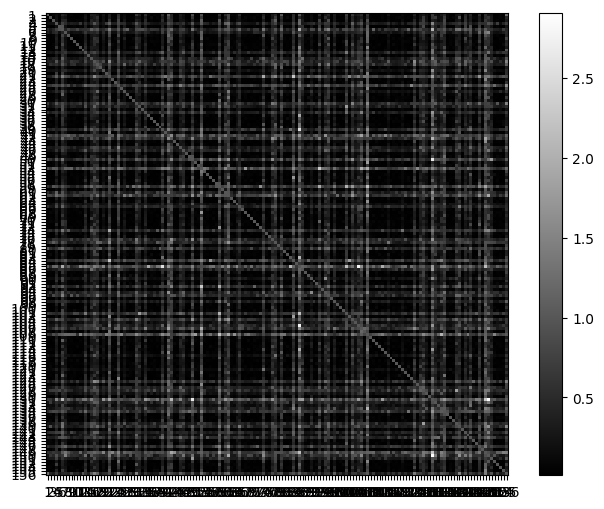

In [18]:
matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2
print(symmetric_matrix)
# symmetric_matrix[0, 1] =1
# symmetric_matrix[1, 0] =1
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [19]:
import networkx as nx
# Thresholding the matrix
thresholded_matrix = np.where(symmetric_matrix < 0.1, 0, 1)

# Creating an adjacency matrix
adjacency_matrix = thresholded_matrix - np.eye(thresholded_matrix.shape[0])  # Subtracting the diagonal

# Visualizing the graph using NetworkX
G = nx.from_numpy_array(adjacency_matrix, create_using=nx.Graph)

# plt.figure(figsize=(8, 6))
# pos = nx.circular_layout(G)  # Layout the nodes in a circle
# nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=2, font_size=0)#, font_weight='bold')
# labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos)#, edge_labels=labels)
# plt.title('Graph Visualization based on Adjacency Matrix')
# plt.show()

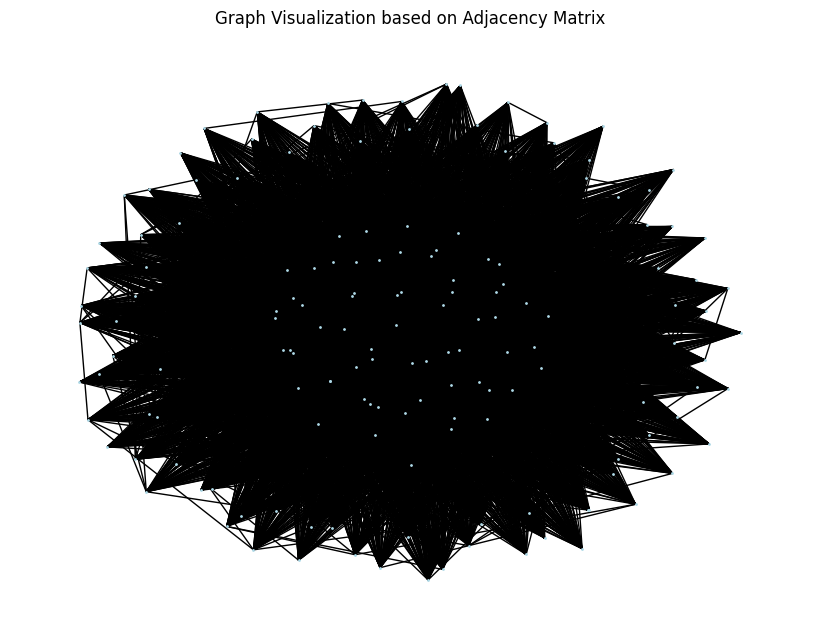

In [20]:

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout the nodes in a circle
nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=1, font_size=12, font_weight='bold')
plt.title('Graph Visualization based on Adjacency Matrix')
plt.show()


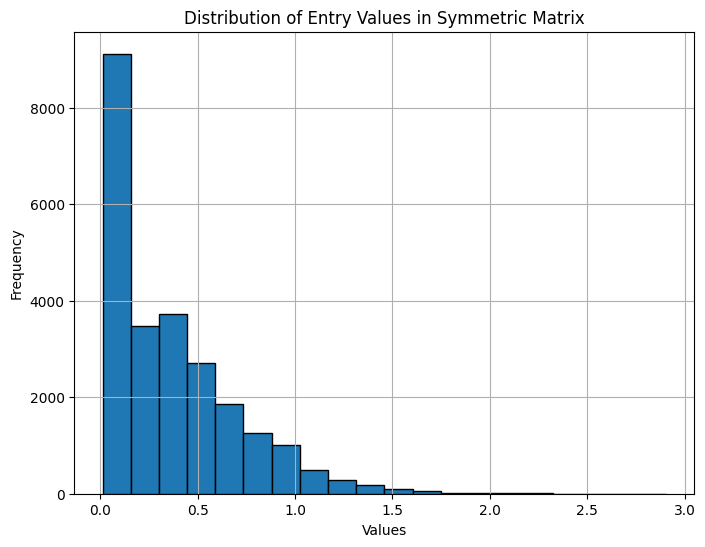

In [21]:
# Flatten the matrix into a 1D array
values = symmetric_matrix.flatten()

# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.hist(values, bins=20, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Entry Values in Symmetric Matrix')
plt.grid(True)
plt.show()


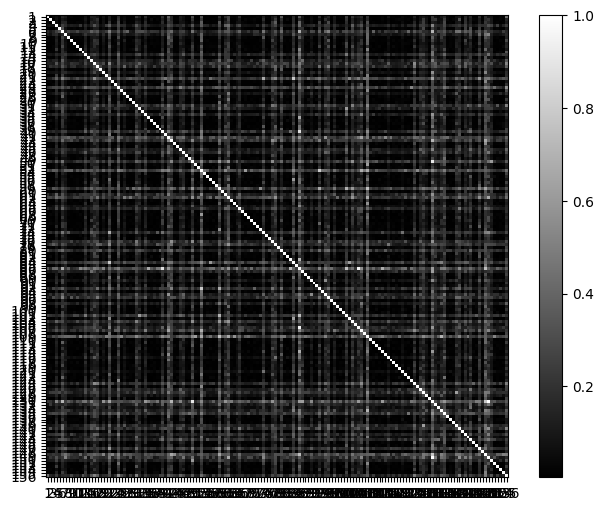

In [22]:


matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2

# Find the largest non-diagonal value
max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))

# Divide the matrix by the largest non-diagonal value
if max_value != 0:
    symmetric_matrix /= max_value


np.fill_diagonal(symmetric_matrix, 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [23]:
if np.isnan(symmetric_matrix).any():
    print("NaNs detected in symmetric_matrix!")
else:
    print("No NaNs in symmetric_matrix.")


No NaNs in symmetric_matrix.


In [24]:
max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))
print(max_value)

1.0
